~~~
Copyright 2025 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
~~~

# Quick start with Digital Imaging and Communications in Medicine (DICOM)

<table><tbody><tr>
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/google-health/medgemma/blob/main/notebooks/quick_start_with_dicom.ipynb">
      <img alt="Google Colab logo" src="https://www.tensorflow.org/images/colab_logo_32px.png" width="32px"><br> Run in Google Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogle-Health%2Fmedgemma%2Fmain%2Fnotebooks%2Fquick_start_with_dicom.ipynb">
      <img alt="Google Cloud Colab Enterprise logo" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" width="32px"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/google-health/medgemma/blob/main/notebooks/quick_start_with_dicom.ipynb">
      <img alt="GitHub logo" src="https://github.githubassets.com/assets/GitHub-Mark-ea2971cee799.png" width="32px"><br> View on GitHub
    </a>
  </td>
</tr></tbody></table>

## Overview

In clinical workflows, medical images are communicated using DICOM. While you can process images client-side and send the image bytes to MedGemma (as demonstrated in our earlier [notebooks](https://github.com/google-health/medgemma/tree/main/notebooks)), we recommend using [our custom Docker container for MedGemma](http://us-docker.pkg.dev/deeplearning-platform-release/vertex-model-garden/health-ai-medgemma.1-0) to handle the image processing server-side.

Server-side processing offers significant advantages:

- **Performance**: Optimizes network performance and bypasses API payload restrictions.

- **Security**: Hardens security during transmission.

- **Consistency**: Ensures consistent and deterministic data preprocessing.

You can use this custom container or [the source code](https://github.com/Google-Health/medgemma/tree/main/python/serving) directly to deploy your own DICOM-aware MedGemma services on any compute platform. However, this tutorial assumes you have deployed the model to a [Vertex online inference endpoint](https://docs.cloud.google.com/vertex-ai/docs/predictions/overview) via [Model Garden](https://console.cloud.google.com/vertex-ai/publishers/google/model-garden/medgemma.) adhereing to [this API specification](https://developers.google.com/health-ai-developer-foundations/medgemma/serving-api).

NOTE: As a GCP user, you are not limited to deployment via Model Garden which currently deploys the model and its custom container using a fixed configuration to a Vertex online inference endpoint for you. Please refer to [the serving architecture document](https://developers.google.com/health-ai-developer-foundations/model-serving/overview) to understand more deployment options.

### Objectives

This notebook demonstrates the different methods for prompting MedGemma using chest X-ray imaging:

  * **DICOM Store Reference**: By providing a link to the image stored within a DICOM Store.
  * **Cloud Storage URI**: By providing a link (URI) to the image (binary DICOM instance, traditional image format, etc.,) stored in a Google Cloud Storage bucket.
  * **Image URL**: By providing a link to the image (binary DICOM instance, traditional image format, etc.,) served by an HTTP(S) server.
  * **Embedded Bytes**: By embedding the image bytes directly within the request payload.

### Costs
This tutorial uses billable components of Google Cloud Platform (GCP):

- [Vertex AI - Online Prediction Endpoints](https://docs.cloud.google.com/vertex-ai/docs/predictions/get-online-predictions)
- [Cloud Healthcare API - DICOM Store](https://docs.cloud.google.com/healthcare-api/docs/how-tos/dicom)
- [Google Cloud Storage (GCS)](https://docs.cloud.google.com/storage/docs/introduction)

Learn about [Vertex AI online prediction pricing](https://cloud.google.com/vertex-ai/pricing?e=48754805#prediction-and-explanation), [Cloud Healthcare AI pricing](https://cloud.google.com/healthcare-api/pricing), [GCS pricing](https://cloud.google.com/storage/pricing?e=48754805) and use the [Pricing Calculator](https://cloud.google.com/products/calculator?e=48754805) to generate a cost estimate based on your projected usage.

NOTE: For your convenience, the notebook initially uses a Cloud DICOM Store and GCS bucket hosted by the [goo.gle/hai-def](http://goo.gle/hai-def) program. You will only be charged for data storage if you change the default configuration.

## Before you begin
You need the following to run this notebook end-to-end:

1. A **MedGemma** Vertex AI online prediction endpoint. You can use either the `medgemma-4b-it-dicom` or `medgemma-27b-it-dicom` varient. If you don't have access to an endpoint instance, deploy either of these varients via [Model Garden](https://console.cloud.google.com/vertex-ai/publishers/google/model-garden/medgemma). This notebook was tested using `medgemma-4b-it-dicom` (the smaller model).

3. A **Google Identity**. This identity can be a Gmail address (e.g., user@gmail.com), a non-Gmail personal email (e.g., user@foo.com), or a corporate/organizational email managed by your employer or school through Google Workspace or Google Cloud Identity (e.g., name@yourcompany.com). For details on managing or creating your Google account, visit https://account.google.com.

2. A **Google Cloud DICOM Store** containing medical images. In this notebook we use a public DICOM Store containing public data readable by anyone with a Google identity. If you'd like to test the notebook with your own data, refer to [how to create a DICOM Store](https://docs.cloud.google.com/healthcare-api/docs/how-tos/dicom).

3. A **GCS Bucket** containing medical images. In this notebook we use a public GCS bucket containing public data readable by anyone on the internet. If you'd like to test the notebook with your own GCS bucket, refer to [how to create a bucket](https://docs.cloud.google.com/storage/docs/creating-buckets).

In [ ]:
# @title Step 1 - Authenticate
import google.auth
import google.auth.transport.requests
from google.colab import auth

# There will be a popup asking you to sign in with your user account and approve
# access.
auth.authenticate_user()

_credentials = None

def get_bearer_token() -> str:
  """Define function to return bearer token associated with user."""
  global _credentials
  if _credentials is None:
    _credentials, _ = google.auth.default()
  if not _credentials.valid:
    _credentials.refresh(google.auth.transport.requests.Request())
  return _credentials.token

In [ ]:
# @title Step 2 - Define Python functions
import json
from typing import Any, Mapping

from IPython.display import display, Markdown

def _mask_value(k: Any, v: Any) -> Any:
  if isinstance(k, str) and k=="access_credential" and isinstance(v, str):
    return "MASKED_BEARER_TOKEN"
  return mask_auth(v)

def mask_auth(obj: Any) -> Any:
  """Mask bearer token in prompt"""
  if isinstance(obj, dict):
    return {k: _mask_value(k, v) for k, v in obj.items()}
  elif isinstance(obj, list):
    return [mask_auth(elem) for elem in obj]
  return obj

def display_med_gemma_prompt(task:str, instance: Mapping[str, Any]) -> None:
  """Display MedGemma prompt in CoLab."""
  txt = json.dumps(mask_auth(instance), indent=4, sort_keys=True)
  display(Markdown(f"**Task:** {task}"))
  display(Markdown("**MedGemma Endpoint Prompt:**"))
  display(Markdown(f"```json\n{txt}"))


def call_med_gemma_inference(endpoint_name: str, use_dedicated_endpoint: bool, is_thinking: bool, instance: Mapping[str, Any]) -> None:
  """Call Vertex AI endpoint and display the results in the colab."""
  # Call Vertex AI endpoint.
  response = endpoint.raw_predict(
      body=json.dumps(instance).encode("utf-8"), use_dedicated_endpoint=use_dedicated_endpoint,
      headers={"Content-Type": "application/json"}
  )
  try:
    response.raise_for_status()
  except:
    display(Markdown(f"---\n\n**[ Error:]**\n\n{response.text}\n\n---"))
    raise
  # Display the endpoint results in the CoLab.
  try:
    medgemma_response = response.json()["choices"][0]["message"]["content"]
    if "27b" in endpoint_name and is_thinking:
      thought, medgemma_response = medgemma_response.split("<unused95>")
      thought = thought.replace("<unused94>thought\n", "")
      display(Markdown(f"---\n\n**[ MedGemma thinking ]**\n\n{thought}"))
    display(Markdown(f"---\n\n**[ MedGemma Response:]**\n\n{medgemma_response}\n\n---"))
  except:
     display(Markdown(f"---\n\n**[ Error:]**\n\n{response.text}\n\n---"))
     raise

def get_system_instruction(endpoint_name: str, is_thinking: bool, system_instruction: str) -> Mapping[str, Any]:
  if "27b" in endpoint_name and is_thinking:
      system_instruction = f"SYSTEM INSTRUCTION: think silently if needed. {system_instruction}"
  return {
          "role": "system",
          "content": [{"type": "text", "text": system_instruction}]
  }

def get_max_tokens(endpoint_name: str, is_thinking: bool) -> int:
  return 1500 if "27b" in endpoint_name and is_thinking else 500

In [ ]:
# @title Step 3 - Set the parameters & initialize
from google.cloud import aiplatform

# @markdown #### Prerequisites

# @markdown 1. Make sure that [billing is enabled](https://cloud.google.com/billing/docs/how-to/modify-project) for your project.

# @markdown 2. Make sure that either the Compute Engine API is enabled or that you have the [Service Usage Admin](https://cloud.google.com/iam/docs/understanding-roles#serviceusage.serviceUsageAdmin) (`roles/serviceusage.serviceUsageAdmin`) role to enable the API.

# @markdown This section enables the Compute Engine API (if not already enabled), and initializes the Vertex AI API.

Google_Cloud_Project = ""  # @param {type: "string", placeholder:"e.g. MyProject"}
ENDPOINT_ID = ""  # @param {type: "string", placeholder:"e.g. 123456789"}
ENDPOINT_REGION = ""  # @param {type: "string", placeholder:"e.g. us-central1"}

# @markdown Set `use_dedicated_endpoint` if you are using a [dedicated endpoint](https://cloud.google.com/vertex-ai/docs/predictions/choose-endpoint-type) (`True` by default for Model Garden deployments). Uncheck this option for all other endpoint types.
use_dedicated_endpoint = True  # @param {type: "boolean"}

# @markdown Set `is_thinking` to `True` to turn on thinking mode. **Note:** Thinking is supported for the 27B variants only.
is_thinking = False  # @param {type: "boolean"}

# Enable the Compute Engine API, if not already.
print("Enabling Compute Engine API.")
! gcloud services enable compute.googleapis.com --project {Google_Cloud_Project}

# Initialize Vertex AI API.
print("Initializing Vertex AI API.")
aiplatform.init(project=Google_Cloud_Project, location=ENDPOINT_REGION, api_transport="rest")

endpoint = aiplatform.Endpoint(
    endpoint_name=ENDPOINT_ID,
    project=Google_Cloud_Project,
    location=ENDPOINT_REGION,
)

# Use the endpoint name to check that you are using an appropriate model variant.
# These checks are based on the default endpoint name from the Model Garden
# deployment settings.
endpoint_name = endpoint.display_name
if "pt" in endpoint_name:
    raise ValueError(
        "The examples in this notebook are intended to be used with "
        "instruction-tuned variants. Please use an instruction-tuned model."
    )
if "text" in endpoint_name:
    raise ValueError(
        "You are using a text-only variant which does not support multimodal"
        " inputs. Please proceed to the 'Run inference on text only' section."
    )

Enabling Compute Engine API.
Initializing Vertex AI API.


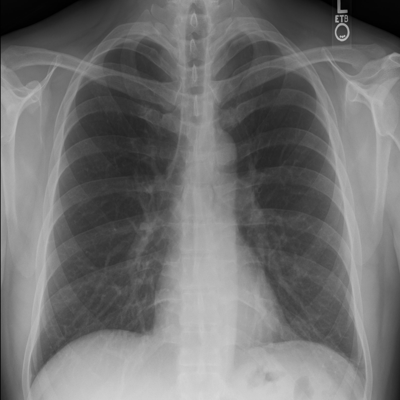

In [ ]:
# @title Step 4 - Display the test image
# @markdown **Image attribution:** Stillwaterising, CC0, via Wikimedia Commons

import io

import requests
import PIL.Image

url = "https://storage.googleapis.com/hai-cd3-foundations-public-vault-entry/med_gemma/colab_example/cxr/chest_xray_pa_3-8-2010.jpeg"
headers = {"accept": "*/*", "User-Agent": "http-image-data-accessor"}
image_bytes = requests.get(url, headers=headers).content
with PIL.Image.open(io.BytesIO(image_bytes)) as img:
  display(img.resize((400, 400)))


In [ ]:
# @title Step 5.1 - Prompt MedGemma GCP DICOM Store reference
prompt = "Describe this X-ray."

# Image attribution: Stillwaterising, CC0, via Wikimedia Commons
dicom_source = "https://healthcare.googleapis.com/v1/projects/hai-cd3-foundations/locations/us-central1/datasets/public/dicomStores/test-images/dicomWeb/studies/1.2.3/series/1.2.3.4/instances/1.2.3.4.5"

# Generate chat completion formatted prompt.
content = []
content.append({"type": "text", "text": prompt})
content.append({
                 "type": "image_dicom",
                 "image_dicom": {
                    # DICOM imaging is defined by the DICOMweb uri which that
                    # defines the DICOM instance containing the imaging.
                    # https://docs.cloud.google.com/healthcare-api/docs/how-tos/dicomweb
                    "dicom_source": dicom_source,
                    "access_credential": get_bearer_token()
                 }
               })

messages = [
     get_system_instruction(endpoint_name, is_thinking, "You are an expert radiologist."),
     {
        "role": "user",
        "content": content
    }
]

instance = {
    "@requestFormat": "chatCompletions",
    "messages": messages,
    "max_tokens": get_max_tokens(endpoint_name, is_thinking),
    "temperature": 0
}

display_med_gemma_prompt("Describe chest x-ray imaging stored in a Google DICOM store.", instance)
call_med_gemma_inference(endpoint_name, use_dedicated_endpoint, is_thinking, instance)

**Task:** Describe chest x-ray imaging stored in a Google DICOM store.

**MedGemma Endpoint Prompt:**

```json
{
    "@requestFormat": "chatCompletions",
    "max_tokens": 500,
    "messages": [
        {
            "content": [
                {
                    "text": "You are an expert radiologist.",
                    "type": "text"
                }
            ],
            "role": "system"
        },
        {
            "content": [
                {
                    "text": "Describe this X-ray.",
                    "type": "text"
                },
                {
                    "image_dicom": {
                        "access_credential": "MASKED_BEARER_TOKEN",
                        "dicomweb_uri": "https://healthcare.googleapis.com/v1/projects/hai-cd3-foundations/locations/us-central1/datasets/public/dicomStores/test-images/dicomWeb/studies/1.2.3/series/1.2.3.4/instances/1.2.3.4.5"
                    },
                    "type": "image_dicom"
                }
            ],
            "role": "user"
        }
    ],
    "temperature": 0
}

---

**[ MedGemma Response:]**

Okay, here's a description of the chest X-ray you provided:

**Overall Impression:**

The chest X-ray shows a normal cardiomediastinal silhouette and lung fields. The lungs appear clear, with no obvious consolidation, nodules, or masses. The heart size is within normal limits. The mediastinum is unremarkable.

**Specific Findings:**

*   **Heart:** The heart size appears normal. The cardiothoracic ratio is within the normal range.
*   **Mediastinum:** The mediastinum is unremarkable, with no obvious widening or masses.
*   **Lungs:** The lungs are clear bilaterally. There is no evidence of consolidation, pleural effusion, or pneumothorax.
*   **Bones:** The ribs and clavicles appear intact. There is no evidence of fractures.
*   **Soft Tissues:** The soft tissues of the chest wall are unremarkable.

**In summary, the chest X-ray is normal.**

**Important Considerations:**

*   This is a single image, and a complete evaluation requires reviewing the entire study, including the lateral view.
*   The interpretation is based on the provided image and the clinical context.
*   This is not a substitute for a formal radiologic report.

**Disclaimer:** I am an AI and cannot provide medical diagnoses. This interpretation is for informational purposes only and should not be used to make any medical decisions. A qualified radiologist should always interpret medical images.


---

In [ ]:
# @title Step 5.2 - Prompt MedGemma with GCS URI
prompt = "Describe this X-ray."

file_type = 'JPEG' # @param ["JPEG", "PNG", "DICOM"]
file_type = file_type.lower()
if file_type == "dicom":
  file_type = "dcm"

# Image attribution: Stillwaterising, CC0, via Wikimedia Commons
gcs_source = f"gs://hai-cd3-foundations-public-vault-entry/med_gemma/colab_example/cxr/chest_xray_pa_3-8-2010.{file_type}"

# Generate chat completion formatted prompt.
content = []
content.append({"type": "text", "text": prompt})
# GCS imaging is defined by GCS URI formatted as
# gs://bucket/path/to/imaging.file,
#
# The GCS endpoint supports performing inference from traditional imaging
# file formats, DICOM imaging, and imaging encoded in OpenSlide compatible file
# formats.
content.append({
                 "type": "image_gcs",
                 "image_gcs": {
                   "gcs_source": gcs_source,
                   # The GCS bucket used in this colab permits unathenticated
                   # access (Read Permission AllUsers). To read from GCS buckets
                   # that require authentication pass the OAuth bearer token
                   # in the request as shown below.
                   # "access_credential": get_bearer_token()
                 }
               })

messages = [
     get_system_instruction(endpoint_name, is_thinking, "You are an expert radiologist."),
     {
        "role": "user",
        "content": content
    }
]

instance = {
    "@requestFormat": "chatCompletions",
    "messages": messages,
    "max_tokens": get_max_tokens(endpoint_name, is_thinking),
    "temperature": 0
}

display_med_gemma_prompt("Describe chest x-ray read from GCS", instance)
call_med_gemma_inference(endpoint_name, use_dedicated_endpoint, is_thinking, instance)

**Task:** Describe chest x-ray read from GCS

**MedGemma Endpoint Prompt:**

```json
{
    "@requestFormat": "chatCompletions",
    "max_tokens": 500,
    "messages": [
        {
            "content": [
                {
                    "text": "You are an expert radiologist.",
                    "type": "text"
                }
            ],
            "role": "system"
        },
        {
            "content": [
                {
                    "text": "Describe this X-ray.",
                    "type": "text"
                },
                {
                    "image_gcs": {
                        "gcs_uri": "gs://hai-cd3-foundations-public-vault-entry/med_gemma/colab_example/cxr/chest_xray_pa_3-8-2010.jpeg"
                    },
                    "type": "image_gcs"
                }
            ],
            "role": "user"
        }
    ],
    "temperature": 0
}

---

**[ MedGemma Response:]**

Okay, I've reviewed the chest X-ray. Here's a description of what I see:

**Overall Impression:**

The chest X-ray shows a normal cardiomediastinal silhouette and lung fields. There are no obvious acute findings.

**Specific Findings:**

*   **Heart Size:** The heart size appears within normal limits.
*   **Mediastinum:** The mediastinum (the space between the lungs containing the heart, great vessels, trachea, etc.) is unremarkable.
*   **Lungs:** The lung fields are clear bilaterally, with no evidence of consolidation, nodules, masses, or significant pleural effusions.
*   **Bones:** The ribs and clavicles appear intact.
*   **Diaphragm:** The diaphragms are well-defined.
*   **Soft Tissues:** The soft tissues of the chest wall are unremarkable.

**In summary, the chest X-ray is normal.**

**Important Considerations:**

*   This is a single image, and a complete evaluation would require reviewing the entire series of images, including the lateral view.
*   The absence of findings does not necessarily rule out all possible diagnoses. Further imaging or clinical correlation may be necessary if there are any concerning symptoms or risk factors.

**Disclaimer:** This is a preliminary interpretation based on a single image. A definitive diagnosis requires a complete clinical evaluation and review of the entire radiographic series.


---

In [ ]:
# @title Step 5.3 - Prompt MedGemma with image URL

prompt = "Describe this X-ray."

file_type = 'JPEG' # @param ["JPEG", "PNG", "DICOM"]
file_type = file_type.lower()
if file_type == "dicom":
  file_type = "dcm"
# Image attribution: Stillwaterising, CC0, via Wikimedia Commons
url = f"https://storage.googleapis.com/hai-cd3-foundations-public-vault-entry/med_gemma/colab_example/cxr/chest_xray_pa_3-8-2010.{file_type}"

# Generate chat completion formatted prompt.
content = []
content.append({"type": "text", "text": prompt})
content.append({
                "type": "image_url",
                "image_url": {"url": url}
               })

messages = [
    get_system_instruction(endpoint_name, is_thinking, "You are an expert radiologist."),
    {
        "role": "user",
        "content": content
    }
]

instance = {
    "@requestFormat": "chatCompletions",
    "messages": messages,
    "max_tokens": get_max_tokens(endpoint_name, is_thinking),
    "temperature": 0
}

display_med_gemma_prompt("Describe chest x-ray read from a HTTPS server.", instance)
call_med_gemma_inference(endpoint_name, use_dedicated_endpoint, is_thinking, instance)

**Task:** Describe chest x-ray read from a HTTPS server.

**MedGemma Endpoint Prompt:**

```json
{
    "@requestFormat": "chatCompletions",
    "max_tokens": 500,
    "messages": [
        {
            "content": [
                {
                    "text": "You are an expert radiologist.",
                    "type": "text"
                }
            ],
            "role": "system"
        },
        {
            "content": [
                {
                    "text": "Describe this X-ray.",
                    "type": "text"
                },
                {
                    "image_url": {
                        "url": "https://storage.googleapis.com/hai-cd3-foundations-public-vault-entry/med_gemma/colab_example/cxr/chest_xray_pa_3-8-2010.dcm"
                    },
                    "type": "image_url"
                }
            ],
            "role": "user"
        }
    ],
    "temperature": 0
}

---

**[ MedGemma Response:]**

Okay, I've reviewed the chest X-ray. Here's a description of what I see:

**Overall Impression:**

The image shows a normal chest X-ray. The heart size is within normal limits. The lungs are clear bilaterally, with no evidence of consolidation, nodules, or masses. The mediastinum is unremarkable. The bony structures of the rib cage are intact.

**Specific Findings:**

*   **Heart:** The heart size appears normal. The cardiothoracic ratio (the width of the heart compared to the width of the chest) is within the normal range.
*   **Lungs:** The lungs are clear bilaterally. There is no evidence of pneumonia, pulmonary edema, or other lung pathology. The lung markings are normal.
*   **Mediastinum:** The mediastinum (the space between the lungs containing the heart, great vessels, trachea, and other structures) appears normal in width and contour.
*   **Bones:** The ribs, clavicles, and other bony structures of the chest wall are intact. There are no obvious fractures or other bony abnormalities.
*   **Diaphragm:** The diaphragm is well-defined and appears normal.
*   **Soft Tissues:** The soft tissues of the chest wall are unremarkable.

**In summary, this is a normal chest X-ray.**

**Important Considerations:**

*   This is a single image, and a complete evaluation would require reviewing the entire study, including the lateral view if available.
*   The interpretation is based on the provided image.
*   This is not a substitute for a formal radiologic report from a qualified radiologist.

**Disclaimer:** I am an AI and cannot provide medical diagnoses. This is for informational purposes only. A qualified healthcare professional should interpret the X-ray in the context of the patient's clinical history and physical examination.


---

In [ ]:
# @title Step 5.4 - Prompt MedGemma with embedded bytes
import base64
import io
import requests
import PIL.Image

# @markdown This example illustrates how to send local imaging to the vertex embed point by embedding the imaging into the requests. This example is shown for to illustrate how to send local data to GCP enhanced enpoint. However, for the pattern shown here is not optimal because it 1st) downloads the imaging to the colab, 2) converts the converts the imaging from PNG to JPEG to reduce the imaging file size to make it compatiable with non-dedicated vertex endpoints, and 3) sends the encoded imaging back to GCP. A superior would be to instead have the enpoint directly retrieve the imaging from the url.

# @markdown **Define image file format to read from http server.**
file_type = 'JPEG' # @param ["JPEG", "PNG"]

# @markdown **Define syntax to use to embedd image bytes**
prompt_syntax = "image_bytes"  # @param ["image_bytes", "image_url"]

prompt = "Describe this X-ray."

# Image attribution: Stillwaterising, CC0, via Wikimedia Commons
url = f"https://storage.googleapis.com/hai-cd3-foundations-public-vault-entry/med_gemma/colab_example/cxr/chest_xray_pa_3-8-2010.{file_type.lower()}"

# Download imaging to CoLAb
headers = {"accept": "*/*", "User-Agent": "http-image-data-accessor"}
image_bytes = requests.get(url, headers=headers).content

if file_type == 'PNG':
  # Convert imaging to JPEG to reduce size to make it compatible with
  # non-dedicated vertex endpoints.
  with io.BytesIO() as out:
    with PIL.Image.open(io.BytesIO(image_bytes)) as img:
      img = img.convert(mode="RGB")
      img.save(out, format="jpeg")
    image_bytes = out.getvalue()
# Base64 encode imaging
encoded_data = base64.b64encode(image_bytes).decode("utf-8")

# Generate chat completion formatted prompt.
content = []
content.append({"type": "text", "text": prompt})
if prompt_syntax  == "image_url":
  content.append({"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_data}"}})
else:
  content.append({"type": "image_bytes", "image_bytes": {"input_bytes": encoded_data}})

messages = [
    get_system_instruction(endpoint_name, is_thinking, "You are an expert radiologist."),
    {
        "role": "user",
        "content": content
    }
]

instance = {
    "@requestFormat": "chatCompletions",
    "messages": messages,
    "max_tokens": get_max_tokens(endpoint_name, is_thinking),
    "temperature": 0
}

display_med_gemma_prompt("Send local chest x-ray imaging to Vertex endpoint.", instance)
call_med_gemma_inference(endpoint_name, use_dedicated_endpoint, is_thinking, instance)

**Task:** Send local chest x-ray imaging to Vertex endpoint.

**MedGemma Endpoint Prompt:**

```json
{
    "@requestFormat": "chatCompletions",
    "max_tokens": 500,
    "messages": [
        {
            "content": [
                {
                    "text": "You are an expert radiologist.",
                    "type": "text"
                }
            ],
            "role": "system"
        },
        {
            "content": [
                {
                    "text": "Describe this X-ray.",
                    "type": "text"
                },
                {
                    "image_bytes": {
                        "input_bytes": "/9j/4AAQSkZJRgABAQIALwAvAAD/2wBDAAYEBQYFBAYGBQYHBwYIChAKCgkJChQODwwQFxQYGBcUFhYaHSUfGhsjHBYWICwgIyYnKSopGR8tMC0oMCUoKSj/2wBDAQcHBwoIChMKChMoGhYaKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCj/wgARCAekCWwDAREAAhEBAxEB/8QAGwAAAwEBAQEBAAAAAAAAAAAAAAECAwQGBQf/xAAUAQEAAAAAAAAAAAAAAAAAAAAA/9oADAMBAAIQAxAAAAH8sKAAAAAAABAAAAAAAAAAgAAAAAAAAAQxAAAAAAgACiyigGAxgUBQxjGMYxjGMYxjKGMYwKGMYyihjABllAMYDKGAwGMYygGMos2KLKNiiyQNTIYxElAMDMDERBZoM2KACihEAZEkHIQIsBAAjQg5jUBEmBIgJAkkkQgABEkCEIRIhEiEIQCAQCEIBCEIBCAQhAIQhCAQgESSQSADACxCA9mdp8c8wAAMBlGQgGAAAxAMAAAAAABgAAAAAAAABJQAAAAAIAAAAAAAAAAQAAAADAQAACAAAAAAAQAMs0KGAwABjGMYxjGMYxjGMYwKGMoBjGAyhjKKGAhlFDGMoBgUMBjGIZQxgWaGpqMZoajJAoAARIxiIMSzMkks0GUdICLGMyEZCMjlGUAEiACyTnKEIRBkBIgJEQIQhDAkkQiRCJAkQhCAQCAQgEAhCAQhAIBCAQhCEAhDESQQQAAaCEB7U7T5R5MAABjKMQAYAAwABAMAAAAAAAABiAYAAABJQAAgAAAAAAAAAAABAAAADABAAAIAAAAAAQAAzQ0KGMAGADGMYxjGAyhgMYwGMCihjAYwGMZQxlAADKGWMZQDGAyjQkZIDGUMZZoaliAZsUUSWWIRIyTIxOUR0kDKNCijpKABkmQGZJkQUUSSQIQxgYlCJEBmZiARJJACJJGIBCESIkQgJEIQCAQgAQgEAgEIBCABCAQhCEAgAQiSDMgDQQgPbHcfLPIAAAAyjIAGAAAwAAAAAAAAAAAAAAABgAEFDEAAAAAAAAAAAAACAAAYAAAIAAQAAAACAAKNDQoYDGAAMYxjAYxjGMYDGMBjAoYxjGAwGMYxjGAxjGUUMoBlDAo3GQIZIhgUUamxqAASWWaAMsAEMg5DnMxDNBllFlGpuMAJMyRklGRmSIkkkAAZAEiEIkCSCREkiJESIBAICREiEBICJAQCAQAIBAIQgEACAQgEAhCEIBCAQhEGYCEM9sfQPjnkhAAAMoyABgADEMAAAAAAAAAAAAAAAGIYEFAAAAAAAAAAAAAIAAAGAAACAAAQAAAACACzQsoYxgMBgMYwGMYxgMYDGMYDAYFDGMYwAYxgMYxjAoYyiigKGUAFHSIkQFAQI0KNCiyihgWMsRQigAoxOUxMxCLNDQRQzY6QJGSIQCA5yBCEIkCRjJGSSSIQwIJIJJESIkkQCAQCJEIQhAIQhAACAQAIQCEACABAIBAIQhCEIBCARIzMzEe2PqHxDyIgAAGUZAAwAAAYAAAAAAAAAAAAAAAAwAgoAAAAAAAAAABAAAAwAAABAAAIAAAABAMs1KKGMBjAYDGMYwGMBgMYwGMYDABjKGAxjAAKAYDGMYyhjGUMoZRYhGh0kCEMYygARoWBQxlFDLGIAAAMTnMSiCRgUWWaGh0jIAkAJJIMiQAQiQEUQUMggkQDEIDMzEIRIiCRAAhCAQhCEIQCEIAABAIAEAgAQCAQAIBAIQhCEIQCEWSQQe0PqHwzyAFDEZDKMgAYAAAAAAwAAAAAAAAAAAAAAAkoAAAAAEMBAAAAAAwEAwAQAACAAAAABDLNSyhgMYDAYxjGMAGMBjAYwGMYDAAGMoYDGMQDKABjGAyxjGMooDQ2KGYlm5mAgGUAwKAosAKLLGBYyREjGc5iMQzABDGWbmpsaEEiADMkzESSAyRCEMCiBCJAkBiEBiSAhECIIEMQCEIQCEIQCEIAAAEAgEAAIAEAgAQCAQhCEAhEgIsRJJ7Q+oIgRJBzHgRFGQAMAAAAAABgAAAAAAAAAAAAAASUAAAAACAAAAAAAAAYAIAABAAAAAICjQ0LGUMBgAxjGMYwGAwGAwGMYDAYDAAGUMYxgAhjGAxjGMoYFDGMos0KGMDM3EIAKAYAIZZRQyhlGhQxkEiNCDEgok3OEgRQFG5sbm5kIRmIggCBCEBICEIYCEACEIBAIkzEIQiSCCQEAgEIQgEIBCEACGAgEACAAEAAIBAAgEAhCEIQhCLJEI9gfbGSQZmBxHhCSjMAAYAAAAAAAAAMAAAAAAAAAAAJKABAMQAAAAAAAAAMAEAAIAAAAAARZoaFFDGMBjAYxjGMBgMBgMBgMYDAYDAQxjGMYFAIBjGIYyhlDAYyhgaGoxgMZmaFCABgMAAZRRQyiizQ0GSBADJMgKOk2OE4yRiLNDU3NyTMgkggQhEkkgAiRAMAAQwAkQiQAggQhEkEkkiEAAIQhAIBCEACAAABAAgABAACAAEAhAIBCJEIk0JJEaGwGRmQZmRmAyAAAGAAAAAAAAAAMAAAAAAAAAAkYxAAAAAAAAAAAMBAAAIAAAAAACzQ0KGMYxjAYxjGMYDAYDAYAMBgMYAMYCAYxjGMAABjAAGUUUMBlDGMZqMCgAYCLGADABiKEUUUWMCzc0KEIQwIEUblEDPnkDGM0NTQ1MjMzJIIGSSSIRIEkgaCAAEAgEBIhCEIgQiSSCAJJAAEBIAIQgEAgAAABAIAAAEAAAgAQCAQCAkCSTQk6D1pqedPQganlD75ynjTEkxGAAAAAwAAAAAAAAGIYAAAAAAASMAAAAAAAAAABgIAAQAAAAAADNDQsoYxgMYxjGBQwGMBgMBgADGAwAYDAAAYxgMYDAQDGAwGUMYyihjGMsoChgADARYwGAAAxlFDGMs0OgZRYCJGYklHSYEHUcBmIZZobAWMk5zMRAiQJESIBAWAgGMoQhAIQhAIRiQSIgkkkkRIAAhCAQCAQCEAAMQAIAAAAAEAAIAEAgEIBCJNCT6Z7I82fENT2p48k7ToPPnCBzmZAhgAAAAAwAAAAAAAAAYAAAAASMAAAAAAAAAAAAAEAAAAACGWaGhRQwGMYDGMZQxjAYwGADABgAwAYDAYAAhjGMBjAYgAYDAZQDKLGAyhllAMsAAAAAAsBjGAxFjGIs0NiixG5RmSIwEbHQcpJuYHKIZRqagBZRgZkCAgBEgIoosZBiWMooBEjJAkYCEBiIkkzMyDMgkQABICAQCAQCAAAAAAAQxDAQAIAAQAIQCEICTUk+oe2PiHjCT9EPDGh9c6Dzp88ZiIkzMiRDAAAAGAAAAAAAAAAMAAAAkYAAAAAAAAAAAAgAAAAEBRoaFlFDGADGMYxjGMYwGMYAMAGAAAwGADGAAIBgUBQDAQAMYDAoALKGMYyixjAoYxgAAMYgAYDKGMCgGUbFgaAajIEQZCNzUwEaAcAhgbGgwNDQwMiQEIkkkCywGAjE0EBQCAQiSRiEIAMiQJJAkzMTIQAIBCAQCAQCAAAAGIYAAAAgABAAgEAhCAQjQR9c9aeVPmHGfoZ4k1NzrPlHyyjAAESQZGZIDAAAAAYAAAAAAAAxDAAJGAAAAAAAAAAAgAAAAADQ0NCihgMYwGMYDKGAygGMBgMAGAAMAAYDAYAIQDGMYxjEIAAYxgMYxljKGUWaFjABgMYwEQIooYEiGMoYxgMZuWBRZYCJMzMDoAyGM0OIgQyiyizYoxMxCIJIKGUMBDESMCSQKGACEIkYhCESZEiJACREnOZgIAEIAEACAQgAAGADAAAQxAAAIBAIBAIQjUk+geoLPMHyD1J50Z9w5D4AFGAAIQEiMzIgkAAAAAAAGAAAAADAQwJGAAAAAhgACAAAAAAAs0NSyhgMBjGAxjAoYxjAYwAYDAYAMBDABgMAGBIhFjGMYDAkQDAooYyiizQosZQGhQxDEUUMAESSZlGpQwIIEUWAihjNzQBlgSAGJAjoKMRAbHMZAAijQ2OgZJmZmQhFjESAhgI0JMyQGUAxiACBCEUSIxMySRDJAQjIwJGIQCAAEAgAQAIAGMBgAAACAAAQCAQgEI1JEIZ94++bGZwHnT5QgLMBAAhAAhEGZkZiEMAAAAAAAABgAAAElAACABgACAAAAEAyzU0LKGUAwAYDGMCgGUMBjAYDAYAMAAYAAAMYAAEkjKGUMBgAhCGMoo0NSihgAwGUajAYxjGMBgAhEAaDKAQxGQjQYyijpNRElEiARiZCA6CDIZuc5mIZQyzY2NBmRzmZQxAIgRQijYzMgEBRYASSAiBkgAgAxJJJEIQEDJOYgAEACABAAgABAIYDAYDAAABAACAQCEAjYkkZ7I+ofLOED6Z3HnzyghmIgAQCEIBCJJIMjMkQwAAAAAAAAAYAIYAIBgAgAAAQAUWamhZQxgMYDAYDGMYxgUAwGAwGADAYDAAAAGIYAAiQGUMYwGACEICijU6AABgAxjGbFDAYxFAMQDAQyiSxiGIYgMSixlGxZqMkQAMkxIMxjGWBBBmMQFFm5saEmRkIQABAhiGdAjMgBAUMBABIiQEIAAkkxEBJJICAQzmMgAQxAIAEAAACAAAYAAxgAAIAAQCAQhGwiT05908cfJEAz0Z6Q80ebKMAEAgEIQgEICSSTMyMyQAYAAAAAAAACGAAAxAAgAYyyzUsoYxjAYxgMBjGMYwGMBgMBgAwAYDABgAAAwAQAIQwKGAwAYCEIYyzpNCRiGBQAUM2KAYxgAFDJGACGWaCJKIEAABmM0LLNChlCAQyDEyEAFiGSSIQxgam5oaGRJJBADESSUUajIJJESMRQwKAZBJIgABCEZmIEgIkQCEM5zEQAMBAIAEAwAQxAMQwAYCGMAEACAQCEbCOo9yeSPigIAJPWn2D8+JMQABCEIQCJEIQCESSZmRmSADAAAAAAAQwAAEAAMo0NCyyhjGAFAAxjGMYxjAYDAYAMBgMAGAwAYAAAMQAIAAAGAxgAwARIxgbnSSIYAMCyigKNRgMBgAxlElCJACizUZiIzAoYgMzUo1GaDKGQAEHMQAAUBACJKKLJNDc2GYjAyMwGBAijYDMgkQyBDKLKGICCCSRABRQwMSCREEgSIQijE5xAAwABAACAAGADAQAAAADAAAAEAhGoj0Z9Y8IAhAIR3nuTxZ84wAAAQEiEIQhCEIBAIkgzMjMkAGAAAAAhgAgAZZoaFlFDGMBjAYDGMYyhjAYDAYAMAAYDABgMBgAAMQAIAEAhgMBgMYwAkkYxnSdBmMQigKGUAwNhjGBQhgBRoMQCEAxmhoSYkmZQwEUBZoUWUBZACIOYgkRZmZmgyRFFmgFG5uQMkgyEAgESUamZAiRkgAxCEIooAJAoBiJABkAQIQhAZkkDMTnEIAGACAAAYgGMYCEAxkgAAAAMQAIRsSeqIPLiEACEaH6EeaPgmAAMCQEAiRCEIQgEIQCJJJMjMzJAAAYAIYgGWaGhZRQxjAYwGMBlDGMZQDAYAMBgAwABgAwGAAMAAAAQAIBCGMBgMYDARIDAo7DQzABFFAMoYDNCxgMYAMZZRRIgAkQiiyyyDMzAYxDNRgWUUIsCQJOUzARiYgBsWIDY0EI1NyhkEmQgEBmBqBAEgIoQiDMgQFGhZRRACAQgEIzGUIgkAEMkkZznKIAAYCEAAMAGMYAIAAQDEAAAgAAA1A9IdB5EQgEAjqPeHlz4hgAAACAQhCEIRICEIQCEICSSDIyMwABgIos1LLKGMYxgMYDGMZQxjGMBjAYAMAGAAUIYAAwAYAAAACAAESAFCKAAGMAEIQDNDsAkBDGMCiiwEI0JAAEAyiizQsYEkkgSBRRqIRAygACyygGUAjQRJBykFGZJgIYFlFGpYxG50ASZmYhAIQxjMxCAZQGZiZEEiAo0NQGIkQhmgxAIwKNAIJAQhiJLMjjIEMBiAQDABgAxgIAGIBCGAAIBDEBuI+mesPDHOfQOU1PtnwT7B6Q8KcpgADAQAIQhCEAhEgIQgJEIQhCIIMTIkANTqKKGMBjAYxgMZQxjGMYxgMBjAYDAAGIoBDAAGAxAAAIAEAgEAxgMAABgAiQGM2OokQhgMYxlgSQQWaDABAMooZQEmYGpqUAyQAsYEkgWWSWUWMZQyCgJMzjJAYzEyGAxmhoaFGh0iIIIIGIALGSSZiKKGSYmRiQICygJEamgCIJAZQyiiDMCyhEiAkQgKJOUggAAAAAGAAAxiGAAAgEAhiGIBAbiEe3IPHnuTE7D5J809KfJPKDMBgAAIAEICQEIQgJEIQhCEIQCEQZmJkQdR2AMYwABgMoYxjGMYxjAYxgAxgAxiGADEMAGIYAIAAQCAQgGBQAAAIYABIhjGbnSQACKLKKLGIggQGoASAAWMBAZmYyhlGhsMYyQEUUMgksZZZRQyijIRQjM4hAUaEHMZjLNCzc1NCyjMgxJAANCgJIMwGWSZGRkZkgaFiJEQAGoxiIGIYiiyyQJKKAgCRCACzIyJMiRDAAAYDAQxgMAAYAIkQCAAEBuSB2HszI+KcZ1HUfbPmHkBFHOMBiAAEAgEIkQhAIAJEIQhAIQiREEGQztGMBgMBjGMYwGMYwGMYDAYwGMAABgADAAAQAAAIBAIQigGMAEMBAMQhAAxnSdBAyihjAooRmQMYGpQABBBAAMkyJEMCzQos0NTQBCAZYyTMsooBlm4AUBJBxkElncWcJzAWWUaGoxGojEyJEWaDGSQZCGUZnOYEgUUAiBgIkkZRYxiEMQxFDGUaAIokgkkQAUWZGIzIyABgIYwAYDAYAMAAQEkiAAEBsIQHUfePsGwHOfCPPklFnOMBiAAEAgEICREgIQAACJEIBEiEIgkxPoAAwGMYxgAxgMBjAYwGMYDAYAAwAYgGIAAAABAIBAADABiGIYgABCAAGM6joAokAAZRZmZjAYCLEIYgEAAZmBmAwACiijU1NjUsQgGWWSZjAYyzQsssokk5yBGxqZknIBZRJZsIRsQZmZJZYxCMiQGIwOYyJLNQIMyRiGIkCSjU0KEZGZBIgGMk1NjY1NAJJIIEAzQyMQEYCAYAMYDGADAAAAABCJJAAEbiJAANTrMjlEAhlmAAAwAAEAgAQEiEIBCAQwEIRIhEiEQc59EYDGAwGADAYwGAxjABjGMBDAYAACGAAAAAgEAgAYDEAAAhgACAQhgMYzrOkCSBgAyxmRJQiTMzGUAgEUBRRRkYkECGMBgBZRobnQbFAIZZYGJIwA2NwLLKMjIzA1JMjU4hjARqbkFmxBkIYyiCTMkZZmcxzmRBoWMggzJGIBgMYxFkgZkgIQgAkRZZqbm5YDKJMyAKJMBjMSAGADGMYAAAAgABiARJIABsIQCAYgAQxFFHOMQDAAAAAQgAZRJJIgEBIAACJJESSScx9QYwABjAAAAAYwAYwGADAYwAAAAGACAAAQAAAAwAQAMBAADJAkYwKAo7DYkCRABRQzEBEGRmQIsoAAYwKKJMAAYiSBABQyhlmpqdJ0FDGMos5yAKNDcZRZRgZGYHSYmZqYmADKNDYCjYzEAgAxESUWZnMYHOZjNTMZJmIQwAoYiCCCzQAIAQCAQEjKKKNTqNCRlGoGRJRBiMozMQGMYxgADAQCABAMQEiJAZsAAADAYxgBQzAChCAQAAgAYAMkQjMkQhCEIBDEIgkgRyn1QGMCiygAooQAAxAACAQgAAABiGAAACAAAAGADABiAAABAAgEADACjU6DUkQhCGWMZkSQYkCJEM0EMBDGMYHOSADGUMkzJGMYyiizQ6TqNwGBRRmQI2NSgLGYnMSQdpkIQjnEMo0NSjU0MxkkAQIChGBkZGBmZmhmSMkkksBjAyMyRklmoxkiEACEIQFDKGWdJsBIGpqUZiIMRlkmIhjGACGAxAAgGMZYySRjGdACAYgAYCEIQzlACgEMBklASIQAAAIkgkQiREiAQhCMyTkPrjGMo1AYAIYDGMBgUIYwAQCAkQiREjAQAAAMYAAwGIYAAgAQCEIBgAzQ1KNyREiGMZoBBmQZkECJJLKGUACGAiDEAJAYxgWUBJIgKKLNTY6joLKABlCJNDQRRRgYGQjsMSBjMiRFjNTY2NDMZgSBAyjMyMCDMyIGQZiAAJKGIkzMwGBIzYookkYhAIBCKAoZRZsbDABmpqUSZGRQyjAgBDABjAosoZQxGhZIEEgBYyQGIChAIAEMwIAQCGAAIQCEMChCGIRBIhEkkCJEIQEnEfZGM0LAYAIAAAAZQDKGAwAYwEACEQZkCESMBjGAwGAhgAAIQCAQgAAKNxgdIiCQGMs1KOc5TEzMiCRAIsYDGWUaFkGRmAgABjGAzUoDIgCzUsss3OsZRQyxgWaEFCMjAzJOkzIKIAzAZRobHUWZEmQhmZRmZnOQQSQAjERIgKGSSZkAIAEAGpYxEjGIBCAkoBlDKNDYsoooZRoajOcyAoZiZgUUUWWUMYwAkRsMZgMkyGAwEAgAYhCGADGIkkkQAAAUIQFAIQAICDMRIhEkEiJEI4j7ZRoUADAYwEIAAQyhgWMZQigAAEMYCESQSQIkQAAwABiGACAQhAIAAs3ADcCSQGamgGBxnISQIRIhAMoYAIoZQhiKAkAEUIBGxQhlEmZRqWaFFGp1DKLNBlDNCQJMTEzEbAZkiABiGaGx0lmBIhAIgzMTEgkZIEGQiRAUSZECEMQAIQGxQxkgAAAgJKACihlGp0DGWWMko2LOcyAo1IEWMoYwEAhCESbAMzEWZGYAADEAhjABAACGAASSICQKGMoQhAAAMkyMxCESAjMkkRxH3zQYgAYxjGSSMBCGUUBQCAAACxgAxjKAYhCESQSSQSIBgAAAEgAhABqagIo2IGMsszMDExOYgkRICEAihlEjEMsBEmQyzU1EQAgGUUAFFmQyzUsooo2NgNTUoZB0CIAyMTMZZAySQEMCyzY3LMiBkAQQYmJmQIsBGBAiQGQYkDAAEACEBsUMYhiEMBASMYxjKGM3NRgMosCzY1MySiiyDMBgSIQCACBllFFGYijEgBgSMYElAIBAMQwAQhCJAAEWADEAxgAjMxJEM3Ow3MzjOIwOE9CUAwAQCGMokYDEBAhgIoYhjGAwABgMoAGWUMRAEiJIIIJAAABAIANjUgQG4DLGZGJkZkHMZiESIQgADQAEADKACTIQwLNDQoBEDGAFGoDGWUUMss3GM3NBiNhkAZnOQAzMoYEklDLGbnSIkzGQSZmZkZmZBZQiDEkkQzMwJAoQihCACRmwxjGBIhjABAUMYAMZZsMoso0NjQo0LMzMQxkGQAIQAAAICiizQzMwNDnJAYwGAAIkYCAAAQwJGQIBAADAYFCGIRBmbHUdh0AIRBmQeMPQjGMAJGIQDGIBiEBJQFAMAGAwAQxgMQCGbmgiCBFjGBJJBmZkAAAAzcskgRRuWUYGJBkQSc5kIQhCEIAA0AAAQFAIRmAwGAGpqUUZkgBRZZYxjGUWM0NhGxqUM3JAZBzGRAEmgyRCKGUaGx0EgYEjAxMTMgzGMAMzMgQGBkIAGBIxAIYxljKGMYyhiGIAABjAoZZubFjKGBZQixmZAhjJMgAQCABgMCjQs2MjEoDEQwEMQhDEIAAYDEAAIkRAAADABgMkRoam50HYUYmJJBIiDyB6IAKEIQAIYAAxiAYAMYFCAAGMQDJABiKNCxAQSIYyigGBIjMzMyRDOgskgRR0lkHMZkmRAjI5yRCEBICEAFjAAACgESZjGIoBAWbGgyRAAzQ1NBmYyiiijQ0GbGhZqMQEmJgSZkjKJEUUUWaGpuSBmQWZHOZkCEIogkkkkzOczABCKAkBAADGaFGpQAAgEIBCGBZZobGhZZsUIAESMsBlkkkgWZmJQhgAwGSUWWWamhzkGhiSAhCIGIQxgIAABAACEIkkRIDAsYwGbG5sM2OgxOYyJIJMwPNHoyBFCAQDEAxAMYFCGAAUMAAYwEAgEIYGgzQkkRJAxgUMYxjGSSQZlgSSAzoNTIwJMjMggRgYiEIQgEBIDLABDAChkiIJAYyiQGM0NjQgAGM1NSyTMsoZRRoaAampsMoCTnMiSDIzACjQo0NCzY0AQiRHOYGYDJAkyGIg5zAQCEAhgACEIQzY1NhCEACGIQElFmpsWMYwEaljEUMYxlEjGIRIGhmYlFjKARQFFFDKNizkEUYgBIhkiEIBCAQAAxCEBIhEAAxlmhYyzQsZYwKIOYgzJMxnnD0xBBIwGMQAADGUMBgMBgAwAYxgIQAICgGamIgAzAAGAwKGBYAaiMjIgCzUzMxGJmQQSSc5AiSQEIQAIosQCAoRQxEkEgAxjEMBlGxuSMAKNgNAJACyizQsZsajLKJMDIg5zMChgIoo0NzY2AChGJxmYDJJESZkGZgQIAJEIQxAIYgKNDUoYxASAxjKLAoooAEMQFFmhQDKGMZRoIkoAJA2IJKAQxCIJIEMBneUfOKMyCiwLGMYhEgIBAMQhkiEAhllFDGUAgGaFlEkDNBGZgSYknnT1JJmZjGMYCAYxgUMoYFAAgAYxgAwEUADNBAaGAiDIkAAQxgADEM6TQgQxiEYGRJiQZkiEIwEIQASQSSSAGgCABiGAyCSBgAxjAQAUbHUICgNhAaFCJKKKLNDU0GWBYGBzGRBJoMQCGWbFHUbDKJMjmOcAAkgRBJgYGYAICRCEAxCKNBiKLKGMRBRRoajAZkIoRQihiGMZsMoBFFFFmhQElDAQGhkZiMjMyJJAAEWWM+oBwlHMZgMZQyjQssQAIAARIhDA2KEIsAESAzQ1GSIgoAGUQcxiefPVGRmQIAGUAFAUMooCgAQhEkiEAxiGBQhmwyjoABGRmIzJEIQgGAwNTYzAZRYCJIOYyMiRAIxMAJEAiRCAAEWICSBiAYEiIEAwGUIQFDGWdBsAzUZAyyxEjKLLOk3AgRZRgZnOQSanWcghFmhsaHWakkkHOZGYEkiEIRznOZAAhCJEIkYFFlAIk1NAEBsMZRQgJGQMokooQCGUM0GMCyiiihlmhQhmZBAijkIABCEAgEBYyz6ojkA5SAAAAYwNDcsQASSMkDQ0AYAIkokQGpqWBAhCAAAYEnlj1gjExOcCiiihjAZZIhEkkkiEAEiABgAhAalEnQdACJNCihEiJEQIkCTU6DMkChjMzQRAiQIMjMxOcwESIQCJABiEajABCMyQABGIxgAFCABlAMo1Oo1AYwAooQDKLOk1NiiBFGJmYGRB2necZziNjY0LNwIAg5zMggQCJEYHMIgQCJJEIkRZZQiRgM0NTQYyhkgAxjAkYxjAQABAzUsoBjLGUBYygESYmQFmhyiAYiRAAgAos3O40OUzOYyABgMYhmpqMYhCEUaGggEMAAQgEbGxZJJJJIwJEUAzyp64QjAxIJGaDJGAyCSRAAgAAEAgEAAIBnQQUfQGcJygMs1NCyyxiEIzEdBBkWIoZiMokkQhiJJJMDEgyMyBAIkAARZQCEAABAiTEAAAGMQDLGBQyzY3KGUUIoZRJRoaGhsaFFlHKIkzKOwAMDMs0KGbCJAyMCCSRFEGRymZAiRAIkkRBRoACEADOo1NBCEMokYwJESQMoYDGUBQxmpQDEBYgAkALA2AyMwNBnKAwEAiQAQizY2Oo6TlMDExEBQDABlmgxCADYsYEgACKEMYGpsIkkkCCRCMyTIzPjnsBEkiJJIIAQCJEAgGAAAgAQAIQxAI1LJPonQfLOQAEMBlGhoUWWUM1AzIJGMgBmZAhEgSSAGRAEkkEiMzEkAEWMYiQGAyhEGBmADEMBDAsYxjGWWdBqI0GBRYwLLLNTQo0LMQJEI6DE0OYkZRRZ0CJGYmAhECGZHEZgQIkQAQQBoMgQxDKNDY1AQgKKARmQSAyQEMQyhCKKNCzYosBgIgzARQzQ0KNRmRmSamZiAwABCEIQjU6RnSdRzmBBzkgMYAAyihgMo2AQEAAAMooooCRlkkDMiSQMyBEHxz15JkWAgJMzEgAAAAAGACAAAQgABAI6iDqO8+ecAhDAYAMYhlFFmx0EjAQxGYjMgRAEiEIRJJmSAySgJJMyDMgChkFCAYhlgYmRAgEMZIwGUMZRQxlmx0iAsssBlljNDQ0KAgkRAzoMzU5TMYFGp0DJEQZCIJEZnGZAIgCREiJGWQSIRRoblCKGUUSBJBAxCGAyQEMAEMYyhgbFiABFDAQFDKLLLNwMzIg2OYkBgACEAhCNzUo6TqMznA5jEYAMYwGUMZsMgBiEADGUM3MSQLEUQAhGZIiCSD4x60RmMCBgIgyIGAAAAMAABAAhAAgAZ1mh1GZ8wzAQwGAwAQwEUdYgGaGhZBJiZkECEMRIiSRGQAIChiEIBEkiJMiRiABjAggkkCSRgMQxlDGUMooo2OgQG5YDLGM0NTQYjMyAkDsINTlMgGWanSMkkkxJJJMzlMBAIkBECIA1MhCGaGpQyQLNBEkEkgAABQCJEAxgUMQAAjUCCAKNCyiihgMZoaGhqSSQQUcoxjAAEACILNRmh0HUBgIyOcgoAGAAWdBRIgAQhjAZsWYEjAoChCESSQSSIg+GevESIgQDEIkyIGACABgIBgIAAQgADc7SjQ+WYAAhgMYgAAEI6SjMCjY3JJMySCSREiEIQhkkkiKEMgQyQEAiwJJIJMxCAkYjMkAGIkkBjGMCxlFljKNzQZsUMsYyjQ0KIJMhAWdJkbGBkIos1NyyREnKQSSchkSSBIhCJIINBmYzcsQgARsUZkEiGMQAMBiJEAFDGIQxCJJNSSRgMCijQ0LLGMDQs3AAJIIOcoYwAAACRGwijQ6ToKMxCMDAkQwLNTQAJGIBiAoo1AzMwGBYwAgCSSREkDPgnrxECMwABgIk5xAMkYAAAAgGAhAAhn1RGhxnGSADGMQAIAEBobmYhm5ZJkYiAYDAkkQgAkQjMyJJGSSMBAUBqMAAZAEmZmIDIgQwEAEiGMBlFFFFDLGaGxqWUaFiLNiiiCDMYjU2MzUg5hlFFmpoIkzOUgRzmBIhCJARJkQWaFFGgyTMgosZRJmQIDQoRIwABkABQAICSTMQhmwhFAMQwGUalmhsAGpZqAiiRHMSAhjAYAIk0GMZodB0FGQFAQZiKGIBCABgAxmwEEkElAWMQwIAkkQiRknnz2hBmSSQIBgMRBkIBAIYhAAxDEMQgGfQNSRnzCBAMoAAQCEAAdZJmUblDOcwMCChlllFASQZkmZJJkIBCEAgAkYizUsBDGIoDMQyDEzJEACEACAZRRQxllFAanQUMo3GI6jYogyMQKNTUyNSTnEMZobjJJMzmMiDIzARAAIzJEWaGhRJBAiANyREkgSMDQYEiKAYCGSIRJJBAEjAs2JEMYDAAGMZobGxoUaGhRIyySDlAAGAhlCJKLAoZZsdBoZCJAkAEAAAyhlDAkkRIgGUUAwEIBCGAwMzE84e0NBGJmSSIQDADMzEIYgEAAIBgACLOw2INT5xgSMYxDAQAIBAamxkUbjGQcxzGQhAaGwhAIgkkkkkgkCiSQAAAQhlFEllFiAYhFCJJEIRkIkRQiBDLAZRRoUBRqbFDNTQDU6iiDAzJLLNiTUwMSgKNDoAzAyOcyMyDIkAGIALKGQIzMwJAk0EBADAQDAskZJYDJGSSZkEEgAxAUbDJAYwAYAMQDLNzoNzUDUQFDKOMxKAYCAYCA0GMYyjY3OkyIMwEAxDEMQwGSQBIFDKGMsYEAUMAGAjI5zA+CexNRjMTIkkkYAAGJACABDKLNBiJMRGh0ljLMThIEUAhDAYCAQhnUQBuMRRgcxzkCLESIzEUMCgGIkgyEMkQAAAMkCxiAYFlGgEAIQAMBAAiRCJMyALKLGUBZRuamhYyyzoKMSCSSyjUsZzGYFgbm4GYEGJmQSZgUUIkRBIzEkgkQgJLEQIoYixCEIsAGBQGZBkQSIAAChCLNRAMAGAAMYgGMZudJ0GxYCGBsQcAigKAkBgBYxjGUWaG51FEEiIIMyBgAxEEiAZRRZQFDIKGWUSAAQZnOYiPgnsCywGZGJBIgAZRJziAANTc0EAEjIINCiiyDgIMwGADGACABAamojUBFkHOchmBQjIxIEMBmgDABiMSRkiABAUMBFFEgAhgUMsooRmSMQDKGMQFEEkjKLGMooYyiyijU6RlmRiICiyhmZJmWUWbmoiRGZkSIQiSiDIkRmMkzEZkgIAAxGUUAyiREjGMYyRGJkQIBiAYgGAGhQDEBQCGAxgAxDKNDsOo6CiBCNTU5DmGAxiEMAKKGMYyjQ2O01NSDMkgzIMSQESSADGaDKKAYwNRiEAAQQc5kMR509iUUUIRBiQQMRQxkGJIHSalkiAAGdBmZDNTI5TAkgYDAYAAgAQzpA2JEMoxOQxGZkGJmIQigESMooYwEZjEIQCAYDEM1JAYhAACA0LKAkgQigKGBoAFFCGIoYxCKLGaGx0gWYEAAFDEAiCiyzU1AQjMzJEIkRBmQIzMwGBkQIQABzjKKLAkAIAZQyRGJBmAgGAAIYAIZqUIQDGMAAYwGAAUM0O07TcDMko2KPnkDAAAYhjKKGMDQs7DYCzUCRGIjMkyMiQGUaFDKLEIRZYxABIiCTAxABHnz2IiyxEiEZmRIDGUBJkampIxDACzYoo5CzIzOQRmQUAwAAAQwA0NzQRIiijlOcRkc5zkgAhDEMQgEMsoDIsYAIBCAAGaAACAQxAAgGamojMQhjKAAA0NBiJAoZQwKKNTQ6iSzMzAZBZIDGQAzQ6DQQiyDMyIEMzMzMRJgIooCTIkgoRiZmhQxjJEMgBgZmQhkEiGIAABgAAUWUIAGMYgAYDGADAoo0O4+gaEGYFGxBwgMBDABgUWMYyzQ7xGZoaGhQiTEggQhDESUWaDGSBqBIEiGSSZmBkIBCPhHthEAWIkgkQiQGUMsoRkQSUAzQ3NCSjE5gOQzGZGZQAMAEMQwGdJqBBJZZJyGJgcpkIkAEACAAAkBFCJGMZQygESIALNAIAQDKARIxFFGhYECAZQhlCKKKABFDKKGBsdBQFiMRAZiJJEUUUMs3OgBAaGJkQMkgwIJMjMBlAIgkRBBkBQxgAEFkEmZIhAUZkiGAhgAwABmgwGMAEAxgAhgMYwGWUan0ztJJIGWbHKcwwGIYAMZZQxlnQdpBAijU0KADM5zIQCGMssoBCNBgAySAIIMTAQxEiPhntShECLGQZgUAECEMZZRBJIzY2KJARymRgZEjMiBDGIBgAAI1OsZBIFlmRwnIcxAhASIAEADACSQAAMwEUWUUWAEiEaDJAYAWACGBQDAo3JEAEiKGMYzQoAAZZQGp0mRZoZEEEkEFAAyihmhsdAhABqYkiMTIxEZmRIDEAhkGJIiBlAMQiREkEkgAhiIEIAGMYxjACjUoBgMQhAIQDEAFAMZRZZufWNSBCGajOIgBgADGMsYyijqOogkkZoaFFDEBmZECGUMAARQxgMAJIMzEwAQhCEfBPbAUAAMZgZCEWaAIRIFDKKLNBkkmYjAwMiRAZmZIwABgMQgOw2MyBFFmh80+eYEkiJAQhgIBFCACRAIYjMkBgUWWUMQgNSSSgGMoZADEAyRDOk0ESMAGUICzQosZYySzqMySzUyIMhkGZQDAooos3OgkBAaFGBmYmJBBmZiACChmZkSQAixAAjMgRAgEACKJIEAxjGMsAADUsQAMYwAYDAkkkQwGUBRRZ9E+gMgBFlmZyAMBiGMooZQxnYdBJAhgUM0LAoBEkEkiKEIZRRIyhiIJMDnEIQiRAfBPbAUMBCGM5zEkQFFjACyxmpoBkZkjAwOYgQhEEEDAQxiABFneQZCGWbGB8Y5yBEiEAhCLJJGMQCEAxElEGYAAgAossYyxiGSAzQZADJGMBCA2NwACgKGIRYyijY1GWaCMxlkEEgZmYigGUUUaHUaklkgQWZEmRgQZEEiJEBBIEECABiJIIMwKJEAiRjEQBQwAYAWSMYGxJQDGIBFAMYhjKAggBjGUWbH1zYCBgUUYHOMYAAyygKKLOo2AkkQDGaDGWUMggxGMYiTQYyShgSIzMDEQhCJAk+Ce3LEAAIRQzmMSRDGUMoZ0mpoBzGICKA5jnEIRIiDMAGIBgIR2GxkZgUbjPlHzzMkkQhASIQAMBAIQCGIChmBICAYgAYzQs0ACQGMooQxAMYiRFmxBoaFDGUMAEM0NizQ2JGWUBIiDMRkQWUMYyzY6ChDMxEiKIOczMzMyIEIkzABiMiChmRAiRCEBZAhCAYigGIYCAZRAFmhQgGMBAAygJAYwNBjJIEMoo0PonYaCJGIZZykgAABRRYyjQ6DYQhCARRocxRsamhRkYFAAiwGADEIRJmZkmZAgMyiD4J7kYCGIQhFDMjnIEMCizpOksyMDMYyRkGBziEIRJBAAADEAizuIMgGalGB8c5yBCEIQiRCEBYgGSSAxiAYzIzGIQCAAGBRqUUIAAZZQAIsBgQBQFlGpoUAFDEUUWaG4yAA2KGSMgZIAdJJkBRoaFkgZEDJKAwMjIzMjMRBAwAggkkBGYDIEIQgAkQxlliIGIAJGAwAssAGIALEIoAIGUMChljGBmIos7DvNyiAAZQjlAQwAZZZQjU6jQkAEICxmJmSbHUalkEEiGUIQwAQhGZBIiTMgkgAPgnuAGIBAUZgMoCSCRlm5qBmc5mSM0ARiZmAhEiJJIAAAAEM7CzEQzQog+ccBmQSIQhEiEIALLEakEAMQiRgMxEAEgBIAIBllFDGAyyyQAsYxgIQhlFGhZqMBlAWUaHQZkjA1JLGUIALKOkzMQKKKAQGZIEjGZGJkZGRJkQBZAjIRmSMZAgJARIAUAFgIQxABIgABjAsChiAQwLAQCAQygKGMZRoUIzKNztOo1AkYEG5gYgAAMosoDQ6TQQAIRZqZmZkSMs6jQ0EIkoRIAAgEQZAIRBBmSSIR8A9wMYAIAEIQAUUMZZRJkYjIMxlGgGBkYiEIgkkQCAYgEbnUZEiNRgchwnGSSIQiBEgBRoIQgAYiBjEIAARkIAEAwGSSAwGMoZRRoMAGAywJARRRQiyjYsALNALOgwGMo0EAFEklGhsbmRkBQDLEUZAIkkgoyMTExMSBFAZGRAAACAgBAAhljACQIEWIBkkjEMoYxgACAYDGAAIYhjAZYxFlFmgySzpOk3NAEBkalHIAAIZRRoMo6DQBiAZsSZkiMxDKNzU0AYASBIAIkxJAQhEmIiREnnj25YxgSIBkgACEamhRJzkAM0EIRAzIyMAAkgRJIhiGAgOwoyAsZRifOMjlIJEIkkoooQiSSQAoBCABiGMgZBAgAAAQxgAiRjABllAWUUBRYhElgWMCizUsZRRRZoZgMs0ACSySQNDY1EYgMo0GIZAAZmJmMDEwMDMgZBmZkCEBYhCJKEBoWIkCRAQICiRjEBJQDGMChCAYxiAYhAADGMosRQyiiyzQ0GaHSbFkgSSbmJiMBAUM1KLNiyTQsZoSSSIRBICKNjU0LJEAAMgkyMxCAQhEGQiQPNHtyyhjAQgGSMAAssk5yQGMYyDIk0A5jMQCMyRCJGIAEdBsQIsCiDiOYzOUkkkRZQyCQEIkQiShiKJJGAxCACTMYCAQxjABlECEMZRQxCGUaFjLEUMsskAGWbGhYyyQKGaGgxDGQQAHUMswADU1GSIZIGJzEEgQc5ziAwMyBDESMoQAI0NAAgkQyAIIAYCGMBgAAMYAMAGIAGIYgKABFFFiKGMso0KOg2JNTc1EAjI1LOYQCAYzQs0NhAMoCSQEMYwKGIk3OgoRAAUUIzOcgkYCEIDEkRJ5g9qbFFDABjEIQxkmhJziGAiCAEIZRZzEASIkgkRIDGSB3GQyxFAc5wmRJykCKKGQIkkAEIkkQiwACQGIQxiEQSAAADGIoRYAMCRjAYgEMCiiiyzQ0LJABgUanQWZgWWbGgCAZkIAOsRZkIZZoUIQigOc5DAkRkYkjOYzESICQGaDA1GSBIhEiAkRBIFAAxFAIQFAUAhgAgEMYhgMYxgBRZIFjKGWaGx0GoGhqWSIzKNTIxGIALKNTQ1IAoYEiAkQhCNDUsko6TYzJEMooCTmMgAQgAkkxEB5k9iaGhoUBQDAkQCGMwIGSQQBIwABlnMIBEkkECABgSbm5zmoFFEHEcxBByjLEIRIhEEjJESIQAMQwGIBAAxkkEgAABQhgMsYygKEZmggJJEMYAM1NDY1JGMoAKNBmhuUaFjGIkkkRR1klkEjKLLESSAzE4zMyMzEgZzkCAkkBCGaGxZBBIgGSAAQIyEM0KEIQEgSMsQAMkBAIBiGMBlllFFDGSAyhjNCjc3NDY1EagSZCNizkAAEUWbFGxAhlCAQEgIRAxmxqI3OkkxAk0LAzMjMQhiESIkggk80ezA1NCzQCRiEIQFmRkSSZkgMBDGIzNTIgYyCTIkQDGIk7TMg3EWBznEZEkmYiSBAIgQhASIgAEAhjKACRDJKACSAABCGMYxDLEUUalEFCJIIKAQCAss0NxlFAMQCNDoNCzQ1EWIkgQyjqJNCBAM1GBBIAZHGZCMTnJMjMQgAskkQzoNTIzJAkRZIDESIgQxgSSIQgGMQwAAJAAABDGAxlFFmhqWAhDGMso3NjQs3NgADERRsYmQwJKNDQo1JAYxAAyRCJEAwNjYs6xGRIhlDJMyCQARAiQIIEeXPaiGbmxYiRAAhFEmRmZGQwKGIYEkkmpBIASZmZICGAGh0GBRYyyDjOUzA0OczESSBIiBCGSSMRJJQhjGMRIxkDAZJJIhgIAGMBjAssZRZYECARAiRCGUaGhoaFgIQAbljNTY6DIoBEiGUdAyySBlGwAQSIRmchiQZmRiZkgICxFgQUbGZmIAMRgICgESQIgkBFECAZQxDAQDEAgGIYxgAxjGUM0NTUoQhjLNzQs1NToNAIMxAWUcwASM0NCyxAUIoBCAkCQAAA3Ok6SjAkkoYySSBEgIgkAMyCTzB7QoDQ6SSiSQGIYzEg5zEBlDKAQiRCNSSBDJMiBEjABHYIyGaFlGBxHOBqSc5iQIQEEjIJKAkBiJEMzLKAkQwJAYxiMxAAgGUIQiwKNCiijUzGaFkGRRBkIkZZZRoWMQxmpQDLOs3IAokkYDOgZoSQMo2GSSQMkyMDnIMjERIhAUIzLAAKIMxASQBRIzUgwMSBCGMQgEBZQDAkAEAAAAUMCxAAxlAMZZudAyQKOgo0KNTpNDUgwJAZuc5IiRlGxZoQAxjAAJAkQDAAA6TuNDEgkBgIgRAgEQBIEEEnmj2oCNDcBEABQxkmRzGAigGUBRJAgGaEkCAkyJEIYgLOs5xkmpoI5jiEaEmZgYiJJEBIhiAZJJBAEjJA0AgBAMkZRoSBkAAAzQRIgLLGWWWUIsokzIGUMgkyGWUWBQyjQsRRQzvNjMCiQGMR0FlAZjKNRiMyQEYmRgZGJiSMYAMkxKGMQyBAQSSAxgSYmBmAAMZIAIoYFDJEAwAAGSMoQDGAyhlCGMYzQ6jYYG4yijQ2Ooss5TMBmoHOBIyijU1IEMsBAAhEjAAGAiz6J0GRkSIYySSRCAkRIiREGZ5o9qMZZoMRIDGUUYnOcogGIBlAIQCA1JIEIkyEIBkjOg0MAEbGhkchmAiDIzMiBEiGIRBJmBJIiQACQNBmYhgMQjQZIhEDKAZZZIElGgFgUUbiAkgkoBjMwEM0NSijQkQAMo0Ow2MhlAMYhmxoUUZgUWMRmSIDI5zAzMDIksBgIZkAAMkgZJIgJGQZGRIiRAMYCEAygEMZIwAYxDJAoAGAwAZZQCGMZRRudJuaiGUUbHQbGhJykjNTQ5AJAoss1JEAygAQhAAAMAAZ2HaQYkiAYiAJAQiSREgZmZ5o9sUAyxiAYDNBGBwmYxgAgAYAAhmhBIhEEEAAwGdhiIkZqWc5gBiIkyJMTMkQDIMDMRIABIAIBAMYhAMBAAwARJIwGUUUAyhlDAs3GZFDJEMCSzMZqdYgKLARIhDLKOo0IKNAAsgRqbGhJkBZqMZmSSBic5gQZmQAQMBAAiRkDJEBBJRJkZGIwEQADGSAhGogAAAYAMYgEMYhjAYxDLGIYFDAso0O06hgMZZudJoMzMQGamBmAhmhRsIQAAxAIYgGAAADOg7xmJkADJJEAyBCEIgRmZnmj2pYAUUIYFFGhkcJzgAxiAQCGADA0IJEIzMxAADLOkxAANQMTIxIIESSZGQCMzAggQgEAAAgAkQDABAUSIYxiJGQIAKGMAKNjc0GIsRACJKGAFEEnSbjEMsoQhgIZR2GhmUWAhmZIyzcQizUsRRJIEmJymZmIgzJILIAYwEBkUSSMyAkyMjMkoBEgIYCGSMokoYgGAhlCEIYxgMAAYwLEMYDKGUMo6TpOo0IGM2Og1LJIMhmhBiAhllGoAIQwAYgEMAKEACNjvNjnIEIokgQwJEIkkRJmZnmz2hRQAUADGaGhzHziRgAwEAgAAGBoQSIkzJJGIBnQUQIRZoBicxmZCAkkkzMjAxJEIQgEAxCAAEIQxDEAyQGMYEABAgLAQwGBRqWbmwzMzGSUUMRRIzoKJLKKAYhgWSUdxsZiKGSIgQFGgyijUoZRIgJOc5zIYjEyMxiEIZoAjMzAsRmQSchAgGAEiESUBIxlCAAAAAYwESMsBFFEiGAywABlDGUMZobDOo6jQQyzY2NRAZElFHMIALKNBDAQwGIYgGAAMBAWdh2GRiSACJEAiRAIkgRmI8we1KKEADGMo0LOA4wAAGACAQAAxmhmIkkzJJAQFHYQIkZZoI4zIxJACSQOM5jMQgESAEgAhDJGIBFDMwGIQFDEMgBjMwGMQhjJKKAZsdZYiSQGUICjQ0EAyhjGUMZQyzqNTMk0ARIiQAssosssZYhCIMDMkyMjmMxjEAgGMRmZEllmZgYGQCJGWIRAgKJAsQxCEMYgAYwEIZYgGMQDAZYhjAZRQxlGwyijpOo3EM1NzQokZkIo5gGIsZoIBiGAxiAAGIBgIAOw7iTAkkZIhkkgIYjMgDMzPNHthlkgAFAWbAfLMRiAYAAAIBAMookgkkgkQgA0OogkQGhucxymJACEBJynMYiESAiRCEAhDEIYgAoZmAyQABiGIQDAgsCQGMQDGBRqamhsIkQFgUUUMBjKKILNRgUaHcWQIBgIgzACyyizQZZQhkmZmcxmZGJgSUUSSUIQySTMgk0MTAyEIBAAySQAAAsQCEAwAQxgBIxgAxjGIYFjEMBjGMsZoWUMso6DqNwLNjQ0ACTI1OYkALA0EAhjGMBAAwAQAADNz6IGBBIxEjJJAQgJIEZiPLntSxgIQyhlm5mfKIAAGMQwEIAACiiCSTMRICEM1OgzEIo6CTkMDMgYFGBymAjIyARIhiEIBCGSIAAQDEQWAgKAkBAAxkgMkAGAwACgNTQZuMALGQUaCGIssAGbFDKNDrLEMRRQEkkklFGhZoBYAMyMjI5jMzIMTMCiSAEIoQiDMwKMyCSQGBIAIkQwAoBgICRjEIYAAxgIBjKABjGICxAUUMoo1GUUMos6TqNwNDY0JAsyEQZjEMZYgGAygAAABDJGMAA1PoFmRgAAAhEkgAiREmQHlj2xQxiABlGpocp84AAAGAAIAAQFlGRIjMQgEAzcszEI3NzA4jMgBgYHIZkEkmBICAQAICRAIBDEIBAIAGIChAAgAZRIiQGUIAACxFlmgyihlGhIFgBQzQYgNTYZRsdJBBZZoMAGSSBYzYoYCADIzMjAwESZGIAYkgMYhmZmSYCEBIyAAkYCJEMYwGIYgJABgACGMYhjEMCgEUUIoYABRQzQ0GMsZQzQ6zpNhm5oSBRRiSYgBQFCKAYxjAAAQxAIYABZ2HUZGJIDEAEkgSAgMCRHlj2pYwAYDLNCz5xzCAAGIAGIAGSMCjMRBIhAIBnUSSIo6CzjOMBFEnOchBJmQSSZiEAgAokkQhiEAhiAQiRjEMYgGIQFFAZgIYwEADKAooo1EWAGghlliAssBlFG5RRudBkQUM1GaCAZRQDNChCAQjMRkcxgBBmZmZBAgEQSWSQYEiAZIwMyRgAgJKKJGBJRICABjAkYwABlAAwACxgMYCKKAs1AoooZRRRqdZ0mhsakiLKIMjEYxgADKABlAAAACABgIYzoO4kxIJKGSAiRASIDAQjyp7YZQgKGUUaDPlGYCAYhgAAAgEMYEkEkCAQwGdBIEm5ZRwnMBoSc5xmQiCCREkmYgEIBiEIQhgSAAIAAgBgUSBQCEMsQECAoQxiGWIChllAWUWQSMsZZZoBRRRqaDOg6DAYiyzQZAyiiigLAAAQiCQMDkJAgzOYgkzJAkBEGYCJAAARJIhkgIosgBgQUSAAAFgMYDAYxgUUIYyiREiGMZQHQMBjLGUM0GbHUdRubkkjKGZGAiiiRiGUAwGMAAAABDAAKKPoFmZkQAwEBIASIxIEB5U9sMAAooDQsR8okAEAxgIAABAIoZmSSQIAKEM6CAKNgKPnmBZZzHGYGYhECESIggQCAQASIBkiABkgAyRDAYgAYCGMQDJAYihgUWIzLAZYxmgxEABYzY0NCgNDQ0GdBqZAMo1GMkZRRYFFAAxCAgQGJzmYzMRkchzmYFDMzMkkogQhgICSQEIkZZRADIGIQwGMsYDJGAwGMChgMZYGgyQJJA0GBYyxgMosos2O86ToEZgaFknKQM0EIQyhgAxgMBAADEADAD6BoIyIEMAAQAIxMQEI8qe2AYAMoZqaHOfOEAAADAQAMQgACiCCSSRjEBZqIRuMBnziSzI4jmMySRkCESIkkgAEIAAgBgSIYiRAUMRIxgSAxiAYgKESADAos1GZCGMYGhZQiRAMZRZoaGxoUUM6zQgALNCxCACzUk0KEMYiAESBic5kWSBgc5iZGYiSCBAMRAgACiCBASIsoZIASADKABlAIQxjGAgGUAxFGgjUkRQyywMgGUMCiiiiwNTsO46xGYiiyjmMgLACRlDABlCAYAIAAAGAjsOgZBgBQjQQiREnOQMQjyp7cQxgAyzQs4jkEAhDABgIAABkjKIMySQAAAs0JNDQkYHzyzM5DlMiSSRkiIEIQjMQEiARRIhiEAxEgSMZIAMBAIoYAADGSQMYAUWUAhgAizQYFEgMQyiihmhsalnYAFlFmwhEgUM3JKLEMCSRgIRznOZgMRmZGRmQcxmIgQhiJEACGMyEAABYwKJGIYhAIZRIDGMBiEMoYigKLGWSIBlmozQCTIAKKKLKA0NzvPpEkCKKGQcoygAQAWADGADABAMAAQAdZoaAYkgUWMZmZknOIQhnlT2wxCKEBqbEHGc4hAADABDABAAFDMyCCQGACNSxHQQACOQZynzzMgRJIgJJEIQgMhCEAihmYhDABgSMAAgBiEAgKKEAAMCRAMoCgLABgAxmhJoACIGM0KGUUbm51kkmhZuakgICizYg0AYAQSAAI5zEgkCDMkyIMzIxMiQEAgIEUIkskgoozAsosRIxCEIYDEIZqBJIxiKAYDKNBgMkBlGwxjGagZGZQFFjLKLOw+yMyGIooZxiKAAEBQwGMYAAAADEAhgdJqIsRIhCAo0JMDIkQgPLHuTMkQxlG4zM5DAQCAYAAxCAQwGBZmZkkiGUSBsBZoQBQjmIPlnOSSSSIkYiBCEIQjMAKAChCEAhAIkYgKJAAAQhCKAQwAAEAwGMCxCLKIAZQyiQLGSMoooso0Ok6TMkos3OoQxFDKNiTQQDJEQAEjMjnJJIIJJJMzMzIMTEQCEMgQCEAwAYhlDGSSMQCEMYxCGWIBCKAYwAYzQYgAYzUYyihFFljIMgKGaFlmp9s6DMgChlnMZlAIQDAoBjGAAAxDAkYABudBJJACJACTY3EcxBAgPJntBDGBRZoSI4zIAEAAAAAAIAAZoQZEkDGIBGwzckkCiDI4T55mQIRJJIhiJAQhjKJIESAhiESMRIxCARRIASMYhlFAMAAQAIkQyxFDEMCQAooZIhjAooossoo6zoMQKGanUagMANDUCgEAiSQGQIk5ySTIkCSTMzIIMzAyEBIASSMBFjEIoAGAEkgAAMBAMoCRjEIsoBFDGWAgKEWaDAYyihlDGWZmRRZZoaH1TuEZFCKKIOYoAEIAKGMYxiGAAUIQgAZqdAiDMkAEADLNyTMyJJPIntRjGAGwEjOIzABAAwAQAMQhDGWIxJJAYgEamxoZklDEcp8swMyCBkkEgAAM0GSIgRkICQGAECAAJGIkskQgGIYhjGaAUAiBCESMooooBiEIChAIBjGMooo0KGdZsZjGM2NjYssQzYsQwEAhEiAkZBgZkGYhEkiMzMggxOckCRAAhgBYyTMo0IEWBJJIAWUSIBlEgMoCSiwGMYwAQDKNBjAYxjLGIsooDMk0NDU7T6ZZkIYGgjnEACEAwKGMYwEMYFEiAQwNDqJJJIJABiESWbFGZiI8ce2AYyygEMZxGYAAAAAACAZIABYzEgkYhiEbHQIgRQxHzT5xBBBACJJJNCxgIkRJIAZCEIBiEAhDAQElCMwGIYAMYzQsRmIkYCEIZRZoSAhAUBQhAMBlAUBZoWdhRJQyjUs2NxgWalkDABEDJEMCSTEyMyAAggRmZkkGRzmQhAMokCiShiIKGQI0EQIkANCjMYDGAABQDGMYFgIZIzQoALGAhjKKAYyjQsRkWanWfROkkzAChmZkMQCEUAxlCKGAAMZIgAANDqEQQSIAKAkzMzU6RmJB4w9qAxiLKAoDjIEMAAAEAAIBAIZQEEEFCAQG5uQICxGR8k5TMkzJJJGUaDESSBQjMkQyTMQDJJAQhjGIgQwIAokoBFAUUaEmYgJACiRFFmhACAYDGAAUMBjGMCjY7RkjLKLNDY1LAs1GIYCJEIQDADMzMSSAIEBBBAiDEyOckBEgUUBIFCJGQSM0IESIYzUkkQyiRDAZQxgAhlDKEBZYxgUBQgGBQxDNBlmhoYlnWdZ2lGQDEBZzkjAQhiKGMYxjGAwJEIAA0OoRBmSIoYwJMjMk6ToEYHij2oyRgWWUMDjIEAwABAAAICRiGMQiSAGAhHUaECGAzmPkmBBJmQIZsMgQhElECEACAkyEMCRCEAwEMBiIJAAACgAZZZAEjEIoAGWAFASAgKEMBjAYiwKKOk6yBjNCijU2NBlllFElAIkQCEMYhGRkSBmSIRIGYiTIg5DAQiihjEIQCIAkRYEkgMZZRmSIoCAEMYFFiIAoYwAs1GUWBQFgAxAICiyihmpsBobH0DQkkYCNDAgAAkYDKAZQxgUAhCEIBmh0iJMyBgUUIkxMyCjrNSTwx7QRIywNCihHESAAMAJABiARIwGICREDABAdghDEMD55wnOQQQM0JJEAEkjAgAEAgAzJEIQhCAAGIYxAIgBCGADGUaASSIYFDGUMYxlCIJGIYCGMZRJYDLOs6QAZQzQs0KA2NxlEGhJAEDAQFAQZmZJAEkiJJEQQZEnOc4AMBCEAxEkjJEWSBQCGIDMkQyiAEMBllCEBQABRQxjKGampYAMRAxlgWUM0LOssR2nQIkAINBGQhAAgKGMBlAWAyRCJAYGh1CJMyAGMoZkYkiINjrGeFPaCJGMooosk5CQEMBiEAAIZJIxgIRIyAAQjU6BCGIsxPnHOcpAiizIgQiRgICQEMkQAIBEkEiEADJAAEaAIkCAGIAGMsBkiEMsCxjJAooQCJA0EIChjAYzQZ1GwgGUWaGgyijQ6gKJKIIAQxAMZBBJmIzAgAESSBiQQYnOQUIzEAihkCEIALJKAgzJGBAAUSMBiA0LJJAoYxFGhIwGMYyyzQ1KESAyihlFFFHWbGhZ1FkCESWUc4AIAAChjGMoYxCESADGWdAEmZIDGUMxMiSRAdBueGPaEjEUMsoog5BAIBjEAgABAIAEBADJAQCNyhjEBochwGJzAWSZkkEgIQxAAEgIRICAZJJJIgABkiAAACRgBQhAIZQiizMQyhFFDADQRIASM0EIsYgAoZZsdYEmgyiizQsCyjqAZIxECKAkYwIIJIJJAQEkkiIMySDE5jIZICEIsoyJGAFCMSBkiGAhAUIChCGM1AgQyhgBqUACACixAMoo2NCxiKAZQzQ6TU1Nzc0MyRAUaHOIQhgIYxlDGUMYiRCAQFFnSSIzJGUBQGBkSAhDOo8Ue0JEMooosZBykgIBgMQhiABAIBCJEUIQhDOgRYEllnzjjIMxmZmQIkRIiQKJARIwJEAhgSMzJEIQhkiGMkYgKEIBDLAYwAoRADGBYDGaiEBJBZQEjKAYyijQ2OkzGblAWWUbCA0NxjIGMgkZQgGQSIkQEEEkkkiESZkEGJzGYECGSUaDIIARmMggQEjEAhgADEMANSzIQFFCGWMooBFFDEIYhgUaG5uWBIFFGpsWaHSdRoZkEgUaGZACEAAMosChgMQhEgADLOkkkgQxlAM5TMBAIks8oe0IAYFFljIOUkBgAAIBDEAgAQiRCKAkQFmxJYgNAPmHMaGZgZkEiARmIkRZAAICRAIkkCRAZkgAgKJAQCGUIYABIhjGUMsCSgKAQxlGoyQMxGohkiGUM0EM0Og6DIDQ0LKNCjYsRoWUMzGUSIBgUSSBIiSBEEkmYySSCTMgxOc5wAkAKLNCTnMyCSiiCRCGIBDGIBgADNRGYFDARsSMsAKNBASMoQDGUUaHSbgIoDcsss6DpOoyMyBgaAZEgACAoZRRQwAQEiEADNDcCCBiKGAHISMQhCA8qe3IEMRRRZRmcwEjABDEACAZIAIRIgKESIZqUSaCGaEHywGc5zkkEABAECEBIAIkRIhEkgIAAzEACGIAEIZQAADJEIAGMsCRjKLNSxFDGQQAjUQCEMoo1JKNjpGSIos1GamhoWM0LKAkYwEAgGSSBJIiBEEkAQIgzJEZmRzHOIYEjLNRHKZEDAYySRAMgYDAQwAAKNCBDKARRQDGIZRQgAoAKAZQyyjQ6jUYjoGUWbmx2gYmBQyyznAQAAAUM0GMAEIRIDAZZsBIhCKKEQcoxEgAAeVPbEiAALLLMzlEAwABAIYgEIYhEiABiEIDcQFAM1MDjAyMTlEIgQiBDMxkkGYhkkgAhDESIYAQBAhgAyShgBIAACAAEMsogZQywGaDKARmMZYwEBQyigLNjqJJEM2LKNSzYYyyjQokYCAQCEIkBEDMxEkkEEgSZkCIMjnOUkoBjIIARBmM0JESBICGIYCAYhgBoMgBjGUADGADLAYgARQyhlFgMos3Ok2LKA1LNTsNTM5gLKLMRCAQxDKKKGAxAAiQACizckkkBAaDOcxEIRJYhHlj24iRAMo0GScogGMBCABABICARIgAYiQA6CAKAo1MDmMCDM5yAIEIkQEGZmSQSMZIgGIAAgBgBBIhAUWSAiSQGIAGUMQAUMksosoRAgNiyTIZQjYAKAooCizpNTMkQzY3NCyzYRRZRYwABCEAhkgIDIZJJJJmSBJJmZASZHKc4iiiDAkYFCIGaEEiEIBAIsRIwABjLEQMYFFAAxgBYDGBIhjGUUUMZRRRRsdh1AMos0Oo6CTEyGaFGZIAIQwLGUAxgIBCAAKLNiSRCAZQHMZiEIQDA8se3ESIRQzQok5RCAZQhAIBAIQCAgQhjEIRRqSIoos2OM5jIgkyOcQCIEQZGYiCREgUIQAMYhEiABkkAMBlGZIgEIYEgMYxjKAoCigAkQijQoZBJQgNSAGWUWaG5uBAgA0Ok0OgooZRRRZQCABEkjGIAIMwAgkRBBIiTMgggwMDEkCTMkBjGUZgaEkEEDEMBFAIAAYFFEiGMsAAYFjEMAAAGIZRYwGMZRZRZ1HSdBZQyzc6yRGZmUUSQMAEIChlAMoQAIQAMZZsSIkQwGBzGYCEAFCPKnuSSRCGUWUI5SQAZQEiABCEIBCESAxkiEalEiGWblnzzAxEIg5yCQJOcyJJGQAiRDGSIZQiRCGAgKEZiEMszIABDAogAAZQAM0JAZYwEAGgCIGMQygEUWUUanSaDESMoo1Og7AJLKEUaDAkQAIALEIRBkMCCREEEjIOcxESc5BiSQSSAFDGBmMoDEgRQAICgEAgGUUMkZqBIDEI0NBgSSACKGBQwLABlDKKNjU0Os6TQYzQ7iAAxAoDMQxiEMBjGUACKJEADGaGpIiRFAMkwIEIkAKA8oe6JJJACyxiOYRIFDACQEIQCEIRJIxjJEI2AkCjY2IOExMxEkmBkIzOcgkkkZIgJEAgEIBkgAxCKGIRAgGIzAQxgAAACGAFgIAGUWMBmhIzMQDJKGMZZsWdBoUQAjQooZudwigGMosoYiBFjJGBRIjMyAogkkgkgzMjIkkyMTIyIEMQhjKGIkkogyEAxAADGBIAMoYwKNCCQKEBsUQIBkgMZRQDAoCgGUMo3KNDY7DpNBFHaSMZJmMDMBgAhDAZQDAAGSAxjNDUgkBCKKMjnACSQAoZ5I92BBIDA0KEcxAgKAYCAQgESBIiSRjGSIZoBIjQ6SjI4TIRJJkI5znMhEEiEICAIJAAGSIoQgGIQAaASZkCKEQAzQkAABCAAKAQABRRQyzQQEGZQwEMZRqbGxoWUZgBqBYzY6wKKKGWUaASSAwJAoYzMyIEMzEIggyIMzMgzMzIyMhAAhDGWUSBBJBAgAAGIChCACgKKKLIJEBQijYgkAAAGWUAygKAChlFFGpRZRsdx0mpJ1DEBZmIDIBgUIQhDKGMAAQAUAzQ0JEIQwGZGIhCJAYxnkj3YiRCGBZYHMQBIFAUIYiRCJEIRADGBIAaiJKNyjQ5TlMxCIEcxxGQiSBCEIRACEIkYDEAwJACRlFkEkkgWIyACxkiAAEAyhABIAMsYyzQYEkCGUAiizU3NhjARoMYyijc2KLNBjKNChCEICiRAMZmZmZIyCCCDAkRBmQSZkGRAhEiEMossZJJgQAgEMQAMQDAZQGhoUIkBAMCwIJABAUMoYFDAZQygLGalDNCjQ0O86izYYgKGQSZDABgSADGAxiAYgGMZqWQIBAMZiZCEIkYygPHnuxiJGAFFDOYgQhjGMQwEIgQhEkDABkgMsBGxYGhynMSSSQchiZGAhEkkiEBIASIkQyiALAzAoQFCMwEMQDIEAAACGMQwGBIwEAFDEWajGIkzLABjNzoNRjNCBFjLLNBmpsWalFCKNBgSSIBjJAAJMCSREkEkGJBBJkIRmIzMSCQAQxGxRQiTAzEMYgGUMBlAMoBllECAQElFDABkiABDNCBAMoYxlDLLNChllllG53nQbjJAoYGZiUACAkYihgMYgAAGUBoWIkBDAZzkAAiQGUI8ce9GSIQxjKGcxJIhjAYwGIkRAEkCABgSBZQizYkDQ4zIRJmcBkSIxMQEQSICRgMCTMQhiJKGIYElAIgQCAoZIiRiAAAYAWAiAKAQigEWaFFAIkkYCLOk2LKKKMiTQ0KLNDQ1NzUsoAKGUAiAAChEgMg5wEQZkkmZBBBJAhEEmJgSSAhgSaGwwESYCAkoCygEUACGMCxEAUBQwARIFCJKKKNBgSIkQxjKGUbjKKKKNCjQ6jsOsskkYyiDEBDEIQDGMBgAxCGUIo0LJEAhjGcxAASAhjGeMPeFkgIAKKGYECEIYDGMBCESSQIQAMRIFlgbAAxnIZgZnAYEkkkGBAhEiGIDMRYiBgAhCGIAEAxEiAAGBIhDEAAIBjLGSQBRRAjQQDGWaFEkkAAzQ2NDYsszMxlGhqaGpZodBoUWSUAywJEIAEMBASYkjMzIzJIJMySSQEZmZgYkiGIQxmxoUAEmBAhCGWUIAGaEjEIoCRAMZqUIgkokBgaDGMQyxgIRIDNDQsZRZRRoWaHUfSNBGZQFiOcYhkCEMBlAMBiEMYDGaFkkgAFDOYgYhAIBjPGHvCyRAAwKAyJJJGAxFAMBEkkEkiGAASBoUWaEgMo5BGZ88xJIEQQZmIEjESSBJIhiAQwGQSAgEUMkQxkgAAIgBAMAAZQzQgkQwEIooQAWaFgBJIhmhqanQUBiBQzU1NizQ2LLKLJGMosQiRAMQwJEQSIoRzmQiCTIkkzJJEI5jMgYCARZZqBQGZkSAyiRkklDEWAgEMCBgMosYyBCGMZQxAMBlCKKKNSTM0AoZZRRRZoWWfXOkkkAGaHOQAhAIBFFiAYhiGUADNDQgQgAoo5iQEAhCGB4090bEkgAwGUZECJAAGMAARIiSBCGAASI1KNxEiLEYEHAcpBJBBIEGJIhCESBIhFEkiAAEAhiEUMCQAQCEAyRCAYgAZZoMDMBiAQyhCAos0LGIRBQzU3NSjMgs0KGam5obFFGhQxAMosBECABgUQIkgBDMzEQjMBGRJBJJmYmBmIBCLKKNANCSCAAo0ESZCKESAAIYwEIAKAsokgZQxlmQiixgMBjLKLNyiSAGMo0LLGUfTO0skkChiOcQCEAgKGUIYhgAxjA0LESSMZQzAyGAgAQgPGnuToJIACgGUZGYhAIYDEAABJJmIRQgEIDU0NTMALEZHzziIJMySAJJJMiSRCEIBkASIBCAAAQwGACEBICAAAQwAYABZYiyBAAiwAQhFGhsWSMYgAs1NhmQgKNCjY2NzQoooooAAosQhEiGMAAkRAyCRGYiTICCBEEmZJmc5mSUADAosZQyCQAZZIiAGSSIQihiJABlCACwIEMosBAMCyhABQyjc0A0KIIAsZoUMs7juOozAQFDOcgBAIBDKKABAMBjAos0JJEAygMCBDEACAR409wdAhCEUAxmZBIhDAQAADJEIgkYCAQEnQbAQAFjOQ+UZmRAiREgQIxIESSIAAkBDIJAYFCJEMBiEMYhjAYAMAARJIijQoZAASSWUBAgKNjcQxjEQI1OkokgQFFmhqbGpsalCGWMkooYAQIQyhCACSBCIJEIzEZkCJJESQQc5mAwARQwEWIRACNBGYgEICRiKAAKMxDNBAIsQEjGWMAAAKGMChlGxZQyjQozIGWMo1Ow6D6AECAoDMyEIAJAZQyhAICgGBRZqQSSBQxmBAgAAEAHjT2x0iJAAGAyTMkQCAAABAIBCJJGICRknUakkgM0JPjnOZEEEkCEIkkDAkRICEIAAQhCGAygJGWIQAIQAAgAAGMRJIxGhZIhCKEUWSAhFGpqMosQiRG5oQIAAo0NSjU1NjcsQjQYDGMQEkgMYhABAiQMwJESQQSSSSAiCSDIgBEiGAhlkkEklGpJIjMAEAwAQxlECKGIBFDGIYwGBQxCKLAoCzQZZoIosooozJAo3Oo0PompmAihAc4hAIBDGMoAAAGAxlmoiCRgWIxIEMBAAgPGntDqAgAKACiDIQCAQgAAEAhAQMQhkiA7QJEBRscp8YwAgzJJJESIkCTIkBCEIAGIoChAAhCAQCAQhiGMkoQwKGQIAEUaCMxDKAChiNAEaljLGAgGIoQhiKKNDQso3NjUooRZYDKEICSQGAgEIkQiAEIQjIkkRAEDGZEEkkEkCABjAkzMxlFCJJEIkCiRDGBRQyQARIxmhIDABjKGUBQFkjNBlGhYFAaDKNCTEZ0HSWdp1kkAMQzEgQCAQDKGADAQxgUWakkCAoogzIJGMAEIo8Ue2OgogQAUMCDIBDEIQAIYhEjEIQAIQizsIAkDUo+afMMhEkmZIiSREiJEZiGIBjGMgQAQAhjEAASIYxCAoYAIBjJEBQgLGIkDYCALIGUI0NCgKGIRQCAYCKGallmhsbGhZZJZQyhiACBABIgJEIRIDIEBmSQMQiSSiTnMxDJJEAECAkkzKKGIggQxEjESMChDA0EIkQgKKAZQhjGAxjKNAJLNBlFCKLGWMsoZRkbG5R0n0BmQFEgIwEIAEAxjGADABgM0NSSRAMozMiQAYgARR4s9obmhBIFDGBBAiQEAgABASIYhAAhCA2OgkkRZoZHzDhMyBmZBAhCJEIgBGZRYCEQBICAkBgMBFCJAQDABklABBYAIRYAUUMQyiCCywEWAyhFFDJEaFCEMsRQizQo1NzUss1AAA0AQCIJEAxAQIYECAZJAhAMRIhEmJzmYhFgIYEiMyQJKADIxEADIAgYAMYhlFAZkjGUUAxiGWMYxDNBjKLGUMBjLNBgWBRZZsBRqfRNDMksgCjAgBABJQxgMBjAAA1NSSBFDGZmIAAAIYEnjT2pqbEEiGMYEkCESMQgACQEIkYFCJEIDqLEICyzjOA5DEgQGZAiRCEQMsokyEAECAkBAIBDGAxjIIAQAMBDAQxjEMQyiCiihAWSAyzYoQgEIsCiRllkiAssosso0LLLNCzQoQhliJGBkIBgUSZmRRYzMZRIiCBkiEIRiQYmZBIDLLAYjMwMzMQxkGZIgGSAAAFAIYFgSIAGAwGAxgUUWWUUUUBYAUUMosYDKKKNDsKMiztOokzKJAozMxCAkAKGAwGMQwGaGxJmICxmJkMAGIAAR4w9qaGxJIAAxkkEiEMkQAMRIEgIsBAQBR0DEBRQz5xynMc5JAhEkCEIooogzAkkQiQEIBCAZIFFCAkkBAMQgAAGMBiEMYySjQsBAWWIZsWSZkCKKAsoRQwJGM0KNCjQos2IOkZoMAKLEQMRmSMBjIIIA1GIQiSSREAAiTMkgxMwMxDKLKMzMyMSBgSIzJAQDEIAEMoQDGBQgAYiSgEUADKAoZRRsWaFGZRRQwLKKEUUWWdhZZJsdhRmIkBjMAEIQhFFDABjEADNDYRmIZZJmZiGMQAAgPGHtDQ2AgBFDAkgRIyRAAgEAhCEMsCCQNTUBgUUSfMMTmMDMgRIiRFFiESSIAIMyRDJABCARQDKESIQDEAwEAAADKESAFklGhQwEBsaiKKEYmQyhlFGgAAwABlmpYGpqMo6CyyQKGaiJARAgAQEiIMjUYhAIzEIAEIRJJBzmRJIgJGIQiDICyTI5wLIAQAIAGUMkBlDGQBZBQhiAYDGUAhlFlFGhZoMBjGUWMZQyjU6yyzQZ0mhBAhjKMCSQEAihjABgAwGampmQBRRJkSIBiAAEI8ae0LOgRIgGUIgkQgJAQgABASSAyhkkgdAwGMZoc588xMDmMySAJKNCRAIgBECGZEiEACEIBgIBiEAxiEIChAADAYywEIYwKKAZJRZ0DJLJMCSCxlFlgIYxlABZZRZZsSdBuUAhFGhYyRASSIQgAkDECgABECAQAIgzMzE5iSRDAQyRjIMgIAyMigIEIChDAoQgEAAWSMYygABgBQgACjQZRQAWalFjGUWIooZZudAyzU2NTQkzJKAsyMxCABAMoAAAAZRqamQiSyiTAkAKAQxCA8Ye0KNyiSQAsDMkQhCAQgAAEIkksoCSQOokCxgWchxGRichJBAjYZACIEIZJACAyEIAJAAGIRIhlgIAJESMYhAMQGgwEAgJKNANCQKNSzQZBiSSMRZRQigGamgDNChlllFHUbDKJADYsQiQIEAhCARJkSWUAEkiAkBGZkIkxMiDMQDAQixkAYmIhCEZCAAGIoYyQEIAGADAosBgAGghDJKNAGUMogooZRsaFAWUMYzqNhlGhqdBqQZiGMokwEIBCAoYAAAMZRoamZAyyjM5wGIBiAAEeNPaDOgokkQygIIAQhASMQAAhEiKKAkQzpMxmgihnCcpkZHIQQUWSAiBCJAkBEjAkgkYhAIYECABiACAEZgIYxgMYyyiRAAyQKLGICShjNxmRmIZRoWMQAWUMo0NiwGaFGx1FjJEBRqWIYEkkkgSIoQjMzA0GBJIiSBCJIEIxMCSBCGMkBiKGc5ykAUYgIBgMYwJAAEAAAhjKGMYxgaCEBRQgGMYySjUBjLNjUALKKOo0KGWanQdJBkIQxlHOSACEIYDGMkYDKNjQyJA0AzMBiGIYCAQjyB7QR0FCJEMoDMkQCEIBDABEiEAygEIo6DMZQFknCcxkQcZBqMyEICRAIgkQiQEMZBJIxCGSSAEiEIQhiAkYDAZQDGUIBgAhlAAAIZIGpsZmQiiyzQYCA0AZoUaGhZRRR0nQaAQIBmpYDEBJJJIhDGIzMhlFiJJMyQKJMxCJOcyMwABAAEjLJMziIGMxEAwAoAEIAJABjAQxjGIQyiShiGWWADKGMAGUMoYGhubAUUdhRQizU2OsZiSIYyjAkQEiEBQwAYCKKNijMkZYGRkAAMBAIQjyB7URuWIQgKAzIEIBAIYxAIQiQKAYCNCyQKGWZHEc5kScxZIiCSChCIJEBIgJJAYECEBJBJIgAkQwAZJQgGIQDGUMBAMsCRmgEFDEUQSaG4jIkoooo2JGBYijQ1LNChjKOs3LJJABmpQxDGSZiESIZYjIxKGaCEZkCAZIiSCDAxMxgSMQyyRFiMDlIEIxEMYxjAkQgAAAZQAMkBiAoBAMooCgGMZQxiKLGADKKNTpGanUUUMos1Os0JMAAZRiSIkBEjGADAYDGbjIJKKEZGQwARQgJEB5A9oBqaiESMYzMgkQAIYxDESICRjGMBGwEjGUUc5yHOZlmJiSIgkgBCARIgGIgRRmAiCCCRCEADEAAIQyhElCAYAMQCEUUUI0KKESADJJNjQRAiwGaGgFCGM0LNTUsoQzQ2NzQgkBjNDQAABEEiJACxGBmUUMQCESIAJEQYGBiSMCQAsogCiTI5zAzEIQDAsZJAhABYhAWAiiBgUMQhiKLGBRIxjGAFDKLABllDLOw6TUZZRQzU6DoEZmYDGQZAIRIgGMAGADLNxECGUIxMxjABAIQwPIHsxGpuIgkZYGRAhCABjAZJICJKAoAEdBIElFlHIchiMDI5hEEkkkAACESBZmQIRIySCCSRDAkYwABEgIYhgSUMBEgUAFkjGMo0LIEIAA6AEZkmgFGwyRiGUalmpuaFjGUWbmhIgEUaGgCGMkkkkBAUSYEgUAxDEIQEmZJJic5mIYiSShgUIoDA5jIyJGIYhlCIJGSMBiAoBlDESAABQwKAsBiGWIAGAxjLGMoosoo+mbDGaDGWbnSMRkSAxGRIEgSAxgAxDKGbkkjAsk5yRiAAAQwEeQPaEmh1EkkDGUZGYgEAwGACJAQAUADEdBmMksoZxnMAiTE5iSSSSAJJLJJEQIBEgSQQIZJIxCEUUAiSBAMQAMAEAgAANAJEUBoaGgiRABoUSAiDQZRoBAiyhllmxubGpoUSWbFCEMkos0KEAxEASIBAQZkgBQCAYiCAIIEZnOQIZBIihjEQBRznOIggBEgUIkQhiGMQxiEUUMCQEBQxlFCKGAwAoQxgAFFFFDKKKNToOg6xFFDLGd4AIyAAMBASAhDGAxAMZoakkiKKIOcQwAAEAxAeQPaCKOkCSRFlGRmSSADGMAEIQhgMBgUakASUaknGQQQZkHOZiIEIzEIkRmSAxkECJJACRAMkBGhJJBIDAYwAAEIkZQhFFCJGMYyzYZIABoIkQAWMZqQIRZQGxoampqbG4xFlFCAAGWaFCAYEiAgQCJMwAYhCIAAEIyJJMjEzJKEQIYxEEFFmRiSMwIAkCiCRgMQxiAZIAaDIAYxgUMBgMoYxAMChgAiygKGaAM6TUo3OsZZYAdpQDIMxgYiJGSSMRQAAFFFGgiBFFEnMIBjAQDAYzxp7QQzqAgkCxmZkSIAAoYhDJAQxgAxlFiESUamZgZGZBmQZGJAEkkkmRkQAGgEGYgIEMBAMRJIyiCCQAYAMCyQESIZQCGMYgEBYzcsBCGWZgMkk0KKAkYFFFmpZuaGh0GwwKGaEiGICzQoAGBIgJEBJBAFDJIESSAFAZmZBkYGYhAAAQIgks0JMyBGJkSAAQAxDEMZIxiAZQiRgMoYwGAxlDGIBgMYySigGMoooZ1GhZZudRRZIjvLAQEAIyIABEgIYwAChmhRJAxlmRzgADGAFCAZ449oIDpKIIGWMzMRCAYDABCGIRQAAxllCJEUaknMYmRBJBJiQSSSZmBBIhDAkkCQJJAQwAAJEBAhgIZJQCNAJIABlEiGWAhCKGI2NyySBlEAUIksoBAAyxmxqaGhobnQWAyiixEgADNCxDAZAhgSBBJAFAAGRAiRgMRmZmRgZCAkBmYiRAUagQIxMjIyKJGSACACgJAYigABAUMBjGUAjQoAAQxgAihlCKKAsos6CyiyzpOo0IA6zYkAESSZiAkQEiGMBDKGagIgYwMzEQAMoYgKADxx7QQzoKMyCiiiDEkQhjGIAEAgLAAGBYwJGUaEHKYmZmMgkwJIIMDAkkkYEkiAQiiSAEMAAQiSQEAAAxgBQiSQGIYAMQDGIAGM6DQsgAIKLEZlGhJIyizQDU3GaGxuWWUUMo0IAQCGaGghgMkkYyRCIIGBQhEEEiJGMkggzMTIgQFGZBIgLAsYCMTMggQhiEMQhCAkQCKEAhjAoBjEUMCgGMYxDKJEMsYxjKKA6DUZQzQ0Os6iQOk3JAYhGZBIEgIQhFiAYxmgySQADIxGIYyhgIoYHjj2YDNjQzIGWUSYECAYxiEAAAFAMQwNBiJGaFGRymRBJAEmJmYnOZkkkgBJJACGSIBiEAAIRIxCEIAKAAAskRADJKAChAIZQhDEamxoMQjM0LJJGaEjKGagBsbFFmxqWM0KKNBiJACSizQAAZJIxgIDMRIiiREkkgSAEkGRgZmZADAgkkYFGgyxECJEZkEkjESMDMgoQDLESSMYgGIAAYxgMYFFCABAUBYFlDEUdRRYFFFmx1mwzc3EIAGZEEAIQgESMYxFDNBkEgMRzkDGIoYwAYwPHHswGblEEDLKEYkEjGMBCEAxFDGAwA0ARJZqZkHIQSIkzEZHIcxAEkABBJJRJIDJGAgAozIAQDGQIoYhCEBZRJIgAAAAAYFkjACjc0ABCKNBgMokgZoMDQo1NjU1Aoo1NDQoYiQEIDQ0AYDJJAoQxEkiJARIiCRAAEEnOYmJmQIZBQgAoDQYiRGhYHOYmQAAgARJBIyhgQBQwGMQyhFCJAAGMsCSRjACyihFlmpqUWUMoos1Os2NjYZIDKMzEgYhEiAQwAYyjQRmSADOYgYxgUMBgUB449oSM2LIIGUaCMSBCKAAJAAAsYwABGoCA1GZEHMZgQQSI5j55IhECARkSSIRYyyBCEMCCRFCAChEDJESMQyhkAUAABAxDABjKEBZ0G4CEBQygGSQBZoICiizc6SwGWWampQwJGIkZZoAAMCAKAYhECIJEIRJIgGSSZmRgYmRACIGAygGakjJEaGhBmcxAhFCEMCCSQKAkCgEMQxgMsoCwIEIAJEAxjGUBYwLOkoooooZRoBudp0moyQAoDAzABEDEIkoYDGWSIkQwOYgRRQFDGMBjPHHshAaGpBJYFjMjMQAMAJEMBlDGACGaiEWWBgScoEiJJOQwMTAkAMySCQJAQzQRBAgAAEIBFDAZJmSADEMoDMZQhFDJEIYDNALARZsalkEFkllFFGYiwAoAKLNjc2GBRoaGxRYgGIkZRYwEMCBlCABEkEEiAQiRCEBBBBkYGRkBJIwAQhmwwGMBgZGRiQAiigEQIYyQIGAAUAABRRqACEUAiCBDABjAsoRR0GpQxlFFFlklnWd50iMxjKAyMQEIQCESAyiigEQAhknOSIZQFDGUAxnjj2QhFmoiRlFgQZElCAAAkYiiihjEIRsIZqSIyIOcQEknGYCMjmMhjIMyRAAhDJJAQDEIBAIoYxASSSAgEMoRIwGICiiQKLGMRQiSzQ1NCiRkgUalEiGIAEUUaGxobGpIFmpsUUUMgkQGhZQCAZIAMAJEIgzAAJAkkCRGZBmYmBIiSCREjLGaDEaFEiIMjMyEIRYyxCLGMyIIGMQGhJQFDKKIIKKAQgKJEIgYyigLKNxllFDLKGWQaGp9I7RmYCKGScwASIBEgIYyyxEkCGBJzkjAoBgUUUAHjz2QiQNxEllFDEYCAAAAJGIsoZQCARqBoAiTEkyEIzOIxJMiDAgCSCSAAQCEIkYAIAESUMBCJGUIkRIxDKAkYAUUalEiEICiQKAos0NyyBCA1LKACCQAYyzUss1NhiGam5QygMwAooosQAAEgMBAICCRDESSICQJJIMjAyMxGZmZkgWaFmxkUMYGZmSSIyGMsRAhljLGZkCEIoZYyQLKJJAsogxGWMkYxgQIBlG5oUUWBRRYyhFlHefQNTMkBjGcohAIkZIiRlFlkkkiGBkZCEIoYwGUUMZ489kSSI3AkoZZQGJIAMAJABGgxjGIBGwyyQMzIRkUZnAYEmRJJBgQIkQhkCGSSIQhgIBiAoZmIBDAYEiEBQwLGAAAyhgSAwEBQwLNDoLJJEWbFGRoAhECGM0NSiyzQZYGpoUWMCSRFmhYCGADJGUICBDIJAokkgBkiAkzMzM5CDMkgyEBZoajIKGIkRJIhGYhkkkiA1KKGBmAxAAwAookBgUMzJAQygGUUamRAizUosCiijQooAKLOs+gdRBmAxgYGYASAhCABjNBEEgIZkZCAkooBFFFFAeQPZEkknQSMQyyijEkBiGIAEMoZQxiEI3LEIDIgRBJxnKZEEEkjMDIgBCNDIRAgESIQFgAiiREjAkBgMooAABCABDGAzQsAIIAZQyjUo0LAQyyySRgI0JJGUWaDKNCxlGpoWUWMZJAhmwyxEiGUIYxCESMCRFEiIAQhCJAzOc5DMzMRgIkCjQQxgIBkkklGIDMRCAoZZQyTMYxkAUUAxAIAEMoZAAUMZRQyihkiKKGMsssZZJRRZ1HWdwGYgGBJgQMQyRAIRQyxEkCGIzMhiEAxgMZZYzx57IkzA1KAQFlDMxAAAIYCKAooYAIRuWSIDEBmJzHEYkkECESScwiAEMzEIQgJAQihgIQCEMQAUWMoQDIEIZAxjAYwNDUZkZjKLNjYsQwGaFCGZGYAWUQWMo3LLGMooso0NixiGSIkDcoZJAFDARQgESMYCACSCQEBJAiTE5jnMTMZIgEUUIssCRkiKMxGJQGYhEGoCGMkyAosBFAAgAkAGIo1EAAaAADKKNDUDMkZRZRZQCLKGdpqfRNDMkQwJMiAJGIRIgGBYEiJADIgBCEMYAWUWM8gexIESbDAYAaAQSAwEBQgGMZQwEAHSBIhGQwOM4jEyJJARBAjAzJARIiQAgAAQyBjEAgAYyxiAQixlEEjESAygGIssosRkMZqdAyiiiySgAgkzEBoWWSBZoMo0GaDNALOgoQFEgIDcZRIgGMCQEIAEIYgARICEIRJJBiYnGYmYElDAYiShDESZkgMDIBGYFDLJEWWIgzGWUMYgEACEIsko0EUUAxDACwNyxmhBAxjNBiKKKKOss7zpMyRAMkgxAQCEIQhlAMkkBAZEDAkkRQxljLLPHnsCAEWakjAChkkDAAGAhlAMooQgKNxCESQUZHzjlJJJMyBiMgJOYRACEAgEAhEkgMkoZRZQiREgMAKKGSQBRIwLAoChCNTQgkR0mwFFlFiEBAhAIgk0ARRoWBqUaFFlDNTYoBDEIZRqMokQAMCQAAEIkYhgIBASZkkkEGBichgZkkDGIoChgICSRiGBgIQhiEUSAzQYEgUUUWZiAYEgMsQhmhsBAgJKKGaFllFFGhkZFFFAWUUWdZR1HaSSSAgA5hAAhCAkZQgEBIgIMwACSBlDNBlFHkD2JAhFG5AwGMogkAGADAYAUUMBAbGhIgJEI5j5hgMkkyJAkkkRkZEkiAQAIkkQCEBRRoMAGICRgAwGUUYkljKJGAxiJAo3KIEdRqMooZYxGRgUBAiTMo1NAEBZsaFjNRmhZqWMQxCEUbDKMwGAxkgMBEjEAhiEBAhCJJIIMTnOU5TIzJJKAoooZJQhEgIBmYiQGUQSAxFlDJEUUIZQAAxgMCRlnQSIRIDGUM6BFjKAZoIzAYGhYyzqLNT6BRkAhAUcxACEAhABQgAkQgMyAACTMZoMoZRZ5A9gSIQzckBgUAEkjABjAYiihlAIDcQyRiAyOE4zAQhGZJIiREgcpJIhAIQiQJKAsoQhDKABlCABjMyzQ3MzEQDGIYhiAQGxYFFGoElmhoUBkZCJJMxgUWbCEBZRoallFGhqaGwCARIizQZZmMYDGBJQCEICQEMRIhASMzIIMTnMT55mZkiEaFAMkk0AQEgIQDIAZIiRDKGMYiSgEBYxiNBFAIooYEjLEAxlmxoZmhQAMZoUZGZZZRRqdBZodxsYgBAFGRkQMQCEAFCEMRJIEEAAgMyTUooZRR5E9gQIBHSSMYigESSIooAAYygKGAGhQDEMQjjOY5TnJGSQQZgIkCCDAkQASBIiiigJJABiKKGAxCJKLEIsYyRDAQwAgoRAyjYsQxiEWdZoMZBiYEAAyijQsBDGaFFGpoWUaGx0CEIkBFlljIAYDGAAUIkkQhAMgQDJACCSDnOUxOQyMiBEm5RkAhFlCAkBAAhAMAIMxgUMsCAEMYhgMBjNQAYxAUUUQBRuUUMoQFFAaFGhkQMso2Ogoo7TpMyBkAMRzkiEAEjEMAARIhGZIxCAkg0LGUMZ5I9gIkCDrEAxAMQiRDGMBlDGBQwGbkiGMYjI4jE5jnJEBBBmIBCIEc5JIgJKLKESQAxiGBQhFDESIYhjKLEIQCEMYwMxElFAM6CihiIKOg1ARBkZEkllFGpQFgBRRRRqaFFlG50jMxEgBZZYyQABjGICgJIEIQDEIYhAIkRJznCYGJiYmYhGogAkoYAUSSBRJmSaFkgSQIQyzQRkSMYAADGMZQyBDLGWUWBJqUWMo0JAZQFlgUBkUWdBqUaHSdYjIBEjKOYkQhAAhAMQCESIzJGIAJILNRgMDyh7ARIgNxjAAEAiRDAYyhjGMYDLNzMRQxAchyEHOc5BIyTMgQEkkkCMiANChEiAZICGAxgZjKGIBDAZIFEkDAYhkiAQyxgIss0KGUIo3KIIMxmIgA0NDYAKKGMZRqaAWaGhqblGQhAIsssoBABQDABiEZgIBDAkAESBJJJgchgYmBkQQIssCTIoYGxRJIxGZmQUUAwEZAUaGhBkSIBjABlDJEMYgKGUWaljGBoMoChlAaDEUUMogDpNBmhudhRkIgBlHMIgBAMkQhgMkkQjEAAQCEBuADGeTPYEiESdIyhAAhAIkAAosBlgUAGpqZAUAxHzzARichBIgMiREiAkkZAiiCRCGSMogkYxDGSIQDGAAMkYEkiKEAiQGUUAwA2GBRqbCLNSDIgYGIgGWamwgEM1GMo1GBZsamhqMRIyQKNDQBDARQFAIAESICQGAhDJAgkkgyOcxMTEzMDERRQySQAZsUSBBAjMkALGWIkRoakkkEEiAsYDEIkBjKEBQygNTYossBAM0KEMBljLLGSbGhRoaHWbGJJIAWYGYiRgIkBDABECJMhjARIhCOkYhjPJnsBCIJOksQwAQgEIAEMoZRYDKEdAzMCxFmJwGJJBxmYiBmZJJJIySigMSBCAQgEAxAAhiJGAAAhkjKEIkQAIRQgGWUACLNgAZ0GxoMs5jIRRmQAAUbFgBJRsUWAzQYzY1NyiiQAQFGhoMQgAYFAIBAIRIwACQESSIRJJmcpkQYmJgYkjAQDGAxGpZBBmIkzGBRoMYEllkkiEQAFlEkkCABjKABjKEajNixmhIDLNBCEUWWUagalDLLNDpNyCDMYFmJkQBRAEgMAESIkzJAYCEIkDoLEMDyZ7AkCBHQUMQAIAEAhDGBRRQyhgdJBIDGaHIcRmSScZmSQSBmSSBRoBBJBmIkBCGIQAMskkRIxAIoCRDLJIJGAwEUAxFFAMRoagMs6DYoCCDEkZmSAFlgSUAFmhsWMZRZZsamwygEIAKNSxAIAAZQAIAJEIAKJIAAJESSIxOQkkxMCDnMiiQJEaAAGgwJEQQQIYyixjAgRQzQyIJGIYgGIkoAKACgAsssooRRoUMo1AzEUUaFllmxsZjNCzc6iSDIBlEnOSAAIkQAACIJMgEUAhEklGpqIYHkz2AhmZBuaAAgAAAQhDGAyyhlDLNiCBGhRZxHIQSI4jIzJIAgkoYDJAgRkIRAgKAQyRAUQICQKEMkQDARIDJGBoMYDAQElmhYyzQ0KLACDAgzEUBZoBkBZQFG5RRqBRsWampZYxDAAGaFgIQDEUMYCEAhAACESIBkiESQc5zkGZmQYmRAEkGYiygAsBiEAGRmADKAZoZmZZoUZkkgIYCGUIRIDLEMDQso0EWIBmhqWACGUUWI0NDoLNTMso1OsDMyEUMDlGSACESAgAkkyJGIYxEkklGxoMCjyJ7AQyDM1NhDEAAIBkiGMCyhlFDNDQzESWaAcZzGRJBzGBJkSBoMgkBAIRIjIkZIABAgIKKJARIwIGIANCBCGBIxlgIALEQUbFjGaGoxlDAzOcyEBZoWUZkDA1EI6DYs0KKNDQ1NSixDAAGMssYhAADKGIQxCABCEICQEACJMjnOYkyIJMiBEEGRmIDQssZJRAiijIyJEUUAyzIgsYGYxCGIAKKKIEAwGSUWaFDGM0JGBRuWSWMChjNDQ6SyyhAanUWYmYDAs5AJEMQCJEMRBBAiQGMQhEDNjQoYHkj2AxGQjQ2EACGIYASMBDLGMsoZsMzEI0NDI4TIzJIMDmIJEaFCMyQJAQwIMjEYDESIBkgMkRACEMQgGWBAhgWMBkgBJQwNTQYyyzQBjKMjnIEICzYYiBDA2EM6CjQo1NRmhqalFAADAYyywJAYhgUMQAAAIRIgESAhiEIzMDmIMzEkkZmZmZgQICzQsAKIIGUQYCGUMsQzMgYCIAYDAgCiwIKGMYDLAsYFDLGSUMYzcsRQFDLNzY0KNRklHUaGBAhlFHMSIQCEICQJJMRAIBgBJJIHQM0GM8mexEBgI0NQGIQxgACAAGUUMooZ0kECA0NTlOMyJMySDiMyyySCiSRCAkkBEEEAIAEICBCKJIEAAACAsAIKGaAAgEQMoDQ1AsZRYyyySTnJJEAAWMBDGM1A2GUaGxoUaFmpoagAAMYAaFDJEMQxjGIYDARIhEjESIAAQjMxMTMgkzJGZEGBzkkklGhQAMkgkoZBBAGhZIwIEQMQiihiIEMskQFDGMss2GZklDNBAWMkZRsbgMRQzc2NDQ0NCBHQbmJmIYyjEzAQCJAQiSTIgQhgAxCJJJOkoooZ5Q9iIRiBRoUMCQGMYhAMBjLGUMs3MxCGM1OM5jIgggg5gJJJEMQAIgQEgSQSIgBECAkBFkEgAASBYhFElFjGACESIYwNTUsoZoMZQEGJmBmUakGYFFCKGWUM3LGWdAyjQs2NTQYAIZQCNCgJAYAAxgADAQhCJAQhAAhCIMTEzIJAzEIRmYmZkSAyxgSQZkCLGZkAajMywMjMYxDGWUICBjEAABQyyzQQhjGMQiyiSwKNToKADQ2LNDQ0LNDE6DcxIJGMZBkIBDJIAkkzMyQJGAxiJJEQamxRQzyp7IkkwLGUWUIQxjAkChDGMoZQyzYgQhlFnGc5mQZkAZHOIQjMQxEiEIQDJESQZiIIEMQAMAEIZIgLAQhmhQAIBEDAoRoUbGhRoUAFAZGBJIihDESBQyyhgWbGoFmxQzQo2OkosBgBQCGWIQDAAKGIQAACIAQgAQCEMRmZmBmQSBJAyTMxIMTMko1LARBkIRRZiACMhFiMyRDEBQyihAMQwJJLLGUMAGBqIAEAgNCiyyjpLGWbDNDQ1LKAs3MiBCKGQYiGIBCJEQYkkgIAAoRJJJIHUMoo8uexIEYFDKLKAQDAYxDGAxlDGBsaGYCA1GcJiZmZmWSZHKSSSIkkYiSTQggoRmIRkQMsyJEIZQgEIYhFiAYAUUAxCJAAAo2KKKA2NAGAjAgsyIEMBlCNCiQKAs3NiTQ0NBlGhZuaFlFAAgEUWIQAMQyhgMCRCAkQhiABAACJMjEyEQSIQjMRiZmJkQM1KGSMyJJLGMoggyKKGZEECEIoYxgACA0JEUaCKGIZQDAZIyRjKAs0LKOo0NhjNSzYsZZRoQZiAoZBkICRkiESZEEEgIYAUIRBJBJ1GoFnlj2JIjnLGBoMAGAxgBQwACixgbFECAZoScZkZmYxEGZzECJIAggokkYEkmYhCJMyizMBElkiEMYxEjGIsBDAkBCABgUWaGoyANTQ0JIMjMZRBIygNDQCSQEWM2NTQZZoWWMss1NSiigAQhlFiJGADGMBgIQCAkBAAhAIYCJMzEgkggQiCBkGZzmRiAyzQAMiQLKAZiZiEaFECJIEAiRjNiCSShjLLIGUAAWBIwKEQWBQyhlmpR1nSIZZsalFFGoySCQGMDAQCEBIiDIkgkQCGMYhEkkEG50DGeXPZCMzEsAKKGMBgMoYyhAMDUQG4EiGMszOUyIAkzIIMTABCAzMxDJGQZkkgIQhGYgLGIQiRFlAIQxFjAQEkkAICgKKNDYBABqbFmRiZiEUI1NBEjLKESAxjNzUssossooo1KKLGUMBDGMoQAAwAoCxAIQgEIAEIQAAgEZmZmQQQSIgQyDAzIMSBAbljMCRGozMgRJJIjUZAySAEMCjQRgICjQ0GAAQAzQkQxFCGUAFDAs0LNzuLAo0NShlmxZmZkgUMDARIxCAzIJJMyBAIZQxEiIJJGdZQzzB7ERkYllABqSMoYiigKKEAFFiGbgSIYyzEwMgMzMkyEZnKSIAJIJGSZCARAEjESQQMoAEAhFAIQDKLAgCREiAAGBZZZRYwEamoEmZIyiQEaklgBYhFABZqamhZRRYyijUsoosBjIAsookAAZJRQygEIQhAIQCEIAACRkGRiSSZiJIEAEGJJkZkgWWQc5IzcDIkskggCihjEIkkQGpQyCRDKKGMRJJQAAABJZRQgKGMoZR1Gp2DA1NSxllnQYEkgMYGAhCARJmIkgggQhAaAIRIiCBHYWUeYPYkGRmWAFFgMoBlFDAoBiGWAHQQAhjNDmMAJMzIkgzJOczESMgDMggkRIFjIIESAEAIRQhABIwEM1NCTIgQAMQAUMooooBgWbmwyCSBEABQyDY0ABDAoDY0LKNShlDGWbjNSiwEMkCiihAAEjGUUMRICJEMQgEIBCABASZGRBBJJJJBJIGYjMRmYgaCMTEs2GQWBiSAFlAIsRJIiSyyyCCygEQMAAQEgUMkZQDKGMoBgaGxqbHUBoaFllFHSZEEgAxmBIgEIgkRJBBBIgAsYiREkkEHUbGh5c9gZmRBYxgUMZQxlFFAMBgMoCjczAQFFnOYjMzMxIJJJMznESSUZmJJAhCAosggkAEIggQxFEgACAZsaGZkIZAwEMYyhlFllAM1OkRIjMkkZZmWUBRRZIFgAHQUWM2NQGBRsUBsUMAGSBRoMQhiJGMYyhCAYiQJAZIgEAhiEIxMCCSRAZEkkjJMiQMzAQDMzIDYogoRBADLNCjIZmUIQCLAgoCgLEUAgIJARRIihgBYyxiGM3GUbHQdBRoWUUWdRBiIBiGYkgSIzEICSCTMkQhmggJJAgkzNjoNDzB7AyMySxgAyhjLGUUMYxjAZQDNiBCKGWc5mSQZGZJmSBBzGJQjIgkCCQEAhgSAiSRCMxDGBIAIYGxQGZkMQAAjUQDNDc0AoBGhsSAzEkBmgxkiJJKKGaFkjOk1GM0NQGM1NBDNRlEjGIBmhZIgEADKAYhiGAiRgAhAIYgAkgwMSCAADMgkkRRkQMDnMSSiTEk3ESMZJBIzUoZAEjEIYAQMYxAMooBjESQSAgGMZQygGMZZsUBoaHcajLKGWdIGRIgGM5xCEQSSAiSSTMkkCixASSIkggs6DQ80euIMxFjEIZoMoosYxlABQxjAo1IEAFlGRzkkGRkSSIQjAxMzEgQgIEICRCARQxEEgIkQyQAYhAamhJiIZIDGWaDKEUamhRJRqUIZZBiWSM6SjEzMzMYySjY0GaGp0mgGpqAyhgAzQYwGACKNSiQAgBjAYAAAMRIwABCEAiRDJMDEkkAEBBkQQAGJJZJgMggyEbEmRRYEkkiKAAABjEBRIFCJKGMYEFlgBiZABoAxljAQxm5RQyyjpO4YygNToGZEAAwMCSSBCEAiSSTMkQhlDEIkRBJAjrNTzR60RiBQAMkss0KGUMoYAMooBlGhAhAaFmBzkEmRmSIkRJBxGZmSSIRAElCEBIDGIQhEgSIkQyhEjOkZiZjEBRoaDAoQijQ2ACyxECNzMyNQGdAzkMhkgIkoo6DY6DYZoWWaAMoBAWWaCAoQAM1KEMkQAMAGAAMQhAACEBACAQAYmRmIQgMSCTEkkZkSWBmZCMwA0IMwKKGSZCGUSUBIxDNCxEiACgAYhDEUIAEQBQxgMZQAdAGoxjNTtOkAA2OgCTAYwKOczEQBIhCEQQZgIBlDEBJBBJJB1lnnT1xJgMoBgIZqaFjKKGAwKGMYFGhBIDNDQ5jnMyTMzEQIRmc5zmZJIjMRIAAxiGMgkBiESMRmZgAxgBuIkkosBlFAIoQizQ1AYCJINTQzOY6DURoQYkiEWQAxlnQdAGhqamhqWUUIQFGhYCKEMYzUAGQAhjGAgGIYEgACAkkQCAZJJBmSZiMyCBEGQiSSTMoBGRBgAzUZAyQGMzEAyBFCGAzcoQjMYFDEIAEMYABRRmSIoQDKGaGhRqMQzU3O4oQzc2GBzCAYGBJICEIkkRBBACEMooQiCSSCSDoNzzp60RgMYwARZRqaFFAMYFiGUMYyyRCA3AwOYxEQSQSIzOczMznARBAgEAiSjQQECEMoCijIkgkkBlFGwiQARQGpIABRRZQEjGIgR0DMjI1NRlkEGQDAkYhlnSallGpsWaGgxgMZRZoMQAIZZoIoRICGMAABjAQgJAYiAJGIAESZmZAjMkRmUQZkmRIjMQGZBmZGYzYoQCKEMkgQyBFEgaGhoUAEkiJLGAyAAQxlgMBkECGUAHQUaGpmMZqaHWdRmM3OgAMCRABiIkQhCESIgggQhAWMCSSTMkkk0Ok8+euIMCiyQACjQsssooBgUMYwGUMCQKNyDE5TIgCSBGZykkEmBkIRIgARAhjAQAIkoYxiJJAkZZRRZmQWUIYigGAxgIoQGgCJINyzMRoagSZkECNRklABR0GpRoWbGhqMYFAagUbFEkiGMo0AYhAAhgADAYySRAAwIEIBAMkDMyIJIJAgBGZmQIRkAEkGBzmIzYszEWUMZmSZAICgGWUaFgaEmYyRDAoQiBgBRoIYAMDMQjU1LLGAFllmx3DEdJqMDMzEIDECRCESIRJBBmBIAMoCREkEkCA6j4J60k5yyhEgMssosssoYxlABQABoIQGxRJichkQMCDE5CRGYjIwJAoCCRkgIgBjJEMQEAUWUACJAs0EBQyBDAQhFjEMBmoyRECNDQQDJGSSAAAGhQxFnWWMs1NDU0KGADLKKNiiSQEM0KAYhAADAAAYFEkiEMAJEAgEAhEmBJJAEiEQSZmZJAhiEBicZzCLLABDLGSSZiAks1AAKA1NBEFCEAhEgMokALAoYDGMgg1NCwAoZoWM1NzpKOgsYDOcQhGQCEAiSSSSDMzAQgKKEIkRBJAiDrPhnrSDAooZAgNCyiijQ0GMYxgUAgNAADcCTA4zMkYGJyGZAhEknOSSMkgYxmZJIxgSAyQGWMYxCJGAzUkgsQhFCAZJqIkANCxkDGUZkjKLAZmQMsQiTYBjOs3A1KLNCzUoYwGMZoWUIkBjLKGMkkoQxgIAGAAIQgABABIgARJkZCJARJIiBGRJmQAwJGScJymYFklgMoAEZkjAZQwEaDKKKEUBJQjMzAoYxgAzQYCGAGhYEAWM0LLGMo7yzqLABmJIhGQgEIRIiBEGRmBIAUMQEkkkEkkHQfGPWmZiWMCAKLLKGUUbFDKGAFAQUaABoWBBgchmSUZnKYmYiRABkYEkkiAYzMBCIGAygKGMoQgGAyhAZElDEIkYyxlEiEAyywGMkgRYFGxJzjGWMkZYhmx0HQUMo0LKNCxlAIoZoUUAhABoUMBCGADAQAAwACAAAAQEgBIiCDMQgAzESSQZiMxCAQAYnOcRIiRgWUMsQGRmUSIosCihFmpRAAM1IMiQGADKEUMQxjAo2KAxAss0LLEIZ3Gx2DGIozMxCMhDJESBJJJmZkCESMCgESSSSSQSUfMPWGRmUUBIiizQZRRRRoWMYDGSSWaAM2EBJgcZAxHIYGIEkkjEQYGYwJIAogCBEgamgCEBRZZBAgNRDAkgYiSBFgMsBCGSBoUUWSUZmZqUUbmZziLNDQRAiRm5ubGxoUWWWWUWIYxjLKGAAAyhjGIBiGAAAgABgSSMYCAQhCJAgkgkQxEEiJIJIIIGMQgMTA5DIzAQzQYjYZJmSIkkooZZZBRqIkg1LJEBQhCAo0EIkAGMo3KKJEZiNTUsYEFm53HaMBFEmIEmYhCJEICSDMzIESSMoAESSSIgkkR889YYmZRYzMRoUaFFAWUMo0LEAAIo1EaFABJznIAHAYASZkgSBmBBkSMCRECAzKKKJGUBQhiLMyAKLGAwMxDEQMBgUSIkoAKNSxCKEIZZqaGBBJsUaGRkSMs6DQs1LKNDQ0NShjGMooooYgAAKKGMAAAAQxDEAwEIQDAkQASIBEkkEiACSBCEQSQZgaEEFmBmchgZGYCKNAKNCxEGYgABjKGMQEiKAkCzUkQxlFCAAAQGxoAAUAiixlCEM0PonYakiAZgIRmIQiQEIkgzMiSBCGMYiQJJJIJJJOA9ac5BoMCRGhZRZQyxjLGWIChDGagbCAZmYHKM4jmIKIIIESSIkDMyJEAyQLAQxEDGWUIkBkCAZRRmMogkYhFAQMAAZIyiyywGWUMCQAyLLLAs5yBDNjoGWWWaFFlmhoMsooCyigGAgEUUMYAAyRgAhiAYgAkBiEAhDJEIRJkSMQCESSSQSSQBoZklmRicxzkGZkIRoWM2NCDMkBABYhkgSMCQEBQyjQQDGMoZRJIGpQyigAYzUQhiGMs7jvNQIGWc5JJmAhCESIRBmQZEkiGMBCARBJJJJJwHqznEaDAkRZoWUUUUWMYxjGMAGaFGoAIg5zI5DiJJEBBmSIQiAJMCSQGUWBIgABAaDKJJIJGUUMRIhkAIYASICwEIRoMDQ1GWaEGpRJmZCLLAo1OUgRRualGhoUalgWaGgDKNCjQYxgAhiLGAwGAEjGIAAAAAJAAEIAARJIiTIQyQEIRJIiCCQKJIGQQcpzkGRmIYiizUoBGRmIsookRBRBQEiJKEWM0KEBQiiiyALKNBAUWMRRoamIgKAo7T6JoAgKMzMyJAQhCAkkggzMzMQhjEIQgIEQSIk+eeqOYosYEDLLNCiyiiihjGBQAMZZqUIBmRgc584zJMySiSCCQJIJESYlFAMQwEBQDEUSIkZADKLEQAiCRFFjMRAWMAIKNCRGxoMssg1KEQc5RYAaDMjMCzYs0NTQssoos1GUMso1LAYwEADGMBjAAAQxAAwEAwEAgEIBAAiBEGYhAACIEIDMRBQEGYhGZicxmYASIQGhuUSMkgxEWMooRJIyiDIYhjAooZqAhlFDJA1KEMYFDNDQZRgMsAO07zpJEIokxMyQEBIEkkkkEGZmSIAAQCESSSQIR849OZFFFiIGWaFGhRRYyhlAMBgMDU2JGMDExOI4SCCSQGQZEiEIkQxAQSMZQiSwJKESSAAIYyyyCCCRCEUaDJIJGMQxDAoDQ0NDQZkUSWQZgUAGxAGIG5ZoaGhqajLGalFFFlFGpYFCAYAUAAMBgIAGMQgAYgAAEIRIxAAEkEECEBIAQIBkASMkggkkRiYkHIZASAhmxoMQFGZgSM0NBCMhGpJBIxjJKGAzQsoQAMoosYAIossooYEAMs6jrO4RIhgYmQhCAkQiSSCCDMzJJGUIRICJESSQScB6MksookQyzUsososZQxgMYAMZqaiEUM5jE4DkIJJIJKAyMgEBYgLMCRFAIBiIJAQhFjJAsosQiDMkZQAUBYGRIEDEUbEkjNjQAJJKIMwJNBjNChGIzpLGbGpoaDLLKGUaGhYzYsBgIYxjAQwGACAQwGIAAQAAEgAhCAAEIkzIJGSAhEgMRIgIJMzICjEgzOY5zIgQyiyiiihgZkCGUIgRIGgiRCADQYgAo0AososQxiGMZZRYyDUoyA3Njc+mIgQyznMhCEIQhEkmZJJkZCEAxCJEIQiSSSD556IDQYwEM0NSyiiiiihjGMYAAHQUAhlHIc5yHGSQSQSIZJkIosYFCMzIZJADNTMyEIkQFCKGaFCIEBmBYxDNSigEQSQSBsWZiGaAUBBBRiIYDGBobDMANyyjoLLNCyhlFFGxqUUUWWADKEACGAFAIQxCKGIAAQAACEIBCGAhASQQSACJJAkoQgEQQZEkjMjIgzOYxIJJLKJKLLKGIkzABCJEIoBAMChDAZRQhDOg1JGSBQDKLLLIA1NRGR0Fmh9UZAgLMTEkBCEIkRmIgggyIAQxEiEAhEEkiPmHoxlFFAIos1LKLGUMooYyhiAYHSACLA4zjMTiJIIEQQUAxjAAJGIwMyBDGMgRIEgIRJZRoUQQIZJRZAhmoDNxkGRBQFFGYFFgWQIgkzKEMoCTQ1NDEZoWanSUbGgGhIyizYsoZZZZQAADEAABQAIQgKGIYEjAZICEUIkAAAESQSSIoRJJAhgAySTMwJGIzJMTMxMDIkRQiRiLNiyCRCEIAEIYgAoskBAMRqQIo6DUAKIAoCiygEUUbjKKAs+obGRIyzI5xAIQhEkmYhEEGBIhFEiJAQiSSSRHyz0hQyyhCKNTQ0GWMsYyhjKAYhlHQIQjUk4DkJOIzIJJEQSblEkiEIkYGZgIRYECGIYiSQJGaFDMySShjEIZQxgbFAUZCEWQAgA3AyEQSSUMRQAWaASblGh0HUMoDQ2JJNCyiiiiyigKAYxCGMAGMCRiABlCGIkChCEMQCAAAQiSBCAAJAyJKAYyCDIyIGMkzMiDIyOYyA0MyAJEdBsBIiTMQxkgWMQwKIGIQhjEUaGgGgzQQhjAoogoos0NDYCCz6Z0mJIxknOSBICESSSSQSZmRBIDESIBEkiIJJPmHpSiigGSaGpZZRZRYxgWAxjADQ2ESUaGZ8wwJOQxAzJIAsoogzEIBASBBAgIEMkDQkxEIRRYxkCEUAGggEAxgbmhqc5mBQzIQyjYkzEZDJLAZQgGaklnWMs6SxgWUWWM0NBAUMsssCihgIQihgUACEIAKKAYiRDEAgAAEMQgESQSIAEWBBmIoAJIMzAQiiTMzIIOc5zAkoZkMQgNjUZJmSZgUAiyySBFFEAMYhjNSxDGMoZYihlkgUWI0NzoGZFHedpiSMYHIBIgEIkkkkkgzMSRAIQhCIARJAiD5p6UosYCGWallFFlljGMoYwGAzYoQFFnOfOMiDmOckkzKGUAEEiEAiRAUIzMhFEkCLEZCEM0GIsggsYxFkiABDA6DQ0MTMCgMQNShgZiMhjJGaGhAFGhIztNCjcBmpQyjQo0KAQwLNCzQoYAIBAMZQASAgGMAACRgIQCGAgABCEIzEIQwEMZAiRgIzIOckAJIJIMzA5zEgRZmSAzMo2LARAGZIhlljJIGAAMQFmhQhjGIossYyxCKGMCjoOoAEdp3GRAxgcoiRAIkkRJJJBmYkCAYiRCJESSSQI+aekLKGMQzQssso0KKKGMsAKEMZ0kiGWWcJxmJBicZAzUgkozEUSICREgMYzMwARJmSWQMkDYsRIxCGbASYgAhiLLLADMokoZgM3GUBAjIZZkBuamRRBsMo7CzUsoosoCzQsZoIYAWWajABgAAADLABCJAYwABiAYEgMBCAYgESIzJEADEBJIEmhRIjE5yAJJJIEZmRgYGAiyBEFkAaDAsQCJMySiwABgSAAWUaFEAUMRQzQDYsgkChFDOs6QGWbHcQSIYHOQAgJESIkgkgyMyCBjESBJIiSCSST5x6QoooBjNCiyiizQooYywGAwGdRmIo0GcBxmRmZnGMszESBJBYyiCSSShCAgyJIEIoZmICywEIgBmhZJJAwARoWMkgQihiARZoWAEkEDEQWdJZkAjUCztNgKNCiyxllFlDGUAFFmgxABQCAYDLEMDMRQAADGIYCGAAIQDEAhCMzMQAAASAEiNQA5zIzIMwJEIzMjIyOYxAsCBASMkZsWBBIiBjJGAyhkgM1GIZZQCKEAxmpYDIACijsNxjNTU6wIEMZgZkgIRIhEkECMTIgQDEIRJAEmYiST5p6UZZQDGWWWUWUUWWBZQwGAFnQZAUakHEchkYEmRBAhiIJJGaECEUSICSREGZmAAAABQgIGQIDqGZAIBDKLLIMxAAygIGaGhYASSIzGWWakkDJKNTU7jQoCzQs0GWWUMoAABlllCEBQCAYDNBAMzEMAABjAAAYAAgEACAkRJAhCEIYgJARZQjMkkwMiBCEYmZBmYHIQagSUZkDAk0NSiAGZASBYCEMZRZZIwGAxlElCGMo1NTIChGhudBYzU6TYsyARRmZEiEIkkRJJBmZmRADARIEEiJJJIJPnHoyjQoAKLKNCiyiiiyihlAAxG5oZgWbHMcpymBiaGRyAIBiJESIoAGSSQSIRIjERRJIyhlAZkCGIo2AkQgEMsYEkCKEMoQyxmgxEFlGZmM2NijIgoQzU6jtKNBlliNCCzQooooYgAZZYhDABiKEM1EIozAQAADABiAYwABCGSBJIjMBgIgBDEBIxlCJIIMyBEkCMjIkyOY5jMYgEICBDGUbCAZmIRAFDJGUalAIYhiKAZRQxElFGpqZiKNSzU6BmxudBZiAiiTnESAhEkkkEEmJmQIYxEgSQIkgRBJ809IUaDGAyjQ0KLKKKKGWMoYDA6BmYGhscZznKYkkknKSIBAUZiJKAQyTIQgGQSSZCAkZQyyTMkBDLLJEMQFFFEEjMwNBDEBqWMoDIR0lEEjNSyTEkBmpZ3nYMsDMkZQFmpuUUBQCAosoZIxgAFiGaCACRAIYhgADEAwGMQhCESIkRkICiiiSBkiEMoBCMyTIgRIhCMTEzOc5zAQgGUIgkZQixlCLIMyRiKGUBQDKKAkkYxGgDEMskZZsZlmxRZuam5qdBoYiAoRziEIRJAiSCTMyMyRAUSIRJAiCSCST556MZoUMCiizQo0GWUMZRQxjAZ0kkgbFHCZHKIyMwOYgYiSBiJJJLJEZgIkBCJJAzAsAACTIBgM0AkkoRRqWQYiKGAxkklmpZsBiSUdBZmIg0EIyAos2NjuNjEyKKEaFjNDU0LAoYxFFlFFiAQAMsQGohAIkAAAAYASMYDAQEgIRIiCCRCGWWMgzEAFDGSZEmZmZEgUIyMSDI5znMhCGWBJmMQyhlAbCMiBiEaG5mSMoZYyRCAZRIiigEMo2A2KGUaHUdBZ0G5gQBQHOIQiREkkCMyDEgkkCyQJIJEQSQSQfPPSDNChiLGaFmhZRRRQyhlAMCjoJJEbgcRBzGJmQIyMRkEiEIQhCKMyAIAQCEIAABAUQSQAyxgSIgsoooZkSBRoUSMzEdBZZYgAoChEEkFASUaGxqBuWYEGx0lDGUamoFFDKAYyyiyhgIQDKAChiGSIQwEBQCAQhgADEAgESSSZEiAQxGhQEkCLGMCDMyMjEQigMjnEQZmBgQIkoCBAIkZRYyjYzMyCwKKEAAMo0KAgAGZjLIKABmgHYAxlHYdQzY6zExGUM5yRCJESSQIzMzMyESMYEkkkkkkEkEHAekKLKACxlmhoUaFDLAoYxgMs3IEM1IOURxGJJmQM4xjESIQgJJIEZjGSQMQAMsRmACMhDAZoMgkgZRZRmIkYFDNDQgRqaFAZiGamQijUQEDLINTUBAUbElFHSUaDKNSyiigAYFFlllAIBgAwAoYgAkQDABjAkRIwAYxAAhCJIMhCEIQFEFGghFABRJBkYmIhEgQYGJAjMzIJMzMCgGIgRQwKOgDMoYCMgKGMALAookQAUQIoYAM2NjYgsZ0nYWanWQc4ygMSAJEQIgRJkQZGZIihiJJJJIJJIJIOA9GWUWAFFlmhRoWUUMooCgGBqaEklmpiZHOcxiSZkEmBmWMgkkCCSCQKJLIAgQAWMYzIyJEIooo0MiCQLKGSZiAChlFFiNChGojICxEgaFGoiChDKJIKNAOgo0LNRmxqWBoWUMkBjGWaGgyRDGBJQwKGIQxEjAAGMZJAhjABgIYiBEkmZAAIQxEgIZoaAQAgIMzIyIIAZkYmBAGZkSIwIKAoYjMChFGpqSMQCESIooYxkjKKEZlFkCKEUBRsaFFgM6jrNDU6yTEQxmRmIQhECJIMzIzMxCGMRJJJBJJBJBBwnoyyiihFlFGhoWUUWMsZQDADcZIjQ1MDA5TEwAgyIJMCgJJJJJIEIgo0EMgyEWUAFCIIJKEAAMzJLGMCSCRgMBljADQ1GMyJA0EUZmpoajMSShkEjKKKOwss0KGbGxZZRZQiRgUMsssYhDAYhjAYxiARIAMBgMkkAAYDAQhCEIkyEIQgGSSAhDNDQZBIxCMjAxIKGZmJiZgBicxJZiQMBjJJEAzQ0LGSIRQhEjA2AgYAUACAoZIhmxYwGbjOo2Ok1OkCTEoZmZCAkRAiSTEzMyCRDKJEQQQIkgzJJOE9GWUWIZYyyzUsoosooYxjADoEBJoanMYHKZmQiDAQjlEUQQICTMAJJA1AkQFgMQhmYCMhjKEZkFGwyCTMAADQYCA0GaDKIMSwNAESaHQamBgWUSAiihGp2FgamhRoaGgyyygAYyhjNCgEAAMYDACgEAhDEMQwABCAYDGSAhCEIgzJAkAKIJAQAMosBCACDmJJGZGZkYmYgIOYgYEkASMoDIRoMossZmADEIkZYCGIAGWAAMQijYCxDLOg6DU2Og6QGYCKIMhASIkkkgyMzMggCwEQQQSSSQSZknCejNBlgMsoo0NCyiiyihjGAwOgQgNDQ4zAxMTERmZEiMTIRJJRBIgJJABlmYygLGIkgCiCSRAMkssZJmZAWMsYEiKKNBiAZmSaEmozIZsbCMyAKABAAzoOk2KNCzQsosoZYwGWUUUBZQCAYAMAGIYwEAgAYgGMAIAYDAQgAkBEGQhCEMZBAyQGUMQxgMCDAkRBmQYmJmSBJgYFjEZklEAaGYihjGUWUQAABIAUBmUUAxAMChCNQGMZYzpOos0Oo6CxEmQyTIBEkkkkkGZkQQSIoYiCCCSCSSCCDiPRGhZQDKLKLNDQsooooYFDGI6SQA2EcZgZmRgZkkEEknKSUBJmMQiSRAICihjGIgQgNTMQEGRoUWMRiSQUalEgADA1GUQAiShkGpRkUdAyRkmZZICEMs3Os2NiyiwNCyhjKEAyyzQooYAIoQCGMBjEAAAgABgMYiQAAAAEIAEZmZICEMZBIhCGagQIoookyMyQMyDMgyMTIAMznAQhEkFFDADMQwNDQYxAMQAMCBFAMCQAQAWalEgWUM0PoFjOk6TUQGIAYAIRJBJBJkZmZBIygEQQSQQSQSZknEehNSixDLKLLLNSyiiihjAoBm4hFmhJ88zIIOcyGQZEmBgSMokkQECJAYhGgyySBElElFAIkgQzUkgkkRYyyRjEIZoIR0GZRBBYzMZoSBoWaCIMwABFDA6ToOk0LKNBmhZYAMQxlFGxoAwABAAwAYxgIAAQAAxgACEAAAxCAQEkGQgEADJIEAAaCESBoIgkgRJJJJkZEGJJJiYkFgSBJJRsMkzMwGUWUMBDKKGBBICEAAIBiA2KLAQwKOg2Okos+gaEgSZgYgIRJBBJJkZkGZIyxEkEEkkEmZJBBxnoiyyxDLKLLLNSyiyhjGMALNRDNSjM+cZCIMTAYjEyMiTMkQCAQgJABDKLEZkiKEUUUQSACKAyJEMRRqBIxkklGhAG5IiCCiiRFjA1LLMwIJEM0ARR0nQdBZRZZRqaFkjGAxgUbGgxDAAAAABjGACEAxAAxgAAIBAMCQAQhGRAgEIZRJAhAUUBJAyxGYxEEkEjJMzA5yCSDExGaDAyGMQFjMRAIZqWMkkZoUZEgICRgMQAMZsI0EAgKOk0NDcD6ZuIQzADIkBEEkCIMzMzIIGWIggkkggkggkg4z0RZZoICyiyzQssssooCgACzQCyizA+cQMyMTIgRiBmSc5mMQgGBIigJGWSIgkBljKAyGAxgMgyEAzUoBCJIKLAko0AzJEMBlDKLGI0EIRkSUagI1NjoNyyyzQZZuUIRQwKEWbFgMYgGAAAAUMAESMAEMBgAAAiRjAQEjEQZkCAQAAiBiAYxkgIkkYhCJMxkgBmcRiQBkYmBZqMk1JIARoaEGZAyzUQiBFDIJEUWQAiwEIDcQxiLEBRualmhZ9A7BCGZkGRIEkEiIJMzMgzJGMQiDMRBJBBBBmcp6E0LLACizQo0LLKLKKGMYAWaFFDKOY+eQUQZGBiQIgRkSZEAMQEkgAyjQkxEMQAWMsDIZBYwLJMySiixkmYhiAskBmxBkACA0NhFFCMTU0EBkIoAA2NzoNjQs0GUaG4xAUMBgM3KKAYAAxkgAxjGMkkBAMBgMQwAkkYwEBIAQZEAMkQAIAJAoZIxEmZBoBIEmYEiADlOYzEQZmJmaGpoSMBmZJoWIzIEUACJAQCACyhkAMBGpZBYAAFFG5ZZJ1HYd4yQAxMQJESQQIkzMyDIQxiEZkkkEEEkGZJxnojQssYiyjQssssoosoZQhgaFmgDA5ThMyiTM5TARZiQSBiIgCRCAQxlFEGQAAyiyizMzAs1JJGSUBAgARAwGMCSiyzIkkCyixliGZCLNQGYAUMQzY6Dc1LNSyijU2GIQyhDGM2NRgUIBiAQwGMYwJEIAKAYwJABCAQwAkBCIMiBiAQASMkYwKMyiSSSAKKIJJIJAkRmc5BkZgZGIjoKARZZJmBQyTEk0EAiSBFgIBjKLGZkiNiixCKEBRRsUMRufRO00JEMyOcBCJIJEQZkGZkSWAEEEkmZJBJmZknIejKLNAAs0LKLLKLKLKKAYAaGhYihHGcZmAjI5zMgokyEIkwEMkZIiCwGMxEIBlFFFAZgaAUSIQyRjJJAgRqIoRAxFFEgSUbEkjNCQJMzYsoDERZRJqbHUbFlGpqUUWaDAsYxCGMs2GUAAMQhAAyihgSQIBlAUMQgAQhDGMgQASQZEiEUIAJEIYxiMxkgSQMCiiTIzESSBBJgZECAgxGMBjKGSIRRIgGUIgwGAFDJAYiiiQLKEaEgADLNDQszKND6Z2G5IhknKIRJJIiCSDMyMxFABBBJJBmSQZkGZzHoijUsYjQsssosoossZQxiA1NwAZmchxkCA5jEkkBEECEYEgUagZCAgBEkkjLNCgEMZIgAQxCEUWIgzKABlDJAgoQElGwzMALMxkFGhRZRkSMRRsbHaajKNToKEBqWaCGMkQDKLLGMBjARIAMosYCMxAAxjGIYCEAihjESSIRBkQIAAAIKEMBkmYwEQQICxlmJBJBkUZgQZiIJJMzAYixFFgSQUUAiRGxkZCACgJGAwGIo1JKKJGIYxmhoIkos+id50kiAZxkiJESSSSQZmRmSWMkgkgkggkgzMzM5z0RRqWMRRZoaFljKLKKGMYEnSaiAowOc4jMgRBiZmIwKMjMkZziGbFGRJACGUSIoZRRIDEIAAgoRJZoIRJJIDAYDJJGWBJYFABJIxkljNDYo5yCxFm5udpYyzU0GWUaFgIYDEAiiiyigKESIBAMo0EUIgkBgUUAgEIAGAwAkZIiDEgQgEAhAAAUQSMBGZAhDGMogzMzEBFCMiRCEZGRAwADQDMgoCihGYzUzIIGBRRICEMRoBRYyBAMCxmpBRRR2ncdhRIijmMRCESQSIkxMjMCxCIIJIJIIMyDMzMD0JZoaFEjNCzQ1KGUUUUUAwA6iyRjOUxOIzMSSjI5yRFDIMiQMzMDUZmBJIhmhZmMoQhgBZmIkYDEWWWMRQCJEBYEiKKJJJJABCIEUUUAzU2NjmIKA1NjoOk1GMos3LGUMAAoQAMBlllgBIhAADKNAARJIgGWMYCJEMAAoBCAQzMyMxEAIBCAAGMyEMokgzJEAwGBmIwJEIszJARIjEgkzGBRoBkAiTUZkM6RGZgSAFFECGIsANRlCJGAFlkjLGM7DqPpFkiGZHKIBEkkCIMzEzAsRJBJJBBJBmQYkmB6Eo0NgEMss0NSiyhjKKAYFHWSMok5TE4zmIIAkyMxAMZkSIZzgUbGRBoSQBQiSyhEjKEaGRJRRoMs2LKJGMBgZkmxICLNDMk0ARmcxgQIsoYEmpuaCACyxnSbllFFDNSjQsQAMBgIoCjQooAAgQxAUMsoQECJAooBgIQgGIYwEBICIMiBiIJEIkYDKIJIGWIgyESMokkgQyDMkoZJkIYxGZiMwAQAUaEkjIEWBqMggggAARIiyyDQsRZQiRlDAkssDQ6jY+kbgSIk5jMZJIiBGZBgZjKAkggkggRmZmZkIwPQlGhoWQM0LNDQsosYxjGMDY3AYGZzmBwHOSZiKMySRAMRiBIjEZuIgYGYxCKNCiSRFCGUaGhoMssZoMgYwGBJoMzEI1AzEajIMyBEiKMzIRJZoaGpoIoANjoKLKAssosoQxjABjEM0KGMAGSIAGBRRYEiEIBjABiEIAGAxiESAiDIkQhCAgkAAoggQFCIIJEWBJmZCJESI0KIMSCigEIgyJMRFFlFkCIIAZRRqQQSZiESIZqAxgUM0AyGMoksZRRZ0Gx3nYMkRJiYAIkRBJBBzkDGBBJJBJJBmZmZmSYHoSjQ1LEIs0LNSyxlDGAxjOksBjOYzOc+aZGZJJYgIMwGBiSSWYAakgBAEjNChlmQiijQ2NCwGUUWI1GSAAIZoMRiSWUBiM2KIMxCLEQQIkYxGhZYwGM0NTQ0EMZoUUAwGWIYwAo0GIYCKJAQAAzQsCRAIQxgMAAQCGAwAQhCIMSRASIZJIgGSIgQGgjMggYCEQYiJJEIs2MSAEICRjEYGRAFjNBmIyTEo0JNCiSBEmYhmoGgiBiA3NTAgokossoRqbmp2nYdBmSSQcwiSREkEmZgQBYiCCSSCSDMzMzMRgegLNDQsQjQo1NSyihliGAGpuUBQjAwOQ4DIkgBlkGZICGBiQUUZAZiARRZQyhFAbFmhZoMBlFAagM0IGIQihlEmYFiAkRYyTARRoMzMhgBRqblAUQICzQsAGUUWMAAsoYFABRQwAQDEIBABRRoAhASAxiGMBgIAAAAQgJIMSBCEAAIQhEkkgUAEGZICAkRiQIgkRZqSQWZCEMko0MiDIggosBiEYjAQGoySRCJNygJIIEMCzqMxEklFjKGbGpodpudwjIkZxkiJEQIzMjIgYxEEkkEkEGZmZkEmJ6Aos1LARRoampRRRRQAMR1FDKKIMTlOU4CCSRAIRJAigGIRQEGJkAijUYhjNjcZoMo0GUSUaFFFmYAUMYElFCMgLEAAQUMkgYxgBIAM0LLAooyEWUUMYgKA1KIKGMssQwEUUMBAAxCAQAWMookAEIoQDGMAEAAUIQhASZmJJIgABElFGRJJmMYxEEEiEMRJiQBJBJZsIzEIQFEDLMyRGZmSSBZZRmYjAYxGpJAzQoBGZBIDGUWAAWMokCjoNSjsNTuLMzMo5jECBEkkGZiQAAQSSSQQQQZGZJBiehGaGpQxFFmpqWUUUMYhgdhJRZZgZnzzA4iCSRkkAQIBCKGUIRBBAFFFDKNTY1GWMooooYyhliAkQhllFCGBBJRZJIFkCGIg0GSMBiACzQYiiiAGMYyhFCLLGIYDLAYxAMosCRgAhAACKGUUACEAwGIYwABAUACJEBJmYkiJEAAACEQIzKEBJBmAhDAzJMySBCAChiABFkAMQEjIMiCANCzEQhiESWBQwMxgUIkkBiLKMxjLKKAZ0mgzsNjoO0wMhkHKIRJJJmQYkiARJJJBBJBmZmZJmZHoCizQ0GIoss2NBlFFAMDQ6TM0LGYHKchgcpkICCSSBiEICyhGRBBRJQzY0NjQ0NCwKNRgMBllAIkAEAxjLAYElABIgEMYhAAiiiCgEBZqMzEaDGSIsYDKAssBCGMsksAAZQxiAAEAxCACihgMkYAAAAxgAhgUBIiQJMTIkQCJGAxkEAIRQEGJBJIEliJJMREklEgSaFiNCixkgMQzMAMjMkQEmJJIEgMRZQEEgWUZkkgMokooBlFAWdJRR1mpqd5JgAzjJJESQQZEECAkRJJBBBBmZmZBJkffKNCzUYhmhZsUUUUUADOk0ILNSTA4zjMzmMhAQSSSAiRGgxmRmIDQYHSdJoUUWMo0KKARQyhjESIAAAGWaCEAgEBIABQAQUIZQhDACijQZADEUSMRRQFAUAgAoZoMYCGUIoBAMAAQCGAiywGQMAAAAoAAAGBRIiQJMTIRIiQEMBiIEZgMYyDIkQgKGBiYgAywGBZYDKJESMQgJABAZiGBBkZkkEDEQUAiSRmhBJIDJEUUMZRYDOkZR0nQWdpqcwijkMxCJIIMSSBASIgkgkggzMjMkzMz75ZZoaDEM0NDQ0LGUMYDO0QijYyOQ5DmMzAxJJESBmSIZRQCMiRjNDpOk1KLLLJKLGWMgYyxgIQAUIBgMssgQyAJGBIFDAQiyRjGAAM0A0GQIAEMBjEUAxEDAChjGBYyhjKABAMQwAAAANBiEMQxDAAGMQDAYEkgSQYCESIkkQDKEZDIARRIhCEIRsaDEYkAAygAkBlCMxDESZjKAAGBIyyTIkQgIMzMkRBmMBDMyBAIQyzQYDLGdIxnQdBR2HSc5BRic5IiSDMzJIEIQiCCTMRmZmZmQQZn3yizQ0GIZZsaFllFAMZodZmBoanOcJgc5JznOIRAEgBiMskoowKKNTrOk3ADQYxlFCGAwKKAQhDGMYgAsZRmMCSQKJARYxkgADGIBlFFAMBAIBDGMAAQhCGMZQigGMZYyhlAIYgABiGMBjGIBkgMYhgAAAAAhEASZmBAFCEBIgKIIKESAiRFFDAoAKJMwGICySRCAksRAgIAQgNBCAoYwESIYwMyDMyMzEkZJBRRmc4FAUUUAyyjpAZudBZudxkZDJOMRJAiDIkgkQEkCIIIMzMyJIMzM++WUaGoyRlmpqWUWUAFG5uQBqaHCcxgc5BkcwiSQJGWc4wIAZRZ0HYbGhZqSI1GAwACgLGAEgAAMYxDLGIkRQEgMzKAoBkjEMQwAZYyhAMRIhFFAAxEkjGAwAoYAAyiiyyhiGIQAAwGAxjEIBDABjAAAkZIwGSSSSZmRmSMoQgABEgAygAkZAxCEMYCJAskYASIAJAQhiJJGAgKEAihgSAxjEMggkzMTIyMyQNCDEkQxDLAoo1NShmx0mhodhRzgWcIiCSTMzJMxCAgRBmSQQZGZBBJkfeLLNCyxAUbGpRRoUADOsoko2JOAzMDlJMzmJIESSIYhDINCzQ6zpNSzQosYyShjABjGMBiEMAEAywGMYEiAQAAgGUMBDAQDJGMYxiGAECAoYDARmMoAKEIoYCKKKKKNShiEACEAhjGAxiAQAAFDKEBJIhgMCBEkkGIiREjKKIAYxgAAIBFEmZBIDJEBQyhiAgkBiJGMBiAkQgEAhFDAYASAiyiBCIMzAwMQIJAyEIoBjGUamoyzY6SzQ3OkwEUcRBAiTIkggkRIiSTMRmQZGRBJBkfeLLNDQoQxmpqaFlDGBR3ECLOg4zlJOc5iTM5yCAIEIYzIk1Nzc6ToNSzQoZQGhIhgADKGMBCGAxDAYiigAYxCABDJEM0IEMZRIDJGUADEMZJIhjAAEIBlEgAwGAxjKGM0NShiGSBIxAADAoQxCAYDAoYCIJAYxiMxCAyMQJKJEIsQywEBIxkgBJQjEgCiRCKABgIYhCAALARIwJAkBABIGhYiCgMxDGUIZBBiZnKYkiESZABQDGdBZRRqdZRZR9EwMyzmMCREGZJBBIiRCIMySDMyMyCCDM+6aFmhoMBjNTUs0GMYzQ6yBGxqfOMiDnOcgzMjIZBAiRkkDOs7zqKGaGgzQYhmwgJEAxlgMkQDGMQxjJKGIBgMQxFASIZRJAxlCGIZQCGAFCIEIoAESAxgAAIYwAQyjQYGpoWMQCJAAEAwGMAEAxFAAxgIkkQxgSIQiTMyAkBgAyCiwEIAGSSMAARkQMBAAwAQxAAAICgAkYhkiAQhCEajAgZQEEgUMYiBCOcyMTIgCDIgQywOgooZsdJqMD6ZkYlEHIBBmSSQQSIRJJBBJmZmZkSQQZn3DQs0NCgAo1NCzQoYwOg3IGdBicZBBzHOSSZGAEEAUUZFG53nWWWMso0LIAsoYCJGMChDEAwGMQwGMYhCAAGMAGADAkQCKKABiABgUBAgAAESIYyiRgAhgAABYzQZoaFAMkAEIAABjGAgABDAYDGSIQgAAJESIyMxCAYFCJGMYAAAIkYAMRIiRgIQAMkAGIkAAYCEIBgSBIAIYxDKIAAEAxDABEkgZHMYgMyOYCQNDQZRZodRoBR9ARkAHESQZiJMxECESQSQQQZGZmQQSZH3SyyzUoYFGhoUalFAB2lEFHUcBzCIOYwAgzOczEIYGpR0HWaFm5oAizQ0MxmgygJGAhDAYwABjEMAKAkQDAQihFFEjKAkBAUBQhAMQxjJJGAhkkgMAGSMYgGAAAFjKNijQQAAgEMQABQwGIQhiAoQwGIZAhDGBAhEGZmIBFAAAADGAwEAiRjKAgAGIkgAABAMQEgIQxiJABkiAAAQhlAIkAAAACjQzIJGSBgcoiDEwEI2LKGUbHQamYz6JZiIo4SCCSSCSCRCIIJJMyDMyMyCSTI+4WaFmhYDKLNCjUsYxHeIRobnyjEsg5znIEQcpIhAWbnSdJqM0NihgagMZRYDEAwESMYDAYAMQxgAySRjAkBgAAMsogBiGMoQhDAZQiBAMQiQABDGAwABDAAGMos1KKABDEMQhgADGMBCAAAYAMYgJJARQEASSZECEMQwABDGIZQxCEADGMAEMkRIhCAAACQEAAAgJAYEgMYiQAoQEiABgIRRsYkABIxCOY5SQOcyNRlljNDc0MTU7TqOYRZxmJJJJBBJIhEEEkEmRmZEmZJBkfbNCzQ0KKGUUaFGpRYAfRMwNTQ+OQaGZicoiSTmMxEmp1HYbGpZQyyiixjGMALAYxiAQgKABFAAwGMYEkgMBAAAAhjGMRYwEMQxAAxjIJAZJIAADEMAGBIxgMRQFFmhYwABAMQxDAALACQEAAMBgMRRJAgGBAEkmRJIhgAxAMYAIooQhgIBlAIAEBJIiRDEMZIgEACGIRIFEgMBAIAGMRICKEIBjIEACAAEZnMZGZkaCGAzQ3GYnQdJ3HKAzmOYkRJBBJAEkECIMyDIyJIIIMj7hZZoaFjGUWUalFlFGh2mJRqI+SZm5kZnIQSZmRBJodZ2HQaGgxlDLLKGIYgKKKGBQgEAAIYDABgMRZIhAMYhAAAADARRoMQAIQxgAxkkkiEAxAAxDGMCQGADAYxmpRqSUIBAAwABDGUMCSRDGAAAwABEiAYiSREGZIhAAwGAxkjGMRQhjEIAKAQDJEIzAQAACEIZIwJGBJIygEAgABCKEAhAIBAMChiMxgBIgOQ5zIZRQgNDQBGpofROYkozOIRJJJBBIhEEkEmZmYkEEEEmR9sss0NCxjKLKNCyyijoOkyA6TnPnGBuQYnOZkkEmBofROssssssYFFFlABIxlFiAoYCEMYgAYAAwEMYhAAxiEIYAMYCEWaCGSIQxjAAARJIhgIBiGAAMBAADGIoZRZZoADEIAGMQgGMYwESIBjAQwGIBCEIYhEEiMAEIYDGAFAAxDABjACRCKLEIAACBEiEMQAAEgAhAAgKACRDJAQgGMRIEgIQiixjIIESIoZBzGZmSBQzQ1MxmhR9ExJEI4iBEkmZJIhGZJJBmZmJBBJBBmfaLNDQ0LGBZRZZZZRZ1GhAHUcZwGJoBkcpmBJmUdR3mpRRRoMYxjLKAQCLLAQyhkjEMYhkjKEUBIwABABQyRAAgGMYhlFAIQgGUMRIxASSAwEADAQFASMYAMBFgUWWWMYAAgGAgAYxgAEiGMAEMBABIhAAEiIIMhFEgMBjKGMQAAhCNAEIQiihkgMYhCJJEIAEAAIBCAAAoBCEIQhASUMAMyBiEIZQxiJESMQAIkxMzIRJ0lnOaFDPpCMhDOAkRJBmSBIjIRBJkZGZBmSQSZH2jQs0NCiwKKKLNCiyztGQM6j55yGBRZicxBBJodh1mhYyyigKAZZYCABlDABlCAYhiGMBDGIAGMQCAYDJABDEMCgGMYyRAAyhEjEICQABgACABjEMQwGAwAYzQZYwKGIBAAgAYyhDAgQDGIYwAQCJAQyREkkmYgEMoYwGAxDJGBIgGIRQFFCAQDKEIRBADJAAAQgEIoYCACRAIQgEADNDEzEMkYgAYwEAhEiKKMiDnMBGgCLKGfRKOcoo4SCSCTMkQGZBJBJkZGZBBJBBkfaNCyzUssYxmhRZRZZ3iILOk+cchiSaGJgQIo6ztKLKLLKAYxjLABDGBYgKGIYDABDAYwAQAMBDAAGIkYwJAoYwAoYEiAoAJAoQhCAQxiABAAxiEMoAGIYihllFgAyQEMYCARRYCAZJIAMAGADEAhAIQhEEkkiAooYFCAokYABmSAABoUIYDJGMoQhCIIAAAQgAQCKARIFCAkBAIQgGUSQQQMQDJGUMRIySRGoAYmJzmYyShlFneamAFnIYCIJIMxAQZiJMzIyIIIIJIMj7JoWWamhRQDNCyiizQ7yBFm5885DAg1MjAzNzpO01EMsssBlDKGAAIYFDGBQCAYDAYhgUBICGUSADEMYhAAAAyhAUUAiRDKAQgGSIAAAGAgEMQxiGAhgMAGBRZQygABDEAgARRYCGAiAAoAABgIQEgMkkRIiSQKGAxgAwABABkQMCTQ1GMkYwAAGICREkiEAyQAQhDKJAAKJAQgARIhkASSQIYDAYixEgIQywAgwMCBGIxlmh2nQcwizA5iSCTMkkRJmSSZmJmQQQQSQZH2DQ0NCzUsoANCyxmhodxmMs1OE5TmJGSZCOs7ToLEBYxgWMooCQGIZQxjAskZJQhjABjABCAYAIYAMZIDEAiigARYwJEIZQEgAhAAxDEAAAgAoYhAAwAAAoZRYyhgIAEIBiAosQAMkkQDKARQCAQiRgSSIRIgGAwGADGIBEgSZkjADQsZIxgMAJGUBIgESIBAAgESMYAAhgIQhgSIZIhEmYAIkoYCGMkkQzQAGSZHOQQQIZRZ2HScwhmRykkEmZAEkEEkmZgQZkkEEEGZ9c1LLNDUsoBlGhZRZsdpmBqaHCYHGQQUSdB2HQalFCGAyhjLESBQgGUMChjEAwEMYAADGAhDEAAMBgIAARQDGAixkiAAGAhDJAAGAAIYhkjAYCEAwGAAMBlDLLKAQgEADAChiAYgJEMBgAwEIQhABAEiEAAMYAIZQCEQAjMkgosYihEgUBQyhAAgEMYiQEIYCESUAhiABjEQMBABIhCMiAEAzYzIEWMgQFmhIxGZmZnMMCRjOw6TAgZByEEkEEiIMxEkGZgQQQQSQQZH1zUss0NDQoBlmhRZZudRAGpocZkcRkZmhqdZsbmhRRIAMooYxAAAMChgMoBDAYAMAABgUACEIAAYAAAAwAYxDKGQIYAACGIQhjGIRQCEMQDKJIGMYhgMQwKAsssoYiRAAgGAFAAASAgGMYxiESSIQxEiEBIAMYCGAFEgSSIRIhDKEQBmQM0LGUMZQhCAYwAQiQABCAAAAACgEICSiRAIRBmSSIRYCEMoRJYAUMZkZmZyiGBJR0nac5AyTiJJIIJJIIEQQZGRBBmSQQQZn1jQ0LLNiyhgWaFFlnSbCGalnMQcJkQWd5ZsbDKKGSAxlDEBQhgADKAYxiAYwEMYihDABjAQhAAwAAAYAMAAZYGYwEUIQxCGAhjAQwAQAADEIQwGAAAwGUaGgwAQCEIQxFAAwEAgEAwKGMAJJEIBCJEIYAAxDABkgMgRJAAAihCEcwDNSwKKAYxDEMoYhCJABCEIAAAAYxgQMQxCAkQiCCAEAhDABFFiAChEgYGRiIZAjpO8wIGI4SAMiSSCCSSCDEggzJMySCDI+qamhZZqWWWI0GWWWdRsSM2KOcxOIgk7jpKNSyxjKIAYxgMAGAwAChjGUSBQAAwABDAYwAYEiGAgGADGACGBZRJIAAxCGIAAQxjAAEIBgAyRAIYDGIBgMs1GMBABICEMQwGAxAAhAMYxgAxCIARICEIoBCKAAACQEBJIgGAgARJyAWUMsooYFjGAwEAAQSAhkkkAAiiiwAokQDJEIQCIJJIEICAGUSaFiAkk0JJMhGZgMRmdB9AxIARwEkkmYiCCSSDIxJIMySCCCDM+oamhoWWaFlDLKKLKOs2EM2KOc5TkIOo6TY0NRllDARJQwEAxgMoYgGMYwABgAwGAAADAAGIYgEADGADAAGIooQhAMQAAgGIBjEADAQAMQDJAQAAFCACijUYxCAYhASMAGADEIAEAxjGAAAiQEQBIAMBDGAwEAiSRASAxgAgJMjnAAKNSixFmgxjAQhAAiAAkzJEAhlAaiAYwEICQAQEkCMySRgQADNChAIgYAYgIwJAks7iDMBHCQIkggggRBBiZkkGZBJBBBkfUNDU0LLNDQoZRYxlnYbiA6CjlOM5izuKNDoKKKGUAEDKJABlDAoYgAZQwABgAwGAAADEAAAwAQAUADEAAUIsZIgGIQxiAQAMBiGIYAIAAYgEIBiABgAzQZYwAQhiEIYhgAwAkBABQDABiKADMRIhCAYDGADABCIIABDGMBAIgggggDQo0LKGWUMQgEAEgIkgzIEMkYiijYQDAAEIkQxAAiSSCAESIDQBliJJJAkgYjMyEUM7CCBCOAkkRkSQQIggxMxGZBBJBmQZn0yzYss0LNRlFGgFDOw6AGbFnIcZgdhsalmhYxlDKAkQAAxjGMoBiGBQDAQxgBQhgAAACGIBjEAygAAAQwKJLGSIYgAAEMQDEAwAYyQEMAGIBAAAIYgAZoM0AQyQGIQCGIYABIDEMBjGIBgMYiRGYyRAMYDAYhjEIyJEAhjGAAMzJAAKEBRRRYAAAIQgAgZBkQIkBDAZRoUMBDAkQhDEAwIJIIJESIZqBJRRJJIjIAAgyEM1OkyIJA4CSREEEmYiDMxIEZkEEEEEGR9M0NDQs0NCyxlFliLOs6BgbGhxnCaHQampRZoMBlDARAhjKGMoYDAAKABgMAGMQDGIYgAAGAAAxgADAZIDGIooRIAIBiGIBiGAAMBAACGAAIBDEMQAMBllDGIAAAEBIAADEIAGAwGMAAAGAgIEAhAMAGMBAAiTMkYxAAxjEIkZRQxCJKLGACAAEAhCJIIMyRCAAGUaFlAIQwAkQAAhiMySSSCSTQYxkiKJJIAgBCMyCjc1MiSSThESSQSQQSSZGJJJmQSQQQZmZ9Mss1NCzQsosoosRZ1nSMDoKOI4zsLNRljNRjGMYySRDKAooYwGMYCAYFCGADAYgGACGMAEMYwAAGMQCGAxgMBCEIAGAAAwABgAgABAMQxCAAABDGBQxlAADABAIQCGAgAAAYxDGIBgMAACSQJAQwGADEMQEEiAkAAooYEgUMAAkQFjABkgAhAMkRiSQQAgEAyzQooAEIBiAQCEMRBACIMxlAMQhAMgzKEQICTEs6SzEgkk4hEkkkEEEEGRmQIgzJIIMyDM+kUaGhqWWWaFlFjGWdB1AUbGhxGR0FFmgxllFDGIAAQAUUUAxjAoQDAYAADGAAAxAAwAYDGMQAADAQAMChgIRIAIYDEMAACgEAEjAAAAABAAxDGADGUAxAMYgEIBAACGAgAYwAoQABQgAZJJIxAAxDAAABEAIQxAMoYgAYDEAhEjGMAGAAIQyQJMCRECAAEUM0AsYCABiAkAEBIiAJJJGSMYhCJGBAASQSMgDrEYiIMzlJJJJIIIJMzEggRBmQQQQQZn0SyzU0LLLNCjQsYGhqdwhm5oYEDKLLKGUWMoBAMBkFgUBQwGMYAMAGIYDGADJGMQAMYAMYxAAxDAQAMYDGSIQDEADEMBgIYAAAIAAAAYhDEAwKJGBQxgIAGAAIQCGAgGIAGMBDABiGAxDEIQASMBDABAAEiAQxjAAAAAYhAIBAMYhjABAAgEQYEiJEIYgKLACihgIYxAIQxEkgIkkkYCEIQgIEAABJBIASdhBiIgyOYkkkggkzJMjIgkRmQQQZkEGZ9E0LNDQ0KLNCyyxlFlneUBobEmYhmhRQFFFDJLACgEBYigGAygAYxAMBgMYAAAAwEMYDGAAAAAAIYDABjJEIBgAAAxiGAgAYgGSMBAAxAMQwGIYAMYDEMBiAQAIAAAABDAYAAwAAAAKJABAIQAAhgACEAAAxgAAAgAQAIBAAxjABCAAEIgwESIQAIQyhjGUWAAAEiAQyRCARIhiJEIQhEkkFFASSSSMZ0EGRJBgYCIJIIIIIMjIgRBBBJBmZkEH0SyyzQ0LLNCzQosooo7jQCzY0MSCiiiihjGIooBlDAkYxgUAxgMBjEMQxgUACAYDEAxlCGAAAAIYAAwGACEAhiGAhjAYASMQwEMAAQAAAAwABgAhgMChDEAxAACABFDEIAAYhgADGAhDAAEIAEAgGIAAQwAQDGAAAAICQEMkYAMYAAgEIoQjEzIAQABJIDKKAssYhiEQAhgBIhCAokQiREkgBkSM1JEIgQjY0MSBEnGZgQQQQQZkmJmQIgggggzIIMz6JZZZqaFFmhoWWaFFFHUbgUdBqYkFDGUUADGUUMoBjEAxjAYwGAFAADABjGIYCAYDAYwABgACABgADAYhCAAAYAMQwAQAAwEAAAhiGIYDAAABAMYDKAAEAAACAALAQhAAxAAwGUSIRZIgGSMBASMBiAAEMBDEAwGIAARIDAQwEUAgAQgABAYkCJARQhGYAUUMsoYhiJEIAEAhEiKKJARIiCREkGZRqMkZmIk3LMDMkZwkCJIIIMyCDIyIESQQQQZmZJmfRLLKNSyyzQ0NCyyyyjc6QGdZRkSBoIsYyBmgyxjGMoCQKAYDGAFAADGADAYxAAwGAwAYhgMQAAAADAYCEIYAAwABgIBDAAGIQDAQAMQxiAYAAhDGIoooQAIQAIYAMYCEIYgEMZQDAkkYCABiAYhAAAAgAAAAAAABiABAADAQxAAAIBAIBAZmZICKARIiAKKKLGAABIhAMRIgEAwAQiREEEiMxAWWSAhEnQUcpmAHCSIkyIJIMzMyMyBEEEmZBBmSZn0CyyyzUo0NCzQs0NCiizuEUdZRBAihlDJEWaAUUWBQigEAwGMBgMBgMAGAFAAAMAGADAYhgAAAhiGAwGSIAGADABAAAAwAQxAAxAAAAwGSMYgEIYDEWUMQxCEAAADKEBIgAYxAUBQGYgAQAMAAAEBQgJGIAGAgAYAAAAgABiGIBAAgAQCEMRmZiGACJEAEjKNCgGIBASIBDJEMRQhAIQGYiDMDMQhljGSBJ0jOMzGScZJJJkQQSZmZiQSSZkkEGZBBBmfQLNBlmpoWWalmhZqUUWdhRqbFiIEMoAIAs0KKKKKABjEAxDGMAGUIYDABgMBiAYFAAxAMAGIYhDAAKABCABiGAAAAAAIYAAAADEAAAwAAEUIBAIALGMQxiAQhDEMoZIxEjAQxgAxiJIAAAYAAAMAABiAQAAAAAAAMBAAAAAIAAQgEAgABmRmADAzAAAZJRRYgAAESMQAIQgGAgEAhEEGZJmIBFGgDAZqI5TIZmcpJJBiSSZmZmZGYiCCCCCCCDMg+gUaFFmpoUaGhZqWalFjOss6SyxkEFAUQSWM0LKKGUMBgAyRjGADAYxgAwGSWSUIYxgMAEMBiGAASMAGMYAIQxAMkYAADEIBjEADEAAAxAMBDGIBDEACGMoBiKJGIQAAwKEMgAAYAMBiJAkBAACKABDGMAEMQCAAAAEMBDAAAAEMAAQgEMkQDGSBJkBQhCEADABliGIAGSBAiiRkiKEUIgAACDMgyJEAhmhYigLJMTnKMDnJEZmJJJBkZmJBIjMzJIMyCDM//8QAMBAAAgICAQMEAwACAQUBAQEBAAEQEQIgMBIxQAMhQVAEBQYyYBMUIjM0cCQjFUL/2gAIAQEAAQUCX3VFFfVrxkMShIqKldnwNjY37WZMsTLLE9XNDRRnxI9TV/e0UVuu0/gf+v8AP7X/AMf1q+4or/RcWWWWJifEobLOv36k5+RQnDFo8jqOoszhcCPUF30yX31FFartP6//ANf5/a/+H61fa0JFfdpHTxIRWqei0qWZ5RZd7Ixer1yKK0evqmOzX+gNFSu0/rv/AFvn9r/4PrV9nQkV97gh6VtiLSoWqe2RlKZ3FFlxi9nNFD4vUF23of31FFHxP63/ANb5/bf+H61fY0JFffrtrRRQlK5/jJjHohSoxYosvWyy+LM+P9Jr2eJUfq//AFvn9v8A+L61fX0UV97RUY9/jhrwshzWllwhGO9lj4kZd1xv79diij9Wv/zfP7bF/wDFTOln/Hkf8eZ/x5fUr61YlffLRmPKn4GQypfeUIQhHxs/AfC/vl2n9V/63y8Vkf8AD6Z/xYHTiPFHqYp4Zd/p19VQsSvv0tWI+PKYyoRRn30QhGJ8Pwb5mvvl2n9S/wD+FFR7DaMvUwR6vr+mscvfL6dfUUJFf6At2YvwlC0oqGUdIsTHA6Uz1PSOmijpOkSF7CFDlj8x/ertOOeWJ/1Hqn/UeqP1fUZ1ZDbGNfUr6bpEiv8AS14KFwOKMUZe0eov+10VohISPgr6Br7xdj8b016nrL9f6B/0HoH5noYen+QvxPRr/ovQP+m9Ex9PF/n+p6P43pnq/iej6vp54dOXSV9Mvo6FiUV/oy8hLV6OV7LJli98cvZlliYpuGOHw0UUdJU0dJR0nSdJ0nSdJ0nSdJ0nSPEor7ldj9av/wBXq9XR6vr/AJfpL1fXz9TL/q/WPx31ej+R+R6uPrfgt5fmftfTzfq/qsM1j+b/AOyUPE6fpF9D0ixKK+9X0S1xHLGIwMuzj02esvcuLExDEWPs+NIoqMoUKXNlxZejiih4nSPEr7Ndj9b/AOyz9nnhl+OfP43/AIPzP/Z/A/8Aa/L/AD3jn+D+X/yn5+HR+RNFDxOn6FedQsRIor/RVz1y46ocscemZzier2KlFwo+HxV57Q8fsV2P1f8A7Pr49fpP9d6x+R6GXo5fP43/AIPzl/8Ap/XL/wDT+Z+H6i9X9d+Lnhn+yyWX5J8TRRQ8SvuukWJRX+h0UUdIsTpOk6TpOkoooreiuNGOqLlzgZymZdnsno9W4orgrmrRy9mrGq+vXY/B9TH0vW/670D/AK30D9lnj6nqnpfn4Yen+Tl/yet+N6n/AA+r/wD6Z637HPPF+/DRQ8R4lfadIsSiivv+k6TpOkorkrda0dPCooW1zizMsv2Rl2y1UKWVpRXCvYeimoqb1cZLiyw+uX+MpW/xv1+WRh+J6GB/xekP8f0Wer+v9HI/I/D9T0tPjhooeI8SvrukWB0lFffrE6SuGufIx4HshStXDixZezGY98mPRQtW5XCvc7GXBfjtWNV9Yv8AGErf4P4i9LHJ0ep+b6eA/wBijH9jiel+Rh6h3PzfwU01UfHJRQ8R4FeKvCo6BYCRRX+gLES41zdhOK4GPVCFu4eljpi9oeyEJiGPhUJFDH4r1e3cyxr6vH/GP1n4x6uaww/K/Ly9Vym0fhfmR+z/AB6j456KHiPEr6CjpFgdJRRX+gpCx5MV4CFFcS0XAx7fMvVQpZXDU3tfg5Lj7mWP1S/xPxfS/wCX1kkl+w9frz2/Xev14eph1+nnj05/HhUUPEeBXldJ0nSUUV/omONlVwLRcdcCF7jXIoUIemQ9rLm5qEKPiXwIfEosssssub0o6R4nSdJ0lFb5Y/Ur/E/U4H5ef/H6D3/Cz6PXR+xw6fyfjxKKKHiPErw6OkWJRRX+j4YHbx1pWyhoaHxqFqxzZ8ZZHUJzUqEYwxDh8CHxWdZ1bUdJWllll70PEeJUZY/UL/E/U/8Ai/av/s39L/yY9v2y/wC/48iih4jxK5aOkWJRXPX3SVmOFF6VwrSyyy9q2sssUPgRWy0y7TQ3ospWqFND1cob2qGNjeiYspss6i+C+OjPD6df4n6l/wDb+zwv0N/xser1kftX/wD1+OWuWiih4jx4KOkWJRRXJX32ONmKob5bLLLLLLLLLEyxZHUdRfAn4uQ4ui4a0RYmLTERY2WXwsvZsbLLLLlCyL1ssT0cJl8eeFjx+lX+J+v9To9f1MevD1vTfp+oen+H6ueP/Dn15/i+rgel+vx/4/yPR/4fV/Wej79l+Vn/AMnr/Hm0UPEeJWnpqyiiv9MxxsXsN8dlwuCtbLOoWRelaKKi+Bb5dmLR99lKxEixjeyRW9Q2PIbL0rVPgTOou4cp8eWJR0/Rr/EXs/xPVXq+l+X+OvWwePTn6OWOXp4Z+ll+Rm1jhj+f6fT/AMeX5nr+ngsMf2P5HRifHhUVyUUNDxGo9D/TscTtpR0nSdJ0nSVNHSdJ0lFb2WdQ8i9VkXwtFafJer0z0QlZliNe80JCxFiULR61o3NQ2PIbG5oS3ssva4uLitXujLGGhr6Ff4x+N6z9HP0vUx9TH1vx8PVWf4Xq4i/G9fDLL0vyvVXo/gJGOKxX5f5S9JZN5ZHx41FcdDR0n4/HUV/oGGJ2ijp3svVRZZc+5ZZZY8pss6jqLhZF8NDmy4QpqKMl7NHSUY4mGNLuZpHSdIkUJQtWOUtW5UNjyHlNTZe6fB7Fo6jqR1CyR7FFceWMvH6Bf4z6PrZek/S/YYmHqY54x6nrYemfkfn2nbcfHPXFRXFR+L/pmGMdO6hvayyyyyyyy4oY3F7WLIWQmLIvgaO2qYnsxxRgjIR6q2QhyxjhLVvSx5DZcKbHFll7KWPI6jqLiyyzqFmL1BZizLUNFFFaIyxloa85f464Z5YP/q/WMvyfVyG29fjwq4q4fxNKK/0WjDArib0seR1CZZZZc3NmWUVN72LMxzFkJ6qGitcZUvTAzfvbLvBi7FliEfMMZWjL0oZkxsbhTZcXvUWdR1Fj4HFliyFkJlllx0lFQjJTQ8fNX+PJRXt4FHSVFcdbfhcFFFM6SivvFiYYVx3PUPIb5W5uKK4bExZGOYmVs8a1WnxmXFmBn3EzIeiFCPh6vRI7DY2NjGYzcNl72NjZYn4OOVCymy4qxoqHjo8SvLX+NFFFHSzpOk6TpOk6TpKK9qijpOkooo6TpOk6ToOkpatFFclafg7UVtRR0o6TpOk6TpOk6TpOkor61ISMEP24nFj1XG3pZZcUPHgTEzHIxzO+zxKnHXOHHpdsj4Ph+2iFCPhiUOHo3Q2NjGOOw+NsvTHwkzHITmxZCZRUZLR4jXPR0nSdB/xn/GdB0HQdJ0ix/wC2iijpKKKKK1+K2orat6KGiiiiiuL8HSiiiit64aKOk6TpOk6DoOkor6RYxj78KhyyzqR1HUdSEyyy/BuKKK2TFkY5Ce1FCQitMhz6fbPuI+HqoxPge3YbGOGOXupsb2XI90Ji1TEzpKMsdKGuCijpOk6SiiijFHSUUVomWWXNlntpU0UVtfB71W1a1wUfr4qEitKK8aooeB0HSUV5qQsYSsSoe3SLE7GeY8x+oPMsvgss6jrOqXxrRrRaY5CcJ8bHOBn3Pi9kIxGMbn4hsbG9GUPepvzELSioThoyx1yxmjpOk6SiiiorTHtZlLW16XyVFFc9RW1FbfrooS4amt0UUUVpRRRUUUUdI8ToOg6DpK8dYlTiocpCxKOqjL1TP1GN8K4uo6yyiuBatQoWiLixC4MhymZRY98TGMtmWZPd7svjXiIW6YmdzLGaOkfpixKKKK0ssubF2ENS1xLxq4mtqseLK0/WiXFUVpRRWlzetlzZZc0UUUdJ0nQdB0leCsTtOK0o6T2HkPMbMmN+P1CyPaK5FC1xcWYvRa5Q4+LipWiEYxlLhwx7Ps9mxv6FapyhHTY8ChIqGvARWmS+qc0Y+i2Y+jR/xGXpIz/HMvRyR0s/VbV9FZZZRRU0UdJ0jxK46McYcIXYSKOw8h5DcNmT8pMsvhWq2ThCcrvpkObhPVSjGXsxjHLjLZsb8iiiiiiiipQpo6RYiRQhQ1FlljXgIamrVe+teFXg1bXpMx9Ax9A6UoqGUdCP1P1WC98nL1ooo6ToOnehY64qFidjLIuLnJ+bYno9VwoUoULVjQ5fCjHRxQxjh7PTsZZctC2ooSR7bWWWXNHQY4HQdB0lSnFl75LnRRkpzUVx15XTZjgLAxRgh+w8h5nWPM6x5n/IfqPEriXFRRj3+R6WXpQ0UPEeJ0yjFapGOMZMb2f0CYmXuhCK1UYuUxC1YxqHFnUXooQocOch6M7lD1bG751Kx5+kWIsSoU3NarW4yW9aVFQijLGMR406KmivNo6THA6RKEhUjPuz5ff20/TeFW1Fa0UUVvUYj0fBctFDxOgWFD0SMVDY4euX0SYt1CGuD4EzF6sYxmUXpZYnCFD0YxjK0ejY2PwEhIQ3x0dIsSipsssT3oqbmtMsSpoooooopaIQ1a7Q/dXwV4dFHSdJQkUVKGKOo6rMlDhz+lGVyUVrXBUVFFFFRRQsSo//AOfBo6RjR0nSyhI7Dct6sfIvHTFkd9UfCc1spx1yhjY3cJbqFpQxmUVq4Y2N+BQlx0dJ0lC0vZPgsuK4HiVt1HWj/kP+Q/5D/kOsx9Q9P1LPUxtN08czP2fWL1DrOovSprm6ShI6TpEt60s6j2Z0le7RUfpYY962oorWiuZKKOkyxOkoofLZiXpRR0mSKGy9aGjpKKKKR0nSdJ0leYshOxrRDWlbISKFKYxj0x2U4RUtmWWr1yHzIqVq5WIsRaPjXChRXBkdR1jzOtlvdOE6PS9TqXq4WNHdZKtLLOo6hZnUWorjSK4kJCUsqUWXY8R4+9H6JWdI1DXDUUJTRWllnUdR1HWdZ1nWdZ1nWf8AIjrR1o60WY9mVDOk6TpKK4cUdlvQxoeJ0M6Spy56KGuB8yFnK3eiEYlWV7SxjHOBlh/2yhKEjBTcZQ+DJmXKkdMuFqsTpK8dbLayzrLsy78uLp4Z2Z4HYasyxriWQnfFjiVxe5iLW+DoP58ooeI0PhUdQ2WdR1Fll8N64ocenjbYmx+sf8h1otTRRRRRRRUYq4b2uLipaOkeI8TJPw6K1fgYsWV82LLLjpKGOGp9DESMsDpOkSFiUJC7Sxj4Msh8nSUWXooSKKKm9KKKKR7HtrWq4rLOo6jqGOUNWPmxZ6eZlgmZYncyx4seBFC5kpc+zPYssuLR/OzRkdJ0yvOxVtKk0kvUzmzqFkdZ1nUi5ooaKEjLZsSmyyy9GZHSPAeB0yh8zRUPwbFkXcrhULRoaKHidIsTBVjiZIqFpiOcuDIyyuHxLEovZIWIseCos6jqHkWWWWWWWWdRalRRWtllnUdQnCKGpTMl7ciMYwzH7meMZY8V74y9L3R8XrU2jqHkXH8/NjihorSzqL8bBDj0sB/9q9TO+CxMs6jqFkXCQ4oqWJQ97LLHt0nQPErZcTxMl4SZjlw1KFCEWPTsJ+3zl2YiyyxGOjGfGjZk74XFcHSLES4LOo6hvjssssTLEyyyy9LL0UIQ0NFQjNcuLnDI7meEZYjXNjNw9VpRZel2WOahz+g0vVj8rFViengdl62dj5LOosxLo6i5oqL0vgcXvR0jxOkrlY0V4SyF7jE4Wi4GdRZ1CdnwfD1Rj20yFpkzJ8aW6xEuCyzqL8K4UdR1HUdR1F73FiloUZcqc45CdmWJ2KseHEoQkPV7I7Ddz2m5Y4a0/n+NryEvdmGAj1cqT50IeQmWWLR8r5GjpOkeJ0lPVaPSvAxdCdjjHgWmWmPd9j4y1RiOWPRsyfGj4mhYiU3pZZZfC4vWtrEyzqLLLLLLL2ThM7y1GSvlUWJmLEOmPGjuPAePCkLjoxVnshu+Bw4sen8/tWrH4/pIWMP/ALVm78DFDcoUNjZ1F8tFa1tetHSdJR77PaudZQhPZSocOMe58rtkZaIUoZlLY3xOXHSLErZFlll8b4rLLLExvayzqLL1UJ6NCM1y/EIxyFo8R4Dx1WLFjx0UdNDZlrQ/aK2a0/nuBaNDXipW8MenGzH2PWztvnxWiEobOoeRZZZfBUexY8jqOossssss6jqOpFl7UUdI8Siih+MmLRSnoxyhd4XZ7LTJjhmT4nCEjpFiVDlS2WN7V4DZZcIXFYmWJyoWrUZLkWiExO57FnsPFHQjoRS5EiqL53pUfzxVxXE14iVnp4UZmKPUypP3513SMoSEoY2ZRZZZe1llllj1fCmXFzZezQ8TpK8TFicpiGIxKFD0R8CHqhaZdspfA46ToOkSmy9F7FxfM9rLLLL0x5bExZCeietGS9uNaIsxYnFVyUUe0+x1TcMWncoelFCRRRQ0fz4oaHxNeFjjZiqjudl6jt8+CHCWmQx6os6izqOovw1FxYnupoooeJ0nSUUUdJXAtFooQiyxvRRiMx7Mei1cOHrRR0nSdJUtnVo4XsN8KfG2WWN8N8yYmJiYjttRmvCRixe6aiipooreyy+K5RWlQ2ZZR/P6P3K4nwLE6BYnSdKHhOOAoqPVy8BQzFasyelRY8jqOosvdj5FtZZc1relFFFFFHQNcSEUVKhdhw9V7mT9my9Fs0dJ0HQf8Z/xn/GdJS2b4EN+FZ1HUXxY+FjkYsTLvVCM8R+AoQmYux4HSdJRQ17Pa+eiprRsycUfz+2S4Wh6ULEWBW2WFixnudhull7w+bBDEvccIyMuz0sbG9Uyyy4uX43UdQnFD1vWhDR0nSdJ0nSdJ0HSdJWuJiUYw9V3hj1UOWPdy9nsy+eyx5DfLj4aZjkYiK0Tj1ceNboxEKGikUNHSUNFcFRWy9xLgZk4qP5+Vo1wtShKjHdd0jPGf8UZvwV2S2Zm9Gx5arSyyy5fKuSzqLuK4bG9rL4EIXZQ9rl9oQhShj2cOW9XtY2Ld7WNll/RpmGRixDWiGrWSp86EYKeoua0oeJUUdJ0lFFFFFFFFcLZllr/ADqsrdjRW7VnQzDHgWJQjLtVn+IzNy+bBTcqMmUdhsyyG+bqL8yxOGorhUtFcCELu+3wh6/BZaG0XFiYoZ89yoejHLez0oY+Wx5Fy+ZeMmenkYw1omepjfgIx7ocKLmrGhxfIhKordmT0cfzkUdtGtKGiiiipoa2xRRUUZe0Ps5fNihbMyGzLIyy8NiZZZc0Vqn4FxRRWq4VClCMTIUOWyzqL0UoxFrl7RRUMcvRS5sYxcVjZer5l46Z6WWqjus8eJaowUPhyxGq3S461ye1H83pU0PEoqena4o6ToOkWBU0NjjLR8uCFvmZMzyHzvgssssvdPwVlQnZRWlaWXNFFaUI7LIxHL40KHo+1aZPR8b3cWWWPnoooooSKKKmijpOkormwdPB2tEJmRkuZGOye1DxOk6TpOkrmcZMe1n83pWjMossWR1Hse0VslpcMZk9GPlwXsXoo9TIyy8d7WdRZei1vkYnRjnxrVFQhL2cLwMdsRjGMfCovVaMsbLHwvmx4L1ooorhR6OWvzDVjXKjHgQtq8FmQ+D+b4WZLZa1HSIaGy9Mh7PjwVseiEetlSzy8l8FnUXNy9Fq98WXzKUpaFc0VDhboxWzPhxlo9rLh72WXzV5VlzRW+Dp4v21+TNcqMeCxF7OFHxxuHwfze70yx4UJWUUdjJ7ZeF6eNJjlKfXyHx3zPjssT4L41CZcKFwIQtUUUUUUNDxKKOkooSOkSMZ+Icsej1vhbL4HvXIhct8DRWqPSYuDJciMB7o+BZCyhHcfOxw0Paj+a5HiPErVGOIoyyG5cfDMt3xYL3HNCj1cvb1PEooooqWiiuKxZcC4K0ThCfEoRkXFmLL95qaKMcTLEqa4UMejlvVubEy5fHRXMuBeBRWmDMXe6ZkuRGI9XGIxxZjkYsuGiiuNj4/5rm6ToOg6RYmOMWNjmxMcMz8BGCHNS3SzZlzJMqEPhe9cFl6rnUJ8KMRv3h6rVC7ZStnLFDhjl6MsuHzUV9TcdJUYGLFt8ma2UKUYD2ShjHKdCYnNFcT4X3KP5rlssvVsbHFaIyjLwMEfG3qZGQ+LpOkqL5muJorayyyy+VapytFotUKLLFOXI4uMhmQx7OL5KKK+voxjF+2Or74j4FKMBi0SK0eiYmXvWz2elR/N+G2PLXpOkobhj8BaqM8qTZlwUVo/Ba5a4bLL4lohbIei2emMZwpSitWMYmOMtbGy+SjpK3fM/OSKMXC0yFGa48ZTiobL0orROVwvgev85zVo2N62WPMuEzIfaXx+mhwtGzNjMu2vSVxrlfPXFYsixaUIorRMTLlF6YbOUYQ+2i0qWOHDZllo2N8dHSVwP6xRhFGItH2FD9uFbWXDLOo6iy9EYvhYx8L0/nRPirZjd62N6ofZ8yF7JwpZmxw9Okrifgvnorissss6hZHULdMTi/aKEY7OKEYdh9pQt8jKLjKX2b4VFCUWWXwPxL1vwlGE1GOqjNcOOi4rFkJyjGHvkPl/nYWtaPbJ6N8Nj1Y+D00ZditGZyxlHYvZ/UdJUIrhsssxfB1HWWIRcLhx7cuQxwxy3xpHYfhPlubi5sssvnxEIQj51THwrwU5x7jn5l8bn+dlStXq5svgcYj5sfZZbZMy0ofkPgfgKKEpfAoRZfAhFyoT9r1Rj2+dVvmOchw3tQ0VOKH7auL5LL0vxrE4U1vjKMXwIzW68JCYhHw9FL5v53RCFwtjGxsvjQ+XBD7OVGR6g5qjLv4q434S0o6SuFMWj0UJlmMPdGAz4lC3ZkOGMaKKmtaKEZcSKhxY2XwLyLOoWXApUYw9UPtqvFxZiYjH4Tj+d0x42WZOVxIylw+DBe2T0UZGbhI7Rl9mocJQ5eJRW1l6rRGMMUPRGJl3XaULZjMhxkOHpWi0ej1RRkNll7X9AmY5iKlCEKEKWh6IyhyvG9NmIx+E4/nNF34WMyZfA9UPkxXv2HohmYyoYzLlZY2XrYh72KXuh7qbFLY9nxLVGErViEMQ4Wr1yHGXA+R6WWNjfGvPToxzihSoQhCjJShGeqheJj3xcZeE4/nNFv81DMmPgvZD0fB6aMtFDM2JSxj4WdR1Fl8K4UOXNyntZfA+HpOkWJ0lFHSVvjwqPjEcIWj0ZkMYx7MXZ8+WRf0q4cchZC9ytcWYwjJD0fbZeLgLs9nyOP5yFxsyZk750Pkx9k9MYyEhyxw9ssh5eY5uLE4vRSkJD5MRVvWqMdlDEWY5Q2XC0emQ9GdtlqxS9GWN8y8q+FM9NiZWiMXCh6Iy7yvHxMOzH4Lj+c41GRm/AQ9Hvh3y1RkNDHo4yioeQ8h+W+G5sWQq8HDd7IxPja5RcoWjlmQxy+Nx8FaMbHxPRfS4mLE9EIx7IcNSjPdeJiemxj8FlH85C4VGbH4C0fB6Zlvkxj3obHl9ZYsmL1BZCh8NFGMXxMRgfHChaLdjGoqGPhY926Mnf2mMIxyE9cRaOEZdvKxMIfM5cfznGj49V+CtHwY9tUZDGPfN0PxEPzMcjHOKK3UYj2vZIxR8cylasqGNjc1xqGPIb56+pRjkJxUYxjLn4crx0Yd0MfhfzcvgRker/l4CHxY9320xjMe7ZlkPxUPnfMmWdQskNCHzLXExiitGVsoU1LjLtkMYxzcWLR6WWZP6tca1RixMUoWjhGXfysWYjMuD51en85xIR6nZ914C0e+Hd64oyMmPbLIyY4a8Wx+apWWiixarVaYmJZerRRRWi4HGQ4Yx6OL2bGyyxv7xMxZi5xFq0Iz2+PERh2Mudjj+b4sY9Z+3mYa4xnD07GWRk5uH9ncpxYmXN8uIhwmXw0ULhY9HLHrZctj8VfRLgTMWJwhb5dvKR6Th87n+b5PWfmrtKFHqDn4Zmx7P7S+CxO9Fspxh6rhW7jIY5ZWzY2WXDfC+BeatFsuFCZiyxChihDXCvDRg/eHyIy0/m4W6h+y9Tv9BjPqd3FDMmZPgf1y2U3LhFicLbGcB9pXcXhdzJGU0UOGXs34K8CuSjpOk6TpK3XHizFmJiIer7wvJQuw+VvT+b4fhGfZ9/DfBj3nHTKEMyZkx8L+nWy8KyxShTgNyzGF4bMtKHiZD1b5H4VeJYoo6TpOmMUXouDBmLMRD1yHC8rHtD48tf5vVao9V+3mY6KX2ZUZMyY3q9mvpXuhQ90N8CLExOEXGA5Yt1K1ezMtWMaGuF7vjc0V4q0c2WUdJ08iMGYHxKhmXmYCjLtwOGfM/wA1wqPV8V8GM4rTLt8jM2Plf0r4L3QuG9ExMsRjFmI+64lxfGQ9GMcMaMuZ8NeWuDGFFJjx48WYMx7PbNeZhCcPdqH21/mtrEYwz1fEfDjC1z7VGbMnwPlXDRRRRRRRRXjLh+b3WqMT4ssTE/fFnxqj442Mej1Yx+AvDXMt0LWyh4lbKEekzDs9su3z5WE3FTZ1Cyhoe38zDeqWnqd/CRlw49jHXLsZHqP3fhUUUUUVz3pRXFXh2XqtEYHxKE/fVC5mPgYxjGvGfNfIuJbvEqtFKPRfsPX4yXl4d5ZZY3omWNbfzI3wOPU7+FiZ8K7ULRGUeqx81FHSdI1Xhvjoooorgqa8FaemPXHve2I+NxlwuHDHy15a3WyXEo7jx1Qj0XGWz8vDuPixZY4ocfzeyENzn38JGXCu2OinNmb5ek6f9HwHohQhTRih7vZjh8TGPjrRbvZ8a5FwrRFlDxhQjFicOHo+/k4d5fCmIahx/Nxei9tc+/hIYx74iHq+3qsfEkdJRcPV+aiuB6LxVGGqEIQvCYx7OHLGZcr2UvRD465EvCeJVCMe6PTfsPVGflY9xjGPZjGY5CY5/nOPLv4SHw+nvkeq/fgWJ0w9X9CuKpXioxF22QhSudj4KOkooeI8R4jRW1DRUvmy4Vw3ol4aZVjRj3PTYoer8rHvL4GMRixDGj+dm9FLM+/huHvh2e2ZmPZYiVF8z8xcdTRXh4IrdCFK52OaHwOGZa0VN7OFspe963opuEWX4ahYxgYw9n5OMvVS4cJ0Yz/N8WXZ935aMdUZHqMy16Sq2fmteKt3xOahGB8bITLjEUOXxvlcZc71rW+a91pZZZ1CfMowGhexhDlwjLyce/E9cchR/N8KMh+I+DHbEzMzLRYnYfh1zLgrRF+E963SMVFcWMvxK2ctGWj4mLSxsuLHxrw0xZl3pXAjEUYi2Q+3kY8eW2Dj+a4FGXZ+Zj21+PUGMYkV9guNcD5UIXAipxPgfG964HORlC3oeqGzqLh+QuVZCymt8YQhC+gx78WW2MfzQ+HLzfiHLPVHHT7jHwX4NxZfkVwqXDjHiQjGVqoRRQpe9bUUVxuGMy3UsqbEPwl4d7JiyLKK1xhCEYw4YoRl4L3x7w5Wr3s/mh8OXmY7IyPU7iRlD8Oyyy/JsssssWQ3pWqUuHHxstEYKHC0UYypfhMrhYzLdQjIeR1eO+VcqZjkWVopQjCMtUZeRj34X2fB/NcWXmYwhyjPs/dpDM+R73xPymtLLE/BWiMR6oYoUqXyuHL4mMyHskdh5D9x+MofmLIxyO5QtFCEMer7eOuLLtwfzUPZRl28tdtvUKGMY+NxZfjPW+RbVFnUXFlxcLWoUoxFohSoUqFwocPwWMy0qXkWXD4HzLy1omJmLFKFCMexktFxrmXfhz4f5oeynLyHK76qMxw4ffWpZY3D8F6ryFohOHpYmXF7IWyFC8Vy+FjhjMtbG91q/sEzA76IRhLWiMu+651xZ8P8zxZdvJZj3lQo9QemW9jfjPd71yLgQix6J6osTEzGHqhMRj2leS9GMsbMmPW9VK7uH5teKhMxYoU4d5a0y4FzrvwMfD/M8WXbh+PAx0UYoZl3y0Y9Gxvynq/DT8ZCRjD3xMe2qEXpe1D1cvVseU5Dll8Sl+JW+Pj4wjFiemHfRzl464WPh/meJ+Q5x7ShRl2Y9cpbH5laPw14ihIxWy0xZftcXyvRwxD0ZQ4emUPnfiIse2I9X4K7QmYCKjEXaWpfbxsd1D4v5niY/K+JShGfZ6OcvYbh+a/qlC48eBciHp8WWWWNjcOWNjHwocPxFCUPZcq4lChGLoxyFK1fk4w98uL+a3XmrRFR8eoPVoyyMpfkrgei8JaLjQkLS90YyvDcXs4scuXo5UKXD8CihYnSUUVrRRRRXhKFtizFijHzsYe+fF/Ny9VPz5C7ylpnq3RllDXLQ/EYvpkJavRaIQheEx7sej1fCtXw0UdJ0lFaIsvmo6TpOkrkWihRg6MXC2cPxsYezMuL+b7qHwPycZUoZlpk6WT0y5Xyr6h6oxFpcp6KEYi4XxPtu9HFaPhQtGitKK5Xpc1s9EKek6SuBaqUemxC4PnxcYezMuL+cF9HjK0Y5ydGbuHL5Ex8VwxfXIUKHqoxRQhQvCerl8LHvUJC1ey8xcNI6Spx4kYZGPbZj7+KoeqjLvw/zphxPycYWr7Rk6M8r3y8C/EfGuFarWtFGIoc0UJCFGIheI9GhxRRRUuaGhoorZQtHFRR0lbrlvgU3K1UPE6eTB++LFvkvGXDnxfzhhxPlcPiXYrVxk6M8rHwPyF4y4K5GUVOM5aoQoS8Z6vZw1qx7Vr8TRRU0UUV4T1rkUWIo6eBQjBmI9UZeMuHLi/nDDifgPgZ8YqHpkfHq5aPZ/TUUUUUUULauGihYlcGIlD1QhC4l4Tl8WQ9K53pfgoel8+MpncePAhHpuHooy834fF/OGPfhfkoW/qZDh7uMvKooo6TpOk6SuNcK3x4cRF7qU9lopfmNDWtFFcd+XXMlqoqzp2x7mDF2eijLxkPd8X84fKHwPycdkZHqv3GPa9H4FFFFFFFeFWi5aKMZWlFC3UKFCFNiH4D1ej3cUNDRXE5sXFfCuW+Ne2qc2dx41ph3Qj037bMffw1wvi/nBCHwPycdUdl6j/7cvIo6TpK0vw1tQoY5qVFaJRQuB6KEKEYiFovoqGPSiuB7OH4t8laLiUNWVUenPpw9UZeIvD/AJyMeF+Rj3+NEPt6jMuZ60dJ0lRflIfC0UUJFQtULha4FKFstkPjY+SoRkPgqKlwlrfirmQ4S41Fw8TCcH7ocLRrxFwPVbfzkY9n9Bhsj1H7ZMy7yx8dHSV4TXnIooqKKK3UVpRUKUKEIS0XkUVrUMc2IZWrKHo6LGyyy5vhvx1wLhWM4mL9h7Pw1soY+Fn85GI/PQt/WYzPvyUdB7DL+mQ9WKKKhCR0lcS3QkdJ0iWihQ4UPR8KhooooriYx8FFRkdQ8i4UMfgLivWxMvmWyjEqEem4e2XhoW74/wCcjDhfgrbHZDPUfuzPj6Soctc6K8f41qEVCQtGLnRZcI+EKFqhqKHFbMYtL43DmiioUWdUZQyiob8OvCsRevxx4nwiijAUvTLw1wZC4v5yMO/n4D2Zl3ZkPgrR+M+Kt2tKKFuirKFDGPaiuFaYlmMrf54nF+A2PIbLL4HozIYvpFqnzY99KMRw9X4Sh7Pj/m4x+gxha5sYzPdY2VXA5fNZfnoT0Y5UWdR1HUXwLRdjDdc7FysbjLS+Bw4RlCH9Et0xMvdaYaKFL0Rl4WMOVL78X84OFDlCh+EtV2YpQ/Y9QcZbJDcLw6K5rL50yxTYsjqE5bHqoU2WJl8KMe0PRc+ULisblmXIyjKX7lD8ZbpFc6Zc176+nKhC3Rl4S1Qx8n83K2XkLv8AAtGZjGZDlYnaK3vx7i/LTHkLITuLLLlbqUxbYC1QheTe+XA9EMyHL8qy5svlQxQmLLfHtKEKHs+3gIQ9FD5P5uce3jrbEcIc59sjKGOEoflXDLL+gcYuHKhHcWiGKVKhGAharlWj4ah6Myh8SjIyhD8tcC50xZHeV31QjEY9n4Kh6vk/m5x7buX4eG+ZkZQzp9+2y7eDZZfk2WXqh7OMZeq3RQkJFaIxl6IWzHqoaj55mZD40MY5f2iyE7jDvqhGMPVD8BC3y5P5ucIezh8T4sezlTmMcUZaOb4XFb35Fl6LdwtcZfGhQhRUpCFuuZj58hsy4Fsxj4F9OhboxdmK3RhL1y8FbMYuP+bnHgfjLtt6gxlDM5fK4vW+Ot2IfgLhUvVDLLlShaVCFuuJ6vkZZcMfNkMfE/rkzB+2yMe6l6ZeAoerMuT+bnHvu/GeihmZ3Khjh8ll7XxL6B6LRwtHuhCFCUpcCFvW74Fo9Mh8V6Zzkvt0hMxyF77Y91u+3OtVDHyfzk4+au+ihmXudocMffhbOrW4vmvy1zrgQoQhbLdeIy9nLHw2PRjFD0XgLylqpxnFildhGOj8V6sfJ/OShbvxVqpe2WtSxvZ8j+gQoYhih6qEPdQhCMdvjZcj4Hu5Y+B6Yy1L8peWhaYsTvRGHlPTLl/nJQt8vFxHopyjLRlatje9+BfnY7vVcKEhChGJfGhcC5HwtDHzsocP6Bca4ce4pRixaYcD8F65cv8AOShDh6ZeKt2MY5cOHDY9785+EhbLRbJCUYihCFsuBc61enzLHD0oQ9aKFFFDQ0PE6DpOk6TpOk6TpOk6Siiior6THtohGDEOMNnGXAt1vly/zkoUOVD8VaoYxw9XGTHlD2f2OMLVaKKKhaJClC1XCuR8D4WMcXN7LS5qGPgcXv7FHSUdJRXlLdGLExRjwPwXrly/zkoW78VdhwpcPZmWQ3xJrwq85CFpRUVstkIWilfSsYzLkUOUUNDQ+Gh+BR0nSV4mK4EJmLjHZDMuFcnw+RH85ohj1Y/DYu2rHq5zY9K0ey8Cpvy8eKtEt8Rcr8B87GhjQ+ZlChxkVx14VHSdJXOuBCGYMxMBb5eC9GPl/nNE9lzLg+Ixj4Y+2rM3GS0fCpfO/HSKKKhCFD4aK3RiJi1QtvgULmfO0MfGh7scXFli1orkrioorgWmK417GDMBD2z5lu+z5f53THZRl4nxo4+JoydGWUtj5XquK/EooordQhbIRRRXAhCFohStLhQuaudjHFFaXotalj1reiit6KKmoe16UNcC7wpWqjF0emIyHrl25fjbLm/ndF3GXCl+Sx65OhuXGXnvlooS5FCFD0WlFbqFC7ShcK4ls9GPhY0PR6KMeBzQ+RzULZapDHw9JWq9lst/Rftju+z5mPXLm/nNnPz46hxkM+IyZm4emS43yIfPR0lI9ovgrdCFDUoQ9nquDHhXjPgZQ0ZQ4eiFD5rLlavR8iY3xKHidMYwtlLFCPTMXD2y5FujLVarT+cHotFzKVt8LRyhszyGPbLvr32fiUdJR0xZfHRQ9aEhKFpQlD1WlCUoWiihLRzj32XFWrXC0ZGShzRWt8FS5aKK4bL0WtlzfBW/TZ0cK1Rh2wYt34mffl/nNUx+Vj20cv2M8h8D3fi0UV4SlrRISKKOk6SorR71CEe0VFFFQhKahooqF41cFGSMkMcVNFCRRQlFFbsQ2WXKHo5UVyoXEoxhqzpmt1OPZd8O2+XM9XzfzkOV28pdpcs9TIux6vTLZ+FRQlyPeitHpiVupeyKU1p8C0Rj24FL1fjWPIyY2NxZZcWWdR1HUdRZZY3tZZcXFllifk1x/DXGoR6bl658a4Mt1v8Azuq4Hy/Gi2UZGb970ez8WiivAorhUNThFavgss6i4TLLLFC1QvonDlmQzIY5sssvjuG97my5YpuHxoSEuFStGuHGEenD2fh5c387qj48hbszZlox6uMl4NFclSjpGiuRChiRjqtG9nK1QhQi4UIU/A4XkXq5ceooY+Cy+F+He1FaoXsXwYlcDQ1viKMRD0cvu4fO9nwfzuqFwPwFs4yGzLkfZ8D0RR0nt4CEWPet8WXNnUdR1CyFo4uLL40WXChC4F5zjKM+2WyKl/R2WXrfAvcXsXC2UNVtjKMH7b5eE+Bbfzo9Pn48fEYtWeo4z5clxUdMXwLgTi5vkcIW+JiWWXGZZZcqFqhStEY6PRfQZjGMY4cYj5ns14am+BwhcaO48dcJRhGUuch+DlwLb+e1+fIxHtkZRnDFL5qOmXpRU1z2XwWXrYi9UKbOoy2x4kLXH6jNGQxoY9EPgorgQ5elCQ+Fa3onopWi4OxcNaYwjEwhy5y7bPje7MNv57Vd/HXB6jHGez4KHFHTzPhrSx7WWXzpCluHtiIYtFCFKlCh7IXK/BzHDGNFSorSxC0ra9HKlj2ULS+BMWUVC2RQlwdhC7QjEQ9338dmG389o/AXDiPbIy7uMxyuNo6edcq8VCEihFQ4Q9lwoWq0ey8/KGhlDHreiUIcuXwVCRQ5rRFeBixZTU3pcXopr3lCMT41Rl4GXCtv57Rwu3jIe2Y5yHydJX160oxEUJRlo9UKOoblcGPEvoMhuGMYx8SFLh6riQ9FwrhU9W3xK2xKlCMYeqM/AfCjHX+e0cYeMu4x6+oOch7PStX5j5FspQhaOXshsvVQnshe3jfHhMcMYxoa8KuFsssUPa+ZC1WmO6lCioUYiGPXPnfbhxFr/PaZCMR8i4VD0QzIemXB08FbVrYofmrRCi9MosvRFDeyFClChC4ULzWMyHo4ZRUvmfA9LH4qLi9E+BSnp8VCEIZlrl24Ho4fFjt/PaZCF42O2IzIyHPqS4R0lVu+ZTQ+J8llyhLVbZMb2XAhQoooULiXnUMyh6MqXqoSKlil6UUUVDm/KWqFlwoxhCO6hGIx+G+Ndxafz2mRj4K2xHohGZlDnPShKizvwvnviWyXGuFQ2N6riSFCFolyLzmZDRQ9KGUMeq0sc2ZaXq9HxLgUrVbWYu+DGFCn5x4Hyvj+Vr/O6ZmMfHiIeijMY9Mo7lcFbv6J6qa4Gx6VKZeqhC0SlChfUMY4ZRRRRQ0ZIrRC1c3D0XlqXupqFlvjChCGIwPjVGXfjfKu2n87pkKF25lqtkMzGPRjx9+0Payy92tH4tbPdClIrVjHKUPiQpWyFv8AP0DGMfA0dJRRUUUUUUPRQ4Wi8CuBFl63KL1xyLvSpQhaYnxtlxMfNhKj+d0yFGPiY7IZmOHKRnzvTKH4y5EoW1SxrhUUVohStsRQta+iaGPRlSxj1XAoaOk6Rj5b3fGuG57CdzjKFKYzDgy2er5sWKFH87Dh+PgPVD7ZDliGPkQ9LLhli9zpK1XMtb2Wtiet+zcvVFCRW6lClChC+oY5ocvRjHK4FCRUMYooaKKK5X4qlMxdwu0IQtMe49s+J8/ytP52WPRcS4cB6oyMoe2Wz4G9mIbmt63W97KVonLGxuLLmiiuJaLVRjyPzWOXL0aGNDQ5Wj0qXNicOKmtFwUVyvgThGDvVaqXrlwvwcNP52WfMrwFOPYeiMh7Moz2fM+Z70OHuoUXqoY9KmpWtFQhSlwr6B8Lly9GOGPRS5UWN7LjoeOqmitb5kKMfYxd6LXEe77cDh8+PdT/AD0Meq8PHttnPxDhsY9nCG9WtH4S0sbL8BSyjpK8BQhfRvwHo92UNDRRUKGNliE4ej3ooaK1ZRR0leUhdsXQmOELRd3u+3gLhXdT/PQ4+fBWq7bZxQxj1yXvq4eyK2rkucYY/AuEJaMeqHGO9QkJQt0KEJFRXkPlyh6vdxlrlCEPlsei4GvIx7iMXKFou49vjyflT/PS/I+NvU7qGPbKXL3qENeIofKoo6TpKEVo9kiioua1Wi2ShcS5fjwWMY9KHq0OclKhyuJFR8eBRXiLsKMMt8Yy8N82Ao/nhwxarwUPttlDGPZmUUMb85S+OhYixKWlCiioYpQsCqlzcIcIQkUUY6qH2XCheXWjMoejHNS1LRliUVDHCQ9Hoiy9a57jpKK58e+iMO2uPhuHyswFH8/OQvGXBkZQx75Q8h6uLi5uF4OMvdI6TplC0RU3GUUVCUZbpicUY4iFKmj25sfPY4elQxs6jqOoZZZcOHDhGW7FxLV8Nlnca4q0x7aI9NilRhOWvxxvVcS7qP5+ct14CHsjMcPezLtkx7vycRj16RLgWiizIRZkyxQjEY3otEYuMYTQnC4Vw4/QPazJlw5vXJQ3Kh7PS4W1Q9Vw3LW1ll6fAtEYPXAUZbMvnXGo/QTl38Zd3qozHqy5YzKHy1vRUPdCGUUdJU0VKHFC4FGUYymPVaoxixClPgXAhfQPhcuHCixj0xHL1qXFzQlo+WtendFmMqVGLMXDEYT8PVj8H40emEfoJffdC5kPVDMxjh65ZS5Y+BbrVzWlCxKKHstK1svhoxhKK3oqEYwpQoRey+oej2oa0er0QuKyx6qFpRW1cnSVsvaFop9NyjDRjn4iuB8j1wj9BL7rgXhqGZDHpUZPXLgfGiyzq2oqFouCy4vhsR8FGMdRlkdQ2WJl6qMSoQoWi5V4L8Bj1cuGMqHo0NDlaWJ6PgqFCcPxaKnGVopx7qcNMvGXFj3P0EPyPnTGGZDHrm62y4WpfLRWi5L3QtaF7T1HUWIe16496lChC8BeC/AY4fBQ+DJGQ4UXwOHCEPVeS0UJFSpWmDnHtv8AHEx+Cu36CHwLVca0UsyHrkzJj2ej1ua3ooorWiipe9zQhytqiyxavdSkYKVChC4FwL6Fj8NmfK5qL2x3xQ/DrdaYv3QjHVy+Fy+J749v0EZcy2UsWmOmY5RkzLgy3THC3rRRRW1D4LlTUWJielj1QkZbUUVKMRbrgWj+lY+J8DjND4Fo+NS4YoaiorlRQocKEKXGD9kfGjl8TGPwUfoYy5kXu4XBl2c5P2bscvbJcyW1Ch6LStHFcznKFKMhiFLi5UJiyhCYn9K+d8jhbZDWyhaNTRQpWihliEWXukdJQ9kJatQt8GIXafjKctXqx+H+gjLdcSe67whyxnyZMzfA5fC4oqVvY5Wlj4rh6raihRUsoqctELdCFuuFfXNQocMyGZIeq3rhQxPWy4T2XCt6sWjc4np+4uDLjey5f0MZbryGM+eyzyHxXGW6RWyhcShi8ahIooooRlNaPRarVTYvoHzPwHLGZDhrRSuS+K+S9Voo7j39AQhz8PuZcbh+D+hhi2Wy5Vq+w/Y9R6sfNW9SpqL4b1S4qixStWPSxCH2Y5X278VzkMyQ9alavd7Pe+OhLdijuV7vX0/YW2UPjcPwf0Q+FC8HHXOPUZk93wZRRXHUXuih6PnscYypRcOVCcPRQhC2XB8fQPifJRRQ1qzIahxWi2eI1FwhlaUNbqFxLgUvbHthLhGUPlfg/ojLgXh/GmQz1eB8FHTwrS+BctDXGhQhxcWNxZZcJlwxFShCFK8CvpHzuHLGNFGUXqmXq0OULSy9FuixbVutbH76Luek9nzMfg/ozIW6lc+OvxkZexn76PV60UVpXDZZfE3rRRRRUUNFD0SOkcqLHo2XKlSxd5ULhUr6x7PVy4Y4WuSGPRQns9XNS+W+RQhzVjjARj7PHs/CfhfpOFeFgPT4Zmx73qlNQxrdexlvZcqLL4Vp07LRcD3UMYpQpW6FK8q/CfA+B6MY4Zkh6IcWJwper0vWpuVpZjxqHChq4UIw7PXLmfg/pe3AvCxHKMu2Qxjh6MuFiVshmQ2X46L0UJihzULgcvdQoYpQkULGa0Qvq34r0cOMhjW7hMXNXG5xLn43uVNXKPR/xeiPV5mPwP08rZC8Baoy7ZjjLvo5SLHwPjrVTfMnPTxIcXsuCvahIxU3C4Fr3+ofBQ+B6OGUUNDMtHri9mXqtbHwpSi91tjGA1PpGWiPU534H6fhULnw7659snOffVKFL4GtGxaIyL0XFW/yo+Hq5UuWLg+BChGO62Ur7NlbscIcOWZDHCHti5cvVaofAtr376oQvaGo9M+NM+3A9WPwP0/lYDHCj1Ozn1IscVo9nq0UOXKHot6K41FjeyYpe6FD1x7qEtFyr7tj2cMYxwoeqL4b0fFXBer3x0XfAXbT443D5Xp+n4F4SHr6kOM+0JWVNjL5MtHwLS5UUPdTY2XpY2Ldx8RiPbHuvCQvtXC0yMlq5cZIaHL3svVj5VC4VCGuD0+0ow74j0Q+/Gxj8D9PxKELkXf4coy7ZDGMYxLZwtXsxxcparWy4UdRe1COxei0oS4XFGCMtFGPdFQtlot1s+F+W+Ni0yGuJjGh7PRCl81FcC1sT3Ri9MIwMtEZ9+Rj8D9RwrwMe70RmMYxxkqerHvkVsx62LiQuBS+RcKEPRRh3SEhooRRRRRRRU1pULjQpfmVzsoaHidI4qGOKMh7OFNifjWXwqHpjGM4iMDLXPjcMfgfqOBeDgMcozGMZ3Ox6nA4uEiq4nL3eq47h8jcKaKEhIoY5Qj01CjpPYtFiZYnpe65F598i3uHLU5DHyIWj4VzuEWJ74ziIxMtc/flfg/qOFcK3xHp8ZDGd5futmtEWWWPZw4vVRZeq3SK0fAtXGIyhqFDcWXCMe/poqLLGzqLLhCfEvBXmXL5X7b5KGMfBWq2eihLVFcN7JneMdMRCEYjGOX2434X6jhXgLRGXbIZkfDnLvNlll8Nll7OFq9KhDm5UMfChQlDKEhLay7HKEjDExGPI6y4WqFF+GvorLL3UscOHoxmUZIyRkt3w37D1xK4a5FCZWmLFOIz5c/HA4Yxj8D9RK4FyrvpiZ9nGY5Zlz3q9KK1b1XDeqFqkLEoU0UfNiah7ULESixZjyG4WyX2r3su9Vo4ZlqxjLGxjQ1DXEpUOamy9luxD2sx7r3K09OcYer4HDHquX9RK4VyY93piepDM4c/D4nF6PZTXCofA3sixiQkXLiyxvdKyoUWdVxj3hQvunwrIuVoxjQytWMcsaljL0cqUIZRWjFsmWWXs90Jl6enKPjLXLvwOGPwf1HCufAeiM+5kxwxxZkXwvZ964XopSHD3b1ULZbqELfqLizHuIqFCFyLy34D47Ez41Yxj1aGNaOWoXEtHztcS3x7Yv2EIY1pn34WPwv1EIW65sNFGQzIyljh7XuoUN+S9ktVpcLZFFDc2N64d4WiEL7V8D2T3oaGhrRjGVFGSHLWzRWiLl8KHpZfEtE6hRiKF2YxijLifh/qZW65sfbGVDMhjl6PS5etifG5a2cpcCitEVKMnwIUZPdTh3xlSoUWLVfS/G78Cx6scVLHDLhj0cVox6KEMrgT3Re+K2xcKMXClznwsfh/qRarRc3xKH2MhjHD0zix8fYvgvatUioYxzRRWqFw4jnFCGx73CMRSoQvt3wPmY5cOGVpnwVLKFKcLgrx8HKEKWfJlq9XL3fD+pFxLwUZdmMYxy5Y4XG+Ji1c1Nw4SFzocKGIWjhb+mIQoUriUL7dcD1cOXLHs4sooUPRcVFDK41wYmPuoxftjp8j7cDHL2cvf9SLiXIu7lCMzI+Bjlw4ffmUvhQ5UMua4GKHHeKHLhaLR8OJiIUKVxr7N89Q4qWNFQ4yFNDUqO40MriRUva91ujEXsL3Ri/fHtLj44XD5Xp+p3UoXJj3euXbMUMyHDhw1pelFQuVKHNRQx6ordaLsWPZShPR6KUIQtVC4V9Y+B8DhcjMhjhwxOX2KKm4aKlCKhqE5b5cZWqFGLqEz03/ANur7cL5nr+p8fGVOXbIUubHplo9Hqob4FD2orShKaHNaLZDFFFCQ5cPfGMRbIXCvq2Pz8l7ZKHOUqKhxUKKKihFw3KHkXyovdCnFx6Wr434Lj9TyKFw4wvfT1O2mQxuHo+3GpZfgtCWjLG9mzvHw3slohuMda1xhChaLiQvq35jlmezUIUOKOkeMKa0vS+GtcRwtlKPlOz0xc7HD4nt+qharZChb4R8T6gxwxmWj0apy91Dm9VDLhLZa3KhLVHfaoWyFDHtiKELRCFxL6t+E+VsZkoZRQ0UIXGxwipcqa2cr2L4FLcYMxMdctXs/C/VaLVarhx7LRnqShmUOENFTkpqKKHCUKHotXFHbic3opqLL0qL1RcY6OXCMUISKhRQoWlbIvd8T8hj3fI93syhj0aiyy9a0cVNDha3pemK4lHxCMO2OuXbiY9Xox7/AKqFsoXLj2WmRl2lsyhxZcMuMpsQ5utK1RUrhuFLhaLZcq1eqMDFTQhKVCKheQ/Je78K9Hq4oo6SjJStmWXoyz4aKhcKhciG5RgzDbLhYxjhcT0/VChQ9VC48e2mRl2GNiY0MerUv3lCGfL2ooorV6vVQ4ZW9jlarRiHohFD0SEjAUVrQkJcq5l5T5nq9lDl6ZbNFFb5QhwhqE4aK4rhF8S2xPTYtPjLiY+J6uP1UrhXHj20yMuzGMQxzcWMc5Sh7qGIfNQsWdJ0ixOhHSdJ0nSUdJR0HQLA/wCM/wCM/wCNnQynpfChoaKKKEijFCWyX0D8h8z1fBdy9O+zHD0TLitEy4Qhw9XqhuEuBC2R6b91rlxMcLkY4/VShSoQhSuBa5dhjG4bLuHw/DhRlLiocLS4Z8OaOk6RYCRRRRRUUUUUdJ0nSUJFDRR0nQdKHijLA6DoOkWJWiE4r36TpFjFCFNSoXhVFFarevEY/CY92WXD1Yy5ZQ0fDWlicNFFa3FDKK1cL3HKej3U4xh3wYpZ8ZS93C5GOP1UIUsUoXHhrlDM2MsYh7vTMsQtHukPbpFgdJRQkUUJFFCRRRRR02LAqUhQxd1DKOk6TpOg6BoeJ0nSJFCFKRQjGF4a1v6V7vwXGUqHo4ezUualy9E9Ho57bWIel7Y9zHviKXGfCx8jGOf1UIW6Fxrso+RjMhj0UvV6NULgSihQ4SOkWAsCiiiiiooxRRRRU0VpQkVDFLWlFFQ0UdJRQsTpKOkShIUJarmXKheWx+Ch8D1cKHo9GUNRWi0y0sTllFDiprbFj7cOMIxMGPsOM+3Ax8rHP6qEIWqFx4QpfZjMmPVOHFl6OEVcOLLlLbpOkSKEioqKmihcTitGhTlNChlFFQkdAsUNCxKKKhIS++fhMfA+Bx8aqaHNlly9GLbudIkUVN6IQxDmtMRRj2wfuh98o+Mu+rhj42PX9XChaoQuLBQoRkZGb9mZQ9LHrZcVOQ9KFpViwKFiUUUJFRRRRRXDRWi4WUVoyiijpEoU0MraiioXmLymPi+HouR7Y8CGJQ4oaOnS5yK1T0SEWWNj3uLL3wnHsYP2ZlOfA+RjHp+r0WiEIXD8rsKPhmXZjZl32+OCyyzKVp0iwFiUUUUUUUVFFRUvdaUKHuypSmtEUUMTiuNar616PjvWipfC4vSy4vRTRRRRQ0NFFQihrhqGWXvZYh8OHaMOxg4ynPgY+R6/q9FshcOHeFDj1GN+zM+8PhoXtuoR0iwFidIkJFFFCUVNRWr1RRWlcNa1KmhChi5F9sx8z1fE3tRTMcToOgXpnQdJ0nSdJ0nSUUUdI8DoOg6CjpGiipqVNSh+Au0YdhMxM5fZ7vhY9Hp+rFC3QuHAcYwzJ+2cMz4FpjDLHHcqErMcDpooSFjpRRQ+Gt15SRU14FxZYmWe3hoXkvgvlooooqKOkyxOhnQdJ0nQdIkUJRRXDWlDRRRQ8R4HQdB0HSUUUVqoocXD5cIR6ZmOc++75HLj9YKFC0QuLHtC7jMn75QzPd7uaFGGIsBKEitK3XIpcV4tFQprZaofCoX1NljY9K3fDcXFCQoyRQ0UNCVlFFSi9nxKKGiiijoOg6TpKGt6itlFyu8+n3j0+7HCPU4nxMen6yVshcOPd9oxH7GbGZwzLgaL0xmihYmPpiQjpEoqKK3S85cK8G+VfVMyi+Fy1NFOaKKK0fA+F+DUUPA6RooaKK16Rj4se84d4xcOEZ9tXysY9P1nEuH0xziMzYzIcPex9mhQxQkUY4GOIihKGuKuZeSuF+QvqWPkoqKKmjp1sssvWuVzUVwreh4jRliPEalFnca4sNMe4hGPuOX/AIjl6PZ6vX9bxLh9PtCMT1OzGZ6PvteuKKMcTHAWIioqenw68WvIcLnXnPjY5qFDmporZQ/Jorleimiiih4jwKhy+HHTDuoR6TGOPjLvL4HLlj1/Wi4EIW6F2hCPVc5SzLhbEyhIWBjiISKFtXn1578FCF9G9Xxrla5UPgfO9GtVDQ0UNGWJWlcC7TiKfTfv8ZQu/qL3ly9ns9f1vCoW+HdziZeyydznplL3o9PGzDAWJQhbL7NTXmIQvp3wPwGNDiiivPZXLRliPA6R4lFDxHjxYij4x74/4ufU7bPZy5ev63RC2W/pDnE9Z+3wMzlmUJjlFRRjgY41ChSlovCrzKh7X5i4H9C/IZRRRRXFXI93v88Lih4jw0yHKMdcRRkYnpmY4z7eE9f12i2UIWvp9nCj12IYzPTLsPVe5RjgJQhCUoXGv9JX1TH9NX0SK2oywseLUMa0x1xhGRj3w75z8PncMev67RC4Frh/jCPj1H74jjMcuL0xQl1GONCUpC2Urx3zv6pfVvzq85aVxPgy9MaKKseJ0lewlKhdjHvj3z7QjPuPlcPb9eKVuharv8Hyu+f+OXfHuxmQ9Mu84oxxMcRFRWta3wV9e/ql4T4Xx14r+rrgeI8RjKOnVCMuwjEfvjCPU7viejGOHp+vFCFuoWmH+T7Rgeq/bI+WMY9HDMcTHAxxEIRX0b+4UL6V6vz34bhRXj0VqxmWIyiy4qEYmQoxMf8AFwj1edjHt+vFKFopWvpd3OB6w4X+LGOHDhI9LEoqFut19Qv9Frmfn1NfULR8GSKoeJWiEXKPT/xc5/4vmY9/wBStVso9EbnDt6nfLuzHsZD16TDAxU0Vy1/vj3qK4lxr6Z+FQ8RoeJUIxMv8RQj0e2cv/HmY9/wIULdbel/i5XtjkZDMIyHpijHExWlfbqX9VZZf0j2XgLmry6lQ14SGNQ5Q3oj0TPTLvwPRjHv+CKULkw9sXCH/AIsyGLu4cpGGNixFFQlrX+sr/Ql9Yi+F8rMkNFReiPRM5Rn/AJS9XLGOXr+Bqt1CELuu0Iz/AMDPvHwxxirMcDBUIfDWj8lfQvir/TWPVeA/DfK/DYzKMtaPRMpR6vd6MfAx7/g6rdSjDv8AEYnqf4nqSnDEjHESEihlFeEv91fFXI4Urwn4b8GubJDRQ+9a+j3yHCPV4Hsx7/gi0XApw7uce/qdj1Bx8soxxMUJC4l5lf7o9nK2sTLL+pY9l2crRbMcOVPo98hz6naXwPi/C1QtVr6fccY9/U7GQxwjFCQhaUVxL/WV/oLZf1tDWq4Fs4Y1t6PdjnPs5fAxy9vwoUoXF6Q5wPUhj70M9NW6EhLV/UV92l/oT869mV4y9+HIa0yEen3+Jz/xhj3Y+L8MUIQuP0pRgep2MnDF7mKpKF4i/wDirHotL1orwl5a0ejlrX0j4c5f4vjfF+GIUKELh9LTAz7fGc+njGIjt9+/qF/oWWq8B8i8CuKuBGWjHDR6Xddpy7Pdyxy9/wAOELRaKFPpaYmfb4y7s9NW6ELj+P8A48xjR0lFCRRRXNUN+BXG+BQpej0emBiOcv8AFy92OXv+HCFK4vS0xMuz7M+cVQhQhbv/AGBfSvzHFFHSdJRXgviXguX4jnDXL/HV6scvf8SUKELVSj0tMR9n2Z6eJQpX+zrZfT/PjUUV4bh+LWr1crhezhGA+05/47PRj4vxJQuBSj0+8qMju0vYXI+Nf6qvtHy0V5D4F4rHwoer1RiPTPs+Fj0e/wCJKELiR6fecRnqGClaLkX/AMEfg0UV5r4l4Dl8z4MhCHp6nEx6PVx+JooXFj3nGM0VK5X/AK2/9bf1l8OPcenqcb4HP4uiFK4V2EKXK3f/AMGf2z514Hy/Fr3Mocepo4csY+P8XRaIWyjDtCh9n/8ARnyKV5bHC1c4w9M++r0ejHv+LohaIUrT0hijGHxL/Z1/pFcr4GVyPgcrjcr30c4GQ9MtHs9GPf8AF1QuP037zj2MtVLF/wDBX998R3lC4a4a5PnR64mfaWPV6Mej4PxZULdaIx7wu641/wDBX/oTlc1cjHL4l2ZlOXaWPV8v40qFChaLVf4mAoe1woXb/wCBv7h8dSvMeq1qc+8epDl6OHyfjSoQpQpQtMIXZS9fg+BChafPifHEvEfH8eGvB+OBHxq+NQuf5H9G9Pjgxl8PwfD5HD1+dFOc+oOGMejGPR8H/8QAFREBAQAAAAAAAAAAAAAAAAAA4ND/2gAIAQMBAT8Bf/7/AP4IR//EABURAQEAAAAAAAAAAAAAAAAAAODQ/9oACAECAQE/AX/+/wD+CEf/xAAyEAAAAwYEBQMEAgMBAAAAAAABgMEAAgMEgYIRITEyEBIiUHAgQXEwQFFgE2EjQpGh/9oACAEBAAY/AvPwcHSWBwd+SWBwD5Jc6S50lwNo2jbRbaLbRJT1NtBtoNpwFhJMIejVtQbN4GHqBhJN0iINvFt4tvFtRbUSTuujo3u21nAdDIW2A21tgMLohli3WDoNjC/8YQEkjrdGrYvaMDz2oNuZ0R1wZ4AfHVgF7Vub/VnubRn8CSBwEAEBHi58M/8ALOsLjgBl+W5HgweZ4kouhqLezYPa8HPhn2BhecDEBb+R8MGHAknM9o25t7ALg48Ad5RFnng925sMW2Ng6HL51y7lk2MXIPw2zH5bY62x1unpFsdXfz46z/bcAbmfDr4a4tk62brdI8OeFr+CTfyv0YXntGwDJ30ZNyRP+8P5XakkB32bAG5Q2h6+UdQYXfywgSN55nh+g7we/skb3yzofQd4Oj47z/aHwbH8fQdDgAf0SP5YXR92F0eHMAZNyYdTZut1iPMwusMQeDwkjxYB92y3Ng8wC7ow4bmEXvZs8cW59HGwd0bkd3D2gfPuPs2LrdQZ/lv8b2TYg6OLYP6NjEHFsAbAN7Yjr2h7z90t1g2Lo8et5sIWX9tiPaXiAdI4NubN5sx7W8S58lz5LnyM5Bj9q/Ql0ShLolCU6emJQlujRaEui0JdGoSfL1aNGp55xDt2frjU884Nj3SPRez6+VMu5x7V8+ZdymLV7RhwwAgkei9nxIPHtUl0e1ey5kJj2r2TP9az8YTFq9jz44ecs/to9qkuj0Ul0e1fvMvNWbZdnj2r6siUR7VI/n9eYtUl0xav3+RD5i1SXTFqkumLVJdMWqS6YtUl0xapLpi1SXTFqkumLVJdMWqS6YtUl0xapLpi1SXTFq+aM/0aYtUl0xapLpi1SXTFqkumLVJdMWqS6YtUl0xapLpi1SVZ+iYtUl0xapLpi1SXTNqkumLVJdM2qS6ZtUl0zapLpi1SXTFqkumLVJdMWqS6YtUl0xapLpi1SXTFqkumLVJdM2qS6ZtUl0xapLpm1SXTNqkumbVJdMWqS6YtUl0xapLo9qkumLVJdMWqS6YtUl0xapLpi1SXTFqkumLVJdMWqS6YtUl0xapLpi1SXTFqkumLVJdMWr3LPz5MWqS6YtUl0xapLpi1SXTFqkumLVJdMWqS6YtUl0xapLpi1SXTFqkumLVJdMWr2/Lz/MWqS6YtUl0xapLpi1SXTFqkumLVJdMWqS6YtUl0xapLpi1SXTFqkumLVJdMWqS6YtUl0xapLpi1SXR7VJdMWqS6YtUl0xapLpi1SXTFqkumLVJdMWqS6PapLpi1SXTFqkuj2qS6PapLo9qkuj0Ul0eikuj0Ul0e1SXR6KS6PRSXR6KS6PRSXR6KS6PRSXR6KS6PRSXR6KS6PRSXR6KS6NRSXRaEui0JdFoS6LQl0WhLotCXRaEui0JdFoS6LQl0WnjzP9yi0JdFoS6LQl0WhLotCXRaEui0JdFoQnDssWhLolCXRaEui0JdFoS6LQl0WhLotO3YkAiUJdEoS6JQl0ShLolCXRKEuiUJdEoS6JQl0ShLolCXRKEuiUJdEoS6JQgWXbH6EufoS5+nY8yFv0Jc/Qlz5LnyXPkufJc+S58lz5LnyXPEueJc8S54lzxLniXPEueJc8S54lzxLniXPEu//8QAKxAAAgICAgMAAgMAAwEBAQEBAAEQESExIEFRYXEwgZGhsUDB8FBg8dHh/9oACAEBAAE/Ie//ANmhFFCiiiioooooooooqKKKmoor8a/AXCivxIXHcRtKhhXqNCjLsWI6PJgI+bGzaFhQt+jwM8kTfI39DlELhRfV4E8/INYKwZwruzAbvuErK8FHR8HC/wAmGRbKovBYtofiHwY+fQxw/wDi1FTRRRUUUUUUUUVFFDDLpz2D4NBMvvmhD/8AzlJsRQorlRRRRRRU1FfhX5FyXBfgRX4FkT8wehkKjweXQh9l0OOxrsQ3PtFA8clMDQMDa7cE0aGqMgsqxDAWBPI3jZ4BVWBsXaHbQxCiivMNxRvHMN2x4izsQ+Th8mMY+Lh/mrjUUUUVFFFFRUVNDDL49nF0EzcyFpj/APzVM4UKKiuFFFFFFFFFFFFf8NQvwrkipuGlFFFVwUJ0W7Edi/gJH+F2JtZMQmWZ4WuzAYxj+YbEyKIhsTKF9h8mJxRdHdxeDoZRdwVjRcNg6FCeZO4bybMUeMqexj4MfJ/8upqaKKKKKKKK4UNQv8ECX4DIWmP/APMVaFCiuNFFFFFFFFFFFcqK/wCAhQuClfiwTooduCKkTwblo0E8xrsWMiP2f4XkvJ0NUh8mxuKGaCn0p2LQvsyQqrJi7RdD3LoyKpCJDY4vyPfBHTg6llQQaGMaGpfB/jr/AIlFFTRRRUUUUVxoYYZSa4M0KwP7nNC0P/8ALFFQqaK4UUUUUUUVzormv+EioUIUqKhGMGpodhuJjzCQoJiO4Xs+lCMCNFl0ItKB6GbHHQ1Iex5KXZ6SNgcNBv2MXuP4DxGW+7LjFS3eoW4oVgYzsY4YxofBr/hv/j0UUUUVFFFcKiihZIGylof2uaFpj/8AyZKxFRJfgoooooorlX5F/wAJFClQhCQnY2UZB4luUJorI1BCzFllia4I+xZeCzoamMdw/E7hMQQT8GsdB5hvIyxjDshrwxvIyz3xs2M0EoehxXBm4Uc1FDQ1zY/+dXKiiiiiuSZDQwz/AHCgxWrye4X6Y/8A4h//ACBpVv8AghC0/wD8kSuBFIoqK4UUUUVFFFTX/JX4EhfgSxUhPJhi0YjyOLhcFmWFwmITQpQ0djLhm+IKiFsSfRiOjFnQxuPDxKGi8nsRY3Q3kYx5Z6l64aQlD4GuDh1QlPkxoal//CqKKiiihoqKGiiioXIZQ0J/YapDSEz/APgFOv4D1DwRR10JRIWn/wDkCZwIJFFcqKKEiiooooornX4lFfhXJLgoQouEIULaGpidhv8ADYtcEJQvcULENDOxGBXIuw/gjbHXoQ9ReI9TJyaCDQ8ReLGbNKNHs1LLLMouoqamuFnFrI0Mf/xK4VFTRRRRXHeOKFvsJyNLyh+j+RPf8x/2zPBH5HtLyIWn/wDjidwoUJRXGiiiiiiuFTUVFcq/GvxoSFxUJCWYWuNiUzBHfHrihQn5LwWUYsSSGPQ2KYrhsMFrLOwVOxpsO4pFG0d6KxgSHCg43DqN3z3FFR3xZcpeRjHDGMf/AMSiuFcKKKKKKHO0VH9WhT//ALjav+82n8o//wDvDewRvtjBqFr/APFqsUFCiiuFRUUUUVworjX/AD0LguKQsSjc7NMb8K4LEV0xOjbFUJkSKKGiiqKPcWhDLAnm2bBm0U8CKsrIhi0IxeBZFbyPLA2NjLFSGzoYy6RY3DfgWYoSNxUo7jvj2cKhy1/82iiihooUtG4k8lpWv5Do/wD9HoaQ+lgr7/2VLBpaPqEazPkeaPTDNiToYsk//wASTOBFCipqaKKKKKKKiiiiiv8A4ilSpX4CuNnYnxQ5UIWWL4JizGsIv+S/5FlCUUdjjoRueS9iGuLchvybRQMhPBYsBO4UnqVsc0MOFdxhqatFj74Nx+sXA9PBcbDTGmOGpf8A8CvwVxrgpaLQqb9I4YPdDuF0CvWYzLWyEzCQeNbCQqbpQxkafViL6CjRwMNNf/hCaBQVxqKKKKKKEioorlX53NfiX4UK4KEjuVjg745QnHQorJUKV9FnQl4E6sTNiwxKNRMvI2BxjJwZlwUWG8jQTsUR2N2NwBjllFHwpLZvRgFdiDfQncJQj6ismwx4NIWaiwLi7EVlKDKhlg2Q1xf/ABa/DX46ioUtC/xlFluiwiOmULQQiUJBYDLBsWWh0UUpaeYrDKg4jZFf/eJnIqCiuFRRUpRU0VyorhX/AAV+dCQuCEJHpcaGhIaFqKKl0IssTvnoJwtDRc0l8Qs2G8DyowaFstVB+hIoLwLtYNj5FbHKqoui8DyULAoUVfQ9FZKGXks6Pp1FTR2MdiwPKGXDY4a8iXE1/wDOocbQmPwfqoeZ/IQq7CWAoFKryWGwS9eDSV0mbFVgSKyiioMM+Ebr/nL/AJaTYoCKFFFRRRRRRUUUUVNCRX/Gcoor8dckhFQTlxOeXgOxhOo2hrA8FwkzKNUXFWKd8Gh1CNoakMNnuLeBZow2bZLLVMVdj4RqFVH062dAt3KUPI1DKDZlxdQ2ZbFT6bGXC1wZeR6K9FeRirKoeBB8zEoP/wDnKjYktqgv/wCQTMBPBKEsljslsSpNIVj4OjFf/wCxwXt2Wa3liRWGUUVFFQcDwjdf8tf8irEzhRUFFRRRXKhIooor/h1+CzYkV+RKUiwiik8CNSkYLFCLPgoWWWlrI1Y0VUEJIpFJjVmWimhexrghKxMlW4IJedTZYw2L2LG7g7hk2jIMqhsvBbgmOVaEhH4H5DVKGn5PYSUIZo0dw34Em3gRfQyHufqV4FeT6KRihqXZdwj+hXgahpoYy4aKGb3Aap//AAamooorg1EyihtCNspXf3BZST2yKlX9Bu/4ha3f+gt6eoUUIrIqaKKKKKgyg8I3X/IX/FSbE7gSCgoqKKKKiiiiiiiiiipqK/4zcVCX5EhK9HkEKIQhxZcJWKkbhKK8QizoscITMKwfRxQhwTYsxQl2J6KCSY1kwLyN+J0HnwMXQuxcHqYbEs9Bdjx7nYsaxCbpCdDcDzGBYrLxkcdmhsQJUG4IVCRgdBu8mtT2dj2e4Zo6yPBQ0NFj8T2J0L02P/8AmFDUNUi2xPtN/QlLsdNZPR30YeZGnb8GEp5Xgak1sw9qayJFZFFFFFFFRU0MMoPAN1/8cnYm7EQqBIqaKKmiiiiiiiiiiv8AlNzRX4bhbhIu2JRZfFSkI1FYMQ+LV6Lm4FWoLMfeKWhKE+DyN0sCdinvMHsoM6hZH7BU3tjXofoTGIvOYaGI2GydjAlQ3kxLdjzBlzELM6DyVKLrhRRWD/SihJlOGjQloeJwIUOdDS/4yL8dcqmioHCEqM9BuGAyfGHmKHNs0xtpvwJ3rQvBwxR2KKKKKGUUUUUUUUUMMoPCN1/wl+ZMxPAkFMoorhU0UUUJFFFFFFFcq41/waKK/DfFzFIbrQysRouUUVk8sJRjgnFI0bR1Dg1M2MaKTyaLLHDVlUMIQrNMnQnYlkeDfC1l0zsvydCrHkyw3keJWWUJKC1RoLsebNMHuMQtjGNZhL+xWZVDYw2jBgZdKCcpFeShji4s2MocFVLMFVHUdmEK+dfkr81cHymfuYxC0Idf/wDa4oooZrRmuyQ+ykHu9p0JZFFFFFFFFfhoqDKTwDdfnX4kmxMIoIqBLglFFFFFFFFFFFFRRU1Ff8tfivhR3hIHmKHwQoUbaLEYE0YswNmKMC3CqEhoYvcI8pB4PQzZcMeSmmfRcCq1wGfIYXFsbNL6eDFjyGWVsTsVXDs9BPJQ2kG8lWhxqXwUaixssTyaQ24Qncmig8BhsMNsssJsyI0yaGcbFixdDY+oa4LOGd6/JXOooa/4kxWf4dcvSMm2yuNFi6eDoeiZC2KKipoooooooooooqKGGGUM8I3X5FzTMUBFRUV+CiiiiiiiiiiooqK/LX/Mb4JWdjMIN2JFliKYlwsSEuCQkUNUVkexBHZijJFFZKELeIJi3AuCoQ9QkhrPoTEIwNwc3WBcGx3JeQlaNhLQrPkFihLMtpPYlbGQ4JV2PR1mGyxDMeH7KNDtlFdFFyWZYoY16LlPJQ6HDGI7KFjhmPBhlBELZCzs8f8AxWVC/PUVQTl027K5UYfY1i/KaKz4UVFFFFFFFFFRRRXCihhlDPCNl+FcEzFERQooqKKiiiooSKhRQkVFFTRXOuNTXGv+GpY+DmO4OmjcX4MhKLEUUUJZFLRpCZSFIWJiKKVDhdFjHBDJDZG7g9R8EfYSh6R17hGmNiHsZgG/I2NWYDoRbWhwesGaghFl+DcYoej2Kj4MqhCSdDassUNDSrfksspLBO4rNUvixtoQuHc3DYxoo0d9DXn/AJ1fgUM/cbKJe5RQ0UVLffC0ki/xhWU0UVFRU0VCiiooooooqKgw4rUVXJCdiiIqKoooqKKKKKhQkUUUJFRRXGipqKKKKKmooor81FRXCuLmhjCVPAdFlNiU0UJFGENwxUc43Gw2EEw0TwJYVL8DLHbKFsVoYXgtseC/IjA1ZQhCfQ0mUoRtC2WMsbBudDoH0GrUCzLOOAZM0PQsvIj/AEJUPEMO0aPY3SpSlWS8DQcJYEh0JLRhlwW2JDVIuy4up7RtG9Qg8HlEjGrRRXF6MpidqmIyQxFcq4V+WvzTEIT1iL1BBaGooYXSxozfQQJvSY2mQ8dDmOfDLkGNIdMb0Vnq8C3KiooooooooooooooaKKKKKKKKKihhwPCNlwyBFQUUUUVyoSKKKKKEiihKKmiiiiiiiiipoqaKK/4FFFfhb4I7wiQs4IRVsRXgSG8DxGbcWUVxQSKO4YbiaFJFdi1keQ0JFjjHgNZFQTOjYhJisoyKEujGbLoei7HD5LDEPDie+K1FDyO7QqhjLMDqWfIEGobrY3cIUKJlhsspsXmVReBsuOyxxZsuoFAwKUJ1BY0aKGuKfRchh+BX4q/BRRRRRX5JjNCbR0EbRaUVdMZUU08obAsDEpqqs1IJeRzCnihMGXsEZVIJt/IVZWcUUVFFFFRRQ0UUVxKKiiiiiiiihhydqhL/AIlFFFFFFFFFFFCRRRRRRRXCiiiiiiiiiiiipooor8T/AAUUV+KxuKFHexUHbY4sWFEksoUQ6HTkWcthpiihYMFYuC7lrzCE2jyCQvBR+ix+jRcjGhOxC6CcbGLqx+RMsSHo0ZIezuGuA+j9SLEsCwkEPZRQ6GNmTmymxCkaHbGJYHcLI0UcJW7HZZwaLGx6hsWRlBMbiy4WIJisiswoW4fA9woyO9FQtT5V+GoooooooaGvxbhFT6QhutM/gwFrkbq6KonkjJr6Y3/QIQUpId3p+Hgen2wjuVFFFRRQ0UVDGhrnUlFFFDRRRRQ0OC8z/qKKKKKKKKKKEKhRRRRRRRRRRXCoor8Vf8CiiiivxuUUdrMIbE7EKSi/4hZFgaDvotwoxRcKWNB50NDaSZDoewsuVMI1Yn4PIIWNIqh4hMRQ8tFkJ2IUFjjRQqDWIZBnPRDzGNicw0kpoWGjKGEQ/kFhF2huhNiHR2NptyxKo6joHmEHjRXExjbZQhQ8D4TZZZfiLfZfCkUoUCQRVGBWHmYFDQ0Moqo6EzZ2KGlA1nkipr8VQ0UV+Cc39seBmk9PyivBovsv2JrQmOcj6D2i24R3/JUtQooorjQ4KKKGiiiihqP/AEFFFFFFFFFFcKKKKKEVFFFFFFFC5V/w2UV+W+SR2srwKzyYWCy4ZQhqHbKoeSjCcNTY2l0kxBKjuFlliYnM8p42eQVi5svImdFhVosToTo8BYIThDUFHKd1SGaeRNXRjoSsSKExjWCP6LXs7QqDQx+Oi8HQhaihoo7xwQShhi+AbL4kobGIGWw3G2WLxVYPILfcCYNJwss2KhaGvDPAVTLLSiFzqKK/G0NTRUzK4W54X/8AIYJv6HNsfBHf8LKh8KGioUVFFFTUKGhoaKKKKF/yUUVJRRXGiioqansS/wCZRRX5mJRRRQrM8pRQ3LYvYih4OmFDWB8RGLLELEYiNDSY/EaZcLLLLLExBkCXBsai6MD6IehshbyXCsY6LGEbi4q5l0GkxaZhkXezwFlFsGSvQjAyUEkislDUMNxVwekWSF5EwJ0NjDDcLLLLioYQs4Ow2h1Nw5JiCge+G8UMMYdR0hi3Q1Qh2PAVNRQiipqaKlcGhrlMoooorlTENhRRRRRn8VCdwbjUKKKhrjQw0UNRQn+P+yiiiiihIuXisX8Fpr8lcb/4VFfhrgxxRRQihjF7DdI2PjRQ8DsJDaQ0gaNliY40XHQhFlCLyXKjGaossssTEyxQaz2CHChMsTGkx3AkaSigw0G/AqmRhlkb7MQuTJjfQheRh8HeTaCWJWVhnYhi7+Fdw0wMfCjCWN0i4XjgEUdxhGkrcsEy/wAHR1CEJiY0XmGVQmEUxoGoQRcrKEVE2WyihIoooqKKKKKKKiuLiiihRbwXLl4rl+eO0oUNSg0Eac4kvkrKV6H6PpRaOoxRRRRUdFFFDQw0NFH/AE/9lTRQrCr9KKZR0UUKRVK8/wCxcsU/+DUUVFFFTRRRRRUuWUVFQ1iUdpgiyx8EhjXgdJDNmUyimNCuyhqWJClvEVxci8y0NGM6KaiyyyxOR8sCaQqEJ5L6ZfosULXuDVwhPyZD2Ngs2sZN5LXQTxhHtsR7QvYjYwKsXA0EyM2MYU6ukJJCh5YHHNBKxOg1sssbn5KG4WbHDCfBwpehD3CEIRRBYhoYmUHlKu6G6EoaEfSwpZRRRX4qLvotFWEH4Dip4KlJmvOppLKKzLFMpiiuJQzcK9RXg2UUWRTgjgYrk0NFC3/H/sooqCuJFLRU0VDEUxWKEVCsKRa8C3X4lFRRRUVNFRUVzrh3BhCWKpD3DhlYKEGslvg4ZIaoYUKwJKlSrLyNJlFQxvjouEWIUmVH4joaLExCcFUqhVRiz4Ju4NKNguRh/wAitR5obA9FDhMj4aQW5S8iGPAljQwaDal3YhKmS/Q4w2NfwzioMvkosfAIcNkQhjmuRQuDFY1qKVFCuGzFFHHwFFCHZFeormuJxFKKOkN5kjBlGhmqKXY6KEND4Pgsv0V8FPBYxWDFmGNCh1Q/AtGqixssYsscMzDSWseI1go6KGvIxRQ0UMNFQ1LQwt/+vIkoVKqiii0KfZQ1krgoRXBIooorwUVChqIGw3LllwSiiorgiiiuLmuNghDGMVBi5Wim2JrPIOglYFngGPsbsYbL4WXBOuxOIJGWmNGsXFcE4uC0JjplEKFsSEvArRnyX8C8i0MrsRWDswXgw7PIeEKxqMYWk5oWP4XRbYhiow2CghoYhhCwhjeSrEXY3HoIaD9RUpQbLGW759iFDhcuhcEKGGhCFYQWIrT2YSiU6NlGoouJhFBRrKFcDMCgyatDZ0eKMFmC4XRZYhdlstjsvRZYn6MDoajUlRSGlZQ1ZUL2YGioqDQ+y40MMPj/AOn7KFYpmihKauFFFCsHYjBRQjkSSwJLj1QcbisMNiw2KivxUVDiiipuYkUKoHJweQSoofAjzC1jY2Xy24WWIUWy6H5CRmwxXNcFllidzZCcELAsjtfBWXEfDrIhW0PBdcLotlSGNDtg8I2VWT4UKRj1D2aisDDgMbmuKhwsDjDYuTjv8xSpQ8kxMTKjojaSlGVCRcVtngKOpVwMSOzLsuDC/JmmoFgR3oYtykUUNHyVfjrjYmXehFKKP0YiopFDUTKhjLaHhDcqKFv/AMeTylFFFGJSNjH2FFFOCKoUIuFl0INlliclyoUE0YKXFllhloPAbjfx+FxRU0UeYpfR9GZDSj4Zs2MNCUO6GuGwbGxvkxahx1CFDYx7ExOhLLoPOhjQxKxYLLlDGrEoUFwp4BZhvA+Sxjc3k9BDUHQ65h6GHbEsCVqOBuN24pCyJRVjdIeEN2MOajGhlLNzeE3+BqOxCjqK4v8AAoTyOJxZcCpnwtYpQYBVEXBKFliY2WMsudI2VgWEJGA8juhGyv4dFFYiiikVNeD7FWUVNFRkY1wpJCOzc/oqKyUVQhoTMp31EKQSdhro2UdQNHTFz/67FvM0VCkUV5haGk0NFCLVFI6hlxZmKlVL4oRYwrbFbEKFCq2VHUfoOK3Q+NRRRRlDXAWhktwKpaSFkDcFjH+JaFxvgx7lDBFDDKRWMDRWOK8RQoIsQmJly9ljQJ2PRjgIfofAfkTMhssRbr0djOoIqjNwWozExsbtj0WPI2YSGFiDHDEqy47Ob4rZWBTUOVsosNhOXLlyxYpww0IsxNCg3EqGxA5F5F8XG+SGWbQtCEuPP7Ffk0GOoaKPsULyHQqh8NnUU5o+FMqFTRVTXBQ4ZfAOCNiuzoIaxhQoX9jV9DftD/0/cbKqXlDP0fOLeTbKhzQlRQlWiiihIr0I2VxY8KVcNF0hvAzQssx0Ygyy0GGxUVwViqGMrECRkyNqK7DdDDY3zHxQ9C0djLhcHwoQxMoUxFJoQqU5ISFKE4O0y7VmsjHqN4MmdHUrMzRd0bC1iNDdicIWUJiFYO5WILjAww3DZR0IcGsj2UOtizQ/zqhiTcfcSKQtWMsbE0j0FBQtQrisWiUXhPUlo9BFvGB/BouEWleYcsU0YQhC8j0UqykSoWGYbUIUUJR9LuaP0P0GprgoqooaK5focMbvo9CYLexHQnwJroZBSfRRseI7osJyMLf/AL8jU9jMjxwoUVcZhCR6FFFFFFFFHZgOP0fUUVgqKFY9BA1lwWWYGUWIfERYa8wlspHDi1lBSRT2PY8bGxsbGOPfJ8VsYocoUvguZIPI0NFS0jtCEJwWigu9ibRShr2bRUKKlkrEMEOxYihDqK0J4EyMTIkUMkhhjKswQkHQah5Ho2UkLQ/kS52XJJ9QUaMxcLY3mGXYoViZwqEFBFniizZlozYnkTErG6ihliCd4fHoooQoooQSYgl+45rAxOyhLVPhg0VBsin4P0J8GslCqpcaZ5OoaGh7NDZ7LExGypUCoVLQlA+Cxn0so2NeB5hvwHrB9j/1/ZQ/Iv6juNiUPZXChLJRoUUUNZKmqKKKGslPzDGUmVehUULmytlH0oQ0fZvyJwugslSbB3eIGBc5DvMFRlDjGMevykMUqEKWPfBcU6hY2NT0Ic0aFhVChOblQWM6E+50hsJizyG1UG7E3QmIIIEkzbgNDQ1Q1IcaC8j5LncbFKPIRUPm+CReJKJQbhiGJFFZNGWJ7wJxIlEMGEVuCeBM9svMW6LuKFHZb9FxoauFlTkhJ3xDQRQKtCwLI1DIWTFpPZQKDodFYhoYkU8DSKyNGiivRRqKGoocMcZdGojtH0lxL2VXwpJXBr0f2G2jB5FoG7FUytvBedF0hWu8Fsf+v7MhhrPo7iiiih4MMooQWBWBISKgkUJGTMdQqP6NCsH6DSs8BnDY27EJB7KEvI62jY0UUUdxfgvyWWJ4yUKwqCI2j8R3CrsyUi0M+IukWDGMZoby/wAFQehHfNj5X+BFSDVRRUlAmNQuEIQwsxqJ42LRdCyaDRSytTMhSXsxUqLCZ1Oo2xBUYrQ1sbzg9iscVDlHLf4EMpiiIQp2OabE4ilKoRQi1RmWdSmdRcXktiFsssL0FkfiIWxq8lFeihK1nZX8EEiptdsouxqKRuJvI28jU9iex5oGZCrDHyLUPIJSpV7L8MRsoNFFCjNRRWIopdjUoatiz1HDky9GmRBjwNd2aEJO6Whf0IPQ33e4VNCZekF7Y3VqO4e2R/s3/wDPZViGRqEovEkslYyJVFCtuRIoSKsUNCFkUXGDrJWYopC7saUErZgpDyG/gfpGuDvkxMTxYsaEig1exIN6GyKBhjcMsYRipQpFRjSLFynCOhCWR8bGMfN8EIqFqeAUJZhRoTEzscEy4T8xsFTQx0WIMLGy47tToNYMDhaghITJTF5lJIbziKyzbPkN4GGaQx4Q1D8n+BGI0kWKIQmbll9HkECJFQhsi2WXCL4fTYXou4bLELg3eIVQkUUKLtGGpPEMG7sd8OpKHNaFWNiMBSVhZa4MWE3kTo8olfZYUnplyijTjoqHuKyZRGsDRRWLZQ6Pp/kNnRQvYjY/UeCPYeBu9G2BV2VwrAtn6Q8sFQStY8azwNCP0UiqEuIV5KH5FTUN0MssYxoVMOhQUKwI6ezIEvlGNmeRlkdIW9LBUfiNofBRQzqE7ijvY4OxCYjseZV2eMYWoSIxQ3Q2I6m4ZZZZgwJKykygg07HxZpysQ+KGrR5hUyhBDGhMUekIs9oIIGVNYOxbMorakxLKkGdDFuFKDzIumN5Gw3gb+BrJQpdjGdH2OhZlyfCy4axUMIuSRQxJlmyhhrQkWi/RY35No3HRQlFDTinCYqOi7KKdi0JeRLJ0JxsoSHguh4DKyHRgshmWhxU1CcMQ0VMlqvQasIDGjvgo+CbGKI0U0UdHUdFFeDyGGjwXFVsavRmx/Ds6guLEsqKGjbCN9DXaEl0NFUxNtl3ihqxbRMGZbEFRg4SKEivRQqMQwtsaaLUYH0N/I3LeRsWy3OZuFinsNiqGegZt0tIUdt4OpCRiJO05avQ57GsXC4aRYUJChtGTEx9VG2R7wfqBo0YcDxZD5tQpWxCEWYexr0Nymvx0OVwQ1ChXgRdyi43CEIahBYZMMf8BZiVBqxuRorI27awWJozuCFMCgYhj3ZtmpoaqjUMoYzSyX4Q81DHrgyrEEiKIfAghp7iQWQmOWTJkaH2UPYkKFIpI7KuFRkoXAiio/Z/goQkNxWQx6jWWQ4cqexKizqXwRYnDkfwGRFGh4UynP4KhixPI3kvIxiNhQV5KxZR/p9ilezCKsaoSbYl0JUjyFDNirY8dwWgxiJdlrye5QDQkNBMjsOhTQl0If4WoWixsbsb4/OG4aHFRUrLKpDKBGsGZQHeSy4qjfInFiIqPUUOwwhbQriVQ2a6Fs9MoSHhFkTHuDYwNCxxkINGIibIafgo2E49wnyWYW5UHv8AEhcLEHiWHWRkbMwjZQhDCf8AA2BMQqLUZMSKHZRYDZieBU9FjeBs64HoY8sqPY8IatjIND4MY48gkRQ3wvAxs84hCGWos2ihWMJlRlnCWio8zAXDVpoSEKmzeoTouo+k2xZtiw4PCFyXWXOiuCGHyayjMIltFOSrVPZ4Rqt/gQhcMXscJ2aOzYo/wxBmKj0Vezwephew07HnIxexvwO2WY6wKrGgaN6OobtDbHMx+R2Yl/BJdyGWaR8MCxYvlXCuL1PXE1ZQlQdWPZZ2PLiuCsTSkFBSsqxYpRhBFmf0pyNpaGH7LLR3k0WbHtuDiGMaGkNIPGy3wYuBxZ2KKMHAX4FwULRVBtC2Ku5rxCgkhHoNgWC1w0EtlUjvJsUDZ8QzSGEEEGsalQ9n0Tj6FdBqh6NnRVlliXDipMVhJI6G74JCZwoRosuEoxB4De8FncuNxYhXDNoIUHuYxYFhChaY2Njjti8iGNjUOWwukPaO2F+PMJl5K2WlPAL2Wj0/w6QnP9iWaRZ6o+jM6yd2OnGB77E4Xm8DToRTs6LrY2akPohs5MjtMfYeNGWY/ZrEY8wf9xcZ5LF8K/N3FHQ5zDGsliTYgsUjaWVFR1KFWCLmIyKDzCDDWRhljeLGLGjI2NjMjYyXC4ZRkY7DGEZbiXNxsSGzaBipuHwUIUoR5iqCFAvQhRgUFUJ4EV2IvJtBqYwPAdjyMdlosuhMbxA96Kh+xDGx7Hk19KUXjhjh8GWGEOGWJNwLKrZas6EViG1FycjOhcFDi4RQhQsfGyxwNfIimjhjQmWJiFQTEGGNWUMwYnaEplxXKihrAsOBMToq7P0BL0ZwoaoORXGpQ2cnwS3FpGlDUKdR8K7GLb0JJLex7epVIJtjXb2PwPprot5KQgcNeLNCe2PRmoaaH6Fko+jX8FOufXCuVDRXG5BcJC9jDC0YJbHtw4r8P0YtsekZYUFC2h5GZDRY3bHFll5L8w3RllkfSkxpopiMUIa8RgpCINTwjZHoF7KnAbhiDhoYrg4UWKUIUJKCGhiisiOoWxbNDoWixsl5Po3gywGpCxHvZXfRZsS8xpXg20Mep1obHFYx7lyxjHgS9jwLmzKdiDCLGEhJiVLI0GH5D8Dvno0FiC9yrF5F+BubqGAeIw3EEEFEgqcdFlxWXQceM0ygPDEJ5ljKihoaGOhQKRu0ILM+j+x6hycKdQocxa1Do+wvZgqyvYoQbtow4LhXuPotl+BqxJFC4Oh5R0is5GhLI0VgaGsDZpg7KlLYtOOh/wDEtd0ZrHdIfKX7Ozf5qlEn3FrF/k0oMfiDwGMaGUMvyfB7MDqixwU0YZS8lIY0bKRUaCeRDMDsOBuNSvgriw5UqUIQhOtF2BRkdEV4FrMdiC9Rpkbyf0KpntNtH9BAlv0bYForCKnrGBrIkHXReB0UovGxy4cMY2LxD4JmKQoNl3G2IOiHxCQ4U6jYeSij4JeS0i3wMOUsFNliYRQRVi/JRQnkbInTgeiox2M0zthQubQtiyPoh8lDGtWhPA1mLNF+hqY56GOikSSMQ0VGxpIxsWzIVtCTY6Ydw6/YlcKBWxhm9YGPR8MGxqh7GhbAyjTH2UaGoL2OFUUcHw+fkYyjsV5w7MTZnoB/aUbnUa5XZHhSllAh6PaX6iOR5hrwNZGislFLyPBdhqK6G5kXLVst5LeTcYsLzgSCh+owUqg5Bm6Gwg+OoooXBQixZhOHrDGFoTE8j2z6dxJFeBIXIp/g1YgtBW0y8n8xoNZKEeJ3Q2XkwYHL8jKJ5GOahryOPYgw9xAhVfBvA/Z2IV5EqgYsjRQtCHwUUaKyOKwXWkXY2WXA4bNuK+CExQFDTGvB7Cdj5FoWHCyoVlUVP8TGawhDmfDFfRV/R46Mj2RTDoy9JVpQ3UPY9lC2UUNQ16ErBotDeSzuEiisCyJJdln0byfRlqEh2Ux4Q9EpoNNbH2hoqOzR1HmBooo7hficVD2F5vY1mTMewcrBXC+ZUhhlkHo0iYb4JFPwKxtYL8DdjwGGW47fTQ/fEhrgysQwTlngWXDYTGrGoqdYuU0UNFFR9GLgnKFxLZeIGTELJlWMJQ0KPwL6bKCr2FVlRhvs2xNsTZkaFZNi7MxkMbMzuKinDhllmxFUhaHSGWLHsStmAZbGG7HChDReDUXCQ0NRY2YDLjfEWhsUKeuFibgntCUWIcLB0ZFo0/xMeVBQL9jyN28lYHaLOxs0XKyJM9hKV+xS8CSotB/oWNw3BO2fIXsp6Dpsb0JYGhCa9DfuH5Gg00IsWzYdifk8OhB3Y7HFHc/YuzSNTjmzsrzLQsWbCg5j2IqO/wAVmRqXstl7yVRYtDUPQ+RuGIwEqgzsPAbseSjQ1HcV4hn741fAnmCfAMQtj2djDhw0fRahixcsjIbQoRcIQoWKafC3Y2TB2hWSkNvyM7EF7NKEr4dsbMSwJUfIdQ9xpbH8gxMT0VZYuZi9T4Eo0kYEobMbOhwowQWhu5fEcrZ0b0VGhuBlm0vktiNByhzfG+L5RoWR1ChIeBnsRsqajs0MW4UoT8DaG66KBTbQ6f0b3ot0UVmGRQdIukJmyxuDgs7F5OyhCRjUPwhoTAzS6hqxoPBQYvZlwiMM1rQiQdGMZ9OzuEyh6E7Ni4VDGIJXRTwWPUiizLErB0L0EipUMcfIcN/gS2JUvEbNlGBZY6oe4mxsWTTI8DiNxDUyLE8CYx6MCwuix8dF0XY1LossTNoo9CGwkNRkXkWppCkWWWxSVCKKFwsZiCQpCFKM0k6gvYhO3TRdIdbmgjNgwLzC2LLGNQsv2Ls2EnZQqigpDobwWN4gsbNFlj0MSJQp6GOVrk2Og6DLuN3+HYZc3NicLXJOjyQ+ISfQtHQyxh7RYhKEWL1NHXBa4ZuCY+Ry0KBAw2hinY4BGNtFllysbMwihISwUVRplmyv5E5iV+hnkVk1sbgz42NSxbLNpR1k7A0Neh5js7F9iwSpSMhrqNL0VRfiOhG4iv7CViywPoWg1rHCy5XDrkMWZCVSwGwYDYbtiQsDwlW7E8iHZ5IKCxBs2hMy1OejJfktCoeShaKwISyUVmPomJlBLKTH4iUNCGyxBPAqZRUEjzGUaFRH0FGvA6hMtjZGyZI0Oo4GLYomvAnS9jZMFYlYlkS8lCZOhsZErGpW8CyNZHoVn0xHJwxq2M24pDUh2YiipR2Nj2XDQj6MOet/kQ3/AMGysuGzBhzmro+lWUvxtUqEIyRuJgajDXs8YycVhqeEsjSLGyxRQgl5gkVKEFOin9MlZN9jRY2MdEvinKi5u0NPsarU7mi9DVbhLdIwvJgWX4G74LcKh2ivIsir2HsvZtj2PYl+C+CVmAseSqQ2WfCsDwpNsqkNiagbtwyxixlipKoXFOGuFxSNDcNmOzuLLYypTE4hQVY5alF+BMUSxJMxDaNhQsaZQhFxTRhH1DyUNUXkT7HhgT0xpmQqSHQsZnuaihvwXsSGp0Mb2Oay2zaKs9hooqEOiLnBIQvc3KxbEvI2KCy2i/x2Ji0Ibmxc1vm5FpYpjhDeYBrFK/D9lSUIXkuhDYZ9MkNUx/CvI7dGAtcJvAnhtD5FG8sHoZ6FUWXKNHY2YoPMXIF1k0J5Ex3cafoo9ngHlk+RWJUJqKMmzsscfwZ6Lti3FEs2akYTGyzZ0nZ55H+HKVbEqH04Hoxexsx4Slm+b3yToQoWXkTLL4OXUrUVwfo6l4lQk72eEd6g4Qo7GIahsq4HQSnqNcBdhwtDQWmdyyw7RRLZYUjJl5EEWV8iVo9BYDDyGjE3so0pNjxA9nfoQixBlD2INQx2LhcJ5GNCLpxQM2bhcWXN805ULHBcLLlbhDkZRsHVlihaLLihY1ThfgQjoXwRoIFwNgt2MJiF2O0P9g1MwLqG+hJDwfDsQkLsrovBVK4I+hlCqL8mmzctR1I7M3GA/cQs7GrRXYsWj6M6P3HqLe+FqKkUnoZYmfSj3NomFQ7FZDrD9i7Y1B7iuD5x74rMCUh7HsyLYuIFuhj4Pi9cOhRdDS0ELEO0Oxo+w+66iy7YpTNmhzQhNiYWdjfobiFCVlDYxUdCs6GiuIioJiGqjpZPI7tiWTBPYV2WdQWowhoMTVi2X0IH7E5gmNdiYirHLUMPQ7EsodIZaCCjsuHoTyMscHIcIuhiy+SL5u+FwoRf4UIRUWiyjsaKNhCoPEOK4dcGhG0JQyCE8lQn5EJiK7Pol/R9pY9iRUKXqPhj9m2LCEM+Qw1WoY2YjcdXD77mlHQ06GExX3I12JBUYY7aGqiyxPuxC0NWytuhMXsq+iQpDVlFswUjceBr+Q0dGw1+BFTYxMDdYHFYEdD0ig8Izex8GWb4WdD4rOjamwo0EE4qHHkGyy5QoSsowdHRZaG4SFGFYqoqChORCVlIqCVFCC3VCoGkd1Hgehn2aEIQpV6gh5F5ETLYqh+xs6B5HhD8jGzMPyWWMbQ3ex1cOxIoUUaF8E3BvIsjHzoX4AQkQkikUZWS5ca/AoQi8FIaQasaoqzUHIS0ZxGhTUVYlRQtRQguisDwMqLhCYnkq0djshLWhqe5jBJZ2MfQzehLBpzXjcvSELGIs5s2NmEB7Fo3CvRckovMPQYtCRmQxSH7lC8CPaEZMmi6LGiLvgjGNGguRx3H2K4MRWNDsX4hCWaRlZcxsfO5fFlSxCcbggijcMbMM7jIRZR0MTssssbHcHsIexOyhiGI7EU53gTyJwlj7lCFdx5s9D0PZWBjwKGKUJC5EM+H6Nm1FfA+T2F7h0MZVsayaR1oYg8DDY2PYxM/hHvhcrCk4orglgxDEIXDhHYnCy4pFBqM2XBSmWMdQnaGVRX8iVBCKwxOFG4Qp7KFotHoex9x/gtl12N4GwWWOGMPEYOz0MbyJCWY7EL2fowUUoejJmyh6HrAvQ1g1qcpiVIUNX9EIS9leUOUJjWWtFi9CdQq3gVMiZKEUD8BCHlGmOJx/Urk42M+CJVoexi9wl/IYAyDGP8AAuFwsF8HCyLXG4sRQQsQrFw03Qw4UkmND1K2UCRrhhlCKGhJiLyIWy3QsFJ5F2OtPQ1YzoVBuPMa3ZVisowhfIUKGZDiqhDUXYTJt+zwGtjHxdFDOQ4NHZ0JxaQw+PQ4sYmIYxSoqUIc0LCO+Nl8LLL4FIfiNhShCKEUwtDUYEIdl+eahShMmQ8Uf9TtCcLyQ5kxCcNDsSzsTgWYrGYoSHGo1G7uxMnUXQ1ZRo/YpEs2dFd7O4YioTE0xpVkrdoe9ZGrZShFiFsyYxBVejShtbFuh5KOzqThw/Ax86KjZkBqh2fS4WOh4XAP8DEN8XzRoOXysTi4Tc/RMUt8EPI1N6GIR6F7GsiRs0VcIRoWuGkX5LLEVjUcDuiyGfqC9lxPg+ZqCBKjsYbGVExZyLSi0MZqMsbLobOKOh4GXkQ8Iyjg98LFk3i5sps9yq40KOuBByi+CEIeILgmL0VDdShGx0jHQ0bPc1aKeaFmEI3EyOIo+xmxsSzWBdMZZZgTGGuh2GslFHqzIlC7NPBtTvB8G8GozyCeDY9DY9w8oRcENQ1RrSEyrLsjLMLKNCsViWZsi+DWyhOi76XnIhMDyvkG1Hvg5Pcd8O5tFUhjuFYw0IooNbGMfJj4LQxDV6KZTLF4WgkUVyVD41ChXYnQ5RmhjBg2LYhJFQp2aG8QY62M0L7E/co2UVYlYkMJezMaFjajyGWQ2WxZQ/YXsaUUh3dCOoUJCCwjosemP1DaE6cFuL0eRwdmt8ByMbHAdhi5k6GOKFBgfJwixilqbosUGoUNxYnNiZZYmnF0hCmCKGoY4rENU5+yhCKFHfl2hBuhMjMBnbhVGJ2WzNCRQ8M64PiMY0Pcf4ON9cceHKi+jrB1Dzsd0NIL0h7zEvMux0lsRuEsZkxjcPUOH+FLZqNqL2MVjChTGX7HyMfJxcpORwh1Qw8CY3D4LaGoTMDRSg0UZmxTXfEhxoQnFjh52UIQwmjyCacK7lCKlvGRNw0sF5Loek+JITJ4zAZUEXRbEPUrMBy8C/wNbrQkGMaxwsQaJDF3LoQx8HwSgglDcsRXOhI0dQ4YoWuFx3KhMqEJiFWOw2QhipjCY8jHqE6oJ2d3FcB5nsNG+47Oiw0oJ5EtCh3wXKC7hoaH7Ghor2VQ/wBlLqH7GpDcvQxoZV4geEW8r9xls7QrNDRuWscPQ3harJuhDZ/BCws4G1ssQvQ0Hlmo5eB+h/iuyxYDcVZoRZc66HwbD4OLGUywhVDoYsYh+x8lCLhxfGuAoTO4TggokNxQqLE6ZsaPo4XvgQnR0Ckp2FhNjvY3jcNsWhodDYY42W6MhvIi6jZZeCxZj6Uooa7Ny+h0ZdoSGA1QYlYvQ30N0hixC8iyxiLHxoRUWJeBiEMUNcEhKFjg2IRsqEOGWOFKEMqEJidlDKxcGhoeihKDC4GqZ/vBC8m0KGxoZD3FQqiGsxQmCswhxeK55NrB2fR10NDoL2VDHFeh/wBR1opWf0Gv4jZ9GJxI+inQha9GnFDjIsiVcSes7MdCz9KDCoVPBtZENByxr6MfNiVsVJDyh5ErRpCWPCgbmaQ+Di7EcDcWscpiGXiFwof5BFRSGKYi5QmJlhVErLT0VkVouHqKwK6NMjUIYayyvIrhKL4nNRqmNjViRT8CeTWj9CwZHdM9BuCYlAl/J2hrORoqlB6PIqcWKMcN0bQu0OVoYhwhosxHQrj2NChwp2JFQt8ThZKExvg+aKhShCFkuHQoYmaHUdCDCaaLcy5sTFCWRDajyCoQwJ+wbQ0iig7fSmjuOsR0JjI2dnZZgoc76Q7EUux+tD9FSaqP0NTAsxoR+4oqHmENWKxXoSjAZju4WdnQqbKmDA2ciKJx9MkOHycdo1LI9CCVCysiUV7kMcNi2e4qQ42MY4cMOWMsuLjUJf4lChriUJDhMuoKjRhiUEcH5TkpEMwMMqovITlL2Uxo06Y0myhsj2WM9HkbYthrwdYEITBUdjFFCZZ/MTsavpeIPENtlDZUxjHLhRTZRRd9C8xKVRosZUXmDf4KNiUs0i+FFRfBnUIXBcUIQoI0KHngfofNCplVC3Q7HNpiWo6hwtiELUUsF0y/AmWWGbyMzBbLCG0E6KQ0WTLBOxL+B7H6L6nu4an9Bv8Ag/cWdFGhiVkuKMIF0qFoXvhiiioUIYsvAh6RY9T2N0PxGFjn7EG8McPYx8KOsjEt0KDWxiliPIoscZqPYyrEaLRY3Gxi4UhxcXNcLG8CGJF8uuLUZRrIkUWUMqLFCiplBrHCGhFNDFEnci2K2hKxHv0P+oQxPMaYjukrJoUlmh6OowzuNgeGNmLA1djdiHluX6GIs9oVylGINahY36N7O5eeBKxooo7FNwl2WKLLLhY2WJjoXwRRQihChMU2MIYTpih1cng0juC0dhfJCPY6HDDGM/QxjhlrMkC7GNQ9vzG3kbzQmJifZZdZK1F7LwYH2N+BlKjHY8pmkWfuhbkEzB0bNCoZtjUMeRKosdQtWN5hu2PZmbOhPIrI3mjuHpwUKMtjUE8w+C0dDj5H3JMivspJC8jzD4OhsfDUbnPGpcNKKKm5UKUWYZoNqKEwMUNDEuDYggpNsQj4PQhMmMI5fBqGF0MWUMbLHuFkuOx6KHCFiGMssXQ9KR4Goa1DdIvHDhoqGJCR5zGgwxwj4MqyisQ/I3CQlxWNytjZZYnFwsbhcLsTkRQTsTEUiqioQoQhcIwglXoL2M6Hs7PIJawNU64WJCEbD0MsTLLKlx0OU6LELKKi2LgZoz6CfUN4HxD0MSKydjyzNFmGhExodPqI2LQ2lQhCFyzSVqHNjeTshw6Lj6LZULMjZx2NQ2MU1KVsUHtiOoQ4nyMexq9GLGGhy5cPEOXyTH6kkNFF0XDErg+ClFlwhsDZkUlMeIUJFcWoTHpwVoXBezs3GoyEJ5g3TgO2Rux0WVwx6lCLUZHDEJ18juXCWjE0XDfDYj4I0JF7KBtDNsqCYkG4exsTGUUITLGWLLGxCxYRcMRc2XL5ITFATXkZFIahUIQpoUirQkxx3mEZozXQpYhQR0OEeuD9DHD3ng1HuMjFizkINDOxKOxifyOF/cN4Qxx2y8Hpj1Mayys+hD7/ABCRQoULB4x5RcdRUN4G8T3lyxxQhxc7GoZMUuqGG6lVigqGOL42LQ5aHCyhpC9jNBjl6io6hIvhcXKcoRlC9m0NmHIy9jRZUIToTkITMDGy8CyLSG4kHtiNtmao9FzcGNhZDjcjGMfocPamtjZHsYMMUNMwK8GhYQ1cUMUNmLLHoYuJiqGLGkpty2XwXLLLyWNnc3wQ4riggtiZSKKFOKFqy4JjYFsQocLY2RbGo6hHuIQx5Oo6yWLwPJm+Hc0aOy5bHsYzNhv0Zs+iL/kfkdHVwtQyxZR9hw/cQ8zsX1DH6Eyz7CHrMHRQtvctHQtReRsZcObcD1ByoeooGbEqDWcDfwWMZYzCDyYD4uXCY0VRWSihiYy8idlw2NlllxZZUNcHFFc7NihQjbEiwpVB7EkLei6hVCEIToUd+xvAtZFkoixsseNiZH2ijKKGb64Ca3OwkPQxmobCJijQg1HZSyrKKMkOh0zrguXUOMQhoTJgNHuM3FljcLhCRYipf4EKLOvwWIatCGKPQxRUExwHPNC6Eri2hC0ZoWmdCFFD5E8COlK/OsMywTAvBP8Ag+SzRtGxqytT6iyjeAim38iRYxvos7E8iyJdm87KfpfkXNsyNxx2eRnydTcHgbXPqDjYMxXNQebhl5GihjRRVR7FKlN4LLLhkhqG4sssuDHRY1oui74IUQQ0IWYQgkIpRuLYmUDMYhNmys5FTHaExC3NMViXmF8Nz+x1JOE0xCWLmCfxHbEIJRZQx9GPQ62UcGxhu2diyUVgoYmDuFFnQ2Nw34hKnHB7ObhzbhMssv8ALbLLLFzQ8IexUxhMikhh8mZuVaM0OGLExDKzxOpsWuHzj941SMRmOjTEvwM+jLh2aKybPUPR4NnqJQC1kXoRgJjZ6Ko7Mi9BdB6hWNcI6GoTEz0PTnuWzn/TQeo7EpSMB4lWxiFGlQ5ZiF4liaFDGNdFHRRoYdBtF2GzcXZY5ah5Rp/gsWWJFyTgtNTQjQQvBZYsixsdIuDOxIZ8NjKPQsMF6GMaNcaEsC3FvFjYhazFQxxDGxUwUNhZF6jY2M6g2MbNjYUQWWVgutFxsIEEmzTE8jGdjQx+oz3GhsoG7HDlHY5s2alD1+F/iXMnCwUbLhFIhLIigYXvcECtCVs0XgSzWRjhRgdD49mC8DHO+PsWx81Eo1Vz9Nsw8m0aPLKzjNF5oY0Pso6NF64AmDsvImZH6GdCFdi/qNZYHqMxU95L5tocMfC4WxAe+GQ2Odgy6nSD1JiKNCEMZdjc2dcXCZdiY+LhOiyxlzuFyGxKJxQhQk2MsqcLEyx74rQxMyKFKoS8CGoNeCqEpaD0xbFWihjzbJjsQ9sWBY7iZYTEzrg6EcGMaE8FDaGossYey/B2VBOxsvMGWJ+RqHFsUPi5cYIsuUPncKF+BYGFxUJlBhLh+ELcqvomMNijVYjsfAkHGwhC0PZrhf8AM0d8FDlD9jdobDHmOh7aHfkxrse4ezo/Z9HnR0LRqUjRQutm0eoRZ2VYrQtmwkMZx+46lc9C4Dh6Nh7PhXc+xLGg9jXmEo6QNSgxy0JcqSKhlmQx8FNcHCizqehvhViVL3Ni4kyFdjBUUdiyhrA0LGzobFk6ijo2dillwmK4ahMvvseTUZs0Kh7OoWBsY6LGG45e8dm7g1cINwGhCp6NwhIoRgMTobg9FnwxLRpUPgoKGIOVCKlS4UoqLhQpUoUKENUs0V/PBaxuJgfGpHcIWxGhs7ixal8K4scNBpFlVnuNLEfD9GGh6ENdn09w94hz9ozeehLd+BvxqEb4KFFHY1vJ4HzfLUHudBx2XCEJ3D3HZQsDRsMmYDhjKyNFCsuLO5cOEVF/g7lDc9lCHqXlDVSuFlliYSGC2MnCUdytC1w2NzFFwTuE6jZooooSjc0Gug9C0LQ9Q/Z6Hr3DUMdwpqHOJeCnZ7DqjJjy0UMyJ+Y0wew2J2xLAxjQlBrcKl8EOa52XwuUJDnrm+S4J3DU5jD0Vk7FqZDwzYuZJZe46FuEdFw/wVFHfHqL+dnQo1ks6LGNUdH0bK8GmMa6ExgyV4NRRDXgXoehe56OysiEoYxRR0KOvw/ZPgYxnw9ChKO2OP8ABKhPJqZDVKpadjpFoaxyzXKxsuLLLnMXhcos7hiEVY9wuCHCc3QwR2XcXCuRQ2hQnCyNlGihF+hqQ8BlFYHoY1mOyoWoQjYoqVGBi+B9NFJGBUzMPIlnJsVHYtx0Oxj2JjZKj1caxQh81hY4ZcofJuEa4L8qcpC0LcO7ktjpJ6NB5NMTA1UthH0TJ0I64oWuXX4LWMxpDwhn7PQ8FYi80b+D/qH5ofobtw9juEQtw6P8EahC6EyPQ1wqFK/IMY2MbGM7EJYwpD2VCWzSGHHoYjJsSzkqPEZjhoqHlcL4VzcYYmP8DlMXvg+dwjEKgnWxxQYQR1N4E42WXFjgliE30L4YPRmtDXnhU/BQldDLWT4UIrEUqghGhQleZuGGGNZIVBsfgaDosuhrGUNCyEtRMc7KHCGPilZ6lyuSlc3NcCHClcq0NUtkhrImZGo8qNiD2U0LJbOoWhR949cfp8lSjIkZqGw6GLUexDgr/RV7lmDwPhHoQuCRUL/Ag1BrZnpw6PvBjO4qoUHvY/ozaGPjbHUMSsqQ5chhjOoqlmC0Qo7osfFw4vipvgXNi4PhZQ4YuC42NFnWxsVNFCDgwtCcXkaLGxGsIQhoPyhcWLZ4DIa9xqFBGihT0Z6GepmdjQU1D0NguoNiY56YHBYxmxwh8GOEMSs+TUNfh7hD/AoQxClQhCEsChQipyiKk6LGxKJtVwKEKG+dc1H0YtwewztFiGOXmO5eH6K8jcCWPfDs+CxTNM2uQ9Ffh88Fs/wWBaHDHv3y6FxYzobZViehYQ9IbuVCVjgWDGMN2bQ+LKGOX+FiLlc0aEPguFjEKEKXUXkxhyULDNoswLYiyxCFsQoaDDbMAkYmqExxQ0UJRVBCipoehj0KallYhPR3Gg0ZNioxFYbGYIN8GrNRZZfFFWx4EpYbHN8lFlw5XBSuShfIp6FCKjVF1I9Qsi9DVoaoyHUdStTX4mdihD4eoYmMjGL3DijsexnfqNo6DZilCdzv5HRvcLZWDSM1cq/H6Oh7GMcM2VCMRuMMW3B6H/gaUrGGoHuGNjhLh8VD4uLly4XK4fBG0OUPijrgqQy7Q1CLihC4uFjzoWdnYtmgvfAwixZjvDYmbEhLOSiq4LhsZoUaTJ4HsyGGxsbKLooGOGg3YqsFw4cIfI4Yg4UMWuV8VDKMxRQlxMUNwUJZVLioUKnGkxJ5Nrl8F2h5QlCU9DPCO5XDvl0fJwcG8DEKK88WdFehq0PGxB6Wyu4xAf0e0PEKOxBZZmMa/wAXcMrPHoY9xX88PkLZ0djKtiS2UErjhFYMbwP2OHqEHysfJ/gcX+JHRY1coa4oUNQoaE6FBUbYGNJtSWD2LIvQ2BRnuC/Ah7ieIt8LsRYmJ4GxMs6h+5agJkQ0MMLTOhkhi4diQ3BeRrmxjllwlj1PUM6lyiioUhRuFCYqjBQSMqMWG3BCEhaRZUoUKEUsu3JlJbFhjEoPZjg6ncNcFwXDqVuGyh4Ka+lRfkejA0VgqXj4XPJ9HgSNwbZ1mOoo2j6IIPWBk0dszKN/ge5Y4dYHK4D0NHoTyYqHqx8jFsw7Ki5+hy8DjscOFl8WMuXyuXK4ocKbNyssUoUNQoTyXCFmGOExCdCCDGxCYMToRoO7hDjDNx/Zx+xPIoSOuHRQ94H7MHUyHVDRoKexfEHxLG46GqlczHCEdDEMfGnBIShSoorgi5QoZDSKFB+JYqjsYwpaFCEIXEhBiYkJiYNyjY2MYxR/p0L8FceoYtoexsYtR3FxWTFlbGUaehj1kZTNALC4aZQvZoSzkRQoYeX+B/3y6HNDQ4/UdwvoxMwxZYlIYtmJ3FbJaUVzZcOd/lFw1xoqXKHN8VDFwQnGxODDEqFFiYhpKlahMYUFPkxWz6gmx8HsZ8iXgTIvQhDhYFhji0OX7lixRQ9FVsSE8DQ8GYsi1Q2NjGVCE5dcDHKhiUKKYuBQuS5JcnR2LRazJYgkEjyxoxshKt8GxChCLHMYwg3g0V3BGSFpwhDGVCE569iEfovh1w+j1CL0MdmUNwtCWIaxqTdIa3Dca3CfB30aP9PkaE/B5HWzTnqHrH4VncPfItZjZuxjgZ0LZvgkkh8HSOPhdDHD4JX4Kiy+LlD4J8VLFChOSYnBy+Bh+YoYlKcE4THqFWjghuLZMhsLsoZ9NfIQsLi2fR3YhRuGbPGNG+4bCDSEgTxLHN8k4OENGjsUIUNFFFD5XCRQhsQxQh8TFD4JbHC4HhGmtnQjUIUIRQzVBceYQtCMXzgpYsC98OjIlFClS1NZHwdwNWxNwlCeBFWVD3BRiorMxQ4Xs+sbdFoIa2MdnfBG5ajobHx6gxz3PU0yJYGMRtEKorTMo2Mcdlig+LHh/gPhkplMclSbCYtyQh8muDVCFGmRzUITE5LUOFDShPI+DcToOKqNYy4dKV0eY8QQ4T9DfUXkdnReTJGwgyjQ2IY2OKCj4ocqHsvAxijWBiQiiqGUOLhi0LhsUNDi+LhCgxQ3mKMiimxMQaOCycrAmd8DLTHspKYxGXoOHfJPgj5+N8L9l4PFn7Q7Ox0Nosuoajca0orNjEULYHSKSzvgVgtI7mY0I3z65a4DWBnRR0dTsQeDqFEvI+C2kmOxjGxMfBwx5RRRfh6FCkOjE2Ny2JlllwsVDSKDFMSfKih+BRRRUpjhTcJiLLgg5QwhCGPQboMTLwPEWSpWjsPkehcEM6lHY45uGMahjUEEEiah8GuDFFCLKEhKWLNzRRWBcFguFzQpo2VDjNFyhY0XxITEykxPQ22ixQQjFosLELO6Lzk7NjEaPE/JT65/BQpfDAonLPyW7mWPaoXor+C8S7I1Q85GVg0NSBZln9R8OhbF6EN/IswuLGLH4HHZoUkPoypcdmIQ0HCN/RkPCKb4HN8GUMZ6F2I0ECyxxcvhXBikhli4IswUcXOqGixsTlRUKhqUKHC4IUEIs6D4yMUJmgQWTeJ7gnYoe4v+B+xj2dFVLQex5GOXiEwNQYosPi5oQoUaE7KzFxQ0OLihDxwQ3jmocUJFQc44licIsRYxeTCHhGqeRCYoblWDoTA15F7O8wtCWmVk65Lh/kKMTVnfsYo7PYlEzSH7js/0V2WPQ/pSLH0IVkbCGelcY9nwQh4+CW9CUhghQuE8mj7PaOuGXHcKNzKHFDnqLuPQ5deo2FzGMcLIxj3wyxMI0kX4G2PY8orMPizZXBiOjsQ5rg5QoRZdjixrxCFwU0UVNylKxCwhChRezeyi4YieIbZKKFZGA0NcWjQYooqzNw0MP0VD3DGMaEFMIuWVZRRRQoMYjKGKezDhRVKCMCh8HCFFFFCWRlxsqEzxoUKDEIahBqxi1JDlTRejoSMtT1gXkUfIU/DH7hHyWMeRnUaYZ2UGf0VQooY/J1sYQ0NGpdQlnwXdQqGt7G7caR0ZSo/2Kn5w3DOuHYwguGijQWsjDhRgKE4MYxl0xuxy1lBIhi5MuEvmxcWsCLLEMYo7iihKEpGNymVCQpUMssuVDRRRRTEmUKEJmWhbEwOEMTyIeA+TL6OFnRpYOo6Oouhmy/PHakepoPUVDEkxoSCWOaKqGhKUJCFCLHC4HxI0MEbcoZcpFQShFiYlFcLGMzCoSGKEahFnwQmKmX6LNIYuQWRChUPZdZNxMWI2fYZ3C49yzfRXG8R1wnxClYZ2YwaZQ15PeTq7FMUawOjeAii0jYoUPXK3w+x8HD44D5GM6jvgh0fRCUMYuLGMcNllWNZRCoyGMQqEUUUbQ0NV+RlQhjFDFFiYoYsYxD4sIUNjKGhfgRZcIrgygeTQtCELQglGBcYaL/Q8oe5Zc1ChyNWVZWTqaxBhx4BsGeFQxKFIUIyEhtDismlLKhKyoVUKG+G0ISGWWhFiDeBMsuizZVCjZVFC0a2WXChF1BRBqNUVYh8EHD0LfoXHpx2WMcfBHc/XC0VGhQ1keD7DFI9Dgx+o6PcNduFUzBliwhrELnEdj3Y7P4WIRoIRgj9kM7NH+Djqejc9nwo+8Ss8lGw4WEfGPCHwPmDGMZVluxSZH4FjL4N0NuWsCGKPgyuFlzUtcLhio7FNjlIqOhlCFUdSNFQxcVFWahMUJRaDuiihKoUEEFJ5H7jrj4iy4X9S9sqxpQlDEhs+ja6hYgxIuKEr1FDCG1DA6GxlcBjipVGw3CGy8lwssssQbGyxhMuFnuIIWhG4QqKKOuKLFCiqZ2CGyPajaehZFkXIyuFCPgoSzzaHuPgyr3orJsKNqHH+GkNaijQZ8DLg10bRThPkf7KFrIsrwfyYZTPs9fjU9jh5j5DjajFDcf5GbHkscMTMVRY2y6GMwLFkcoZoeY6GNUIcPl0Zi43BXK4Qtxoam4SwUVRkVGC0Kh0J44UVwUEUKTUsJpjlCgxYhbGNbFuVYgy4YzsoSHU6hn0e8SxjGM2GsCDWSsFFUNn7GWKGWXbLghDErg1FoseJY2WIY+KEaGLEKLhITLELoTiUSylueoYhKEKENnInRVoSxGwwodG6EEeIiO/Z3wWzT4oR3maj/T4f6VOiyx7oY9HZ1kRUVH6McVDmJzvE7Fv1Chp6NhqOxKOuH+jGMc+hxpD1yXNl+BnQ4QbDGtiYGMqzyDdBrhjLyWbPomdlWVk6lcGGiofK+KxwyiiuQhZsocrQoUMoSKhbEhHUqFHQhCFk8JUMp0NCsQhCLEI2FrYj2ENjc9w5upex4OsscO4VSHkfZWBwaKmoTHxLUPBYxQQooRSNi4MObov8BscqUiuKhKGoRYkaNlCCEaFCENmjTI97EiyHwMajoUMw9w5qpRcIoqKof9jGfxDE6Nm1Vk/UMfKsGI1gY47sSzEI4q88FxRZF+HuHw+jOxiis8OhKC2MQxKD0mMaG5aUSGyxw4qWKbLH6huHH0ZQyiooRVjnRZY2OLFDcJDQ0IUOFFlwsYisbMjEnZsWJZGuD0KbZViMUrQ/QkJNGRCQhDTgQWzeEMZcdTWTwKyMY1Y0VkYZQyijpjNBjM2JkZpDcWdiUEKoWiihKEj8BsJjcOxyxF8Eii5Uti/ArB1wToahTFkSGEhFQswtsRoMIf1GM2NiELKoeH+BCQxKPiih7jt8PIoEMfBLAlL53ge5rMNQnjqUdGuz+xaQjsQ4v5NTQxr0dfguXmEP+4qErZoLYhjsSg2+BoaFGiihjhQc9y5o1NjKFwYssZZZcXFReC6LhPyXCRRRQkPgoXDYrEIUKVBlQjc1CQyQhjCqKMWKJCYHkWFyPVFLqaQ0NFFCCWRLJWTdxlkbCFUNZHgfBjOj4HDWKWR4Q2XKCn7Q2M5Q7/E+Si2NihSkLBcIcpQ3BOVDVArGQqSkVkQWBvEXMyuBtNcz840KEJT64PhUrBmNDPCUzfBm5X3gx7FVRiCP6OzsW8iEfTXZvWo8GCuT4/7DNF8HD3Cj0LZ0ey46DWGsnezFj1BjzFDQ0OKOhn+FDEPBZY4PaDYmMZfCzrjZZeBMuKhlxTRU4llpmBIQpopxUC4lCxCxwhNGxUI2gdUIdjCYmaZrDDisLi1FY9G8CRVZOx4NjRgZ9KEHhgdaGiv5hjGOCmhY5oqSFEIQ7DYxM+jHK5riha4FKFoYiyyzI0WNly2KVFcCVmWijR3Cr0LE7Qhv4NieBZhrGYrHBXZmzoXFseD4PfM6HofsR8hQ1C1j1PZlxUBvcbOo7hC0PgZ3HUux4Oo+RgfHY52MqNLAuBw9IowQ1O+IVjGOWx6HHctmhssbPSLL4NiHkSpcJj3DlCRVSixj4WIUChNoToRsKTKEqEMZfUZFocbhKFOoUExDYxZ0LjFj6aXwUJRXgaPmxLydjzDMJZHjQY4IbhlDHDUE4CHCMhjYSlgewsIoQ4c9fmNChwlQoW4cLA2WXiWxISlCi2eaBVAmRLAprQ9ND4FwaYHC2L8Mi+L/ALOjZcPI8alG8sejrBsQrsofo6GfeHZfCNpzCPgWhw+5/ua8zqVofBw4QhoZfAUqisGtIwGMjX2bRgYyhw9cDcljZYnj8TGsw+C2IUJFCY7Fl86KhhvgkZGUWQsBXLGGLyIMyRU0KRjEEMBtWWXZsZiGorRqXGwmMPHG8xcGiw/g8bjoeoZ0MY4Y98OhoOFqC9lpHhLmXAhLEOEbTXB8lBj4pVzQuShPi2IRROqmUIS4rQ2R7D0YBqhCLJCyslfgUOi8H0rxL0a4qJaNDjAoqNpsfCoyhRm57yNHo1Y1UdZOhYhrzGeHcPgz/ODR1A9StSrAo5sboayLBpRQxCsxRDygsaL/AA1xXBUIObG4uLLL5ocJCQlJssameQoQYh2JkWqFoofBGosWxaRY9jFD5jjxBIUIQv7Fyo6Hg3oevgtj9CbuCN4gzR0M0fs8lyLh2ihUNmhZNiGhoTJoaihqFDUrX4FD4pcFw6joUN8FuFwUITjbAsEUJCRlB8CHkuZVOEbGEvh1GmLErLFkWCyz5FnfliNC0bwx+hyvctfBjE4agGOdiExIRgGho7mvMPfsvP4uhx/h+hjgoe9whihclYGyOMe4TA46HHQx4S7ljixMZqaKljlQqhQxDhZfIxFiYmXCLENGBcWXKg1DtwWZC1WRiE8DTEdlXJo6hRxOKBe47xDsWoXkY8Fw2XQ7e46NIcMvIh4j6PQ3CzobyZFLGgg65VDY4XwPXIGxyhwho1wUKHGymJVyoyKrjfBCQlysULZXiHP4NYEhDQcXZEIWDexjFzWpeocdM9xYijUNjGYjoetCNDcqOzPiKOyriHXQ0V7ioQsQkNz0VHkrg7hSxmxSxwu3DmvBUY8Z9FtGDHDQhIvGxx0dzXBwiyyxuEVwaMIsTNm45sUN8kONiG4LE8FxRQoUOWJ8LENCRJgQw3g3G3oQtUUFDooruG/5GwNaNBs32MWBY9j2P2LUjtZG7OxG44wReaGy14hEDZVjUoNj2MMNjOhIqEONoclzvkoR2JWIMvmWBlQhuUUJGoWOKhOCY9FZYisYO4yK0OUoWhYNT+oo7nRdwhHyL4veYyUbw+H0/caOTzZqH7K9x8iFLWj0YFsXs2aMayd0fsXGs4KhlR0MYzoYoRtKdo6FBci0Yl8wqyosXOCh4K1Q1w4aENS4UWPg+D5MVC4OyhTRRUMTG4TwJjhZYmJzQhw1LixGo3KuQUXmNGUI9lTFgoXR7LEEdij/AAooooSxwLwIqz2HHaDGOih5DUNwYxuDGGxwh8EOGhTf4V+BDFMBr4XmEGosssTGFCEdCZsXJQjAITifQxlGw1hwv7mqTvh2Lgsz0L3HXLYY0PydcX2NZ4OFc7RLOsy1C9l6KUbM74NwzBmPPBy/fBQ5dwzNbNKDhxlDweQ/RWBv2PGXYxcXNS40WXDlorksiQy4Ny1XCsFULg+PUMTmxFiZYtZGdDhcEWKCQgnQmPUpZEsCEYsXIuivBeTsymIVWIUdDHFjHC0/AoZ/DBg1+xhjYalL0LguxhsbG4B2PihTKFDHkfBKOua/MBOkN8L4KcpQ5Qozkss+ho1D4GkxYZrHZ2LIkPQj5K0OOjsU/wC8Nlw8/RQuRjZLH8PEJxobn9FnU0bxH6GNUI6PAUPTHsezs7PR2IWjsY1iXHcPcbnqUtjHC59CpCDeIP0aQ6GrEJFGh85HxOLLHDh8KhDUWJj4mxsbGhCwayhixvi1KUP8BCGljRcLkluEIYTEysxWMCWRPJvHRkyjI7EsCWD0eT6MoRUM6FosbwNkaSybZG8DwN0xsbGZZgNY2NwY4VGhi+SlB65WIZXBTTLFhlCjcFDRRQrxYbFimhihQkMQpXNgoQtCE0UsxjFXBqExFDRg74WN2sjOxcmO6OzeuPp/A9CHRuUdDHvQ9aKH5P0bOiijcC0bUP8AD7ClQ4feK/qaGhw9ehw4Q4vHCexoWTFCOhsj3NZFi3QywZcvm4JKHoYhOVmVDGXxGhor8HQiiocIrPBYGWIUscKLFCxITEJQTEyxhZEppiKVDeRZ2ITEMY5WRrJWRieZeh0MY3gZ3BsjGM2LyOKEGNj5PwYs1wSK4JIVKFIwJIYaVBuzqHFCwWWJw2YKSpiyWh8FKhCFsShQSgtFij3C0aI6GnKekJuVYjRk6nvItCipuFCF2I2jI6KOxL3GhvC3DKo047KkhHpLOoUbQ9jfmexR1gY0Mqhj0MfiazD0KS3mFtw9GxgdihoqxBXsbobuNxw3x7i4UaK5dFFcD4OUsQ+K4dQhQxiiiuKFChoQXFoMKEOg3kTgQhGQtzIIWOCZ4K4kWPC4z9nR0PY2N2IcYxqDg0NDi+N0OfkWMSgdSh8BLMOExu+CXkYuCxDDKFkOKhOmNZUIsNRd9DSZkNxuimKVCMEKVqFiMDyjGpWB9ytw1Q8Q6OpuLyLh1P0wfDIjozjpiPR2a+CguSoY56LPkA7pHkZ9KHCOhDlfqjvl/o1bGPs6LjuFL0fY0ZVCyzQ7NiHdGbPA1ZULQ1Ji2hocMZXBlwPCGVDRoscExhhjc1KluXyQhDGOehlihQhMUvXBIRoZMUnhCklIUUVWYT8lQ4cJjcMqzYw8lDGjAeeBjhiGNwcfGoVApSsSEhqTjIhDQyoWzooS4MbixQtS1yQmIXscJicYG6LZSkIWxQhCFC6vI0GuCEvlfR6FC9HULI+F6ufh3Czai8Q9Dg51FWM/cdn8RFh+x7hf1CPoj4dpajbjfZ7Ho6PJ8GMZQ4RUOOhcHoU6GPYlE0UVCwMcdDY2xI6hIfqbHCxLLlY4fBQ+dliRY+SlWBr8hhMUUMNCkopD4GIyFIqkVBDAULR3Nj0Ic9H6Fk1H7O4M2VAtFDgYbFDUHY04YTNJRQ+BM2HsScmoNIVnocdDK4nwsZ2NGIUIWhlxqKEHgvgSx4LLOhhJMsLlUhLMUaEIQhFlBxDDx0PB8EM2ZtC/viz2JiFD/viuGjMehxoxC0MTItjKGqcdjWRaMea4AcKdxihcjN8luWf7Dagxi4VwErFTYzuF7NRwHMNDGN3DHwWNjLly+F0Jjhi1KDhw4vgxlcbhCQh2NFFFFFQoQ5QhClBWcEhIWhH0ayhIQ+EWykQhCQ9QixZEIdcFFYEPg9llileNQ8joaVFBiR1DGJngqKkhIWxsZHsaFK0UPCCFqGmVN8Gzo2VChOSFsdRYeEN2UIUVOZJiC4KMdGaLlCEYRujGMLKFBB+JcdD0f4LR0Zl44IRoVHc0PgrEsjQs9UP6P+R8P4gwE8D4LKsQjRuYPUYjFejrhbljwIP7w2OSGAZoLR2JU4asdI2MdKDHwXA+D4Vgah8HkQxDNShxf4WinC3NCimJWNZKg4SGhIcUIKEkiiiqlKQ4dQtl2WN5U1ZUJ8LjBiEM1KO+Dix6Fg7Mhn6ldF5iyslDyVD2GoShiVGIY1Rs0XQhU1C8Dm3FjZsSHgfopxYozF8RMQTNlQjvAiufkx+hWeUSQ8I01sR0KLEbj0WI2bFYOhGwxK4ZR2bEdxQvQx6hSvor7hQ1PcdDGuR/D/Y2fT6fs9jhPIL2P1KEz5DZWx4lOPRfRbqNyx6GP3w74paRghjNI71D0VIe22MccN8Vidw+V8XCKKKhl0WKKZYTcJUoUEkYMGDBShsbLGFkRY3Lk4oeITgtGYrAlUPMlpDFjKqEKCwKBbwLRVlHR7lGyjaFK8x1g/0cKmPI8whljxLKGUOGihoaLImmUJcJCkOhcLLLyIdBuLLOyy4ooXB4hGiy0YEOyhwgsFYihKVKQoscLQjYjE6RRB54KahbLE/DNcVOjJBdwxQ7FwaNmW5eoWuafDyIXUGyMe8Cl647O9HZ9OzcYvIaF4nRtxmjWX84XGKpG4Z6ljMnR9KnsTtjwpexCGpbQbGv5Jj2PMaDcPQtP1Dl8Uh8WwmFPRojBgssuLLO+VSxRQlwOFKOhiGpElLKKKgsxaLGPiSNIcUW8FjcH8lIXsR+o7Hs0I6wL3DO5dYPI2OGR7GYDGNQivYhR7F5hk4vglLJ1JY5Yi0WixCy4sRWCpMqEJiijsuLqFCihCjoWxUzAbEsFeDUCdiEKQ3BuhTbG3oSzuxqsHQkIYl9CjuNQ9cEL+zqNShR+4ahysiXnY2ebH5EsCjydjWDo1EdB/MNR1H2Eaj5NxWYbhjHoy4Q4uOhZoTHoex/0fBCeIKsBsjeYYxjHLix5HgZRQ+OSwhQqYE0XBsQy+PcVDUJDRRUHrhXATgWBRmDQsiikJRVBCj/AAooSLLQ3FWZOzaCYuVYhISNl+IQ5U9M/ovwWd2MbwbK7NmjsY4aK8lDwUJNjpHQoaGsQYoooR3DY0VUJ0WNKhy2XwWCxooTobGy7ELZ0YS4RRouaFDRYtD2JCLwJp8KMGJ2LFgoI7H6EJnUbFGh5Fij5K1C4UMR2fD7L/BnYz6JUaHod1k6ss98Ph6LgEJhDOzs1xpHfDyM+Dalw3/IzqHLcqPKfhTFHqFsMuGObLHDjTEWJjE0lUNpQtjZY3mHFDiiqGpQ9lFR1+ERQyuQ4BoNIQcKEgmWJi4LMCXgaioQikL3BShQtzvsTs8zkIMpR0X7MMdtDOjqRFwkMY5aZTLMoVyNx0NDKKuFS2zAdtwJZKxDHkZOioRcrA2WXF2oYy5YuEpWBcUJmkmLYsiRVFliELcWMWLIpMqyjEQmVDJIQcMwsMxR0KfojuEdcdmuHND2ahPIhwZRRSNMCUdbF8ouoz+4NOCOhDj/AGHocMZ8hns64vzD2McdifyPQzs79CUKDkcTLHI2d8nFWsF2IUQ6GXQ2zri2Lg0ULWBhRiUObYobmzZQhIwITEy0WvAh6G5WcUKFFgdiKjZXszHYqIeBCVlD0O4I7FcEJ43BA1k0hKCO8x8GNDLFFeDozF3mK/iLKFgqyofZQz6ODdDXFyaykEhoahBeQhUKhgy2xxINl8FzY2JiCGNllliLhMsuEXwpiWBIYlF+IRoTlhalMsQsUbRYiqEbZLoJ3HRpx0JTO4eDqO4R1x3uNcNYGP5NhwQ0isR3N+T4WvE5qaDHw1s7wMY8DvEdjzL2Y6LhjlDPI7lBR5HCEXgwSGMsY0NS4bNsuxU2JIjTAx1DeIYhyyhzgyUJw4oZoRcN8FNlxsKL3CEIb5NloIsXSVF2KLoWUNFClDihFWL7Esp+iliRISR6QonCsyTOEVbg4Y1x3KWGOHhmkWQsuoOnwwlDRijqHDMhDwGMYnR2IWSx7jSRRDS8RWG35kw02XwZfNhuxlGpssuFiLLEPLBOxCeRKEaFCKEKjAcdi6Link0Miq6mLRkUWahZ2LwZ1K1Go9GO4pypnD0L0JjeBxxpKM/ybPkLOi/cZ+8GwtWOamuTq46Ho80J2bO+DNOhbhjhMwi46PNznY9hjGNjYxjGbEKmhuAh87LlRlCkPDHLzNRUMXDrghsbEhKGpZCDVOBIawaY5uYuKsWBiQoqKEISyNSEy2JhOFVY24T6hbFDwFCCYKgkdRboaybCGLFs2Ok8DYtjGdGzsoqh7wN1BoQa7HBhZFQtIqNhtmQ0JmDGoG7hjhDlwuCGpNckOFKhRcHuCaFRSaGKXznoUFiB2Rh8GyPgYyxtGReRLR54Udx3kRg+8LPUI3hjYvYsiuW0vQjrOjfyNH7iMUMEMYj4LIl4h/3PfBG40P8Arh/sLMMsYvYkFqK8HYkPge8+Kc7jYvMSShpjQ4Y1kYzsQ4ZRgZQpXA0UUYLEUNQoqKEhK4KhI0GEEiipQ54B1npBswkUISNBBiRRU0J4o1FuFo7WOxkzWhGGxsT6E5ortLRQtQ8C2UNaFdQrIssYzo0dFGtyylZWcjoUhAiLtDWBsbLGbm1kXseTYc2XDlIXBFiZYxPhRRQkUUULitmixCdQpplGYUIRkRWD6IUdCExKxMnobBQ6GyJzdoTOTSn2dCEL2YHCKwYO4Qvga/k9ii8ijRvSh4j7D4O1INkQ5o6jofBjihmhuxw9z3NYNDhcDh0Jids6MBm3DQY/Qxo6kJQ5bGJDxwLTHxcJcLhjKa/FcWWI2NYMGC/Za8loTi47EjYoWTDKyIxQxeIYtCUSIRcCZYisTUELHssanExSrKyNNIZqPIxHZ9Ohllm4sc9hqHrB+xuhQ0v1DiqQkNIooW7i0+CzXCiopZMRsbyPk2INx1CQlD53gcXC50UIooSxIqxIS4GPIrQkJGjWOBCYp2IWXFeLMbL6koWYbxVcUIT9Guz+4/wvxN4LDqsCdZjHYx9PY1h7wVReS77lR3iY2FuDPWLwbQ62Mdmrn2duOrnZ1DQ6oUnDR2YYDXHvgG2bjNRjhiTbE7FCwW+4MZYjQxoZ9NrI1TlZh54jRQyhIryNQ9wy0XkVIWWWXCYmZLcMuLkMNllzNDOX4LwJoaKLRfEuFjAJJUoSLE8GMF5NsMunH6Fj0MoqGisFFDwNmhiXYvgwhn9juzuOyj9jFiHsaqGkdPhsqUUJBBliIVQySxwqHC51C5qihIqFiimMSEq0OL8HZii8woYhXE8CPILZhl2UITB3JRzooejuEKC4OoeoZ0KLwJ8GKNx6GP2ViOlQ7GVCwhOGX1GYRmjobHkeHCg9WM+x2M60PQhOi8iEbUPQ4QhDPpoHgbYhUL+TBDXFs4NYbizY6DY+wyxjGi6gxzSGrGq2Vk0Np6K8mITdD4obLKDYg3Y5sTL4UI6GJyxoSwJYEhsQ0OQdAoYcSEKaExlWhbjBCYjqKCYmhC0K+hW9yqiy0WHyV7O8M7oqGMfDf02dDyhjwxPIvcMf9xoY8hjGuxplFYyJsY9FFRUIJRfE+zswQ+FRRUv8ShMsuCFieTUYssSspdRZc3iELcGhiFWWVNCMQpxHHNoXoe4+DE5nfD2PYtmo+jXqVn9cHBDPotw+mkNiY47qGdeBv9D+yncKQ/J3mFLnRcoplYKzLhmgjRcpbPg/RtBCVSGxGhsJXow5HCqEx+xiKMDRR2MR8LZZd7H60PJVRRRpDGxCxoMWXwfCuNwtcGscFsdosQxC2bRQXgQfAxgYDzwNnEFkqCKEFg6CYNIeR/2NQjFij4dw9HQxjY4cHs6GbzUPKGxu40KNBrM5RZhOJqyqKKNR7hvCZi+SlnQh440MoSKlsuDEy4sQmMXHQtQmVCs2JmYsao/QWBQLQtiKEPj0PZmjL6JxxQngc76Myj5CLFqUXGYdQtwz+50e33w3g+ngZfBGOHsZo+GaE8DxqFj0aYzDnxHZqPsNC9R8l6EHqE4UONLQbMKukMYxsyFJMdDZouG4o6Hwa4Gg7jZY2XjlcLixihMRZciFjGLclCKKEpZCGIUVgWJdFSisiC8oLGILAoWytCyLHYw40WoyUIZuXodGz/CqNIo0MfkISYsw/Y9lFHgu9DGPQ/ghgxhleCuCEhlCCCi5KLofA4XHqGL8Nw2KGJcqKhTZYscEIouhPOC7hDlsoCWRLwlaEUaD4HGhcHfFvLOmONC4f5Fd2Ip2eA/uR5PohD2dqlcEN3FD/iEcNg7g4UPUO4L8D4lCliQbwPxBHW47x+C8kbjHJ5jAuHDjYoVcWki1Y2MY2MPg4QyiuK1GzRcKcIN8CeRsQhOVDDcOF4lCEhYQirO+ApFseBQtTHGUdjK8GoJw2dCGVkZ2VCeRGkKhHovFxWTsofsoaGivJhA1octcTa6HkXiHO0NjlFGgy65LQ5ULY9cmIahIU9RZQvcsTLGGKEIUUM0xKZiezYjoSEZjVKR3CEzLHw74eDuVs0nR3mGjsMvM9zvfFOh8y5XY9cD3x6P0Pg+Cje4wh+hwh1RtHJipsSmIPZQkspw+DPkPDDdy2MNeJSKihFFc1wbA03DYxFwoYmWWMIqHvglbEpDmhahQ0lTGxhMTHzJFCDwZwbxDFoXqS5MctiLl7hVxrM6HGGGxcOdDQxwtShljGofMHwVDFDY3K50WKNzZcKaEIRUr8CLE4QixMRU8RtiEKFFhlQ4SsyuJx1x64KCZtDwLgJ8niEdSjn66n3C2PUWf3Nnvh7HL9CKcs6KyjQY0OCNDZjXQwUepkmM9BjxFQxe+GBwbGVDdMYbuFofqKLhiDU2Nl8UVY/wIUNilCZY+JDoYnwFsQhpUIUMB4pKCseyvRmFLN/D5wHxYg1jI+O0IqtQhnZoNnyTh8TY0OUPIw2WXgyHkW+YsFj/AuCEzRYxFQoRs1CFK4oo6hISEKFCMwwuwNxLQw1HDpoe5QMalnmVHqP2di2LmGXGUduLzFz2fP4HfUZs+GLUbHw6Hsf4N/wD/ADkso7Mm2dzM6LY4pGpZhIODNBZM7wMY9jLEDFiRRoYbg2MRqahrIyhD2MN8VCGhDhliiihIQ4qLExhRoSKKEdjcoUrpDY4TGIWCQmJ1/RqFiX0exwhcSGPcOGoZgeGbKMQ5GJnw6GrUHNhihvA8ijUGLE7EZWJmDWBMjhwZcLip64mOE4oSKhcEKVNFVD4LEKDjUQjzDWj/AA6ETD1DU6LxCiND0NRscPcKV5OoUIqGsncuZOEWKb6PBjNjP6mHg3HsZqVGI2P+4e47i+46h7h5FC1KFyPcdYjfAh5MRseh+hwuY7HlRaGNXAQhODEM7luKjcFLY/wXFQ8DzCXC8z2XPQwyhMCcBqFDlUMhDcKEoISCCCULQl5FbMBnWS1qjCQnkTOkLEOdHQ1R+ysw+jQtGaGvA5aHZeS4rIgxxwHDYhxYwnDlUzFHiKh8bhQ2IbhiRY5Ur4MUIoa49z8M8EITwWZOCFGuJQrHk2yNDwJjyNS/Y1LT/ZX8D1ngkMViFkXUOHcJsxUOFuNmpYph7dDeDBjHXBej0jQfgf8Ac9zfNFDP0WITJualKOjoYcGMfsyGGihobtlRaPIxihsYTGdw/wAF2McHl/gahDLoeZRUo0XwRcbCyNGhikoaKlZYoQkJCXwBZFwaGhgWi8mWVgej7HT4Dtn74Pi0P2OFie8lKosoQ4s6yNKBf5FGh4lGhvI8FyhVCGhsMQ7OhnXChQhvk4crkhiENFlyjHFWeC0LQoXaMC7oTGrJeNZQ9nsfH2OrLxDWB/xw0eihnQ0I6HqFH0WY9IWDsT9DYcWKbGfIWvUNJxlxtI4KmKbHO9R16j1L9DOzUVks6FqLHqUVix8GxtFjqHRsVBngGsYx7FDdDD4tzQuT/IuSy4qGLki8mo41gaEMcWh+xw6HCFkaUSQqKZ4FsqMHDnUI1lR0P+oWj6UPQ0P1H9I6h+oNRkxYXmHBhuLGsiXAsaKKELCFMv2OWsHKRZqU5bblhp+C35uhRfBwjQ3CYng7KEpuixewoQhmPnBgGxkQq0aI6js0IT+DsTPJDh1C43gfg2PR0dD8Lm+jAhw4j4Nq4OMwOsifuC8lB3Yy4UP/ADkxR1H6jo1hx0LHQ9BwZUPYo2IQ56kyijQ5N8qlTfBqK4JS2Jihy1xTN8EMUsJjCOxncmNCFOZJUIJxRmhQloWGy/YoSWNMoej6VmHR1XBx2fRFRez5LXuHBlDKKUPvyMcYc6GLLg2PJfAo1ljQbMDsUfErlsTG4ZNCyxNGB0OigkKTWhT4qEWIs6O4uFO0JicsS2IQuKgtQ1mo9DQy/wCRjVoaoU3P0+x3F4j4I3oT8i1w6HT0N4GyLLEfsvB1gRovkH00ZbLjHqN5FGSHoYyxV+uX6jIhHxcOpvaEtlUh7NWODGvCh2aQuDqRZCHL0M7GzsDqxiGiocpGEh8UMOKKhyhOGMQxIcrihiRUYOCD2UNQTCUaXZhFjklUoQxmJCLgpLTjc/DsWzP7jzZXDRUaOhoqihrB9HUO+hjHHctGeh/BoYDYy4byXYooSOxCoMQgjg5xiGUMJFWVLyUJGRYLLLExFGUYwnKjfFuVKEUIRg3MULB4HQkLcacM+R6ih69T9gv8mke4ZufuuD94EYFDeRm1DG3DcXiKllKgPMJ0PItCwIQgmXmKxx9D3wQjowfso3wL0JWxKhmxqP2M6HoQqx1RaqGD4MUaG4PU2LImRoaizYmNjiooo04Yahi74oY2XwoofJOE5SFEVaKKEpWSjQZYlxuhChSP9NC/sWxCNihj1ChCKjcJDn4JUM0Id9DWZdwxro8xRrobPshRQhRU9DV6ixCE8DsSEEwmBLEGJZoNcUNUoZRYQxsSMTVlFShCNsrQ0GLDFljfGrhOEYhLYsKhSoRtBsmtDWaQdFWdiVw9G0dz2Z7hoxCEhaENjeuBGhkXCNC+iFwWxQFwzFD9iNF+TSHgfoYuHcOW4VnEtChQkMbHiHiGPBQ6LSmzPDExhljctFSsbGHzsZcpcD5IYxIvA4ssaHuaK4AxQo8r9ChCwIa/grA0LLgu0WoXELVZNsQsDjUI6UbKHS9I+jsq9H64OGjrHDQ8mAz6PcOKKGehjHg2KoX0JLKi5YhfYgimVFj0YFRtdDFwoUGhoZQshwZ3O4opRUEhFRdFjLFkaD8R5muC4kLRUrFKhC8liG8jhNGkElCOjaKOhn0Yz0MQjcnD2P5Hk8hbMehQrP0fqLmriHlljGssceBVckK/g+Cnos88EK5cWZs6QkdexbPQY7HY0PcEIWMZcTmxKixsf4GLL4O4fBI7m3YxxfBT3Chwihwo0EkOEMuCGEGjuKyNQyGGNBRWY2IQmJnyYaK/mG8xQjRH0/0bVGkkxuP0Z1uWNjjQehqNsawKXFQ06GsCRQa8QcGXjgXAmUoPA3UUxLKuOhPA6FkSRgaDzwh0KKKKKOpNIqOlHNihouoI2NeRpwUKUJfEUEIuaLg9o3Exg9sH9i8wirHbO8H+y4c9ieMGoPwWPZswWekPI/U1F/ss7wXZgzEaH/Q8RLUMkdjZLOzMeYfL3GLxGjZRs+QxaKdiHsSNRh6HkaxFYe2MbGGJTi4bHLjZoblRcd8FLY3CwJwaK4KanImYigaRShuEUUKK4iobihcCXiKYw2PsdQkdxUENYVOFiKC9lmtHmUrKpmgh8WOW3iVlj+wZR+uBVDX7hoa/koaF8SGh6GaFjkkJkaQ9lF0WNljO42MIJFCQ0PA3kTExMWTAkNGhUqxg6MFCDY58wkHs6FgvwWYEbGW6LLEJCgjsTFoWCzQQh4UKQw8ocKWyEizo3fgqHsoyXCFrgMuNB8EfuLpCcLUKAYx5FhiZsLsTEF5YhuGd5PpQh5NIR5EuPUMryLRtY4L+pHBLBQWljQ4sR6HDiiqHGhoc3yqRvheBFjKhooSKYngiaQuFlxQ0UVDAxCGhYMhciCi1CCYKpHcWMaEihCNChCsTpCZsoTFl5wX0IcO7jJn9ELWysCiyy47h7P0beIYxFFUPfsQexL2VRUUPQgxiGoqzYuNDFIhi8iNjZcMah6GqEjQ6lxsbswE0V4LEaTQho+nw6K8iExl/iJSkP5E0xD1sbI0Jb4LhGbmhsmhZ/QalEtR7OxHR0aS8oZ3NDjuH6HNq+z2bbNjofB1C1DC1xAxi2exlM7fiSFumPQxCRoocLPpQxPMLicboaDOsi96MzszRtmLqR6cDhIxgxoZdMeA1DhcSiioVFjf4by0MSXc0VwTKg6cFUVJwlQQ8lQdJFjjQdIopigJRY2lCC/oTWUfSsQtiUdDRh6FZ9FfwdFDHkT9FbKjo7KyNVCyMVRRX8FZMBQoc0UWGEDxBizuDFYFgTyXBSxTYpmkbCXga4BoQlTE1LGxIj0G8GRHlPRcljcLEUNcSQkWIQhonsTJFVsQ8xsQuD2xalgG3F/2Of+joyQxc+heBSxjixXktJj1HiFK9CP1AP/Ry79HwXkuEdQ5UbHwWJU0MaEDx2PR6HqVRUIfsbG0NRQ4W0PA4ZRdScaHmOioTHDFzWQrCKpFjhjKxFVCi4SNFjCKMw0JFSCRFZLoSEGhDHLsbhIWjsosihUSFCXyJIzEVQUPUUikfQkZDRjCQkJDRRRQvA13QlDWTLGVkwnkw0YMGB0VjI0KVjWSikNDQ1kcDD7EqNCFyYxx2MEbQdDpItDox5G0MvJShBQaDaqERRiqUY04YoYd8Lh6hFiQxjSKKhaFwwjaxMQGyKyUIIQoehSRgHoMGNR3D1GEPB/p0Mf8AYx7O8Hs6U6DNwmPmGdw8S/UdCFIPMntns4pnQ3gfHc6Pc4lj9xVsWDR3B5YhqRsH2QY4WWYDGPQg8w2MT4EOKhwxFzQ+CgxF4juEihoZS4ENCRUEKLEIVK2YCEUUUVQo0IbIxoooQlmIpaEhBIWSxVDsJ246hhDe4TG/Z8OhZ2JRWReyh/kp4PQuLOj4PXgey6Y9nUONlDTOhjwOhsYUIqxQgbRUqJC0NT1GFBcuNy/kYWW+y47g4LF5CYsChSLAxjdixoUIaLisQ8QxCGoWhbPRQpWfBC0LIsG4WYNNblMsQ3kQpoYuR0acHD0aExDLhY9nY41GSH7caGZudx6Oz7DLghCEbFcQxjhtC9m9CNCeDYhqOobPnC+CKqTNiC1iO4ehD4NgcHkMaGoXkY3iGxbQ5XBDKljZcXiVYilKjh8HCFHY9iYyxYqKEhI0NncErhooSkVChCVlC3oSpDWDpjyJFlocq7LdwYixFZjSQkIUHxGi1ZVw4SKjrk5Ss0dYGM+nqGUM6KqMNDZYYxfApkYvcjZfgTDl3YtRQ2NljYnguDeIrG56LNC4QQui6GhZYvIb5LhHUYgyzyjGNyosXsQhixZEkx60MWEdF0IQj6JkTxBuhHybwMoYtmSYxx0IQ7H64dR/R/Z9hQ7jQ6odF02dliOhC0hRDjQ4Xgf4L3Dwb6hjjwIQtjxwQoUrQui8HcdD/oqobEbsYtFmgwhjhKOygZU1OxsbGx8UzEUkWXwaikVRVnsUVBu0N7glGxmj7FMbinxFziooxJFlSLbYoZY5YobKo6hhsQQmYXN4M6GP8hfnBS4T8Q8cehzSuPcf5D/owbND8jDcuDWI/wBj2dg3wLFmUXQ6R3DyObLwJkadFQh6oeDqKhZ4IQ2WI3wq4ItVG9FCWIGbHwShLZjvi9YE2J6stZQxD8CELUPmCHyamsPMbxihacosHcH/ACPxwWdYFhZjsY8OGxmhjg1/BixC4p+lAMbnajQsWjqE4bg+CNijFxs2KKEt0PCEXXyPEOhqRcPkeRPIx4myzQ3GQ2j7wYuRexCkLRcXc3FYKKKENWMRmIkoWKnEuxspcPMekKhUZQYui1DF4FdFC2x4GLsYy4LIkPYzsQhhWRoJwThuLyJFYGiqHcbiEdDXBF+RwvZWShezA6Ox/wAR1Fn0yViOhoRjFwOQxw4STH8CYsTXcuLjuGihyoQocWXKYmMsTNy/RkzYkUWMWZEUalAgd+ZDDVwkL0IQsC5EIwLBmtDLNDhPyL2dRssYuG0aPAx7xwt5nwKGrPRpFx/nAGTs+CCgtiHsRsY/cIWRG+CELc3CGhoVZ2dHY1GSh6EHFwxjhj1HZ2Q+NjcJ2exhQbfJS0y7hui2LEDYmEJ0NoU2kXZuO4b8QsYYQ1kqbzI0U95saD4GRQgjoriI0FgQh62NuhLBWJX+jY9lxbYoZ3HYhDEhf6IYxjnUPwUMyVDxDWBqLxWCSoQ0lil+hPHChLkrEDFqVDU9xibEyy8Gwo9iyxwo2YOWCE/MJDR3F4EJl+RL0UKcwhSUbD4FrHBtCNbNDuKsuaOy+D9aGf8ARs2izENeBr2PyPjB1OtHyIY5QWp2LDO8x0hjjoTno8nfBR3RgoKK7PkNga3Y5+kGOD4vY3eBrI0OHoSYnEnZSRfFlBqFYaSEzZRXiM3DFC+FGJrLLEaLGx5jFsTixNY2IJljOzYYUnQa2MbhFQSsaqFq5XuNQUQhCY+RZGXD0JidiFoWDoc9FT1CXiHgej7HfDrhQ46jEeihYKJDEPg3ENQtRZRcZqiisDGdiERSy8FYEOoQrSLrk3Z0NCQiyg2WXBYmVYg1ZWRcZOxaFC0xq2I1CRX8DCay29iWZQtQuBQbOYLIoxbNi7PAofofrgvgmMDwd8GM7NT6xL0LgVU9cIYx3J6K4vUVDNHsUdCPYoR0ZMSGI+mhDwjoGLFHLzkbMhw34hjh2yI4VheQkkMZsoqyjUKKEh/EdiLXZaLhI9isGhN8C8RY2LyH4wuEJCWR0bEhYExOKsrhG5NByoTIkMmdm2NZh2J6EFg9KKYliZuobHfYkL0I+IdD4pC1grBsXcajKXaGrjcNZKj/AE7Nn07GMYUagpgg0YEKswGPZeJEGi+islBjGbFgyNlCxBooTIhaFEEOFJixQ3RYQ5UJlBYYZkNYqG0LDKnIcBJfuLFCyxpPHZQaJezyaD5H6Rr7HlR2eY6gcMfgY3jj4hxsbwPLYoqGX/MfArB3hwhRGZwFsWhR2KH7HkcYPk6Vx7juEPqFuOxb9DYHsbCFgz4bDHHQ4aHCdDWyvZhaLyOdDEdFFFDwO4NdmBsQ0JVDEyy7HiTGKLLHNCQuC2JcTBkeQgg9jHRluLUJFCEin2I7FsWVFcBIQso3FsVYYnZ5R9j0JZ1Jbihwo64OrOo3y+y6Ho79D2MYuBqJBhIubqDZsqDQ42MCQ1aMNFjYwmN2KEJWNZGKmJFDoNSowhQ2XHX4EMWxBhiWINCboWQn2LClZgL2Jy1s3sughC9mhtF5DtH2ejQ3jR2f7Do2jo6oao7hzpiEVDGOMWJVwXrlDszyFCH/AGd3Dyf+uOx/0bhCheiqLnsXBgxi/seT/BaNXBjwJBlj8m0OW5yxN2UQ3Y95h8HwscdS8lS4uPo2hMeUaGyy50KahaEVwrUULIQTJvA6RtDRpS6jcMCxCwTF7NRJmoQmOEFo3s8FeTNnY109DP1BIWocbjvj1DzRvlQ2OHwY0aFBdiRSxBDuGIs7LEPyNBlmfA9i0LcEhMcULGSxujYkOxlGBY0Mfrh1xIWXG2LUEJ0LLJdrAvYz4I2GoYwnS2IWzDUZ7MBaFHYcWhMjwnCyKR6wfdcLEuNj1OThcHKbGHzD9GItjYydjfH5Gh7juUIXHIdSJ+oTNIa4NCEtCZGMbE+BlMXmYSwPhZUuFNQkVDjIhuaNIuEKDYuDVlQlFGghs6ErFo1KFwFqixuLFsahuVCdyLEzsVjsTag2KELQtwLwIyezZX8FCYhbrmp0OCH6Ga0V5Kyd4hjF7P1wexjiuYYUTM1QkNQ2XChHRdjVw0NYKHChCYjRYxgi4OhFFlllwu4aKhQhihMt3BMwtHUMJ9G5X4KQ3cIR9CxGWhKFodGLcFv2OZI3wayvgjU0NZjNDzFeT5Fq4uxjHgtmzUPXsbH/AGN2oNT4VGOEJ3DFyryWeocfZcXrBo6EPR8lcj1wIS3k0M22LkY0hs3GMYy7Q9ZKF2ZU2UUMcGNFYErMCoocGyOF1DKOobLmhuhuFNiZQkYKKRQyxuCQkISCFC8ljYHnI6IZ7FCSHCcWManQgihvIllTIs7HDnBwWpfHqKmqjtFZzFHcND0KKGuQMbhBuhLhhoock5RZ/sPAhoaocEdiYmNiZ1BPJ2I0GuHFCHwocrZcXCKhSsncGWKJZK8CeRvoQ0JCdGkJjHgWxdNi2bGwjYfs1Fgzo8HYhrh0VDUMdD0M0hsm5UM6wONj6LMbE1UQ48mkdx9cVDOjZ1Ci8iEKNzdjYxiR5dD0hpOo2LG8QcFfehpoPIyp7hWcjQ1ThymNjZljHsSKFJob4WWITlULRcJuCwi8iXwEKDhPgO4ISEyWN+ZWxajYYSgvYghujDEoQhYQuFjMGLBV8e4/o6NQivJ0Lbipc72PuaNjGkWaDQxiiFUNwc2PPsJZKhtFYEGkUbEEMhCsR7EMt4GxMbi8GSy4WxqKirKyNQlgQhCkhosvIxQYeRLIvR9hOEq3DJi0IYDQYRXiLYNNGw9lZyJljyjyf4dj3wdDKroWDB9MYeDvAs8mNBjrhDF7jWXQ9w49Trg/UL1BUL6eDUachB8Qe4OEwMeBitgSPAqhVcsFGg8jtRUMeSuCwNwxZY2XDjcMMQxSNCQ/UaHwSsShQhIQiioOevE3BFjY5QhljESLhsISGvGoryL+xKPkJX8KKX6Kkjujvj/ghxUM6iuLipY1DXsRFFjgY0VcFGEg0UJCgjMKWxQPi+HcbFF9Q3LosQoNwnKhCioP0WWbEHCWYs3wUChoSEj1C1FQ2WGuyxBsD17Pp37P0KFlCZ4/Rj/uHDGxrbFyY2OF4FOhbLi34gOhHZpBCzlCHF+RToZ3wU6hIxR7QxHydD3I8qGZjdMroLzNKG6YhuoahTmx5Oxb5OLwd8GuFcGqEKHCQkdR3FQyISoc0jQSyIUIxQ2YBsjHKi4NhuFCnQlvJpKLBYLs0gtQSPg8SorAhC1xcIR/o9mzs6hz2Ui+bHwDQqHiOPUd5R5DTKhOLoc0WIXcmxZjUIY6MDOpRSKqGpQ4oUr2I3EkUoUUJCwhxgzYxBYOhm8ooRUaFxkUE4aCZ9Qyg9jLizaFqmdQx8PI2Meyxl4hP+OH8Qy4tCEfvgDHk7cEM7Nx3DjcPUf2hK52Fobijs3NIZwY9jeSziKRmBMZjZQcDaOisjGpHoasryMNlxZcLQ+LKEbHgUqwlwULlFi3JXgagRoriIdDLjSjRoTvhkSGxj3Ph9itQhaFj4aCiUVZWTsqD2LYhnUKKxKnyeDxDjaNDO59M/mOjsaEikHo/wAHvyMsoaMY8hlxUIKFuWQrMjFBqDNxIbobHobGWJj0JlilqNiUPAUWJiNiUPQtFwnULLG8jRCZYsxV8Eg6K8wssGdCMpEKmtj3Fhj2aZqFsXIx/wARvQx7ufcHpQx/ydRr7wY/MMaxFmx+4hw9G1GkbCzOT4aHHeShLwVOizRQjZD/ALGP1HXuOKY0HD0PZ5BfE7HRVjEy+p2VZdFuD2PBsTwJwdjixyormkNTXExDKGIrAlAlBaEJShRU6sDKzksuHkckMNiihI1eihKhCEI2guCivJoNFCOuFSvZ9EsFDRnqPkaLGyj4dcXD2MuEF8DOyjN9QoakwGhliYxY2XaGsQ6MCoaVCRXilGxUMY1HUoQnyWUYQihKixF8MjB8HFjdiExBCE3oVo7EzcKRZFAigxjFKPMcPXocmYMXnQzbIz+4ynGofoY4YzIZUOxi4hsYZuLUJ5P9Ey85hGyzuFsoSHuezR0bEzGuSzZkMbMhK3sb+BcDxcaLEdjxDHHtCyhtSN2uENBw3FcFxRR2VwoRsOFUMMuEXFCEixQrLE7LHSDZiVllmQ3cKQoZ2IsQotHcEFg3ItmljCfibi8lwmdXDLMjEbFF9y/6PsOHwZ84OHwWhhKQlkaNUXkasaoTAgkKCjuGzDKEGeQwHBKEtFDQyxdSw1XDUUMWpUKFs0oU1NllpaLbhwo0MJ0JlDKRRj4cGUVC1A4McLZoyKjqjs6jOorA38DHyU9wxmkY6aLtCkHH6GwtS0PJ2JwhSg49CFyHCzCdmKg4MSpZGPQ2JkY0UPBUE8mD6WWPJUFmhsbGbDpCaLKuFUxaFKHBrJU0IxrMIYy6HaE+JIRgi8DO4EyhqkLEhqNyUSwLKhmSsCELeRGJUJFQSKEvMbFFhK4UOzHktdDLEWMWWa4J+B0XeB+hnyFLPUv3xeYeopbKoeIbNQf0aKvUCTCUITGzH6OxSoQoN4GGx5EERsfRhqpNFDuGB1KLFkSCRZGIXBIZsqEhpQhRcmDs741aFsqhG4hahOGaHBnYo0wexxmoeRjNIcOFGhHUtjGMbGRaOxuEeiobCPkNip8nR2bFqFH+ncrcP0dChvkPRmMY1g64SdjeRsxR2ODENWUXQ2M1FDLuEsco6G+KGIYuUhSwhi4ZYpKCGLwKEotjDWN3FWWEvIkIOMmLcOMhUhGxBZKP4BIrQhaK8CEhFm8nfoViyIeo6FGawP2UI+wxCoqxJjyh6ijs6PY9Qub1HQ1BjgyswZsbqViYFKKFssyhqh1KUWh5QVY4YmMOWsjVGjcpCRlRTKlRLgNDdQhdB+jQ2Iui7EhripUx9hClH0UVC0I9jEY+HcTHHRuOxuDh1HZ7LPohjhjGMcNg6mGeUFuND16NhQmd+o0L7H06EPYlgXYhH+l4gbsbFCm86HllUGOD/oyFGuDI3gsweB2MVDbZ9HqOxQxISGhoSi5Q4ui+FyZciw+CRYhCEJiZhrBqFKMicKqSGzQtidIbsRVCWTo6KRRRQohMXJL0dCO4WxD9CWBIqEO2UVnZvQihqKjUpFXuKVeysnWB+oLuzyMoo1FCnuPQzUeRjNChjWLFiMeBExpYiFxV6GLGceQ0DYwlZVIZ6QihiMc8JeBMSx4GXDRRY2PUJD4t0LIsCG4QtChYLGyaCwWKCeYNC+C9RaWMbs7n7ooP0OOrHGmN5YxjGOHDUxDhjhw1DUXizHcQ2oPAnDoQsNFj4KPmo2fscbClQPgo3Nig9DbAxsdjKpOKE8jaLDyXQ9FlmYxQ3Rbo+FDDRcMTLyWWWWXC5KGw3N8UoQoRcLsQzFDpIdSOzIkNCwzBqxIYihQSzIJQSwJYKqOhIQSlCYgtZXUKGUIpMorBRRhFZKKFUs2joRXgocKNjNj41/MMyReIM2NDV8Ddw9j0IJIxZZoTwNi8Q3kQxsuKhJNFFF4PaTRQkdDeBbxFFIwYMworBZtR2IejeyhDhFChSlixil+i7WOMvAukdQtGL5VDvJ2dw2N3HYx+B+xx3mFuGOGMYx4D4ExOoxjguKfD9whRRX8mxihQvYwi+ihC2LMG45GMY4S1kcekvGx7HFQWBvMDQ0VNDQzuUPkpsNlHUPhUrUlYvcEgog3K5LhCWCswLtBYKeBNDViCKELLEpFQopRRQkYB4UFqHoTLFosVSbj7DOxF+TU9w3HWIcfIo/RRR1kRQxqGsND4UNY7MINDKjEIVYkWsapjWIMzGsieYtCUZHsos2JGsGs8DKlMbLFg7hMvG4SKw0M1KwOFFicIRiUKlBhHQz4IXgUXSNy/AncdwtF4OtDKx7LodDYxyxjg/wCjuFHfFw9DYHwJyhjYh1N4R4whGxcLFPUIexKgco38jNjOlCWNDwMcLgSmOxeQ1QXDqMQsouixMuWoZY9DThFDhcFuFSYhvgkVNmMsVyKmUhwLRmxMjQkJekeQcjFidKCZ7CCMncLTFi/kINOiihLIgoEFqGsR/vEpRooY6FFeI7udjPhrh0YocbGUIYPJR6HoXCisiQgqKGi9DWjaioSlGU1lWJQgkYxi5Wxqo0NDQ+nQ8CSoYooSGhieIRcLIkaGI2mMe44IvgkUuhcE4QWLUuMmGsCl60bljWBj9bjZ0LTHtwy/YxxqHB6ZTguTyMe4NkYuMbwXKuHc1gUuOj/1QhLAlgWNSYxmxCjAYWpGxux4cPMKVWzwDFmxui7NhiRF+Bj6MYvgc7KLLxK5m6GzwRsSGCFCkX4huJRQgvMWGN5EgjESyLAoJCqKGzgdUNjFobkwZFmPYhHZqbRgVdFIaViQQdCO/Qt4Fno0O+53cUfRLGVZSisx8j7o7Fg98Nz9L/8A5DP+z5F+S7i6frhsSEfqDR6FQw0vQvIfsYxFcbGSFlQbri7FoRvY0YGhkbZeJWS6LHBlWUI9BFCNQ9QjCFJCsc1iLEhSoUJQuFuocoY5VRkPcOsCLXDNSa8mlkeo6zN9j9jFBncdHoL3DP5hjHD1xOZusiKG6FPhQtC0Ke/QlQkijYvfHdcS2I+DeKNhj2Mu9xXY/wCBTYZBjh7G6Q2aCWDRUdRQsFw8lDUtDi5eoWylQa5ZQmcKqUhooRuUUJQvEGPYSChUGGWNB8Gct9w4PiEamEIQYMhGSnHqEZ/Q1jQ4WI7qEaDyViGeRDxjg0KdsZ6PLH6MDHL9R/vBiDX0a9D3G4NsWQ3Z6Qx2Qxi1g7LsoynA3keRBaFtjhOkJyeBMTg4MboWdlidiGINYhLyUJ5GhcG4ehdBmDwmmWNCOhQIXZQtwVCYKoYsIeoFkUXngJg7LU9DVobVP07ixwxscdDgi8x1DGMZ2Onw5vqBa5Jl2IWuC8uFULXDs80P2MSjpg1o2jY3kY8/DA0Pox0kNZtZZkUPA3kY4RYnRsopQalQ0bFhoQalOKEzDSFxCiMQhgWOCZKbEVyUMQ2X5GN2zoIrsvI8sHyMbGzYmB7EYLgwnSEzZtBZE6cHZQioVi8HodH64KEMFiMHQzqFmbiyv7EVf4HHxHyKEPscOhpQyxjyUXhoTAhBjDZpIyxN2NN8DY9m2BIqF0Kw2KQkUUJZQ4Qhx2PApQooWCk0PwGmnmNjQrZUiWzvAlByRUy4aUnoLUMYOMiZacMKG74UMY8oY5cLZWzwln2DGxj4M9R1YGZBR1F8RTqO8HUaE7FOw2RjOxbFrI2TQxgtQehsa7K7PANjFsYhpdjKHDGzN0XY5LBsSGJQ0NQaEismSxFiMNUUUJXGo0UUJihCoTSKQUWNi2LRdDyYM2GhhWINDRRVFncFQSEyb0NinYpFqH9CxM6KjacnyUL+hYNuGVHYyvM+IXo7waR9E70dHyP1PU+p/Qg1kY9weShrBRQxkGPRQljEVY0IMYxqHGxCHsoSGoeJGEOjBY4oaOysDDyGmixFXDwGpRYowdw1ex+I2Qiy4WxAqMzFRYwhaLkjoZoJgUejeXXuDuyj0K3mXDHUGOexCYjvgY4Y4ohj9wf04OEIYQjoupytm+SdMvgtj0aC4MmYRQ4NFapDY3gZ0YMbEMaKKl2bFgvyWWMu4vI3k2FFdjHFXoQoocYx7EsoqKFgss0EhjcLLLFHQyjBj2h0Gy1iQkUNhtjcYL0MNR2NWILDNBBIQ8xeTQS8Hcvp3FdijoY4SEdT4Vw7hTZ/gzUXDJZ5OjqHk0dcPThyV2McmKGzbMKDeKEyJWhoaG0UCj2XFjsTahkhjY2DNymbKEqwxQehuBZix5KlMcMYosTiyxFiyMN7nazYlZhobtyolQmNVh7RgX9jaEdC2LgqehyxooY0M6GMe+OmBDH7GOWMegtTTUjsUstCExCExMWTqyo8MsxPUIZ4JR2ZM0fC8FWMoDd7LLG40HnhgcVcCQxhOGMThscoSYhUuhsbghDKE0WkPMWbGzAsXqNChjAY2NtGTaK7MQt0WcGyPEUIsQSKOi8iWEiEJCCC0aIpXDUKEvAisDjUJFD4fYcamsRXqfReeB7nuHrJ3DMFDUdFEtDZk9leBqehoYQZ2NYFqEVcaCFjFiFjEJw5KWTk6MiHacbHkyJDiiiyy7jo7HCYiooR2ItFlAgmXJQWRNCZfss6xEjuGsfiMY4fkQamPPD6KXD0MYxnZlKtYQhjGJSQhNDC+iNwt8Xg3HK5OhQbDMhliGUIsY2R+ihqi/A1gWnGixi6E7lhscFNR9LN4FCorI9jVyurEhJGBYvJdjZnstIyKKwJ7EQxZdGQvQvY3CEKUG5kULRReIXbiscTfgRlMNlCVii3BXWJK/gRWBCLoUExPwd1CKclCGVG59DeBIt9R9Lhq2bN0fTs6OysGOLGObQ4o7KHoaHjQ/UNDR0JG0VkqoqMaFDwJ4hcGqZrCHTIoYaNLAmIxDfBlGTJuVgcJiEVFZhQ0JDhCRRIeFg7hCsWuBukVFhzQ8mTs6MGfI0h6lxQ9HgdDNPwuHQ2OGMaDdj4FsRobG+oWxGxCQkKScdjwjQReBsm5qGhB7h/DSDFCoe2xscNl+YwIqGOHCgyGIOhulF2WLJoJRoY2OBGIRiGA4VxZZaEFll0NY/Q1ZYqRYXCRuNgqtmBUXCxC0oULY1ehQJBihhDvBQkhISFo0OhbGjFYihMQeBHUuzvwIqOxiGuTL3UbSOy/Q/4nbKitwyocP2MQQaHkorAzqGijGOxlYhoo0GYhMlRY8iKkhqhxq2JUWWLIi8cNyjBsJjGZosK/gbCRoUaLuEJReSz5KiCDQghhZZ7QqihsiLIUPEfoQuT5Go/7/AxOt8Dse4Xrk4cMY1I1MzUQoY4QhRQijB4huheI8cWxsQlbo0jNQ9DZSS7heYMM6lUNjMkUUNVCGOGOEi3YkkPJUVYh4FWUUWWJgayWVY6FR8MDLFmYQrimaLLPrGLAmLItmgkKSFCUiQQSEsCSsRcTKxRdjSCqhCLwf5FYFYkVRtRQ5QjUdCjyfBalcbNqSyalz2dxcMesn0NCOj0P5LQ0NDWRPA1FqGNDQpnGqnQmMOCGNHkKoaHAlRQyeIq2IYseoUKLQ9xlR9KKKg8jCThQmSiWiigUUhQzvItFTqYhx4C4nQqHxMcP7DzxX4GMY5L6Piexj3CC9QtQhaELYvUFrZZd9QxeDyGjIpkf2VBdjCVs/gMuGWx4HseYqGTO4zKGLRY9w3CwmYl7Koboa4SGj4M1wKgtxo9RrRcWPKOxIoxRYi3kYuFljUEsC0Nli0MOghQsDCWRuxBZCohISg/ZViFsQSEhKhN0JsWhqHheOSCVMo9wo7NS7EPg34isxuPQp/Rs7waRt5GOHFYOjcPUPY56GNS0NDSPENCZGhIbAlsTESDQyzsYUJiyyqhoUOUVUXBoGxwnUWE4E8DeS52L6G2JFQ1CQuBQnkbOiioWup7MlI+R0HFBahbh5ThcCzNSzMGONHZtwvgxjhzTWXkR2N8K2LgpQkLcrQ4WGdQtCH/AAdKRrQYX2lB7NjHFjdnY5J2WNlicOTSl5Q1JBqHwsWS/BaS5hsuEy8y4W4YqG4QsCyUUKGxWz1GyH6GEJWIdCVHQ40IQoqqFJZKFsUE8Fig0aFo7hFGOC1H01ysqNcHs1Ok7uH/ACahmlDxO0a+CzqXDWBlFDNsWze4bY0LBDAaioahhCwONDLZcbhbHLzOxvJ0JjeS/BdFlwTNlUJliZYmdwzQTyWJljDRUNQtlULIsucGhoMdB7OhBawFviZ1L4HBjGI1Dljl74E8MfO4IvwMWDswYtHQhC1wKP8AsXDoW4W/g9VDjEMSxhYxjE/JtzMRsapjnLFTZ8hl8FS2KqHgUMPLEhIwKGpPJReRqB40N4NiFNwglQ4dncNKELEUpDdiEYIbEKIbOSWTYTF4EISzg+nUISqPo7FgTwZsQkI7LxDKhHcLjQjUrEaEbP5Ehw6h5GMcIPg4dT9NMcbGqH7GhiVj0JiUEKGLDeRoqCVCghQ0JCYnZUVCnYzNw4aNnQtmxYELhbMQnCeBiQolKoWCxZE6GzFYKSGGWDwEKEYkx1QozCF8cPRqNx0PYx6g9caYzfFjh7i6imwdiEI7hCMIIR8hIUoR8hR3Gmh5hal7guY8jHDk8I2PBd6OxiEtHoR0nuKEkJZEhoShSqFllNoooqiwhpFlDGZ+lYwOEIsXsZsRgNcMJ4i1jZYxkhvo04HAhsDGKCGN4IQivBWRLhGoSEivQhWha9ndbHO4oqN8qlx9Kjs7OuG4Yqh4HLl4N48HZRR1DljsKYY5/oJaioTJQ6MZkToYStFYi0NZgymjQsaxLGGhiSkU57i4Xih/JgooWx+hVRSHgTLQpYpehOmImNUzoVdl4hqQfQu7HwEEZMe8x/h74sYxmUOFqW474OHJOIQhD/o7FBIWBexCFChc9MR6F8NoPgY/RYx4ExouM0Nw9jKsV9joVQ9lQkVQ/R2J5G6LLGHNDvoUkoaoYyx5HKHrBlIihuEKEVZgNGhpkuWhjhIIMJmEY6kQWxcVUbmhCeDrItx2eysCP0dcF6FFFCFLhHcf7FfzHs698fg1D2dmcwxnYxrAy1xZ6H6LyPuxzRR0UdjWODqjsSU+xuag3ks+i2UiuWjZRWIkZngXQ6oYgsBux8Fwh7iwrIaHuEbEEfB6EzqNh5EITglCqPFwthaMlC9DyaPkankaNj6PrNDHDLHHQyQyxi5bOhwxzTXBChjFBaFBC9C51PcKPE5KDQNkMcmxidobGG+CiQaxkadjMihjhDGWYcBRtnYkqEqY8FyOVaCCCYo0Ms1WNFGSCCEJFhovJ0VIWQxDFiGGh4NhxcIQSFKO6EvImpQs7EELg/w6Ktoooqj5KPkd8rP9Kv5FeYULZ9m58nozZjsW/Q4aEyUxoQ8DUWo7OzwUJQSybObUxvA/4HRRkkfsuix8j2ZjYmKGJkaKhOCZuCcIYGfsbFHVmCxCdMu4WJeBIwYLLwfoXAj2MMieRQI1CdjD0DWLCxCOh9wzEPUsY4cGObljOxjHoYxxqJu2xehGp+SUKVgQp8RUIR0JSOsoYYwUajyxjGMYqDGNFQ1KqhchLJpFjLo2Mthr+DOxjNqXpCZ5Q2oYssexFYhsUGJFZGGsjSGkh5EhEh6GVJCGM2xvBkxYG8ClMYVUaCiiFuVCGdCwdCFCMjJQoJi3HWj4XqexuPZ1GOP6m6L4FNi9HVnscbP1ND8HVCR/pWTsq7GI9D6IZsocvo1ZoSCD2ecCFDQkJRoXOsYbhBviouSdnZuNhKhs0EUIUMsULRc6lbFssy+HUEeJRQNPJrSFuD2smaEYz5ns6GMY/QxjD4sfJw+BkxCj/eBCFgQvQuxTs75d+TSDMCs3Qe3DZ8Dkg8lhVRgqix+il5GQlQMJxdDYnFeRvqLNj2WWIRY2NlwzAdSyxQsbcGx0xsqxBmh0MTLNwtDCG8jYLtjEKHBDl3FaQhG40TGTIkkirYrlNOEoaCwWJiE/2KqLV0dz0Y6i14NFli4dGei2IfQhzUMcrQxmTqEKGUNDlZKEOGdzpiWWNfwNIQeIrJtjQ1kTyNWzAWBlHZ8HiEpCdSMMyhwyuDoaKKgkIoZRUMTE+hswkYmQtQkGhG4QtGhwQxYsCV0NbExhsBcYj/R5MjpRmhmjbhy2MYxqjtyOO+D4/wDv+xISghDhcZa4UIXg+CfDuCnTNI2xBiZDGyx6ENlZwIWz0NDR0XF0J4GZIaejRRR0XXBKxoUhywhM0G47OjZcUKLhQoq2NKGkWdF4EdzeYtJu9DEXZ1BQtiFouECY85S8CWDB/YTubzg0xJtCWBWhM9D6KW7RQhmvpeZrMKWuHc1/E2JjjUKX7iis7j1HsMcVLVnmhH+hrIsleTZ0NZGLkexoQg0IOCkRaEpnYhZQuYvA5EPI1RQ+A+BorEYQoFob5KC+hMw2IJ4NlIQ0jQlF0XYtCExr3CVkxYEIfCNB6cX6gmB/CpsYx5HDGMeoMcvg4Yxjj/3/AHCFC0MQoJQSEIW9wt80diBnwvAhDFzY4wg0MY2WCVGg6HqFlxuWYMbKGjo8AnkfoaFidyuCLGPY4syVyJwmMRQU0IopVC4QvHB2NwrZUVk7EGZspUbiYs/yNsqi8CuFCx9FQyoLeDs/uaQvgjM9jKFNSyj6M3oSlQxbOh+SjsqNDFDVleOD1Fx/2diOhLGEsHRUPWB7hhKhpQfAWxJZI7ErhoTahvwWOMeUIJyhsljfBRrkisilwmNihYnaiyosUIR3H0MCOypi2YDDNQtmQY9jYvI9Q+Bw/wAIxjixjHH/AJ/svAkKbEIShCF/Qj6bhcaihMDZh3DoemoYe7H5OkYDHwVNwkPA1qWuC4foS8mK0PDg0LENgYfqUyUM2NDKbghQ0J0vYxHY8whbHtCY8Ikou0WNwZQlbMEMejsoSpSUrgSwNCBKO4VhHoShRQkJFCEhiKELyXOykYLMRR2fOC4UM/oqLio+lcqjvMaPQ1GR6GdcK46GVDVjQphCWR4OjexBmwtwUwtjZhjosSHBBOHoY1gaHg0ILiQxO1FSsnoJUMR1CYhBZGUI0oWCxQyzNiMCyqEYfJmHuEWPIfYx/wBT7HDGOoPMXye5fE4/8/2dCEalHxwQivAoQoyfY7laV9HpKHoex+DsWZhsbGBIkMs0gqOKKYxzQtDYn5MdD3LDfiFhFs+jEhSyo2izMSVFXkTA5oukbYgkLBZmAQuxZZocDIWoToY4TIhqg43jVlYFsR3mJBaE/R4EhISEUJCVYELD9CKEihoSChF0KhPJceyzvghl1xcrjs/c+y/M1cMY9DHwblncHiDQ0NfwJBQhnRSVHJIJUbEGiihqE8DCsLJRQxBIQmWXLNRZYliQ0Pgl2UIYvJqUq1DT6EX/ACXnhKFtiWYB7R9Di8QxD4MxLGPgGXmWM1wYxjGf+X7hCjcIQtQQ3kaKs0LZZ85ZILGUP3JqlXGyZ4NjznwbzDUmxsZhaG0YYkLWRy1iUXiDKgZRQ1w2McupY2GzHDLNmCFHkMWXmGh2WOzKBbKOyhjGIYrInZTswUNQ2BqxQkHhiCQsCEhCCWRIr0JkWxI9SoM60dzlw7ExD4ljM/4Y/UWLhRRRQ0a5v0IdxQo+FYipYyxIGh66huscGPYomCoYTEx5KMiYjrmaGhoT4WWIaRUILAqEKu+CFynk1OnoflFjNwhehCrwJ8FU7jtL6NjtHnUeeLHoYxybHycvj/7/ALlQo6FBCEIQmIQmeuSjQehG4vgxNz+41mWbQbqKR8Gi0ErK8Q7H7FsTArZRUu4bAnDUjEUZGy4oaNose+PQghMaGxQhDlCNIbKtQxiEhBo9jnQgxW5BUEYmEEV/MR9xCvBWJNW8FMsJZqTjxw+niMDSEaD4LMKeje+DOjZm5cMYz9HwaDUMZQyjqHmFDyhLH4iaMQ2WhHY9GkYP2LkaH2FsWmISHPpJwqFBse4aHuGIU3mEULBZdiE6LvcEFkcLxCPgmP5KtCZNC0b1BMa1PpDBiz2LZ1xD/uXHQyxwY0nCL4Mcscf+37hC3G4RkIQjpQjxKdQjrgkqLg+YrscpsJLY0sfCzDGhCzYfosGDyi8DY2Pg8iUIShZYticVDQrh5Ftmhsb4ovAnLAQh7EXQ2JFFCVF2smIuzIoaNjaLCaQTJS7HBjKNYFsqKSKT5DFn8IixYPgvFFjZbsTdifsa+Cj4fT9R6Fs+Bwyoco/UrfGz4f7PQkWMbL2NjYhgpWNFZKljyzsS7EMFMfwbGM2LTKGysC+jR/ppFRqzSPkNYKGhs2IzBsDcMSHFicUI9jowdFTRQixOdjF0YS8MaEzZ4FoxYnGsUyablbOzAPY9DlyxjHo7DlQyhjHDGMcf+X7lC4KC2IwL1wUEXGz+41GoeWLZ2aD5szHoaGmN2K2DRR9hGtGA6HiGMCtmww2XCdFo9DoyKyaDeRoSjAbGHSWI9C2Nl3yFYhQasSjuLFBHoro0OJsTEqkJRs8A4aCyJgQXMdBNdCGjKBIzEt0X5GY4TEyyzrhuf+mZoQtihC9Hcs2ivwVw0VLHHmOhjEJ5gnoqTwN8E5b6GXeIrX7LSLRZ2NKCmLZiKPDGLBYs7KGh0m4yRrc0NCRQ1Rls24Gsl4PnArg4RZgbEPUXSjToNdo2ELQmNcMUf2h7FMwXC+cHDhji2MYxQ5YxjcMcf+/7EIQsDO4UFkQtCQhLyIQlKfDQe4RkNR2gluDXstF7R0CUM9DaDoX2WXk2MvA3ZY4HgbUWM6yJRQmOLTeBMLcGHLYoLIwwjYk6EdlDY5KsQvozJmxliwMbXgyy6UfRg2EUKNZkyLTwMjGWE47oTIhFCPQahPBkyxOUiuxPFCFRUYhCEPYoOHga7LmswkeYYp6LEfJY8wxw1gb88FRCKtDQ1KfnUtZEg9Gex6NNnZ/YqsaDWhLEp4Io0hFl4MjReI0XguxCYkD1zlgNZKpmoQoaHBR0PAnZQhufEuiwVBMTigfIsCfY2dmg+Ie3Lixjg+YI6ljhjGMcf+H7hQUdihaQoI8QvYo/cLhkg9SjJDRVe46UPEbC9w8oaismocZLyWhl1BynxZIdBM2VIxlCxBKGhvBtxRVIQbG7cVCkJZGqRVmTgDY2n2UELFbhPIngeELLG0Zo7EMB5y6NorFI4naF5K4S0IXD4IT9R/kLRR1FC3CUVw6Hx/TFwY98HhxZqOuDHJ7LxFiYikYf6KGLowOjoYjKNj0GI05ONn0UowGRiPEVCkNjHoRQ8RYwnGDKtRaKhQsGIrPin5M/g6GhrIkYHhQQYuzqOy6NImgRZkZNCFqzYWhacLUVg3Yopmf1DHuD1I2PY5UOHDGMYxjP/D9wpMQjoQhQQj6IWRYOo+R2ZoeMWfDXIw8sxQwxIY9i1ieBLyNHyWLA2oXTMhlWijAcPAoQQ8jjY2NlwoSGG8FtiUJUN4Hh5hTL8GZekNB7LBaeRUFDCeBUZpDYnYmj/B6i8NE/JQtCY6vIwS7YwseylCQ+BMooSF/EJfyJFRo9ChC9wkdl8F+BjH+p7ljhj4fBcsI2MT2Ioa8RpG1F5gJGPg0dGTEiSTLGxBTQ6OoWDVDEGqCOoSxo1BiHyPiDyEhSHVHUliYqnEbCrBll+YWhswhSmYlGjJFiEYMQjcQXGOPryejXUMYxjzB8C1cI6ljGMYxjGz/w/YhCYpQvcEIQsouhCEujpCjoW4U2Y1cLRqZcBeGZI0OhDF2bFwxnY2Msax2LA1cLMjUdwsGCjoUuGpI7DQbgxIQkMvEFwi2NJowJ+IsakNjeS0LBdwnkXoSxI7Fgu3gSLH4GbEx4jxQQSgtmiEKKEJCVlT74ELRofFbn7wZ0NT3HZ2f6dSU0Lix/wM0P0bcPh4hoayIvYssFpsP2PGi4ZsIJJnZTosYsXY0VYrh5G2axxPI9wxCY5tQnQ1ovBYyjIhRUdiOxLzIi8DKlQgs6OxOmKno0JmAcwne9mBpIsR3B0fDbNmhwz7MxjEIY9jhjljHH/l+zuRDwKEKCEIXkRsryZj9R7MCYwNjhhaVG3s7jZg8y0jNGEWNjeBsYY2N3DcOPWDYezwDiioSLosbGr1FWVkoqPo2J5GJFQ2NC4MEWWyo7Eh6sdmPA3gqtmhvEJj4wJux0FJibZoWRmhClQsjZEISg1GwqEISWx6Mi1FeXChah4risnw64/I0o64I0IeyvQ4/QuPY/7n/qLKn/AL5P3HrsooTtDSGo7G7UMRig0xo+noaCDyKKTEYhqpQoMIQoI7EooZ0UNQmLYlms6hoJlSlNiYlKeywLKwbITwhqoe0IfY2NDaCxNx0OexxYxjhQxjGfRj0MYyj/ANP2LYuBCEKCjULhcXDgdnclofPsekby7scbGN4MWIvA3QwlxdDwYDELQ5SKVQ0aEaD0JQZRYnDGNiWZHsbGyocEjAuVNhG5CuxiwLJQ2ZNBcF0jOMWDY9jUIMTzE05QtwW5KBsTGIwNiEUYHLhY2LgtyocoY9QjvMri5exnYzv0ZD2M/cfTb9Q+HY4vIgw8jwdjNRmOhnWx+jbIvgdoYt3GaMRFDQncODFQggtlQkMJaHxUPAhg8j1DZ0VxFNFjGIss2VCRqdFTEaLweTpiCLUEdD1DHxGMYxRuOhjhsYxjj/w/cEaFJCFuCQhCEIXCs4lYL0fD4K2YQbIkMDqDss7Ezg+j8BhFjY7ljGhFjQsUWIeDofgNy3gcrLHmBUkwwhCFOzCLNGxEYKGdGkP6ZejowhrFnANFkNCyXWo6jAbxDfUUihaQkJkSWLAn4G8xYmLcb/B+jyWa4dRe+F/geoaOuXs7O4eYeeK98TEJlUIbExMeXGoLmzBUdGZQjv1DuhJjEhFmxpouhJNDZC8HWRPAgxY3iZyrGimUUVUYQtj2W5W+KcM2LChaLhGjNQ9Ccc89Dj0rhJaGx+hjNIY8fBuDGj0hHQ4fAxjGMZ/4fuCYosQvQoRkKEIRU933KHqOxZEqJjcbEMyxiDwsjyajF+RrGhyzQ2M+CgmVGyhYG7L6kxeBzrgzYoJUMYbyNg3AhqUUULYtFjwrLM2PY0NTwOxK3kwGZMUcujZQlF26KDH7LOxHUM4IYqFSWcCWRdic+hCY2RKC1PXBjNSuT45Fs/2OyjcUP2fqfkP+zo9rQ9cKhSkOK5U5YbHLDyKNYGhSsieaYlFWhpIWxlm4K0LyFZjYTGRoTJo3D4hMeSxRgaQkbQToQqEhwxxZYtuxIopmhMReTaxwSoW4K4HlC3DkdYljGMZpBjP6QoY4OThoY4/8P3BCjsQhH6EMLyLZ7PAjMIQpHHCdw0Y48jQ1KKdMSFyxofGC8mMrKsaovI2WOdDKzChaHhw8C2IS/gdcBowZQ0G8jyewkuhK+FWVUiGFsSoNVoVtnpCo1HgdifkavIi6EvJQ/ZrxSydijGTJlzWRMwsHWpYioWD+glP+Hc9Cs9ytS46N/gXDuGeuNTY+Fl4FmEGajoS7OhjLQmLXsbobGOx+oMo3sawNCWVLI/CNMD9iDjyVwDNhMxBSGoQmIcWXIlDZls6E4N8ULSEfCxucoPax8gnZQNU9i9wx3HUMYxjg+4OUMehjhjHBjLP/AA/cLQtiHJblsJwjv2KHGho6iycJZKFrA4YyQ+/Iw0LNRuhh2XL3DcYYG4eRB0GhBiRViQhuhjdFns2LiEhihQOUxxsQwHoo0XSLsbSEs6LLyNcjGxFjFcGxIwguh53K4sYcLkQUXAvUKSwVrM9/YoXs6jQSoR9hqcxajs7i47hnUf6KFHvl0PcLi4/XG5T85koQlkuNh+DBw3G0eRj1Hk2NCfyI+5cGaGjBwJ2JJsWoK5gXQmaZKsZYg/XBYrhSY4LyYHFilLgkJ2NSjZZo2MTZcPcVyM6hZY/Q8ODocbhyxBjHCh6GOGMcmMZ/4fuFoQh6ixaKhCFC1G4RudxGhf5F5Zihxk2NThmZ2yxobD0Ms3huSi6GLExj9CGlBdjNiL6EdwZsLQ3gTEJjD8RlDE1lEVwGLyFrBeBlbEP4OyzQww1leIIZBBPIjYqNQti0PMII0h2LYti1GhqfR+hCN8NxcqlcOxRQ0dcVKjyfIr4dGuLO48GhoPmxnU2UM2UP0XQ3F7HqGM9jEzcSoaNihiF0JmgmbCwswr0MJwaQ8RsUKHQsshow2dA7RYmbGot2JmEI7jBQu9F4jrgcXsSvRgGqGwI7hCHQxjhqHofobgxjhQxjGMcMY5f+H7OxaEKUIUJQUEIQj7PZudiW1g9CrY9DU9DZYyxcYMYG4J0MYtjsexKbGWMscNDcm0XUdiuKwMex6EJVF+ixst+mQr0IswyaSOEhQUwtwxS3GI0sQsG5kG8jDXgWGNWPxDU0aiUiQkL1JfyfIQuHRgaIUbO4/QyjoqN8PkPJuUOOz5xZ1Pzl+hmxsQzuLhji88PJUMa8ljHlXL5i2rGMeIaFGhrEsSo2EZvMKCqGGNDGhieJUZHQTFkYixM7HCnOxVJBzlC3BCY1F7FC0dR8Dhex6HoY8nqH/I8jQ+AzaFLHDHBjGOP/AG/YjKFOhoQsCFobzBGx1HyOo0hBeRV0PY8GLtQ8YPcbUL8mxRFQ/UExxfEw3cqhQlj0NDZnyUiio2JkavR2XmMtjeB5kxi2NmLiig9jGJeTYjqFJI9l0i8jgxtjJGwmbZQpKLXBSxCHvBYGLKYjrU6EPKUWqjov+TqPkVmEdHQ0P3CNmCirK8FDHw+y1KGe3sfI51DzGNCKVYGWNwehCfkVQ0NDUPPAyhqhfA8h3geeBM+IXKZYx4EaLMkIyrE8wahh5QoNWVUNCYnYjCEGXZgwLyi6EzB2LZWIoTiTKmNQ+hzZpLkxjGODGfsUMYxjGPIxjGM/9P2IWxagxCEoIUI0EWIWiz7D1Hkx1CHGwxw+XBsDyJeipDDVFFiLKtiDVx2yIPgHobIlDPYoQxMzQjcSSFjZY2WJjdFsWTAZpDZiTFhDQ16GZbPI7NhYHY2MVhKhh22IbwWNcNvEEyx5FyIQ2BSFzAvIUUhFKFiVZEkUKwP1GzQwheYYkIvyZD0dCPghPjssRZZZdlll24foeh8XfBydRZ1Havk+Q9F2zoSHBbLEX5NjR4D9lex6LjKCZEGV2i7LBqmKRYmJ2PR5DWBQjkjDH5ISkPMGhOHiDE1UrxDR2jF7FqEWISEbCVmhdsQ48DH6FoQo/s6HuGP2OuxjHI4UmNQ0GMYxjP8A0/YoIWRwhrFBCFiFsUJn+CRY2dBRKUPg2DYxOjxDQw32Muw3gaFiUy6LEMhENWxJWPoGyzPBQkZSfoS9mFoZcMVDNQbsTBpFxeTBDE5PQh6OzUGUJC0WPYi6Y2WIYovQoSN5yJCm2TsFoSEFqCo2EsCGOzHR6Q1FUdC0LR8FrZ+y6PhdFlllicLjss3F8HHXFI7h5HuX4HOv4jQixsF0MR+46G8DWZseC9ll12dCYw14H7jQssbEL5ilYKeTLRhsU0aHlYhQhYFGEEExrMMLKDLNh4g1kWhqysjEKioMWzqoaFqdyhUMeAsRuVUMb4PKh2Ovoxw2b0PWeYHDGMYxjgxjP/T9wR7CMITEI0FBCEIXJcD1Ch4WNQmixZLDAYbFkWysQPEYB7k9MayxtDZeRFWM4iCCQ3axGE1BIqFhmh2dHyFNM2FmGg0VGRJjx0YbGsRUGipTyNIqGgwlCEEQ8BMlFYi2FMlRIuJZEhPFCyLCQVdDyKe4fsqPosKFdmBJFYO4ehyt8DHw2LCiuL0Nfoo/mEdzRQ1Yp1mOj/OH7EeoX+H7HPMeo3NSngsaNx/BuzY2PYmoUUUhrI843G7DpDqEz4JSyMNl4lOkZsmzwDuVRcIqyvMNJDeYW6MFBCyiioR9FGQ9ShP2NouVFtDR0XBYs7GUMcOZihjGPQzuDGMcv/T9ikrlCEIUEIQj9liLWT/oWxKLZ+40hr9ycRkxqY1VFvIxCzLhXQnahSPZY5WBxsaxrldMeRIeGbQy4zPZbxATjseWCsXU0jofMK2JGtD8HA0dFW1C1DFykVgWxCEMGDIbRWQ8R8UCWMn9iWRWtCRiOhDFHyFjhR3CViFLGf6LQsysCyNCHB+hfDYkL2IcP1HqP7FP7LhvENji0mhoaiyyy8T3DdLCKWN0JxrUuy42vBZZgGMS2OF5HgNDmsiWI+hu9iUixaKGIWGTDHkaHoWzCPAeciC4NTotcPZYnBxcY7LHiLBOXsSUJDHcbti9ChbRrBbBsZ2dCYHDhw7GfDSDkx+hyxjGPgf+n7FxHs7Ck+siEe0KG5vYuTpD7FQvMTY5imZhwYh6hcN+RMY2OMOnZixDQmRISgxDQ1lCHRZQgss2E5FnQnF58AqL5MBCvKi8cDU3FhkteDDZS4dYE1j8YPxR0PQ8hsXGFrHSi3OTsYeSLQaFZnUSxDMCqQtR+lCv4O5SjZSr3KF/RXRWRLZRUKo0NBKEhKDWBIayNFFUehXDfHs1C5PUOpRUMaH84fROGPZVxeINgTHCc4GJkWqGQ3gWxnQsEOhOzaQxmFgbLkrJmkqizotGhtYkfiMYENjGsuYkIoPYoxEzYkJDZcL9CZkxPQw6IajQeRix+OBjHDgzCOhwxjGMY3wP/T98BQkEIaSfLBcIJlxtj32OOQYcxMYN7Go+yhouEgbMG4RpFjYsiQoNooTlM2JFR4FWKXFSFoWvAZMFGWP9BoaEsUaEECDWRGMvIcNBIZBreipe4kEE8lDgeAgkkPRsQnmEX7LLjoXuNOLOxIssbtHoZG8HwbLsv4WIQngvIzrMeS0yxa4dDRoqUsCEOuDWPA9SsYzfA+DaG/B1kpCQx6GMvwJYuTYL6HgYbyMJ5Fo2N6HBaNDLGrjasaEEbFSNoQuhiUWPYrM1MsYxhsu4bJWRK2LA2djFCGQiqLEPD2LJWBCEy4T8jB9DjXY9maEzyjsZfBw3hC4MYxj4Bx/5fvgLUMTFnAoaChcNCYtiWSigfuF0pmpMfIwy4e0NScvQjscbRcEyJ0Josui4ZbsqtGkLNzotLl4joUfoJNyJQw2Mup6GnZVFNiKKTY0NZGGw6EybiSsfgwRizBkfI8ismESCHqbn9R8CDwgrA0XsRRDfiErcF6O+CP0L+yj/AE0VJ7hSn/J0McuRDOq4a0LAyzc9Hfof9Qp74vZo4aL0N7LixjNmjRY3Yx+BHwINDsbKE8ZH5LyaDHbHrA9DKjA4ngwN9FWhYZsbRpihkPQ0WKYmVBrA8MRqdCLxDAXgfsoING8GwhWZSSErYqjWYsbLqBA8QsI2xCZZ1DZE4PgsSMg9w2JcmPg9cZDh6GPQxjHxP/L98D24KRbFK0fMw/7Fr3CW7GaHYjxH+Bi4fIxxZQbyMXDIvMNCFCDoKNC4OwmJXIhvAmK3o2yLHXASFQqhBLwVkRwZ7mKHVlDWRqM6EdHgVYhRRR4UJko2/ZoUVkWAhVCsTDCFVktYreisILCrQ6uFSCX8j0PBdoQhFQzsULJVbhZ0IUr3DHkRsvBpGW5QhPhR3wYo64JzXFjGbj4OGYKhi9DHNwbI9cHD1gSixwz6LGjqDNBuatD2MdDdjQTLHCpPhoS6FHsYmIPQmbQ0JDwx1sJrMZnC6GxyRZMZNZggngpiUNQosWOKBlQkCNhKkzUnniIcuGORjGM/9v3JGR0P3CY2DaS9iE4o0M7MA8sZH2DQoh2LGLi1Quow8ymqGKUVYwkVWRLyhMDQljJQuwvgcdCZolVHkGE54RqkXKmCEVRwymN9ChK+xqpKxkwMQrA0VgaGiqcI0ENChaxCGojUWBV0UIuxpWJFBIJIpCKzJSaDihSko3soRoXs3O46LLjo7lSr+IYhiNnU9mLnUpHY47PY9mUN+4ZeRZh5UdFC6EPYz+RfmLpexux6LLouHGw0bGdjG8lyz4Uy/MFy+IdhI26GqMovIgmN+RFRhOhsZZtRRYIaCgp2VxTqTpoQTRhnR2XGk6BNplyG/o3hCw3oY4cOOEWOGOGPgGMZ/wCX7ELYoLY+Jy4LghBKDfCYerDszRNjihjRcLLLLEIzLuYMs2IITopvhhVUEEEcBQqHoJHsMW8mx7KzCwLY2IaQ0MyYnSWBITwUIaGihISCQ1BXoYsCioSC4BkNeCvI0IawUihYEVBlFZOzYWB6hiNmxQxwsDjUf7HYjoRZ9jqPooUdH+FmtFwoXBQxmA8xQxeOCRUG80hoaOxDAeEXmDEOqEMehuh5gxjahDoe5eJJlCYKKg/A+BsI5cRtvEKoeh2Q5C9j2Whqz6LZbQmZGhoLpCOxoqoUhqR3wuFoUFi9xozG1lC5L8QuIcOGOapY4Y4Y4MYx7P8Ay/YhCk9CwIRlDrELYjUrH0S7DzgxPBD7sx1AygcaQ2WWXPZlM2NjZ2XaoTNGiwmZbs6BDDAh8RQlkq+jyKKv1BQoeJSyjs+iyWF2hRWIXQaHiWbZRUKGaMwa8FCDK7MmIKqPhsI70VR+ijRv5G1CWBKxLyeAtG4aKwJUhI1LFrRo6Lz+Fj1KFzvgo/w2feNDKjTl/qHDoZ8HFYGhmxBL0dFDXQ2RscNiKyV4H8Ha8GQ39N7NMwUNriYy4mGPIqC9RqfBpoyPgcSVjVyGj6HUT0NiiDFYKswKhoSseY0JmRjDiihYG7YhQjs9iEaoQ1BFDHtezQe/ceE2aHH0Z0OLGd5lscNJjgxx/wCX74CE4uFBvYswhcVMExR/2NY7MbjsMvJfkbyOGNgbHozDuDg6EFgVetjYSqPSUqhCXoQQXkUKEJFCSh+jIwkNCUVCCVI6iiizsbj/AGEKHFFIo6GLZQl2ZowHoJYKgl0UPaNDQsIa8Czs6EvYsahDZY+hYkEjE6KuVcVgoUOFHUI6g0vP4kdjPfBLAx7GaeoNDX7Gp7hBmKEhs36P2N0xO/pdf/6JjZV6GXDiUKwL+J8QMrniIpF1Y/Q9IyldG/scBpUPUUUa2WPMKoayNWNaKZUViBwtx5ZNCoxrgVjuGsmDNowELSKCyNn0IQmKEfShLIsCEx4Ya0ZJGELQlMeBwxj/ALHyN4GMYxjg40j/ANv3BDCGHriJ/s6FFx2dnZgGxRPY+WfxB8F8BvxDYy8GRdDyhCFSjSLHaCTcfYJTKsyZUKGhIQoVtjKKEJRQxykVgqyqKsaYlsSKxwGdGyoZm4qUvJ0islZKhoooSWIV4MB/2NSqdiHeCr+FVJhsXw3CleeIjqP+yuD1Ho7NR0ULfH/RuNHyfnHcKboY/oKrI5Zd61J/yfYvBovxDNn1HYkdmhu2XiFweWWZ5hKQvhYjaJekgeMWWihofIpCQ2ZocXjMrwMw9lCJlGbhZsLyHbodBhi6KCvBQzai8DwGjQuhQmxSQuMuBihPI8tN36P6C8XoZscaS5YxjkY4/wDL9iFBCHxEKFKi7gN3GDPAUIexsDfEY5SsxGGIQ2NY3jInbc17EFZQfAEoIaNnwaioEh79DjJVGzeBIorGBISEWP2IY9lCWT/IWyhIooqD2ULZUbEhLMOhe4eeDOsCUpXYsIuxuVQvcdCwK+o9lifAipo7n7NYihKKK47yxej/AAr+RR1HZeBiOxw/nAujAsuKtRbFdSzfoWsn8wk4bFBlCSYkEhvDMLQmITFVWVYsMcfQ1k7Ho0LyMukPOjQrwVSRWSsiLtFeDPZVCqdGLGikxeo0+jJClrZbweMeY9LEWdDKKHgLRsKK88VJiFk7DoRU0Xo+S8wWw9jH60McPgxyx7hjhjcBx/4fsQhCFwWIKEIs+ncLmxx2LBtG1uGsG8mY7ssY4sVWNYyGUrIeRAmbGMoFSLwpHYhK4pCWSivJXgrBUEsCiv4KhxXgui8DUIVgoasoqj9GOxrwJUUNFaKEhKGJFZHDV/B6hMQv6GiuG9aNBF4j5NDdMsrJ2fsS/iNiPdl+BHcKFKorBRU0V/QuCxwUMx04Zcf7FFFej/qHg74M7GMw2dcj3F9C7yUJH0ShjQrjFfyZQaxgqyvZjkr9jVFsbdlu5UGJWVgrUqj/AEoaGsH6ioa8iDEnCujY3C9mxFQ1j0JY1QjHUUNMecNOKwW9FGOoGOVjyFDwKVCZuCYhTMPkeguHgqti3ejMNZ6h2M0GbHxMcG4Y4OHH/p+xCEIQxFiPQQhQj9Thcbs7cj0MoNgY0Mxg4sbky6Lscix4io0ILISEFg2aX0UJRRRRUIQ/QislZENRUEtQlnJSFFFDTENCRVHXZ1FCQtjMBooooqOooXBD17Oor2Lj6FCC1Goo7EfOCydQwiuCUUh7Fz+R1HY5QvcuDhS8LoZ1GZqKGGsQSEGhoQrAl/A0NChFej6dlKGrXgSxjVnY9UdQnQi0IZ/ZeDOYs/cVFUIqyh3hoocdjKwKGiismh+iqLyMPJQw2HiP1hdQzVRto2hI0yxaFCEzUuFmhuAy1BMnk2EovgYxjh+eBwY5GMcf+H7goQtR3xC8Ci8CjJmEbuC4suZkfZrkY4bjfFGBtRZBG7Q5eygSi4xEKKyVCQxUaQvcVHwrwUPhWMFFHyO4RUIc0VChooSyUPEKKKhlCRVahCRRUPEeaisyhpvzws1P7Ppsrg2gkVFDs+Ri/Y4UfoW58mKns+i0UKH6GM7hC9mlBofsY3F5KwXcVGbPRRQmMjVTWCqEPLMWOWrKBlGDsZsrJRebh7jQQrJRRQvUIQRooooaKKKzRQxYNnRTsZQ1cKFsvAzQaMkDK30MWh0Y0IoZaKF6mxGBQhPxHSNIoLGjLqKgMbrY5MYfIyxjHBjHH/h+xCEIXEmU2J8EdCWppKWPa0bA8dDdwb7HoZ5x1BsYhjKsQcPTDh0IxKEJCwIoyFhFYGitiRoSEJRQ9ZhC9lCj9CQ4S8lTcaFRdzV5Goopj4dFdiWDsSjoq4XYkLIbyP3CKxHcN5haKleZQxStCsxUeOGfB7KmjuF749FC2fuPg9YKEM7HPzXFmTwew2YUVeIyVBehQzXDY1vhg+HsWCRlI0MqWVZRV4isjwJ7KziH5ZQnjB+iisxQyhleCtCj0gnFWP0MrxC2O9w0bY1oyiGOoix+KF5QuRUJFCWYThQ3EN5D4DpwvDcLgx5HDGPZ6D1w7GHJjgxjGf8Ah+xC4GizYhQSwLQuCZPUwIWirMTsNmCNBjh1GUbHlPI8Bq9CL2XEdYEGsCY0ViFPBVFlWJkehLFmyhp9FMoSEOKKzFeSiuDYlgrCscOMwmiuP0RQ0ViFvh5MWzAWSiiisjDKP8KxLG4Qtnmy4ZoR1D3FZNQhCpwS2Keo0zA+leBwooc3HR6PZro+xcfoZ3H+y9R8WIoY6jxCQhG9FDhDydZKNGh5R7j6ahMj8D4hjCslFCWRr1FQ4PZWDoa0KqjY1CKLYlwxL+DwL1O0UaGxY0ajTLK7RUZDQ7FyHIqirKwIJQkvBoY2L9C8iEbn9hGhmeBsf0LMosY4Z6HLGMcMY4Mc/wDp+4UkfZUbGLFn2LO42Fs2EZR7UGi8DYxQ5UIvIj20LLBmKVoW4oZBqihMxZ2ISKP9OvZqGuCiofo7KOz1NFR941PoXuFoeRCqaGhIRRRUUdnYjooY0UVGo9lFS4R1FQ1CHjBsQoV2IxQjUd45qVH9l8csR9LcdDLP/WXO+DMD4juNlxUuLahF0fCoY4UYKK7EqRWCqXoeprIxQ1BqKGdGncLNjHFFRWCiiv4KQ1ZXfQiocbRgoSMxr4JnEWlZRU08CtBz6LwImvZeNNdFxoKhIrIkLTExrHyPgPPdDyMGxx4hw8SxsYxwcjGMZ/4fsQhchCELcFKEoXmNTQucbqL3DSLGtDwxjc25Y34KUSX8FFCyZnw7EhLkXFT6GXQor0VXFlfyZKlM8W5qKi/Mp3uEJWPYi0hjhsRQhDPZ3Hehsvs2L2OOxQ1mHGIrHCvAlFLEKf8ATfqNCnoo7F9KjorJ3g7KhZUacf6UM1mGOFDOx5PTHD2b4fYXs+TXwZ3g/R16juGr+iXmEVNGB/0UbKKGNFQ9To6mrjOT/RoYnuXCUUVb8QglDGGtlH3JVmz/AArArLwMXNCwMaTTuJTtDGLRnHQVAkWMSzGLEN22N24HpJGdoXBjGOHDGx/Rjg4MYxx/7fuCFBShbkwhOUsLA8iGSUPQe5JjUYdFWNqbUeUsq9GLAuBehVCFZihWLA6PohCCYisxiKNBopmuFZm6nuEMoYl5KhlZhxR7hWWdZEJYoqooyLOYrJ36hx/sGv5jY+FeYShbGhFRoSNR8hKEsiUJZOuxRoR0YihHYz/IJFQ0a1HsryPItFbjano6PqKYuD7Go1PvudQkVBlFVoR2VG0diUI1oq1krE0L0MwHHfCv5moaxO5a/sRrUUdR2OEj6YliOy8mj7GhvGGYMtCG+o7KGhoU0OXWDAzRkxiimirEhKchLIqQ8Br2OCyMsYx6GfBwfEYcGOP/AC/fA2hFiFs6guJbyMJblQa2xPoZLEHxHWxuh6FEzIyKx7dvRQhMCCeYJQl5KEq6EUZHg/2FCUdnWT9TUfqEjXLo7F/g1ykf2M7KlxViP1wUVY/J7OzqH64scXFDxrkihDqoWj4OblBaNhQjvh8wVgXifm4UdRoezs1DwUZs/wBO/M5GfRzoM0NjguXWjEJZKmhrwJ0yorpx/gz/AET9FlDQsn2EGhooZ8KFvzDQkaOsy1jgg/UKyaH+lFHwp/sQ+LxL78ji6Qnk9i0NDm0i0Yujb0e2iq/AhvFHDHQpqFm6M3QgtZhlibw38idjijsYx8GPQ8j4BjGOP/L9mwhSKFDoUF2IUJHY/BimNZiWNgOPQw3cNs8DsqeTtQ2F6lIQSKKKsRVQ0hzpiEs6UWeyhncI1NVRXZVQh+io+FDHwdj4dc0yhwps+iXDUuo6FryhjKKloqFgvxNWfsUfJWxCFoYo3NFbP9NlOhIruXuKKs8uEjo0YPsNncs3sSl74ZONM/QvR1CRV6KyVFZK8lfuH2LFHRuHFl26R2LQ1iEP0ZQ0PTyNZK8DKOxrwdm+hq0VNYKmswlFDRXDo6FGyr2Ux+5cagqzP8h6LxGUb2dDWMmWDugvh+xZYngwVmTELY3gcbuPBmMocP2P2dR2MY4cjGMY4/8Ab9wQoIT4LF0WJ2hQQm5uomykbIbDNjsbwN+DbMDKmzGiq+FWIJhIqEsxliEPJ6jYglR38jcL3L9xuKHFCVQ9e+NRU0OawfZRQxL0LBSEo/seiitCWIserhjhy0JUfTo6lKOo2f7DisHbwIfoQhbEVkorGTorBRXQ0Yo7KKKEU+DihZioU7GaPqj/ANRY4/qdjwZKHFYgk4KO6K7Hw7qFDOjNIWxY6FKhQ0NYK6KPkUdw1HcNDRUUUUUori1H6lbOnR8K7M+DKtii6LGNMaKOsRZZkxS0ekRYy9DDKjxR9Df7Gpljszo+mTDjUMY5Y9jGOVjGMYz/ANv2KCGExChSWRaEJ4jGB9G37iZuzZwbMMNTHsbuPKX5YuivEUKwkLZRqUii8QjahYNw0I3yrF9ixw6KOij7zWYbH/UV5KM0dlRRRuHdxkMRQka1F8GfZo6H/cV2aHqeiorzCK8lFFRWRf0IWhCb0W/2ZCDwGyxPI2WM8lnc3LLyJ0WX6LLLnoeRly4eh+hy7P2ISSNqKKioq9FFFDH8P7Mlj3CsCQuFFCj4UIYeyrfoSVXFRQx4misCKtlR3DKyVFQ1uChCsHuH8h1U9FwtjyoZtD0NY4nYVhxdovwPktdCMGDYfDheBHRsHkcMYzqT2MfAMcMcf9f/AHBCkQoUIXsQmL2J/wA8B/uMMzdwarD4sbi3grEW9AhUEsSV/JWSoJZwIzHZQo6hdiGuTWBKFCXZQz2f4I+nko2PgysFR1KQkdDEeuhGYZWRRrl58FWeihX2bioYvoooZTiuHQhS/ULgz6eaFDzFl5FHyNnQ8jFLOj5GOorwdZWR+TUdnUv3DGV2UVoW4p9n7heIRVGCjoZcPyOqij9DVR74KGbihpDUVGxx6mjuHpHRcoo7OhLs8myoeTCDZ0NjY4SyPJZCFqOpcJWLCh/0JRarWzJFYuxWZYmXo8h8soViMn6ifkY4McXB5HwD2ODGONv0/wCxCEKCOxDFiXRRyMMxs1F6DzEzsu4UEbTLOigJ/AmYSEj9CiioUXRsyK4Vi4pFYmiv4jR8isleBLMUdxrRpmz/ADhUYlKHDnqUvAtTooULA8bHli3wLZUUJTQ+xoaEOOz2I1wcUMUKX9HDzHfFaEv4hyhjPkP+jo8Hrkx7c9jH6NoefUPZRUIS74eMFYNFlGhhiy7UKCjFR1wXsfiGoahPBRUtboo+FFD1Lj5CRQlMrJQ4oqOx+YzCFFGi/G4o0hehawM/yPkJQoS1kwExaEJgS8mShIQsKM74w9jNodDGxjGOZjGMYz/q/wCxMQhaihCGIUEKGQeh2LwbI9AxIejqHhj5wZDMjMYII6FjmCXQ8CTEJCRVDd6joejucGyodcFNRRiE4aHOI6EvMbPM0XmK8jEbKihFcciXmGsFQ5W+FR8NcEUUM6jufh1COoQhGI/R2bGhn+HzM9iVdHQ4rh7QmahI+S7qWfzwMfCihKP6fgcvA3cme4+4ulgTyX/BeZsZZeDuNjX8FCcajooZuP8AShwn0dFcFWONDRRXQ1RcJIaO8Flmo/8AMuddDwbFlCRUdF3UCzFg0K4+HYMbej5BcjPpQ4f06g5Y5GMYxx/0f9wQhQQpTELzBT6YGISCxMGwxYg3RTkyRILZWyh7hIqhSbirh+oSipQ5rwdx3+FijC4VFHc/vPCkeivHBIzDFPU2MZXHZWSh2KK/mKKNFxWTsSnUbFwQlFFDXuP9hDKKEPqdDHFeYqKErKKqGdno7h6xPgce5oS4+hJbKPUGihKF6KyWJ4G9H8qP2RWRZZdz2NjZeDbh7yUdDhuoaKKzRVRtF8E4eij7DK8FYRRQkJYufUZ7KLEx1wW8nUPLPRYFsTHkrI1mz2EQ1SKWLI1aPYqxDBLQkqGMYwxj0PQ8jHB6HsYxjGON/wBP+xCEKZYOhGoIQhONvLgoswxMGwlRki/LRaJXUFR0I2sYqexfI79R0Jlncf6f7y7ivJ2V5UqPkVXZpGzopUNaGq4rg/h0ejXUdiOzuFgaGM2diGvMbKOij6VH2FsrB9HP0aKKGfSipsorM9QtwnnYkf6JDhmvpXHwWbNDZZ9G8M0XFoT4MfsbjBQ8R2bNFdnUJcX8i/J3kvAxw/JYxFULTOsDeWZQ1NwTsW8QnFzUWaqaQ0VgShqK8n9lZOorj8hoo7KK6Kxka8DKGsQ4DR44Gy0xx0M7EpHZYtDZ/p4DVmKKhWIZdCGL4O4u+OagxjGOHBhjixjGM/6P+xDCFDATEKUIQn/BuzYYjYbCKNInZ5Eob6xVP5DNkSQkVCSo+xVx1lRTsUJZEbK/Evc1gR1KM75FxZmajuUpez9G4+jOxDiiioSyUUUVY4qGsCh8uuaGbEP0Xkvg8bH2P24ZVx8hjjso6hC3yY0o/R6HPwcUe+PXsSNliGMY8sZsa/garhQ06ioTRsR0a2LZ9N6hG8QvhQyjQ1eeO+iovBY4KxCQliRY4NcHoY1/A0Viz6aHHeJtsyDFGbjNDEsC2yxDVChMWew5YfcIyg3Z6QdGhjGNSPY4YxjHH/V/3BQ9oJiEzYhCFgUbnbltLsG85GMtC9QliWUKbFFZNmijrh1NS0MQXouNFY4UahQ1+ZHR0dCKlj4JFDNno7PvOuFH0ajvuHqGal6PkayLg8x0VCWBKhH0cfIZ3Z7PB1Fj4OGPRSFK4vLGY6O4focPfHB/Mdy7KOiy4cL+To+FH8xsuZOehswhMcFcJeoUhlCH7H3HuWN0WWPNFYFuFYizcVFQ0dm89nkaGhoY1XBz0M1OuC8nRQ1IY9FxXuH6Ko2PeDm2h6GM6HLHBjGMYxjGf9X/AHInBDcCFKjuPyLgmw+dj2P+yhCR4iZgsZELOSr0ekhqfR3meo2LBU0KPQl0dFTUNTmM+ChR3HvjvguXYpRUKKKOjNx8GuDiuxdno7lrxPcrWRi9lVwyLfs63DHiENiH8nTio8n2Vz/c6/C0dQ0UdF2xx5js2fdR1mGNFaHKOxexFRQ1LDXoRZ3BdC/oXYkL4I+iXgqNTqMh7EobRY3HUXg1HrBR1PUPY9H+Hcdw1kYY0NdCXUUVHQrC7QvZQ/E2N5PArydFG8FjA535gzoMe430bQ4fAxuRj4GMcf8AT/2KRCYmMKFJhFmrHo2hbUcixnBlGLAQTIl2oS8lUI+mTJR0UH7OhcEIZQuCR8j6UVCO47zw8x9P2KOy4o/YxKVx2dWISEWMrxxeoZQsjKjRUVFTR/XDrho+m9i+mo0xaEIUdR2dQ9xXo7zgfFDn9QsQj5zoaH6H40PsrghiR9ihQ1D1geRXFHXKhTQ7SyGExSJqFRGhQkyqKKpZKnvApsfZDwWDeMR3Fm4exVYihOagxzv6UdyxBo60IaHFCYsd1Jq9mw9DFhGzN4YlCjFC0zRnYcjQ4McOHyTGMY4/6RSIUELR3CFCYjVnR1Ysvg58tlN0KFGAo8I1qS1k9qGvIvcGKUJQlHc/o6Fg+Tv5worn3DyVFHyEsmBroSsS8lfyVkoqfcM7FYihlDRrjRpn2Kn4VnjUUNHU1w6HdH+xs6FBCcdw46h7Pp64dzuFuK3HUoXDrMvAhp/CsFHqzqOz0dHUvcNDl6KhT2ehiDRkPOKQZwKEJFIo6hS/R1FHZ9ix98Nmoo9BYQuisjjNxr3DXBjRQhQ4PCNj9jFmXPk68jH4OxwxiwtCiwhjFE9wxjgxjGacRjGMcf8AWIXIEKWNCh4ytm5uwbjfB2NCCWxL0bMXoesGCi5vGB6NQtiy4+n0SyVPcdc74fRcWKHvhsqalGorB1OSvIoZQz5s7j5FYHH9nUP3CUt5PcYHweZ/w7NQ1GxFfyJgUvQ5dwz+zvGIZ2Y5fsc/sU/sovoQxaHLwP8AsoqEdpr98GfoeMjzCN8Uiu4Z2KmRWFQorI/AlnIsbF6OuW+HR9NBsyHjA98WWIViOuGIrMNQ0xx/og6GPA1CjsSlwYnGx2M7paGsDQ9eIYuLKgmIH2MbHLlj/ofA5nDGMYxx/wBIhDQWRCExcG+SW8GI9GNiWAoQSiiquNqOxayJCvg0IX9insvoWqFDBVcq8c3qXC2eDXCoooarca4bnwdCUah7PU5qFzwVx7ioeY7l2djNQzwKGhHRlwR7no9z94KOjoUVie4qaQxnZ/RoaKj6fTWuGJ6h/wBRtFdFYhwkeiqjQ0KBGnGR4HCHiN8WWbljLMrY50PXBWfQtFx/nDoeZ3FiwvA3gY49ToexKNxcPQ0H5Pp/AzQqKH2VFwhMD9j4Z6jsYxjHB4cmMYxx/wBIhcAhCEIQoXAZsTyUvyWNGZ7KsUKKEaCjqcI7yPQ98C4oXoZ3Hkqej5yryKKZQ8ncVWSvZR8Oh9DKheynFGOGSsT0LBuUjuOriqnorh0aLhzv8SRWiuCmo6hjjorHFQo6OxYn6bNTkUr/AAcMfkoSj/OFC3k/uexn9lDMjVjCC8BKqhlY5eoahmYYtiHNT8h42ekVUfBnuVqC/oQnx+nkZXgY4rPBsNTRVRmGLWDzCe1FDH/ZQ4TE1QuRaR5DeWdo7GwNw9ZjoYxjkY5MYxy/6RCFBQWxCEKUIfGxQpWswFh7P8lXDAsFn+lVlz8GjsWOGK4dyhcasQyh6j2dn0/2O57Oxe464dQ4ZoXnkxlvR1yS/Bs7wVwQxzR1k7lwtnmFG+PyF+LoWudXGRahGG5QtCHFRUdjO+OooY7GfyV4Ql+jZU9uH1cISOjb4/BKNmjsXfGh+ocZoYzQnNeCtx8R0IWSp/gqxxUaUN+YZVj2MaEqy4o6hlHWYofQ2V0NDGO42mhKk7GM6j2NfwMYxjGMZsMcMYxwYz/rEIQ0FJCEIW8nQhYY9ox4EzJruS1k0EJ4PsLMMf5xooQtH9in+RI2uLPHFR0epSn7HWI+RQoc13x/0W9R0KHG/wAFT3ws64VH6Fxoo/07KsqhLcVk6KEVCjEv3P3QxcKwIZXkYhR9Pgj/AGGVH0wPgxw1CKzHcVzZRQxFRR2dnUJRoesTmh69yuGIWRx5HOZ0Mcf4ObRsuEX/ADBZ4fT4OFqLOz4dmpKGMqf3Li85YmPQ0dQ9WbQvIsJ0bDUnyNDj+w11BjkYcMYxjGOP+qEKCFwFqFwajYjYX9CFcCQhFYwV5EihDmvYsi1HwSwaUL4ez5yXJRoW4awdQo7EUIe/UL8vZXFzqF/QjwPXJl8VHc9Sjc/Ciiuj6UM+w1CQiuo7j5HRiOsRUUVHZ2bXBGyhiRUf7ChDPsIc9ClCn/Jr0KO+Pc98KH74IZ8jo9RizcIZsPOhjwUf7D0MW4syNKaw4/0/w7G+CPp/ktlngqkbKOhjHGpf4P7F4Q4fyCQ0Lcb5hxtl4HkcHDg4cjGMY4/6BC4CEKGQhOoISjSoZCwz2GUKxReBHoQpvEOjJ+yuxS1gs6Edm2dCEdwo64Z1Oj6dHw2UdFCX8wt8FFfzCjXDv8vU0oqp64JXNeRiMzXCprM2a7he5UEoZ3mHH+nmNDR8mslR3GOHZUsehYOjsRsoZ3DO+Ffg8Hforl1OjZ+h+Dso0Uj2n4dQxrs/ieh6g/KP5GM7KKyZDyhIQrO8/gPBYoc+g/Me0v8A2fo4f2M2ULgdZEivIsNrH3Hs2bZqGeAxjGOLhyMYxjj/AKBChSIQhCEIWIWyiChNyvBsMRXgqF9HXEUJZzwQ7nqEaK8x3xq2IQtFS+FSvMd8OjuGuahS+zvhRX4koWdGZqVNTUaxC0dckbOhaEdjP75PgvcMexz1wRU6RiNzYx8ajsxZ0VD4Plngz0JDUo6KnudfSj9D4OKPcLeJdjQ+ncEhKuDHo9QrFneDo6sfqKKyINUdUNaGiho6GNeCoclcII1ZQvZ/M/QOEjBOGmdjHB6GORj4GMYxx/0CFwEIQhCghRoNSUN4Q/ItigxooStihGhs6kozFXHY+SU1CdyuX0RsfjioSyd/i6HFcfnCuFc+xf3xZ+uDFw/wR2e49GxyjoqUf7Oo3qOz++Cj4P1DjqP9FsX9FijalcWLnkYpf9w46/Mzan7PjhqXo0f5w+jHsfw8eCjWoZtDEsqhKCjse+NSpUJD3RocdFeB4GhoQQaZ174ExG0aoorBQtDJZNrhYLpxjGdpMY4McMYxjGMYz/qELgKCghCgvUoySExY8ajFKYw9iC1IhGD6VwahFcFGj5FR4Pgo+T8hf2IXBRiNOK4Mr8XfOvw9x9/ApRXf5Go6hPzwrPJbwPQtHU6ij/BGjXuGPULMj3gfosvEZs+R7L/B0VXDfHuFD2Pg4fHc6jB/c0qMvg4qjs0OKmjELgcOXD7qLMHULcVUeaOioqx/RjNODNjo9xQs8lDEoMejQ7EyPQ+BwcGMYxjGMYxn/QIXEIXC6imBaEdj4O0hDoaGaGv5HwIUNGZXG1HiV0KOorMWaFpilahdRvfCqLHY9qe2dHkUdmULcI8nQuxD3Fjxw2o6O1B7hnR2doWjs6EdBHbO4WaPItQ9GjtHYhDNCh7agh8Oy8w9pGh7FC0JD3B4c9R4isGYwxaHuFDr6dx5Eah7GPAkZCzYs2OGpQo8ijtocMDs6foo6h6jpSxyjoc+RncaY1izsZ0dQtjQysn+h6TPIujbOGsi3HQlDRk8lHZseBCyytw/A5VhjQ7DwKGhKzvg8DWjZj1B5GdHYgh4UUZjwj2dDsrKNzRRhDY6h8A4cGMYxjj/2gAMAwEAAgADAAAAEAAAAAABJJJIAAAJJJJJJABBJJAAJBJIIIBBAABBJIBBAABAJJBABIABIBAJAJIBABBBAIBIJJJBBIAJIIIJBABABJAABJBIBBBJJAIBIJABAJBJIJABAAJAIBAJIAJIJIBIAAJBJIJAAAJJIAAAAAAAAAAAAJJJJBAAAJJJJAJIBJJAAAJAAJIBJJJJJJJIABAIIAJIJABAJBBJAIIJIJIJJJBJBIIAJJBIBJAJAJAIBIAAAIJIJJBJBIJIJBBJJABAIIJIBIIJAABBIJIJJJJJBJJABJAJAAJAABJJJJBIAAAAABJJJJJJAAAJJJIAJJBJJAABJBIJIIBBBAAJAJAJBIAJBBIJAJIIBBAJJIAJIBJBAABBJIIAIAJAABAJBIIAAIJABBBIBJAJBAIIJIJJBBJBIIIBAIAIBJIIAJJJBJJBJJJJJAJIAAAAAJJJJJJJAAJBJJJJJJAAAAJJIAABIBJIABJJAAJBJJABJJIBJBAIIABAABJJAIBIJIIBJBIIJAABIAAIAJAABJJJIAJBBBAJBIBIBBJIJBIAIAAJIIBBBBAIABIIBAJIBJIJBIAIIBAJABJJAJBAAAAABJJJJJJBAJJJJJIAAAABJJIAJBJIJJAAJIBJIIIJAJJAIBJIIAJJIBIAJJAIBABAAAIBIJAIJIIABJAIAAAIIJIJBAJBBABBIABBIAIBAAABIAJJJAAIAIAAIBIJBBBAJIBBIBIAIAIABBJAJJAAABBJJIJJJJIAJJJBAAAAAJJJAAJBJIJJIAJABABIAJJAJBBJBIBAAIBIABBJJIIIAIJIIAAAIIIJBIAAJBBAIJAIABBIJIBIBJABAAJIJAJIIJAJJAIJJAJJIIJBBIIIJBBAAAAIIBAIBJAABBABJJJAAAABIIAJJJJJAAAAIBJJJJAJJBJAJJIABJJIJBBJBIJAIBAJAAABIBJBJAABJBABBAAIBBJBJAAJIIJAABABIBAIBJJAAIBIAJIJAIBBABABAJBABIBJAJIABBBABIIIBBBJJABAIBABBJABBAAJJJIAAAAAAABAJJJAAAAJJJJJJJABJAJJAAJAAIBBJIJIJIAJJAAIIAJBABBABAAABBBAJBAIAAIAJBJJIBBIBABJIABAIAJIBABIAIIAABJAIBAABBBAJIJAJAIBBAIAIAIJBBAJIAAJAAABBJIBIAAAJJJJAAAAAAAAIIAJBJJJAJJJABJBJJJABABBAIBIAAIIIAIIBBBAIAJBAAABBBJAIBAAJIAIJJAIABJBAIIAJAJABAIIBAIIAJAIJJBABAJBBABAIJAAJJABIJJAIBABBBJBBJIAJBJJJBJAAIJJAAAABJJJAAAAAAAABBJJJJABJJAJIBJJIABJAJIAJAJIIAIIJBBAJABJJIJIABJIAAAAJIJIJJAJIBBJIBBBJIIBBAIAIJJJBJBIJAIAABIJAJJBAIBAIAAABJBAAAAAJJAIJBIJJJIIAAIAIAIBBAJJJAAAABJJBAAAAAJBJJJIAJJJAJIJJJAABBJJBAAAIBJIJIBJAAIIJIABIJBJJBBJJAJJBJIIBAAJJIAABIBBBABBIIIJJBBIAAJJJBJAAAAIAJBBBAABBAABAABJIBIJJJIBJBAIIBAABBBIBBJBJIBJJJAAAJJJJIAAAABJIAAJIBJJIJIAABABIJIBBJBAIBBIJAIJJBBIAIBAIAIIJJIAJAIIABIBJAIAAJIAIBBBJAIBJIIAJJBIJABIABBBAIIIBIJIJABIAIIIIIIABJABJAIBIBABAJBAJIJABIBABBAAJIAAABJJJIAAABIAAJJAJJAJJAAJIBJABIIABJJIBJJABJIJIJAIIIIBAAIIJBIBAIIBAIABAJIIJAJJIBIIJJIIBABAAIBJJJBAJJIABBIJIAIIBJJAIABBBBJJJBAAABJBIIIBIIJIIJIAIBJIBJIABJIAAJJJJBAAAAAJIAJIAJAAABBIAJIJAJAJBIIIBBJABBBAIIBJIBIBBJBABJAIABBBJJIIJBBIJJJBBJBABAABIBAAABAIBBBBABABIBJJAAJJABIJJIBAIBJIBIIAIJIBBBIBIBIBAIAIBIJBAIAABJJJAABJIBAAAJABBAJIAAAIIABBABIBAABAJJBAIBAIIBAIIAAIJJBJAAAIAIBAIAAABJBJIJBAJBJBIABAIIIBJIIABABIAAJBBJAAABIBJJIIAIIJJIBJIIBBIIIAAJIBBAIJBBJBJBJAJBIAABIIABBJJJIAJJIJBJAAIAABJIJBBAIIIJJAIBBBAIBIBJJAAAIBAIIAIAJBBJBAAIJABIBIAIBAJJAIIJJAJBJJAIIABABIBAJAAAABJBABBAIBJABABJJJAAJBJBBBJBAJAJAIIJBAJAAJAAIIBAJABIABAAABJJJIABAJABIABJJBIJJBBJJJAIIIIAJBAABJIIJIJIJBBABIBBIBIIIAJBBAABJJBBABBIBBAJIIIIBIIJBJBJABBABIJAJAJBBBIBBJBJBBIABBBIJAAIAABJAABJBBBJIBJJABAABBAJIJBIIJJAABJJJJJJJBAJIIIABIIIIJJBBIAIIJBJIJABJABABBBIJBIIJIJIJJJAJAIAAAAAJIJBIBJJJIBJJBIIBABIIJJIBBJJABBBBIIIJJJJBBBIBBJJIJBABAJBAIAAJABAIIIAJBBIJAIABAAAJJJBBJJIAAAJJIBJJJJAJBABAJBJJAIAIJBBBIIJABBBIIAJAABAIIBAJIJJJJIJJBBJBJIBAJIABBBAIJJJBAJJABIAJBJIBIJJAABBIABBIIABABIIAAJBBIAAIJAIABJAJIBAIAIJIBJIJJJIIJAJJJBABJJJAAAAIIJJJAIAAAAJJJABJBAIJIIJBAAAIJBAIIIAJAIBAABAJIIIJBBBIJIJAAJJIIAIIBBBIIIJAIBABBAIBJBJIBJJJBJBJJJBABBIIIIIBAAJJBBBBJIIIAIJBJBIJJBJIBJJIBAJIBAABABAJBAJJIAIIJJBAAABAJABIAAJJAIAIJBAJIJABIIJIIIBBJIAAIABIAJBBAABAJJJJABJJIJAIIJBAAABJJJAAIAAIBJJIABBIAJABBBAIAIBJAJBBJAABJJAJJIABJAAAJJAIIBIIIJAAJBAJJAIBJBJBAAIJABIIAAAJBIJAAIJAAIJJJBBBIIJJBBAAIIIABBJAJJJBJJBAAAABIAIAABAJBIAABAAIJIIBJJIBAJIBJAAAAAAAJAABBIAJJJAIIBJIBBBBBBBBAAAIAJIABAAIIJAJAAAABBJAIBIJJIIBIJJJBABJIJJIBABBAAAABBAIAAIIBAIIBJAIBBJJJBJIJAJAJAAABIIJABJIJBIJJAJAAIJBAIIBBIBIAIAJBJJABBBJJBIJIJJBJJIBBIIJABBIJJIAIBJAIAJIIBAIAIIAIAIIJABAJBJBABBAAIIBJBBBJJBIJABIJAJJJABIAJBIBIIJBBABIBBAJBAAIIJBAJAABIJBAAJAIBABBJBJBBIJJABBJJIJAIIJBABAIBIAJJJAIBIAJABBBIIIIIAAAJAAIBIIBBIIIBJABIAAAIAIBAAIIBABJJJBAABJIJJJJIABBAJAIIJJJBAAIIJIBIBJABAABJIBBBJBAAIBIBAJAJJIAIBJBBJBBBBIIJJAIJAIIIAJIIABIAIJBABBBJJAIBAIAIBABBAIABBBBJIAIAJJIIIJBAJJIJJBABIJJAJJJJIBAIABBJIAAIIIJJJJJAJAJIJBIABJABJJJIBBABJAJBJIIBAAAIBBBBAAAABAAIJBJIJJIIJIIIBAJIJJIJABJBJBJAIBABBJBIBBIAJIJIIIJAIIABBAIAIJAJJIBAJIIIIJJIAJBIAAAIIBABIBIBIAJIAIIJIIBJJIBJAIBJABJBIJIBBAIJIJABBBBJBJBIAIJJIIIJJAIIBAAAIBIAAJJJJBJIJIIIIAAIAJAAJABBIABJBBJIBJAJJJABBJJJJIBBAJBIJJBIBAIJIBJABABBBAAJJJBBJJJIBAAIAJBBIJJBIJJIBJBABIAJJAIBJIIAAJBAJIJIIJJIBJJIABIBJBBIJBAIIBBIABJAJJBBBIAJJIBBJAIIJJJJAIJAIBJAIBABBBBJAAIAABBJIABJBAABIAJAIJIIJIBJBBIJJJJAJIAAIJBJIJBBBAJAJAABIBIBBIAAAIJBIJIJIIAIIIABAJBAAJIABIJBBAJAIIJIABIIBIJJIBBIAIIBIJIAAJIIJBIJJBIBIAJIBJIABIIIAIIJIBBBJIABIIIAAJABIBBIBAAAJBIAJBBAAIBBAAIBAIAIBBAJJBIIJAIJBAAJBJBAIIABBBBIJJBIBIAABBAIJAIBBBIJJAAABAIBJIAIIIIBAIAJIIJJAABJIJIIBBIBAIJAJIBJJIJJBBIBIJJABJIJIIIBBIJJIIBAJIJABIJJAJIBBAIIBBBIAIAJABBAAIJAJBIBBJIBAJBIJABAIAIABIIIJIIJAJIJBABAAIIIABJBAJAJJABIBAIJIIIBAIAJIAAJAIJJIBJJIBJAJIIIBJABJAAJIBABABBJBBBIAJIBBJAIJAIJBJAJBAJIIIBJBAAJBAJBBAIAJJBJAJBAIBJAIAIBIAJIBJAABIAAJJBBAAIJIJAIJIAAIAJJAIABAIIJAAIAIIIAJBAAJAABIAAJAAAAAJIJJIIJBJAIAIAABJJIJIJAABJJAJJIAIIAAAJIAJJABJIAAIJABBJJJIJAJJABJBJBIBBBIAJIAIBJJIBIIBIBBIBJAAAAJAIIAJBIIABBBIJBBJIBJJJIAABIIJABIAJAAABIBJAJJAAIABIBIBIJIABIIABAJJIIJBAIBJBIAAIBIAIIJIIJJJIABIBJAJIIIABJJABBBJIAJAIAJJAAABBAIJJBJBBIJIJABAIAIIJAJIAIAIBBJBAJIJAIJAIAJJIBIJIJBBAJJBAAJIJAAAIBIIJABAAJBIAJAJJJABIBAJIAAJJJAIJIBBBAJABJJJIAABIAIBBJJBAAIJAAJBAJIJBAIAJABIJBAJIBIIJBJAAJIAJBJAAIIJABIIBIAJBIBJIBAIAIJJIIIAJIIIIAJIBJBIBAJBAJAIAJIIIABJBIIIIBABBAAABBIABBBBIIJBBJJBAAIIBBIAABIAJJIIJJBABIAAIAAIIBIIIAIJBIIJABJJAAABJBIBJBIJIAIJJBIAABIAAJBIABJBIBBAJIIJAJAJIJABIIIAIBBBIAAJJBJJAJJABJIBIIIIJIIBBJBAAIIJAIJBJBIAAAJBJIAJJBBIJAIBJBIBIJJJAAIJBJIJBABBJABAAAJAJIIJAAJAJJAJBJBJJIJIJBIJBIJIAJAJIBIIAAAIAJIBAIBJIAIBAJBIJJIBIIJIIABAJAJBAJBBIIAJBAJBJJBIBBJAJAIIIJAIIAIABJJBBBAAIJIAIIIIBABAIBIAJBJBIAAIIAJJAAAAIIAAJBJBABABJJJBAAIIIAABIAJBIIIBBIBBBJIAABIABABIIBJAJJABABIIIBAJJABJIJJJAAAIIJJAIIBIJBAABAJIJBBBBJIBBJJJAAIBABIAIAIIAIBIAAJIIBABJBABIABBJAJIJIAAJBJAAIAAAJIBIIJAAAJJABJIABAIJIIIJIABAJABBAAIBBIBAAIABAABJBAIJAIAJIAJJJBAIAJAIIAIBIIBIJAIJAJBIBIBJAAAABIJBAIIBBBIBBIIIJIJIBAAJJIABAJIJIJIABBBAIIAIIBIABJBAABABJBIIJAIBJBABIABJAIBBAJAIAIIIBBIIAIJJAJIABIAAJBJJIABBJAAAIIJAAIABAAAIIIBIAIJJBBABIJIIJBIJABIIJJJABIIIJIAIAABJIAABAJIAIIIAAAIBIJIAIBAIBIAAABIAABJJJJBIBABABBIAIBIBBJBBBBBBAIBAIAJABBIBBJJJJJBAIJBAIAJIAJIBAABBBBJJIABIIBBBIABBJABIJJBJIIBJIAIAJJABABAABJAJAIBIBAIIAJBJJBBAIIIBJIBJIJIJJJIAIBJJIBAAABBIBAABAJJAIBJBAJAJIBJIAIIAJJIIABIAJBJJBBJJBAJJIAABAAAIIIBIIJIJIAIAABIABBIIBAJBJIAIAAJIBABAIBJJJJAIABBJJABJAIIJIJAAJAJAIIAAJIAJIJAJAABIIIJJAJIIAJBAJJJAAAAJIABIAIAAIAJBBABIABIIIJBBABJAIJBBIBABAABAABBAAJBBBAAIBIBBABBIBJIAAIAAIIBIJJBJABBBBAJBJAJBAIJJIBJBJIABIIAIJAJBIBIBIJIBAJJAAJBAAIBBBIJJBABBAJJJBBIAIIJBBABIBBBJBJBJBIBAIBBAAJJBJBJBJIBJJBBAAIBJBAABJIJJIABAJJBABABAAJBAABIAAIJJAJIJIBIBIBIABIAJJJJJBBAAJIIJBAJJAJJIJAABBJABJAIBBIBIABJBJJJIJBIIJBJIAJAAIIJJABBJJIJABBBJJIIJABBJABIJJBBBBABBBIAJBBBBJJBBAAJABJJJJBJBIBIBIJAIIIJJBIIJAAIBIJIAAAJJABABAIIIAIIBIABABAJIAIBAABAJAIJBIBJJBIJABABJIBBIBBIJBIBIJIIIBJJBIAABAJABBIABIBABIAIJJIJAJIJBAJJJAIAIJBJAJJAJJAIJJIJABBBIJAIABBBJAAAAIBBIABJIBJIJIBIBBAIBIBIJIAIIAAJAIIAIBBBBBBBJIJIJJABIBAAJJIJIJBJIJIIABBBBAIJBJBAABJBJBJABJAIIJAJAJJIAJIBJBBIBBBIBBBAJBJABJIBIJBIAIJJBJJIBBBBAAJBJIBAJJIIJIJJIJAJIBAIJJBBABBABIJAIJJBAIAJBJJAIJJJBAJABIAJBJJBABAJBIIBAIIBAJIJIIABJIBJIBABAIIJABIBBIBIBAJIJJBBAJBABAAAAIIIAJJJJIIAIBJJJAAJIAABJAJBBBIAJBBJJAIBBBIJIBJIBIJJIAIBJJIABABABABBIJJBJJABJJJJIJIJBBIAIIJBJAIBIIBAIBJABABIIBAAJJBAIJJJJAAJAAJJBBJBJBJBBBJAJJIBJAAAAJAJIAIJABIAAAAAJAIAIBBABIBAAAAJBAIJAIAJAJJAJBIIJIBIBBIJBIJAAIBJBAJIBIBIAIBBJIIIBBIJJIJBBJBABAAABIAJAJBABJABAJAJAIABIJJAJIJIIJBBJABBBJBIBJAIJIBAAABABAAAJBJAIAAJIBJIAIIJAIAIJIAAAABIIBBBIABAJAIJIAABBBAIIAAAJJJJIIJABBBBAIIBAIAJIBIAJABAAJABAIIJJJJBBAIAAAJJBIBBBIJAJJJAIJBJIAAIBJBJIBJAJIIJIIAIBBBJBBIAAABAAAJAIJAAIIBABIJBIAAJJJBIIJJJIBIBAAAJJBJABIJAAAJJBJIBAJIBBIABAIAJJAJIJJIBIIIBAAIABAAIJJBBJAIAIBJIIJBJBAAJIAJJBBIBABAAIJBAIIIAIJBBBJIJBBAIAIAJIJAIIJAAAIJAABBAIIAIBIABBJIAIABJIIABJABBIJBIJIAIAJJJAABAIABJBIAAJIJBIBBJJJBJIAJBJJIAJJAIJIIAAJJJAAJIBBBBAAJBJIAIJIBIIAIIJIJAAJIJJBBBAJBIIABJIBBIBJAIIJBAJBJBJAAJIAIIIAAJIIAABBIIIJIIBIBAAIJJBABBIBJIBJIJBIIAABAAAJBIAABJAAIIIIBBIBIJJBIBAAJAAAJJJJJJBJIJAIJBBBIABBJJJJAJJJAAIAJJBAIJJAAABBBAAAAJJIIBIJBAAAIABJBBIIJJABBJBJJJJBJAIAJBAIBABBJAJABAIBIBAAIBIIBAJBABAIBAAJBBAAIJJIJABIJAIJAIAJABBJIJJAIJBBJBJJIIJBJAAIAAIJBABBJAIBAJBIBJBBAJIAAJBBAIAJJJIBJJJJBIBJBAJIJJAABJIJJBIJABJBBIBBAAAAJIBIIJAJIJBAAIJBAJAIBAIIIBIBBJABJABIJBIBJBBBAJJAAAIJJJIBIIJABIJAABABJBBBAAAIIJJBBBIAAJABABIJAJABJBAJJBIJAAJAIJIIJJJBBIIBJJJBAJABIBIBIJAJAJIAJBIIBJAAAIJBJABABIBIAABJJAAAIIJIAIABIIJJIIIJIBIAAJIABJIBIIJAAJJIBIIIABBIABAIBBAJIJIIBBJIAAIJAIIBJJBABIJAAAAAAJIJJJAJAAAAABAJABABABJAIBAJABJJJJJJAAJBJJAJAIABJIABBAJJAAJABIIIAIJBJABAJABJBIAABABJIABJIBBIAAJBIBBJIABJJAJIBBAAJBIJJABJAAJIJJIJJAJBBIJAAIAJBJBJJJIAIABJJAAIJIABBAJIBIIIJJJBIIJAIAIIAIJABJIIBAIIIJJIJBAJIJBAJIAJAABIJBIAIABABAJAAABJABJIABBIJIBAJBBAIBIJIIBIBIBABIBABBIJAIIJIABJJBIJABAABBJBIJJBAIBAJIBJBIABAJIIAAIIJAIBBAIBAAABIBIIBJAIIAAAJBAIJBJIBBJBJBAIAIJIBIAJBABJAJJABBABBJIAABJIBAJAIJAJBIBBBAABIBIIIJJAABJBIBJBIAJAIJBIBAIBJAJBBBBAIJIIJBJIAJBIABJJAIBBBJJBABBJAIIJBBBJJAJBBBAABJAJIIJIAJABBAJAIABJAIJJBBIIJAJABJBBBIJAJJBAIAIABJIJBAJBBIIBIJIBJBBBABJBJIIIJBJIIIAJAJBJABJAABJIIBJBJABJBBJAJBJIJJAAIBAIJAJBBBJAIAIBBIBJJJJIJBBBABJIIJAJJAJJAIBBBBABAIAAIJIBBIJAAIBBBAJJAAIIJJBJBJBBIBBIAIIJBBJBBJIJJBAJIBBJIJIIIBBAIAAIIAJAJBIAJABIIAAAJAABBJJJJJIIAJJAIJAIJBBJJJJABIIIBJBIJIIBBBIIAIAAIAIAJJBJAJBJJAJJBBJBBAJJIBAAAJIBBAJBAAIABBABJABBJBIIAAAJJAIAIIBAIIBJIJAAJAIJBIIAIIIIJABBJBIBAIAIABJBABAIABAIAJAJIAJBBIIIAJIABIAIJJBJJBJBJABIJBBBAAJJJJBBABJABAIBIIJIAIJAJBBIIAJIBBBIJIAJBIBIJJBBIJJJAJIIAJIJABIJIBIIBBJJAJIBIJJJIIAIJIBJAJBBIBAIAJIAJBABJBIBIJBBIIBJBABJIAJBJJAABAABABBBJAABIAJAJIIAAABBIABAAJBBIJIBBIIAABIBIJABBBAAJAIAJJIJJBBBABBJJIJAJBAIABIIAJBBAJJJBIABIBAIBJBAJJJIIABBAAIBIAAAAIAIAJBABBAJBIIIAABJIIIIBIJIIJIJJBBJAIBBIJBAAJABAAIIJAIBAJJIJAIIBIJAAJBAIJBBIAJIAIJBAIBIJBAAJIIBJAAIBBJBABBAJBAIIIBIBAIAIAJBAAAABAAIJJBJAIJAJIBIJBIJJBJBBAJIJIJBBBBAAABJJBBJBIBIABIJAJIJIAIAIJBJABJJAAAABBBBBBABIJJJAJBJJAIAABJIAAIBABJBABBIAJIIBBBAABJBIAAIBAAJAAJAJBBAJJBBJBBABBAAIIIBJBJABIAJBIAJAJABAAIJIJBJJBAABJJABBIIIAIAAIJJIIBAAJBIAIJAIAJBAAJJIJJIAJJBAIAAABIJBIBIABBABABBIIJJIJBAAIIIBABBAIBBJAAIJAJIJJBBAAIJAJBJJIIJAJJBAAAAAAABBJIBIJBIJBIBJJAIBBABJBBJJJIBJAABJAAJIJJJBIIJAJBIAIIBJAJJJIJAAAJIBJABBIJIBIBJAIIIBBBBAAAJIBAJJABJIBABAAAABABBABJABAIIJJIIAJAIIJIIAAABBBJABAJAAAIJAABJJAJABIAIAJAIABAABBJIIBJBBIABIABJIAJJIIAAJIBJJAIABIIJJJIIIBJIJBIIIBIBBABIBBAAIIBAIAJBBJJAIIBBIBIJJIBIBAAJBAAIIABBJAAAAIJJJIAJJAIAAJBAAJIBJAJABJJJBAJJJBBJABIBBIABJAAJAIBIIIIJABIJIBIIJBAABJIBABAIAAIIBBJJJABIABIIIJBAIIAJIJJBBAABBAJBJIBABIBIJAIAABIBAAJIIAJBABBJAIBJAAIJAAIJIIIBIJBIJIIJBJJAJAAJBBIBBBAAAJAAIIJJIBABJIJIJBJBIIJIBJIABJAJIJBIAJAJIJBBABAJAIJBIJJIABBBIJAAAIIAAJIAAJBAJIBBJJBJIJAJBIBJAIAJAJAAIAJJJJIAJIIAABBJBJBJJIJBIJIABIAIBIBABJABAJJJJJIIBJABBBBBJABAAIJBABAJABIAIBAJIJBIAAIIIBBAAIJJIAABIABAJJBBABIIIAAJAAABJJIBAABAIBJABBAAIJJBAIIBJJIABBIBIAIJBIJJIJJIJIBJIJAAAIIIJIIAJABJAIBBJAJBIJAIAAJJAJBJJIJAIIJJBJIIJJAABAAJBIAIJIBAAJIJAJAABIBAAABBJAABJAAAAIJBBJAAIJJBBAABJBAIIJJBJAIJABJABAJJIAIJBBJABIIBAAIJJAJJABIJIAIAABJABIAJAJABBBJAJJBAIAJAAIBAJIIAIBIIIIBJAIAABJIAJJIIAIBJJBIBJBBIJBJAJIIIIIJJBJJBBBIABIBAIBIIJJBIAIBBAABABIBJIIBJAIBJIBJIAIBIAIIBIBABJJJJABJAABAAJJIIABABIJAAJAJAJJIJAAAIJAIABJIIAAIBBIJIABJJJJBBBIBIBAIAAAJAJIJAIJIAIIIJJIIJIIIBAIBIJIIIBBAIJAJAAIBJIIAAAABBIAAAJIIJBIBABJAJJJIIIJAABJJIBBBIBBBIJBJIIIIAIAIJJAAJJAIBBBJIIAJJAJIBBAIIIBJBBBIJAABIJAIJBIIBAIJAJBIJBAJIBJAJJBIAAJBIBAAJABIBIJIIJAAIBAIIAABJBIABBBIJJJBIJIJBIIAJIIJBJIBIABAJJJJJIJBJJAIBBAABBBBJBJJAAIBIIJAJIABAAABBJBABIIABABJIJJJAAJBAIBBJJBBBJBJBBJIIJJAIJJJJBJIBIIIIIIBJIBABABJBAAJAJJIJBJJBJIBABJIJABBBBAAAJBAIAIABJAIJBBBJBJAIIIIJIJABJIJJJABAJAAIABAABAIIJIAJAJBABIAJBIJIABJABIAABBJIBABJJJBJJIBAJIJIIBIAJBIAJIIABJJJIAAABIBJAJIBAAIIJJBIABBAAIBIBIIIJJIIIBBABBJABIAJIBIAIIIAABJIJAABAIAABBBABIABAJBIIJABAIJIJJIIIAJIABIBAJAIAAAAABIIIBABABIAIBBJJBBIBIIJIJJBJABAAIIJABBIJBIJJABIAIIAAIABJIJAIAAAIAJIJIIAJABABIJJBABIBIJJJJBIBJIBAIBAIJAJAABJIJAAIIAJBIJIJIJBJBJABBBBJJIBBIIIJIJJBAIAIAIIIBIJJIABIJAAJIJAJAABJAAAIBJABIJBAIJAJJIJABIIJABBJAJIIIAAAIJJIJIAIABBBIBBIBIJBJJIJBBAIJAIAIBJBIAJJBBAIJAIIBABBAIJIIJJAAJJBJABBAAIBJIBJAIIJAAAJIIIIABAJBBAIBJBBAAJJBIBBABAIIJJIIIBBBAIAIABJABIIABBAAIJBAJBABIABBBJBIIBABIAIAAIBBIABAIJIAJJAJIJIJIBJBIABBIJAIIJABBJBABBJBBJJJIJBBJIIIIBIAJIAIIBJBJJJJJJBIIJJAJIJJBIJBJAIAAJIBJIAAJAAJIBABBBIJABIIBJIBJAIBBJIBIAJIBBBIJABJAABJIJAIAABAIJIIJJIAIBAJJJJJJJAIJJAJBIIBJIJBIBAJBJIJJJAIBABJJIBJIBBBIJABBAAAAAAAIIAJIIJJBABJBBBAJAAAAJIABBBJJBIAJJAJJABIIIJAIJBAIJJJBIAAAIJJAAIJIJJAJAJJBAJBBIAIJABIBAAIJAAIBIAABBBABJJAJIAJAIAAIJJBJJJABIIJABAJBAJBAJBIJBBJBABIBABIBAAIJIJJIAIAJIJJABJBIIAIJJIAIJAJBIBBBBABBABBBABIAIBIBIBBJAAIIIIBJBAIBJJAIABJBBIBIAJABIIJJJAIIBJJBAIJIIABBIBBABIJJIAAIIIIAIJAAJBJAAJBIIIABIBAIBIABAIABJIJAAIIBIJJJIJJAIJAJJJJBJAAJIABJIJJBBJIJBAJJAAAIIAJIJBBBAAAJJIBAIAIJIBJBAAAJJJJIIIJJIJBIAJBIABBBJAAIBAABJJIAIAJAJIBAIIBIABIJBAAAAJIBBBIAABBJBBIBJJIAAAIBJAJIJBJIIJJIIBBJAAIBAJBIJAAJJAIAABIABBAIAABIIBBJIBIIJBJJJJJABJAJIBJBBBABJIIIIAIAJAJAJJBAABBJBAJJAJBBAAIIJIJJAAABBABBBBAIJJBBIAIBAIBBAJBBBIBBIIBJAABAIABIIJBIJJAAIBBIJABBIABJABJABJIBIIJAAIBJBBJIIBBAIBBBJBIAIAIJBJAIBJAIJJIBJJABIJJAJJBABBJBBIAJAIJJBJBBIAJIJJAJAAJJAJAAABBBIAIIAABIJIIIBAJIIAAJIIJIIAJIIBIJIIAABBIAJABJBABAAJJIIJIIABJJBBBAAAIBJBJAJJIABIBJBAIIBJBAJIBBAAAAAAAIBIJIBBIIIAIBJJBJJBBAIJBABAAJBAIJIIAJJBBBJIBIAAIJJIJIBJJBIJJAIJJAJIAAIBJIJAIAJBJJJBBJJAJABJBBBJJAIIIJABIJBAJIJJAAIAIBAJABBBAIIBBAABIJJBBIJIAAJAAIBABAJIBIBBAIBBJJAIIAIBIBJJJAIBBAJJJIIJAIBIJBIAAAAAAIIBJIJIIBABJIIABJAAABAAIBIBIIJJJAAAIIIABIJBIBJJIBAABBJJJIJIBAIIJBJBBABBIJIJBBAJBJBIIBAJBBAJJBIJJJBAAABBBJIBIIIJIJIBIBIABJAIIABBBJJJJAAIAIBAIBABAJJBBJAIIIBABAAIIJIJAJBIIBIBJJIBIIJIJBBJJIAJBBAJBIIJJAJBIIAIAIJBAIAAAJIBBBIBAJAAIIBBIIBBJAAIIBIIIJBJIAAJIIIBJBAAIIJJAJABJAABJJBJJAABBJAJBBJAIBABAJBJAJJBJBJBIBBIIIJIIBIAABIJIBBJBJAIBAIAIAAJABJJBJIJAAIJJJABBAJBAJAIIJJBJIBIBAAIAABBIIIIBJIJAIAABAAAABAIBIAIJJAABIAIBBABABBJIIBJJAIIJIABJJIIJBJJBAJAAJAJBBBBAIABIAJABAJABIBBIBJAIBIJIAIIBABIBBBIIIJIIJIABJBJBBAJAIIJBAAIJBIJJIIBIBBBAIIJIJIABJIAIBBAIBAIBAJAAJJBBBJBBIBJIJIIIAAIJIJIBIJAIIBIBAIJBJJJJIBIIBBBIAIIAIIAJJIAAIJBIBJBBAAJJIBIIBIBIIABBABJAJAIAAAAIIAAJJBIBAAABAIJJJABBIIJABABJJBAJAJIBJBIAJBABABBAAAAIBJIABJBAIJAIJBJJJJBAJBIIJIJBIBBABAIBIIJJAAIBBBAIABAIBIBJIJBIJJBBJJAABBIABBIBIJJAIAAIIIJBJJBIJAIBBIAIIAIAAJJJABBBBABBJJIIJBJIBBIJBIBAAJAJBJJJBJAIJJAAAIJIBIJIIIJBIAJIJIBAAIBBABJJJIJIBJJBABJIAJJJAJIABJJAIABBIABAJBBBJABABBJJJABJABAABIIBABJAJIAIBJBIIBIJJAAAJJAABBBAJJIIBAAABAJIIJABAIJJIAJABIJIIJBBAIBIJJIBJIJIBAIAAABJJJJBIIAAIIJAAAJABBABABAAAAIBIABBAIAJBJAJBAAIIABBJJAABAAJBIAAIBIIJABBIAJAIIBIJIIBJIAAIBIIBJBIIIBJJJJAIIIAAAJJAAJJBBAJABIIAAABIJIJIJJIAJABIIJIJAIAIJIBABBBBBIAIAJAJBIIAAAAABABBBJJABJBAAIJBJJIBAIIBJBAAAJIBJBJAAIIABABIIIABAIAIAAIBAJJAIBABIABIBBIBAJJIJJBJAABJAJBAJAIBBIIIAIAIABIIIBABJJIJJAABIJAIABBAABABJBBBIJAAIBBABIJBABIBJIIIJIAIABIAIJIJAJJAAABIBAJIBBJJBBIIAABBAIBJIJJIBBJJAJJIAJBIAJBJJBBIAAJIBJAIJJAJJAAJJIJBAJJBBIJBJIIJBBJIIJIIIIJABJAJIIBAAJJBAJIIJAAJJIIAJJAABAIJBBBJABBBBAJIBJBBIBABAABBIBBJIJABIBBABBIBBJBJBIJJJBBBBIBIJBJBAJABIIAIJBIAABJIBBAABAJJBBBJAIIIIBJIJABBJJJAIBJAAJJAIJJJBBAABJBBIIIBIIIBBIIJAABABIBBAJAJIAJAIIIAJAAAIAJAABJAABJIAIJJIBAAIJJJIBAJBABBBIBBBJBBBAAAJBABBBJIIBIBBJABJJABIAJAIAJIABBAAAJAJBBBBJAAAIJIBIJJIIJJBIJJBIJJJAIBJAAIJIBIIIAIIJAIBIBAABJJIJJAJAAJJJIJIBJBAIAJJAJIABIABBJABJAABIAJABIIIBBIBABBBBAJJIAIJJABJBBAAIIJBJJBJBAAABBJIJIIIABJIBIIBAJBBBBJIJIIAJIJBAIIIBIAAJBBJIJAIBIAAABIIBAIIAJIBBIJBIJJAAABIBBBJBJJBJAAJIAIAAIJJIJIIJIIAIBIBIABIJAABIJJAIJBIBBAIABBBJBIJIIAIAAJJAJIBAJABIAIJBJAAIAJIJBIIJJAIIAJBAIIIAAJBBBAJAJIBABAJJJIIAIJJIBBJIBJABIABBAAAIBIAJBJABAAIBBABIIJAIJAIIAJJJJJBAAIAABIAAJJAJBJJAIJJAAJJABIBIIBBIIJBBIBJIBJABBBIAIIJIBBABBJABIBABJIIIAAIJAJAIBJIIJJIJJABBJAJJIJJIIJAIIIBBAIAAAAJBIIBABAIBBBIBAIJAAIIBJJBIJIJAJJBAIAJJJJJAJAAJBJIABJIAJJBIIIAIAIABAJABBIIBBJIBJIJBJAABIIJJAIIAJAJBBIBJIBBBIIBJBBIJBBABIIIABBIABJIAJBAJABBBAIJJAAAJJIABBIJBAAABBBAAAAJIABIJIAJBBBIIIAIBABBBJIAJBIAIIJJAAABAIAAABBJIBJIBIAJJBIAIBIIAJIIIAJBIBIBJIJBIABABBBAJBIABBJBJIJJIIBABJIJBIAIAABJJIAAJJIBBIAABBJBJAJAABBIIIJABBBJBIBAIJAJIIJBAAJIJAAIIABIJABIJJIBIBJJIBIJBIJBABBBIAABJABBABAAAIAIIJAIBABAIJIJBBAAIBABABIJIAAABJJBIIJBJJAJJIAJIBAIABJIJJJAAJIBAJIBIJJAJAJAJIJBJBBBBBIABIBIIABBIIBAIAJBJAIAIABIJIJABBBABABIJJIIABBBIAAAJAAJJAJIIABJJJBIJIJJIIJIAABIBAAABBBABIABIBAAIBIAAAIBBJAIJIIBBAAAJABBJJIBJBABABBBIAJIIBJIIIBBIABJJJIBBJJBJJBAIIJAIIIIJAAJJIBIIIBIJBAIABIJJBAJJBAAAIABJBAJAJJAAJAAIAJAAAIIJAIJBBJJIBBIBBIBJIJBAJBIBBAABAJBAAJAJAAIIAIJIAJJAJJAIJJBIJJIBABJBJJIJABJBAJAJIBJIBBJIIBIABBAAIBBIAIAIJIAJBAIABBJIBBIBBBBBIJJJJJABAJAAIAIIJAAAAAJAAJJABIBJBJJJIJJAABIJBBBIBJIBJABABIIAJIIIAJIAAJAJIIAJJJBJAABAAIBJJJJBBBIBJAJAJBJAIIBJJIBIIBIAAABIJAAIABAIBBBIAAAAAABABAIIBBBABBAAJIAIAJJJABBIAAAIBBBAJJIJJIBIBBAIJBJIIIIJBJAJBBJJBIBBBJJABJAABAAIBJIJIAJJAIBIJAIAAJIBJABAIIIAIJAIJIBABAIABAABABJBAJIJIAJIIIABIAAJABJAJIABAABBIAIBIIIIIJAABBBJIBBJJIIBABBIBAJAAIIAAIJBBABJIIAJJBJJIAAIJABJJAAABIBAIIAIJBAIAJBIAAAAJBAIJAJBBJIAJIBJIBIAIIJJAIJIAJBABJABAJIAAAIBIBABIAIBABABJIIIJIABBIIAJJJJIAJIAJJJJJBIIABIABJJIBBIBBIIBAIIJAJIIJABAIIJAAJBAIABIBBJBABIABBAJJJJJIBIIIBJIIABAJBJIIIIBAABAJIAIJAJBAJBBJAIIJBBIBIAABJJJAIAIABBBIBBBAAAIIJIIAJBIJBJJBJAJBJAJBABJIBAIJIAIJAJABJIBJIABABBAJJJIBJJBJJBBJIIJIBIJIAAAJABIBJJIIJJAJJABBIBABABIIJJBBAJJAAAABJAJAAIAAAIJIIAAAJBIBBAJJBBAABJAIJIIABAJAAIBABIBJAIBAAJJJBAJBIJBIJJBIIIBIIBJJIJBIJIAIIJAJBBAABJJIIJIAJBBJIAAAIJAIBIBJIBABBJJJBIIAAAAIIAIJJAIJABBJAAIAJBJBIAJIJAAAIABBABAJJIIBAAIIIJIJJJJAAJJAJBIJAIIAAJBAABIJJJBAJBJJAJJJBBAIJJIAJIBJBIIBAAAJIJIBBJBBIJIAAAIJJBIIJAIBIJJBABBABBIAJJJBIJJJABAIAIJIIIIIBBAJJJABJJBBJBJAJBJIJBAAAIIAJJABIAIBABBIAAIIIJBAIIIBIJJIJIAJJBAJIBBABAIBAIAJIBIIBABIBJBJJIBBJIBJABIIIBJIJBBIJAAIJIBABBAIABJBIIAIIAAAAIAAIAAIJIAJABBABIAIBBBIJAIJJIABJBJIBBAIBBBIBAAAIAABAIJJAJABAIBBJAIJIAJJJIBIJBAJJABIAAJIAABJJAJIJBIJBIJBAJJJIIJAAJJAIBJAIIIIIIBIBJIBJAJJJBBBAJJIBBIJIBJBJAIAIABAIAIBIBJJAJBJAJBBIBJAJJABBIJJAAAIBBJIJIBBAIIIJJBJIBIBJBJBIABBBIAAABIJIBBJIJJJBBBJAIAAIJAJAJJJJJBJAABIAIBBBBIJBABBIIBIIJJBIBIIAAIAJIJIBJBBAJIABAAIBIIIIJIBJJAIJBIJJIIBJIIBIBIJIIIJBJABBAIBJAABIAJBBIBBJJIJJIABIBBJBABJIBBAJAABBJBJBIAJAJBIJJIJBBBJIBBBJBIAIABABJJBABJAJBBBIBIAIAIABAIIABAAAJBAIAIJIJBJIIAJBJBIJABBJBAJJIABIIABIAABIBBBIAJAIJAJBBIIAJBJBJJIJJJAAIIJJJBAJJBAIAJBBAIAJJABJBBIIIIBIAJJAJIIABIJJJAJJBBJIIJIIIAIIIBBJIBJJIBABAIJAJJIIBAABBAIIBBJJIJJBJAIBIIIAAAAJJIJIAJAAAJABAJJJIAAAIAJAIBAJBIABJAJJIBJBJAAABJABJIBIABIIBIJIAJIBAJIBABIJAAAJIIBIAJBJAJIJAAJIJJBBAJAABJIIAJBBABAAJABAIIJBJIBIBJAJABIIIIJJJJAIJIIBBBIAIBAIAIJIABAIAJAAAAIIJAABIIIJABBAIIBBJAAJIAAAIBJIIBBIIJBJJJBAJIAIAJIIJBBIABJJIBJAAJBJJJIIIBIJIIBAJJAIJJAIBBBABJIJAAABJBJJBIIIAJJBJJJJBAJABAJIAAJJJIAJJBIIBBBABBBJJJJIIIIAIBBAABBAJIIABBJJIBBIJAJBABIJAJBAJJAAABAAAJAAAIBBBJIBBABBJIBIABIIAJIIBBBBBAJIBJABIBJABIBIIJAIJBJJBAIIBBJJAAJBIAIAIBIIBBJJAJABJJIAABBAJIIJAABAIJJBAAJIBAJJJJJJABJBBAJIBIIIBAIBJIAIAJJJJBIIBAJJBIBJJJJIABJIIAAIIJAJBBAIIJJJABIABJAIAIBAABIJAJJAAAJIJIIABIBAIAIIJIAIABBIJJJJABAIJJABAAAIJAJBIJIBJIJIBIAJBBBAIBIBABJIJAAIAIJAIJIBAJJIJBBBBJIAAJIJBIAAAJABJBIIJIIAIABAJBIBBJJIBIJBJBAIJABABJJIBJIAJBBJBAAJABIBBIIAIAAAABBAIBJABBJAIIJJABABIBBAAJBBBBAIIBJBAJAIBBJAJJAJBIJBJIIABIBAIJJAIBBJBBJIJJIIBAABAAIBBIIJBBBBIAABJAAIBIABBJIIAAJIIBBAJBAIIJIBBBBJBAIIJABJJBIJIBAAAIJBIAJABIJIAIAAJJBJBIBAAAAIJIIBJAJIAAAJJJAAJBIBIAJAIBJJIBJABBJIAAABIIBJIBJBIIBJJJJBIIJIAAIJIJAIABIIAJAIIJABIJIIABJAAJBBIIJIAIAJJIIAAAAIBJBBIBBAAJBAAJAJABBIAIAIIIBJIAIAJJAIJABABJIJBJAIJIBABJIAAIIAJIIBJBBJBJBIBAIAIBJIIBBJJBJAABJBBIAABAABIIBJAIBBBAIIJAJABJBAAJABJJBJJIJAIIIAIBJJBJABJBJJBJAJJJIJABAAAIIABIAAJBIIJABIBAAJBAIJJIBJIIABBAIIBBIAIIJBIJAJBBIABAAJIBJBABBIAIJIIIBJAJBBJJAJAIIAIIIBJBBABABAAJBIBAABAIABJAJIBIBIBBIAAAIJAJAIIJBBJAIBAIAIAAJAJAIBBJIAJJABBJBAIAJIABBIBJJABAIIBIAIABIBAJIBIIJABAIJIABBIABBIBIJAAIIJJAIJIJJJJIAIAIAAJIJJAABBABAJAIIJABIAIBAAIAIABBIIJIJIIIIBAIAAIJIBABBAIIBIIJJJIJBBBIBAABJBBIIBBBBAAAJBAIAAJAIBBJAIAJJIIIABAIABJJBIJJIIIIJIAJIIABIBJIAJIAAIABJBBBBBIJABIAIABAJBAIBJJJAIBIIIJAJAJAIAJBAIBAIABBJJBJAIIIJJIABABBBBIIAJAIBIABJAIBIIAIAAAIBIIAAJBJIABBBIBJIIJIBAJBIJIBIIABBJJJAABJIABAJJAABBIAJABIIIJJBJIAJIJAAIAAIBBIIIJIJIIJBABBBJBAJBIAIIBAIBJIJIJJIBJBIIIBIAIAIJIAJIBJBAJBBAAAJJBIJIBJABJBIIBBJAJJIJIBBJJJBJIAAIIIBAJIJAABBBAJIAAIIBJJIIJBAAAJAAIAJJJBJJIIIIJBJAIJJJIBAJIJBAJJBAIJBAJABABBAJBAJIBAJJIBAJJAJJJIABIABIAIAAIIIIBJBBJAJIIIJBJJIJBBIIBAJAAJAIBJAJIIJJJIJIIAJAJIAAIIBIBBBBJIAAAIJBAIBAIIJBAIIIBJAIAIIIIBAJJAAJAAAAABAIABIBAJJIIBAJIIBBJIIAAJBBAIBIIJAIBIBBAJBIBJBIIIAJAAJIAIAIIJIJJJABJBAAJJIJJJBBAAJJIBAJBBIIIBIIAAIIABAJJABJAAAIIJIBBAJBBIJJAJBIIBAJIBJIBABABAIJBJAJJIJJAIAIIBJBIBJABAIIBBIBAJIIBJABABBJBJAABAIJBAIIBBAABJBJBABAAIJBIAIJAAABJBAABAAIAAAJBAJAJBBBJBIJBBJAJJBBIJBJBJJBBJBAIIBIBJIBAIAABBBIIBJIBJABAIABAAIJIAIIIIAIAABBBJABJIABAIIJABIBBAIJBBABJBIJJJIIJIIIJJIBJAJJIJBBBIAIJIIIJIJJJJJABIAAJAAAJAJJABBJBIBAJIJIBAAIIAJIJBAABIJIBIABIAAJJBBBBBIIIJIAJAIBBIAJBBAJAAIJBABJIAAIBJBAJJJJBBBIBBBJJIBBJIIIJAAJBAIABBBBAJJJABIIABIJABJAAJAJIAIIAIBBBBIIJIBJJBIIBBJAJAJJBBAJIBIIBBAJJAJAIJBAIBBJIIBAJAJIAJJIJBJBAAAJBJIIIIBBIJIIAIIAJAIIBIJIBJJIAAABIIBIIBJAJBBAABBIBJJAAIJIIAJJAJBJJBBAJJIJIIAAAAJBJAIIAJJIBBIBBIJBBIAIBAABAABIJAIJBBIJABAIJJBIIAJJBBBAJIIABIJIJBBIAAIAJIIIBBJAIBIBIBJJJJBAIIAJIBIIIJBIBIIBBIIIABIIIBBJAIJIBBAAJIAAAJJAAJJIIBAJBJAIAJBJAABAAIABJBBIJIAIBIBBAJBBJAJAJJIABJJIBAJABJJBABIBBAIAABAIABIAJBBJJBAJIAIJJAJBABJJIIJJBAJIBJBJABJJAJJJIAJIBABAIJBAABAIJIJJAAAJJAJJBAAIAJBJIAIBJJJAIAIIAJABABJIIJBBBBIBAIBBJAIJIAIIJIJJJAIAJJAIABAIBJJBAIAJJIABBJAJJJBJIABIABBJABBBIIIIIAJBAABAJJBJJIIIBBIJIBIJAAAJAAAAABIBIAJAAJAIJBIJJAJIJIBJJBJJIBAAJIBAIABIJBJAJBBAABJJIJIAJJJBIBAJJAJJBAIBJIJIBAIBIJJAIJAIJIIIBABIIAIAAAJJAABAABJJBBJAIBIJAIBJJIABJBIJIAAJBBJIBJJIJJBBAIBJBBIBAIABIBJBIIABAABIJJAABBJIAJAIJJBABIJBIAIAIJBJABIBIIJJIAABJBBAIBIJIAJBBAABIJBBAJAIIBJJAABABJIAJJJIJAIJAJJJBABBIJBJBJJBAJJIIBIJIIABBBIAIIJBBJBAJJAJJJIIBBAIABJIBBBBAIBBAABIJABBBBIBAIIIJJBJIJBAIIJBAIIBAAAJIIABABJBBIBBJJJBIIBABBBIJBIIBIIJIIIIAJIAJAJIIIIJAAIBBBABBBBABJABAABBIJAABIBJBBBAABABIJJBIABJJBBAAJJJBIAJIBJJJAAJJIIAIIBBJJBBABAIBBBBBBBIBBIIIBIAIIJIIJABAIBJIJAJAJJIJIAJBBBBAAIIAJBIIJBJBJIIJBAIIIBIIAIIBAABIJBBIAJJBJIJJJAJIJIJAJJIBJABAIAAAAJIABIAABIBJBBJBABAAIJIAAJAJBAAAJBABIJJBIBIABAJAAAAJIBIJJBAIJBJJJIJAIIIAAIBAJIIIBJJIAIBJJJJBBBIBBJJBABBIJJBABBIIAIAAAJBIBIJAIJIAIIAAABIIJIAAAABABJIIIIJIBJIIIBIAAABJJJBJJIABAAJABABABBBJIBAJAAJIIJBBBAIBJIAIAIBAJIIJBBJJBIAAJAJIJJAAIAJJBAAAAJJAAAAJJBIJJABBJBJBJJJABIJAIBBIIIAAIBJJBJIIIABJBBJIJAIJABAAIJJBBJJAAAJJAAJABIBAAIBJABJIBAABABAIIJABIIIJJAIIABBJJAAIAJIIBBIABJJJIBJJAIIAJIBJIAAIAAABJAIJIJIJABABIJIBBABAJBAJBABAJAAAIJBBBJBIJIBJIIJBIIIJAIJBBIJBJJBAJIBJBABBBIIBIJAAJIABAIJBBJIAIIIAAAAAABABBBIAIAIBBIIIBBIIAIJJIJBJJJIAAIIABAIBIIBAAAJIJJBAJIIBJAIAAJIIAIIABIJBBBAIBAAJBIJJAABIBAJAIAABAIJIJIBIJAIBJIJIIBJAIJIBAAAIJBAIJJAAJIIIAAAAJJAIBIJAAAJBIJBIJJIIJBAJBJBIBIAAAABBBBIJAJAAIIAJIJIJBBIIIJJIIBJBBABJJJJJBJIJIJAAIJBABBAAIJAAABBIIABAJBBBABAIBIIAAIAAIAJBBABJBAABIBAJJBBJABAAIIJABIJIIIABAJAIIJIJIBAJAIAJIIJJIJIJBBJIBIJAIBJAJAJAJJIJBIIIABAJJAIAAIBBBIAIJJJBIAABBBIIIIABBBBBBAIJJJJJBIJAJBIJIABBAJABIJBBIIBIIAJAAJJBJBAAIJIIJJIBJAJAJAJIAJBBAIAJBBAABJBJJIIIJIJJBAIJJJJBBIIJBBAJJAJAIBBABJBAIABBAJAJBJAIJIIIIBABBJJJIBBJAAAAAABIJIABAAIJBAJJIIJJBIAJAABAAIJAJBJJJIJBIIIBBJAAJBBIJJIABBAABJJIJIBJIJIAIJJBBJJAIIJJJAIAJAAIIABBBAAJAIIJJBJABABBJBJJAAIIJJJAJJJABJBBJBIAABIAAJABJBIAAAABAAJAJBBBIBJAIBJBIIJIABIJIJIBJAJAAJJAJJAJIBBJABIABJIIBBIAJBJBBIIAIIJIJJJJBIAAJBIIJIJIJBBBJBJJJAABJBIBJJAIIIAJAIJIJBIBJAIIBJIIAIJAIIBBIBJAABIJBBJIBJIJBJAJIABIIJAIBAJABAIAAJIIIBBJBIJBBIBIBBAAIBJABJIAAIABIAJBJJBJBAJIJAAJJIAAABBAIBBAIIIJAIAAAAIIJJIIBJBAAJJAAIBAJBBIAJIIIBIJAIIAAAJAIAIAIABIJBBJABBIJBJBJJJIJBIIBJBIJAAIIAIIIJIABAJIIJIAJJAAIJABAIAIJIBAJJIAJBIIBABIIABIIJJIJBIIJIAAAAJJAJIBBAJJJIAAIIBIJIIBAIIAIBBAIAIAAAAIJJBBJAJBIIIAJAAAABIJBIAAJABBIBIBJJJJJAAJAAIBIBAIIIJIJIBAAJBJJBAIJJAJBJIBJBIABBIJBBIJIJIJIABAAABIAJJJIJBBABAAIJIBAJAJJJJIIIJIJJIIIBJIJABAJBBIBIAIJIJJBAIABAIABIJABJJABJABIAJIIJBJIIAAAAJAIIBBJBBBAIAJAJBBIBBIABIBBBIAIBAIIIBBABABAJAIJABAAAIJIIIJBJIBBIBJIBAJJBBBAAJIAJJBJJBABBABBJIBAAIIIAAIBAAAJAIJBABBAAIBJIBBJAIJIABJAIIBBABBIBBBBJBBIIABJBABJJIBJIAJAJIIAAIJJAAIBJABIJBIIAJJABABIAABBBBAJAAAAIABIAAAIAIBIABAAJAAJABBBJBIIJBIIJIAJAIIJAIABBBJIJJBAIIIBBBABJBJIBJBABJIIJJJJAAJBIBJIJBIBBBABJBBIIAAAIAJAIIAAJBIIIBJJBAAABABBJIJBAIIAJIJBBAIABBIIBBBJIAJJABBJJIAJBAJIJBIIIAIABBBJJBBABIAIIABBAJIAJIABIJJBIIJIIIIJIAAIBIJJBJAJIJBJIABJAAABAIIJBIJBAJJJAAABBAJBAJIAIIBBJBBJAIJABBBAIJAAAJAJBIAAABBABABBAIAIAJJIIJABJJIIIAIBJIAJIBIJBBBIJJIBBIJAIIJIBIJIIJBAABAJIBIABAJAJIAJBAJABJJIBABJJJABBJAIABIIAIJBAIJIJIAJIAAIJBJAJABJBAJBIBJAIAIBJIBABAABIIJJIAIBAJAIIJJAAABAAAABJIAIAJIBAJBAJABBJIJJBJBBAJAJIIIIBBAAJIIBABAIBJIAIJBBJAJIBBBIIJJIBAAJJBIAJIIABIAJJJJIAJJBAIIJBBBIIIIBBIJAAJJJJJJJIIIIBABAJABBIJJAIAJIBJIJBIAIIABIJBBIBAAJAIJIIAJJBIIAJIBJBABIIBBBABJIIIBBAJJBJBBBIIJJABABJBIIAABIAJBIABBJJAJIBJBIJJJBAIAIIIAABBABBBBAJJBABBBIAIBBAAIBJIAJBJAAIIJBIAAAIIAAAJAIJBJJAIIIJBJIAIAIAIJAJJAIAIBIIIAAAJIIIIBJIBJABBBJJJJBJIAAIBAJBJBBAJAIIABBIIBJIJJABAAAABJJIIBIJBBJBJJJABJIJBAJBBIJIAAAAJIBBABBBBBIJJIAJAAIBIIJBJJABJIABJBJIJBBBIBJJBABAJBABJJJAJJJJBJBAIIBIIAJBJIJJIBIIAIBBBIIJJIJBJJIAIBJIIBABAIJIBJBAIIAIJJBABAAIBBBJJIBIABAIAAJJBIIAAABJJBAAJJIBABAJIJJJAIIJBBJJBJIBABJIJJAAIJIJIIJBAAIIIIBIJIJAAAIBIBBJBIJJABJAJIBAJIAIAAJIIBIAJJBBAJAAJJBIIAIIBABIBAIJIJJJAAJJIJIIAIBJJBAJABBJAABBIAIAJBAAIBJJBABIIBAAIBBJIABBIBIIAJAIAJBJAIJJJJAIAJBBAJBBBJJIBAJBAIBBIAABIBBBIBAIABBAIIIJIAIAAIJAABBBAABIAJAJIIIJIIIABBAIIIAAJJJAIBIAABBAIIBJJIAJBIBIAJIBIABIAABAIBIIAJJAABBAJIIIIJAIJABJIBIIBJAAJBAABAJBJAIIIBIIJAAJBJAABJBBIJIJIJJIIIIBBABJJJABJABAIABIJJJBBIBBIAABBBBABAAIIIABJAIAJBJBAJABJJBAAIBBAABAAAABAIIJIJIJJBJIIBIJIJJIBBAIIJIBABIJAJBBJJJBBBBBIJJIBBBAJJBBIABAJABIJAIIBIIAJJABJJJIABAABAJJBJJIJIBAJAJAAJBBJIJBAABBABIJIABJBBBBIJIIBIAAAJABAJJAIJAAAAAAAIBIIIIAIIAJIBBJAIAIJJBAAJAAIJAJJJABIAIJABABJJIABBJJIIIBBJIBAIIJAIAJBIIABABJBAJAIAAIJIBBBBBJABBIIBBJIIJJJAIJIBBAJABABIAIJBJIABIBAJAIABAAJBBBIBJAIJIABIBBBBIBAIAIIAIIBBIIJBAJJJBAABJBJBJABJJAIAAAIBAIIIJAABBJABIJBIBBIJJJIJABJBBAAAAIJJIIJBBAIIJBBBJJJBBAJAJABIBABIABBBJJIJIAAIIBIIJABJBABAAJIJJIAIIAAJBAJJJAAIBAIBIAIBJBBIJABABAJJJJJBIJBABJBBIBBBJIBAJAAJABIABJIIAJIBAAAABIJIBBBIJAIBIJBABAAABJJBJAJBJIAAJJAIBAIBIBJIAJBBAJBAAAIIBJBBBABABIBBAAIBBJBIABJBBJIJIJJIAIIAIJIIIAIJAIAAIAJBAJAIBIAAABIJIBIAIBIAAABJIIAIJJJBIABJIBIJAIJJIBIBJJIAAAJJBABAIIJBJBAAJJIIAJJIIBJAAJIAAIJJIIIIJABJBIBAJBBBAJAJAIAJJAABABAIIIAABIJJIJBIIBAIBABIIIAJBAABBAJJBBIJAIIIBIBAAJBIIIBIIJAJIIBJBIJAJIBBJBIIABAIJIAJIJJJBABAIJBIJBIBJBIBIBJIIBIIBIJAJAABIJABJBIJAAIAABJABJIJBIJBIBIJJIJJIJBJJABAJAJABBAIIABBABIBIAAIBJBABJAABJJIAIJIJAJIBAIJBIJBAJIIJBJAIAIJAAIBAABJAIIBIJJIBBABAJAAJBAIAAIIJIJJIJJJJJAAAIBJIIJIAJJJBBBBAJBAJIJAJAJJAJAJJBAJBBIJJBIBBJIAJAJJJJAAIAIJJJJBBJAIJBJABBJJJIAIIBBJBAAIJBAJAIIABAAAIBIBIBAIAIBIIIIIAIBIBJJJBJIAJIBIBBAABIIABIBJAJBIJJABJAJJBAIAAAIJJIBIIJJJBBIAIAJJAJAIIAJABAJBABAIIABBIIAIABBBAJIIIJIBAJBAIIIBAAIBBBJAJBIABIAIJJBBJJJAJBIJBJBBBAIBAAIBBAJBJBBJIBBBIBIAJABJBIIJIBIIJAJIAIIJBJBIIBAAIIABABIJJBAJBBAIJABJAAIABBABIIJBIIAIJJABBAAIAJAIJAJIAIJABBIIJBJJIIAAIIABIAAIJABIIBBAIABBBBJJJJBIJABBBIJBJBAIJIAIAAJBIIIIAIIBAIIBIBJJBABBBAJIIIBJABAIJIIIJAAAAIAJJAAIBABIIBAIAAJIBJIABJJAIJAAAIIJJJAJIBAAABJJJAABJIJJBIIJBBBJIAAAJBIBJBAJBIBJIBBIJABBJJAJJIJBJAIJBAAJAJAIBIJIAIAABAJIIABJBIBJIBBJAIJIJJIIJBAJJIBJBIIJJIJBJBAIAABBAJJIJBIJIIBBAABJAIBBJJIAIIIBIABJIIJAIAIBIAABIJBIBIBBIIBJBJIABBJJIJIBBJJJJIJAAAJIIIIJIJAIJBAIJJAIIIJIIIBIIIBBIAIJIIAIAIAAAABAJBIJBAJJAIAJAIIIABJAJIBJAJABIJBIIAJAIJJAIJBIIIBJJIBAABBAJJAAJJIIAJAJJJAAAIJBJJJBIBAJBJJBBAJJJJJAJIJABAJIJBAJJBJJBAAIJBJBABAJAAIBIJIJBBJABBJJABJABJAAABIBIBIJAIBJIBIIBBJBBBABBIIIIAJBBIAIJABJIAJIBIABBIBJABBJJBIBAAIAJIJIBJBAJIAABAIAAJJBBJAJBAJBJJIJAAIJIAJIBIJIIJJBBABIIBAAIBAIIJJJJAIBBJJAAAJAJAIJAIBJJAJBJJBJAAAIBBIAJBAIAIBJJBAJAJAJIJIBJBAJJJIJIJABAAAIAJABJABJABABBJIIJIIIIAJJAAJJIBBBJBBBIAAAJIJJBABAAABJIJIAJBIABBJIIJBIJAIIIJJJBJJAJIJIBAIIIJJIAJJJBBABIBJBJBJBJIJBBABBAABJJIBIABJAIIIAJAAJAJJAAAAIJAJJIJJBAJBBAIJBIBJIIAAIJBAAJAJBBAAIIIBAJAJBIJJBIAIBBIIABIIJBIIIIIIAABBIBJIBAIBBAIIAIJAJIBAJIIIJIIABIBABAJAAIAJAAAJIIBIAJJABBIBAJJAJBJABAJAJAABAIIAJBJBBBIIIBAIAIJAJBBBBBBBJAAIAAIBJAJBIIABBBBIABJJJABJBJJAJIIJIJBBBIBABBJAJJIJJAJJIJIJAAJJJIJAAIAIAIAIIAJJIIIBJJAAIBJBABBAJJIJIJJBAIIIJJJBBIJIBAJABABBAJBIBAAIJIABABABIBBJAIABBIJBJBABAJBBAJBBBJIBIIAJIIIBBABBABJAABJAAJBJBIAJJIAJBJJBJIBBIJJIABAJAIBIAIIBIAABBJIABBAIABABBABAJIAJBIIBBAJIJJIBJJJAAIBJBAIBBABIJBBIIIIIBBJJBAJIJIAIBIBIBBAJJAAAIBJAJJAAIBIJAJIIAIBIABIJIIABIJJBJAIIJBIAJJJIBBIAIBABIBBBJBJAJBAAABAJBIBIBJIIBBAAJIIIAAJBIJBABBJBJJABIIBJJBIBBBAIABBIBIIIJJJAIBBABJBAJIIBAAIIAJJJBIJIBJIAAJABIIJAJBJJABAIBBIJJIBJBBIBIBBJIIBAABABAAJIBIAIBIBBJIJBJJAJBIIJJIJBIBJAJJBBBBJAJBAIIIIABJIJAJJIIAIBBAIBAIAIJAIJAABBBJJJBJIJJAJBIBABBJJBBIJJIBAJBAIABBBIAJJIIBIBJAJBIBIBJAAJAAJJIIJJAABIJJJBBJJIAIBBIJJJIJIAIJIJBJJAIBJBJBIIIJBJJBIIABJBIIJAJAAJJBBJJIIAIBAJJBJIBBAIJBJIIAAIBIABJIIIBIBABAJJAJABAIJIIJIBJABBBBBIAJAIJJAJIIJIJABAABAABBJJJBABIIIJJAAAAIJBIIJAJABIAABABIAAJJABBBAABAIBBBIAIJJABBBAJJIAJIJBBAAJIBJJIAJAIJBBBIAJIBBBJBBABABIAAAJBBJAIIBIJIIJIAJAJIJBBBAIAABJJIBBBAIBIBIIIIBBIBIBIBIJJIIJJBJIBBIIJAIJIAAAIIBAABJIJIBIAAJJIJJBAABJIJJIIJAJJBJAJIAIIJIBBJIJAAAAAJAAJIABBIJJAJABBJIJJIBBAAAJJJBJIIAIJBAIBIBBJAAIJBJJABBIBIJIJAIIAAJIAJIABJAAAIIBIIBJIIIAJJIIABIIBJAIJAJJBABAJJIBJJBJBJJIAJIBAIBIIJIIIAAIBAJAAAAABIBBIABJAJBBJIBAAJBABABJAAJBAIAIBABAIJABIAAAIAIBIIBAAIIIIJBIAJJIBAJIAJJBBBBIIABJABIBJJJIJJAIIBAJIIAIJABAJIJIBJBJAABIAJBJIAJBJBAAJIIJBAAAAAIJAAAAIIBJBBJABIJABJJJAABBIBIBAAJIAIJIJJBBIIABBBAJJIJAAJABBAABIJAAIJAIJBBIBIAAAJIBAIBBBAJABAJIIIBBJIBJJIBIBIJJAAJAIIAABJJIJIBBAIBJJAIAAJBBBBJIIIAAJIIIJAJJAJBAIIIBBBIJAIIBBAABBBIJJBIJBBAIIBBJBAIJJJBJBAJBBAIIBAIJABJAAIBJIJIJAIJJBIAAJBAIBIIAJJAIIJJIAABJBIAJBAABBJBAABIIIBBAJAJABJABIABAAABIBBJBIBBJJBJJIJBJABJBAABJIBIBJBIIBJBAJJBJBAAJBBABBBIABBJBIIIIIBAJJAIAJIABJAJBIBBBIJAIJJABABAABIIBABIBIJJIIAAIAJBAJBIBBIAJAAIBJJJBBIIAIJIIJABIAABAIJAJIJBJBJJBIJBIJBJIAJBABIJJJJAAABIJJAIAAAIAAIIIBIJBJAJIABAIIJIBJAAIJAAJABBAIIBJAJBBBJIBBBBIIBBJIJIIJIJIBJBBIIBAJIABJBABBJIJBAJAIJBBBAIAJJIJBAAIJJIJIJBAAJIJBAIAIBIJJJJIBBABAABAIBJBBIBJAAIJJBIBJJABBAABAAIBABAIBBABIBJAJJJJIBJJJBBAIIIJJAJJJIAAIIAJJJAAJJBIAJAIJAAIJAJJJJIJJBAAAIABIABBIBBIJIIIBAABAJBJIAIBBAIIBIJABIJAJABAIBBJBIIABIBBIAIABIAIAIIAJIBBJJBAJIBJBAIBABJBBAJJBJJAAIBAIJJBBIBIBIBAABAABAAIAAAJJAAIJIJIIJAIBJIJJJJJBAJBIJBJIBBABBIJIAIBJJAIBIAABAIIJJBABBIABBIAAABIAJAABBIIAAAAABAJJAJAJAIBABAIBIIJBAIJIJJIAIBAAIJJJBIBABBAIBBIBBAABIBAABBBIIJIIAJIBJBABAABIJBJIJABJAAJBBAJBBBIBIJJIAJAABIJJIIIAAAJJIAIBAIJAAAIJBIJJIAAABBBJAJJJIJBIIBAIJIBBAIBIJJIBIAAIJJJIBIJABAIJIBABBIIAJBABBABABAJAAAJIJAIJIJAAIIIABIAJBAIIJABIIIABBBAAIAAIIJAAAAAIBJIJJIAIIJBJAABAAJAJAJIABJJJIAIIJJBAAJBJBABIJABABBJBJAIIJJAABIIBJIIAJAJIJBAAAIIJAJJIIBBBBIABJAIIAJIAAIBAJBAABBAIIBIJAJABABJBAJJIJIAJIABJBBAJAABJBAABIJBAIJIIIBIIBJJJIABABBBBAJAJBIIABBIAJAIIJIJABBAJIAIIJIJBIJAAJJIIIIIIAAJJAIAAIBIIJIAJJBBAIJJBIJIIAAIBBAABAIJIBIBAJJJJJJBIBAJBBBAJAAAAJJAJAAIJAJJAAJABJJJAJJAAJABJBJJIBBBJJAIIBJBIAAIJBIAIIJABJJIIBBABIIIJIJJJJJIBIBIIAAIJIIABBIJIBJBIIIIIAIBAIIIBJIBAIJBJAIBAAJBAIIBIIBAAAJJIIBIJBAIBAJBJABBJBAAJBJABIBAAIJBAJIIIAABABIIIBAJBABAIABBAJJAIIJJJBJIJIAJJIIBAAJAJJIBJBAIJIJAJJJAAIIBJABJBIIJJBBIJIIJIABAAJIBBBIAIBBIBIBBBJJJAJIBABIJBJJAIBBIBIJAABAJABIAIIBBIIBJAIAJBAJBBJBAIIIJBBBABJIABJABBBAIJBJAIAJJBAJJAIABJIBJJBAIJABAIBBAAAAJIIIIIIAIBAJBAIJBBAAJIBBJAIABBAIABAJJBJBIIAAJIABIJBBIAJIAJJABAJAJJJAABJBABJJBIAJJJJBAABAIJBBJIAJJIBAIBBIIAIJJIBAIBIJJAABIIIAJAIIABABAIIJIIJJAAJAIBBAAJJJIBBAIIIJJJABIIIAIBIBAJIABIAJJAAIABAIJIJABIJIIBBBBIAAJJAJIAAAIBBJBJJIBBAABIJABIBIABAJJBAAIBIIBJIBBJBAIIIJABJBJABABJIIAJBBBJIAJBBIBIAAIJBAJJBBIBAIIAABIAJABIJJBAJBBIIBJBAIAIAIIIAABIBBBIBBABIBBIBBJAIIABIBBJJAIBIJIIAAIIIIBIJIAJBIIJAJBBJJBIBAJBBIBJBJIBIBJBBIAJJAAIBJAIAJBBABABBAJJAAAJBJAJJJBAJJBBJJBJAAIAABBJIJJJBBBIBAJBJJJBJJBJJIAIAJBBABBBIIABAABJBIJBAJJJABAJAIBAIIAIJBIIABIIAJABAJIIJJBAAJJAJBABBIIIAJBBBAJJIABIAAJJIJBAIBIIJAAAJBJIBAAJAJJJJIAIAAABIBJAIAABJJBJIJJIBJIJAIBBAIJABJABAIIAIAAAJABIIAIJBJBBAAAJIAJIIIJAJBIIABIBJAJJBIIJJAAJIJJBJBIBAJBBIABBIIJAAIBJBAJJAAJJBBBBJJJJBJAAIJBBJJAJIJIABJIJBJJBIABJJBJJAIJBJIBAIAJJIBJIAJAJJBIAAJAJAABAIJAAIAABBBJAJJABIAJBBAAIAJIJIIAIIBJAABJIAJIIIIIJBAJAIIJJAIIJBAJBBJBIJJIAJBIIIBAJAIBBJJABBBIBBAAAIBJIBAJIIIIIAJAAIIIJIBJBIAJJBJIJJIIJABJIABIAIJJBAIIBJIIIBIJAAJBBBJIIJJBIBAIBBAAIAAIABAAJJJBBJJJAAJIBABIIBJAJJAJBIBBAJJAJAJBBBIJIAIBAAJBIBIBBAJJBJJBIBJJIAIABIBABJABBAIIBAJJAIJABIBIJJAIBBBABIIABBAJJJIIAAABIBIAJAJABBIBABIAAAJJAJBIJIIBIJJJAIAIAJIIJJJJIJIIIIAJIJIBAIAIBAJBAAAAAIIAJIBIJBJAIBBBJBAJAJIJIBBJAIAAIAIIBJBJIIBJBAIIJIJIAAAIJJIJBBAIBABBJIBBJBIBAAJBBAAJABIABIJAIABIBIAJIBIBIIIIABABIAAJJBBJAAAAJIAABJIJBIJBJAJAAABBAAAIBAJBJAJAAABIBBJJBJJABJIBIBIIBBIAIBBABIIJBABAJJBIBABIBAJJAJAJJIBBABABJBJJIJJIJIBIIAJAAAAIBABBJABIAIJABIJIJBJIBJJJIBAIIIBJAJJJBAAIIABAJJAJAAIAIABJBAABAAJJJIBABAABIAJIBJIAAIBIJAJBBBAAJJJAJBJBBJIIIBIAIJIIBAJAABBABBAJAJIABAIIIIBAJIJBBAJJBIABAJJBAIBJAJABIIBBAJIIJABJBIIJIJIIIIJIBJBIBBIJBIBAJAJAIBAJBIIAIJIAAJBJIJIAIIBIAJIJAIAIJAIIIAIBBJJAAAJJBIJBIAIBABABIIBIBAIIBBJJBAJAIAIJBAABAIBBBJIBJJIIJBBIIJABABJIIJJAAIJAAJIBBIIBJJIIIJJBBIAIBABAJAABBAIIABBJIJIIJJBAIAAAABJBIIAIJIBIAIIBJBAIJJJIIJJIBBIAAIJJABBJIAIJBJJAIJBAAJBABIABAJBAAAAAIJIAJBJIJAAJABIIBAJAAAAAJABJJBJIIBBIBBBIBJJBBIBBBABJBIJBJBJIBAAIIIAAJBBIAJAJAIIAABIJAJJAAJJAIBBAIBIJBBIBIAIIJJIJAABIJJIIIBJABIAIAIJIAIIJJBIJABBJJBAJBIIBAJAIAIIBAJBAAIIIBBIAAAJIJAIIBAIJIJABJAAAJIBBABABIJAJBAAJIAIJJBBIJIBBAABBBBIBJIJAJJBBJJBBBBAJBBJABIBJBBABAJBBIBJABAIAJBBIBJAJIBBIBIJAJJABIJAAJAIBBAAIJJAIBIBAABABBIAABIJAJIJIBAJAJIJJIJBIIBAJIJJIAIIBAIAAIIBBBAJIABJAJBJAAIABJAJJIBBABIAJIJBBIABAAJBAAIIBJJBIAJJBAAJBJIIAIJJJJIJJIIAJJAIJAAJIABABIIIIBJIAAJABIAJIAAIABAAIJAIBIIJBAJJJIJBIAIIAAAJAIAJABAAAIBBIBBIIBIIJJAIJJIAABIIJABAIABJABBBBJJBBBABIIBIABIBAAAIJABIBIBJBIBAIBIJAIAAIJABJBJBIIJAJJIAAIIJAJBJAJIAAIJAJJBBAJBIJJIJJAAIBIBABIIAAJAIAIJIBJAJBAIBBBJJJAJIJIIAJAAABAIJIBBJBJIABBJJBJJJBJBJIIIJJIAAAABJBJBJBJJAAIJAAAAJBIBJJJAIABJAIABJBAJIJJAJAIIIIJBAIAAJBBBJAIABBAIBBJIIAIJJABIAJIAIIBABIJIBAAIAAJJIIJIIIBIAJBIABBAAABBAIBJIIJIBABJAAAJBAIJAAIABJBJIBJBJIIAIIAIBBJJJIAJBJIBIAJIJAJAJIABBJIIJJJABBBJJJIJIBJAIIAJIIJJBJIBJJABBBIBJABBAIABABAJJIBBAABIAIABJIJJJBIBIIJAIJIJBIBABIJJJAAABIBJJIIJAAJJIBJJIJJBIAAIAJBJBAIIAIBBAAAIJIAJIIJBAIAABAIJIAJIIIJJJIAAAAJAAJBIJIAJBBABBJIJIIIBABAIJJBIBIIIBIBAAJJJAJBJIIAAIAIBJABAJAIJAIIIJIAIIIJIABJJJJIBIBIIIABAAIJJBBBBJJABIJJIIABJBJBJIAAAAAJBJAIJBAIJBJAAAAJJBBJIABJJAAIJBIIBJIJIBABIIBBAAJIJABIIIBBIBAJBIAJIJIBABBAIIBJJAIBJBJJBAJJIIBIJAAJBJBBIJIBAIBBIIBBBIIJAIBIABBBAIIBBJAAABJIIJABIJAJABIJAIIAIBAAJABBAJAJAIIIBAIBIJJJJAIBBAAIBJIIIIAAJAIIIBBIAIBAJIIJIBBIBBABJJJJBJBJJBBJBBAABABBJAIAJIIJIABJAJAJAJIAAJIJBIABIJJJAAIAJBJBBIBIBIBAJBBIAIIIBAJIIJBBABIJJJJBJBBJAJIBABBABIIBJJBJBJAAIIBABIBBBBAIABAJIIJAAIJJJJJJAIAIAAIBAAJJJBAJIAIIBIIJIAJAJAJAAJAIBABBIJJJIBIIJIIAABIBAJAIAJJJAJJAIAAJAAJBABJABABBABAIBIIBJIAAIIAAAJIIIBBJAAIAIABBJIAAABJIBJABAIJIIJAJIBAAJIAJAIBBBAAABIAIBJBABJIJIJBAABBABIBABBABBBIBIBJBIJBJAAIBAIBJBABBBBBIIBIJABAAAIAIIJABBJIAAIJIJIJABBBJIJJBJJIIIBBBIIJABBBJJIJABABIBJBJJBBBAAIBIJBJIJABIIAAIBBJIIBAAAAIIAIABIABBJAJIBBJBIBJJAAIBBIBBJIBJABBBIBJJIJAJJBIBIAIJJJAIBIJJABJBJAIJAIAIJJBIJJJIBBIBIIIABIBJJAABJBJBJJIBBAJJJJBBBAJIBJJJIBIBAIAJBIAAABIIABIJAJBJBAJJABBABJABABBBJIBIIBJIIIJBBAIIIIIJAIABJBIAJAAIBABAJBAJBJAIBAAAIABIJIBBBBAIIBAJIBJBAJIAIABAJJAAAJBIBIIBBAIBJBJJJAJBIJABJIABJBAAIBIIJIJBAIAJABABJIIIIBBABIJJBJJBIJBIIBBAJBBIIIAJBBABJBJIBIJIJBIJJBBAAJAAAJAAJJABBIAJBAAIIABJJAJAJBIJIAABBAIAJAAJJIAAAAIABIJBAJBBJBIJABAJBBBABIIAAJAIJAIBBJIIJIBBBBAJJIJJJBAJIABIJABIAIAJAIABABIIBBBAABBAJIJBIABBJJABJJJAAIBAJJAJBAABAJAAJAIIBJBIIJABABABBAIIBJAIIAAAAJJBBBBIJJJIBBIJBIBIJIBAAJIBJAIABJABIIIIIJABIABAIABIBAIAIAJBBBBAIABIIBABJIJIIIIAJBBJIJBAIABBIABIJBIAJJJIIAIJJIAAIIAJAJBIIJIAAJIBBJBJIIBBBIJIJIAJAJAIJJBABIBIJJAJIBBJBIABJAABJAIBBBAJJABAAJIAJIJIAJAIIBBIIIIAIBJIBAAAABIIAJIIBAAAABJJJIIIJAIBJJJJAJJIAAAAJIBABAAAJBIAIBBIBJAAAAJIBAAJAAAIIBIBIIBIAJBABJJIAIABIBIIIJAJIAAJIBIJIAAABBIAAIABBIBJBBBIJAIBIIJIAIIBJBIIAJJJIAAJIJIAJAIIIIJBIAIJAAAAAAJIIAAIABIAIBJBJIJJIBJJIAJJBJIIJAJBAIAIAABBIIBIAABAAJABABJAAAAIBJBIIAAIIJIAJIBAJIIJBBJABJABJIAAAABIJJBBIABJBJIJBBABJJIIAJBBJBJIBIJAIABJIAJBIAIJJABABBIIJAJBJABBBJAJIIBAIAIIABJIAAABIIBJBBAJBJIBJIBBIBIIBABJJIJAAABIIIAIJIBAABBBJJBIJBAIAIBIAIJBIJBIBJAAJBAABIAIIBBBJBBIIBJIAIJAIAIBBBBIAIJAJJIJBBBAIBBIIAJAAIIIAJJBABBIJBIJIBJBIJJBJBJJAJBIIAIBBJAJBJAJJIBJBIJJAAJJIBAIIJIBJAJIAAJBIJAIBJJBIIJIJABBIIJBBBJIABIIJBAAAIAAAJIBBJAJIIIIBBBIIABBAAJJJAABABAIJJJIAJIABJIIBBJBJBAIBBBBIBBIJAJAIIBIBJIIBJBBAAJJABABAJJAIJAAAJJBAIIIAIABJAJAJAAAJIJJBIAIIABAJIIBIAJJAAJIAJAAJBBJBJIBAJIBABJBAJIBAJJIIIIBBJJBIIIAJJJBIABJAIIABJJIIJIBBIABIAIIAAIJABAAJAJJIAJBJJBJIAJJBIIAIBIIJIBBABJBJIAIBBJBIBAIABAIABBIJJBJIIIAAAAJBJAABIJAIJJAIBJJJIJIABAJBBIBAIAAIBJJBBJIBABIIAIIIJIJAJAJIIIAJABJJJBAIBAAIIIAJAIJIBBBAJJBAAJJJJBJJJJIIABAIJJABABIJIAIAJBBBBBAABAJIIABABIJBJIJBAJJAIIJIIJAJIBBAJAIAIBBAJJBABAAAJJABJJABBAJBJABJIIIABABAIAJAIBBJJJJBJIBAJIBIIIJBBAIAJJBIIJABAJJJIIAJIIAAAIIAJAAIJIABBIJIAAAIBIAAJBBJBBIIJBBBBJJJAJJAJIABAJJBJBJIJABIAJIIBJBAIAIBBBJIAABABJJBAJIJIBJIAJIAJJIJAJJJIIBJIJAJIJJABABIABABIIAJAIIJIIIBIIIIAJBBAAJJBIJIABIBAAIJIIIBJAIJBAIJBIAIAJBAAJABABJBBIBIIBJIAJABIIIAAJIJIIBJABAIBBBJJIBJJJJBBAABJBAIJAIJBBBAJJIAIJABIIJBIJABBBAABBJBIBIIABBJJAJIBBBABJABAJIBIIIBAIAJBAJIIIAIAIIAIJJJJIABAAAAJAABABIJJIIIJAABBAIAJJABAJIAIABABJBIBJIAIAIIJIJAIBBBJBABJJJJBAIJIIJAAIIAJJBBAJBBIIAAAJBBIAIJBIJBIBIJBBJIAIIIJIBBBIBJBBJBIAIAAJAAAIBIIJABABJAABIAAAAJABBIIAIJBBAJABJAJBAAAJBAABIIIIIJBAJJIBAIBJBBJJAIIJABIBJAAJAIBIIAIBJJIIAAAIJAABIJAAAABJBBIBABJBBIJAIJJBIBBAJBAAJJAJIJIJJAJJBBIBAJAJIJJJAIIBIABIBJIIABBBIIJABBBIJBJIAIAIABJJJIABBIJAIBBBJIIJAABBBBBAJIBJIAIIBIIBJBBBIJJBBBAJIAJAAAIAIIBBAJAIIJBJBJAJIAIAIJBBBABJBIIIIBBBBJIABBIJJIAIJBIIIIIBABJJIIAIAJAIBJBJIJABBJIAAJJBIJAIAJBJAABJJIJIBBABIJJAIBBBIBIJJJJJIBAIJJIIAIJIAAIAIJIAJIBBBIAIIBJJJAIIJJIIIJBAABAAJIABAAAAAAIJJAIIBIBBBBJBJAAJJJIIIAIABAJAABIAIABABBAJJBAIIBJJBJJABJAAJIIAJAIABABIJIJABABAJJJJBJAJAJBAIBBBJJJJBIBJBBIJABJJBJJIJJIABJBJAIBBAAAAAAJBJIBJJABIBJBAIAJJIAAAIAJIABBAIAAAJBBJIJIAJJIAIBAAJIAABAIJABAJBP//EABURAQEAAAAAAAAAAAAAAAAAAODQ/9oACAEDAQE/EH/+/wD+CEf/xAAVEQEBAAAAAAAAAAAAAAAAAADg0P/aAAgBAgEBPxB//v8A/ghH/8QAKhABAAMAAgICAgICAwEBAQEAAQARITFBUWFxgZGhELHB0eHw8SAwQFD/2gAIAQEAAT8Q/wD8MD/+YTwRHmAdfwlYfyCKhBBBBBBBBAQggxA2VCzKqGIQBKviVkD+CGQG4HUDYPxAh6hL8ypXUE9oGOy6SyF1nM1uVCh7gV/zAsznuHUs52HHiJt8wJdQbYBJr/uRay4VXubdVAsupjXcIBkdjicEyUgfLG83XfiUmfUEHGTkr6Rv2zY8cgXECVHtNKA+CBHVqcHLFvuI1d5zGtuZbo2XaS2lxHSkbiFKTwTxlruDbWAlrnUp4qLyrUG8P5iL8QxTYzCuXFXlwMgu0Tku0j8uYMwv14iruuYstX2znQ40qJVOdS0s4Yg9s2PbuLlPMZNcxwdmOKOfFTcFZBOjfqWBu0nXBuROOR+IFWCniVavmAHvzMoJe9LYLUQ0vaV1wQ5V/MeG/wAROf3KdJwvu5klRoa245zL0eo0e4vRPCcqg+onjIKyPzH9xNiV3E8SonMTnf4SJElRlSokT+EjCfwSV/IwxUf4GGX+Bhiv4Jlsv6jw2f8Ayf8AzB29QNca8T/qHX/wfwfw4M5f/wCL2/8A9fpJ54Z1CaQJUqVKhBJ/AQQQECEBCAgQIErIECBBAvqBKgSoECHiZcCGE6Qh3E3mPU/uPyQa4gtSi+fmWeOIHEOW9gZrOOYWcSr+WV1zPPd8wp2yqdg7RCiuYcf5hUOCON9TK4QXFIN3Ddco2Vz/AInpFcwKrH7R7hTAJ4/1GtGJKKuviLdez3NmxZ+yFdT6mNDsSm2xYtZzEqWK9S69+58IldsHxBLmq4iFFfmWM2+oT5I0W66yMvQ9S3tL0WmIF5qYKfvuUi6/E0vB99R7sW+j/MUDzsHnQHiFdPDzMRS5Ql8x6qAbnKjf9+Ig1/ZCnoPEbBZBCtg68xNt5laUb4g3wxF11BQ2PA4gpXmf8DByY2N3vUF/xUsz+Yq5iZHrqPLbcq45Nc8RyCzI3uXE8ZLvJffcXJamCyoK9wZKieokYIkFlyonnJUqJK7ibE3+EiSpUYTIkSV/BP5GGE/gwwxUYT+FSo3/AICYxxETn+Lh/Ef5F/FBcjJrOf8ASP8A+Acv/wDF7f8A+Nf/AOV//QeWVdQkiv4BKlTlCCCCCD+AggggIFwCBAgbAgQIGwP4CBAlQlT2yHHv+BAn+P4+ZelQOYeJ0hpkOTagZDn+BaXA3cOblZncs5RXMJwdju9yJqr+o8mQvuGHMu/zEI9VOXluEqu4E3iaBGOeWxKfcbdDwI6BkIBz8y3T+o4j+ZTkKyWtu98xHXPUt4PGsoNTTjIi6Z+T1FVAUeZjh2qqoippUwovE07X1GhLxgyuqIG9F9y34ZyE2XoBMFzsvudHosjVIJG1q88e5ZFsCJArfmDaBabNWBvdQK02KPE/Er7FgAacnCN87Cg++Klb0fmUBrWKfAPAkV7FDzA5EN075nG9qWYtjEr7bqK8qyuoBtSpRZcrI80n3Etlx0+IOF/M5LFeIoyllRGDXDJ69/x62LkzqW6g3INkuvEXe5z6ldQZsrI/Ox/qI+IxLjEiSjYxMiRNjO5US5UT1EyJElGxJUYSJ5jCRIwwwww0/g/wVUqJG0GoCcRziInMI9R4nX8bf5hG5UB5f8P/AMQ5f/4vb/8AsqV/AX//ABm8R+UE6hQkgIEDJX8hBBBBBBBB/AEqBK8QIQRXiVKyB4gQJUqBmSvMqVA7hs+Zwucpk+EvKnOyr5gqHfULYYFWQDiEq4G1AzYl88QL9/Mr3LbPc13Eqk2aOJxvlirgGUljMral0+3ua6+5vqA7KYKUf6gYjgwo74gKtNRIq58SqFfExcEnuL4ho+JQKOU7l/UXywoJeI31BYNSApovCEQsvPmBYrR3LaCbMq+o0PZN6UCINvyRaQNgWUhBpTpAOWkBF1KlKMCijubl7lBLsMviJoNB3HmC75lrtt9RNUNEBSrWI8yHJVEqKBuO2BfdRBzZy1bOo8tOO3Gj03iUIaoriWp49QbSvuUs9R28KCKrcNzEbZdWDG1zBp5P9S3gq4m60jbj8RCXxUo7MnI3BxAVKP4O/E8wXzKThi5/L3/cYxvsiRObieoxIkYriP8ACXxGJcq4kqVKlVEiRIkSV3KjHKMJ6lfwdfwYTIywwxUSVEjb+A3qb5HFkXP5+btlNsYKN/7r/wDBzTl/+Ff/ALX/APv3/wD7q8xf5f5uP/5Arkd5gHUy4hASv4EVKgQ/gNfwIIP4KgECBAgQg1AgSoEqBUECoECBAgSv4JXcD+Dx/BDTZ1PQgrgceoAhs1/Dkh1xBx3Ao5hFa3LWUYzhHEXYBt9St55yAthDRXEFPnqWGjCIrOYhw2UN8ytZ8y63uRCi8dir2OX5h34qK0KfficOyQR8F6hRPMQlHXMbZ3BYVR6i2vnYtA5PeSgrl6lEG6ig3fpjVX6jONSuLvcFDY/6im1zDI5Z0ggWtiPCGj8siOBvmcvLZOYdio26eyWqh42WLG/cAY75jvw5lqezzFd/hcWsK4lqo9Ig6IzYmXEXQY7pfxPiNtc8xXL/ADF0/UReHieb49QXQ4Z0+Jsf5nps8wFP6nIpwllojvGDhG4N/MXBySi+5WCOfwS6rmMoeWbXEwibHLl5svmUdy7j7mTgqJl1EyVUSJzsr8x2J+ILjHmc/wAdyokqVEiSokqJkTJUqVKlSv4MOIwwwkYcRhJUqMVGG8uh6q/kBYy9ZxJUFZ/9n8P/ANhyh/B//hd//wCepX8XOYEuXH/4v/8ANOBHeYR1CKZUCBAlQJUIP5BBBASoEriVDUqBAgQIEqVKgQIKhDf4DuBeQMqOQLgeIF4whh7hzxA7YbcOdhp5/gdmA/gKgohkEESjLYASwsyBW/qBB+oKA57jx/qIVfNTfKUXmRM54mt7gAsYnsS3uFOWOuWjxKhA93EMbzuXHCAOe9hre+KZc3zMsyX/AOxyu7lLtNl62z1F8cxSt09SvJnz+oFVW03mIjf5jL3fLG215E2m98SoW6wcHiXQ7Eopld81CyuJQ+TAo8xApVVNPb2OnuK+efUYplERYhtw5lx1tDX7ltPVWkSx/EpaFb8SzT6+YqsOffMeFHJLx4RR6/MWj/MNsfuIdX6hyO72eJjRa/c4hGW2ApbiXfK9kdVfcTKZ1/ib0Fyxm3Apn4ldPcpLLZjIlxPzEdxMj0/c5Ojx/A+YMy8lfudsfcFv8OYmxPEY+pXMZX8J/FfwypUqJElSpUSVKiXEyVK/gkqJKlEYYYYZYqokqJKplkrT+ImVG/KNfCXLAth6n/mQ5T+oPx+RL+Pzo+EDlV/8A8//AJn/APV3/wD6qrmX4/8Aq/8A814E8kI6/hJIqEVAgTUIIIIr/wCBUB/hUDzAyBAyB+IECBKgSj+AgbA3IdwOYECV3/P+P4B4jVcQ9x6ge4ZpOeJwEFPECBdwIFw6hK9x3sNeXKOGT0S1Z+JX5TKUuPm6mKcYj1zMJBALZY8Q8nEVv8woC22NLdfEoLVHi4WpeJQeaicA+5U01IBtbisL+oHC1LRxQ6nFlVvqKW2suOkB/EMEBbN9ToH5itNjzDbQ8ygvfcF+HcFbrzcNmVct6QBSImkmG5HfLmUeMmtafcXAHSGng/Ua5cMbadevM1PTxML2Qa5pFL39QUKUGVEq0fMy5nyS9mbLphsM2paipvEQUpi/RHxXqYDDm88yxthVIP3L49dReKbgFadiYZ1PJ3PfiPLT9y6cgvjJW+a7hWP3GW5VxIgPUS4iPkhyUds8XMM2HfmfpNqol+4krYxyJE8RlRIkSP8AFSv4qVKlRIkqVElSomypVMr+CfwYScJ7R/gfCJPh/AwwxU/JQRjkli+UdFZX5h5UcAlxPIgGDxQ2JtBHxAXRvprmVqNuslS8L/IPP/7d/wD8/f8A/jr/AOaO5f8A8r/+fxOgnkhkpIQQECVKlQg9oen8BBFQikP5AbKlQIEr+FQJUqVKz+Kgb7ggZ/APzAuV1/DxGB3AyalZ/B7gc+JTXr1EYFHGwPM5lvxA183BFj5nPF3Feyo0VLXLfLBRs/UvXuLdKh/MCtqLnE+rIQpbbhMv1Ov8wdUlVa4qN5JDAadgkbq9ZyEwnZ46Jw4D7jLLNwFeCmGK2G3oi2ZW9Q6j3DJlXkiA0t5iQ18RcGMJeRUdnC+vcMAdxwOF5uOIDuKFBucUuRD6S9ytiqLhsLfjxMNo3Cvk8RB0uaFjfVTBzeUlrr9keVQ9RXtx1f6e4+muY3taf1BU7Sz028lugs8ksTnGdvrmBHrY+EaFvPiWXFepxZwxI+fEuzm5wyZl8xCtMidRfUCh491Kvjh5im0wjf2TNuPNvHqAV78xNaP4QriolQPCXQQcxOpVEa/1HCXXEdyPHMcIkq6nDsr1KiRIkSVKz+OX+GV/FSoniVEydStlWypX8KiSoQn8KiRjRGGGEiXKiQfklKiRiyx0Ylby55ZDG/Ix++eROLh1YgVfYEtxlQBB8EUn8g8//wCL2/8A4a/i/wCQ/wDq/wD8wXj+IE6hHUP4lVCKgSpUP5BBBBFQJVwioD/AP4J/AIECVA8/wqBkrYwL2BAgZAlQWyq/hYHn+PkhHxCGzlMIOOf4efFwPUDanKJ4/MbvmfUmFRzVwdyyDY6S6qFyksZevXUKwn4ilcX5jtvcv7hp4fHiHOcE63icB+4t9/iOc/mF5EquGKNYPv3sIL4StE+oX7wmB4uG2PqC2nmVY+fUpsOWBc77Zda9hhhULKDZ0uoNuzYJxLfNsoQVhUEWdwkA+Yo2v1AWYQKeYdtiu1MQTubL0/aFnT8xO3IoLd5Gue+JjO2XArrFnZXqFvGlZUQG9dRxKSvEQ+YtbxLtT8Siq6i+XJl87FxV/wCZYlt3DK25i6lXeF1k0aUxAXqdsK6JVrqccuygNqol9Vf6lJ3nuFrMZRNPUooshZd18wcKgtziBuCneImxesgvqGiUiXKnE+f46jxK/E73qMYxiSokqVkolfxUqVE9fwniVKlVKlSpUr+FJUCokYqJ3E8/wYYYcRpBEg18zKMVLHd5tUCZ+RK40QFTPvE/7U5JfKzkl+556/MQ5IMWv/yP/wAL/wD5O3/7VK/i/wCaly//AIv/APMXAjPME6/gJIICVsCEBCAhAoUIQFSvECFoRUr1KZUYqBKgStlSpXcqoEqcHqMC4QPEqBKyBlQPFxz+AuBUOpxzzOpXmB+Zw4yGz+pWwaYFwW7zKxuBhkL44hRxzEes8wgg3d9QusmuCBaocvdfud5+YoG9g5ZXqDVP0S/Fw2/JERzYN9Zc5dogl+IGYS+uYg0gWlcwziGMuNcfMxM5hReCWkqhalm0FQsxml7mRLtZWw4pdRufLOfHPmPAFs5eH3FnSv3LI4GAXpcvsHEWK4ri5UEb7mQ37liUOxsHhD9EAi+ILh1AMz/cEu8oGwx+4DH9cx1YAOPmbWlfqELd33Abq43st6Yi6Hq4wW+oTfmYaYS9uHdb2Iw5ua3qaU8+ot+fiA3Sq6geTESvNbLdES7/AFG0eJR21fMTeNksWt4jezXz5lFo6VnMd8o88ZHjCHdkR+JVj7jxkc62PEbcxLtPzBm5EqLsTpncyJOpeRm9T4ndxM2VGJsSOyq8wlZ/HMqMTZzE/hPEqVK2VKgb/FSpUrZWRJUSVUSMMOo/wXHE1/P8APLSpFJ8PtB3tFJ6i087NMVQ+e3pxOKFepbVI8JdwcAaw0i1fGYTFKUFusjkP/8AG7f/AKVKl/8AxXmX/wDF/wD6dJPLsI6/gIIqVCAgQjlUIMfwIIIr+QofwIrxKuVKlQJUCVxUCVKlSvX8dfxzK8QJUCv5qVH4/g34hxsO4Sp8QGCoNHM6gGB3AK42CHMqFfFwHKgWUfqVZ4miuoaqccRc+5lZUs54/uOU1GscsFwxbz4ll5kHf3DfOx4uYbgQJQF9+Jx3zOV1CqL+4aReJgKoiCwT7mO97UwOLnd0xH0Q51AnvwZlCllqxGPkWebnYyr7JgK2IV8dRVUaE0nMrcW9VL1fx4lxQZGojyQEDjxGOGeupU0XnEccASgPDKWcncADx9xI7xcdVOkK169QlNCdVBanK7jXA3XMpVV+IazfGQvbPxHlyn3By5jObzj5jxQVfMab48QT3sTm6r7g558Sz1GAQkVWyog5n+IF4OsEHOeJ0BtiQBqCq2XPxQock0eN6h4Oy1XSc7tnPUbHG9wEpEruLMeI85HxGNLiC2vmas2DdMie5REouJkDWQ68fwmV3GOEOOYRYx/h8yoypU7/AI5lRPMquYkpnxKlSpVSpX8ElbK8RNlSokcRIkSVHwidxIk0zGBe6tgfN1uCDbqsKivnOCHqq8VHzbZe48AQA8FxVDFV7Y8nEIWEql1X9px9V+JuN5A3kc4nKH8DLl//AN/b/wDKv4v+S5Uv/wCLl/8A4XLgK4RnMA6h+IUhNSoECEVLMIP4D+QpAh/BUqV4lSoYlSpUqVAlayvcCVK5lEqoc/wqBUIr1Pq4CwPMr6lEwJ9x8TErPUDYTjIaeoYEGBejMc/cBWTuVAYMgWko+YF0geHicEry/UDqAU3QdSvgmhVMeNPqU1VTrZzVfmCmEFbeWJvOdQrM5UTnLyWKckEccwGyziELvfEHyTAUd8T2VXBypUZmKlgeJnaiyzRjUStusYfPviOlVXzMbefEb04yL1G8zuBd8BK72q4jBOoqzzVRFnuWKr9QUefUsW5zLVVpAJ3U1KQLK/EtquYsV2owgqzqU4L5ggxNlqJ0cy+j9x75PEF3X7jxWkKf9wOtPi4s4quY49MVsLNSxq/FTU8AiCuEFVXiUHFemVdEjIAPiZoLvMUW78xPdfE5BruNt1nmFNPdQVQWKnz8cRtkMYMXnxLd9dRqCFzgw+KnYC435puLzdRA2FpwPEV7iH3PqiDivU6CUPUyEYhzHOolw4hn8Ej8Rw/hlZKqJKtnESfEfmUJ/HzKlSokRElbKgZElXx/FfwqVUqVKiSokTxKjaJGEm3+B2o7TCYHd5BJ0KAxxB+SVUPX+pSTi/8Ac4vyxqw0V2niUxAtYEhc8a/cCH4UbxgnqC8TiIo5Jcv/AOL/AP6u3/4V/F//ABUv/wCL/wDz4wnlgnX8BB/BUqVCKhAIHiUv8IQiuIEIMQJXklQIF8fyBK/jhKgZKlT+5UOYEpuPuPH8B4lUQgdn8KyBA8yo81GGSvMOK5hCfMOJxc5VKOoN5hn3CFHmYLgtgmnMNf8AEzkhVIQ9FvMvOIeom4ibE4J4LgqzKXgx5qcGprHnzED/AFARp+pV1PmfhDDOJXMoeJaePqGbceuY1olwxo7hZuWeIgsXf9xOe3qWipvcu2uM023/AIjpXMS0fiNmnJFXVJYHsmPuFjaA8dxVcMuviVtKo33Mq8T4iaTe1ZCIOTGIIjOpgpQh24Q2yhOndyjU+2e20K+IF0DiL22UMfcvXgW5SdWrNLH9wCx8VEBvx17iOZviJNFxK4+INs5i9PiUCtF5gAFDIO6WcwosxfmVze+J0Ozjrsyc9zwWbjC5afmDp2JgpihTiN8AsO1A/wCI653AVrj/ABLiW8SmyDnMG+5hWxaNSE4NmLHYjjibzeMwqK9uJ5huCW1FRy62IDceIcfzXmVOD5nzH3KtqVkSVsT+K8yj+OpfTDZzp/HVSrjzHn+Klb/FfUqVKiRPUCVK5iSpUSVGBUO/n+D8ii21g6jlRBhUqF51PykTztf6mh/OGlOBSLZ8U2l9RgoBDUvuWhASx5/gIE/gw4hsN6nwJ10ROT/8b/k//h7/AP1Uv/5r+L/l/wDy4QjvME6gH8BJSEB/A/kFpiVBw/gPSBA9fyCKKlQJVSvECBAlRLlXKv4lQIEDGBKJUr+OU8w1ghBT/MAYGwIEfUfiPEJ+4LxDVSpUC+YHENSUObA5UEvEF4lnhYK4Sr/iV0xRsrPcrXxK9SoU2FO76hfW/dRq+uou3LBxkp/5m6//AGCxzUF4yehqWm4PppHnW1FG6/MTZ57i8IQVnrqBH2QLVSB51i46hXZbFsK3zkQudeYEV1UbFW7Lsv8AM9XmUW3XUALOIPCX7lxQV7lD/p5mtdPTMgvumUo5X8SzaFHES7azlXU4DkghyX3OM5gtbS5oadjRLqA8wKa/CDSH6EVpFBDxbfqcUnPiWVRbfUWyOdQIeziLlaepWCrcWf8AH8Ju9vUuDz4gQsr4lFBRfiHpnJSlncU9iAPgPPmPVV/zApPPqXW6YVSvMznPqKc8deZS1sxwyNuXG6/1HBzuVC62AFjRAqsz4llDlB3iq8Tf4nRVxqraYLXTL7rnuDW+SVtdRPFEa031DnGN99RbWLarIUaLntJWcVOLqMe4/MeeZviJk/H8ZOYm1E6IkqVLnJHOIOVK/MISpUqVGeq2VKlSpUrImSomSokqpUT1KyMHfzD+JU6UXUInfjlDaAedIY11UmDOIvgIpnUaEVgkFkASmQOFWRwAptbLF1G1e/4CknlNfwSMNyNoL1Bev4XVSq5//a5cuXL/APw7/wAkCX/81/Fy/wCL/wDxFwJz2QDmGHH8JBPwlfwIIqVAgQIfwMQg9IRWwIFQIECVAlXA2pVEqV3KuV4lZKgHMISB+JUDZVRyLHXEBRMIUgQIE4nEWiLf8LxX8Bv8AeZTUXogvBFrXP4yVBc8Qo9eZ/3J0qAFola2ri1TnxOKzbTMci1tS0YdDniKPTXcRrSKaClz8CMj+o6cR0IbacjKpLIiszz5g3Fh7jcAM8wj3F6VS9zxKKaWEmNyq4bqC6X+YcUfc508f1Lh3KhlniNjH1Fc3OgZQv8A4Rrpz3NrFr3DsrcaD5qVNnnYVW0MVIx5l/Moe3+pzu7HxC0q/EArreoqNMhkBd8xQ75YANbPFzCy+4+VFfMKlLzzkuBWjmF5vPxNTWvMVisnxviFlTG7fJ3NgKvRA9LYRWGyl6V5gvorzGl98yw4W/3KQLhAs9Rs1EVF9zcfyhFyx6IiiWE85/zE16JSxpA3gtlrzd11EeFPMtflAW38JU3eHmNPIljODqDWjkf/ACg769xHLUZ0XDdpXFlNiGy1cQJvmW5qdbPZTHNwUMxVGSw1DzP7nHPMfPL6/j4iSv4qPMeaibHZUSBElbK2CjOYE8Tv+ElSqjK/5lJKj4SpVRhP4KP4JkTCV/AdQ5HtPjCTC0BywV59py/1AyL5DBAFXrNhnwCWEThG4vSp03+Yvs2MiHA8RgOpUYcR/iYqkZuiuSKR0UROf/47l/xZO8CVL/i/5CP/AOV/xwBOayAc7CcEpgISRWwt/IQkIP4CSv8AAk9IamIGxK/hUpKyV5lSpWSpUDJXMqVsqdytJWwnPErJUIpU5JeQTA/gDJUPceJlQzuLF8xYEAqUVEwIrBnJCkFWcyg137iKoyJD+5bkF3D8IPcZ0Dvc7mspqIwD54lzdfmGWFeIK7VsL2qq4vF/6jTLrxB8tj5mcZEAeJVinEp3KcMBfOvmWKPHUDfwg0b3xKb5yUpt+4KOSVrLvipa3ydQSlmMyuusnOcwyMzYoL4Rgqlh55Ou5SyuJ5aiLP6hNU+o89+487+5jiXC6vDzKqo3qFdJvMYDwgGc/FQXvM5mhXYoN4bAccxPlAQgBbMRXByC2eeKZ0BAW87/ANuZNvpqEv8AolgM6ZoxbINaocqdQgTrqHVrkXaWq9RNL3uog4OeWLFGeI0GFcjoeRY4jaku6VnrqZS6iu3nQRUGj3DQBPM1oGjn3HcbgFAfifNfUG+fMNrrCVbEtWc39wFRd8x8L2aKX/sM5XzGjhiBap8q+5Qp59ys7dTne4CtdYY9zVC31GtsiEsauWnmpW8TWPUoqpjEpz8RLhMOkPxCGkef45JwzmJTGfU5J77j5j/FddypVsqo5KyEGoOfyNMz7layslfwkSVzKiT6lSribEyJKIltzZ8wOogkagqgIYQ16X8YjQDtviZQvW5xUnth0DvkblUWvbmAkSilSu24+H4iFwMR/gLfBHcbTjGOUYYSMJEziJf4Qeorr+BzRc45/m//AOHtF/8Amv5Zf/2C8E4IjOUByXBOD+EFQIRUCEcv4BAl/wCJ6w/iP4CD+AhJUCVZKJUr8SpUCUkrMlQJ8fxX8VvMq5XqAQ5nEWj+HWBD7Q1AqEPEJ0T+iP6ikdFzuC4I0VYyeBIg42OG6nWSr+ZtS+Jpy4UHuc8VGTISKFwMGy5oWwPLeZjjzNVm+pXj8QHr8JE9cdwQKOY1owUwaLdmIvDOy/iWXZbHdg9Qq2FMAKTYlVW1HTX5h2Nvoi6Y14YvqOVzB90FUPHFxipz/qB/16hhR5hOJUw7EB4PPmecM03FVWfDOuN5mW+WB0fUYcbKYyo9OLfEW74gUL8wW1NrJlFWFyihzAllX0+ZVUZUxVc+5reEoK4j2ja9S55dhw8GPiuB3OJZtVdsSlQiH+4bp/1HZb9xAOykZsoVbUacXBW7x9Q7evcLv3cVMyiYbeJrDO6uUlucQw3K49xcLx7goTz5hYRdXLt4uA8Vvn1ClGrG+k3uF8uD7j3R9R8Bc6StUiV+4vlxKbQ2Lcd+I3LauUr4IYe4CPDD4PxHtTbxKRMSWSPPiLR5l1iRLS2kij2xIQbbieZyEhlOtRUppKrn+anM8SvzGVPMfUeLn1/CTriJ4qVUCV/D6ncbv1LfEOYV3GVkrJSxhImxO4RIxWRHxKMacQb+YciQfZfN0eYKMD/pH1baA6/MCrW5WbHUAmHCNVHXJaH/AMwwKMdcTjmlE4vzDpUCDpnCNeIz7QFcfwf5DDH7RhvAgeI7qLHNEcl//wAHf/5P4uXsv+bgL1OGIzmB3DVkDxDMKQgjUCVAPE9IEDx/A9IQf/BD0/hrj+BAeP4qVK/gEq5XEDP4UEq4FvEqV5lfiVKa4lZKqFUz3MqdxuWv8NQgIepWcyvH8F3K2WH1H5RYEOYEVKM8wm0g4FxO+ZwK5KB7YIthq0l3xKotcitwlkgqUXGCxE3LmnEosP6Y6ojz4YUBzkaC6fUW9Z1d9zk3YWlGOi6ktpVXK+DxLUWTHVHRKg8sziAkCsfzAVpj14iB4evMvfPxHVw7eZS7ZdaSrxTFJqMu7RL2cfFQW1WTKyU8xDhsrF3vUqR/mAXN0xRXU5GtTMhS94RnJud8ETpR2zSVfuJeBqF8Z6lph9URrWRd3ae4Ig7yBDpB667gpaYqyxfiAeDZdCn5qEQUuV26zxGVptcdRZurIssfc2VSymjAXe/qMpyaVsD3Hdk2XussjW85hcBt/E3CcH5EOhfhYHmVEbzCbcc7kRiNSwNp5i+nuU8NRNB3CjrCRvz3BBXnOYu5/wCzBrl4rqBDRbtROBFj4j1zDsi5vPuOpfZU58/NQTFGQBb+Ij6cPUNc5EdOo/kjGpjYiNY9G+pR7g9ognUWgkcLUbQZKpblRWoS5VkVE+Yw9RPcqVKh/FeJWTXcqmVkrz/FfiU/UJUOYO3MeYHmV+YisidwLGVBEie4kSHfzAbcvgu30kB4CoDKip9lO5BJ8P4P4QE1DiovTiX2QtxArxMAVL+W9J+UYbxzGvEYqJEyJKiRJXmPaN4yDlRHJEjniUnP/wC3b/5WX/8AHCERzPMQjqF4/hATGBKlTySrnCEWgob3+BJZhAYflCAP4YiQP4BCKlSpUqVKlSpUrP4T1KolbKyVKjPUuL+P/jpgGUfUq4GVD9QCoXf8Ecj6S7lbsPEFcVXYIXQUzHGiei/mCr4icltQBPMpUrZe7AmP4lMw9TBe7ju3SUSv6la2CLA3yyjnMHRi0cyBRzC3wlJv9Q2Q7nZqcgEsc57yYtfuWqjiuoNgC8NIL3uXED9RFNLNhc/ghrhLE8mGlHnzBEdVCzSRBK/qJG/+soNz2RsryDYcKgT4dyY5d6hrdfJKIcV7iruiUQYAeJ3m/wCYqPHx1MrXMqd4xq8JYpu1FPg7lm811Ct32iajiKovif8ANjvHe1nPp9TwNhDmmGhMuC5EiUqj0p7Ztrb5uFQ2/vmaAS+4lKvmHYoOYilLTxKbeXKvCvcBV2qhxXXMN6mcxba5lHmoI7t+5jx1dykCisairK+4872vEV/ynbWsU1fMVArhibTwTEV9RlVxLpsMMjHOPJFNf7glBG5f19yoUfDGr+2E4epfjLYgIasvYbL5/wBy9NPPbLQ0pStYDkYl/bHwbETkD0ylxINeJtaQPMqoi8EFCJsSLLsg7OfMHpicyv1PUQn6RgQIEqVNSpy4lEA+JUpieo5CFw4l5s5InqBKlSqiRNtiQ9fMERU0oMpzh+9iXDa3c9okrSUVEue0S8pLfcqvYZagrD9wH1R/gCPhKqJ6jcjLKy4ww6qMMvSMGonqagQKhPU6T+FzRHP/ANAfwsv+eAI/cE6h/wAASEkBKlQIniBAh/AfwDeoSTyqcpg4nCBs+EMQPzPhK2B6lXKLgQNlbkr9SoEqB/AKlStgQNuA89x6j+pWlE+YsblbGKV7nwQlWRyBAgT6gZMZz8RT+DnmBR6mRkARXGVg5iL1MFXIkuOrOIDshsnEK9ZVcVNcJbT1UAFHcuapuOdytAhe3x4JV1ktKrSArG7aZc6GdQbRbv1C0rjzE1Y6V6ijGM2vcNDxO/7jlvewBxAluMADRM+vbAXOMiK+fETg+mZnsgA5yePEF329TSK/MCinCKu/tnKIvOc6lCs2ZfcHDl8wLIznzBZxfqZVhT1Lu7K9ygog9wvaZXa9MuqVz+oqL4hhCnq4CqsIPVoFt35mQrzLLszz3EtbJFOswXcZ9uZjnZQNXYwnWvllb5IWVmVzGfOQAq/M0VVRV3znEC23ZxLCnSiDle1N+TipbW49vqGq2ZwTdfEqhzzc+h1Hur74l+TB7j61nUGm0EeV7BhC4supTnblQ2I+GNdIovlfMPUPcG8qsd1fHcG+AlKSovy8Qc0r5lWvKVuHcAKZcd2nUb8ceJYq8HJL8Cj3Oc5lQdYh2869RPRfzLvkiAc2LajH9yrMGW81On1LDmdJcQEFPuczCUvmJkSv4GY8TqJX1K8/wmfwE+JWZD+A8wD7lFQTURr4n9JRUTxKdgfw0k4m5DjZeTJz/FfmOth18xTD+J/UK3MXzGzpK5jd+v4TmUXPlkuj1/uW+kYY9WRh+DK5gcyt/gjqU3PSNJpjD4xlhhpK2UjDFRIkYT/CCcTpIpHOH/5F/irnQRnmCdQ/EGBISQEI9oH8D+AIWJpLwUNw+s1ne5WzyhFUSsjBASpV1kqBKgpUqUyj+ASocpWN8QObgbTK2yftO4XO4lczqV6mVPmMWv4qiBKqJkqBAgYEIvdReJyQJUEAQgPKEKjdLFr1EI8CWEodcg14ikxg/MIPym/qBT8wddiBQ0wdMuBy1KF8XAUWe7mTxDNFT8oeFbCPOeJxzJdWFXx57iUB3FDS4eVbKX58xU35jQ1gHLf3A+BO5k/xKL0dQF28dQi6r/UQ47lLVLPM7dM4PwycNvEs4aZSm7ruYqljtTtKSumHD/KClVF8xUvMRotLOzKCLeXUrfFrKa/mCXSXOX8xsN1KlrPcqoNBLW71gq58FGUD7mbaIukflV8MvddzLfMQNl0ws3guZDWxEQtfmHZ75jbePiUP+tiHp4+Iv3zCrei82YJzfiezqDB2R1F4gtouoHKZUyv9RXu36mKvjxE9D4jYrvmBeOYWDZQm9qacZ/iULpLDOJ5DKZbA+W4Or3uELIyo+bhRT7lBQV9xqlliRK8XGrYFHz0xPMOPA8Eqh9xbG4LK4fMSrkh1WX4mjxEsyEGy9WpyUs4MtEdmGcTTsDlPv+CSkfh3FF4RIkqGMNyVPJHmOfxsPUrZVZD4hVZCgzmPqJcpPR/AIyrlUy7nxE4qVUYYjDdZ5lVo7NT+En7kFHuCpdpCFrbH4Y6udoC5PhPDqJXUSziGQvLKUvjuU3VdXuEVNyox+kdSv4J5nLIkT8Rhh1HPmMNWJU1H0i4qOP4VGEMthPUJ6nAbFLT/AOgvE6iN3BOpX1NIUhAbC38CA3f5CCRsIJ5YesJI5Z7wPEI1KlXKlQggL6ieoeEqFv8A4DjJUqyoYnPUxLE9IjfuJlwD+K/jqeYG/wAP8bBPPEwSr+IU5hxKlQpA8w9y4v5jX4ieIHmWbnpH8Mfjh/cPKGMyYNlBsujP3AY0/wAQV5OthQ9RQtlJkDdXEJTK6usvAn5IpzstVeQWRPcXVuXAWQ6H6lWfuAy+CITnb7inO1K8don9xVvxH7PcvWsDQe+5o5qXOZfjz/UqVyRKa2N+DcbaHMOHZ58wBkMKFwA9nuZuufMrbJcUW/iHBfHmabUtwcf1HohfhfmHQjQs+Iqzz/cqpeMVUOJXLtYADTeRk8IcVNGPl3Di4Plgu89xs1RORVQjHe5iC94yFpxDRavMRBFaxlC74vZZ03uYlu+Jpz8Q438x4Jv+YL0159Q9C4Cu61EFqqlp1bHiqj13E3MOD/EEb3LLbxAb4nMrXz1KburiHTz+IbPu49BaISuzTGWkWlMCJFotyBx6lucMG7bKLxcdUf1FUv6jQ7PbYJeaCAG5S5MioHh2StHp8wEWBS7fUpr+EB5GKHsI4uIhG+ZpxkoTeYBpcOA0ztGAIF+Zkxo7krqH8BfzK8czhE9TiBvMdQPqJAlbBbamsqJAn6hxK7nC53K+YTmcfMq8ZXUpla3zKZXifEz9oLN8xl6K/i4Fl1EjahWPklHRCSgXZSx7fDVSNGirNjRULekNRQ3yEXAnL37ixIFt/wByyVunwJyWdoFazWwK9x9I/wAGo8psjScow4nsRPUfOCxxH+BlhlhH3GEpiWWT1wEbJ34nOn/xczxULx/CTmcP5OMqoECVUrYeU8v8T+Ag8P4CDt/BU9IDAzYUhiA5/h5V/AgoQi3cqPie0IoZX8nCqyBXUrOPqVsyyuJXn+CPOzuOS/mCHMuLcqHpOE9JW1Kq/MD8/wAEIxZhFbgSvEERCKJ0rOJQcyBi1LbucGy3HUpd3OQeZa6hZ8pwXnmUcIBDuEuXmDm72DgLgWCDeIFDmkCvfub4gXVmRFTiepsn7MBA9+YtccwzWddahWlsYVA4RVVx4jVe4MukA/2RNDdxUse4l2PzGltzpeemavxxKEl3MFXkuV1DeeHuAWBYKqYcCIc5gBxpGzffiDs0+YcbSqgJjZhopIWYxgL5epTfZ14mxeSK4yIP+JZaTCAut3thxOIKQ8PMwAYNus7v3C79MNE7hsYUSwKHMAU8yyoOe+pYCRHh6ucaF9Tav4lClle40X55hQh9yh22W988xWkVRKutl4N7vEC8HjmKpWhAC9+CLQhd0wLVcwr36lgZNTETnIC7y+Y27E81/ARxkKrGwAMiOXNxQPEN3cBKlsRuphxY+xYvdT4QVQqxg1fUoeIEU/UMAtsPmrGN3mJzmVrpAI8bPDuRPow8GvTGqVnhj4mrxsbv9zK3EsFN8w1RIw3oih03+LlaRI7KypW1OKlbMdQIEqAm3D4lXKK7jbYKvP8AC0e8fyleSV4neEq3JzKnPBK7/UqU8k47hyq2OyiCPuWoKqu242AP5vUv70wjvVGDxBFn0PHqFcXLQtTXRYxuJIW8eIZwNEQ3ApjwQSZ2ealbxs0eIUnG+In8GH+CqnwjNO/wYfCVUQeojqK1lvEfylbGGGOMdy9cS/8ACziWsHxBeJ09kqEr9f7Q9YKEEn8XD/4A4T5SEkEHh/AjUCB6gNQ/gBDW/wADhH8JxyH8B4T/AKuFAgX1Aj/AcOoe0CV5lcyvP8b1K8yj7gTUqslZ/DkalQN/gWZwiTqBxHzHn3PklVUCXXzETkqay3iDfcC6ojtcMAGfBH6UxU1qiacQUj1zcqVee5xGwU39RFlRA2LAMiX7lflgUKjkqLEq7iBpXiA1MntxEpwyXuA7FnmWD3co1MiRzYAQz5lnTiDViCPCQF5bNisgiGPiKznrZrgX5hbj8XNpsEqYnHcVgdpqxyXP9w2jzMCm5hjv+JpOKlZ5FhLzj3HVlfMqCvxGlDX1AIWkxSBDn7CA6VEsDn9SxouH2siWHdgt8kzwfEERUvWnJYXK7mgDggrokYxFolExWRlNR0JtzTn6hHK2kcDxnFDrGUrHe/cq0XnmClpuZZV93LYtRbcc7gIjwERdbBNGkx6JQZyxeXNQAoVfuISkstv5lZxLIAdH7gK19REac7ld6vzLuFlrIlxzBmvEM1NlDqOaJzDVRONlvtlhKl4ggbRLdksPmJbBu+oV2FuZS+pvTZYZnUQ062AN9SjYqNSnPcuPD/uId5LFziAbrhgLjpr9x48xGHiPDU5cTxsVKTSXKDBjsB45nmFRPUDzKslbKv5jriA9ypsoyJAyGsSacgVPaWiu5erIam2aZPTO+JVbEydR4/iqMlb7mR3LVAt3I7dt+YgKQGHUfUH2IQF94JA5u4kGIOKAH3DVqPiIOJmARfSwD+0eS21YMldNynPHzKs/gCp+USaI24/gbcE7Sgg9Tt6ixIkTzElShdiWPjFBx/FzP2j5kwj5xpKR1pBZb1BriE8IL/6eYSbmP5CfhPjCQyh4heYZyyEHpCCDXv8AgQeUP2lKlZAFgeWcheIH8CAJUrxKzYG+4dNSpV5K/P8ACpU5SO3cT7+P49zljKOI9xMl76jsfUO0I1s1x9zEf6lXA3ZxMuPuPFypdcRYtyB3APqe0EtE44vyoWlS5YOzXaqZJh0QXXKDbj+ZceiA5Oe4bjj1NQNijrkLHXYvzNrmFsWzuCC59cl1UyeJnUJSlMUwW4z/AKi+HIfSaAwuxU5AjyW2ZfX8CjvcA4wnk/EAfMULUpAg2k7h+MUpxG2y68zkWXj3PmI2q5mjOSbLVwKJdSoJzF8E7H+prTiaecnT1cBEvIpu0PHcvd1yzyrZqMmQX5h8HPiD0S5fGiKVZU6yWzTXcdASsiNUWX1NAKhspxxOB5lIhx5glcQzB34miczZd29xCeJwA66lXWzbbzHgeZXeHxLtouvE7QDw9QXzBXej9x2155mK7+5W0Y1NtRKebiN2cxA9pT1vuDtt3LQnaMEzhuVvnYt3ErHiCebYq8QpH1K7qIav8RNepTHhKHU+4NNEKPMUTIgnEAevxAuXIiobMZwME8j6lG/E2HfUcXqHaSln48QLafUPsg6a58y84MJRlQZY7FvMUr5hdvm5zZ5lXeTBviNcLTriIrb9yy0NilGcMInmUcQNg88SnTKPlgX6hAbnEqB6uBloXKgSuYGyh/hRfE9GxOxh9yu4mM4f4TS4O53BmOTiIpLt/NcMB7DaEBLfuUeRXzK1wj+hOL1+ouYOPJXqOEMtV5le4WV8kTfP8VD4iXxKIGZE6iN5E2V0xxnUrPEDr+B8Iz7TlP0lbKriPM5iJ2EUPEdRvG81j6xllzLY66gv/t5h4/x3MM+EJr3PjD+IPUplZOkIMcQjEHqflAuekwWwsw9IeBCkU8wZEpJXFSslSoDmEqyJsp+p16iZkD7j+omPU1ldfxXxOHIxP44guWZTmUSvMCNfwaTvYn5nB7nf8P7jgP4dJXUCVZHaouU0G8ywUa/iNHCwA59yyWtvqcm8yyHhOYKq/wCstt/6yw8QKo1haW7D6JZEOnUW0pfuAvGFKcVFumGmxBq8RIVEvKPvKq3UREcYsTV8SvDmF+57QNzTk3AyUwp3EO4FnSB/ggiCT3CB5qGXq9iHLw+oiL6lrz8QRGW8QRo/+zhGx2nEG1XcwglKuWGYqcmXSZAe52ea7mHOsFwGmDaUlHK3CHm6y4F3XcG73+4ireeYK8AG5AdxhmjXDMBjtgd35iK6+4QMRXJAHOoTzsyKvxUoqFrxBaKcde4l1mp0LXMU5gFAG42QpfHuCNpUKt2wa6V2Rji/SIoX83OolFW0wMIZ3uWFUEAEMIyVZcpC2Z2wQt8RQNyEEVvZ8slMhqjiHtB5iv8AiXR6ii1Ddhs9wAxlgbUAtTOZS7F6jnmIeWeVDzMAdYqubIiinex77EG6MBq6r3NE5np4I4kSuNlnxEPiWOC2U3xEP+EAUEFtMbAmwDjxK1x1A/UpWDCn5iSrgbcD1KsmKgT4cwpzKLZR9wPUrLlef472ESpXmB/Akq5R+ZygUwZ+Yb54nLeJXudZOP8AMMIjwwRn2pCaE+ktSb5W4DUqylnE31UKpeajyJzOOuYvUHNjswJ15udMBO0qDP4q8jz/AACPnGn3HGxsRG4wQ6n9SriXqMO9P4PB/Ay0jCrlnx/3h4wzDc1KQ/i1K8yoHmVtThU18QithFSs9QpKrqBsq45IH7hOr8w59wMv8znmBzXErSB4leY58w4bmyvOsrPmU2Qrhncv+L2Hc+5zx3E5SdQMnDKuGafxMcbKoqVvqJ5lNQEY8epW5OP4CiJ/C1LdbMNlaz5Qp8w/KNUE4nD3A/Mauj5jGEbXZRRmzQKi8pcfXiCGjj3KHOYi0bOFnO25FbxsWruCKuW3LNuOh0xcF5+os+ZT23G7Fvcodb8zyiTXqeTqKKFM+UnmQlwrzzCKh7hkj3n7wnGKBsIg6Twsrhh1jnuFIq5/5yq1P3D0LxKCtYVfpBEjYi7H5nDuvcu1qO1nEceIp7wW3cblOYrB0qOFXqthOC33OVxDa3/Ex981K21nWxil34qCCWsFab/UVqw9Syqq+vMCKVeI15QDV/7i5TPAytAe2AkfmEG5rVOX3GJsKYHmpiBTx3LAC3mKQZxUKY8E0LozZ0Sc+Qbfb3MCr9TJal15mNe+CIl6m/Ny1ziKeU5EHhVzHWEzbkJz7ksBv1C3P6hr/MDdM0+oNmQSbAXrBDr7j4uIOGKsiimK2WcopeRQ2OeIviL8xbJhsix7nhyL3bULApE5EZ5jmVM77gtWV3EP1DSyPbxEULO2e3/ic4REjHmwCNRi2H/1AgbADxAphQgIY8Q9IhUqCvIFbUCHhFdcRK9wNi5nJ1GUBPZMMyVKr4/h4uH8uIFNqek4cQxxpHy/gj1EZR1KYF8XLuuY6aRW51FeIquGOOM/haUOoX4m8VK2qyI3K7qJfU4jzKt4hqKcfmXDq4I0inJGL3GuMaHETGISu5UqUN3zPWIPqeiO5VEn2lkRveYGofw8Z8JaFQbgjfxBuCehqUOqWdSq5JWfwBSB5hrKyBkqBDj/AHPif34lKQtOIFQCXWy3U2e2HEF7n9Ri52TqeZUv+AiQKIlkSuoNbmBubv8AHOStlMCJZE8/wqVKgiypV/w9IWIDs2a/4iZALpcAKIWjOI0aDiNNXGrzaIo8cQLaMJ1LrYcXuOmnBLlcQK52aNmQ11LWIbSWvOxVlEQPcWRcxm8pocgl2xR9DxKe4vExCW9jdsycs13sscY2K5lfEUnJa/ctWcyyw6TWv4D8o33Fvbjo25ZFPf7ja6KHuBW4wvg59zILxD928S3MubBTseUcb4hXn8w48k2K5mr9eIZVjbsG68dMZy3REa/uKGu+Iorb9SxWON1cIbSmuYr0WZfgeJvH5yGl23Y6T9RL6EyW8xg42XNvMoQcMbNniFMcM4p5jPcCbLq5TTjhJVWfwRb7JhXNRfeC1rqUqAWxQNhADde6lKaIvC51F23HqMLcqdHmXhrCEFVOfEVTe5Gie417dQsbEVCoLuEA8JTcsI1t+5TtxXhuIOMbk3/ALqIo7H2MWu4vUrluPviPEXlHcTRiimESimIUtkEl6xfDFQI1+J7/AFUJN5h2M9qSm0nFFuXAu/Ew0nEVOSjYy+qPuI10h/BrsI9j8QsXMFzH4gFnOyYlo0IKtiPMSUuJkK9MS8ieoNlDzGFXxk08RUULsaiDwzK6g9UQTiovPJxOZYwIcfcD0ZH1KmqHmBI8qc3DA3E8bBDiAKeYEfOStRPXMptxPc3xdzi2wetoXMXe5UKBB4fcb0G+WF2DwyOuLPMuM4nvLpCXMzKlR+0MTUF4jeP5Cnf8FSiakB4r+VLAXCPmFJ4uFX+YLtgPB2bOpd1N9iniX9TaqifEDmSvXzKBv5jTiKHIjPVPRPon03/Cv1A/EOeMhz7/AIRqB+GHqHMQjGbUScNlX0zFVOER6l8ufC4fWBsTOI/b+G4KqnlGA/ED1O3mFkyUeZ+kBA8T4QOtiODU5XZwU+I6DuLRsoLcsuMSbLt3mBesKKrZY3VTJoFRVRx7j9jxGcCo3ajtL1FnYoxHDJz4iDVRHg5jfDzMfMDt4mH5mFJzFBlq6qXNH8Fe5zhYyEFfaK8wfMgN0TwJfGQ8oU8QtPRiedZQ7xGKplRSmAJjPAPiKLo76gPNcRaNd5AtRnmDumwgaxfqPF13LCdR0C/lELfU+wQAL9zyKiFkclXDVtojnLnqBc8xKjUipwQK9n48S9tDUduNYRT2lPWyzi2FGpfhG6dqK3wy+nD5ggzYnByGtAeLmTn8RbprxGag+4raXZRpkLQ48xQ8DywRrmG8NnMKxeT8w1yUVxL17AS6i2PEeXMpURiKuSi7g5yYPXc4N7iOqlOwgje5ddZQLY1NOYGZLsvolxNYSuZRQzlvEXqdRX6TDObmD5i+ori8TDH4dThYHEMDk5hbo/MU5lxvcFKHzKeHHEdsmgL8w+Q9xHFcTl6/qFJQhDiPxXAV7/gdu5q2B4lCMDkgZ7lVE7ZVncTGakeNDKGQP1F0t/mMiplazwuYJqROlVODpAuA+5lxAAIc9St8X/ieAuV8XUpVpTOL+cnjUa1cDVsBwRAKCJRxBa1B1hLI1LF3iUc0Q8hC1zEbq7+Jce4JujIO+SIkLeiHkS3BkasXVz0+oq9xE0s+yNm8TaC8RsaEOoywnIxbjIg6Rhc0Soq9JQzF5KrqpVyou3LE0l+x5b+Ii8JAlQtVmS9hkAoKf7jd3PiemzHHczybKqbTBPcGtHcNdxo4OTjueBuC0tKRtOYDM2UepR5igPco2ZCrSIXYDKiI2MWXtZiVLHUr+Bq7m1kr+KF4nxU1xClyszZylfFwXcpvjId38RK2BctXGz9JXmcpQ/wq9iWZKcGJXzHzHeIeUoqBXMAvIF4lxbKHSUiiEN95Ereo23HWQNv+oLfjNhayQuHmdqfiJ0qXc4/uEC7iFaxL1OyJ5k6sqPax81xQbAtuCapChxKvCEXOdQu8xKPEYFSsfEW1YOxa7l33B1DHOQbPcTBjQbLjSehFDMY5wuPyz+B/AUq4lFRl5j2bTBQn23qGzC5QDl9xSyn2zkNIhLy5WWfE4DxKh4ciHRXNkocX7SgIcxULNlh0fMLgx30epQr/ABBwnPMEob3iC1S/1GXE7yNqKoJQK4IgddQ3DmNys6ipRyM0jVQSuQx4rT3AxgkdV66Y5C2JqvC8TQwT/MST17lqDhg2Oo9BUeWCKKL1NeZvb1OhkLAR1cmPmMWp2W5SXYs7lFsSnYLFlRbdjiUxUyLfMrqZjtl7/ARU1BkEXqVbsIfM6muVOK8Qblz2hx3FVQxgzKlUSBuWLXcsxzGhZzEGVVbsoWp8yjY3FmJAC4SOwOeepc5gtlk5wYbZx8fwpHchzTHf7ierIGaQXQwr4oZYp4g1Bb/cGqyBsrah80RR3kJ4QZ1HBSIzkIQ2ceCJ5VXEAjo/6Q6EZUM56leseZW6V6jz89Sudp7jUUOUO8u5bwtjXUOK6/xOQJA4vERZ2+IFNHIsWkwtsejZYGDBTstga2BfGShgEdpTEvN1HOuYniqbiWrYDwmRiC0q1fLEVd3PAfUaOTwDliq4yae0p6yPTkjyz+JC5sw4lPVk+Eqmae4mTS/EBuacSxfiFj3AYpArxO1MgOo9hkB8yrVfUarZfq4l0qNdtiUrYILvI12t+ZRddMoHzcyXWRTKaqC+/wA9Twvep15YhzEK5nkbnpBjxDk1vxG20mOeYcxIj7jxqog42dA58S1jB3E3SNiyV55/gC+NiEr7mLKlArYnqHTWUHBUToJWubAXkcTVfwTeImSt4iZB4uUhKqY+J5gSpzFXqVFkdYQSQKSribeHEEtBLVt/ErfMCWfqBDsaMcndILr6YNRCpbdZ4k9UiFLL+ZhzPlLhrBqovPEtmwXTxKKArbc4LJz2QOIn8R6zR0Zpi+YQiXMSVRhNa/cvuC46ibxiaeYUPJHXkiU7HsObhi36gvD+YByiSxlFMSrd142KiInE0pZbi9/qU4MQ00Zq7eJ4FfMIpMu+Xi4hzoqFvVcRd6BIizwebmrxU4lw2497HANW8SqO3CgTkhZOYOityzjGhUAVmviDL5PE9ufniaPiJUNr4lxtpHo1hOTqAvFQAZBag0HMFKkPmVC7PuUsXJs3qAaass9xQtcudtqAsC5aiYO1OjqcoRZwqX6nP8ADV/MoGonu/mVORlzk6jDNqXxUXdnUGHdS43zF3uWqNXFaTpld/wAC3Hyx8pjqVbAqB5mDiahY3LpxVDSWHiWyw2AEOYl7xF4rBsTiAIFzT2x7pxArOZ6Z/qTC2TQjPECiq2WUqDGD8s+kxh36hnqDfGf1Ab4lPC2FWkyBbPeTHUaOtI5aDss+IfllVN0nMoRj3HsKr1DcPPuU22a5g778S9bXULUEQNd+biQGPtXSkKNdm8sDuXC7PiL7ruF2QqUxj2RAqqgkt+JULciV4+J8COLCaXWy/ojm5ca/uNoq2jiUHZQuFQuGpiDk6px0zVWe5bh4he3jEHY/zE5ksra+I0bNDWAXYsxdueIirUfUAO6lwBxEqyJ1WR77ldxsbO8ij6g2U/cSnjI4TfMFwHHr4jgqBt5lbV1ECY27Jyrn1E8RLw5gPL9RPLIiy+o79RPF/cKJQxzKOn5lKb4lNzruFj/MUMpYTXHMB1UR5gebZRfqV7fMpe4CqG8l+JW8dJcrSB4sjnjCAsr0fmX4DTssOOOYHRFeAuAquYn1BNUwQ1OIY/is12VU68St4gSqnXuVGKcdxzniWqJf3CHkzht3KzYmxiXiEcaRV6qUN8soLauPaJdMItZVeYED3LKy46YgfHEeUleI1JQxIn6RNFl8aOIsv3LuNy/zO6LsvIu8zBcLcxCS4kWJdw7VkBagPmIbDGHSyCInJUwc7loS/VRchd+SWC40gh7iiEC+YaWZAR3mDHcIK6nKDhKitADcfMdKYI3v5ne1cKF6wHm9iFquJytN9yqvgI7Q97CA2ERZEBL53JRdq8S65vqLmypVpr1rBr5vzGG9fPiWJVJDTWk5t+IqAHELMiYHiVKj6gqdCALYuK2G2+HqZqm8nrlkTR5itX14JbgZ5gWX9RMa5fMBrH/EVu+pU1TfiWUXHjuswjzzrLUo481LcylFc7uMbjVqSr3Y6+YK6gq13MLeZYcyofMd4wgO58QEJuwfMO7qc59wY6Tb2BdseLl7sccl/mdzk7jV3HCVZAljnmVVwzqW2BxKnK/EOMXclZ7n4IYjBVJruPkqU6+p+uWQ+yXELIiPDEeD9QXTgin4bCqxOFqG+K9Qp1KvL4hYCsYFO/cQvj4mNX6IjouOuomFxpeb7IgvuIeDI4aQK4gHFvklOUrzGoeyezmLMjNjXcFaFyza6i007BXKzzU5DqNB0mnOIGBHiChsaN8wSWoxeFHiEQeYpdCfM4go85cuwbi70summANvZFNuETI07VRM4i1XOTXJA4dnIfpOAvEETG3JkS30mnMi2lP1OWAsfwxoDi40qthmm31Ow+5Qqo+WMqpyoghxFwRckHE9S23K1lP4lIqk52HEc3WSw2krV+YgdPc5RoPcpW3YVrTABT+Z2HFQO+EtfqZcjvP1EOvzFLXcQWFp4lORiKqYzqAT/MVtTkL5mfmfKD4hkF4hd7jgwo+JU1LieQglasqtHjSFWzfPEVzQSlgE50oaEDLBIOgGdsHcqB4uI2snS2AuuYF/tKTkY7Vmw9Q4I+pTtfcrPcCjWArIl3LKeZ2iaSrjqipZ4mYjYAohqnt6gviWLxHpZz/mJVQJM5hYWcQFumS8O4rFhFHYgOxVu/wp5lnxL8y8g5LzIT0h5T0zhkY+UEINmOeZ9Tk8xfmOFOGe4mYzkJAWsRhiNL4lDzOhxKLeYU26hF/ruCJsVOQNWy5XcTpBsGRQ4tg+7gtlfiBSxviLRzBFjsK+2s2J7V4g8dVzM36l4Lg65068x75vn+Cy/wBTNXldzIP7i44T85RFKL4YBweYCq3fEvNdmMc+JRzCNrkD2gKpBvXpjFt15J2uVpLD+pe+PzPA8cQPo+YHBthY28QExqMa+WVX28SxGqDzPXvmcXZDU5uGl5Li7jncYAyWXqIVGB7eP4BQL1Ke4zkKrf4rmofMSiAxnMsiQ0R4SjD+okBsKOROYc8zvmBsOyqrqJDmAVKyBdQMqY/3DbqVD+odDdxHQl7zBnzMRA3mKglX5SqwZERbgAG/iVpOpoagqNbCnGwEeoXP49xByU+PEDek7L2D0JFN2/MW3cXzdfMK26y/iqnnq5vkCNrj3LEVAv6gbrU7n/yLYO/MaFTZYeIaqwJfEdQOjHswtY2oG61Gg60wpjxHzJ/mFNOpe1/crPMUmpQLa44cMFouiD7qNNZwDUtDKyWrQj2vqNnHMroTj4eI1AceIWGcx402UVw3HQYdviKtCrmqjJaYPES+8jwXG+DfECg2orARKqlDLDkYSnTe5XZXMooRbNOYjeRexWxNUa7Al4TTmUPyToD9S22XxLXSeorSD8QlXqYsfhA9zn4mzqprqo2vCu2Bd49Sm08QpvSJlX9RBR3zMCF9V3LHyeI4uoio6OFJ2epwnNI2luRNcwxnMbZQQgoPEorDfLDCkMyAOjAvuBWckqa6zyQOa5gqFwsbEl9NjBWLcOKmf1ACXyxbr9RuBvqIsPr1BtXh4j239RVUaWVTbCHimxG4RFsgr5Q04muMGusgTmWkeLiXTxO9mtleJrnPUcbAFZBKguUbTcoHFVMZ1DeOvMFtPMHAF7mlzJqtBdvBLwzYVtKsYSwLqYSkipsUWJFitRf4v+KgAwDax5jzCccwR8fwOPiOyrfiVtAiVFviCcbnnxl5oRQMlpXceaGhAQKyLnMVPjxElf1C3wIG8wvdw0e4si1qeBHytxBnXKE4HBOWlVAEpqJQjDtfFynrBoFPmWxSvcdXa2ch5a5iYNbC3lV6mXb2Gi0MVTiYbcO0v8zAM9x5n5yhsMNFuPiBeP1BF1CjDOYEX9QW2jXPxHsKpJdlfuCmRh3Jj1Z4OYIAVG467jyyjzGuuaiuk+4hbZRyfuArvE9TOkMhFfL5iH4lrrZhWpVWs4QBwSq6yI9/hoYV1PM7gWfwZez5jzDcYE8oSuoUPPuCVVcwo5OGI2QOKWL8RasycCpYwhm1AXTISqIB7j4Km+JUzy4EXZuqIdDZU7gXpL2hAU4jiz3xGfjrzEpoTRoPGQt1V1LcuZ1AVzT6gcC/C9SpZXjJo0lsYv5S7jrZZbcEbyyccT8Vcddw6iA3XzKDxUsVz6hQ2bEW2q4uOwKL4iCm8jKtUncQcOIbU4/uAbsPxMrY1Z+iHFbuAciVYYSiPmByqg6ToohR0fU9GHNvUQb8+JYXHwWpRy1gfM09RPEApeEYY1j4H3Bg8Es6mMbb5jrRyBWOzL3ZROaI0emGebicHcotpSQHLbnHEKQNG5wVZfks6jp+SYU1/wAxNtjOAXcNtiQRdwOjO8gcOAriCDkiKLv8RKWWPxAAy05i+RK7HxBc9l6VcroQs9RE4uXXLj1FgcfEwgFsTN+0u7BnmAtj+JTfEOr59S92tnyGK4GTyu/THm/PiPbrLl56l28fFzjxrFFw6UT0E25Dp9ShwXKCkycKFL1cTsQ0dnidvqcPuC8Zs0be4zKmB6lj2+YUbW93Bb18ywLpzU6E9QXU8IGjcEA8wt8zVRSKrf6gep8GQ8z7jjSoXW/EBwZFg2cRJysfxKZV5crqI6hkUuVmVRH+CCY8Ml9tWse82I24fEGQB9xEdzxENLBV3bLF3+Os2NVEW4tFR2L/AC8xnVwfM5Sx6RXJtI94hiIvx5g2cpEixZL5uECPtDUpEPUuYaDUp45mxWyhjR5l9SrL7lA3cec3cBCzzs2GywWYyueJdX0w6jwJpbH6uCHqFCAtqDRXMQ4t8Simcx0bUVxdRpvwwLdfiVaywdyc3fiY7L+YWTeEWleyxd0lUP4T24dR8K2FhIQfH6hxZOOjcw7+ZV5PFR9L6mHvHqBa36i49MVvHfcaIXT5JYq8ws4niYiNPERjeoit/Mqf5gV4EDex9D+ZwiRtZBLbxKFwmOES8ylJUeYdRyXrBix0lQLyNC4BficE94HiBvByYFSyX3N8uJygMEOXPA2MN4IGuO4KUToI7YTpgE4gmyzgmPEZYXFV4dwVS1kHQSmsbBXhnmFDjIsN6lF28dy2wzO41FO+orEUxseOpdllzZDa1saNVY/wraeP6hJTmNV0SzMyeBNrT8wOKlh2NCWrVEwOee5RvuoUBVxFY/qKj14irB7lpW5YOjBFnFRA5b4gbu/mWDmOZXTzxA5epT57iXxNaqv8xOSpVPpGprj4ieYDg/dyw7xApxZLFRBKAo/5g2x6bpnbfdQDiI956lU3WMFW3EtRxhR4nI5UarYxOpfkM+Ilvx3AzdhV+PmF+f1N/wCYBR0uCnyShNyUPbLUcvlPQRTs87DOD5hU036i7JTgjlVcUVT56g2VdeJcbKlrBXuaWIHxEgNmnNTIjTtZ4gUEq8BsgLZYDuXTgqUXmO0spOLrxKeTllubucryP1DCyCDhAt18Tpb+osuioVtmRuuAlir7hcf3sD3zCmeYAq/iI2BuvE1M4eIUbtwDebC8rSN5WpvwRTxz7lmyokz3sQT/ABMcV8TI+Jg6DzLBXXca67PM6Lr6lwfEtxurlhognkfmWXsgF7f3BwRuoHV77hs9SxRqlg1YR4WQG7MnPRGONlHBslPJFINlEvmLg6lgX5m3DYDtHzEILhjalQuULceovkOlSrD5nLmyzKgEZzVHcKly/E5ajL6g2PM+Yx6mpukWMHYrmXLye38U8xOpg2PLDmfEU5jxM4gpxFMZYe4RSSvXf4cYG/crYWS02Ucf40LJwt8xeUibyWeouayLylpLxhY0y4hvB5lBTSs7ofXmMDV0dyxX4lOMbgUVxctvbD44qdlJATzZHAz6lCxvWNTbo7mfuJDZzhYprd8Q3yFeYUs6jNqcQr02Ay3XqElP/ZRS+ophOMgr1Oo/iWIJcAIBzHAK/MenuO7Q2cucjV6OYDhiKuiWDsgW2NX9wuk+pSr2PIYJ6iD0RG4/uPUfPEZhE8xuAxLgVzPc5WSycx0QciHFsarclTK+YcPHmKucnUsWy7eZ7OJ50vQj3fE0onKp2BCqo+J1MflgQ8wDg/EIPEyjZxEY/mJqh+PcFdFQ539zALVrFDXEqwLvuLvogonZ5iatv3K235lF+TzEK8D4gq6z6inTmIucygoZASx4m76e4OW4+4liQ/CNzeepjm4F9BKckXTnENcMJUCG4LjLZxBKOHhgBvrsibxjMQ45GGeL6qCoFxMPzDO8k8xu56OIEvNi3g2dBAG4Vroep5B+Yu9f6mv1+5RdMsVOEatwKh1Kw5lUoGwq0/8Ak1UfzLoslWptiGIg4LLPTffUSuIGmtQG1zRyoNNmyeQtdx3Kjb83xN4fqXvBr4g/Fw+TFGnsWXDhqW9C+oY1Xcyponnh9QaXQmgjdcQcHuqxDxgcBHNLuaaC+IqtDfJEFeIL4RacG+4HgZHw9O4NXp69xLssdo6Ilmh+YmBrApd9QY7SUqVTcX9+Zf4iHQ+Z5XUK6ELY58QV0/qCXHiXU2mUVCvbKre3KWpyzT3cojYwFcKmK8v6gQL5nJrXuHJfcUcBUB593PxJq00+KhoVmsTrIAzIGh8NmW8za7SE+CWOmqZ208hNROT1KWXjfBE3fibSnPcEqB3g+4NVV7CrR+YK41Czh5i1iniO2ZXmUKqfb7idazqBa6ImRPcQ6WTPhinmXKt8SztOx+fMUHR6m47Ja9fiJVLVkVXxFexbzMDXMS+kVfMfUfccl9y5zHmXRUYxnMZSpwZ1UWqqIeeYlOQfyef4YX8mNxMIkJxzF7S7mEbALsUbiZhKogXricOJsFQX4xC2Bo5llXUe1C1uoh+YajUOCiF+XTxBvl62FieZ7hU/0MXkIS6lYyx875gNWSo13pmF33HTa5yeQgKtxOM/uNmi5QD9zMqIvEpP9ynUNiOMgAFQh0yaS+CFHNPmcPML3NUKe7mGsuAlMvv8zRCa4ZZqyUdN4qN8JBqgJUHuPAOYIcn1FoyxCr7njr6iVrB5ja4HqCtlRNZ6ZzGZ3Blx14/jn4irxEpcM7s4Y2aHTBtTYzSK4mpa7iPMsKZOTxPS7iKcxeH5ly1hAshAz8QAviADcjYbcOk8RrxcZw/URObjpsLdafE8EG8Uu4EsuF3HzKXzXcBS37qKor6icKwhXSe0xw7EauYHtlfR3Dpy4TI2pQqNeo9lt7jVgEUMohzs/M29D4hcq4kaDe2Dx336lCrNzz4gXQ8e5TGYQaqAqTIZu7OJcCrSVTaDApB1N8TPE1Q1eYqBRXmWYFe4gpy+4AJuQHr4gzKV8xap2ublirSWq/EoYtOJs5xKOjC10Sw7iYYdqz+o67DvV98QMlB4qI+4aoqHPECBXEO8EpXKqL1/6g0Ez0zyTsOIUoTe46lQXWFsY9HqBN9oUFu+jqI5ea5lgEh6IFVyMlS3ghSdPo5lahZ3ACRTsULudRBDfMo2PpP9DDQvwRXQP3OfCJpl0dRDXSUW30ncDJy8cQDVkE3RVTefuHTh9QHgpEACCLtslnXD1LT+pWr0ndfEHa/MU/5ha6LT1N6nPE1qmNSoJYUsS2VxMFVKawbiGAtgVtCbaB/1DHkIFNRoX1OQNiXAf9zXUfE5T9wo2N8xUoCmIWHxLfTsga0tijUpfEGkLIpopIF3pIa9hOfuY3HJdXzG/UeNZNFfxKs3nhhQtEPXfUqvWQsVfcKnK42KuyWKrWcTqaiivMN0X1FLYBgi0hH8yIqbAlj7RtbbuJ1+ZcfEeRdTk3P8J+CK4TiPzBXucMqORblxJzyTlMNMEBPqEJsrY1W5DmGEHGYNnCPbFm1LuXDFQbnmc/xdcRjm4WbH7DEfEASFDNh5Gyw5LVeZcziG1hDXiZSoUea+pYt/qOjaqcLZTtmAPMBwPzAQ5veYk5WsJYrI673AC8b2UAj+pR5b4O45v9saG1BqtjckqZ3L0pEDWnmVRRK9NwtnDzLaKjoXzLap+4+mxHlpco1rJX/TmaVx3socNRn9KecollKLBc/acjTn6iKNxAMFWHNFQ3gThxs3olKuyJaEdjK2JROXqNRn9Q3nmOH8LxNMNMGeI3MAbYA4qY2DdIh2QobixjuWIeJ8wdhF8kWrWAdLijiWr4YUNdRAGygLkQOPzG9QV5Ay3p3zCzu4hrHGlMsoWpOH1K8Mhd89wctmPcXmBzC7ayp556jUQq1VLyxgv6QoUxguK8sBJL+Y2QSit8R2JwyCEsTqH5CGrAtBRLK8EW+Cuq6mTpiF7zGjmszJRbBFdNnfRPguJLo3uDdnplunDEDTiK1XMowQvTDTEcxoWPcsFlRdC3iGNUD9zDTUYakHdchmwemITkHqLy/Uz5VFOGqlQoWst/ucG7zL21KeMqNmMXfF9sMmdNcRs0rB+WksRicvMdSoG2iJUH3Hotj/ABD0o+IJYHqCoJ5QB+h8wDVc5UwNAf6lhwVAo8QW1yPmMs36QpVXDaXz35mbYJNgL29Rq2m78wscn9y5KeniWCVS9xwKTqpfSPrJlouXOFQblj1EidcpbLaggL1LUDDuUc/zKrk2eTO5d+vuFk1U1wJR4qJw2BUYZuDZSWdQ7DZN1slRPEbcGdygStjZt+ozqX6qN/BMG6+Y5ab+YV5SBtaYwLR8zW0Qdoo8dwVX58Q/7cHBWeZQf2EKJypRdr+5QC+/EXbaU7jLMOZwNIVvt8eIT7e4ALKJ1uYZvRK3aV3APHMsGd+eoiRPUS9Of7ipDmupe+4AjcbfggbzsoDEbDPUsUn3OBYebgGDzEXXnlliH3c10Jlb33HNZ4IO6H1GNbJQWb3Euckuc7jT+BYlMIo1Gbn7llq7EjXYvc32KMFeJf8AUehFDGPtqVckR8MOxwdzjzLFMQ52Oy+pdbDynC5wmBWOw2PMHLgw2cMg+ovfUJa9iRuMi2Bxq6inLiB+HxK6id50riWLFkqDzKauY4qnqXcYwE6mDBfbxBeuJpXKLLGXbf1GN6uZOgME1f3Dj4jcSPSr+Y9VZA2sWicxMfMRKtgtbhOoZ7g0TiDt49RqtgrHMbQ1viHzzKOfMrDZLHNzipyCgdcroKNgF27Mjb6ifZABoEOObmKoyYfRLd54iWe4W/6isz4g2irnETW5VZHjOf4dJzjzHuJkPMWziWS+opziC6wgR1MFX6hSNJpst9ICr/EFHCAPhF7QW1cpJRM5l2VVVMF03ORGuOPEFW4ENeo1W3xkD3CmZcDdlU4wcMg2a4mcFHMR/wCpblzKupThzHHDC5V2w/l6nxkCBEFUdwtsb3F1j3F4C55i4hyok43OYAy+O4IN3+JTZK8RGv6RI1f4yJDkrpnatY9o4l5aifK0xG+Ztb+Y/wBR7VFrePcaq2Ni/MshxDHChiOeo79dQHMPUXC6uB08Sv8AiCjmkS+afUKuW4E9s2c8jLOFzjse5R9+meIX5iTrfiOL2/iWW1xiWU5O3rrZXR5lC3uBZVbFWDWYXlyhbiK2LqDd0B2zIb/4icGnmpx7PmWQgPFQJite5RYWPmDT0qJynP8AuKGcH6litX17hI9v3BAnHqVcsM05+K8zS4WdwqC98QGixfUAUsOfcV0RVRqiz1BGqv3Fnp+YwqH6Rr2o9Q7PUk4ASA5H/U3FSnQJh/qPO6TADxFwGwK5hsrggftMNBllKMlU3WeYWOMnYGOEal/SHOkMggaV8QGm5QAP7igb+4I47gOdcwQrItVdSi9ylviBX4hYJ1E4tFvipwzggDxrCvSYdlRiF3cA7IqUVyR5iLBdUPUF1ZqAoA9yv1R4/gi/nPEJIBecdx1lx6fZjVb46lkzmCxpZpjXzLvm4C3ggW1bcWdy8o5mweai1WiTaZ9zC3x4JfZf5iH2MeUsq4jrK+4A459xjz5lqa9RLxcTszluvM4KKhDY9reZbccVR0vJZf8ABTuJpqfKorpIX5J8LYnhPIXAFVLrqa5CPEShZB4/j3D9S4GCMr3PP8cFEGHhFZB+I1U6hKyLY71CaHvmGhGLtzJwsq0FZ4jrKsngwmdMe2yxSHa1FrG5ervIKvUXfKPTWJV218cQBy36lFymXLcRVXAe4bKFR1umqit52Fi+5YXnJTXNMVusRUHMvQaGwI3Wwo1c18RDhcoLW5acZLjSvcFLSjiI4KemU+y3AD+ppUqWlhALVs6ngOOZ4H4lOvM3g1UfLvuceXiPHmJyeYK43jEZVtcsr8yj7lURYeYlykuORW+YUqcuRHiDActTrLOwziJXEDPcWF1kOXGOROQruV1FgoKhiXlSiwLnIi15kRMcRXC46qGDtQ2g7BDz/wATytyq4I579QBkpf6/hCuZw2XHTyweRrBDYfj7gA29ROij5jPC/Esx+ICf4TCUH1C3Gbk7XXEoaTSDgIncrqyGcrhm2B4lWrlLbYGWoTsDOolmn/E4OTzBvrxKviPHsj3KyqyIEbuBt9Szm2YaOzJin4hmas2Ehq5rB9wnQt6nAc/qIc7c4xsQ3JVHco8sp2cRC8ydQBsWUg7HFjQyxrN7lzmyPjEPC/MWlmTK1+I0Y8Sy3+pbTlLG89nuIF9JdKo+ZZujHLiAI4xNXh4gPke4ir0QD/1sS+ldbzNP7e5prP8AU0oLOIDGmvE01dF7co0Y3cf+ZtsRj5J20+yVIgVzXEClm2Jfrupa4FmRE8sFZWPcTsSNRqLq9xF2hL1U8xrG1xcbTtTU1og2QN1cd108S4bauIet9/EGCBRtqUt4TiImAeIKyUQQALiR7ixsSEY0LYs5v/Edz/1KPLc97FNubTbbfEbebifKPGZD7qCuu4J6+4p7blq5Y2mR+4C2z5mqhkRTZYlm4DwEsiD5hj0GEW02MW1DuAlGyhunPUeNgHSUl3h3KIXpyeYkHM6nJlR4OK/ct6CCUcfMRDXvqIDX/MC5wqWEx8RNeE8xKtYta8SnIbqDCltm9le5vRfmItW0ypaBypR3KF0QU/4luSGchBGNsSWNQI7FeCL5jfTLYsOLL/gqi5Zh8ROpakyUwWPmCm49JTYJstU6WxRsv+AuCiKsNgcRbbjUYgIr4g5Lya4m9wgxxfGyEbzKV5R1zkcLyeupQ4XfcFfBAZ/cvntgWTuI4JxFfslapoht7nAu8TjrCH/ol5JRAtSrcxNINe5UHDuANr3CFZ8xDSONV3FYr9RiuU7gMF5nubQUeJcHOfUO9lQU+iYCEM4gXpMjXEQqVr2wN9Rrg035hSlymhwnC/GPJtiXgpcCtdkKFV+Z+ZOGxrrEAMUUGYmuxAUmNuVBRFUbcXMivcZ1LLIy7nqGWw4Gs08MdbuABYxbm9tZBlERVDC4Wluk+GA4zsgDV78SpqFTTXB1OHmVax2Vj3PkWVeWxBQ48wsC0U6ylxg+3DVy+5VJXPEQqvGFPLMYARoMYl3FgqNmJWHzk7cZM1bAPeyuHpBaKcdzbd1DdstnLXZ5AzFD5CFo68kAKW69SnFH5hByrjSuDqDzdzh9QTluBuMK0T7g8V3GnydwCnTEt14iN8X8QN6R5aneES+MqD1CnshrRx3CmuoLjNad7EI5x2iUOQkJU7GyLI5c/cvwRPJvqPWxMhtniKXQuVXi5XhCtVbF7QGx3GlB1jveT1AlOFnEHfEs5PiGFVbX4g65mLtnUeBWsEN2vrxAwhMLF+IBt8eYIlFdRs4sMxgkF/VRwGkMXMgN/EYeKqIl2riIKsdJqqAO5hUXOR0RHLDBCjjzCgG/MDANlbfOsvcql3icvuV/7ogLRqauqiF3X3Lzb/zC43XuXF68ythZ1H1H+4jrSAFPZAukYZZwD8QHDHsjUDgl23NFtzWjxBV52c97EOOYBUdPIlJbcrtJVrLUn6ieOZ+jmDwQDkmPn3Ku/UdUuyszzPF5DwnEOSa/qBtz1MQu38SiAVNlicNOji5bpb3BhAGr2NylpqhCYr98ztFxRTZ6nbFyhrRIm8qvE5X4np48S00hui0gOOomF4+4LzzLrCI6OO42ObnxGUfq4iyI7wRUJEaMh7RzTKYVpjflR4iF1iB5puNK7fewPCAniCcE8KeFnX3CXaJ7QaJ4ZVs4vzLriGsT7Q8zD3Obe5Snv3K3xL2uZt5AcjYLpAGSx1BkNQYxYsJxC2dQl/w1HeIEKPiFJUZCBbCC+YjQ3xBdYgDY16QLRXGvqcrmYrjuWBYdDrxPXI2PkiKHI6nQ4jVZ1OFLfiHtjAYOo9Oksa6S5PPqIdL8k3B+kwOT5NzR7YQrpgQeJQruDiWQbV0wqm35gI9IT+DmNLjWQu14qPG+5WhX3Nh5vuF0a+JTjqAbV/LAstSxlBzBO69ThmiKAPLAVZ34hLvrmLlkuhnUMoR7UbXIi+PicTDgOYnJZQOV8xL8waP9xgOoZmMcEQF5VTgikfYsFvOY6yU6mTHm5znGOhydFnqGIE9LLe0G54hTuXHzChzLrHfc4vc7IE5nghsMrLjjZBS1htVs9eIL2+plq34j/wBHMt5OeJQp4m2uePMOXjpjDJixF0WvzBKRiWaPEdjtzZdnHMJCanc+qBGu5QNjsP8A4g8wsSlEh54hvM3VPiN5KF4je8qWrZWv9QBIvVZFVy9gMCu2OAX5Jj24thx59yvQINXvxLcPmtgJ7gPfU+SJfrxCB6sljY58Qv8AcC+IL5u+CKr7eJZvaYXl8eZScK52WeVPMGrXfqC7vHRG2H64gFVlIrdetgDxUo7f1MEC98xby/j1C8FDfMHaixQ0tX1PFUPqVWv4eZWFPupRIJoxyGtWRKK5XFQgrxFJtxxFsd/c3XXxANY6hjQSVEs/uW9uUI8y5lcPmJUXPE5BqpwDlxBYBrqJO9f6gpR+alRSNeYEd/E5W7Hq4ptLJ90foince3MrL4nJ6geO5/24mHiNuK+5WtMbXCo61Ci93E7iZxnNTrZ25kF07lNc8SuH3Kqn7jd5UQOe5ZtRWh0e5ZV44l9K/HcSsQ7VQisblX+YhjKv48wEc4iB7gGmVHiBrnYxi8cbFpvrggJTZfEAx3iUVm5AA1rE48RTybzson3GzfNTHXEoCv5ljnKYlS+4a8ayOOaMoum40sxfMUSKNFfiXS4vNJbmtw+C0s35jVSbEVt3D3cF/UDmopbqKOCcLFIPhmMIjfEp7IlaRK3HZOWyi2KcFz04nXiHGieXEtuxbAiEhNopxKTn+AcxKjAYlEuXkOCOmLDzOcuWv1L/AOInlzEXqAhfPzGspcwRUrD8xd7hW0/cEIoyANsAwCDcYFLKleOa8xHImBU8RNEdiCGoit4uIpzAsdYgMuCcFeBiIK89kSi1q+oG+CZ5YtjHQeTEQ3fiY2/iU2VkR6IlOzDXXmXPSd4sHpFzB42IVO5bthCyItU77JjUoDtKzj+1Qy8jE3c6uVbvMQDIKZTHzK3iPlxAvLgp6jjrcILh+Yof4S5VQA3llJykXwRHDmNNmQDksjHVQoP9TyqK65lqeYkCkvruYeQlDev7hdD4hIJAvzLPFs1SzLYtKHbhhsaGWRJWzS3iXfLEqjalrDo7GWWBIEP+rl9D6qU66jRyb4hHfMqS9nEwiWpvuMXuSk/uXvmpZSzA2G4nv8yhyGBMSNlFIOFfM5J/5OQTfLEGwUbCq/UEBb7gGCPNzkwX4qOtx8v1F5/ES2UCpKy4niJkpER2fkyxOKqFAnMXmc6qAqsXm31BlHXIJsN6nAGUXVVDiiHHuUeZRfcDbgDfqArnWwXwNxUziL4jtf5jZVFIKtLK7gPSndytW0wpeAxWs/iIa4INdkHmGvcA/wCCI1hXiLPmDVI8oibXqUpQBeStu6DlfGNT38yvlUy+hvUSV+mSyGeYppfuO0VrE5VQ8M0b/ECjh3curxAgB8s2mOPIhumrgLXH1KjbxLIpv5hcpx6mgBERzfu5UFU9RRGt9weh9Sh8/UXXmX2bAzw+5T3+ScArI8cbKaLxZkKprX+p+fmcdR4EJXAcQNziBWVsavI87Oqnh7hjnX7ng9yoFVHOSiJae4sC7lazrBcoWacy84zuO0XzA8ZDlyCuimNAlKDyE5RK9QMWVUrOZxxEhzzEFKqwFi/ifFcd26i8E/3BPeufc01+LlXQfiJU4OTzDB/qKdPmVZxHfzFHMQ0/ETfM5aY9ksumYKS5SaRN8zhrzMaNdy9RY76impXhdmN+JyupR3K9TweIPNwORcLxAfaIcMO7GIVXdz4jjmyhJpyfZCj1BOGEABbArJpTT+HLFo0i+IdJcHiBmwlz3YTDsUvfU1JwipEdjCW+JpGMcMiKksgEuEaf+kxd5Ata54gr4grniZVz7g05kwBzcT6Uhbl1srn4yFkCfcdIMRxgKBG+5zOWCt72BYfqBRpzHbKa6YEvjZ1coFww1lnqKV3Fb6nuUcx9O+I7s/hLNjj4l3yQ0r+ko4DfEyX/AEhu11BZeOp9PCAlussV1XUsdxb3uLmcOP4HNRzmMXY6j6SIFfuLxG15gL54nAqdRGddgHiFlgiSIK2JbuHIQL5dhOCcM5h1qRtdfuLt1YtBhcqgmmiM7dikpreIu5stWRDt2K8rmDmM9PzBXlybcIq/8wVsRULepR3ZWIDz+4ohKkpeU0iu+vzC2MSiohvRMd+4K+qgckeTICy0u+Y/C5xHynnJXVgcHIqeGJ8EBhp9S3zGWtfUOpqlKlWvEfV3A81XiVu8RNzifT6jZDucKp1eol816iZbL1DXuMyxvNwNPKGrt8QtXavMae4xYVLCibA2khhvDKhaFwwAMqgupSuwVr4ngqjri4uQxqM+YkoPfES0r8RGjs9wVMr8SrsS+Ih28e4bDjuVTXJ6jeIz+pqk/EDQhpzEqLPUS8L9Txj0lOVn+ZV44RYbX+ogUwLelxLgCEPamFLkvxLFtH+JZgLl3FU8b+JyK/5lEwYnnjxGXo9TySFlPJ7lmvcoIbKjlXE8bI3bFkWrpyPGqiWLFwUalRp3xOOCPmBfErqVfPi5l28nUChbk6ziegyHR9XPC4BuscqI1Z1Cng1nMBssPiCKusjxukee5VXXMd5jENZQHx1MGkGOFzNltGy8ZQ8mwZvErxLdYQd8kD8wNl8cQtojfiVXPMeK5OZ/lKVcQv3C9RsRSsseQ9xFfXiIGEum8QV2VRzEtedjDC2ZfGyyuT3FGXdeZai1FjewWynCFNTnclvkjbhSxFpgJelLsuZKsLr5gSiUUV/EXFNMcy8iibcRdXFCp9bFtck0xCr2UivxFmOPcBcU4cTNtNg2IGqG4ovEc5eJRFbi5ZXU4/EOMwmJdsCXcRfiF1PcoDZygNQbLbyNsSKGsHWovM15lkteIlNyBjLlD59wWmsFNNntwwdvMBwtzgHTOa8zoQqM4NVLRVYbruLlZcuNd+ZRZbIW2Uxuq/KUKyWAgUGrnxFWU5/mLl+ot5fUp7iAu7yBa5RXlO63KtjbzLoTEC1/ubGIwNN/+woX1AiNLxgC+JnauurlV3ye4rfibtNz+5dP8H0yrrPr+GHXIvxHFu+EGRxHXNywK7howNQUe4avTBVcTQMleoXGyxuvqKBDIGguUvc5a4mflHvtLUCxAhV5zBsS8ivS/EL0YHuUDhnvgBsehcxsXb6lhxzAnDIPKzxAhVIjywPEqm7iIfaYXmdx2U0NsZ3kTz+Y3eQzbgZcDyZU6eYMHGHdvqGKGL2prZRVl+ZbKZkrajj+5YWILcVL0weqka2Dn+IGpspi272fQ6lcsAZyCUpWvE4RKfUwvUs+JpzLEHgjdJRz3DXv4jo7OxloaniGNlPcUAXyKiFhERzUBNoR0hZ8SiqeYgv1xKLD+pX6lcvMePE0PioW2k8tnMpcPogWa8cxrP1GhQXf6jQ0cxiOjtiJ4b8RCAMh0LEDeFSu2qeaiZV2+YB4OfiKlN7UZG6rghUNQb8fcoG1w8TS2uwjXDnmKFeIM0tXPUVlDjmNgp/3GIbfUs3muIiCjPUDxWORQ6pJRsIC4kqPxBW/BA9n/Ur6fSSzFAQqp5nZs5iLwCHgbKssN/uUcOMtHWLYGSq42VXDuDQvYGbzAr2vMYepdvdxf+Ije/iAec8xvxG6r+5RVZHJQvdyufzUur9xdjV7f3K3p2OcVUaIKy2a5yCyqjvzL1d+JzgomoEqPicYzg/qUr6gdPcSigqV35nnxFzj7gbd7MZ52atC3PnIHWQFabNvml6jVE2bA/RllQhfOyjktdZyh+BK3j8s9ZIlTbmHDIFrX6go4Ijcplgr8w6a/wAwd7Swr25XsSjAXKpVVNANuLDZ3KYB7ZKzFUzahi78TOCSzkyzvY0zqOPqIw8+f4o0tyE62IiEGyA9XOPFQzlwRxAb7jvBLVTwSu4lOkOpDyjzf8UVdSh6nYQJzD+oMT3Bi+Ihg9Q+Z7S0wXHkZDhh05Ii7NJsVkppaeIhzspjbZRphgI9eob8YCj1fcYsDbRpKCpY7NIcwUo8oqy1OCKqLXzvUqxUyEpeRKf7jyG/CF5cR+BRAAOniEshDZ3DRfMqdcxdbGw1vU0HrJpzZzKN5xzOBbIRQad7gYeOIzbwirjCXsrvxGq9zBcBTInnzGVKuAcQt7M0Kj64Ik162EE2l9wj6jR6gcj1Hog36ID4JwsDCmX+okWL6Zatyrclasp3GuoEWWZL8fuFQl5EADqKmXBpxUB22RPDJfXCPFIsThI5sQcQe+Ze8zl/C1pddnI1HggrgrgCUsu1JdacTB1Aois9QwUZXMKIxrQOU4fvmXJS8cRXw+46K0JfprzCaCmEBPUtEn0QEIHol7Wym7OWy5XjiO9MT8ztiCe43bMeAR8BsOPCAHLD5lILYwVxAZfpiZfoY58DqAXzZ7h2/wCmXq/KcG45gR0R9y29pjTV/qVdA1iIlPmGRRWKccxpy8k6oUCbdVz8wVMSgPxK4M4Hb/UAcLfFQWqPmB+kUCHxHRe9TRCV6iug5m29wFbUANiFJ+EdCg7AqK1BUmpLlJkK946lA4s99y6UKf1CBvzL0Sg7yJW6fMSq29krFQOXnuCvIfMbDqFDG69wM5RM8eJTCNeY7pLOpVqLwyYXy+IqNOfyxGH1IfJAvL77iN/giLC5Xr6gUCzjjYHV5joUuw4+43x1HDpLQrhZ2t1cxNjxzvMdmnDc8831cdI3dE48Szz/AAAA14ghHhU3BRvPc3BvUZA4nWmHTwy6fDBbz1KtvnliWcQKHx5jQ5/Eqn5icL2C1fVS6PctveINNOkd4ljHEY9mxb/EA3x/cpYZ5YXn8zO38whrYqrT6l2+e4At6lm+EMKO2UVzFirLZkI0iPC7ijh9SwjSFi8ilFAOnZTq5h/Era4hvZGqxpjTzHUojXquXNuIWpwRBxWNddRLiw3mMeSBksbqb3iKLxL4cy6lyiw+JTcuEMW8hzG5U4Y3jZ4MAuZPPiJ4lsNJsSmMuQ7sSGwMnKHua4guKi+0F4mHEPPc7wPcAR6iHTdTEu4PD/yAnBDrHzGjN+YA0Vf5jvBXxDQcgmD4YmgmXMtOMgConFsuQNGdQFQJfpmFRflYvohtIMUfzsAP9E4GSuVPzC2gPxFt0w7sPzNJXpCF2mlv6lRrROUbKX+4rQbYbN9PuP1O+424IHWyjlseZZEnsgLbqXcEQ0EL3bYLg2HXfsiQ3nSAFYiw6S+hhFviIqhAGA5KM66hVdyxRxHX3EsbzOU2FyI4mVhAQxndH7lfMwiSyyqU5Hl5nKagVCmpRdkUtQnkiDe4muZ0jkp5WoqXe4FjBvMe4GwNTqU6nvxLriXEbLjJWVO28ilbOSChLt0xcHKFy+pRTn/Er6D3Fwc/3LRZYNJcP6mlcnUXmxhnmVc4Lg+tlvnPBH275hzD/pAgyuyAOJrP3GuFg9x07Fo2mVWT3Ma6jCkpMCnhf6ghjj1M1U+4pcoNmimnqWfToE7uT4YFaIZh8S5v6lHFL7uApmnuK6VRLFN5AKBaOZvHiIwvXonKncBRfHESxzzc3g+pgMA/UdS3HXH6i6vl64jp4lIcQFj5gAdvmGlvXECbsy10R9rZYtc5m8jniIXS5ZjBj+rO5Ycb+p9JxBNNfEVvmobvCvu2cSY90Wvcb8fUvSxv1EUi0mFREx+iac2DTPj4hgeYOX3OaHPiFx+JqEod4zhnBAXWESz+4Ku6ZdeZxxKI3i8w8X/xA6lBQfmJ5Ngi8viGqevUeSv1Gq3wx+JRjiFilvMvAGdfEVLWA9c8EdW0r3Duf3K2/uHPiGnjxCyXK67Y+D9xyv6ja6jeTi+K/hYe2CwGsrEwluH48y95H75MA2iHIKQlDGksW3fEO/Rkr42DHWye8PeuowHrudPJgoW53AUu6PMSOIwaq4xRePUt5Q9wwS/uL433NNvwm7qxwy0XzAsmvxEncTwlwuoDc4Y27wQPuA+TFpzIKqZmumLre4B1+YC8g+iNP7nJc88LJUpaSIELt1Bbwlm1UU4yJ8GSxpDynwRim+YGc7O8QPWxVkuDfHMMJQS9h6iq+7h2PriBEHeYCA8epeqgjlEtYaHcICsjsvPiPBfzN7MHubD8TR8usta4YFsZHVP2PMESjX1xLsuq7itqgyhJZ6joq7DBwziWquOoOwUxSis5YBCP4p0xcLqslhF/cUTUpaeWUrOfERgtCZ/5mPmCwxojKp5iqxz3F3CWNmQKY6GuYi/8R4AuHDVKNdhcCVJVS13SdhIQ2R5nHSJ0MbDiUtf3LFI9c5UsrwdSxbhAf8TkupbuW/cF1UDkdlEW5DT8Sy+e+IY4gq5KEWBxA2+oVe55HmZeZyW3G7YZAiriMLly/UGXMJmFXF54ltz5QWg7l5UfyhhDnINL4g+oLmbmsQOYDzAoo2UcPMF9fU+IIK7iCa4QKzvxFxcdKyuPEKqolg9Q4zmNDSNuyqv+2cYbPT9y92F/UEO48V5gdsuMe5xNviAWpgu8+Zsh9QUDh7hAtvmAFVY9wkhRiXlKjes49y3DfPE8HPFRcAOwQt6zL5t9xQF7f3A25uOdqF4AlIELP8IK59pnJUW0F9RQAr4EUrqrzbxBb1PJHVARbHMwFH+YtAZDfTwxAL7/ALlrscSxY5gedOajAAKeoDZMlBdfHuDko/MVycdk1Y+IByJWwFW2PMsbWbGcK+4f/nAVmqzFzoqCgEqG7d8JaeIVUSCmZ5gu7q/MaAs3zC7d36gJZcnV8RQCUMNYpYcRu20DG6V/MtHmUfrZehW+ZdK2YUGzC64vZWqRx9Smr2uoDzUt69QOR3BFxVbWcR0yhIyXhcyASVB89eoWjxX9SljVf1FfcOqi89z/AMCDOOP3BBt3Kqi+ZhSGGokO6i2VK2JTHxOq6nHxH11L2c/qZA/CKXxUS5ZADKIUHiU6U9ylhjKjvMVVcXMkInXmWq0hVsitU5Rr6jexbIL3GmneIQP9zjGIHO+JdeciKajWJkb2+I2Qu7ZBcrJaGx3Kqqi81jQwG5TWxAx4gNeZje1BRPiMs89xR5SXNq4b/wAxBcpageZbJa0swcBmm8RjxsTcuArcaHqDNxAsDJvhEnNjdhLFJK0s2G42LOSKIabjSDZkWTlHxcWFx/5xEGmxbiMe/EvDmDl3cHx+ZcLQXuVPPicByXLgGXI/c738XMl7gHhvMG852yroXso6j0MeHxNXcPdVFsBa0mEuUyyXpDl2GivueTzLlMG1jaWcfuU0c+omZrHdT4l0NkWwXrJem1svaMq5Au/uNl+fMd5m0ILgNzAAYmaJB6X6gj2lSvymIqdoXL4EBoLZaU0xXV2XdnmctuZ4lms+IdI6gyg6uoqnDu+Ze1AstG+ovcbpuKIRWFzhlL8e4KtBoIS1Yl+5W3ChUdeYB8wqpam8RZLLzL/MuPFxZcdiAAuaUelQYYxbsXNTKPUUabjSglpxPUXCC3szxFOYSDLEth02FVMA5YGjpmfOGjzRspej+YJ8y46l3Dq5R5pgbj9JanMJRd9eYmbXxUU2OQMPXmBwl6vllrGYDzMu+2fl5gmnUP3cW28yreHcxo74nsPBlQixmDBgtyMI4dRqoLGuVUNh/MAvx5miuMoeRvkiGg3zGpQ3FVuWUz9woYbxcCX4M2YbzN76/E3ytPbKees0YIC834girq+YC2enL/MpGO7iBKLDnmNOttQm3piNDTzOFrYF0/EOc/M5WLcA0/dRFiscybCqr1L2FAz5nZbCJeCRM+oIA8Vx4gu9LdgaxvqXn+IW70TxCLp6udoKKy5VYK/xC+HiJoDvOSzL+po2vXqBUc91HMcvXiI8m0gWz8T4uA8rYSt39SwcP5lNccwcNC5eqpXEI7NcS+6unUKBCSi38IiYmxSVysSg89QQCrPE4LEThsIwMPEGji9Shds9mHm7hV8Li77IrPnuWfM0K5I3h3K8DfmZRes8EcohycSlf9RCHfM3socRbzz1LQ6JQzAi0O2oHAKiFHmK9ysgLLlgbCrjJUtylDd0QLuYAuxBzEW7lqWwYta8RBVS3W1MaiF5ngMlLeGVbj7iMvZRWLErpEXY/U77i7AXmF33URV3/EBab6lkCPqAd9xqlMdVVwu7Agw61FebhpTjBNWb3ANlfEuXFplRBuwSJQ8zFBnE7OCKVkaXQghmyiORbqiJXiB7IK1AOFx81LF2QKhp8wkoEddS4fFwzqcFQIqMN9eJYLL7uUF3HZVZ6g1t3BA3gx0vHNQMoG+pe3/MQ3n5g04tml0bceYc9E/UAhcPXEzNdQzEB2y1IyuSUR3eyj/jNUK2ZYy5L63Zdh44iPLWw6P9y1b3ywkaL6qBvnwyqxTZcVT5iTnvY9jENKB4cwPxEHQ+og3ZAYJ4RvxkpTUtzuYMblj3cxeJR4IqqvPEWKnKY28zakyIfmCrsG7xE1OoGnUq/T1ECATBkuV3AupnX5g6EQOqgVwX7gN3cMIPaGElRkVRFs75/g7l3L0uWJMlkowqNjSYvcKG2I7qDpB8xs0TsYue5jUclziGsuvcdOzSBfcTtviEF4J0OfcQNFPqK4Dip5agsku0NI7TYnviCrYhjsH6gdv5jbjGDXDY7VzrNIlbUo3ny74hxueLhbRrUOCNLKIF2fUvorc5BdQGgF+e4hxTHi5pRvFeolo2GjRSMADw/wBRTZyzkX7gzhtqK238QT8PiLR5jTeHzF2t0EV87ETcLQDGJOf/ACaKY/n6jnTYXoXIWWV8sCxPHEVT17JSl/6QVUGOJznjnYYWXvLCyQR568Tlg9Wx4Lz4icrUQVvnrYQtc3NQ9ZzEVvfcHRTRDq7MQr4YQ7wOVz3Gx1+q5gCKX8zFooyapTf6ljbggs83zKNfEq01Xi4YhyBV8v1Ke2858zJ+463C/MRrN9k83/cQY2YK9xPDcGrbzx3AP+EqlTXuYP08zpXHz5mF+4Ov7lOksgWUxKTSr6lAWWIxCCjbGQ549xHXMtTEin5hgDIK9dmsDzB19Qx993HnDY4IvME+E5OaiVXuc6cxm1lQVDogXBCGC7+YrK4+IGOVKC+5Qw5iH7WL8o1H9Qa2I8BnOshNwDBjrnJglt2O3iowkUSBfMBbG0pAua7FKKlUVuEK8yxdyaQ1jTlFrbcLwocR04gOUUbcQxjExibA5GzDM2m1sFIW8YxqVK4pGNupZvphuutiqPeQICxz5mzX7iztcMUKJiZC/UrcvslSFSnIm6mnoj3pBnT8TzQfEA8JaaUwB0QB/aFFj8wVbWMNkW449TRuT2KvWHb60gpi0nELv59R4l35hyMoclT/AFD0KO4aoYRwVDFVbK6gt4jNthfMdljjYolDOJtcHoLKwifEpQgXEti2B7V5mgfdxUZzPO1PEoAzqeoiqU8S2OUgDusGuVQOmLE88Q5ujJvioN3iICLHnkl4znWRUlYhW8sozJx1OBvmUcmMDDmJ2LFaHcLJBjvEBXJdPOxle5YaNllt1EcSGq4lt7hBNu1jUyOcoJ8T8MvaGK8RXlgxYcRm5LOL/i9i9fxyygti0hl3L8y9nfxDj1GXT6hQHmXrezlueYPE5Z1U6gtckFUd+YY5tiuGcgcvxLQ5R4g978cR3kIJdB+Cf4BXMqz2lDidyjxXU9fuHiC34lAXzG/1kL+I8X/C5nxLlPcC3idH+ZunSPFOxFVpMcD99QdO8XA6bCslBL+b6mcNGHPppBCwtxQ9PvlnhoYSQFDomyz4yVvK/EeQOZ8wXg39Rao734m9XZzG3+5u7jd2XZ4hrkL4iCnmCFpYIx45qolb9+5vDQ2mGt1SQ81756gob48R7Fc6QB+7EKUoMbNmp34isI11EU9O2HxbFIifcawRXzCrfi5UUc8kBxS3xAHN1CvOfF/xhd8WdQ8qr3FTonplsssYuU3Z3DGxyKVzUNk2FF+Zy4ocoxuhrXqArvP1Ny277lUjeeOpalV3qDV48S5QfHzHs/qIej5lMIQDVb5OosLN8+oatXUS+aQOhYvd8TlOIoL+4ZnUCqaeopcVX6lhQWX1Br5xde3MUweIllR1yUlF+ZZAOc+5XvWVvEMEr3CrZwlfmdSnreZdBfMrPfUT0XLJxOHi+pWtq5ZQKiVCmzV6EAFqvUIavCIrVS1NymBbK/ZAaaqBeMVLjsRWRrB33Kqx8Uywuy1UC+mUGr5gs5MgzuUS4EyqeJt4lfiJkCioo5i3yZOgsgqpgJxsvmU0eGFV1UbcRKtRLHmaw5iDEJpMFwdqriLY3GHGGDZnzKF5cas5mVVK3YijcNUmy7Kg+IqRlzpsXuAcmwV4yAr3MhMInCUD/mCbIUvlQfll61BI2/c3ePUtVB9XMksHzBNHD/cP54Sp1Gr8w20LN2sXnw/E1p9wHkZ1EUbTCd38MAaJ7BLKD7e5zAvxEN4HKwnjfcKKDUHr3OBkBbUuJAYkKbevULVlJXcFqFPruFEyC1r6lng/M5V1ywLKIE2W46lrdUf1Mgfc2W8eYlt2geTIoH9wDjiLWxyVKbuaHITohRWAdrJjefmGrWBtwc2bC9kRNyFq65m/iYGrmiKS3iLvH8OEXZ9In4RVu1QglJawauXsrO1LeWU4/i4Oe4sESe/4vzAjOETriOj5nvOYnNbcLO4PuLMnzFvriX3DWXvqdcxQfEDtZcDdhL42I5Mouwar07ja2vmGqnf9wcOQrqtjTeJTQhISnqMgs6YAVf1Ksu4KveYXU4Wuepy+YbXmV0QKuFWZvM5BqFD7dQOfEaB4vmbNLuDAn4s6DWWERdlVLjl8srMfmFtOcSiXXxOD9M2PZyXnnoqMRrXmDvBU0/oRWw1XUTtVvqJbVXEVSnYy/EFZbhKlMzuF0y/qFtizm7IOi+vHU6QHmN3bZzBYCwwPKUoK0nKmrdyWqlqy8q8gQbuuvcrS0bsG9Oe5hSKLlSjBk/E+Opqi2v6ioEVVPDzGzBQ+ZUMVNhIWv99wuHZ81EOEeycTDqPA119TdLaZ7lGqWcsp8oQqFyl+HLARoN6g2/D3BrQK/uBXDnMxhDLRvqdAJ6hERvuNOmnz1U8DPUQl9zHJAutK9wFwfaBTO+WNrl6hVTklnVf5h7BUQQyV3HH4mnTZsQKY1F0pcA0TC3Bt6+4JRmwTf7hzXqeifc77JzUvI+J1eVNoasnqPvuM2YYDghDY1Ua5yK3rXcpy4Gyk+Z5OualPRhS+pQK47nqlGEXUXtP5l5zFofMF25zCx5iq0uMu2WXLV5iixlDsuMYlGYi43icMhYiXwxPuKVUpPn6g9xWM2cPMszJZ8ICs5aVG62WcEsc7lH/CC/KK8kL5dgpfTLu7NneRCti2QMUltqyANuJarJaXXMWkGdQ8JxKOkvzsveRliV4gLTBgruLd8zAMb8wrpqD1BSxAEuBYvmCnBUeMO2dRnTJRUA9TNAWzaPLLTMlJQ/EMC83mOiLEFDvxKvKnonQ/MBBoky6V3OILf8QFkD/tPG7GC7jXTjZQZ9QIAtfxGFzcYw8S9F4QATu9bgALEP6GeIY5EyG5Sn1wxIVeylFuSo5yFGO/PEsafhKj/iaGuYU5OJgoMItJGnjJdoYRK14hCYQL9IDg48wNxjQ/EEOY3vqX/wCwPa5TqJfMAayvJHlbAXlxHOINy7gYjpqMX/B1LKl3CjBuE7i5FuAOTwdQ2LTkS1gdzuWXxACHaxag3kxF0JgwdmS/MbHcGmCbfMRruHuLYjYwkW1L6duy+Q91LBO4iccRBfm/1ClHELk57hIDfMeithzx/Ct3iJu/RPX1DnTJXqA9NTBa/qMT9wDyQvl56gykPxPDF8QKLItc0bmOsfUpHN3FFzT1O684SW8Z68xijxCy2iWLNCEMK8oq4qGiPMVjqab/ABMXAOfmLvDYwUBfEcz5QttnG3BZwP3EfAjDlPiFNF5PB/5EPyvLhVoKv1xCLq+FzS348RblScj+5o/6qI8DdWK2eKiqqU+ou1tc8bNeKvnqKdF5G8XccOeeZ59RW5b7yAXRcvknfFGWho7wm18L2pSuwfEGqsrzEAXyzuVL8I8jicp77iC2HxHwgzyhXXXzOtP1Pdr7mwk4DVM6A9XLd76l+rfU9875jqooHZ8QGx58wLQrHM5lgx5hgK3+prUNi1hreuom3HH/ADBXlOUWj9y+Y6Y2FkbF1+JlbPzO+pvfMXjscy3bIUcbLfEFDJXhn8VbOutmV3+ZpQRazPM1Av1FabD1Et0HxNN172C10jDReXG73FrncrFb+oJdrEXhFtrsA8RNl1ROJhIuMvW2DZOPf8HX8XTvEXpHcOMgxzFIBHXOS1scgVEpEdwODGkb+E0nBUDvPMALQtPB6YluxiMIgWyoZaOwfHM8OzMXRMWHEQ8kaHRgFx8uJZwyGYYCU4qZQ8IjkmnHESep0Iqt+mJYHMtxr5gKa5m8cM18kjqVxLUeZacRdZBRpIufMy24A13xAIKFPiP0IK62FRc+YKpoRjehmw5XqA6L7yaexzO9nkqWafcAp2cz02ppo4ixRHZcsOXBXWMx3VzSxhwXkSs2cObsiSvUqJ5eYxN6RpdLIlbd8S9owLw52Me+ePEwLvZx6uHovIl4KqKzka3Wyze16lbsMW89TbuV4R3atiRrniWKCFFu6iC0+J1GRH38wK/wB0IFVFPKco707EYnQir4jXmJ/BeF+Y4QYMqJY3GDRL8v8D3/AAv8GLiwZ8QUBU06yXqW+GoVdVHPj+5wZ6uLnYvmKj1/DE/ju7lwYe+YNcEO/wC5hi8x1LpVwgFtyxEb4JnUqFGmcvT6lHhdRlNQcDYlWHJy9S/ywp/ud59RgfUH0nBcAC2CuafMNFQIc67C6CieTb8QUkSipCAVx1kts6NX5jQ4aOBZeIeZUhiWTNPMABcJRruGdVX7mOHDCA4vwjliyO3ZXUOLpWZNfuAf+tirXLAt3zMOLqU5wnbQ8fcKflFpSa4uch/XUuNb4YHV34ispe+ZTxruG+OJg9+5Uw3ffcXjgruIpKwmGc1KsKPtiWbFCJuX+JwqKjMX2xOORNbzPNHgI1uRpoFowClaIm8jzHuqT14g8FGbC4o8+Z35F2UB8VDuqvxAm64iIVTLHiR8dfHMEazf6g73ieJT6Z0tRTFzqXCXxP8ACpZyA49xCK4yjEpW38uoYoK+IAXfJxGxzXUBi9PcZVtcQUtqvc7TrqJaxPSNvP8AcQtur4iXSvqA7bKGBb3OisiCX+4c87LvvPMDO/MKtqdg3/E4Hmbz+5t7c5UoleGc4RVflmWPb1GggputgCashVnXcGzdEU5WxzWRbE5WPNXMOOYvExNhjV85GxaYW+pQ8oCsnVTHHEGoNOR9prHLcpFiwCOcwKVLe5hzLTdgx8ImztXEFvNlxXKJXVRX1BW2wbviNCsVOlkoz1cpeGJGVSm9hQMuWFpRSAHMWvEdAtncWVkrbN+IHSbciRSmacZfYEPjuAJ75jXThLVkOHOxCc3cBYRZppZ3ijcBvSXr/UFb34ia1x1FuHzB7EVqnPEtW+eI8Q5eWVWOO550+4m9fcbq3PmOjquJ20zzAcRsjVS1ZXipwqY4rIKFv4hv4lFc0j0tIXsxcvicyaQK2dHICSo6wKjZC8onSWMbg/cGlu5Rd+4QKLcsd76mFor7gcuicJZHWMiFuOK2Ki675hhwY68OoxbqLCoi0iXsF9SnH7iDZcxUWPMbGxA+40um4pVi9cQR5hRFJ9CUHM5p/wDDrmD7hsBucJZCSpnM46QNyx4gDqIzIBbPAIM8EocbCrCavMmnLqVWwBWovZAOJWR4icJATX+Lv/U/b+OcUKw9BhA68zNXJC8n1EBVbPELTScwPfMI6/MB2tlDTiFbEalYvvYWzmVrzzsS33NMC+RINZ+Z0OO5i6gvTsCn/UK+3zGr5jD28xFAv6mmtk5ab5ZbUvzPGD7uUK4OorOanDr/AFPnUQsLleepSZSFdVM1GObJq59S4UvgivI/xMLx8zmG6lNKqrmCLQYdxFlVLQ0veHqV4QvmdI4S1o09StRxmQ8kDReog3lMFVbvJMrGrY8koa2AZU7GMTTgiA455jj7jYB4u5yLCiiW48xdADYVGoopj23O4+GLpcqpX2jQpf1B4P8ArNAhdfUTW/cWqsWI7stqpwpJ5ZyAruJUh9REsrjYKX4jnte4Jpb4gk3a6JdMccTsuN/UpDgL5ICgH3U53bYgCn5lOTZFKhXzMwP9QbbJlp74YLb5Az/co44job5uAXOIBt3sqCk/3OxjDfMSv9SopX49RL4MDKCya5lHPUaSjPc8RW1dbOXuUNlL7lgpMlxjblMy18QiZxcvV1fMae+Dudhl3HYGWO6xF8cxYtORVfEeLi7O9hbI8ZKnpzC6uoZaEu+eYNnuO33OzNuO7UTcRLi48xYMWCHmDOZXWwb5lkdXksj8RDTk4BqK+sntFQsmnGxc7DU+VxahD3UQUxRK1TAVLOIkm5E0bBiMFDl3BWYsva39wF1sy3T9xXYECOy9ePEB2R9FQz/vMWVen6meFLC1Vw3k+YIsKjXcyxx1GvFh4g1vMDRtRlP8R0bNnPniccKWKg6lBD5j/wBfUVpEuGhlsPLEVTbDDePE1xlReNgcBAsYayaHlgU89zvUy8WMG+GeImOvzAQ4nmVPBX5jtYmuYCqzyeY0CmToFQX6/qU3aqcrfxNjWQCWfUYWZ4jfs8Swv0itueTfUqKa9TrqUL3Nq5lOTc1z/CC3iJuzXkyUCUriDcbNRWCTyl2s5K7lTsTknaVs2Rdy7ZylLxB9wNQPUBqFGS+PaK8VLJEwtXliDiCrstfP1Dib4ny/gaXuy7xAV7gnD+ZYdTHrYieFiTi/iUl5k8USyonthff8bcQs/wCIgze7KBEr11GVncdKKY24AhOTnmG6SIbL9wtCIh8w89RW7wM5cf8AmGG4AmwBewth4iVzxAoPEuuFQ8AqWcWwh1+SCi1jTaV7eo/DPMDObDqpya14RtMs9QqFzNHVe4JQWcarYC80gBoF7uUthrCUFnxU4KOOSaW+ItFE+xmxaQcELRpkAlu+5sDmthWts4m+8igVX+djQ3t7hMwa9wY6HqcenLs0Yyw85OZxeZLNVxkFq4XKwVQTzfxHoTZrkN0iQRfc8TZXAH2QXyqbW3gdy6ta8ykVa6gOUzmiNrhhuRRYmMZQK/qIR1u4IxcU6U/cDewebvZbb/USO9ZKG7fc1N6xQtlvMaUAhxC8c46Rq5o0zphiHBp4lXF5zNE5iiudhcH8xabdfiaSzWYxqpkXQwjbW47gu15gAtO95C+jO5hzyQFUcxu93wQA28p09bA6b9xOuSA7DOZ5MGCnJz3UbATC8EUguk6g8TYFT0IWv7TFNsmIIAUBkVQmnUZVPzFz5nynCLz/AAxcjsfuWz+kWr9y/PMHzCGrYrWx1ncuDuwo5nKLsYKZe4yfUffEZZGOoIeYxzM4PmUYg2MM6j1ZdMQOpfbBOmFzUNKeIuuomtQpabBXmC3GIcZ7vxNcNjhxKV4qXLHEV2tDNIuyxt/EeA8Qq9gJzkRZKpU5+Y9tQLg5HfMODuUl/hByEaOLZtwXN8j/AEErHZBba5qVcp5pYqmCVyxV6w8wiTfxORLfmUM0O4oLqz3NvM4uuYi9hM6l+4HEt3cKplk2CWszLja8XAji/cQBauniVsvO7rmYksOqZUkXxcoyswKzwj1NTzEmjPpj7bWYz8xDtojQVrKFvciubyIN6jXn5i6k01DqTscjgWHaJ8R55iDyzH5l1xVUfmK23BqLYT+0w6SsuMKlr+DT/F5CpAHMC+JbZgt5luRh8zhkW5BiZjBLCemC8JfEfLB6YNGTkzgwthjFcAgt8SkLuczlAVTAFxIsQukJ8QJzkuuINlk4TEtHQQRTYxWId80eYicNe5aqtahF1iqnUXdV8ShQuojxRAatqccl3xTHid71zBvzUznmBZRxPmXA3NfcB5y3Ja3rzLw7NDioqDzHW03y7jvJa9RK5tuV8EU+s+IocN9wMsuUOleInyfEYZz8RC7aIIjZbNK78wqwuIKw9ROG3xcA3xBV4yuu5boFf8REeAhXabe+YGcPxMDReQNro6jZ527nI814lAuuYtCN1OF1xKAb0vIAdBvbLvR5j0Tg7gaeQ66lbn2zTjgwiITnxUpacV+o1jWBeiqWWep8hwwxO/cMGtQssX8TVbHzncSBezUFiCugHMqPPFQDKPVR7DK4grVPKUGs7M2Va3fi54PXMFTv+mU148wKh/UDZfH4hoog1C8+7gqIE62HVT2RMVo4uXXucOMXY1na6fMEs816jpWHmDmBBy7yUgZbcG0vWTo/U28KeYdol2+fuN8cHiJqXdR9dytwpnD6Y3NMRXRUsfXxC1QXs2JrOB3zPIu7lnDrzFoOHqXWkqGlGvMYqmfMe6GmIe+Ypx3HvU57le4ux/UYsXYogXL6SrM5jQFyl25bOEHJzBllxduY0kr1CKjyXB/lxLGX/FgxgJjN477IpCxKp5ucfMGr7Tneo1RpB7g1xwzODECqdhnbF7lAN3+BA5qYOsVULZGQm1xCccnpozDXHUbUsLXiXlnUO07XMrLqKBRVwUXtRIUExTX/ADMvI+IR6ddnO3UTVhV8QNgFDPrsRwrOZQBAGBSH5nHu4ac+oh5d8QXVrqUXQ/DLeFSp+ZYxzCnNPMbGReOYI6/UGQdF1PdfLA3UYWK+ZZ55uotAS5ZZ3KsLt/UOly8xHrI9s5eVnNVlQUO+qnHMi9hiU1chjuI0hOZ78Rjn8QMRWU6sDzKsXUYLauPmoW9IrJWxqaK2IktYukcOo83HmYcYwRQuRi9i9QoSxhDNwAUSrIHjJw8sS+P5DZYUiazZrmV6w3wwo+Y53FnxOSpMSY6S8qcJfr7ntKWviNviLzCuGJ4YWZUyp4gedfMo9bAeOYoshYUkOL7/AIcI6CZEDhTKmnSDevyTuDjqYBHCVYjhhZqbLRHuI4byi4Ta/wCIabjAOP1G6vImfMCjjCBpdzXqpRAn3EtumoKtu79SnaQFE47lhzCUU1VRWKtwsPrxLuAaSVRVHcR5c/uIj9yhOTFZXDaLhBVwXLgGj/zKjT5pgp4/DMIrUrjleImirH5iUUH44gpRpvsjA5zzDM09Q04v1DZ1ZsDQ4WuIlXWRBHWjmAKxjw+Y5f5DKA18e5uuhcBaI7AqlnzKXDdVU4JvPEDp62UmfTUaBa9xabaR5uULagHXrNAoNcZSoHELHlPiU3Y+54FNfuWWVTzzKtATOpqqvqch5I3i34iBu9w+Lf7g1v4iliKOaplNu/cs+IG4J9RNsEsIvRAyolPDxBEq+COC+XFworL5qUc538TY8+ICgx8mGgM8vUO8eoUeBCJf28Tg5z+olPySuL5ITUi0ZvlZjvYOb3K23mfaVt/qdq8EDzOacQ1djKJjROCI/wDsu0XEC/cVlllQAAXXMsGuQaDvqfKxcncUWVB/EajODIt/EXiLIxILeR37R7XczFFiNTnxDwSxqoWS9xJ5nyi36inIi9TD5louvUCorhGXkH8TGy4xwzGnqBX+oAsYxYL5i7rNOMKeUExmvUsXbsfCqirRKOxxK3kbRyJxAeB8x/lK1Hua3HKOVbU0HCD4VDODGIBoyhXiNaZYMaPEv6V5ieErFz5lD3TGWyzCizpxi8N/ctQVYS65iQA2LzpidG+IVFc9Ta7fc0cV3FuynqCtpHGmvhmHDr8Rzo3B5gdI3RT3MNVzMtVHzoZ1S3pi/QjR3nkZr9xFUe3zKlc2cxqIvH7iCzSdu6MjS1m5kSy2QAY0y9vzOi+cj4siJmQtbWUPMFd54mPcS6PuJ238z2QDJ4OI1i4q+Zrm4A4YnhiVNHYtxiKbLJwgNy68R12VEgAiU8RKhkSpd2Muom4ZFTOU1BBbfUWyFrdmrAjZTODUVfEQixqzmFhK1nMFFgJGyGN5gQ59S0gkjQd7KhfcA06iEvuO9IWTEf5lFVyypuJ+4sLI2Mq5Q1VhxHKqoG7p2UTSA2NVLfu+IiXz2xLiW5K+kC+pVlS+VeTXT6m8/cachX9y+eOyM8fE3nTuOzeLrIFFZTCxTz+48t6R4oP9RPBt+Ylo3V9VHG82NoL+IittPcaugMUrFK7IKjKW8ReEgDm/b/UrvAwYU4vULc1R74lCiYeIV3Tk4IYrHpVMx4N/3HLf30zbKN8S93Xxce0GPJFzK+4ga/HxHl0/TEE4quYbQKs7WVVD79SgsdeoU6hE3BGNl1oivotg9vRwxDavzKVedBR2keLPErBTKl0g0KX/ALmrwnm4C9oXzN+giK1+epdWx8QUsGuaQSinTW4DALgo/wBR1AaeppQ/EeqQ91UYvPzKSwB0QA5z3Ggp55lNC0vmJtvG7LCl1yvE8kfXc5NyUQ5lpT9Ty4K2IvhUJ1HGOD+Y/p8Qhym1vc/8Trf/AGHniVVVHVeWZHHJzvfiZEoI4efqUFbBFBHoMbCTIjaOY3PKgAB+YFO1GBxXDGarfEtbFfxFmTaf4bi31LmIuRsfwtmLLlhOVxK3ay04uZiFwbRIrXURS5ZxDi5ni4LBshd3Fr/EQdjg2yxp4iLmDcslX+ErGh3Gdwoy5pxBDUA8ynCXUG4WE0wV3nic6uBWWy3DG9RA6m+/qCeHjqK+MZjXSQUiliSwy1XzMLSI72bFrJiD9yq4t+IPgZdJ8wur8wN3uQrlcwoZvxKU7s4onu4ycnzFFJ1EGdSylQ/zGbukuLW/8RHM9zOmjxFPvoIN2WNdwbaeoVAsDl3AUKRcKIBKICv8wFbF5fiHEsWw4gB6tjry9E5H+Oo98tuXKObfuIX6iN2TK7qAtgxrRS2oXnTqJtKrzHWVrEBpbNG7FTUH1KcD7ZS+chw7grZ+I1MSZdsac7hlD+A24m8i5CmVXcM8TO58RU3iAmukE5nmuuoUG/UyvMMBXMoxAcdjvPMqp1AgDGVWJSiFkHJcoYQdu5RbOJ2nXzKGIU1sWnOCCq9RxUOb5jUd8XDxFUHbaSAtTWzTllXnYEJKuIG/iEGuYjszgTilTbk1xx4rxCT1ADW4MCsnRxE6f/Z/xCUceuJq84GjEvnJRfHEr8eoNy7YNafqVXJDu88y1v7gAYLLKJ/5C3OX3LFs9W9SnKbep5EaLx9S1F0niJXCWe8yqhXBWfcCLLPacB3zA1b3Nx5+I5lsV6N2cLAWzrxEAS2WXfXcRoPmOVP1UCikUTDc8PiXLb9EFSIoJRX2TZxwo9x0o1Ex/U9F/MBCsOpcrSnmFticR4F4Ooyld9QnsfPmF8HiG6JZFH3fiHwuEFGq87LuKISKK95s117g6a5zLDSg8SqFF3E26vxKEXyS8C6h+vAzapAWq4rruWgnFc7G0Lx6uDvHPZLNNfbC2HXcyAu9g2BbXFdQUCIvvqcnPwTgCiHLTaKuK88vTKi1lEEjw9x1o1O1lwoULnIHHxKlA8kVnldqWHcFbYVnxEoviplsNGIvD8wUdxbb9R1tnHL+Igt+5wPjxDTMI8VPiL73xPCJVqwqbNnH5iHBsOAKnGgzuoeU3xFV8/qAgcSh+IlTzMDUXt6ikebnbxF3Ixpg3BBXch8LsB6RBwlPBPdgEWJ64nL2hsqF3OYKS15IlGTUq7jSULOSB4YWdxtGqmQNle4BZncB4lrxix2V/wALruVkEwO4JzDYjAQJ5XGmHLuUaS1x+TIPBN9RRyAwKIXXuXM5QUbxH0ZFqo2h6l67ZbXl3NtXEq/Xc5X0dMe8QwfM2x69Q4dt4iVEuo6CnoP8S1289ROlwgGhf11KqG4MZxk5LjgWIiFHxHLOnxBADZ7hwN2czpG9R27UQgY94og9KhvuFAEbHMvQtuC1hK21UULOYjaf3MB445mnDOmA6W/HEKFuf1HYdF/ELh+pQ48cxrXUBZHmVKO+4lULqKt5icnJhikpVncNO2KsfJJSxulhLOpWph8xGxXEyu5XqVceJdZZcApCARlCwhVakOaZUUcwVcV/wRbc5ZHDIkpPmUrbMmmwu+JxKi4u5Ope/wAYs5lrbgdJa5WS47FZn4nDE9woxFbzBrBnKGZL8S1RIlstdhkE/MLOY+qmXxCEQuTxRR2DWzAqiUWX8SxKbZTVfMF2GvMDQ55nMd+JZw31UBdnzMvrkuN+oSsiYvc2q7nKVGxviezjYhRt1BrOdXHdvEqJQ8x0qtfcIUeSJa0JZzUKnllho8y61E7jKre48d3wM4W9dPcNuGfuPYfiJuXc5V5gLowlEs3xKDWHipYq5DkI4dPMLcYHfmBdFH4gHDD3LUEBjKoE6UeIULrjipePrdlOnWNW045iGhWzxAO8DGbaGh3UUG3gijRR49wBdsArZid2W6g2GQ1xvsiVeFcEL9MXDtmU9VfuVBXJ3HMQVEvNviNO9HPuea5/xHsvq4NTaeMiTWLiOlmOkeSw3ljrVYC6auKg2fTDQPB13c5jr3OIfdy6LDhgtrUuGufXiDosA9HYg+gv9yh0/wBpYXRcEFtHyTODhMBa9wXRKE/RKr3b/M492dTsHnqpQL3cGUDKap+kGQK34jfjY0WZbs6Obj2XsOMdjdaQUOXkcgM7jvx8R6uCTouUl8kAz55idvqaK6hIcMS2/uO74xe6Yo93H1LjeIXeEAbkOUOgl3BUGnyxKFmy7ilccTyMX4mXIOkf1HtHMFv3LuO9woe46Mit4y7Pcs0/ETzkr3KhGF3OIv4m8Y125kGlrZELyKoCYz4Y6diCVE87CSgs2c7AUHY5AlkRW5As5gLVc3KanZdsoFQHZNCi5phKZcM7naBriFvEMdH1DZs4njiUcLM1X6lVe2DZVzHDmUh+pZ4c9ywPXUSqOuBiDL+4hqcQ/A4Irnynyf6nYcu/cvwJcVSvUsAukFg8DzKXJZF5ljLlrmWlnMpW7pNImiGj3UQXlGaviPYyuIVRP/In1m6saQB1c2VShXtgEb46lHHUu/4jylqpduH2wOVRpaviVuR/lL8z4VOr7nLHQPMpz4/g99wZwyI9QVhGdYHpsxfUWnEm08Sq1gUxohbo4l3zBrLoyK3CW/UWNmxWKh7i/aebIa5h5ubrVkVtHUqquCU5O7lO4VXP8HLHIPCQOoPM4IWt8xQbY2sLOSWHzBgbOfE4S9mi4dw81O4aQ1UfmV4QwmRl3FMouNyHuO8cRexnXqV/WRIuBvYZXi+ZYbuZPGVXN/EBTb+oATG49nBDjLmteYV+I7eOJW0as7n66lV20EvC9PEGuFz9wUxLb6uEOOwTygxuXb+pUGpUxteoiuDqBShnJpfidbICYY+4CKvmWraYdXLC3PMaY4sGxuVNNP3OQpyFC4Hu4K28z2KfEBc74+ZTdu+SHva98xAOclhx47haw44ZQlc8yyN/iAN3ycsHp4jyjyRobtkOWn6jdoHPJAwO1+I8n6J+XxOWVFge34gm2sKBfJzcQccc2QBFNfqYHORFclPEaY9EboDz3AhTEhwBj7mOv+YiVqjuULeIi7Py7iVve0QR27/3BzYDHcXT3KVDiUtJyECcQDTQcbCtwJVtgfuJaH1tBbhwo138xgKp2ML4Gc/U4eGUJdV4lnlnDAWDvxLJvH4jpo/7n2jvjiGl1xOUqcyq44diozTqO1tfERLfud2IsF5NETe5SHbgbuQwgKQfMY4+5el2Ee31Hr+Crq4s0fDAtKYW2DEWigGN44sjzsMVBVVEt+JjuUXF0MednTz4lu/4yiANIoY/hbXOQvkSxY3AZcoWcxKaglbMq5eR9QfM5q4Jcuy4LgeGXHYgkG4s2cN1KyGsHFMsmls3Ko5jG2wRzHOSCSlhRvUSiWFFVA/+QzEPHM0qAqxIBzywpx3E6X8TjGAHFkKSthh3fUAN+CXPMl1QzSj4gtKRU2rslS28eYi9fPiA9BLA/QQoCnxOZWGMNr8xQgHxFPL4YenEdU/c7DSHx+UT6IWy5rBlBzT9x0LUcf3KOzNC9gDjzxO9uDxUUTgcqVLYANtZkpaUGVeej1BPjv3GcDXmWHMWawAyBy2z4iN72cbKvuUDX+CCXEuo5II+I22vxBGco13iANKlVkWiS1Nwq5KBa3HgnkqOm+CUDMXZhDmLlwd9ylhxRDylQKWczOGZOQHMLCFjMZ8sFYG5NOQ8jiFGEp4qU+JVFwCC2iGc4kFOzUW+CVcp83KBjDY2mQPMBqziXcuDdY60yJ6j3Y9s+iIOGxuF8e4ha3wRdXMQsqKx89R7I9hVeonkQHBdcxqDgOiJ6DLztCgY3Ey/6gzX1fcQKrx9yjymFEzzGFbPJ3C3l5E4tL1G45fi4BcfMyp67lwEwgRly7zewbZ/uDQJawXv1Ajd8XCdcWI0N+4Cmm5ap+Blg02z/oRLX6iafPcKgOTRX0maDdZcC2XD5jWvBxhaqtr4l8f1NtyuaOoAWR+eHLLHUf2janLuLRjtXUbVbB0i5LLiUmS0VV9xUVXPccfpGmX68xG1RD/EoZEWRoC++WWWLliUIAeYsOhNprD4iUcfmAtcJKFFGuIFBUzqUqt9RxVfc123/UFnmupk6hoQ3FrWPAyxQo78TJLxBDTWU2L1teY08+oazK/UOqF7stavmpbkremDMfmdWt+5dAdMV2W5wITa79TrqU2YXBo6MVpQRdTqfRHbY5xFVRvUqicOEeM+IAPVQ8V+pQwalD5dQKPBOefmDiu/csLfuNjT6h7YgMYSlqbpzs7fwst6i/EEstjduQ4DY9Ga0E4LYvw/hyi7kVjWM5Kl3NeINcTRrsK7gBi9WVKpvpliOnuK1DlWWv1LKRdRV0xOalgbzPhLz1BHqXv8UMKgS8gFQaY01U0nUoJepmkoIUNj4QSeoGKqDTvEfGUHuCrnmN2scmK8Qr1gNeIa5iE4jdlkKPqbeJaqIga5lIM3GGMb9Ro6qWV52Lo51GlQsbAlInmAj7inewFiv0dwmXn+ZVLtr+oitivURLtlNIzzFT17uUESpatn/M1/hL0vI6vzBADsb/xHBl13EtZVSgDUiLrPEo5suLZZr3HnwiI37l6R2YLELHGWsxPMtYF+J+FEbI6+4ElZssLI6ISzGws53Dmti+aibCpyNZMPioG+LCExUce/E0Cw6qBfBGo65iU5NKWO2jiCSz+BqRowdZArU6VFLaJYPMoNcz7/AIDZyUr3HTIUlMI9CGGAuu5hDPMF+IWIFS9inmXu1/ApsiFnrByMTzUL5yYLirbREHY8u4N1D3DUStJ+0Ci/PMXTioRLO+pgvv1DhoXxzFba8YxFPcLiu8jwczhFx07W9w6mRzSGJXY7K5f7nHc8Vr7ibzGdWvcHvkgrlsvYNfUw33fJDF4/EwVAeJqw62Yc1XiYr1BMsZEnecRBVuePEF68cHqPPxHxrT3AqDhpk7B8/EPtu9IswQAN/ZDYrc6zUaL6PcR52/Up0+ojVNeIhTd09czkBph7hwAyqepoU5ll12oB4yE4HHZKNKv4mDTTS5QKDn6mg8PiC+kH9RSnZBAvL+oEF57iGxt8y183LHlekYV6im2c+IzPwSrHmUS7tgrYafcDTx8wteqrr/Moacf3BzEibpPmBu/kjXiouKN/7sHbvj1LPBXB1FK4L7j8wJVFnERVP3Dw5Us459RSK78zVuPEOBw+5eJu+oXVcNxxp85KvHPn/mGcoClvEaWTbrWDjX3FU0fGQBfn3EbGpUApfjqIC9TW8mDW85cr5PUoPj/MpDihlC+ljTqcyyw04g0yzBDQncbb4EOBN8zDj9kxzkMuXr31Or8kUDiKymaaGIoHOKJyjWOZefMKIb9kAuhmLqW1Lq1yycLilT4lK+oB8o83cVA3LrYNsRcS0NJy2RclkwQfMC4BNgX8Qlxri8/hQZZ8x8w4VCg2VZkDWwi3cgl1MrSUPcIDlICybUILJhgWiW8zBxsMIPE7IGX/ABdVE5jDukylYH7ijXPuLfMQw0i6YwPmKZ0lKJrGmrXiFkqIgZ7nn254/ace/qIvVypyqbqikAolEcX3xCctfBEE4yVb8eiMbH77nCq1NediwstlXW9vmpalH3FXd7BZbTDmxiLr8zKk+I8H5gMsYqc+pYW58jeqjai4jsFSoBNYHh1FCtzVPu4N5X3KWoyoa+YshzOERuJaVFVsq3YLaCU+o5nJBeGRooRedqWVbi6uUJVypxxO5DbcLI86jtUbHIaNTS2Oy5lMAuIcsUKNZleIL6ijxLjuBwuPtFvct7i5V/w9Ja9aiXkFOXMKxau4p3CkG8TqlkEV3AqpRu5ZxDg6iHcWX1AyWH+FNQt7Ep3UsGXNmYRi09fuKvvqE0AF8wHAjbNcJnAr5h1uNlCrZb0+pdBbSXUYIb8iIiyp+PMFMS76jonUE81fnxAK24RplBpiQPXmLC9+It3/ANjrCMEp5beJoPPEVyHc1EC/MSlHjqaRs+5XlqJy5vqWoE+oUtVzDlDDqK8bmQr5qLK4USq829R0K1GI66gfI/MN+1/UbZSH1BsuxAWietlhz9viByLrg8Rnaqv4h7bONJRwO9zgLz0QUtfpmqH58QAHZxU0NlnUxa89Qtbn4jwhs2ElfLfca7rh5O5a3UuDBfAkK63X0ygBa2xl+ADhnXj7Jx5wgIGXz8fMaLvy+ImnFPcy6yexfiU0YnXmJglmV8S047nuV4YedslfD8zpR93ARtMcclcMW04r+4KHuex8yiWiFVAxWAq9GCNdxVRfEtfXPcVkvmbBK2JdZko08VKER65jznZc4rIW/TFyI1KOdtmb/wBqB8sat6qXTfMYCnngggJpHUMg0O/EwpTbC7pH1Dyo/E48wgd/5YjyfUWxFBJcqOw7AMCWGM8SFcJEnBjcXxzFkPRADmPNBEVz9RLg1n7g8cwabZzvUtG46Cw9yh4yO2oBC3ia44mtxg9QUMO4eRkWmoBTJY4gqb/Ae4Kgb7m8TSKyVjOyBuOMhR7hdw05OI5ASkInwjWyVPE0qoGuJa5QfMFTEq/MrvqCK+JyzZUsuMFOdy4AbLNTU9xoea9Qpv8A7UMN4ile2efQgrqK6dSsHUsBHIgx3xLu1fEpbdoMrKaPcstYVGFOe4w0a9QATSobqipoqFFo0l9LtQdDHjiolbFHK4lTk4/cR0bByczhS/8AMyAF14l05z3LFIZKJyXEXgShnN8yoTg6j0ctjdNb59wMs9QISDS3JuDidEeGpWS7gKrZVV1cZ4XLlrG+RhqmKHRKnonUibzTxG6DiZ+olankgPUJbeYWMXDpIFVeQOKl0qsjvYnmY6lN3E9sC+ZfL3qxuwZtG0XyRSy7yYiyKIrWy/MVdTtAlRZUF4l5A6g1zCqi8TA8yvhnlclYgUEq5bn4lASfjGz1UWTnKXfcHuWqw5jrX7iwtiasAiHuohvM4FzQXsduaqK8VsxYMb/gjHkQHR9XLawiHbnqY5jWnMjLItivjqLk9RPqF0xNawobYdyqoG2Wgo5xBopw8Hc6/wBoELagvvmGPrzGFdeID2fErCm/qXfiJSubgq3ruKuu1MDxGAIZZW7KuKTmf9XHbDnbUBXab3C1MdhS3LALgbmRFsQu8uDFqvBIhdOKWETA46e4nEx4uLOn3HpHJYJZ5ilcbzEW0jcHPMs7shuEKFAcUx7KOko1TT4SLQq/iDN5r8xVaFD5jQ8FeJa2DR75lnA3F9V9wwb7emHPLUrc08soLr66+ZYU5zNKl/EwPlFPCK8vh8Q45H4gl9fEay78SyhV1EeQ/wCJS7G2tjRvH+4rTg7CVcLeIF8vewH3AizhjzVvEOaouOjQuN1v4jy8k/eCjjluIc9mRs5MGzWRxrjqIq4/uNR2RcG1GFNS7XeIBdbfMEAPuBR6h3yj8Vse7bgn3CCpTHouUpWIeJS8ieI48zOXmLfORjrsa8QWrnhKp/hOSH1Ka2eBAGSpfKfGC4HiW8ygdgVzsR8YtmZC0rJQ65j45l4JzHDJZ6g1zLG7iU2SzLgggnMXcmtS4OxdZDRnPmJ2WxrCIGrLhnxE6I3eoBp4jjxkFcJbvM5U8TEcizJ1GeOAlOMRfMf4mHMs7tywyXwI1QmsLgu55zzHKTrm5pTCe5Ydx5Rl8QtnWy1oUy0dfMRbd14l5/uX4P8AmV4eSLl/REs6ffUdu6xu47VLucepe+u5fBhp987FRpr2zFf0wNLXD9QFnTzBurlQPbF5ow0nxM0vmpwemJX1mTEN3KDhGPOeou1sWLzJ4WQS0ah4KiuHnzPFtlP/AHGiSjal08eYjlwitygQGoQ1Yy5a/MpxDjDZWr3FctgzXY7fRKcupb4qU3ZQ5IN0bBRk2/mGSx2NJiwaIL14jZqYNQOyKcpuKXAWNQuy+o0l2wMlER4gLgb6gBn9wQ72D5g3vEYe44TAWoTojBBX7mmJvuCmmFjAfMb5mK7PxANV3FnvxGsqO0byHh5eGUikx1rOSVEeSjzM2ZRmz1Pm66lWRgt61Hocz7gItTBE3/c/D3LG6kdqSv8AEPS58dzhGu5S+C6mLXPFky14fmUqVhxN4T6m0lXcWynm+CI2T+43TR3Ka5rzcM/95iNtqv3BQU1FDHxNHrxAcy2Dk1Xz3Dq+fNzxWhRnL48Q6Bc7JwxRQb/SN1b5qWVhdRtVEvgigadZfUY6zwTu7afc7cRotYVwRNAZ17jzguXeID1USpZkvZQLWwoOj3O4FYWoBflmNcVWyq0rrPMwTi/3Coo48EFQqISxjpLUV+INF1R4hjaPHmUUqr3LyuiMvwHMdX4dBGU29Q6C8gGDVcRDaGB2nUtw9wbeK4nS+4q5TlsH5nYnxNn/ALUY8ZLcVAy/OzAq9mErx2S+qqjxLbKnCsI6YHUR0G/uLGgJRdvfmctQevuHeTgvn1AvBhjXPNy7Qa5ldkPFWXMVx8w1SH/MwPl8Qm3KS9XqPcC4l1ZKoHjiW2kIo9ti2+JVe6nB7ihG/U5jQbHlBF0rmJxCrOY0W9yzGj4iC6lIANRFRrFbZwKjaYynO4Nm7DEQHmJ6g3GjULRBK2o40xxyXu8wb+Yn6nPBCNmSm/4TYUhBqF2MKfMvs/U+MBfzOJKwF1KeScpKIFrkmJR1UblTR5S5Ub8mxSpgnnNHOx1jGCmAcuoCGbcxmsVDe3iVML+ZzDi55vxLBgR0Bahq0eN+ZqvE29VPgPfUBzWHLEXY8UlvPzBpa5MDZ+YsEZBQ01g6FWQ3VyIR8QW/LHVK2fsmirUN2HiFSq3mGnC7jgMS/wARfVQ1bPNRxtznJjjhNeTi4FwuHcKYHBOdqmFODIOtfqIsCEGcESA/iBxnD3O+I1aMKHGTZxRGrfETkEC+KiOXkoccwKWwBcsbHJ8r1ACD5mdXHS43Us7Lb/gLueOCe5YbZdzlPI5PTiK2UGcR5uLqOmRue4b/AAF3Fg2DJcBEKMUhz/HdTvIcZPjmFCp3YjqIBDC1ZBSx2ckYK3zB5uUX7ixO3qDK/MHM6ioUccx2iUeIvS5UrL5lOhjMbo6uHD2Tv2f3DpOIsXknTu9Su0o4p8VALXD7mNvSI2sJd5bOdncxR5nfuXu/gYzlH/UsRynpqblczuun9wy/HiDljvXmbo3TOq/FxstPzCrxgXo5Ks9eY/GTgrM7lej7lmTn0S7evqZbAt67IW3zCqgWOlefMqi6supw3r1OQ54cVFEcVXEW7CvccKT7hsoaWJoefM6exuJRtfUsePUdDvzEC0eY4lfccbX5Y5jpHRwSl4APn+IvTz8Q68Hj3C4DcTF3rmuLjstu+dYKzaHiKlteePEBrXte4B4x9kFKc9xLLo9w20MbzuUGL9yjUv4IqsziW8PUUq24t/PnqNvGe4WuqhbcPuK++IJj+JdbcWeItlj9zq+n9xTHdl4J0M5P3Oyce4OnNR8tinCviOuj6m3r3AKt4/plHFQKP9RuvnzLavqU9glxWl/UsrgsaAFKZfQ/XmDhjiBARcyCFlytg88xmNly0o+JQEDiYbivcsgsSE0m3FWs1yyWMbc8QLOCUWiB+UAOrJQLQRPHMVl75naYSXNiLvmFGU5MljILLPmLfUG1KEXeTXLLajVLZUfcD3Ru2IGw3hnHMXxxLLn8BhcFDLNJh/uAHuBRfcK7FWvEoMdlQ12IYhWzzBwxlGPEqWcxHcRcWYy4f5ieWx6XHc3AhXSbNxACR3Yhdwt5gmwcduOeVwZxvVR6MafiCLxnuBLUt56iAq4aLvK9xbKeZpc3piW25UX3fmoBz/ua42mBrKmjWC6OPLFU36Tx/EFUFxKeG4Dcbms4goF5RLLQX9RtVPqmMWHFRSimnuLhY9EVhZU6B8xNl/UrHz8SxfUYBiph2BF+IfaBbQI/MOA4EBVcdRKjoq/mVeeZVeo49QXvPLxA4qKUjxChtqy5a0uXx4gd3kUNpkQGVcWXbkK7GaqitxdIv4m2Qzn+BuQC5xycSyzo6gkI2PbuLZy/m2VZDMnEXIPmBs4lwnmYriEHtFuw19R4yNsLouXUPzMMcKWoTS2UxIoWb8zgsCVQkTlieayLZrWe4xn7jHd8RIr5GNopPiIPx6lByIwLW/cordQVJh4hWTUZdXXfMNbfxAUvvZRdlsFeOIOheQjvcA+coHZVa8woFnGMRap3zFzqZS8lR4ekddeOvMUtLlq+mVuGStuAy/d0ynbcnO/9IttcHuFisiRbfruMhpU5qNVq6dudg17mXt3EbaT4i8GvNTkd1AD5aTtjfSSwuU8TC7Fv9RLmqf1EAUuvfU5G1OI3wsR2KWap6i0vAcTWHU6jbR4iK81BRXCYPewFOreE5tQT9y9cd1uCi/PUogTnvucQUn6lTZoxwhsMplULypo4+JxmL9yhV5tiqjw8RJd1+Iny7qNRp2VTlb1B6SoV6soKNqGOdxBU7mPFRGUbjy4EDKLnLX9RvGy3rhm6/uMbHPHqeCaHH/EcvPpOQ7lqZlxQfEXVAXk5LyU15SV+Wfg4gFk2MMZUKC8eIKXx1KPN89wHTCYAPMC6uA0ck4F7/UVa/qLtrsb39Sw9w3LS4Kc34grJZY+WUmNDqKuUQJqkEYbFZxFBasqcxai05nHPMeyEPqNcwXxKGzpRuFq8zWFj/CkslTmY5k1yxQ3cs0g+YCUrzLuVSiYTzEOIniYclxuA6FxnKhTDCjd7LtE28yoMbFyQuYyzrVRFsT6TDIqx+JYOolLKnPI3zGb2B+C5xkbmBcBHEMygrGIObqPOGRD/AHAEqcgY2nm4QGnxGCXy8QdLTuUlZGJ7nN2OY3dVywHUKos+pUKPG1AErg/MXqvUFle4fSC1Jw9R138SgWosb+IKUtsSLbSKg9ZUXJ48y+xxnEd5mTeQVCIg8b6lCLW8RUb4Imy8/wAVDlwPZUxrPiAVRS64ub+JunUB08TXPMErxH2z2JV5nCzmNuiBRey2+Ic8mClefERbBnHE4cyutucIlhsSxKmnP46gt2LUJgxeajiBg7nCj7h3LoyYqK4Pc5l9QYFwjzODYthrOpdk4hDmZzK/hJxOFzjZxxLe2Wy2AVcK6llY1GemoY9MpnJhqWcVsFFhLKX8zF935lg78pD5HnKIwaHKMAG6+djhSoq4fE2Ac4hw8QHynhuI1/pLQle/MdPHmo/drK27/HUojLGA1asuMHJTYvMK7g09QeLb8yz7Rs45GmGPylz4b8Rfj5lUPFcz2+5v3K+z3KAFvY6036jj7eJxU1GKHD3GovH4mV1y7WwuBCKXZfEqspr3C0xfvxL8GFaxUA1zEbFumIKx67lJR35jan0GoB5Ke5UpH3xcw4X/ABCmt8zQZT4ngxvQ9RdHMUGq/MtxqqtA5mocwFPv6l8NfU8BfUp0bPHiC/G+ohQtFd9Slxxv3HbizHzXPEFqW+1cTPgeclbbvzHUeDxNf5kEosQ7mgrSK1s6Bc5rz+pnUv0TH5l3fuXV1yx9KDMrN9so5NPiO+niA4H5htFZ8zhrzFVZtaC/MercaGupzSGwUP8AcPgQOZugeqmilPU5b3M5LIlX5WpR1X+4KV1Kr7IgKOssVBAKdIlrbkaU7i1XUFu75l2hMLfEHXmWTJas1i/MOi1Aa5YRFrblg+Jfct74iHJzDZxLHmJRZPE8o1UQ4IDl1K+JvmFEuviDsPM5SjuJiWeZyiEhwLgpyCypPSB7haUMGp2OYLxCE8stXHE5QiKQAuUrIq3YDxCnOxdJg/5nxGu9Y0HcOEeJYVleLCo3iCjRfcSuCDxeniNbVfMFaRA/j3Ee9ihze4t4Ll1TzzEW2F+YNyFSuJEpcQj5xchXtlDzCbSpBM5z5gXueri0oHzAORCy0CHEwghBdlSxzLjRkV4dlzfEaoFfPcpegPcx1RxNtyw9R7o+fUH/AJSopzPnFa+o2XtrxHYKK/MeTmaY76gNXU50mwLYEoaOGUOPcVwI2ihjZvxLeY6RZd4yuJosYqElsltdIPAyVXU5vMbOysAvP4vMB5ncOYhbqLfEDIqnMPNzCLLUI/w5ZCJ7/ghxHI4l2wR4ntGPqGwqck5gbHQuWMVsqDsvklZOcFOZ5uI7KnMgKnuV7R9yqDti4Q0/zLl7LFRaCudREB/Msl65vcsIH1G/8QaDUsRX5jDqpwVDd6fcCjN9dRD5e5v17gpjuvfmEtfUqn3Om+P7nT3L78eGYMIbMcuG9X+pq0DP3Kx5lVxZ/mUcfmHLWzos/qcMu+1lW3VRWlo2cDz36lCcvEswv3D4OuYdf3Baa08waNrzAQriW0PfiUUWs0Kx6I2LHyuBzwPXmUKu53NAps9RP8JQcUJVXyDn3L0Vdeol4alMJ9xNij58xSmw+ZoHLMSA94Rui++pwq5D8w6vnwRuhdzgPP8AiLSr8zGh2YFo9dR9sPM1l5/ca2+OcjVtZFKHN7LPDmNnAQfl5lX+JV3cEce6lZdNeIFvmBy+ZwHcv8ReUGc1PGfiarmpVUEi8RpM77qCsVsVo2v8xKq/cbqh+YLBpFrqa0JsCmKd6I6Jf4lMDfu4hy+Jt0USyt089wu8DzKNDFjOpdSyLLi3O2OrxzqKyxqNoW53NGTsjLmcf3E3OZo9TR1CwMRS4n2n6RZzDlj7ikEGsifwW8nP8esR/hw5G71Kq0VILc4sn8F0y9gyizGMJf5lCbBXpFgwpFLe5w8wS5TeNRiliqIdpCrcidSqlUq7lrOCEWN9y4uPXSXfpPAx08VF6XLmPbOMfqZhlBUlgv6mOCN4iW9Maw6iC8/MvMfzKASnqU6RUHlgKq8e5aX4iRrIdrzNPPuVSVA7YvEHixFp8EGr68QbGuOZzZnUWuWMfHiNZbzFACpHgC/mXalzS1zHRq4JWO+YL8IWAYHuctwiIplXWWX+ILbxLqrriWtf1LF1Vsrggc9cVAMqo+UaDtl+OWXRt2VqA+YduWvEHSp6m+oKJbcDZTkFAibyNdlAxs3EtrhEE2icaDxcbRgbBRc03+FW3FjzOcxOU7qZnaxZAblbk4RYIiwY0k2ayVROIoc7Bsc/gbMT4/kvMrsh2de52+Iq2DaSsj9fwKg4lZHpkc3sPPPiX1wkNbyW6hH1BodnmZpz/c0OTxHVd3uUUOvM01XM0UyOOnPc4ruLcgiJLtp72bZNI3TlHcy53APknDLHzEHP1HTWlx4PR1OOOIKmixiqnuDZ66gLApb9krbuCDlBHnF/1HhjcKOM++YUtpK7M6mPp+JZ3lnKkKmUYXCq3zCQKYL4b+Ia2uPM5jeRCFeKgeeHuaH6dRq174Y2cNnKOnjI2L4IOYaxWgpfmAir54i44P8AMdqgvJBotS+8ljCPfS9Ew3vgjrdSho3hNiVw6gIOOhAadexOVait042vEH8I0vPE00i2Zj8zRle66lza3xDF8ld8yq9qtl+qvBLGiNkV8kqiu/8AMBQv8sMDKHhj4qicVfMpuWtf3O2iHmVq3XxOOLU4YObAEJb0S10+IUlDtr5nIV3mzkFE9TpXmIX4hqejNgqp78xsKmytYreghgozzGKbR7iA+RPbbZKv9Mhjm4cW88EsbXOYVdvFRbv4jOC6xNvmXYrhLc1s7h+Ytt13ARAsiBpTDzGtXMUvucwtOTYC+YzUS4D+HDsVc1/juOxqENmnCWpU6g3SYVH3B2VeJYj2bxHMl5c4ERepdw5hyJ7jl1B8/wAVwVwDjO44gOdg5f3BqOImZEs8wbxcuhBiUxfYiXTKoybBAqVcMcGG+iVVHriCtqWoUHM+RewRCJAUo2aNSv6n5VAVpfcXRdsvVeDqEfAqDrT3ACogHCLOp243FNy2j83K1S5g1fQiGiV/aVfPmorVRPU8OkL9vUKvjj9ymVzF1VMsyimaMd9TWu8lnLC9qONB8/MCwebfHEYK2OmArEd4HqJalRu99VB8HmM8EHqvzL72mFb5icrkVzLXlQCi1UI3tFOP8wAvpE1iAO5Ao6gEoBuIlLpkysUeJb2xYfwDLiQZLrIlTuF6moc/wWbeJvUSocx5qZXMZiKZdkHqGbG2y4u5NTsINl7LOoo4i7Pc4lwrIEdQpJ1D1B6gXLXDmdy74ltUl8VUQEYSCt1MS6SVY8vEa2OSUbS78TgOvMfAVcws0bvUOYc+Zgb5JfY7mpbvUGRU3jiC+bE3KiJa7Je04KP/ACIpvqVQuoJs4+ILVPnmUrH8yq4dnFq2eYnHs6h84SuxzxGq4qUC5vVzTr8QNpZa0d3ipQIss9QfHJ4l15/EP0xbG9CJuiLEcTY/GIsfXzMqeHiAO+f6mrEuu6hbqqeLZZASkisfMuWc81BaXOAcHiWF811FW2CLYc1sQ8XrzXMoG1xEYr5iDLC/HUaeRA6rvuGzVH5h1dGpArgPbDWBv5mbfqoFFw8epwYtH6lqvA9kMLVviGCx1tleIV4hLszahdMdhpXyzUGr4mJlrNVYx5X11A07YsHt59w1EehjxXHmfuUqjhA6MfU71+IZ8QDykq4rSpXxNXUe/JHiXOf1Fsaufklu/wATltfUVQ5JG4V9e4ZlWvMIqK7qOikG5WseavLhtddpQr3NCzEC3XqNsM4P5fE5tx3YUu4iWPiBVDEeEo+46VLdvLPW5zB2afcS0q3YES/iJ4nZGA5u2alx1C05fwZArZSS1Yj5g1sbS4fMZ5hrmL0is5xVNRAmKMG4mL1H5l7FkHZDmUQcjkGsah02MOjEXRKgNcFijZUaOop44nDLszn+F+5h4mnfxFSncAwCMytDDdW43D3FeogLYUvU5bAVfmWrNjHmWegw2VZ5gs6vuBS0sghGqgi1ZKPG5ajnJZZb/wARoBMliLu+pTTSYDQLN6BYVQvMo/DKrT/Bj0sEZ3FQJtRHm+PUAVfDsQN8p29y7byeIzwdyK2nyqIMq/M0PzGSXNMnWHEdBwlrUf8AMvXMbHJV8OInFtREbYJ4ayr4hxuVFWxR9PcsVrXqITm4D6JSoblw+/4rGPMfCO+YuRiKxDsXYuQhgxhLPBF4g1KXzO05buGyhzOSEYQ5tj4Jc5CH8Bpzsv3K2H8F3/4C6h1G19QIkCBBr3MJduQD3NiYFT2Q7gscRsvFlZZECUbCo8eSd1eygjlktTbWK6FpDajn2w0xo/cHRdzdfD1AtN76lLVuvPmBFkDddsAc8s8RCt8x6TJT47g3xqbfHOxWru2Wdw97MXmQLZM9Tik66IbhxzL5m+afHc16Kd+Ybavj1KRtvP3KpeU9xLA69y2uj/MEree5uXVMpec+Yxamh4YAN4/qJTWQidr0QZ2DxKeFK8xildRbo4e+Y+C/cVA+oA04znh5jTBWojo3+0G10ynKjf8A5yw5YPzAY0rx4iBgRORLHmV0XXUCbDH1Kcp3q3Bl61YQWHqVVBwiFtvy9wFKNF9y+2nmFGvPUotaPJsLeE+7nI47uIOjPmXlYHiBZx1cRR2saDO+3uAu3uGNN/fcqqTGeRf4hraEeLrviPs/UqyOt9+SewnPF2sb3NOYG7r4ia9RK2GXP2H8ywdcwtuvctl8+4jVO8cVAWeCWLL3mO2fxNCbFIzmWBd7xCurmsSl3O76iB4eZRU2nqYeuoCO7xkdK4C7IK4Llas2GtGcrFeYYar4nStY3nzBTTzG72crMNxai+SNjLo5ixULnMpmDJsSB4lNyqlk0jJFAcmDJ7nMDxxNv1Ehd3LycJdQeYx8Q3EOYMeIk4hrO4vj+DYcxi4qgYYwKYxWiVK6XqXW0RWpIxjah2hvJAy89Qp7SvZd7Ua0QAVcNX1Bup/hFvGTnrzCA5LscyEyBq4Y0osN0uEhDZt/HUE5Y9ymkq4bD9J6HPETFD3KBqU2SpVIcGacL+J0GvqHApA81LBRAraZMOwtmc9S3Crl3VpZ2HEFFWV/US3pOZkqoI2NspEA+Yz0JEWq/c0wNJQLFWXN2Yf3A+UZSyow5vuJtrufi6lDYrLY84HLKNcXAW6ihR3GGx27Epi7jK/gxxFwnDIK/hiZL2XkWXIqFJ3k5cgbiUVOYK55jsT+Bq4ORUxa+WF3BDGLcHYMOoZBf8GkLQR4YTpFsJ7cwduEB1DmC4Nt+IcMC5lRFczLdhvC3FQLZ/U5AbzcqrMiMXwR0Lu5QNfc0T11BtuEtGiCtSwUSjhEzqHBb8zwCf7jRZIW7+Yl5ZMdxhhBxDDklZrV+Jz8nidrCa167J6sfDAavKI6gb2bASm2xKflLtvz0w3j7hoLcvuN0dJxES3xz6iWzl68wrCsXDSQ81z5gSx4rIrUnHMAZyc1ALW4meoeQeGXeefE5hzWzdWp7lFbfhCxMbmwAxVi0c1XUNiDecQUGhy4676jW+WWdCHonP8AdPRy9eZS7F487BZuby8Qb5zpgc87p5jbZffNZKC7thY406IFD4l20fKW366mgOkTA1zZhtX4uVd9sTb0grZzFsLbDnEcoAyZtcRa54gX5Opa7SOKzKyYXr9wwg15gs8fc4WPBDdsHc3faOm3IrzkTcz5gU/uFc49Rv8A2Tkwah2V+ILkqIcteYIHqLiz3UTrzmQgE0JQcbU7Cm53Jk3zAnJASzKXi9gfYlQ24cRVncZblyVQtXLpFcTxCxqLGHshScQARKP4DZH+L8EUXf4ETTPIgo3CxLl0k1KJK8sccl+f4dUwW5eXAV6jV/gObOc8oP8A8E2MIOTEdrZZywWJkytyByOPiDIxHX6geYK2o+XcsNcn2VOUl0Y7Bgv9wFpni/1G+GQcHY7fRFit9R5oqCm8PUx3E22iOrDb6ZlqthSuE8QtsVvi/iNEv7uFp4ZtXacl4xiVz1KHBW9xQjXcCjgtnIsYSzxCLxkQoVULXnEsm9csFLVt+Yor18wXWEXIZEjrnljzV1NvJ3GzohDbW4Opk1jG8Xc4rZgJAOU4q1l62Ya0TTd9xLR3LfiPFrkrxGTqLddQyDxPipeuZwlyGzlUFR8n8H8NEtGbYtqWJxkLuwDmDXI3dSguHMuVkf4Ng2tx5irBVzDPSPEqVsKvIbzG5VylTGcNi2rmmcMjzD+BSTEAEHEqE5QtC0n6SziIo4n+A9T9koPMVlHmKbfEVKNqw8d1CxTDT5iWd+4Dm3UqLNgBpXcDz3fECwvrxMqnD1OX/djxn5ltVybRxGrqvuGkZR43zAHv9SqM59yvJT1A748z/tw0F8dTnpLgU9yuaIjr34icUb/cU/UO1xXEMdHOCbZAujhjcAAtR15EfEawbyE6aYLKH2xAXn1coFdxc9PruC/NTgPQ/mBm3UQKpL9wOKLq7YILznPiIY/xOSiY8cQvZCTi09VAKFs9dRPvJ8DLfBrILBXezuJ6YTHlseSVviJXDsrCfuIpioeQwGw47gpUvuvMKzd8QRCepW3MKJwPqavPMLXOYGNVfEtCkDr3A8X7hnw8w36OWONXx6lPC9lU+ZVNdVHay/mUFtxVH2gttsW/MVWn7lrwdcxV4mrWEJfMSzHY+Di7uIfnCU3R+WGuuPE2LiMN2+tnAy24R6jhbvqUg9PM8IZatrsuN5NeIht8v9y3NZ5lo4qMV3cxdOalr1POLYFsoa5ClJe+4pc5niZUFsIO5xH1A2WGT0gZ/CZZLh6jARgwl3cVbc05HSd0xUy6i7HxKzYzie0NbxNYw01LiMvx/BK4gbLr5lv4coKJ3HU31yHGTiUNu+JjwnTcobuaNiCzAmR8GRbpNJht5grjmChtSrWhGlh1KcOw6O13Hp4leDsHKuy1FdSl+5jjTX1GFragu6J2nfcQ1pPETR5JXXmXux/EHOPzLN258TiRyFxXVlu1sDLHVMrLriFm6uPpsQ51iDvFzhQ7FVm2vMtTmMoo8SjnrxAiq6OYvVim1NxbHE9RtvECn3OHUiyDGbphZ8zkeY3CBSzTOZQ5qc5Lmv4gcItsi8XL5jpkwSdaJ4Sq2OtnYjSXZUcjkeZy/gIwTTZ23LCDTCuybMjh/B0OJW+o+pwRZawbcEvYgIal3BUHzLyK4UwZezlMqJf8BrCOniGELh4iGoeuZ2CIr1Bg2wrlFnMGDtJY8VLKX8wrrn1BC11fXmCmy/Ud6mRcvFPMS7K2CjeywliEFF+5Z+YCx5qCtLI8PZ8wtsFRt/7zB5wrioknjmeM4nIhwj1Ab4fUGnfMsOq+5Yln4jZ1pCw4Fe53xzErqvUBwNvUGtcT4Zcb7CnuLzz0kFU83+5rf6ybQHPUSibFES18TRXV8zZq7sCc9bbtgrfwxo2n5iCDdkFHiAX87HW57mKK9Q8O3ucgzOJ20Icrj5JSlcHAQxtHNIDbPpjfdObLuaH2xJj7eJGwJdcsLsvdhzt13LsJtoKac9Q2x+IYbQB80w1YLTzDAoXmPT4slhw3zNrHa/Uu2tquonZNs5JdeodK2o3Q9w7eY6F8S+cY5yfFT6nPiU5aRvRl2fMBDt7JhblqDS/iCqVnZ7d2U8USy8un8zJjvNTbXkVe2y7oHZ0AlTMpIolq+pdK5E1XfHcvW66mCvE7bPib0vlk0KtiCk9dcXLw4TqYXipil8ReD8zh9R57m0rc6ZTyIkUWpfUfMWLi5dkEff8ADOoMj4n6Q5ghBtxqdQMRJh2LLvmDsW4sBKZibOCDfMFET5iYxjxUp5i2LJcTf4eJuEHMvYbVS4DpBsvpiDYfPiNeYXc48y44xJjdwjcAEtRo2FHiIarbj04ipyjBjfU08BnFanxK7NjLoFQQCuoTmdfBKLlWuWGKTZsA0srduvmY1pLLcq4NNZM8YaLeP1AdaNgsOG8s4O/creXCjllleGWqg5i1z1KKL+4c3vzsCjblAa35hEL1LPmnoh9bGWP5lgv7YG1yrjVlTzsrNZZwTHNxPKKM7gFyxXZAFwlNv+IN+Y8URPEDiCiVFTU4ROTYB3HHJezlrGsnLJYzOE7isYcbF7gq0XZeS6ilziGINkYrAnKiasD4gvEAJkbeSD8QXZF8Rx4h8fwCoqPc4bGiBxUYLdwqr/g5UZGRwQayDxCviGBzOh5g3RweYtyBN1j0a11AaIgHPmO0nITrmUBRWnvuLVLl7Nl+Er1NX0PM5whtOpUvN8R0P8xDCUaI/MClwHwwz9mVo53Yq5bKLN4g5suXrfCxo1p9zRxRDmn+oil3j6hxZfpO4vA6lZGw9MS7HKlZNpHfFzLV45jgW/4lI0jf9wD0xUX+YlAS+SATxabCVV1fGbLlrn3N8WpDXSBfNRugqz3H6qBTuk2rZfP1GnaZ4yIQtZleYoWZ3cA6WObEd2/mCFctnNXHjqPJYeyPC8fmdNczQBDlvzHmLbrMqWX435iOGF8zQaFOMgrO+2Ard7z6gmlQv8TS35uX4M9cVEIbfHmppPHUBq+/6lbVL8TW/wDDHy6eYeKr5nB6IV3RXmeZmPL3KsevEpvGn/uS1XXE4PMoOHfczu1nH1B2PKg5mG+/coX6+Y8ZtSnbFi5zcqmN6JREws+pWX/iBWPniGEX1KSgteYLnALzjJTjxK2vUpr7mHyX+JSn9RgXniA4jMHwTNNPuMvUXVzJUZULGJlspDd5LS+4Nj1kSJH3HP4JqDF2Xz5lwc2P+Llx4l9EP4OSshqupVQ5JdkXclQciXpHDJc+EGoAcQr1zKq5c2xI31C/EqIyycIkCuZznczqLZGX+IS2wS9iDaxK+BHfMpeYcdi3rBtPxLXj9Ta2cwdw5pKUsnzUe5bwv1AXZ+GGZ/0gAK+PcOsongizzG7mGMwhw8QnA2Dl2xm+fUK8DxLBsfUqnnmXRhPA+mFQu2u41NmHtnIlzdnzNHqAEsinDXxyRbe8lCj6E4sSoOtaeYgVo9zt2+o/GGqyh7ildkuPHljA0MsciXouWX+I94tSzz1Fe3J+6UasVsvI1VcCx3dQruL4g1BsieIMfFcz2g/i92LxOEvICIKxG2HECosqafU8Y+oe2KdbF8Sy8QVS6wMCgDqNBKpxxAyUvSdQCJMSusj6QTiJVDoZrGiB5JTctYbOEVERQhPmyllxCwNgaFMDQXxLcTLq4qSDWX9znzEvvICH6RCVzHSefHmYKlLhAHgZ2lyxS7JhGvcK3Rzx7iVds5zqNn/EQ31EeemPGU+oVYjgpo8QQMxhquKhzpAVz/vmHF4nU0sxriNm5p5lqd+rgUffc/SMu1z5g8W7ywAd4hjp11Oi8lYevMAdLqbfmvDORSBns5PMv2u2WD3EOWr6lq0bzUq3N+H+46bK+42g+JoUbCW98JDonX3EXgaPGzQo873Glu/iUlHKwG+pkrluCUBw8wyzzlVanm4NaH3ECpHAW7OourHP4ne/IzG1WQpQUjgqqhfBScbCw4VBdKu2z4nq3zGWz9xqlha85xXmW0OPUROV6mN3zDN6PEQOW3OBdXHs4+Ia9b+Z26/7iK8XM3wfqJtd1KLz4lBBLPr1DjAiLo4jbq5Ss0iHAb5ipTGv3OW62XedzhVbzEv1O4BO9wGSNVGxHpnuIpFBfmDnuXPigrKre53uVrMqIBwh9mb2wJxHociWozYxGjeJplVB1OZsuLY7/F1zLmj+Q2VLRfX8cxjj/G5yQbxAl1kOxxqVt/wNEU1K2c4suiXG5Qc5iBEDE3KXEdyzqcsC4Orq5UcRUYgNg7KIO0sXJyIGmRMtyWT1Mw4lDvEQn+ZY5nFt+YbywO4AGmBFKyI4SpoVzxFTjxKNQcuojOBApdfdxto74gZZvMsp6IrAmatwtqWqUUoK+IKc3ULdYl2M8wY4ERQOruI8PM4xKvTvuJm57lBtx9GKULw8zSosDS2e9jgrmNirerm6S77hFt+ElLlwzYwcWMQK3ahD1lfPIEux+Im/EvvmA8pUoDWVXEvEuhzkC4oTgi5OHiLFvIlhLRyG8wTH8WficKCMCoLiyothbcujYPUDmWOS3f4mvmFykd4nDiODKfM5RFfUEZFHUMJZWkEYB0nYnzFqX5GJC2CuYaRctPcvJx2iLxcXhNIELsJ4dQ12C9QO5dRO/qDTkT4iqtxlIgINgtBCs7OtiL9Qb66qV6UkGvQ9Sh5pgUX3C4y+4LfCHkspr+IK5ZzFoVDSp2bKZ/URw8eogp4OoWHBficH/VQHpYcwAUfmGPKr5hXwT1yxfco5DOxieo4ItSgcss46nKK/MezB8ncw2mo5ruVwHXqYKOecjpO74lL7lgFM4yXGumKj5u5pfzdsa5PzF7gEr9Sr0q5aqb6gaDlxojrqCuJ7d9Tm27SmF48SlDAe5d6vouHQDHSHiZ6nf1NKyvrmDftviUg78XNUCvMBR2l4od/cRTb4JfEMJ4Gh8wAdVOS5/iLxSjGuuPcrhO/1O22z0QeAhRhjVT7/ABKafpM23bh7eep73PU5CzZlA3fqY6TzNHWQwrK9QBG+GARClJtzj1DukdeOIg8agWd1B8KeIh1P+niZcJtiV8wN2Ti8krIruuYMH9Ta1fqVtbdy2DjxAFB8epSO5NQ4Sw05NlsSneI58wEQUz0x0qJnGx0ruKXsa7J+YjWx4l1GEDcBibCgYGRBjDCWSsigwaiyaIgTqFKlXLj56/hUy8r+CqLh/BMywvuA7KqpcHIauAxEz3iURuXrls5RhimBEPGxC5ZRTDilnK45KEyW4QblFT5J2XK0GJ5BBXB9SnVv8TBSvzFbdy4+YrGxURLh7ZchrzOF3NBeOZcQODtgsdoHqOrt+O4iFHL5iVzsFCNj0TSoRenqWziNiZ/mBTbBdXXHmeK5O2BSHJsdtc+4lq7rgic7azdqGYR8C66ojC4Dk+5fJ0Qs8RqMIAcH13KiuGGWcbzLep49iu3SfRGt8TnXUG5LHP8ACQ9xH4jWwr+OOf4H7QR4YbFkUBX1MCpgqPGx3kS+IYO54eIrzKkAOojc1ywF+pecXFziXtRbf4LdyrY45G6uGs5GVSsyXsu+JTd3Fs58IDSFC3PIg/aCDnY0rUlx9AgmcRpasI3BTPBCuDmHFxHCNKnt1B9cy11MVOXqUV5lwLCv3Fwur8dw5SmvcRQKHaxFVz4uCtxsOBwzCkHRcejqA8Xk5XMTtfP6ges9xS7oQ3Jx5+56c8sHH3KzdDsl0N1Fz7ip5gK2W3IUbOI6l78TGjkOaja7kqgLsylMfceGm7wiPfWcQAcPwymOufcDpKGJtTn1OT7lrfXNRuyF7sRUUS6bC/mHlQ1OClx/Usg43JyH/wBgDbw9wjweYpd8lReJcJcNB0OoBSi+9i6APEpCszqLgRx1Cc53bjIFum+IXoyYDuvEaao+/cAuoX5rAENHNkGlNdqLtNR0h4ibfPXxNo4N/E1c5nB8TDmCVnDzDXMODPxA0xvLOdVv4hrrr3LcNvuNj8TVdyJvBvMrLP1KdTjxA8gXA8QvSOtSJVNcxHd6lZtfUbx/UFK2sx6yFJvruaSexRKKckG76/qIqtCdt2uGWpUdWKnES9nHnqYqAKeREljgix1zqOU5/BvSLK7iTGeYlx08QeRiKMXMj/D8wxnJkV/GIrqWzqDmx9QbKKifxt1FYR5lGMvY88zqXFeM5gWwSkfX8OZhZLhxBuUcwZUxemHlNEogVBc6gRU2SnWaxBFzmPBeIF6/hSpf1KCBidQV5iTEl4JCFOwWgX8QcuNTW9j06eYDZz4jMNhoPEJSauUql3zMZlErmmeoJ0gOU7niPPMB5XqUcrsOcQbE7h3ZXmWg2ppF3PIOR07ruMopo9wrheN2KLLqXVryXR6gXHJ3ALqyv7gtshrwj8Vkq3YbxUcOyhp/UKuJTfaLmxRL79xbFkuoM/WJTLJfiIVmxgYMBUGy6mn+GiDY9iVcsh3YC1Ck08ZMQHcOYtzbqF+JwM5OyrOZtcdQUzxQqWxMWzT4jvOokzqGrsPXUqH6lAybquYtVUdO8xbZey64iegjMCKu4dkJ9yUb0mQGWQG6hiCe2O9g8Oy6LuHt4joL4uVNceI75yyHqvE5EsidHMAs7YB48/iIKF/fnzDxbfioW9gLPvIXbeVCmnXIG6cuaKcTMT4qen3Har5lC+krXT1L1Mvx4lFB+GHgc+YeAbAdX1UVTx4jwfMAO/8AkKDwTMo3qDwJ6l7dV/cfXMsBv1Hen7lKnL7hgzTnrmDXh5hti8uwsCzwdxbCVALR5qqicK0/uCDzx1zBsYHC+YTBd6Z1G33FVkVcKrc2PdtTzB+YnAU8NcspVsaO5oHD5YWeX4nmmEqhpl64af1L8mPESFKjxADwShXlzEjGtgA0u+7nNzK2ANN29QBd2/EAKP8A5K77Rsse2HHNHUaSrz4gaLonQfxDa7Zw7ATl2d82fEGuTUS4/wDpLvzcvnTZW7viHMDVcktt6Q3vLA75+YjioqQ5WtuiVwZzbVsbtSqranGITaPqotWcy6gnlhGwquI2rNOGIsPGRps01lxOXny7FBVPiBeyIp0lxjOWuS1y6MjZCrqL1MFzU6bJoRM/giUwtDCP8J4lRBdxo93GjNuI+JTV1cTwl0LuIlQctUU+YuKqN/EpafxInJspeY+4sMig2C2cev4OJxHieCLAyBbAGQzHUYLhQyCQBIxVBPaVOuSgyD0nh1BOMhVtS/UeUlniBU4uJQvORDAiR2UWOJda8lnEpNlTt0xFlS0q5UwGVAqxixCfiFKvE8DceQ0p5hwx5YWAV7XLZFw1sOZnnIm8uPHJ8RuNXMAEVL8ziqWNU7AoRALIrOc4uNsnEQPEF3Us5x7iGDrmO0CHt2EOWiVLWQbbEq3xMtHZjLXUZdxIZEZD5jzGYNikxjiAYoTlOxl0Gnf4DkLt8EBqBSNmYIPiIi7NEdJZZbhG0f46oBNgdS29wbYMye5W3DiBFCIOWa5gt9Qi/wABTVlngQqs5gBuBebAOcxq2YBUK83UoRLl9CZ4mz/0lvBHQMn9R5yYQUtl3TKlKziGcxp/xKQkrd6io3sbC67mooF/MBeIOaY6Cge4BLggrwGV3VhO1C/EMqsfMvm6viDxXCd7Ko9HiWQKzmUe2HSUy8aN7vxBtFB/cKt4DzEUa6j4J5rJxoRcfxc7/wC3C/d8QsJdXZR4i3vD7iyr6/EPB46hfje/iPl2ia0Be3CmXjmAK5PI8Sy3S/MFAtcXUo1b8xDofL5hyOXuV47ruBevq5xqtZaYW9viXg4mDAQ7rm430+IBdJg3ruO+KuFr8Sae3vPqVKNfUutbT+JWL4Z6QaiWXXcs22vcLCizz1HmXfPMy9jTpUu0R81CqMhcH8RK8ZKFl5AQnf8AcHaT4IVzShB4Rru5fb35JWXDignVfio4Fb5iKKFQqsavqBl9dENPEqijzDYnb1MqVX3Ey/ezZbkBdlShwV9S130dzhZx3LsUylNw8+YOd74iLcaOolWvMyx/5g03iFXa2sHNLBy6rqG7B3yyiLi2E1fNSzS8mueJUR5nE1zKMgtjDnxK83F1CVcxFDP3NFw5MsMswR2FzYA5gLvqAFRo4ibxPRMHEaOoTHUyya9zgiXE7nDY/nCfhKdkwWoqLcRQyF3ENeSnf4OOIMpT3LfcFfGTxIJyoW46loKolBfEGEFQLsCZLmV7ixgaiVHtz8mNVgxl/wASkHWCswTT1ErTAvLCQh9R2/gTkPzE1vD5mNUQdCmUc8zNTUVPmeX/AEgptEt059eIL3z1UOJx9SrEvW2/RBbZ+INHFkWpt9PuYtl73Li0uk8xd7j+yWRsfUFqPfmaOyG+PN3H23EpwfbNNR2IGe4jW52SqxmjyQTeYe5ZpEsyWFM7+IhZDx/C53fEW5c2cTuovRHZwiviUrGuwThXUu8wTmAZ/f8AF00zHCWuKDmHMQlmNIW1KTLucyvE04j6zGSq3cebqENeYG4fuXlRxdwIKQnBcLeYS4bLLbgJzxLKEJ7u4o55JbVx27xMu5b1Fl+Yh3cw2BtC4xtVEimQVhQ5jyUrtiIbfHxHYJhd1KI1r3MM7IAUSiqjWULYZzKRLhUGKCTTzDFf9YENnHU9BcQp6VDLrmGKeJ1OP4AOSclJ+Jh8yxqx+pZ/iN68JTk4i3wuw9HERHc8Qc+tJTQwgU2ce5WvXmPYq1KpTb7lLab9x0gunxBn+Y/p8kUGi6TmUsVHM61+ZquU8BEt4+updDVfmC0W+ZlXhe+Y7BX2gJwp8QS49bNSG9lZUJYH4hs368y1LgooLOv4Tv4h1C1MF3cpfPvYBtPqDCAOV72c0FhDQ213TES2u0dHut2O7B6qWezfEasWrjbP1Bfz6gKUlRA0v1bzNaOoc0S7a8+ZdPc4vcjzpUs2VtQE9RspVXHGUnU56RUzi4rT14ifL5jjGN74I3Ste5zzCqCn5iriH4fMcoaPUyYbLLXo2AOpRz5iR6ihwD6gLsKPE0FwMWgu4xKNlMC+I9VuLiRW4vxGPPpjyOY2c/cXxL3YBsiwr9wZxNVcU8Lh1qmO3CunmeMj4EUkTcFI6vmXmcTnIG/UXdmMeEJa9h+5pyS8YMiXICDc5fwAM5RWQb4j5ILEHuVgrklawgIK5GppHPEoQC4XJAdwJ5JVkBcRkLkutktUBp6iVKgeIupUP40zljeoLUF7g56ivNnci4m2CmHCuJWqNMDGvEe31FvMVauMOuSzQyvDJg016n/QgUH6qDnFepwq2+YbTiuolW3/ABCqWbNvpYAoDEeCcNs6Ra0ae2DPXU8V1DlXnblgrxOVoXKTiqY9HcFLiPwyIAfUd8USw0/coTmZAEdFy5RbqAQXvUBUXud872cp1ka7g5Op6S9/jhcG5AVkUktSSzp/EW6newG1NWavuUQVx/GmXLOzxmk5g7PiYOLlnCW35nHJAY/OzRmnY0blGAvHE4cVLDJQq5U4jFvmPOQOf3KD5nc7nmA8FSg6jjSZQbT1KXcAnvxPeCPAQXuqgisqhRnMutxHkfEwJRDzEXs4PEFH5QvgVeyzw+IC9KhsoFw6iv8AcsK2WfbxCQRBR4lnIlMxuuYhVaN1AEqrjSU3kyuM8U75lKnkgF3dHUq0T9IVeDs9AhrRx/cCi9+OIbWXZviInB/xNKeX3DhRg4nm63OBwX5hiO35iFkNNlmIvMlF01fqXuXzKp9WvUQYXY8W6BA1QHveJeDvyyjQLbXiZwcOJQnv4grC8rPmKxUstgL9YyoDW9wKaWYSYNRFk4+Ixa09Tgbs/qcn7UA7f95VsQStai0AMvxKWnFSp4YnAXTCVZwfyQtmu5a5+oh0w7hS+/MeqpvzNPtne1fiWY69ReBdwFH2llOUcbAT+59GS+luxV04WLwcr3G8PHBFR6iUc57jeg/4lW1sxXiKO183GW4qFCficc1vTDtt1Oe6f7nAOYLvYlB29zq3j1G913U4PEDaa39zkCqIu649zq0/E1TEDh7QpLuCD7PLFauCd3zOOcR5Lt2YZMPGQF5zMYjf5nmOdSsAyI5IBVzoBMXANif4RRRlbBTFhaxxpgBzEA1EtLkRIJ3PgnLYDYjwhcBTYNwgRq+Y4uoBXiB4gXc5ZBah+4tmZV+4qE7ntERS+Zgdw/CC7CbKcbHWMFIN9QaIvMQrmV5jCIagVNOp7S1ZVs2hkDmp6LhzEacxizLcEeIKfcqcEyVdf1CsY8speGRxTB3nqPTWpkydS6Acdw64VEU1se53OYq5QLqjzBYyiDjzHdriPr8zL9xvxbLFDiAKHW1BTZniURri99xxro/UR8eCUXvhgKqaPMOtFVKvC3+pvg1G1KRc/wARnZI6uZONdTOF1CN1xKHjf6idzxw2jcfCO8zhyLxLDiNXeYYyblz4lRseMiS65nLmXMlmGvmXgVOmc0YLTBln3BtJoKmDzKJXcr4ha4N4nctWQsdIbzBLqoB2NXxAhTnYC/4F+I2IQuAMOZdG8xfLiejAX5jlkg5hOOGXaLAfqFNJ5DD3B3FXtivOZwQ4mceISYTkF69Q2/wIPVUxvj3F5JYkavdzbeHxE4equIWVX3BpxoIsPbIal8Rwa5I72L4ldTPNwSrtqJYBh4ZW0F+Y44b4YqPjuY2oXXEu2rbLrjH1Hd392TlpsDuFCb9xB3T8wcOg5JViuW6wUpdngiWayA2UdwPJ9zl79QXXbwTQbCC7rn+4VRtlYPNcQdmdfM5xfTkvoa+IhSq7j8OoEvJyUigqgguHwM0+P8QEWg3l8zg0303Cgy5jAnz/AExTA9JcuQ3n4lZj1xAgod6l8H9xVwiKw8l5OG68nmVQc6g7hnqXG0fPUFACHsxvogNtEK5E3uJaQqUsqqMYt+YbVB7jrpYioX7VDEHLzIUd55lWwecSvUbi2qPM55/4mvf4mqtuY3UZ3FD0eJ3Bq1N/uJvDjYxt09VBbalkfEQdSt6nFe/1GlPMa+zsEq4/DDdCUTVVLN8wCp0zhblTpqLjfEYld9ysHKxWvme8xsFwXdsNXULWRR3jmNvmAFlSgtmjmSziF+OZZc5g54lb7ZqzuFF3AGSqY7zEJo5NXf5e0XjI8cz+4H1KvKYu4mkjrIip5zlDcfj+C5Oksv8ACFGTTOICoUhriNFxmwmVnDRLNCVUD2y8mpjIqYCP5T7QW4T2hSQOidshF/O/zQFTD5iLMx+5QVhh4Q9VOTDeOJTykCp/Us3y4m28TV9uouVBJQPQgobydbvuH5O2F4I6VrxVxqDhIf2iA2bGiziab4rwy6bydTQkDfBHbzYhS1+Idd33KmDjYNXFz/swvIuNVrzC3PEQtTIR9yguvomnRCoUfcFPddy5ueaD1FWcTGRvZT1Brs0uobNWoxEzmPM94CbK9Z8JY9Syayl+WK+qgPtOSE0e4FncfMCwtM/i7AoIHcxxzFWw8+IJKK8Sx2IrIBuENsb4IvJKp1LWsndc55nLifU4eCD0yoYK4qcIXz56gpvM8hPlkw5HTXmWH1BpDe4EYcLeYqnYibKjWK1GGuwkPlzFCzLiK51nH/UYRYQnmpYHhgbWrrLeMjBzjA8zOvMtyZ4jXahLthh7Qg9MJzDiwWtaHcLEeOoI4fYxBx54Yt8lNcwzKVgtK14qACpyfUDHEavDjlqV0HzEnzM15fmGL/BAaR68RtG88VHcwviPLfHif8Fz8N8fMApdiRY/v1Kurd4s7i7T1OWQraRuuJWFlcbOIL0+YIsWyrL5fE4HvZootP1ANODpuKkp93FVV8lQk/6MUrzmQEw2tvmV4LK/EAawn1I0PVV1cWVdV1UAmlWZAOP+oWjjfMqc8+SCNbxMrTsq/XqXXzV5EN2g9+Y2cpy7C7vqvzNKrshrn0wNFXB6qJhd3F3CvnuB9OYnN2d5GuNMDWZEDCz4g4TU52Kfjudb2w0rsgatlzay6vJlymVbfHMORP0jzvEd0T7z3KF4TxOTjbiJbwZKW/DDf8pTec4Yy4ZzGmiWoHgz5jF8Z1MQ6yVbt9x8pxM3F2Rer/i1BcCKbkBcWkYwOI1WdeJaiYcYqY07U2JEPuNniKudEPvmXKZQEqGkuuIixaiw19QQ4IC71HAhs5iLiHUB3D4gO/4lVKCZBcU6n7y4iL1mdQzmJePxNCTnNcw2QG3MhkuVlMaW4qU+46SLS47ZouolzDcodJq5Lb4l57isuFMHuYuDuJek3KXL5yct3LESj1M5lQMAHqHt3CPBC3q8QUGKpnPEsE0s57gqrxzAC7v1UFicU1/aKixJSg8eJXjI+36i4/MaF93FXnYGau+I8NL+Y3ht+Z8P1Guw8zQUdfmDgLZ8b6vxGs9+4oLHazqacK6jW9SsoqL8Lmy6TxEDGqiLvEG3hNEYZxFRuUxh9ypzzHuXYncCyI8EVyLMq5UNi8XBTDZRzzKFVG1OXZrEJrrF9zXcKQPUdQrQQYEOwjfLNZKp1Jc1KyYdw05irUUXGLJZrB+CUDmCHiIE7jqiNl6QBVLOGIWmdjiUhn1LQPjPsgHXIXsrsROiUqBbVKVAHzLadTzsf1DC+/4FHGzjHT3FDLSWqE9T3CqwblgWr3OHdRC3l3sTk5viLSqvz1N5xDmp4W+2OiikA+YeIiNZnUXlfMaKWQbzniJvDCN3vcArXM5J5nbubVJRywR47lWDZXiGJ/c1QTY0a6NhzVAf3Ks0UeoKEWyJjevx1E+C3BZP8cT/ANPTMbr6uBu+LlFP0ygau+5zvRzNC++pUaeTx1DRavmWXeeT1KFnK6WslKLc/bzLwX3Bx/6y3kuoU42v3KAXmKhCqgA9GnuVN2uWFdjY8JFdqOkVaxSndpewALIVxExxweJwBB7gtKT5WW8XUDQTupTsgTaCaMsYCyXHLzZx6gCsnCP+kKVCV4miQaGvucm3NtbnbOGtvxHumCluz1Kt3fiV0NRot0yL2yXSq7nZDXmZ8IugO+PEdU9wePxRAW/5lqTtqkgLf6ld/cTzA2tgWu75SPHhIXFuvERriXHNq5fEHSdcylt8zZc0QZ21FcVkr0RVKImv4IAZDR7jvlphzDvzKshzXcsrgli5Sg31HkllpUlXqWG/UKcy7lVxFIpwtjVe4LU45/j5S4X45my4AXKH+MwwllQeqhXiX0kFOSo2IOGWvGW3FMGQXGq3n+LI4SbfECxBCzPEQYwlfCFuGFy5WaR9JVSyVxLxrxPiVXMwYqblCXwwCgL2ctn4mOznMidSyphc/MAASyc0wzUIZsPG/EL4vxOdmR0sqAWFENYNJ5gL3f8AiHaD7qWVOQZ8OoVp2PMylc8TukuPthpekS2ClvxF1Dzc4XHXLXV9xLVGzuC+IpfOEGVn/EdR2NnivMA8LeS4iV49QNe2UgusSsFficMM4RvwbxLW7nhVzmvUKrrmEVqX3I3cty5DgrPEKqnSRXGxGARe07P1AvItiru9nCB6uCiMreYIlpGjKuBceIUqAh5it01OAl+YgIYcxNph9RtsPaAvmO8g65jJGSJfMFUsvzEuX+44hKL8IAUOTDmfVGVMVHBLWsyClviac7LrvHUSj6hWOCIJp9TnINZCl/1Nu5C3WdQL8QC/fiBXqJHmAG6qHaOJYaTJQK8/iLkr/uBnOQcEclGt0Qriry5dU8bFax27lBXRxOf+YCjWIcjqU/UTFr9RF3YDmzePU8L4ldLeamG0z1App4dlGIBr+ZWXbXHxKFbOPM5ad/xKzfxUOjh7uWNj3xfEFtb9B3GkpyuYq7wCGqe6jYPsgqZz3xCNn4hsapqUK01XcACnvGZWra5nz/uUeYrS+ZRYHuI1XL3kbVtV3M2vPPUtwnDU22WeridCvMdb2+JSQIepmHn8Ru5PuVu32kFWwU8RV6bO4gtv6cyk47hV5QdzHN74lOb6INOHUOzyisspVTwW/wCIMK7YeRfXPMw15ha3l+JZbHGVl8bU5vN8ysr7lWW5kq86IF1x9w26P/JWobceGhz3Ct8PuCnA+4BqksyZ0p/ce1XH3cuk4Km3dPmXRvnKglcoWU9+5pFY2V0wnk8QWNHHEuVWmDl2n+IZvhHj6gpv8SqzxOvioRmLgzOSPEJc5j4hadR8eJcfcOyI+ZR+Z0ENXLKaEjrv8AS+I28INh/UHJyF8JcTlWQC7GHr+B8Ss2BveIz4jxU4KqO8yjTNcS0xYAOZbAFtwA9TTRxEqPcu+oVWwqNHCCsTdsS4iLxcRoJPRkSaVsFc+SA8oF7gIBhIofJCr2WGCMSKyF/MAO0qUHE5sYVC4pLCI0eYDtys9wlgn3BZZp4gt0ZXzArmUmJBfMKBCFdcsP409yl8QOMqcdb+Y/UeaMKtxCl/cF99MUaX8RkbpuC1uuclq6FR2HUDUnBTZGGXsd7fHiPC9+J3hyxPDeRKVHgVHF7sqK5iGXsuy21nL1Gh4fHmJlHMe2v3LMUfiG1wvuUDunzH13A1w5zA9ZCWHcq34grbcieFxnljPxxzlRAHt7g3qAZ2xPOQ0tUQOX7iaoIt8e41YQb6jS5ZJw2NqFuBBuc9YgyGj+Cw5lXEKxyk23exRh7y7wxdTlL4qU36gxbYFfUPXcMbxNY245ivmBivTM53FsJaX4l1hMI4x2JdMAcwyRnJC6uF1v1Fbzchlr3ENcRLPTFTzk3ecwLonitgzOf4GWVCl0sohescgu8MA/qAD+pRTb4jMfJByuEpu1XrzOKGvLOTKyErsmFV71CN+Il2T5Tn/KBw19Q5L2+o47+CC3W1zHp49z35yBy3cDdY2WJfhifctYEpcEfUARCabqH5iMdvxH0S/BXQuJzTHdiGU6OWWAE0iPtfFwNpX0+JY6g4JHBT3zAUFFTnXPuU1lxLpwHNQyiE4Jh34mF0GX0O/wCILsv2dzZQ2RUVA+JdLS/JUF21x1DXFWM6SqMlpYm63LHPM2TlGC3/AIlFv8uYKFGJoVAXDfqYnT4j/wAARKPJXPc6VZ8Qc85E5Pa5TgNX+Yl7T3zFx8HcAYo5q76l856jY675nQ8FSmtq/BH4CXt0QN3EhrhH0QZ/id5V/wCJXgslZYcio4c7h6pTti4Of5lPfxNaeJbe8cRobqKX6j0PLEbH9y64hRD8GcL8srF8XrOG8R1lArn+ZgXxEVXZfw65ZTfM/Vl3QVAE7QKDn+E8+ZrLgyuWWNMPCW6mF22UWTVVc2p5ljUCrbEoi2bPlNXZaZ1EvqWBDOI84jddTOEoqBXEKu2VfUqmWDYq8T5inRFl1sUvEB2xPEInuMNEmvUscsqVPh2YjmEW8waU74lh2Cn1ETiCwPKLdZQ/wt8wK47BCXHu5Y4ifOzqZSvMrNg2puJ1UTIV5IWhWjmcY5miAqAOYA1EXoRo2bxKGrfEU0lQc3E0Z+Y7DqUrmqirlmi2zJxwm3/Uecx+pU1b1C2eb8StnpBUYBsjbn3HtuC8fuB/ylqVWeZa77grT+5oVTsxz6Zdq+IqPqG8VUSqfgjYn7IbXx5jLOLhh5ibOYlB1NUjbF1xABXqUHTPU2suKVLxnm6iBrqUC36gv/EQsTUVMYKyttai6SrPEVKWUch8ThUCpEWYjZuKvUoeYMt4YO+YaqXMScQVZtzL3LLjOXZVPMvKiV3B2oANhXNV/GxYK1UBi2MoXY6+oUMlbK6nGVAW4mtmhX8ApwxbWw6nIHM55EKK0jQRlVZs04S2NZP29TORfcrkEOJjfJFeOTKJUAPllKvylvX2Q4mktG2f5lO9+Iy5xcrM4Itctib6zmIHLcgBwZTCtviLQV+onn3MfmKo2QsD8TVLzO5aNZHf3lwp1nT5hvc0U8jBcl/MEucu3O6z/UAr5eJbAfpGC2RUFhXVRb6sQ5sLru5qkofcuc5fUq1UxKUPKChQK6i7VacLLOp8dSl8fcsF6XJW7eQ6zIi1TvcEeSslAceqnZQWUwNbXqU839TTvBDnSr4m0FrewCqr/Mt2pKVefnx4SKi1TfmFhyfU2kF85Df6vzKyjm++46DWvcwXy9wLvX58RdDeItf+1L2unOHuDviUdOnc4QOIF6cjzEDN9xO/EdB4YnBXESjyc3Mol1+5l0VXPEoZweajwFfU+bht416jxjfMRwGdEbEcVPeK/VQB558RHoy63Kj4qVx8zwdXqNQFqbEt+b5ioZw/zLJ17hWf9qBQ7mg5lz5eZt34grEdW8QCALlQ27GzxjDfG/U81NQuvbHlfMwYL1zBcAPggUZ3GiFjY1w4iU7RA158fwFmsV8QV4gdwzrmKfNQhZNcRqbHGop2KnJ2ShzL9kS8lA42XCGd/g05KcZw8wW+pRUsyVRLhuKEoNJZWcxFtysQq4KUI8VUwcS1MhRbjcNyUWrYgcia6mquA1+0aM+0JaOKMuE8kypi4zKyDyirqPLmMCmw2Hglm1DMrRYQLuERtXqIpt+Z/QTFUd8TRdbxOAC2BowViVvHUKaP+JVUJRDD9s54n4goj4mfP7lng33F6HiaAam+suKlH8ReeJdZzcRVWI57iIBdp4gWDYwTbm8qUp6RBQtm1KmTjjxKO8HcLi6Jd9PM1d2UzGpZV7Ib54iOm6jii2PRC02XFWgYjvmG0rILIXKK+eCIsnMWncIFxqtI68S8BHTjGYMY4/MeyW6QfiI72Bphr7jLip5TPJLOIMSiHFkXt/AvmZRc1xAXEEW2XUxlyQpHDcW2PuVhsupbCrkoAQRiDErjnzO4tTWCRUCuU1jfUOrZxiYA2QCI4VDLcmCaQisyA3xBHxAqnmY0Y+IPWTUsw5lwp0jrS/XUdTxLqbm0OP6Tr4OJweWpvLX5lXmBehanejTx3KKiyG06HiJmIEyIiFyi+d9zDO+olLfnuGOtkp0ZCczxzBRv/MAaNgCO3EoODlYB332w1nJ5i1k0u+HviLgTkdfeSqLCvXmVYVVPBARxvjwQBTbfGM4vUFCbXhl2wvNILMu/DKLe6lc31x6hYFEA4IvTAbvdgN4UeuYh7grFQrRfzU4o6YnfNEfsiNWwFq1Osr6gUqbOx3B1dXKVZrsI8atuYQQ4ipFsh4d+Wcs4OZpziCi+/PiUVq3u5VOK3A5a/UMPLmQCrLvxEOCrqaetOIDm+O57Hn5ma25e5Ozs6riOe5lNnzUtV9aQGud5jZVD4uOnGlj2VXxM1337mV8EqqNV5iu+YMbIPZz4j0bYtOE5v5gGEdsOKucikZRnHiHAr8TiDj3MlGThXbcsDvEq1I7LGmHEqaL+ZdzqPDf3Ntf1FNRqW5OWcQLUbOslDVS2rq4ubIeOp08s34Sh7hhN/MSNteoCmtZgt5l2L3KDni4+PEIK3kQ4latiOSYs1C6E5wpBPMRVTb8zgjzLWFmUGdxHTZdZF0zbs/gUq/4sd4gIm4fCKtTZvIlOTgEg2cRsQQStNhvUKagMMD7QGWok5js25mG4d9QWu0S6+DzEpye84cyoGmQzfcC2yCHuZIQHuIDTqPWl8xxCvzFQ22NXQGwONUkDgxIbeaQALIrrj1KONE7DjuWkWqgXa31BE1ZNUZx9wCn1BLItUS14nIrg5ZbgZc4PiaHx31MnuO9H7jdBVkS2zXy8RoRZcqnFRUq/qVsps9AhpXT+pV7olqPjxKt2yaLXHhi936nLHY57eIN/pD1Dj8RUE17nBfMshFARpRZnLHJZChsDagX5grIqoYUs4wiTasO1ErUW2KBLYGy/MH8R/M1hkUP4eZcv+AwlBHWJl2/M5bLAi+4rUFIQOXFvuIquWHMQrJUW5LPJKPiKlhNi0Z/Aa4wjncuq3YeIAWJsscVFt47ha07Fu+v4n64IqV1KBRcbY33s09RCI7vr1OT/AFHXM6Y1Wj6g9qgA9nXMo+fEq44kaOke2cF+YYa59RAvxXmIDcTDv5iA3W+oY3k8T37i5fLDYpzKDaa6OpW89bEtDOeoVSNriLl0t9QWXTHi+AjT/hc01dzl5s6lXY5Xc7jmp2HmBwu+mH8emdNb4jy2kf8AFwKCUXRgwutz3B6pL5nFUa7i0hd+o1TozhypRVd/EuuT3LZffVRctD+5SDf5m5+Syvc5cfZ3M22l3Up8E8ykD9Ediz/qPk485sBRZ81MrlnUxVVndRvA+Uw4LYqoyvURCVUxevmAYB9xvaTzk54OOYcYt8/E7ffUHRxKrDfiD13FrQ1yeANYnW0nF+udiwuLS/fU9N8xXqapzf4h7Il2t7i3bxOg4lFbX3NtlBU5K7uBQeZX/qHkceYL0tIqdfiWFPEsoEoKLZWg7i5PMvR2zhsFOZ3Xifp5hp/iIZxKdyuZSrSGec02yvMFjOIOiApuIXknpKD4lnExxH7Jatlqlx7rqI3xMvqOanzH3Bp9TTzEvDPmK1xFYqEWsFeTHtFtnlHm4W5iUzEuZL8E5VwXTFHUlxziGdRTbId6NuyD5gN2ziVZEHiAwtdTTYCgig4QWiQoNqK31GDRfcrG4ZrmAeJWxFaxB6nsyGMlGNQPRdQvKFYsINnxOziFeUrSHGu2viKaE5EfqLw8sJ4yK8pmDUFmz8xLSsvuFOfxM0y8uF9y2vGR5frIG2wvDgfsQKrXuvMARcyxXR0HMpQfuVQqqZ9x5Z4M7hz1Lu6PhiLQ2Bks7EKuChRhGlpKV3CD7fiCtvmWu3iHluyW3i/MIGczB8MFr1LnxFfDKG72IXOELX17lBqoDdHc60lvGMNcxVXBLbi4inEXLiizFxibOFxpYl8QIGxMleYN2Mq5dEJzomYWMq24cVAVPEXOZtyGqEXUTdQR8zDCNKlA38RurxArOJ4QOYcf5gGSlbDOINkQHuC8mREdyxLUqEZ1HmVjMsDkDORkNEAnpCfCJU9bHzNa78wLr+oQN3X9SgYUOyXI/wBTofqckuU3sLsLrmKpb9S7Ffcer4lsXxsfN5GrtfxOAeajWOb/ABBCeJWMq+oWxv6nIoYTxzfud1baQtvGpQNcsBy+pVvS5g9+olXW71NeQGU02j9QwbqUNcvG9QcGjnDueXK8niLl3x7lrFV0wDiUQz5eWBdNNwCo38MOVVHx5hrZu8RJZj1cq8s9TLDj57gWVeX1OKLR6iaXbxA3zAuq2+GMCwvrL24TiyvsjiuQ78Qr2Y0lF3ydQ8Ozi4NhWX+5ZMQqK6H7no72TFdRryFriIivHiDd1t8Ryh545ndF+4k0T0VBqhz3XczT8TgUTh8sDo7U+PwTj18S73p5ltW1vDG2uo6ariYrLe4pV1kA57OCAj5wmXZYLdg2m16iuDZQLCwjauot0q/UThwJiIjHy59zL2TuLIFKO7gmuxUMFl8xN0kxjkpcsNuEdL3JdGRNPco8ph4lXDh4iyjJWF76l9+CDwXIXX5mbg8nHZGzCuzlsafcuC18xq+ZyVF54mVVLULqOMVS9/gfSD1zLhLs2J4gmHEe4lxYoiKDbZRfiAnEuniAeIt4hb9Rqu4NjZBDWcJpHg8uJQsqARhCFt2a4luIojrNYsLN7FmT62IejAp5yA6yhwwgrcy3UsHi470IRruMWqlmuKGJa3n3CiB+ZcD8JY5gFtfcVsTVK2ylAG4w+zh8z+vE5SmQUqHjJz4uGHm4B54iSl4eIpxsS+TuIigwjh/ZA+HjyQempOYeY1WGk4MsBhlnr4gaj1LcHJyq2zuJXH0kV937epa2uK5qKrmxRB7+YkG+Y8La8zN1+IXl4it7xLFpsl36ibUF3vMNNTgrYqd0gIj9Tw24lLmBi5UNMexZVWwYJoYQqPI+oLInmEeUfmX1OoFxajsD6mP8Vlwh7jiTSuoQ7AOIKJqyhhFzc5gLXH1FD4m1xKhQyLKQdLg0kFwnsg0wK/M44nlcFyqIA4xiBeIuXOooCvHU8D8wjwayDc+4Y21UFNRhjfUcFfTETsuAmcuw005FTmsG8v8A75lBd+WX6vJqvk5gKPfidAv/ADFt0Ll2byy0fdx5lbxXUFOFXDBmeZbYhffxCuaz1HoHCX7y5oyLeTfuDbizyThdL7jV0CeyC49nPuBR4Zzk4aLFmCu52cxtN/nuYLl9Q0cLq7jYYAyl5qzs7Ytg6QCl0/7iujuKyyztZS77/uVcAwXuES7hunaYAWIlGtw58v8AUVVeRtdlV3Pr8QWcPdkUQogeA1eHmVShnrzK5/6S6LW3zCr42uI36evU40Y4ua64aTRnHFnUN449xBMX6lUVXXficFh8JdooDxFba+pQvBvUd57jtp9e4nA7iIYr69Rvc64uALBSzWPUKtz6lZvPMeNMJrqr8x5x4murnKQb14nAOzzKqvKipp7lD3ctcO/xBRsi5Wz7DKs27gtOcd+IULd/MoK8HgiW5z3MrvLgFdXNvqG0c9iOqD6+P4aHuAtc+ILJwLnLJTeQXzgeOYCY57la14gmRo1cN1NdxNjQgcpdlER7nOMArIlkSVUSzNgVAJHMRNg24qMsSZcpDTXU6JiCY8QRTHwm57mJFPuJcoeYEcS15BT+Cwq4ZzKV9QBOJZCizGUmMO1O4bC4MxW1MquBS3sbWr+CjHhxMcwgB8zc8Wyqc4lVzIzgZajJxXBUvZlvHU5Y2IvommFTF7r14iMPXbDRXUsoOfcJVqCHiW4fULrJo3PnuAZUzQ68xUDllBtLcqlO2ZyYdzg7giZcWiHh5i8HUsNJnmJuhLiN+JT1x3KDDbpi8QPI/EWnys2+WwWmzNyCXpnmV3ee5wg/UPd0QNUn3OHGVDsOYaN5m1txaGDu/ERzUvZYbuNTnbsXgl3XEF9QF1D48+GRa7X+Bdm+Ym5Oc0QKdjZ5LhTmWgPzFjiBTKu2HipzgRzJzE2cQWwVVx7sdsOYZLpl3QQNdy2MuydVCXsHmDzxLtqoiyuLmMUCot4l/icAMHfiDcG6iKlxx9TkVkZlcTs5+4GW7LR5lh0z3BlGRFsCa5fHuX2zJcGzhuPFfHzEcHMuI8xLz54JRc8d9R6KfriK0H2xVprsMXNNzr1Ap0x78REALplbPbxG0LyuoVYlS1A9fqY+PFwssx6zfiHLy6qaG1pDsev1/Hg18y3D+YmCFfcCj15vmVT7NufWG+5o4bch4B+JoBdROFb7bgVXTrI8rf1AXcFF8/3DmuSFGmyur5l53XMQ2FvxDtRI5VWnKxsCfAzQnjsgbpMS+++oXb8xDyow3zmLI0DHW3KoAv5nFvM53hMhoebAvT4gXRXEL4fN+IFK8PuIG6SCcrXxMQW9Qr/lECmg6qVreL+IBlKvJt/MRVWsp60GsgXdc8zFz8QO124kB2ivPqUN2XbkS7q34m423KCa/wC5qQY8QKrdnvBiLXJzO6jVqpYBHm+IKAYvFQ0oLT9xv/cXdplld5k0gTq79bCEp9yo+Sgjhu+eZwhz9n8CtFUSqfEQVZEMqY5hsbaYiX1CiiFu2R1U1HYujTqWMujIJNjpEp4jzRxBpiix8kFyLzc0T1LRyGu8xs5nwhRs4h+YgwfURmk2VUGiXfEYr6i3LS2rmmnJeWYMzqFRchpK/ENT1jYRnTiLAqUrOYpywLqMLyQ0D8oF0lbxktecTLzMLGooM5I2IvSBM8LzBHlKvDcCnqXbcOFksX1AwhQ9RhyqKy/ETWcwfEvHZ3EPF3GzYs33EuhZ5nFn1KVW8fUNEC2C81fRMALvxBep5DNUeO5StVz3Gy6PpnVkFFitd/cUDU1oX8SwznmvEEVD7gxVCvzDq5exixvh6mBrjucqu4NG3PNRDYWVOw9dx4dkVFR69S6cZ6jgsyXdVA8AYrTqd2j6lm6N8y2rAYrhNikVlDxNuFhbXCIeoIaxokly2O7BzZhlqlxcWOgeYlHxGW4m7AcyhkotsKljkWj3B9Qlri11DYZxGJDZ1xD28Q4johxCZ9wLZQQZf863JxAtuVi4NmcQhZuT3KGdXDmWfwCvmHLhjGkoYJ5m86gFniUDZVxzOjh8RavFxl38RI2suH+5/wCpNKeokTOJaxz0zRQ/MakrISVVvmOZKedYNqGUxVWcdx2i+4FsiWcUvvmKjr8ynP0lPlKbPXZEwitZ+ITnbriFPGHqWGvX4l/rzHa7+5bVfEsWUwXwxqmyHrqcLfRU00nxH/AlLM53ZqvKqeipTg8xUqg9+46+3gibrp5nNugPHc6sKIlHBfAXDT5eZlF8VxexF+oOB45ngiPDx6j6fxFq3Fl7v9SgtDeZSgesgLfMMYHo+464fmGFrflJRV76IqALzoho9eoA7w9zY4r55nK62u4bNd3iVcZfUC85jo2zmBft9wKaC+FuKo4P9MTLu6z5nY8iFB8ZcrHdY5t2cZHjm78Tt8+45bk6CsYc+o8rscMFeKY06G/cHPh58wFWmyoKVba7gZRaYVD8QUGbMHH1Lr1s0L6Uwq1t9TVzJP6hd5qDQG41xh6gY9ygQuXF7P7l+JVxKOJmSHdnPxKfDICruI89RQtcMNblYwvEcPcUuc4NjRkKEufEsyqR/cOZh2CDSIPHM44i7Yp48xbC4oLioUICZqCYlu5aLEjB6j2gYnqWr+DshB5Iiom5RgSsBXqXfEtFHMHZ3DbB5J0ppXGM47hQm7Ls1iQ42IBIthEnEWcz2I53BSnluNcbLBRkoSzDucHP/ZYnkj36hp4gTIC/FQhA2bLq/uak5vJdtEK98+Zoftb1ArfDBLC3Lgtz+oNpRXl9xK+0tjf+5W3n9Sl30R2GcDFmi9iSrEBGit6jyVushWhviJqF5feyvDvNRGLtZy7TzNnz7l9+YrtK+YBw4dxKNjvD6jTmmAODTuUcK/gY8CCvjYgBLgXTiGxGVSzRLo5nn4jfUdNhQoi3USyWqDUZWkd8ROIg+YZxFcGiCx63FceY/MZ4lfaXFi/wqDiJ+IoUZA6ELqqGN5lSqdiZEKruBtEJPBFLiD0y+iX/AAxVSiuZRUBPNAHeIM3iNlQ5haFDBARFe/ENgIJlhObiKq34TpSwablOf1KrR+JgeSoUlBrKeL87KLbLriPQczR1fEYp4bNhKa7BdyGVvcwHxXzNBco01fqfqJqWkLWq+fcLvCxmODuFW9pww4nqJWnM0xPeRcFQmHPE5Ac8wxTfuXSf+x4E8k4bOe6hps2pw65umNltfzOo9+JYpuHmCn44qciuyIilyDTnDzEvPeQOsPmHBeXxBSSo2w1nEEB0uzi3/M2nJHORvRzhL2Fc+JScr7p6gNLvuPY+jh5ljYdyxeKMiphp5mm9ahlH2bEHN3z6mBfzsq28+IQj8VEfhD7jdA5P3EKCr9wpF7ep8NmsV2XWtPUTp+PEaeImENnkTfMvTrPEbFoRbzt7gRvg9R5BKgVxxxKPFzPesaoLTLCOwSmyi/xO6HKg8cR3VPEos3ZRZK3KvxHgVhCqrai14l0xrxOxqbGizxNJGC3YjTcXiuWUXayWJ14hEvmIDwznGbeiVLrxEVGEsvWJ6l7LHEc8o33HSPaB9QNl5rA23K6g3ZR72X4WNXiWEbguahjK2Y1cKC+S7jT+C+k7Is9z3GNuYL5gWzCPECo/EDOINlMNxbRBqBYmSPbNppycaGJVyt5HNwUwuiY6ipFvMC+5Z3FsCDVxTk/EHONhRzSMUApiXv8ABQ/4lNCYq0ng5/uaKhfwgBV7UHCnm4+giAr7mXFs1dfMFE4fmCvCoBORXVzMB1gXgxbV4HqUD1/cE2TOiUF3+IuITu5EKXsLZ5nAl/Uo/wDKPgFHEDS2l9yyWTGGPcYCYh12PndsQvOePM0vD1B5i3iGdRGJE0AfUBWUX2hnD8we9zZBolzbGi4Hu8yjbOiOQOJRLJ7Rti5pnhEQgTmXjz/CtuRgRWseZy2PFSvEGv47ggTRUpjDLnJAScoTRHIFBDDIQsmJYuziLB5mn3GvuMMomSlcxMyYiJRA9bOfma+Zypj8xcTWVGxaanW8w4hh7ifEGaeIqrIF5UVUNzFUH3epRxpiLRZw5zHRbn9zFi7fMtl17hQW38xraP1K18f4gE3deZVal9konLPcuyqwdwOjZZcCglFD8RzOnzKrVKgtKo/zKKqgD8h+ItwfbKWLkvLxDlxl3Hg8y+a/MoSi/MUq0354iYAxYKe0j6aK48wwWFf1MPr5nFRx76j7M5vuXC1yKlXxXceWuSY8ZOj1l8HB8ylTL8S+n4gFWyI0cfcABVB+5qq41dF+4W38GWK0Ex0b+e5pgv4h/wDWaXYUwNtdOGPHvmWUqoFHZjwOcybtfBx1KC/4QOxVSq1/iJrKf1E4OYC6gh2ku8ioUlUwWg48HubRwncQ5GvmWKaf6nZLGIFX11U8OL7I4NqXW1tRHTy4TGluxnBdHVSwqgnURouniDS5wsP+I4enqY26rIrZ13K89RrLqUDt7ictUnR3HwP+ZoXeYyzLuGBR9bKjfMsj5jWoCXRpAjhlyj8nEU719RAvU3ftHz6nBLwG+Yi1lcsPcTqaQTT+EJyl+4o85GxvH8B8xfcrMithO5cXiDsugZY7OeGI9lzneoAgc0xV3Nl8xleWMFiCiZc7jBHlAKglRLPcFlF+4j1/FUNx1kvn8d7zO5zC3MJxOXEARhC1B2HuBrqDOHueEB9oZsQiiFlRDgaghc45Lb8kVyuXmQXFx/WUXjMI9QUcxQzHxEchAtS/hCl3xLCh3xErxpOVbnhjqh/EArivUBBoTyYJPiKC5d52DL/M+vzEAzclU8V3Z3EWKbHlqq7uKtvOoWcc8sOKuGqZQNa7ityycDo+4wLauASxguvHuVFN+IFnd1kANmBahtiPDU679RnhgpupjrsVmx5ubGL2a5zFuxL7yACA+IWS4NwLRBl1EnfM3DX1HTkWs7gRwly4e4eZYcREYsIIQyoMGyL1c5TsSUFGEscy/MEhpvUeA4nPxKiFk5jytg75Yu/Us54ngi8/x3qe0zhKMjqoKq4P4jOQqB+J3hkz5nLsLdQ8kWDc81yinm+padPMvc8x5O5RdEyX6qFR+oFtOubnz3xF0xZZjUbCvGTVNUQX2zpgjSfjxK113KHuY1vXJNb5lUMw4+YDHtiW7rE6gvDXGPmUD+Zbxh6midlfibYruXpEB6lZ8ZzUa133Gh9+Zii1O6Kr3Eff+4G3w9qcx0excjB3JVyZfBKF2b8R0dPlYd0l+pVlKJf4nBACeQ/UaDX1ZyOuanTxGxaLYtoVva+Ym1G3+pWl5Ws2LwnA45H6Hu48Z2dld73HCDjkS6I+PEoA37SWWLaShvwwLCnWWOlHPuGhcoX9QNFu+JfBuiJZnPmDim/PcF5Dk55gLuPzDw15lALKYmF7yph446gXwt95HkKX1B5y69QqqeXonuaKYiej5j6fqeHCVXx1F5uHlTxUqPVdzaedivgUlVV4xoHn3PZGNXRaTDkZFB8wxrbiejiGLzNf8kCvm40ZTpdMIDr4Jzvg9Rs7z3DwsdMbSj4iK9RSIuLZO42PDGhZZV3F3EVvqDSFu9iOIP4i3CGsLr6gTRKrmVEp2KDFyXgeYKiHknmEW5bcLSPqNwIXcA1ixkDcTuWEXxF4lvcJxxKpg3rmCkWTTmPMGFEiuD8zzwtxOKGcS9EN8xxi2LeSsf4xUF3BYSuVBUNIvsJWrYdFkV4y4j2ynStl1klGCDeaYnBrZQp+YiOQJgG1EYrZwNt+IBQM+IlDhuBo6LrYFQSzdnRw+5ZMuuCUWoSKuIkeLO5dGfMNB5/uV6eOokeF+5tXdV09MdWUco3w/wC46tWiILXaNl5+4qbXjm5wT5DFYtrrYnDVwvQLgHQR/UTo2PmUmuOiUcaxYsyp72Atky5nLBYtYCnmO4g2BZTKpjsf4rYrgzOILgoqZLjolk9weIEupcsi0xSkKjwQoNjvH8Fwev4ua5/izmNBRF9zjrYD9R5cg5/AO5wEsbiqyyMLZ1MZVQ6Jz+ZxLmlxocnubgLgf8Qw5jp4hsyEFiuCLOAeY+mNPtNi2oCLt/uLqsgHiZB/M6TO2LTpc4TcHV3kZpy+ZUX57gZD54Qa1zN7fknGO28TjXBlBPZzKvGBzs08bznEaLVsAbA8f9uBW79SkCu4fueiPXEKPNVxHd8Rv5c1KaJflhQ5XNWdQWz8pYN54JgWivcKzee5xtu/csov1LCb9x2ZQSH0gZ5Yit89zzTRK22jxHoa+WN3XBEoo1vicLfL8RFZ9kCuHuBh54JVI2vzxLPlnU5moHLVVE6Uu5lutmC36gfrqVdm0heC+iK1vK4jVDWc7BexcSqseUgxTR3N8qcclFHTe4i4wu47wyuXqALumnYsdPUrau9wbE6VKeAHuNg0V7ho7vzBb349RcGERKvf7nR16nOeICvjSF2/jJWU15Y8N6jhKa/bKim94hwK4ycrKv1Haq5f/ZAB/cLc8fUtoz3D47cwFq9ly94jWnNwU4+pS0iJyFjt3FvyuOFk7WzqMQldxYqOpza4hxsEWcLgdy/EMI5slVxOWROYBTHVSjmbuI9wqCpYGw1ZyH8BukGwCguHIs4SiJT+BZbCPueCGSi5YbKCLYik7lw5yDsV/cunzF7i3ID8xL1/UOrhveptcNTmpStiHUDYHiG4A3FRZAAhzf8AydKyUNXRGuF0ShYnms2YHTzGpcC8FE40GupaidHXuaixsgoM/wBQonfuFHmut2dmFRGgHPM4znhgLcLQn6iWDynpj3Ghjsp9folNSr9vUdKOO5iiuOCuYA2LPNzwb3Ed5/cuFmrbDpY74lhbP8y1LfUwdL3DZOpYHbNL8SoVlhpai01c7l7F3KWEqW4izBXLO8Nmw7UaLKHO412nhguotxZUErIE3kmXswyDaCOU3NGLCVs9I6N5mmFp9TmJf8KvmAvBPRPRBmIhgtJn1MNyMVoycNREA9QIDXExov8AhovEOYRPiYf4Vzv1LiziPipw9xdEXk7nJ7jSDBEqFVvmB+IKMhxVw0xcKmKKZTh1kWmQh1fqMVNRnnV8wbOYBFG3cHmt8SiOHHMqdH5mdr5SNrMSMFmLs0alEaK+O4A1TU+OJlNa/MRRVWfiAACuYztpuLQyWS3LhxXJ5Jx3d9S0Xn3FbAve5dvk6uYo48RUimv5jThqpxvtzKrmrg5V5Ft5S5WBdzbbf8ordGDRNKWvbGnV+peq6jfX3Hb8f1Bu/kjj0qDYJd9EdMYgAJy9wAbsLVOPFy0bPSFrHfENBwrHpTZ1cr7/AI67J1DTOfzKbQV3vMHYOeQeSXgWXxOAhX9QYeffUNbPxFVSK+4RdaGsTHbXajucP6nCu/7l63y+ImU2+pfNVcVewZDS+JnWXkNevUobv7IN7TiOXu18y1KuAZzUav8A1Ktw88f4lLOqgLdgK8VOmXuyl0ee4cJzE8o10VNQv1KqBb1c4ThiV5OZfKpzOuJRXjuJu/1GqXU/ULdnu4bQ7XMbK+41Edj23jmYdj5xRjjaTlE7vY2yvMo8xLuA1DZxC0UNJZL7rYrdjCU8xBVTXY1FLZVbEo2OtQbLojzItlIpywbMgozmLzEeZW+v4JC5dTmJn8cbHgv8G2kYBqDI5zEMYJ4gQ3D+JUwtHHncIRczRsqmoyp1OH8DqVAvEytjDCaeJyhBrCW79QOZ4SC7uUPWzgotgAcEC3IaKFvond5hVpLY6ug8w0E+yAdL6DqPhQPcALS/UQEfuFp3D+pZQLGWEDmLpxjzkv8AN8TZPPmKWDPDEcsqfJnEveMnTbnmPxxxGWio/MRtTvmYQX4iQVu+fqW4ucU49+Y1mr+Y6yIcM8RVSPxGKt1UWPM8EKf7Q5E1ik4yBtdT9I40S3cd9ysqVcuiDTLgiW7AoyOuwCIcxy7JtxLYYlUbKslDDSFYZ4h6TpBGk+GBcfxIPmcyoJ1Ee092CNdI0xUWQLh4dweE9GV81AnLxOiv4L8StZLXkS0FzDgt3U2GDP1Adwd9QnCoMS/x5SRSAytct9zhZwwg+fE988RV5LHsP1OAeEd8vqD8GkaKNh1APrxC+TfM3gXjuYYXLhPJE9XKW1zMEVuU3S1NV8xw04RV3xHKu1g82+6gXTH1FdPxOj+Yc+c/MLP1xLy38Sr++pZ5qjmHP7iqhs/xCjX4iqqzzLWMvqYBY+MuzK+4wWusClTz+YWOtzYiUE+Zsusogp1s1s65iW9VXL4l0Vzb5muyJOGgqDXh6yG3nzcv2Tau/dsKbNqR03nqeqe0sTnffDOFNlOs80fUKN7JfiKz+oU8jPEW9bfRM7dHMrFXOtg35uNoIb6hsK1R3Kr1fcbODZtXb7ruWaTjiMvivCS7qqCFb4cwWd+gloU53Bagt2Sl65nr5mrNU59x1yl/0ygeXcAMb9EqjCnzCg8xct+5iy2wbbx4m7VEta5UFpWe5h3d8S1UvrOpVBbAnSDKXzVwaSw4+JVQrW7Gifm5RtW9Rb8HccHL/UWiXOZU24PjnuDWSnczK4lx7i3kXfLF7ldktaERlDOpYhsNTN3G09oCczrYkbGyXbkFabKW+YU2axKdgt5j6m1seZjPSF/EtXYDaLRTEMTv+K8TjmC4tccy90nUUQQipgyVXX8mGURhtAriApEyEvHgXBzJvmJb/B2kEbageZywK7Ccp09RDn9SrMJWBFvL9zT1NK5aj6n39xN4wuFzzAFWBbHnqAT48y6ivxFiFp4goUbAvXvwRO0K49worahF6hKt6X3codv1LC1j5jjTzF4viHLTf3E2URSPAzgPcaGy0uolF4NQKLeE2MxRDi2q+IN04WPY/PiXrb/xC+HvzEW48TTv77gK3zFf+4aZo7xNBCkfKB3LrmZ32OuI13E+4YRbcmEVxI6Nmo5T4R2/MvKSWpUNIM4jbBVADrC9oAuExB8fwIpT4lI7BziANxricCzICrue4Y+WceIHZOg1gaZ0NJnducktfMpzzOa5gfaWPiBVQJwzkuASyNReIH7leEAtcThtgDSVUX8DkF8QvghbgI21O547+IcNbKnynJDiNk/qbDuGltepqX3qG0c10RNF/Mo2OYARdE5vKZamXOJI7zx4l5eYsKp7hZqLY7Pe642bReaz1F3o8xdW8jin8QAaBfM6LQ/cJVun6glWb/cov2+Zw86kaxffMQ3zktDFfmC3Q+4tgR3mNgi+ocBKivOfU0Dzb1AUU4/uZTS/iUtAriNdRKW1+JZ866hjj8pTqg/MFDz9yjld7UoqG1z8QNro6ZaqeHvmewX0SsQyFVxx1HQH2Sw1V1FrKVOWLjUvWZFeQKwa3guVCl1kRWF5EpV+z1BaD3LDvCb6gQrHjevEza8XENXw9zn73iDkTT8S6SQVd+al28cfuccueJ68nMKETmOMaAidwbd/8zgrjVw18TBnFc9RbvwR7d/EdcmGj8TnmyHhOeJyDcPwvkidg1DyMaAuoaLMgpc+p3DfMG16wg5z/UtfwTRz7nJqwnO6hr4ip0TTdgrYF2SxozBeYhd9RLkDxzO9QWTVyqKlUyxI36mJuDxL31MJqDJaNrRLTiV4QFZF4nD+EHCUkdsAKZzcrzPAlUVCcOYt1cRH+QsIrYStlAZsWpeTXEFR9Qfx5QJdg9xTUUNSiRq2oL5i5kVS7bigZZH1Bw4lb6mms5WaTJUzDYHjiYci11cDuPDFeVHvcOMyaDqKgEQKIYSrlScVNPVXFY9SlCj7nVHD0RbQTOJlcKIVWw9GRPW/3Fo36m3nPMd1NllOnsqAVleph1TxAuqcgrY5AUDe9QGy69zhV74qBaXh34gtyN6QQNpn7gouvmKuGjBpWXpZaRc9zY5kcOMqNs8Tkp+o8Znv+GNdjHYBbkS/iWNdTnLnDGwiNcS6QjmDAhuVsS+EpXwzGyUHuc2JuwEp8TltwLySoYNIr7nIqB3CQ055hvYFe4lOQEYLR4m6JRlSq55lOKlEhjZKou9jVVzEsb5lxkF7IhRXLEblfEGudYBMgmoniZrt4ipsgl3KHMivuXk1VzhSmL6nTcQ44hhOzkll8zR5CLwjFLmOwNZ4jHPM/cm/xFSJyRKMexATv/EONeYyWawK3x5lZZ4g2Fl/E50/qGtuieQ8dS7bMJgpTUujnL5ivjWd1AwGx8l9dwPx8R1XgzwJ3RSGRUadqeGX3PFoX0wX8sOWinj4nDyYZHwZe8fqdNmepWWOoLyLSXsOG+prXP8AM1Z8FdTC68ZHLyz+p6KfMwBbGFoXNGmpniVF2cFSylT8QKiFUdQTxx5isrXhl62/uJbZqPB5h5fmAvGfcZdrroSkXfHMK6Kljnfz2RWlvnMnDSLDqicEaqLYPb6i6GXSW5nIavFxKVdfE1p67CBQ8kECzPH/ADDxU/1BpayuZtug1HgSXxOBSvVS2lPP6JVofzFqyB4pHm9grhgUaK6mqDInd+/MfuoK5uo24qyN9p4nCl/5nXr3L1SEQsOxttD8QgE7/Ueovyy9lZFw6ly3cVKt+pfrC4Vedw+j/cVAaJXuDu6It32RNrjA2tiNmNhncTIJY7iK0wXmECF2PMRU2RLGLh3Fs2VcVQsbPGXKJHLp9Rdx2LfE+eZwyXR5Zp/gL7iV8/xaOQbN5jAHmWGRa5npF4gpLvJ6ieYRUwZa42EqZXNwLjhBz1DbndxMyrJpxHnzBlhMjxFQyr2NyJ8Sk9wQK6hL3mKiWXjIjawKwgGuY7d8yg1QwssyJHovYDiUGSxVcQN8QUqg8x0KnAt4eCFpYQ1wKivwYNbx1BCrfiGuMYmlc+ZbbuWpSOql5F36lWx4hV008QCb4HiW9vuO841LbB/4Rzl8RVd2zpxbzUAwlPmBTniB+eiVkG6yPhU8me42/wATDIVoLix45Ym2VMZUwy4rzFv+ojiOQvbhFYi4CmcGwch7ZU8R0HqJbHMAbFoyFeJfzDt4ngbCA5RvBFDxLlQ7k5bAa4hxsROIcbj3IrRONG4PbPLknAg3GGsx7hVZzNsGi2BcW9MYJW+4mnIKsulQDmoA2A2sXSB4joyCvUbOJdqJyQv/AJlupdB4I4k5n9wbIQtzQ7hgqvJGvmSkwt+IeX4geHM5XG+ahqq5mC3IF4+ajTO453xLCBRXcsAA4/EBYt8zJwt/UrF4cMZVDcwcFnuUADmOHVdlxHsXUQvOPHmNU+uoqipT5jxaW9QbXXiXWNnI3kRfmM6v/US7rkg4rIVcOag3ryeeotNhf+5nXnIvK71DjFgc8e4Y90+oUt4uM5/NwcjQyBN4HzGnq1NlHw+YUK2qhtWYw1w75jq89EqKbBSRCvPU8jV/DHQJXaHmYC68Si958RLQn1F+HGSxZ/MBFunUVS8ubQ6y46Cc8/M0cFPcytcfUVZ0HUc9dVCqpzKupw3E6g0WAepS0b5gKor7g46jdMp8ksRTfNxrgc5l0rVjxvEovebgcvO7AiovxcXKeK2L2Hqawc8MecfS4mujzWR0f1LV3fiauvuXroSW4vYZQccwzB3zCl8EaGTVMiFCX/uZH9y6clQAH0i/HUctrXEVOS/mYDg5LWSvECtXV+oB5oqMauiaWx4Ubi2+Y0L4IvwjYvioaMmhGGmi66mnMu7jQyJcx9xgb4iMLWQG5WR1FHnn+A7YtSyLYVxLHx/A8yl6iNwUcwCqIaYcxpxBsmGXZdRsfUDYmqgH5ij4jAhUfU1C4dizK2eEXqO8iiUSFMf4ushI6qWups4i2PPc94M8wO/zGvESsI/BGvzFOpnsocS943O4ueoJhiW5GeoN6yJnMrpj1K4haU74hAbSc6esqWorgg3HWMlvnqKx1G72v+IGnYIp56uJGcdQZbRf6leEupdx/c57zuAV6+YUGXZFbbceCnnqCpmThdGdSoinXU8HZNbzfMTrrnJ7BvbHqcHMOr+4SNl+pzeUUL68wWpJUud9/wAAdcQa4IzkZABojVeY6wJbWsliUlxcyI3E8cyz3GrYXdYACDTVQWkADuddZOhFpGvpEbyM8kpfGwSlZHhe3Ec5LdRQsRg3CGJY6YWfMXOIeUbfiGGwgQKVkrymGib8wNbktqE8nEKfiY4moiF4Qq7II9VCb8xukEcTWcstZ6nP+YK1Ml5b1BvjiFI2lVsAVbREEpWNVbCLMeNXuaxfqIrRgAt5hSrsGmGzvYtH+pxHxF4Gy98xcTnxCCW7LHGiWFjxKA3XuUlhz1FhedQOnPj3NpfE0b3OfESJTfMbDq3mPBVX8QLhVvM2hbC7nw7qB1zDDK8mcFu+fEF4VfqFrqvNxrnsyXVficC97RG6xx34l/gyNlrqzDVJvfEQcjXuNrNSXeT0Sl24cyVjw7kIiOn7iltl9Rq+9hVbldeJZhlSzy3nuVGXzmyxUeP1AK8W7cS84vpjaBhFaBruziHhdTHtq7iXd3TxEtrKDK/zFRqq+6lOb5JdqOHueIVDp6ln3+rhOrQgo/tKAKj9RcOV/cXTWeuoAzlxA3vqOLZbeZeuodQf+TFBvqDo34Q7HXE7K8x3jvVi85vqFl0BBU0uNIHB/cdNVz+o0Vfcu3qB9mBZwFTnnudbuQxRzB3zEpHbYvfc4/PdkyLkfRR7mqCxLejnYbhN/c0FzjiBsqW+R3Gt8uZzEV81UYYhE9RedgQxnMRquonUtsckWJE+4n4ncVzJxGk5h/AGTeyoFFxzZ6pziqB5gueEvx3LjT+BhEcSr0j4lx48zSEOci7xEdJd1kG9R8cHD0gzqe0xDGmELNiDeY4qmoUhrqD1CeZTxKi2VOoVUBzCSFkCrYIiFtZAhxZCW7P1LBlC3EqFpAgBHVZkZXEE9oXLFiHwfMKlenu4OIK4PuMw2zWrUDRchLX9x5sfgiPQLUbAQr1cx1zO9GvBE2HDPLamrrZknL5NlZfB3L3j6iXm6gVR0/cpCrycmVZGld2Cr6vuPz9+Igd4/uUfAgB2nRFbPPRPdcW4/riZVKX1NlnHMRtvI0eY3i0uqq+42E5YjyJhV55jU+I8C4G7INTtHBrYjEeoC9O4gypdcEoW2DiC8HULPMKcuAQGpsqpobnAi4S8dTmCIHmfdEtwqjY0KCWjey/EdQryBFr6gIVEKS82ciAWBTdMtdZEDnmZzqJT1Lc9w7lp/D4Iz3L/AGiqsqF9ys3shO4UImWdS+oLxcB5OYXV8wSshE0KmktKOHJRlviDObOOuxVAxX11B6YeY/ELT2y1VfqHOdho9ty6Xl8QTU0KZoF/UGqI18Hz5mdr6Lit26OI8OvwxXfn/EbwGBffH7ldw27bJyX/AOx5eDzkaR83XU5WXXk7nNm/qB11/UMV1PRgZBzXPZPEkMs7/uYHsebjtGesgXlouTDTZ8wW4Y8wFS0p1ruXxSnkgro73kZ+oV405i7sdsZXcDh0YVpnIOZENF13ORVg25ln2pcIcdTkvUKqrf6gZQyV4F+WNDi+2pS6QanGGvgXjyS+8p8VRq7oDsGXa/meL5lgceIAtha8QL/xET45I/gOLibDW/ceOa+O4vJmdyzSt/c3DEe/MtRx7+ZbgUEwDhzNxr6gi3M25i3xFo4dcpjstcHnzKUzk5gw1fiH4M+shS81L9fgiKKZer58yw1riOHmNKPFzpHmDoCuoua5lWrav9xDwZkx3SBv11AWs4g35Ub3mRoVwnFyjAqUfMavmWOf1HLeIiSlL6lR4qA0ZvSPuIItOxTYvglW8zjuJqLfM6yBfcaubiMEB5gO5QiZco9QsmpriIxSMjZLvct2wL3GiUcjKzieGRA5UD0ih4hbmeJqNFwInU9IEQL7lK9wHEC6gmy9m+ZQcdxVVz4ZEzY3MgsDPj+CryRVyg4viAJPF+pS2LX+4VZxOjzAuMpFgFdxH1DbkENZzse7LqE+UOG4+PfBGWl4jE+nMPI55uFWnEv1ycRL1deCJ5t4yKwByAK+H3ChzTDeuDkhih3vxNvl9QW24xRb462PBUoL6m07TLPylqozuDq8EqPOeYjsIRcBydr54goby5QM+Zor8ytHydSheKSI1l/mFao15jTbhr7iFfEP49zgK6/cRbjYeyAQmUOIo8ZKGy6XWTDiU9kbGT3qEFv4h/zSvCIsqLZkd7i0XK73Ls1AoaOSIK4iqy12cOZeupZSJOJZfUdLqUuYJg5qVfKzB8xRKm1dTIdojYLmW0uNGkbVWQFXcC4Zo0iDMqAJxsodhB7ZVxNDjJ8pr7mnEvj3FZUrCoHqWXRAjRAfiNhAoo8S4NqWbgcDmUM/UVL3zObNeJ6wiwvSFcBPZNL+JQ8k5Dz3O/UpltsdzjO5Vj5ruatL7ueYWRoPCSv1F40j6iqO/U3lT5iNK5IvsRBPPwXNXJRp+vELxZR5sFboQOoLvknGF83TFra5byee5V3/AIgHAbO+fm5x1pLBEv77l1oT1OH9VFydINw953KkbzyznVXf6irguLxdnLLRDbgXblLnieB08seC1vqVdOAQBOud3mPIgDALY5HcJDx4jg8d1Kuil81Uqhf/AAepXIT7ah5dEeNtEQvzxUOgGc3LZqh/cvzXiDYU8NFTphcDQDGdV35lpB+YTxvkJxjfm5aPNnjiVuhLKS1iv74iF62927NO57Io1XPmFAm++oNHhmLZydTtdP8AiZXhzsfDFS+q/c20rsFAHP4mBLL8wapxLK1+I9j9xQXD3EpwzmHkXHK4DxHYG3Er/vErb79kCgCyOvNQrVGv1FTf8RnHB4Z30SxlwHt/MXKuIq4HhEUuKuRpQmmrfmLbcN+kT2JUL1K3Ye4tan7qNypVk6HmCVZErkuVAfqYKLjSoqaxMSsAdhwKiC4olE4I9O4oyKhsPHiKe4XhYvifHMrdjXXE2F4GXEtolRfctHjNNhp9RHIq8cz2ieHmctiCXcqtCcYF8upV5aYCqivUHewBVsoWdmZOuovSYzuNtY2+Irio3KBgJU+ZdeY0QqC18RbYI35lCrm1dQGnmW2d+p3vEfLc4Hg9Th5QPJrzk0Cqe4+D7l/odSz45q5Rfek50n1CIOm6xrrXMOjSN9tI+HP1Et5mnlRhnqYGuFORoaPxFbWYwvXJCqp4iOHFl0FY9Q9NlBRsfguCjOziUB79yz8PM9iUGPHUduH5hfVSwWUPVMFKnMVZfwgU5bHwPxFLWCaM9QIyNcEpOp6ZFXnYKs4Ja8ylvcgUs28PmVLDGwxdMFaQU25MbLsbC6BIvXb1GmGRA2seaBfMdYSjnmV6hdlwF0x7ENnIjuJs5EfmNCNVsAtwor9RHzkBfmUmDiLS6lrCBY4whiyBBqpXPcV1L2wWNJ/qA3Ar5RcmUKIDQFl2U5mS9ICgltUBEsepbt4jpraHmGc79R54AylQyIKf6jt0og0fcF2d9TQUMio12gLdIlMdyxThg2ipQvcWllVmSv3zzAF9vEQo3X6nNm0lIlPP1KzXPOR/55mqJceKULluGAfc2qeo6OG3nzKbVFs9yx6D48wa5yslI1+bg1rc1CttlKbz4mlb6g0X04pBpr8rm8W/viCgejLjw+e8jums4COFmnENKrmK3HHcxeS2p5Czj4lkoa6PUCAn/iWAvPLEW3WfuC0gAckLujXqBw2+SdjnkZSJlmMZaqtMQjrmYHp+5cKo3xLp3fdz1zfU4Fc9nidZ88xxxRcOgf1BQW+4w4c8TQDa8RORdJVvHV3MFas8szrjm2NW7EPd5xBauYsb6qH4f8xTlLeotb148TTexFbd81EI44ihR1E+2dPJALbZ8RD7mOTidbxE9oVBqnxCCfhHYRaixOaSw5V1HtCV2y1r8ohhzHQVPqVp7lHtPNS/BxOzxOZRPaaeI3WRMWC8vYe2K4slzs0qAfMMcQLewXncCJkqKcEBGEudyYaxs5gZ1EK5AESGEyV3OyLZbqC4eI19RQmJkfiMb9S18w2JUrmX9Rrg5RmMhDEwa/cTzKvJ2mGVHYAhAOIJsq/cBpLHBKEEt6lEBS4kdQLgI1ORVR4LzKCiI+4kNGanljRogh/c4A6hYNlsUQrJ3DuQHByCgu4njKlAKb+O4KUV/Eq8GxWDxcP1Gyra7llZ/wCSpuo9mVAMVPNwBDz8Qpflty1a77uDdYC6cYlN/wBzluUGHJ7injbgtWsQ56cxS+kTdIYy+go4JYBDeclDvV2XTDvIvk788xQXtdzwvmAe28+ZSt/Xc2+aii0fmAaXseXIZ5o+oPwjZKu5iG+5Upq/7isoyogBKPMqJzqjYblnzPGqjVyFDUuAAy57GRq2cUo3qpd3zA0lPdhE5cRbxEqnmCmsN7sMWtQdQN2OdQB2CvIN+Z7eIlxg4mg2YGRHW/wHW4vcbIHqN5Qa1CyuSDtjLebyCzmoXW77ngwsJcF4MssyjNhRVRscRuSFVpFUdMLc5PzIlxxKu9l+zI0LxBNIUbj/AIguVx/cDKvmWaqLR0gKnjn4l75uKqqzykWJzDuRmW0kPaHyUKxhKrXIQVp5lUb2xQCb5i7DK4Ypfvy9zVLPuFTtt0wVtG1LW26zEq6P8xtDDEbTrgI+X99RWqlpxdZ+IgraomHBfmW3679QRdsZStGpTaeOoq8h59w+DcGzGm/ctGg1MrSt8SjoYQeK4Rt688TVUI+GULs+iDRjL6lgHb7i0bN42Ks8cl9TQ6qO0IJxsRfi/EsotcQyu8qOIt1xc4LuvZL4P+iG1y8evUt3SsN3EG5jTAPMRIbPMslLVdRLvyxzHcWzcESy2+vEOOr/AKhXOpB3FU8xUL1lDaPdVC7F32e5hoIsrrc/UTo46jlmnIwrH7hSn4e4T58Strk7JZgnoYm01rs7l13AbKdRVoXNtfBBtt4OZyvYN8n0ssQ3iF3G7vdi43xLQ1kDFuPMMG9Lli83G6xR35lh4Ool7QMLRsnKX8Rqzq+4LxyURDYnNPML9Ef1Bz4im18xTfiKMnJ5ubDd+IZ8w2nlLXHmKK8QbtiLyIg3Vgb5tnLy5whNdbFuMiUbDdMoVS7d4lglP1LdzlkOeZqZbA8wqsljkAQ9IN3IO5VTnhKSJZvMt4J1LXBaXzE3Yk5cQu7Adcwv3EwrYCxEch3grIZqMpWoCUJ4gEqN3FuxFMJY7MGwyuyJ6l0XN/iLZsUDYU3T9XC8JtdV7mhylm/1AHqF7SIVvHU+PM0+HuDtKtXuVHFMKoVkYQho12cAfoYdS75fHUd6+ohdv5mXFniFdOfUEEV9QRG8Y63+5RV35mn+oBdfuAPVVGkyivMwV8zyoVCw8drNA58xV9fqXutfcow3/wAxVyPz5lKPbySt+GKRy6j28PiWO7XuVoDalH/c1dVNW9IWgOvqI39Rq0fuJPXM8K3xKj0QBfmesufMv1ClnfuUDzBWddx3ZxDzc8RPRF3pBXH1L9McdBkXlJ+VE8puxB8y7hFTHdRpexNiAjbWZcS78RCKgphAdEDL42cWZxMzHcbM3kltSxzGWOSO7LzTJVFFJ/C4VNO4yvEB5lWeJgcyvLLuYL5QU1EtvuUCL8QoKxlHP5h0PVzJXiMHz3CoWwJ5VN7+Zc0Jyib1HrUuH4lV9RIOxxjHidnFZEJ5O5ZR/wAQKqvbNGc+JVsXlga9x5or6j7+Zc6C+ZvbvqNg2++ZesDenYF/XPiJlaJKrRT4gcdycU4eYVSe8ZZwLO5V8ticIUeYtBfJ6i+eTz3MBL5jiqN4yCBtbvWoF336hVep7APuWr+eG5XkbUu3VPNSkquO4Vu3uF4183LmSwLbn4i6WsyDRbrarzEF6B4iDS5V5EofhADbP8wpvnMyNFvLjxCJb8kFjPoirTREBD04i68/MDi/uKV16l4t8fuNqh+4QKrnY7oVg02jv1KJm7jHlz1E5H7V1KKquYgXl49Sg2FNRvv9TRpR4lE1a9ynaX8MXgrHUg0yvfcLegmweQ08MbtLm2mfXMd5b7ag74DqCnDE/W3BQSUu+/UtS13DSo8rpyLWlf0jAlNRYWYfmLyrJWl+0wt2upgt05RgpeMuR4eJYSo7FMPVTQ18wKOxhTVzSO0ImXdRD7YlXcCzxM2ajXUbqNgq62Ne/wAUDguXrGW7RyyrhALiy2Lts0ycpct+oLUR6mDZbEULuNS3+AEXxFkDdkCi+pZU0rgie41cwlo5CwjimADIyKZc7RHylO+IVwfSQ4kibXKG60qYxGSo6wI8EEaRdXUS+LPiXqBcL8QosqbiC0Ehi7YYL34i00mW+Ew5h4GzQSeSthHk1h8FPTC7n5gk9ID8iBq+WbdJTw5lYXG8lFsDP7huig9wKuz7QLbv3AF3h47nKOHKg2HuXWfuBV552pQUNevcHaC48vju4XjgjvHZkixU3as0lvMTt6wtUQp/uWbNbVzwrYotDHJyOVCzg+o22U+G+49z5eYoVmeYJu92PPkuUL668z5a5ZfrQll5Bjvh8QAUYylXXER7ZcDWFDKXeQi6Rh/mXvvIlHydy3t2OPcsWwWziAq7Zusa3ci/MQriY4VNhxDvzKFUbEO2I9k3U8dQRwsiE1UTwbLp7jVzAptm9I4lr3NPbGz3LZfnmAP4ErepQfMQ6RxItnSEVqB44iqZHHZliXiCduko/MqNNTKyCVTxKXIWYRX2lAUzpD0zSU2DVcMVtXPlPBON8S10GA0dkOq25VcuQQq+fcBq/wBwK4y7f7jWCWUPzcAGqi0iUBEeSvUZpfUbLZloY+YQU/UFux3gPEKK23yzOi/mLy8+Y0A79S5EuKI5YlPI35gY5sSr/PMssvHEKOVfMFXgHiNOiv8AEGtT6mnl3qNoW98weRLZSm1PIRx1fcWwDnRDGxa/zFPG9zSAm9y1BSuZaqXXnJgasDK0BrYah9kCNNG0Zn368Rm2fHqYUU3+pnwcdyilOf1CisvzBO9U97UxN4XSUUuV6lEaeooVyb7gDsVHXKN2YZ0Tn7rIBG8MG5/7McAxsSv1DNHHmC0R0WNm4/Kctqqm2jz3PdQTQJ9+Iqmcs0qeOUnBfBL0/uKi4xtWtDifIt8w0tLV/wDsLxQVdqU8VTOHHXUGgGr2Yc0/EVnbBT/3YHIuvcFLqjq45mxOfEBxurhGU/ceCuJpoaz9xce/MAldzhnxseB64lHl7iG6H4gRta+Ysa5iy3iGK4iEYnnmMZ3EoXviOc3F29Qb5GVeorhzD4UBW4iohNHYnxFdS9LnCg28QdxeZ84lEp/MF/EcwZBIObL6S0+ma1bnqi8jEI7OXJjWWtgsJVtyMOty3INE3nuKzUcS5V0zDDHEW4sXsqLJi7QQ4ipMCK+pplRcOER4KnUbpwvqBPNx9lCIKdmCx2Y5CGrCOaTxEq8kQCI4E5cSxciHnnzKXMmC4BViClXClZClefMrZqmBdFCdrs0yDuXUxPRwwB+5uON4mXwf4lGJUTgymK6eTuNuAeICvNQtOOf1KDweLiMOOfiVT75lKDX1OsNvZ1wuBa2VTS2Q3HEAEKz5jXBzK7OQgKQriJrjH7Duor4A+uYCnM4A1X7l+e2FDUvVLU6yQnD47iLdYSxsicDplxO33KpCioM0x8xFKeGcEuobUmQEoyHo1BTTtwPNQoxId5NTjTA8Ip1Br0glRZrC0Fx1oCX+mIpcRRe4Fy1yHhl1DlFJk4NgncIqZynfMqOEvYFkceZQbCVResjZyU8IDzC+Z4PEMNcS3XM0cTRkT3BeZ7RAqa1ABuGOSKzEgGuYDq4RRKO5hL5hQtMlBUY1fcpfme1QWjeeJphFTeogc5YCvHHcXEA2wgn0PEWbWTBZZO+yoi3mNili+ZikLOJyF1U1HMN5KLzx5ij5iWOLZfyXEf2ShGJbRx37lAvgyyeLfzLJXRz6h7W/4iF+dyDVa0ZcXlniFI7zAVS6Qu+KthQvY4lck368wSufuAWdeoL5zx6j818zTQ738TKK+zxE03xC7oj3EV6CNBWENZ022ebrhI2qD4mLW2QKD45gNU0vL7IuAsg8+pi/bmJwqvrmPXThjRVHe/8AEQtc85dz0oeKnqGNCtI7Sgrz+p0Kjs4PuA9bcW+LzmFj5OplF3XqFVTV9ENU0kVrGq0bC6j5fn5i6+XqJZsLLAsyJQgziwbFi7i7ZTWsKldcnc1PFE7BfdzPyQpffSyreBvlmrp+K6jrVP8AMsrF8Sq9jtRO3bUFv+IlpXPdwU8hFo20/qKgK57hRM57iuBEB8eZZda+Iirqj+pxVIm/7RuWZUumesuvzMTzLefxFTnEXY/cf46izYDwOYy2wA9wrGX4li+Yr4gsbkgyn8THzLLi7Hj4l5VR7lCZHUv1FcWKbBbkSneILYRxdwCKiiiJVbjQ7zFKyX1A/MrJ77AbijYQZYz5QC9gVkfiyehGw0hc2vcWRPlDh/ESbArAqXFMp1ATPMAHz5gOVs8rEvmN0FSi/M6nMXB7ihxOB4l0VzO/cMLMgKd/EN7ksuUA9QSduo0d3LZsO2Y1MN3rCLI+pwg5MCBIZxzHcD38wq0lxHGtIr1x3NFddEAFaauoCrr6Zunjl9yu/suDbx1U5FZtyqWGSh4LzNLn0zYwJVR56jfniOuONjhwMp6N/EoD35gCsyUZ75gGgc9TcvjubKMHGatldRCjXO14iBT7ljwRsrp/c50Vc211H/bYgAXe4h2bnH3KZdWHss8RuBN7vmmWFXswbNm7iFV8Tj5yV303OhLdyi1ZDSX9zqJUayNbWC3PHc7ZkqbLl4JxAvsr5Zs2A3pOWS0P3Mmx3ssg7NMzuEuJlx3JVfMKSyU8QscwB2AJsqnSIVRzEYivuACpQ7hBfEeanEXmV4gLpINHEKOS4YxULwQK0uRpEjeZ/gYawub1AD4gWnaxogu6yDTusNedHmcDZMX1Aughgv8A6zttsCoQ4F3UaZwpADLtihwvaLTP817iIvgMnD/m4LUralSH4I3ZUxSUtcTYK/ifBeiPauY0vg5jephyXKXF64jQ4sriccD4nyYwbGvWQ8pVdeZS4xr8TN7eYL029wujwy8pR36ltCj/ADMvRfS8Qoc877jL4yCx4fPcMvEe7hpe/wCmWVcVvKBw5X7hpn3G1rfUwNY8X5mta+ZQHaPDFp8yjZ+5xu79PmJWnLiNKvt5jVllUUMAVitl/wDE13Eu1ItAXVnnmCUSjhJWvfmZ5fyTHWHqdGslttsJbg74livKvMVNeu4+a2Gsu5t++M7gFk+PmfX/ABAsTfMb8oH7geVeYlG1yOFjnGwKFt95BygekHlK/wASuBanDzv9RK+XctMeeyYHjtjg00mfETWlU8xHG1C8nxOxHNVjcw9VCqD8s639wVgj/Uxpa11UqOf3CFcVO1wc5TCc3fzO8fUdMWsO+48L1M+ksFm9LmY2nCRW2ojb2JZXMFuyC+LgDQmRZRxKrdTnVxa1KvwnaaZRZ/DXPMKM0+ZbuAGOtVBrDIvxHnjIm4EL7hiAMiWuVMyIeTJy6qeSagA2UOCAPUtc24yH8o18TBxsR6jLsKcKim1UW42WXHrxKZ57lcxrh+o6zqAJcet7nXBgyuIlUH5hCp+Y6d+pYoaktcmOLlqI1tXFV36jBdwg59wOvxBLGtuSvWeJXh/U6eotrcfuVUwjwyF3acQtMrxArRLCdHiVsT8kA4JlFcOCLgqXgnNeeIqgrW5wZsAUotvkIVVnPDc43xcS+CPCkRS4g6TyVOrirhwzF418QW37lrAc8+pc1MfLLCgD2zhAyGc2F7AFOpYNd8Rt1k1TejFYtlXFc9Gxac73FWlU+JarvZVq1GqxyNK5kG8c9Sym8R/3JhXPXzAUorzCdHuCbC1hV4mxOIL2zArfqCcREyNSj7iTywbWsDWM268syMZRymmcRbUSrbB9IbnHzFq5acanMG+ocS9luvEJUXJUyKuYGtgXsRWR7NNglLHmUJMMcZHWywhBqp7Q05Lio5FyXeyxLOEFw8TzneYd8w5v/wBjYyCOeYcc7ErvMS6B+4bHHJsw+oKw/MJyqvqPQ/UDNfUCGMzW/ECtV5jurd8xMvh4IGM8QklHyQOZnrqBHvqUWQzr/Usol+blRX9QadLPcBpcu+I0QeIgzPc6O58XnMt3z6iKFG65gljl9w25zF4trzFWje2JTGpasP8AUES69SjfLWMVRuq2KvqAFne4AY685DSAdcE2rWaEAFzpUoF9Zl03q+Jk7vmXOXuyAVrvRFVh6uL2O4rRwtwYevUpt4gqiCvErLEp6iey68QUtY3YvXmN6N05kSUNEF1iU7Rr8zD1vDK8Jvpippr3fUebTWAFtWvAdQF+XzALXX+ZXBfXB1F8v+Ym3X1cbvn7YtW8seLug2PyCdS1X34mBTuxQpx5gCuLP3E+W7LC1jAc3twNpogQV8RwU4f1NUXZbXysNMhRa9x1uxjWCn/M25zULz48So51yR2088TNi8eWI+PPEyXSuoCUPM8Tmp1a8ReBsfLef3O+4+bvzctXhLdbEt2HR2LuRFueYFVU+54dxzjmNpbE7SAdrYbZ+4rVFZk4Nnp7jcHMQ5X3Fz5m1HDIRdyludKwog+YtTnB22FWcRVCK9wGs4hrWJRnMS7lbGvGwWDZVzvYDWsUOZaHuY4YBPcOWczjV7B5JEDlRQ87KYQ8cF5CYe5TqHmXasyUHqChUtIULviFLFQeXmM5Cnmc2fEArCKc3AotIXcyhKSvzBfmCZNHO+5bnZOV3zE3xP8A0jQFc9znnuFfmXD5mHmhit4efEsfP9Q0N3KlXbydtYdMKhKrxMUNtlgrnn1CoO+oNual0i89epdKNV1FQD4q5wm1WFxPD8xM9pxriOltyOvBBu9RXHB+ItNhsHfDniJG+fPqHZdrHeDIWqE01+fcal5Su1IcssZ35isc9RNea9QClwFHFj5gxtqG2p+44EnINAwhZ+Ygs5XmaNGf1HF1G/qI+PETfiLfBLcSyQeDseVqLR4nmiCTZhqtgykgfGVUoHqOvlKqSuEvfRCOOZ9xO48Q5nh/AVxNSJRMS/MYtMuXkFuY9orYUGzEP4uMR+oB2wqoFCwFiK9z0gdyKFntN8IMhyKTHiEVbs5cIPKxEq5wlBxCne/Mp2FVVz3A4SzDl/Urb4iLbyF3TUXnkndkJVeo6G8mCuuSIHm2I6x9SqissDgcS1CoDucHj/caK5sANk273f0ymjnzKNtVkFWPEXi1Vii1W5cvK4fM3hH0+o8VfJfxGxclbotGUtHQgIn7dRTyPuNmpba9Qctc9ykSilz3K3XKotXd+bhmJbz8y2q1/UVqQd/E7rZR0XFGrKypWtNT1FeZfPArMjQeE4OEx+UBzVTq4DQJ6ivIRKBMSD10+WK3lsPzAb7b0Umhpa8epV9X9TvGm5pFZbUVFC6/c2WXXmUYKxWdxzrDllFFeyKvJrsuDC2/rYlO9W8dS66+CXwSXa2+TxNUb51HqNWnPQSmwbH0D4jVmR8W/MNDc/zFeMF6gNK5IHbh4ZtWcDewG/HMuINfM8N3ubiUhwHUwel48Rc5m8R4Ke/HMqbOZ1zbhpKSw1zKrxYZA8moupVVCW3x4lB0/wCYIWd6lB+fMtdjZ4SXZ59zkx4upXzrMFdQx2QMAMst4RCI98StpcvZUbFPMpYXkUWTYso44gK9kCy1GoOM4jXxHCK1VHFuBiq75j3uwTvUAHmYBCnNQNzR7idwIRhhHirirXEKe4g/g8DAURWVG7sdbxPlHFdy1uJcyljeowuz3OFnM4UcxGND/M9svQkVpWK1WQVZxEg8Et1k0Tzivc03BzLGU7jVfc5s4j5Mw5hXiKxV2VxTBQsbvwwoY7BXMh4CX+0QdXMXqB818Q2m3c05OPEFQqXTOZtzsbWCvqOl29DMN1vqW6nBCor8QJyL7igG0gl3WQoeXlgc/gidVb3krej/AHApvjiKDLX3BI9+qiPFLFFv6iq5nPuFuX4YpcT5nL55yULfePuUKw1l2n+8lijEBtoVNd5s1ZVl0zlRdTi9/CJcvVka1TbC7bPeRFxfHMMKXLB2x5hdXfmLRxL8uJY5gKW1muX35icxASZE6gVA8j4ltubu3DHGLOLminWWF1Ag4SoY/MBWxALLqdhyVqFttj/GjIFVcNypq6gUbLK2Nr6lW5xErIn8ArINm9QdjTK4gTmEdZKa4lr43+Fs7LS3+I6TSe0RrolDgQN+oc8RTRAhqYw3EYg6eI7Si/ERHmGV1KwGS63cNb9S2oBS33Uvg6Zh8QDywW2Nyy7ycxpwNSm+S+CJ7bWO8Fs7jwrUjpS78e4gDvqo9lfiVS1r1CjxbM5dn9RgpxBu3XPMsTXxC21F9Mqtv4lsBN4qsu5Wm7+ZTyvP1LCtEMw/qdL33OQeJx2/1OfCeYIuf+yxV95Fft7l0U2HJBoXXweZagvDxF0VX9y/enUWPlNdBZ9H1D4L8XEVe1Wyr0/EDbvGxXBvu4q2EpxXsDmr9w4Kq178QWlmeuJoUmfhnWNHnzA1SUeYBQkRwovVESwHfDGJSx8y+Gc8dQ/Q7qIoNv8AcRECrISqbPh5iaWl6+IrQwfMO3WsbS+R3KKK0fUKUWLNj4rzAOSHmLXc5Bz9zUvxVTwfioOatp17JQFczi+ZYmeIq0a8ylLLVgHuFhLh38eIeFuv7iNrGXGgZqqMYeQEe5QC69/5lKf0ShQvW8gDV+5W5eMzf4RHLVyo152JL3liotUFtxjdzLl0odjbXLFd4IMQ+Yl5x+pYW18S4UmxReTynK5ZEcOYpd4mwJQNqXXEzuPmycKsj4gb6Sha8Rh7TRqiABZxdS4jeHmK1zK8ym94hXUptRe2OeYUeydqyicYi2tipwwvmXr+HhLv4g0cQ3jmFPmVNhSrjOupolRfXMKvZqqixekaOJlBLLzkO4K4mYLEuiDaVqUjuefUIVI1wsPcDz1P+2EsxFsvai6uGiGkrkDGnichZrnD3LP/ADNLbLHmiEWMsNxaNKR66uJAgK/cQsZzAUVAXrfEoCnZSkv8RSzT4is1soGtzTVf4joKL1vxDeh6qYvW5dh44udpaoG+a9xsLuJgudZFq/fcDlxF2TsO4i9BnMy/XcNPlmxXWXW2nMI+BPsnVP1BVY2HB1K2dU4Ijf8AcKoeYzT9xBG1ArdWylIDx1ODFyxrjGnDb3ENOBBwSwr3DwO5xz9RqZpEeIUh+4llwViUS19wWl6EPRkDxeMw5BWBWHWcsatsfiJ4nMtWSn/mFmNAhnUXMlryGG/w1/qEyMvxEojxctLjVCk4ThTNJ7dwAbClCDVcs4MqYwGLX8C58WaNgxVM/UU0OoPMalQAC0RB83UKqZ34nEPzFASvcAtn5lTBuVSw0CviGOWZdM8QeTjipcrdYNedl28zk2vbKE7GcAZsKIfmIXw+IUF/qYWrb5nB0TZd0LO5QaZc06byN8PHZLnvjmc9Pi+5hYXXvuAIp0Zc4KF7WxtE2uoKo8d+oavc/EoveeYvGOeojvCuZ1aPzMdpiFQbyJW7+om6B/3ELxxiTTej/cCB5Y0eR1DDy2iJZrSO2OeIq7t+XqBzfJOAszNiCxo2F1njWcq9BzK6x8RZTn3zEDXwiXRgYG9r9TdIheD+Yqcc8zYqUYLjbPIrvEr2ZfE4rdeyUSqRhxzvRLW27uNCjvuuIpWN+4K4lMzlvuKrrwxWzxucxbG6roJysKvxKAOoJpfEXgbrmdLz7OoF3odsw4U93HC/6l9b3iFwPMPbT5fEqgXcADhvU3rmPsbYQ3tPUABWq55qVSpZ6ZdO758Txee4KLq2BhMPEVZ08S9rQVCeWcy7u5W39Qlu6iKh8wywmcDIG2o2eki8QZagO+YLNiLqaU7m2R9I9Ehaag3eIrxFDV5Dx2FDBRgK+5fTzPmNuILuKbcx3qwByBb5lXmOYTAT2TeXGhDzLtg28Q9yvEKrNYa0wxkKOYIu3CqghxCjCeyIPDApnJPoSqI5DnZZtwS5k0V3EjxGxepq9QaguUzgMLjZctQazI57IoizwcwX9yisyL0WTt5CAql6qBiOHE2OqgLl0zK8zQd9TiX+Iq8VkCOeY7RGuXj1cK3uq6hAWlfE6RMZRbblhf21ODFiHbzuVQSw/cNK5e4OldJa15jQWV/ieHUsVUHqM8v4OZbg49S7W9P7lBxsuDbNfMNLz6j04l6zNlnlA0przAUSrbqFKW84gYpd9kbgQBRuo66ojab28SzyGvBKAbvmCsHq4/ZrmO5Ww7eKlBz9Qcq74mUaml9wukNucxBhzE22JUw2FmH3Fdd9SgbTUopqXx1CU1zBIZfmdyArzEQYUxL4i9SrgsvxFYe4ipfKUWp4ox9Q9yoYggrqolxRAwhRKHJrhie41JQzfcXfEucdy7ySkuW+JT7YFkqqbEHtO6IBZ3EPogF4/MYSX24jDhLXPmL45mSnmMHiFwzDeIFW8MV10+fMN65ucV/Fk9BbFfX5iktaKiwFs8wNo0ZcUc9xY03BrIQdL8TkwCUI58kNE252X1ETJsnAgdve6lC2c9k01q+qi00XXF9ynz9bLKa5YA/D7jb5X/ENzR5m7VZzTxLF8147lkc7pivpV7B0C1INePNxhylOHuAatBONnETyxe1zFugK8QFyoB0S4ewsjErt4hfDC+XuGAp9O43rX4gG1b6Yvb5la6f5iiGK6l22eOIla2xa9s6bt6XGha2C4V68ZDW4ZRFA5nqU5OdnqFo7eqjVu77JSdE7git481OJfPT1ALlZD0/glKVOPHmIo03xrLIBb3LF0rdqPgMuCYNNFfMVtc+IqcF8NxVq/wAkOSa9sr2onLX7lnTHqNG9XEVf1A12nipVar9TFs/9mij8spSxF8TFa+onhlF1G0429ZU3ln5iiPNMfLX5g3aceuWU1vrmNfl9Ty/bEdp6lbhy9xgvBAAcucit5DaLzCClX3Oy/uYYVO1zOU/EY48S5om/aYONe51s06m+OYutyJULeIDF8yitPqVuMZhEDVZDOcxLDF8xvKDIONY2seYcxahaoYMWyrOIHUQIZyTwnhEy/M0ivjI6qZ6nLlIdWXfELS5Xhi/M2INbgXiLuCzWWq+Sa5gFPicl6i1ZKCYJmc0NQoKJ6Jd9R00wLtxBLrAO5WcSgHRG6qJdEoDW+I3P1FoI5nZk0Dn1E6bNq6jU9SgHqPLucQ2Tl7JZZdU89zBS2+SXSF8zWokditsTWl+PMKpQ+GYyufPUoU0/c4A9Qpv+4AQIKhA00R5tZ5it7+EsKG74yVpz7uUd95Ubkw2Pqpq0XLaucjajVx/zOFDX+o16LAqOLuOQusjhu66lVhw8TC+XiF705lUqoC2Z1A/JiAiZzNnlLn3L34gttjghBzxKTiJRdxCt/M5TjohB+IWTx3UGmuIAVGV9TczfHE0olkesbgb9QoZW2wPELrZVwtXO01GiXbsrzK9SivuXbGgwnBAMAq5pE/UvGWuWSqJzAg1sG4W14hFXkNS9uC1L13DgMVsjuwULjalUTeW1BXJLBYzJvllFuU00+oaZxM7xKUig4iHC/wDE0IBQeHxcMKdYasPULTePhgDbp8THP8SoX1Lxdv8AqdjAeDXzETlhCqc3x7g234/Uukt67iw9+YEdcS8vvPiPN19wG+o2VXfmAAbKcuJw9VLP+rgHlo4gXytkoFWucqLQWb1AShXoERuyhPxLch445ivqusis0t6nRZm9wV6PxGDl578zg8jmLTCC3GNKKRK2Y8viAD2931EqltaqAG1KfHmLQ1YViTb2vhjz3XqIPg0yDi6H+o6o/iJHjfc5a2gHUcK8+Ag91v6liC6/zLxhXmDvu4L0ydUHHc4LEoE+qg4hXmW6WNAcycKOotf7Y399R9PzKRr7uFDxR1AyxUiKi8+J7qvU1imfcQ+/Z5lpfmCOvUR4v4l8v9SrsOfcF88VKqznxAWrav8AUul0ZCBzUq2Oh4iU5ZMFDK2okMcnewgUqxEXqxWgYqU6uO7B1yQ1kqJvZe2uWcSw3GimbGij8y6eXzOYASK8dQ+NmmsA9YLaeSYKjbjAWQq12PAlzPeJOOJvkZMi7eZeRaKZ2VxFtSoqNnKa3+CZ/CtQR5lIaqUqGIhZX3BPUquYjhCzNMjs4gealEMk3AB/HY1U9ZofMQae5pBsm3IkyuGfcbeWUWFXkeRp9Taeoa+YsMYC78ynwiHLrxLKiLwlK8PX8ahxKr/iC/GV2OuoA/zcBjkhZ4/qWLOSIockrT1/mKRFm4JY4plLBFwaFg/5jW+Y1o8PcebDviXXRp5iJy+5RN58R3yUGR6HKisXb9RykwojLb5qJ2vfxGjS4cRjpWuZoauNG1x6hlc1K27rFp4cT6HqWLfcQ6LjjfP9xtfeQDwqGLlTxEOCnqDXjUQowOTUfuF5fmWXTDEvZgSr0YNczEFu4Bb8QRQmec+YOIBCoaOJh2ELIwUS6bZY0wjKqBD/AAFRRI0S7jlwe55gbAc4h4jzDzFk1geUdTviHMdYBxMCK+J4TxS+pxQ+YhTKbuB4bFRgqyEUGF7J36irlmW1Cs5bWWu8RtrEBcW3FXEKeYUl668Ss8oXJwzFkroguuPEN0vPcPIuUVt15i3e4gOudSxq1+5d0j8ysqHWG+pR4b9zm2k7v+49LOYxY4Y+zl/EUH0zko/bElc53ORaPiNdFkLvePEM4fEDmrqVbdiOzruKj2XzFqlV8TDS7gPL315hBb+53PBwEbbeRyOqPmaKT8QE7CBgtvuF0b/cdlPJ3KWEsfcQc1Xidndcy0PD4nF5nuG2b+5xuR4asPcNUtgFFO/1Frv87/EtCdx3wIR/S5WXZUq86geo497KM38QiU0vIzV/icb4jnPemxfGdTXa64lN26QPF07N4eO4Z8wc0N+Jdpr5ZQ4qPGRacjWPMpzRs2n9SsLy5dYEPnX1A2iLaunEXaRfmcF8Rvrnud3b6itsz1AyYr/E0LcRc5jLT9wNHfucbl4gUfqXek6gcXkfpPfsexjzXcdWEuiU1F0QWqqU3fcrJaOe0sq3mWfUGr3IFYypXUqcGwBR2Btyy2HOIhEuW7iVHUGUypVwu1UoHuVUTzF2VkKuUj4r+BY1NWDRDEvYKxXLXKS/Etd1LrqKp7YVcheeaOtmhZaPGw1aa7DDnY+Y1FQcGKBfGwNzTDBzDuw0RVYg7qWMgsSpXDDYa4tSz0nn4g8Sz7nWLz4geHcGB+oaqWexEt3xFmZAPhB5X2QaFqCgr8R2Z8RwvqCLlfMrkPuYFRVfEwxAYcy9z8zgq88kDwh5vmISz/yLQlfPuOlEr3KFV9RfX3H5N3C2/wDcDGp3fnqLwYRuk4iUPie65g23Zjz7lrqypxziM88ypNq4EGVfmF2yaUzTMGQ1h7Q8EBvbgr5i0YFNZsfXEEb+4D4Q2MKfEC55uHOxcGLwR3FD+LCWy82X1Bsl7RHFfwbBBOMVzht4gnKJ4jDyjbiW9s5QMlQq28QURbUpssowUJzsNp4iASr+5xA4biWwNiW/wXeTiv8Aj4R7CAr1FntiDAVtjRM2WMrYvLspm0wNqDm7rzMrfHmU0vPEVBGGHPrmUVxrL2AYqLZsaS/8ynTHnsi1n7imKRKFXmWFWWWVyy+HDLAgNU8TRK24HxC1N85PT1O1g8TlmzT42UBX4nQ8+JyvNzDe+ZewhYGxtWHzEPVLvMqS8l45fcsPb+5Sj33LsNf9TCqxnIbFR0gfOpAac/iCvn6gukXdXZviLmHDOATJttFRC3vud25fU5vg8RtOa8ECB/cNp0uYsJQ6oiN3duSL2Xa9xvrHnZr742Bls6uA+hYWFge43TRSQDVYQu1jA/WTjvLmL0jKvOQTHI1eGXCx1/3LKcfEfCFm1P3KArnxBo1xEq+5ZCqQ4lAFMrIBXmuYq1R7nCvebnEERhvlgA9EGdk6ibRaQ2zicjuBcy4T6fuVa1HQzhDZzfMG2pZ8EUqD5jF+HEVfLktXqVSuogcagbRxBo5yVcTkdx3mINbAcw6wVR6S7/gFcTCBWxoiTn+FUFmPzEYlnx/AHKAOJVziLx/G+Ngty5ylSLzU5Jr4nPEBuVGmGlEHVQdwWXKvicDCGFz9o3qcFs7yvE4U/wAHOu5bLjGdzgduD6hOuYHFynXMpBzUui9ZoH9Sli9RBxzMTbruJ/wRv7RixtRN88+Z0U9w7b47gK3a2FY3tF29J1BuqzZShfMZTlozW1kHMOcyV2kAOI97kowEbuAKr6mm8mrrUG7aavGOLt3keOchsJVPUreLyA03YMcnvmBihXmphu8/uKrtllLbUyIpdD3D4ER2oqHkcktXaV2aNqrtZQtJW23X9RcXEnZBi1Ggvhllwr/CILRnmPkWce4NGx8P5lFcAyVbcLsOQiU91CqDhEOoZHiVzcXfUuBGxhe4WzbjxDzDiBekS2CIcsUONl5GXLsiQcpTiDxLF5O4b5i+IELYeEClPMqmLJZnF3K9ZKK1NuFUBMqFFJEV7j4Re3Mv8zgiXBKhvPiZlMEKPgYBrfuMBNhEpw7los31AF2WRKWyBZkOAYmlc+og2Ve3KC9Lx4jKA2csoV3ueYjRbp4nIgywrK/1BziFbR9vE5T8zlYmzSmk5jqb8Rsu+vxOBudVOfaer+fmB2c+5w9d+pl4/dSq5e40sd4101C6aSqB4fML2PEvVT0niPBv88wGNfjuaqPP9RHLvqXZzEhS84jtba+Zlrr/AN5g3t68e5ihWnc7oXnnuWNtV8dTo1+XiOqph3O9PvqJw5PfcpOSt16S5ENV0RUYv+k1bmqjxi/X+YvK+SHmgO44C6fcQm/rmcHc7zi+CDq3kUMtvFvUNJv4jBbbrz5inil8eJdUG3L3sTqVym3BtPxxEOGHrF6jY3a1g5Oj3BrV+2UdZ4lo7Vx8f3CWe8h7DfLPJcqYWJcAErpA5EchscXxHfP3NcLZ5imIXAXYvwTZXU6DJyN5LkDGEa9weM7lAKO+I899sJfliFOpVpS5HjnYBS89sTwShzKLkHhGVBX6gD/U8WRsVezSmNMOINKSiVccS2KcJ+bzFawXEQkRrOINMbbDCu4BqI6gl9QgVF5SqK3L3+TieUuglLlWk4XPab9RUzUVOxL45hyjZmfuUCn+D7hNVOdTa5tU9vzEEajdrlhkeUCwgI9S69IDdSsG4rUQlzjhKp6gLlAvJYtfmeRDnZtR1BpU0jAvdgBznwwqPcq9pwyUfPM2OQlurZRyY3xAryEOC/xUFC7OHpXUS3ynFqZE6gXWj6gW6rSXQaPceXhCi2ws/E12xDxAvOe+YAey5o7INZC+e+mdqBvz5lX7+JgWIn7g1dm8/E9n6jSxLI6HjzUoYHMDdneSqNDfEca4CAyrJgbfrzFZRvVS1W2PiaJW/ENFtfiVVO5Y+YhaMrzBRnErLwlKf8zT46jynmKs6epdOTzmp0AsEAlinHNWboMsJbLEWVBbHMARBrAUMrTcS1Gtn7QHcyT0js0QxjTsAqGFQtM4bgMbNTliVB8QXH13FUGeiWLA1Z/AEgfiCm4sxJfTMBKd8RaaItfctcv8SqhiU1DnmAogZOcv3ssdbFa7BuQ7vE5ZxLpx4goPMNaMWZz6lJphn1BSrvwSLhsuexdEaeYce40qqsYle8dVrK4VsEfbqXznEJBL4jcoLuN/6HiaYVdTqDjKjVdj6joC76YN0PPqBaXR6lEXdHiJ31zOS7XmKFBvTCjeYr4Z3ctopZ/UELPzNHi2qgOp9NcRjddeIK9+Ujy8DqN/5IU+KQ2kSv7gaNnglBXBwwFjbTNpdL6irW94ncDfPmYF4O6hQXfUHM62Iq2bb7hbrnkIclqGK0oqvLKTl/C5zu1GjrruKmcPbHk+xiB3PMPCcRVL1DltK5yFAVt8xFnx3Dbf+1BpLqWKZ+IA4b7VAfH7mKJw5ca+K5g8m6e5S+D4JYwXfF9RoMqn8RV8DiKU27LFDvMnCiWeJoc/cs/94lJZg+oAW2/4hRfnqKjee/cNp11CVXUa8riLzw+Oo2K1HH8UdM7iqsw52XT/AJgut73A2jntgCxr3F5dy65ZkTe5yjWNjdU9yuRDpwkQDOWNjfHuIQlOwxVxdlu3Ku7qHfMXPmA3cVLGzDs4KRb1/Ayxq5eV1C3Muo1qoXxAsKHZYmMqZrv+NGBs4jTODNl5sBxLspih9Srif4AVxEqJUvzLrYQG4BWyiEGRdyBcqhAsuICGgdQ9So4mc7l5wyx8wkTrmA/EMfUdhFd8xHZTEqcpZ1BuNveCXYHUeyDaIbanB/cAebiPb6IpybUZ6lX3cppmTyILPEAWev3Ap2D5lcg+vUaOROoAGgrMlzSj74lHHXqNDQQ4b58eJRL1CrKy4kPR3PFXFLq+OJlj1KtN01KD5gWg/T3AFFxfzBVtUDTPNolUcMAYPuVRZADptVA6WSms4vcnLOpT01iTf59wuLL6ij1nMEaBsg7ay6rNlab5vJ8JRGeLpjsc/wCIXesRz9yibBVh/wCSqIgahPECm+Ypd/mKycvFQ+53INuVABeLivKqdrNklzUupYNjvVQCBUUh0l1NcziWdTlss+J8TUDuFCKOwDzBKga+YAlvibD3coMQ8SrcgVqXuAJ5ieYOZDTchfcLxLHuCHMVX2hSBnrxLbz8wum36naKvnqJphypiwjcsTxUdjX3KFXZLUW/xLEXVTILXt6luDrxKACo7B0cx0TlUSjLy4O0+K+Ymgmf3Guk+2cWNkou+D+4go1/5LvAoe5hQJUyN4hZVFMACnmIytcxsY3HNZM67hYYg+IB076nD/vqIjtMQ8d83LAEt8wKwU4d3YbOHzxc7od9yw2nP6iteA/MLPRIo1ue5oSPs2Ohu8zsV7ybT3XfidV4x21q+IFkbEgvgeJY3Tj/AHAXorgb4iK99zQUH+pfbt+4Vc4RZgarLiNC/dzkHxsrwrzME1fmOLxF7P8A2CNFhk92zKUWuyGsGOEFaxmq6UvbsuOgJ+ZYij7Yeq8zvaf8xstXd5L5CgrmY5+oFbw+IHOzNDfuf46hb5d4iiilCUeQolpj7Z1Cw47xD07NQvE1j8QsY83HOmv6iWc7E+DKpcW9kSkd+ZdfHv3B4cis6lud2JSgtenJesc8wgahJ4hDU/LuEN/qLY8QPSWnYu3MZxcPZA/mDTMLm+RU3iemwbhUyB5i9RbOdgh8wbJwzu5b5iBTMNxW3Ghkf8FxP469zuBpcu4gcQ2DKkYNiqm3k5zESm4ts0+pgmuI/uV5nZMbE1DnmKhcRq4SV1FpRySzyTfqDkI/EzUNNn7YgfU4yithQb5jTnYrfcSr7lZdEX+pU6iF3BbxVT8Zdc8RKXjzKCQ134lHVniHLrLlWnXsgvQqHkXY0sbWymXa7lex/iBvi9+YFpx18QNd524284P3LFLbTzBRRQ8sSy6B4i1gXfiCHEvLCFsi7v8AzKNgfPxHRs+ICX5P3HHm9vuePB7heTcleN2A2DbxcFWniCi5x6ivJhFMLU6Fe56meI8hBhdzP6mH9u8y/NrzxLeU9e4ooRccWZf5ic/uWLzSbd7MZhnEqzKpi0J7guOONllu46bHXgj5GJcuUE5rdmnEsGVtxBSCG1v+JNQTpBGO4lTkqduoMiTgS6j+LpyNoJDXICtxbRDiK5VmT1Ayqg2Q5l2fEH3HbuSt0TlLIggIeEfsy7I3KXuxt3sBTiNHM55ucv4Cq+J8y655ienMt02Bes6lAcxHSqguXssPHzBLtGHdPE8x/uYHhhh8+YmhDiMVmdE9yvviAA+0Sik16jeBnuCX5PENL6ZgvvmcOWnmFZ5lB4aNYGdWcXNKvDAate8+oj9SmXd/3MB3cu2pqumU8uPcHAvx9wGC8viXl7/qA5qvUdANeOI0jaf7iarB/iNjtYcEduhrY1yW+LmW/SGgf+R0odmOfgmi27c8QOnHiDwGe2CAd/MoPOdERHqe+pV1zc0rRjTjMlArTX8Ti+jqXWux3iAoDF/EOYgMW1sDfOXcGgcxl5dk8INTgvN9wF34eZycPUx0uoG0tnVwtY4hdDy+JQ64d+59jvMqm303xE8PEWgtsYaW1/4nHxkcsFhAovUMo/zKHK3+oM6V4lCn+u2D0PEs21sV3Rvdy6Mr15jyN89eZWiMTlWnmY80oFnEQJUNjXBniJR6r1EmuLCqvjzNV4IhZd9wUrgXYguiMq37lSwnJngZFSfwa+IlWSg3NMnkS6Ivmcwo5hcR5wycuxFZFvqLsIkcjpVwpE9xMv8Agg1zMj4lVOahEHiWqLsMSsh7nBDUY55hAS0tBtpiRF0gUbEuKn1Co6iWgyl2E4iVA5kDzNdyjz/MZeJzIlWN9R3xEpjrYUVURbKm7KpwnndREz5gq/zNcw/pBdHjIYc5/cGu8ePcq65e4IGivmNIXkRgyygQl9sqaNrz3L3n4iIvjuo82f8AkuFv6mF176hXCXfVzgMogyi0gHTzPPq4x74T9PROIr7ZgpwfERRn1F6Vz6mF83Braj1E5p+5bFISnmzzASnIRwcyW+FVFvHUos/qJV7w5H0HxCyPUR2ZdhXE6X9zwOoIcqQHl3+4LG8XnZUZYPcS2nI0b59QAKx2+Jhy4zDtDnkKq59QS6nWcx8VywsZESryJdRLKiGgi1BBxsQnFwDmDeRDmDeonY0GI75j4sWMseYcdQQVBbdRsJzzF6lQyoFs0YHbDGBtkCjYa5PZFsELFoqCqlhdaWw3qVplwHXErIOPMum8S6dSpgcnmHK4W7lvmVTkNdIIZNbDA8nYLfU1pIvmod3P8ykePcHSbl38GTkM8wwbffiYD8S6RSxOfP8AUQ5ZfcGwG5deJpbOYVrypRahlRt+YAn+Yni6vzDLK5/7cumh/Edp46qCsKvw7OGcEsXyBu9Qqo1nmNrZ3xUuWF15hWX+PMReNpgdW2cQebqVArnxK6r8x7BniKxSbyzm3D1HyfawH4jzcTQ8kee4ItPuoN0m3OKb2pZR99eI0VW5htOf6lhB4OallUtRV0PuIDNzu2kHz3P8lRxHtYCzTP7jKo2LVcXN5Pj1NK7Rd41zGYJk9QBPXFM1w5cUY/N1BbLymB64Z++JZxNhXbrzHnD6ZxeaS+OT55j5F3iYGuSb7c22NWU/UMsuELKMiVQcuYFXbnVTHsUdQVTzKOTibvnjqNbap5mFBv5iGrzEKGZrTBdsZzf0iX1BvK9VNfU9IlO4RQA29zLUK4gt/wBz0CWtxP1NRsYT8IEK+MnBIFSiLkuNi7Lp2csdVEjvEG2xxzuNdR8IsuDZsxsj4muJ6lLK6lRb/FgZ/Dpk4RPX8HmVbGqBPUTZesCqmLIAcseYNw9zKzRDxK8ypJYkQ+Iy0YpgZxqKsGqlKY7Dn8C13cy4irvqVuWlTa+yUHGwXiufMEtQDRU2fMKYyvl9zsc+dlTwXcKX+GFGih8TKXOQL/PE7Sr8RK3PaxM3jqFKVvzUAWdQpyZBa2U2HIeIHgwt8HpZhWrvmNU5H7lGIwDqLR/qcQv/AJj6UPUOhxLKXSdxFLVPARqXQXtLkGXxRty+qzqpR0sviXjZaMoydgCvcMLuf9bx7g3C77nv1OAt5zEJ38xN5fmFgm31xKpXsnH7COzj69Tkyopyb5mL+2LVniBe/mHa577A718Qtef4H4wb5gPUt3HZuQq4AFD4jquC/wCI25NhLjOo1NP4FR1bBqPepeXFE4jeJY0kQWuI1ZYdlsPMN3EMocQkeMJlxdReSzjiNTGWO6nql6YF1EWGHEvLqAc3xKdMVuVC6j8IkZVIB0+4co5Ubu7FGUIBzB74l8nMYfUBDzBKzmAPCbMpTK89wgeuI15wfcV6wG/f6hfZz3BG66mHKuXjfnYAbbPoPLDggXOO6Stb3c24o8xYcvuI3dRACXfuHRx5ZYo5ZkUb7i8Cs4mcuvFxum89R18vcwMJ8Q+Q8Tiw/qUDtvcFxKF76lXfXqc0fT3AW+f1ClyjcIsmtcseG6+4C8/EFeXOfqFDixlnQhBF/wCzwLSW0/MVY3R/cXxyJQ1qcQ4Yu4qLvPDG1XD4l+ufjmX2Gs4BbPmWlZXiVhS8eajBvcbHtXMWmGXzG24epQ3wSy0m+PMVpDh4Jdcc9TAUP8Sxt1fNS8Uv4Y7Kq+8j0Nh5gAxycwre5bo+4gt70PMvaUrqBimn9TxrfmLcW3fuLtmv3AtKUzvuCOauOwlimvXHUo6A9zONRiZazxeFRXH7lHy6uKcNvnKlORhAPm+74giohAcleo1x42Lyab7jsa5g8bLc8E4OCPGG/ENLXfEURRuPtN8wQU2I22yfc07xGXRxMvxKX/iINcxk3tK2nJ0BcLVcQgzh7mN1HUAhVyBmwBfqaxEZGcPcXxKidQGZandCXkAfmGC5Ql1zES7jFUIIggxEGwQ7QzTZTqF1HiW+pdXLXIUGwNycMgVjhGiwLgouVqKsKY4hjSWGS+wFQq9xXNQugEsmKayM3xF+mJWuv4nPELsnCOm3ZsW8cwXD/pAfggUhKiXNFmR3sKb1BH8XDY1RZzDXkfMCy5SqrTY1dXk6W69kpeXERbjp5iChsAD2Kg3XnliFdktZblR4wlVXVx5fJ3EVlfEHZtVssVv+uZgUbf6gXgOe2XB2G1HiT9xQ2G+a5mjN6IG46uXVVxNvIuAKOYr9XF0b/UFrTz4nygHXiVfZ9zvyRq3ODZhXvm5Sx05WXLTg5ILoc8sRazYdV1Hst9EHeWOYchRcTbkQXSeRBtWob7S1OiNAuvU4EDUdPPMN25e2vEIxLMeoQu5bbUpNhTA+oL62DZduN3fiBfMQcm3sIFOdlF7FAurI7PMF/H4dRPKVr3Ch6jZs4ll3xAIzwKIAyMBU8SOvEM1lcuoG7kCkmcF1Hi8rxFXieuI3xMDZG6xhebPIm1KyNDzErFVdXB+TxOYMiBw2HOG+Ywc7dQRcXFbiWVoLs5OIMr8TEn1Ey8QecVPHx2RvjYKQFrq4I5e+J3ht3cEVexxKalvUqRLfab7YXb3HWznz4iH9o0gnHzM2XjFp4nyfnzMrjHIhQjB9yulcEW2gv7hS08e4cleC2HX5gJTuAQOQ4jZdFBGRcQ4jfmLQ3w9xb4P8QgujzL8OjGLSb9QVugv3Bdp3+ooq6PUop2ggkW8eoNDdVzUBjfezgo29lI5jEqZbzko1V93Myva7voJypudQFnXqFlb6g4SyMLTx0wPC5TlxOVLVe5oNTvIHuEUK4maXfNzH+8Nw4Z0VX3DcM87BTtTqdvI9RPS78Tjhr55l8JyvEbfH1NjdrVwZV4wvTb6gINr29wMaoXlwo+plBfXxBy1R1DjMjSbhKuPwx6fqP/tL44FTGG2X7azggqmBujiJ6XcLgdXxKC73ueQfcIS4eYa5PqXW4vNx27lZkqdjbLqFDO4QVErkXaL3/cfuCGKtMUFzLMgPzLDGNWpdkgHPMt4iWc8xQ+oVUdRedSuScwHSUfMuiUZLiXF8RgS2RITaFoURq5Y8RH3MGTlsI+IRIcRrgtzCNwFcJdzLashqu42LJUKeohJq+I1fxDRz4lh7h+UKJl+G8iJZ8zTbldHDERy4AfMPBpgv6l1Ej0t3uZHbLK1Ff1EHt8oYqw+JTmikVco7q49MM7jbQLrqeC1fUaSqbP1Bbx3ANKDu4GiiglDgVhbM9lE7U1vBNBzcaBQfllqFnGzuXjqFV69xKfU3byalce2Dp/8AZqqqmVp/6MZrfmVeoQw5z8yy71vJgIG91KLv/pDMOP6lXqhlAjjxKOXHNEdKab7hqunciqUt5ZTWcN7EN4StGbGVe5hjU0eZTzzNdTJjFRqopdVCzwiIbAawu8nDiKlvIy+SW4qWf4iNKRNoiH4ldjVnalzdmB7jJJY6fESnYXZK3zKrjiVsstVHh24R3DUUhQIEqeqEu8TGVF3J4uNGS4XzHGsKCog+p+cDzClvcRKFQYxDTCYkevMQ5KIaplQjr66hf1PqDRxBvmcyMDDzAH3O7Ljs3Iq4oge7Iph55hrEQPENWs9QN5fiKq8Q29CcN56ZSnruaLHjJQc2pTYpKZdHjzLXvbiNKuoh8sppLllja9RNXbXM4fHxDeOe4Kb+PcQulAvkmCL+Z5bPuPTd7su7FLHkU58TKa44+GYYl/3HlV2ddsvOK3n/ADLVby5AOt8T0VfmWXX4JQdn3HoLBuuBzBNnItUe+4gLsuUWu/4ivVVTxELZ9Qy/H9SolJvEunBRmxd/0j8iEQjbUK1rZy1XHcFU/BNctqBSxD0w3zqOHixd9MObBH+433nmYPEWztZe0/SX4/xBBa5CzQXLJdGvyxcQL+Y1Ph8Ri2iCxb1bgpUGjtgJ8dyyyivLCuKPi5dYPU5aG/UtfOeIGu0d+oXn78ToD9QKpq38QsN/HmcVfDxBKwV57nfOdlS6W63uBw2hABD8E4O4JsrObihdP3NWuyEcCMSWFoNiW+nj4mzzE/EGkGipVbTYazv1LqH48wRf1OYcRKUjBuBAr3L/ABGhzLLNnMeyejYebsoD+AALn4YgWRr/AA2MW8lpBrmLTkbRUS15C2OmxO6jkBuRUYbYGQLiVzGVmTj/AB21/BQ9pwg1zD+CxmP4ckFBvuWlPMKwCe4AQ/KBfmVcRbcso2C3hAnOwLHKWBGv1BaZW5wJD0tRr8sxMPw6lJWzbhyDjZ4ZtSi1t/1OjfE9OYyVAIcTii2D0WQUVy8RXvvuWDwRuFTJx81GvYmSqrfm5VqrPMa9Uc3D2PaWIj9WRF6KjQKTTfiYDDHFOnbHr13KPzCiv7lOe4g83ficHl8ED0M7R2YWBzvML4Spga2G17fGRas3i4BLDrojinbvxAFKbJVtFV7hQzYnH5iB00I5tM8xY8vsgsMQOiC1Ls6mXNp1EOBvmIQsAPA8wkFMlX6gHz8QNvggkVl11koHEGtrYt3EhxkOlS3O0r7rxA2CzCydD+pomxqY7KoouK1HMWl+IZbTDCBeeIVeItREi0yeONW8wPUb5WxnWEq+Jh8wvJUS0sAciJVxBZADjY4MiHcT8QsMtcpIbcuGT4gBdxFH9SquxNkclcwauIOIaw5iUq2FItQqzI85FkNeZR3PNiXdcQQdOYpLljFV5lB8znGZrqXb6PMxSPMoWmm5R4yMuhz1N7+ogE5iBv4i3WNw27ddpAF25Su4dVLUrC3Ja22uvmKwOYdLx5e2F0VxtwS6ouU7sfUxBvr3ODh9wG4y3W+5of7nOMrzKU3XzH0tEDkKpZvjxKWrcHuXHafEKOAxd3fqXdcBniZ4tAw7+GGZRfUdjRnU0JRHjYvTllE54lWVx75mnJn7hzi52c8fIuXXZ7hRb4rYhgr5Ze3zWepTS/qMC8QAVnV9xvrcVlVf+J5H0zjQp7iv/mI2LYc0S7AGc14iXpUsO0754mtg8zHkGo2LoplM7S0A1eReX+oNFNWnEVx2cMVQBcfYvo8znWNbR1saKrSADXHJRrxAoruUG/54lA9StGtj0CvfMvRfqFqVz7jZpsuzolVwflKKy2Kirf6lzluOxesjdlC+JRWQBrjzFW/MpBzUsQ/UWtueYnpr5gIn9yy8iqrqNaIOpdbH0XF8xbjV7GmJ+IbAZ0n8LI/wXsQm8xThFLoi3JeyuKjTCv3OKEaiB4lMqWqGIE0e4MeIrOUuiL5lwuRbGoC4DA8wSZFgp6IFzCMp1LlWcYanGZ15iLz/AAUc8MqrBxGl6AnYNBGu4br1DQJZZWzjlCAV3E3zKOuYlZ1APRhWq4gt9e5TaoKqvxOXOzie49G40DqCwxfiDv6MNtjX9EqtHUs/6mrmrld/SLdqV2l5V1xENkp6lpl68kCBl+blF0Z5lBdBFTdYpRRn9y/fwkG+b3xFrgw23iy21gYLmU++Iqq0WxBwF+Ii0987wxVzwcwtF9GsdLx/uDw3rZtz7iricbKqo+Zktbg1evE5u6yaPk8M23ZUdbQHue+nRUaB0B49Td1GdDPiYPn8Qtb+ZtSZLYvcqGooNdxDcSUJvOINsQqaKJcOeIq8wN7m1U0QIXbnlcxTt7myniaebv8AgJThkvNJ6ELKCAEsgHR+IMOluzoTJT6h6USphLmQQbzGjxK0UzXuNSDHNlcGDXmcaIHVQCy+IXKMhWqJ1xXwwFZtIS67lUXzCXSI7ZLJELZERwXAWhH4ZEqwsiI8Mqi5Tcgt2cQff1GJHIlUgcEMb/UuB38wuzz5g/XEtzCLp9wGHcBnZcsC/EG193LDjREtX1Kq33C8OImtB3A39jMFu1FShK8eIOWNX+5R45OYAbgb3Aqqq8sQORaqvMd6rhax58eKlAYNPcDrv+4C5zcBX3HvB/zAOxXgCN0Dh2I2w+oFOLvqDevqKtDRGljgnU0unupVDx5YIOX4/wAzF0BFrYfmLSvfiKxXm7nIVVeeoXl881ATl9jfEv20/PEHRFr1MNCC/wAQ+h+4fBbAcm3bnyR4h00rwziY3yPeRA2/SOi78TBb9RjyoeYC/PcaD76heKF9MLhvWzlZBxULh5NjE87+prhj37lvFfEd5r4nHEaXzbxGha55CcFNWbE4V+KnYc3H4XZDixoOqgNLK3ucKXeciEBZQD/EQN5EBBEt7Iy2w/3Mlr3UGo6MKCh8xcE+jqWDv0dxcbqufcoPUMmzm/me5Xb5lDSlniAtcEda15h7T8zq4ZbYYw7nMbkg5exBZ3Fv4lWnc0R+J3xOEWvmUgIn8FbI97GeY+orxCrjCdzZ3Bcqm4vdSyPcd1jRAlLupZx/BEfmPiWeZyudbHYeUa4h6ID6nLE804Lss0B/A14/gbYG42CuCKvYm66lLDu5PtA2c6YaNluzIa4nBhy3BX6ioyiJft3OH2zAwmNT6BHO0buzqYCHGRhPmBy6lE7zuLw99xpncNgjNDSAE7leo7PmoLQp+YmKi8DMNPLz3CydkFDwGPsE22xVgXRQnzNl1fuGJp+5qr5hELeOPUrVQvnKup3QXbA5inekteQLdpVRV58fmWfNvk6iKnbpiK08HmYNp1E8FkuKIRitbfoIDsRcMlUNLrzANoZKWNwZdXcS23H+opA353uFi/KPPkO4jeUJzBygI08Ke+oF7wQYZbUUYVsDvuBT4iSvc0rew1Zy5VKPzEvHEBxgXjmcXTUF0Sp4he93Ci3vmAVBzCjpKARilbmRcWhHmL2JftShu9lxnMqf4gVCDC5ZKxH0ITlwh6gIhxGAFlAwuZXRXhlF7NcCH/BEHNwNHMsCAbUuXySXanuIsrr9TBghFZ1K81DHe4N2OYYCcRH/ABLsG04leX5jfsMencpeniICogqQYCCcR5sjTghY8epaX+bmw8vE1s51swqovtFyIU+OIKtXMC1sFIeJalzYFcd+InlOIe6e5iFgVmHmPDajTHuN2jxxMDUaaqvVw4OPmJVRGHnHl9RTHvjZya5iBwPmXelHtLF51+IA8tbVSyK3xGxdJ6l9HI9Hh8Q5Mt8RK1eV5nMY9yyf7gAW5faU1s4IrR4lOfJ5nHFy4q1/qaKvjbi7xQRbcK+ZZhUV9W19Q4FpAt++VgE/FzyNeM4g69Qdrr5l+ao7gsG6uVFPBG93fEFl9XGoKo9ROry7MuXZ0Z7CJOGPcQMviINGdZErikSdFc+5ccPsYhxjvbNfX7no+oCChr+4i7/UHI/QTR/vqUpl+Z4VvNsBAVf+IGdbsML6uFGd8+Ybfrahlbx+IZb7uI3yVLBYlcRBXbrJfguEIgNH9SoA+ZwNar8QUgric868yzdHoqI5ilfuN1kt9GF0oiJ5qKHu4dVextVGZ5LmXRLAovuJWuSXVqPAfmcq6lOs1GrZy9SlS4MWcQLYEG51KhXJfZFhxsvzOZQ2DdlQiXKlXOtgPlHlRs1DuRpsaef4BtMo6niIl2BDXYDYjlSpxs4YQVbDUu2DqdsdQb8Qo7kaeWO9uEXzCHOwk52MECsIIL58zwNwUa7AgAwvqHxxN92cx49xACj4lqJV1fMRl75lLocgrhpzA6WBhAht/wAMfHmatkA1QetlqLe5hpixsOHiXoGyhbRCw9vNxSx48y1C1c1B3S22B7TealtrSGFGpzcF3XqHA7LtlXGlLr0iwWs79x1ZSPrmIXt1/wBuLoXZeY73B8/uF6rfMBWNX+phZd9QCpbb4gNJfcA+XkIZa/CL6FQd5ovFnFX5l6tOI2rOXgYavQvlmlF2cVxAN/2jXwgdwVr9QVqjXmND0QtaGfE3k76j5F5xDSAyJyWt1NF/qBw67lxP1MLuWvaxC7DZZxURhBTUCywdk2754hDr6mjsVxcYLOSFJ/uVHxNYxA4hOTWXmP1ErmBcTuRC+odnmPw4ipzPZKVPMsi+I6IrtDgR7vFR6rZYqXKt3JzzSWOlS4vYbgvC2y19oAAZk+pYLghD9T06xxvxNaXuW8VOW+4nnmOd1Nou6uD9QC33K189Q53mI2/1EM/acsbLt/BNULJXDtnwPiLdlRXcKB8+59uYO8xJw3NCuKvZbh54j68S/m3xHppmTgbuNG/zKLZVJROWwkx1leR+O5yX/pHw8bKOFV7hzne5XTU2O8fmGxQ3esstrk6vmByzsJnUsGAdcRwN08R3X/Uo65WWOLK8xJWZ67ZnjfcwsvzKDby4XArpdcw1l5FK9HiY1+Yeg8TKpZENmz64jShMtnDE67QFEvQ2ueI3wBXcTSDp6l6tu8goO5/URwVqYtrr9QLRKrIq5eqg8i9w44nDv4TY0NrXxEhRft8zi3j4lE4fEvXLxxGivHmcApbuW8K7eRI4iwK6Iee2JyR8MSPXoPUA43pEsCq6JyKOOor67lDTn1Gubrt8MANIK8V1lwvH9wOOUMctIB5arKlKyvECine0nJV/bG7AcvZZuPTe+oWAOTqDHB7jF3jiNHAkXeOkerv/ABG+mBzET13iC1qvMqQLqNsOqr+Y20/qLZV3Fq2O72I4yzlqBZonS8S1xEzmBqGi4hfMEG8YkVznXmKovM6jxOtibqUJAXsRWQxgpXcaM1qd+oG3FpYz4hnHMJt0EELqVogaqASi8EpwEsdUyy5mBzcS/iW6hQtilUQzSDCc2JRlXjiUslQyd7KF5nimqr9wdcRXqUe0KpcXr+BpUuHmDqcz8xHiG4NXmAp34iIK45K2DibMjY54gzS5MDInMM5JotFHxLC8JodUSq8Qo4u39TkHT3c127JxCoZShzmKnNceoAV9ThPZBeoV756iKDhl+ZHyXZq/MOiLd/lDffxGhg7HRfE0x+pYta7mjFdRomF/4lWZn+Il+aRopZb4limvu5cylviFDWjfDAAHr9Sq9zqBFnmtluzjYourIeRLoibL9EaYa34gLcL5jS1XEFcb4RlOhj7lIvfuN265yUL8QlRyS4Q87Nmivcwo4ZWquliRmadJrmBTXxGmGiKHcbCG181Dbd+4WN9uQHd4ivW2pZ3uN+OJT3EBqXNRGiX3LOUUOMirlzBFc1kxFEKnFwLkqK6gD4jTxxFQ9wHOJyGzTayXi4ayWtuCzlnUP1PiLGXPwThbGzyxd2/qLUBe8xs3kdsbFkstmnJKvW4YVG2jTPO8QDjGFmw0iHkyIHIh6mQKi5mrL4tBTnHEVr/6wVLfqCr37nJZkl5vMs0PEMt4CZanLkKeEKqvqCtdCAF5v9QhFMYlP6lVpz4Q2pYN8+JTl0V57leP3BxLu1jFQaXe3AcO+54BVTCnXqcVm1p5g23Tz/0m8fcCm6peGVafPEbuuTuWq4+Y9/CC0DDthgHPVwQx09T5Jc9Acrjmem31Ky/3HHl9SpGf6lnIuuYHej3OfVy2aVE8C+sl00c+oO25d+Y2XSPxEucJwQvabfMLvwe5RC113BlifLCyKIWPC+l5hp+cjao2sMb5SM80iv29RTqs6nQR/wAxGzeOo3lw6ltMnJjxKqjwwaHfmOj/AIyWtrK8wukz6nLeWMqsIhRTmLO972HIf4luFJ/cA21L2ANo/fmcgz48yg44eY+WwlFRyI/OQKPnahOuSApSsnZeBBOVWdx0xx5jLDz7hzxzCgmx05KnEayxVa+5rRXNzsVcs3IjV9zZ7goL4nNeIHsjvXczxLrZr7jqmZZzG3sW7gzIFXOUpCVkz6RVQNuB3FuMHuO+GW5YaMeZ3TzLqKsq4nCKtgAXAmE/GLOYcwUbHeVsoRVuxFFYreRK7FyHRlEs44lGGFGyMts2YRtF0bOW4NkIZ2pxFZHhrIoWEBfULOMYSrBg2f8Abl5gQVKeEmWfUGtgvDFbA5eYVeGBNVG7ShZVgBVJt3mAJexgX1EhyI+oVeniUwFvuCsGxGhD/U69wF27CLtfmYXolVF4PEWr/Pcp7eIVa85Ojp5ZcsqucgWXvU3BM8w68p3K1unZ0bUoXmKcrI0OPVw7nMDuvmNX6P8AMRbVs4phhWZ5jaOI0ODWwCBXXcOf9pHgPviV2L6gVVSZKv2xDec8ENs4lLa14hPlmR0vmAqga9Rs0GvMQrvKudnJ5nJexHBhs0z5uM3+p9x6n2vcAMbrvzKC6mrZTLcm1G8RBLzLcrNQtIG8SjbqAumAVXxMDueBA9x05Im2n1KPMS4JVZSVvqLRMvAqctTkMrVAC7lcMHKGAvYx8xenIC0VUA8czTn4qAN9QaOzzAeyri+poogjzOSPLOGXGxX7nezDjLHmmU08xDal3n8zLsCAygwgxXxko6na+O4hWbBE3FhdFonfVkGGtiDRkxw2CvsnmeGDSWtXvCHxL/6Qo6x8TZTxFWO9EGiNarj2QmPjsiiITGHPZNiwEs4v4iP588sC6cnc5LXjqc12D5hTmfmUXdSgpa3qUFPzGikv/KeSnwS3K4cFSidfaJ4C759yjgpuUC6VApsnFUR5DiaU25vxFfN+Z6G+yK7Mw5imDz5gU0GPUA4fWxhCfuFJrztSjVPPcbLvNYxUfJFTef7hyeY3X3pFd9ubl39SytOzV77laLPz3Cwzj5nCrXwmie78Tg7pL62/ETsnzNWdePUTK4v9S6ux2P8AjgnBhnUZffG8TixrffcyWGdSx/z5iF/GsWq0ZdGPU5GnHZ5Nj+4FaF+fcOH/AB3HhuQrF34gA1pXUdAtV/UFfPcBKaw8QoS+HqYLUfmUrtO6TrzHg8dyn2TCDpfBlzkBwgXq/VRVfNTmVfxCLZTCu2yVFDribuxNYfc5WMRRZstou4RLgs9FTXkiXiFq7KVagRM4epQ10RKOyrniaj7hnU5LAvEBIJ2V1BAA2O2F7iKyISrJYZrqFvUGw84E5ieekUIWhSCsCueZZUq53NbvYiHIE48QMuoGw3jA6Ni9kGGQa3AvzC1KUQ2HBFZHS6jviABxAy6nG4gDXcFGy67LQv8AMomWvcXrYGMufUQI+I1rhsHI9tXnqXdrZa9yEAzGDaIe8dLbDrX5lRz9SgtyXHH3BVMCNSuL49xUa+GLwZ4g9Z83L7HqACq+YOzmLt2ep4LTxOFBXPEc4qzbe5YXZti8WzxGhXdwiqKALjx6hpuuxV6e4A3yMOXDwgG3Ci3fiVcBuKyxl/mKQrjz5gtWuVOFhx+oFra/zNqhR77lqIU/MGNvq2XANzPESjouF6025d3S257g9okXLEruDpp1/MdczQ49ZECz+JSq0a7lOW9kVOC3a8QS/EGlfoiBTiXoz3N1xhL/ADMqFjZ/coc/UGr+2D4/qJAggvvqFkWEOAgnEFyy5xRy6xSWcxkLYGynb+olK2oIOZ1xXUMk+pAvLgn+8XYgnNwXHnxA5DAJzAhn4lhs2IgsCU1dzRUQSiOqOop3HkOCVLUYVrLW1zAjwzXJNPUMq5rEXaGoOJ3rxFNHmFjXHUvYBodJWcrlh2BL9wKCZBwQxxxLSq6jEsohujsOE2VlcVDuqjOSxdJOF+5YOgivcnTx/USzxfEsoZfzOHlJZQAMsLefuXdHo5jbZMNmnjxOFPmCVXFchHW2ys9wOxjxU8M+Ii0hniIvI28b/wBuOnFkFrhbDesxfb/UatR2VTzA6DruEoeuS4uuzIrVn1C1dNzkuYx0v9QK1NeoUnuKt/ES4OPUTFZnfE6Ff5uVV+JarGvFwx5/qItN+WOr8eJetLLrOp+ZGv8Az3G6F6eYKYVO++Inxk4+IELH5qca/cqUOXAvbzFeD9cS1IgPvqCWNYRjY3i6uUHcnIpPcL+fmKCFjf6ZQ1jlT1+3UaGr93B/75lCW8+BnBsoHggFFlRboDqUNAN3MBae0h2NdqK974lXjxHyBsEw8+JoN/E1tWdysURa4nkdczi85yGrdS4Xo8RPAIRuOfg8TuGXMrXDLF4JTzU9ILtGod1AJaOZSeYXtmOI28Rq9YqvzGuJ3Ez1KLUFGczlGjmWXRK/DKIq48QpSXTBH5g6bFYbWGlBAdE45JbvI/EOsg+CCniGLcfiJ5YbVZEbH7gpE2qARljZxHwQa+oB0RQ6wKfMsS+IgMK/gDsxFAsqvEW84iwTuC45Ju8TZXiGu4PouW4YyK6hTanyUf8AsgW3PMRbIqa4ZsAf9xHF3Ara74lTdTkVhChVyjhHk8RGs/Eaqgr4XxGwx7myO3Cm+alKp4hFOnzdSr3/AJn6Sy7xG4GV1KyPNYQq/jmWBsziVWTYVc2cjOXjPUHfjuG1afWzQM+YoQXeob5J3nGZGm6cjkqnPtg20HU+FxbzUNhz5/U9giUpTItCwjzkSmtVzBVQtrkXQw5o21GzvnzLXfLcyU8JcAtN/Uox3fHc5G+MpimhVkQk/KWOh+Yl9wI8y63cwP2JR3hHSmiHgtF3F2cwgqO6/glLpgrzjuUTzEhHYeRDcqGruULstHmKBWDfGdsM0R057mA4uW27iL7gq2E/6nLxCjO4jqFOos0Rs+ISiXYxYobmXcsePxELpsKcQ43cqgUKdIL5/Ub4Nl0EsWjKm1brC13xO833E3fME2YznXjzLF5cVvd9RGC7hnDYDa4jRl/thdsvbqPu7hvMUYTG3M1zO2fUThOd2KMRojEHFQeuY7fHxGmI34i1S2GjdqCCuxFvYQ6NRWpU1KgE81caj3/cr8dXUrQNRnKOaEaXdPmbRcwUJv8AqBCyMs88bBoWtuybCEuYWecietYFunGS2l8dwVfiLbWj/Ew69sFVu/CSnh/MDGn8Tjkv4jSA1PMWi044iqia7gm+H6l9D3Uvzk4XdEd11tMfBdypecWcSrNCnqDo57mQuhKIA31xBxuPM+HwTLpnrqbz678xumr5h5H4lKeefM4eMatX1su1tziovDgZYdp8Ed+juFKBAmjla78TxtX9wAaXLrJxGbEUGPEsoribEWLlPz4htp8QPD7g2na8T2P4mooL8wKVqcETtuWtXrwwWV/0g+pZDJ5u/U1dWJwlLKKPEoAz/Uyzwkt0KSdN4hVrHhcyQ7eKgXXiNQGHMaFZ8S9Eo2jRom+Gk4PLhBuc9x8VzLOhKu7linSFlPPmXLCULHmNviOS72a4ZxDNln0gHE7iJkV7KuOXF8Sno/hKi2cSFWginj8TjhlibL2niAl9RA9yw4lOELr4lO05UT32AuiXEyAcMHyTDeoBApp9wPX4nD5ljwgq0EA54l+eIimTQ2KmmFSIuQ4kQG4AKuDbuBNPqAi8lBdCBm8zQNEQGy6o2LENusaHX6hceoVZXRFmbEr/AHGV/wBuAYDnzK4Kvz4jf+xLRq4g5K9X9xb6nNF+GAWR5gjNo4ZsOyUA4vmWlLY3GW8SpZjKbpqFOXvvuX5J8BKa7eE5cF+J5jHCRU99wUNpvmIdPcuzx1Eq7/MVdh54tnS9QXzUUcd9QP8A3mLXfcGxp5jyDTJyiNBEttVSrN56JRQnDmd+nk8TC0cIa4qjljjG6haMt6rmdrDFHiv8yw0zxE3/AD5mUuXcKmQdPHmMaN5iFlkYLbcYfjxNKGT0XErk8u5SSxzxGjUuaPewKnP1LA8RwS1/0S62mxu9Y6QOxaJaytbA8OYilOYLBLLTktqE7IikHoRb9oc+SflCrjddw3l2db+Y12zlzL+fuaRY8yjr6gXYC8S6d5it2VBU6I04Iy+oCqNFWZHlw3iCUr8S0CU+IQ91HqnicbGGy7gXzDmJZSbPGRKL79xfVGi+fggFe4L4sMlHNtzezDxFSbK/qEaV3xDsaruBcXbEHGorxqojHDteGNeX4mVSQbXL8zBRvUTTc6P9xQLsdBaCoLXF3eyqdfx1AO7LrRm1gVNBMndZUQUra4lYMa88zAHOWpfTWB4aGsuYDgVGWcJmnL7ZdGW+o87eQeRBKI9MzqV3YVGiztSj3Nxux5F635gD4fULbmvmdLtdws2lwssO+vEevX4hrksCy/KWSnCZONHuK1E47Ia1weZxz8S6K5GF2W34IAbZ3bMqi8wxefMosrTxHevfxHXyygrRZtUrIgcpvl8TFjf8R4TDrjzCTRyZfjzKtq5dbHPEQOXVTb/UG27xwieKnFG/IS7IwZTz49TU4ipKv1Oc4DYCLynnqYCsOCdE/cFVG3YqueGZDalkrajU4pP3Mc3scxpAtqcYpLr5nLQv+oph5ls410xL2/EIVFEVJXTiLaxuOiHBE2qyXS1dyi7zELzL1enieaZZeMqhMrN6i8/4ilNIpUtqbrEhktLD8xdnUeZpqsi3DJXyziM2wjYbyDUICwemC8Q3EjQB3C+xHUucx01ZLFn4gRaiuYB7FVIVLWytuvqabqpSPUKP9S1tSn5JjVyAcLgeZ2csvMKjzVxQghDq4fjmVm89wA2FEPgiTmeglvEEommuIqtloSr04hnBTLq1slRXMuvEW3eGBX+oBnmG1EIC+YdpNOY9yu34lEvqa0ZWhc9hBUvrPmWBZXXMxhlwcyIzyR0l48zIoGiBdtU9TOA+oRQqZ+JYNVZ+GYFlpKTnRh5Neq4iputOS4OK4C4g1FlwG+5VNQb3udLPIqFmvLiBULfTKtq6XhnOwDfM0zxt+Y4ELeaiLBIPMSlJZ4gS9svwqXKbfTzKKb5JfA66ilvTDTuzgx9+I0yi3T1HsX8cxLLeJV2nyk4DxAGVkJs8n6mC1v46mn5gRq8gQYX3cZR6g05yy2qj5dzBziIu7gV2m13HTm2Xj3FuKoUUZ64hfMbyoJydU7Ht1AvuYRfcCluxw9y+ouI11E1QSwz0wFe4XCmRp3HiDnlggBNTxEO3kLVsE1qW7ZHB4TkJcATWfMDiBPEPyid7LNiwLV1OHqNi5iNIIwMs/EWo/uH8CAKQ+Zrd58QeXZQ8fmW2+ZVdZzCni4s1beEjiVR8wOIfEvKFnUXk3uGiBnNV5nl1Oypgu/M5NxZv1KIefUofHuPNSX9+dhnyccczF2V14jvmz1Mb4+oXAnwPDHMDue4FPlOL8xvkLUeyfqAW7P8AUG0GsaeL/Mreee4YjeQrQrslICvmNJgzmWMG3ww2qZG73jzGlp48kbpLUqMG2uFrxvGRcvrtil4upekQrmp02/HubQ595DDs+5tHFcZDG+iUxp8MxQRe6nLT9oXWXDeOYrguKK/zHoEKp7RIaefEdoq8/M2p1VNDh4lOWpGC2D1dxTjWbEtIUnllLvT5lZpjxUTbrF0qzC4ng29uNavjqYvZXcSuKp7uF3V6eoDrVdIyy9YFThOClCBWPJl+Zo/xHJ30X/cpZLz9y1j/ANmnPEouSvQZXat4hYvIzpjPNv8AmFdm/MVnqKlMRzWzi7mdqeXmLv8Acdy8JrAz3PJLKFg/SdSo85xPSVXMcrxFzIpChLnYl8EaOiBIo6OYWKCpYuNt8xzlhXcaZphxLN3AcxDuFBWy4yNOPM4RzBnXIxbABuNdgSxVRWXH4xxE74lt2AeIBqytBrDI3iaFQDldwQ54hL5Sw6/iWQsnpn0SzzEOxG/n6lIUEVq3mKbE5bKlThO5o5r1EgFb1G2myl8RPiJfie07vzLtpnM+Opa/UofHuLzF4HMKbeR48+5xhpq4HRUdIDDevP7htnPYxLtcz05lqHWjPJE5Z8Rpiiu7gdYswN0sLJtP8xGh3/cHA624Om+6lfB5mqGoWjUW19Tp6ilPU5GhXURddzVp115gU05litfMFO32gQ6uC0SXqk+KnvRCVohETXmBXn8xT7PHmDmcxN2Xm8hT3vECHDrx4iUNvK+I0LRlZfB48wgy74qADpZ/U0Z3zU2suDaDIpYFfUpT4qErkGVRKnOYnMxVcQ1cACMLdxbWXb3FawXAqoGSoVymwX4iUxapir1N1NpnnuXOOqiKHlnIjEaqAmQNwcCd5HNIuLh8fwDzAEtlh6Q34jjICscaXIrrgiVcv2QULFMpV1EvSFelSq2OSv3LO9Tkn9uoe3IADag+GXvuJa9w8jTEsNEsX14mmYnU+qKlLs8S7vklkFXAhxVxLruFOGeo3JsaMOM2FhY1uczCypd+SBsXjiAb2vubM5J8j5nAhsCjaTxGeXqIaC8pgttPslA5hxzOReoLr4MgG433GicVCcDfkj1Y/UG1jREdar0TTWCHL913MXLvvJWrOC3UEQU+4hVGr5INh15YNjmnBLsc28Zw/wDCVsScLWftBaW/7ieldSxrcZQvWuKI8KuiH1Xc4kZ8zA6Q1doyQCfMoUN/6gF2FMCr9cbHHpzOa6TxNQN6/MTWZ9Rtel8QWlTe4sWaRJnT/MXqq8vmGvzxC+GfMorV9fMpsrWHF8XFqzfqayrs+4qquGW1WNwxLr0yjhqKchsuntuFUFzoIZS1I7wBjtYXA13JymFPmLHGa8JAeCoALD5irRryVNF3UCt1JhpG6xxDNTahC6SXPJf1PM8Tosf15iEh8jMzZz9zCjF1VQtumcF81KEuONdR2sqpQVzEGOMoYHuLkWginzFHiA5SvgRpnMTWYRuyoDAuYZHeyk9QBYC3iMbNMg2mCPJgsY2tKRiolgwuGcwF2RqWbtlB4yb9ERVRWbLMF8n3FRlQabkoNZ0CO8QY5ipsEOXqZePiKF8Q+0LOcygzuctj3Y+JAluu5wVzDWpssG1lC3sgcPMeyU2uZZOG+ouPMQwb6IFpQ7g0m/EFJVLvrjqJ0wlY/ESg9+IHy8xW+pQLOWtVLX4+e4+G7hIX5jG/oP7gsF9TklnlIgt858RcsM4u5TF6cLFDi0lTeamTveFmBmvd9Q2ez4g1itnDyEOVZjnbM4c8QHIJBBwPuK2PR+oey53LRP8AtRAOz7nemuQoBpzxGo/zCi8LWZEbrK9RBotp9Sk44CcFcL2xq0vvnuVVw2CvNV47iXaNPcN5H4j8E9QWC21xEK1F/qIln6IpWlLOxObZLXUJKaSsutnd5iQHcxFafuJfSC+CmdxHqE0wCPQ4jfTmVa5Gq/Ey3khed1zgy7z/AAo97KVpxCMRHKaU9fzADEDG2bfMRTuYfqNldS1lwbKIPIELG7z+IZpnkmvHE7FpipqYoIJexlziDur5gwxi9kCuQ18stw7ig3Cw8xWJWEbLHX6lAZNcHEQGygVs4h4gXmDamDd7d9ShpPuCONggHh8RGu+oMaXXM2TGIlOMzSr9QbCUFRyehQ8RAryzBwI21vuZGV7gIYX542YKovzE6SzivcXAvjhilVZ8S91k0FZzDmL/ALhrA71GwhqvFQaWWvl+ZZyToaticq2UXebzPNFsFHjTuUVdp/UFU3YepaWQviouCxXrxBX58xCmUXDbLX9TUdxzYhfMC+H9SiW8kW96+OYaF78eIrAvjolE8f7lWKvEqgV08dR8ub5qaHX5nEeYrWdXzFW/iLgGhi/67lWxvxBWgujbqKNA2F1Tm4reieYnimoWHnx6hdN6vXZFV3hi3vHnI8q33EFLK9wAL/mCWsa5ltC7nLnIgHaf1HhgP9z5G+pVABWDcqrhfn8xXb0+IlCqhp99zBsw4PMdrwbvqHXQP8wvEW8S/wD1Go3MHbOe0q6jZf8AEJLOY6rN6jyy024+Dc2chVTBeyDfU4lA9PcWxWohwyZ44i7c4vk6hHiNrv4iLLYFXiCZUe+pQyN28wzzUfRAj5i6zZbHDWiGthHEpKxBVt5iLiK/9SphuyPpG3eIjdwF6uNcAEajlHEbVuxMtduHAsL7agT5mMxek2gQcxvexvkbha+YSU4wTTZKurg/CbqwuiZ+5bKtE47hV7hyJb9QUB+YryzfuodZ3G1+YbPqLUnF3Hje5mq4hvEJ4ZOXI6T11Bo8xoo8QoOKi4XJh3iNmHiBZfKHzQnUJyOeIt8IzvaL7hbtwqZsNF434jAL68QbUSxd8sMNvEDVGV+ZwXVwXwRObm3hoIKLanzA3yVBr0lguUucQM2r/c2rG4BWbZbUvpINWCbs1RKxfHmO7XZxLLF+JUCDUC3lkoK0O4C36iGUGdwbKHEr1kJ5YE4Xniom8abONClAb3mX8xELdebgPAuuLYq27vqHpzLuPETfmM3xfiWqNo7N24aGPsthZeWQCVaqfcAcY3VjHs4hNTmXKTGuIcu5p8x6yptuk5YieX5gjrhAUhx1Dh5hTxDtHyeI1HUuEHHcFsviC+eIhdTQNQ9QJ8zOojKTu5brZYYKeYvzFVog8kN6cE7Gd5dRxkT5SyC2Iuole4O5KAFw6ImBzErBFPHlhVnPmArfJGLPzAmVnMsprmHCa0+4DdEL4l2+J+zuULeMo7kcGOdsbJfEtzWS7VOfUeEHUB5VL28wAztmAI+4+8QxoXDy69wAulzLyMWs9oNDnxBo8tRzyI8/KHR+5dv0VcNO26i0vP8AMQSnrxKmBjzcspi3j1KXsD0awI+7UmtU12sKiny9ROXcukX/AIirbr1EV3MsuCLP3KE1x4j0OTg1ZK7tY45uvE2qrfExd94b3GgZjxA11ZHS0v5gGynE49CU3vHmWNNqITUGcIWxp8RsN0efUDdCp7Pue+t4j541lTA036gvNFe4rybYKbWNBpzBpT18Sg/2zl7/AO5E4SOsNHuYB29wcp88wwS7/oldN7IVR3/UW27QeqlWPXeSt69kdWP1MoOu4VhEI0g7L9WqYqMh3G7JzFD8QsrW5fB/UPX6QCnR+ozvM1/1koKdeZYepm4sc+Y1b5RXS4ajo/1OTYvhz1F11PqKpbBtLEFwnDrnqcGoYAquJhjiKf8AaPeJdfEKfme2XErHZrUQaZfmNedj4Q8oKFcxLNI6KhpZgjOZa5xLLkdbX+Jl7B3+onCyg6weSbRXfU+tluuJyib3I8bOkAkXie5dyyyifGd/EvYtkK+kavc0KYCEbeQXKoNkI5lRQwiqjcsWJyuC5TiKriNtRKfUsL6hT4lVj2U17hVUMUyFRRh4lr8IvtG0NRNzI7/1B/qI46uPexBu6vmb22iAHPzAAFzzMvn4lAD9EECrzAC8mXlUX/UKLthxCrDF8MLGgB5uNTtBwPHiFNYLMI6/URXOpTyuSmW7LpoILaMfcKSnz1xAqmJfHmc2a9ZDiq9ECizRi5C09x2lnio92YThfTPXn9SqeNeSB0RtqmJrWPEpLhM2n0RxTfzHgeeCPXKeo3fa8InjFeebYFf9yi5+uJyLrLrQ3xMMjtKQK0griPXJlwWod3UbFfqKFERhVVwyyxgL4mucRbEL3A+DuFpCjjiUCxGrIA3NUe7BbiGjx/Cb4QHqAuoNwECs4iVb1xEvmUPM4HmVvERvJnEvjiC7zIAHxF2OFD9Sy7Ma9RuDSBZfLKozfcqF8QaaY9TRlDGIBCq/PUu4ceY0L8dxav7YKmy6A7Yx2JVQVL5qCtQxi3n8xop78RY9IwU8Qc+I27TmVS9XxKHXOocRZHZl0OzHGwJdluHpbFkr1kfHMBRV5sIM7HHmL8hxBxCvn1MseOI0VJfuE61NCm1qJ9p0vnxE4N7PcWtvGPpx3FUrL/cAVfJ4l2BZAQd1DwYezHuGq35jdYNeZjZVeEnkemJVfiK3l02GLr5lWZRcFVqvcVByPATk1x5g9fqK2jvmUKuyJdV9e4NY54iNPvolq0V7h7XUHSt3zMr4gUt1+MnKkNhfHmc7ATTnHzLaf1kfGPq2MOoXQ48eZal9E0431Lwo+0R1jdKqmXXIbBleYhOBQq/mJo8Mscs9ze4YUUa9y183/wB4jxUHyfct6cwgHN+IxfUSfcbY5AoeCHk0cw2lspuo0JzuOrWz4nJ/EQPMBF7g1OvMwdfcb9QvSPlhL52KD8RS/US56hwyuAWIehzOXVsoVwy9u0bvKnpzOSJuwDawiDI+p8kWushacvfqJ5hfDiNq/wBwO3I34E8+piQXrPctzcC9uo14+5avMAN4TrcyhIgHue08DkffZThlkVTYsKGkBY06gsXhGXxkR1cCOPcHHuHlXESwmohFe1LBZUQhOZyCfMI5Dtlc3AWUYTUcl3qFB/iUh8QUniL7yhtkD5gCxn+ye6IMavFxCJ3MyksvIwdvfMIKSjzBTfOwKW3nuKr78y4BbO/Uql4JlBXcJUUGefEcP1cqwVhnEAaLE4FfTBXhe5bfebMCuYS2a+4qZyTHIU9zR9epy0uNcweVdQ1z8QwdLf1Dl6++55zulgUh1XWIfnbIGiviovkVEOcT1KovS5XmdDX15nHvY8Ol2acWXEfHmo1d1d8bBuIePUSx6vrzAdG4jtJR5gb4+Ilt3L2xyPain4iuFy0XuWCuO43wJXfmacQL5QMz+CamqsghSUcrZhNnGn4ijXEpXMWZ3GjUxaiVuxYARF+Ya4TftMTq7hakob6nkbKo2FGHk2N6nI5iUWWWtwayuVQW2V9QDzPBXxAN5A9VMZLmqWtXALt5hjkL6QbTkM46jvGf5iV6irjZbadVzAxM8ymZa8Mi8/qOKCiMghHAuUvwlB2y5WeHLOP/AHIXR61lHPFTA3PUVo3ksN0nIWlHjiXKeOoODH5gZZsNEv8A6japdSuHrtnzv5nKzIhdlMLv8sSdkhK7vrzNh2N8Z+IrSl11ceplTOnPHxGU4e5a0Wp/UHeFjdnl+o82mXEK3q5OS7vmXaCpXUvzhxf+Zlolzjj8zy8R6Eal4Vt9RdsZVfUS+q2IOM9QWqO4KtGMatp48RoXd2xu6f6i+DeycjkivBV5fuARqn25ALyhNuAhzd9yl3CbANXDa5eOo8bA8L/U0+ZXV0O5Np2/cFtebzE3iv6inqODS34npAvhZ2DbE2rejzLbDa8TcC3cH0fUOEr5mdGkgDgv+oWOt+4HqcvBUq0dr15nCDD3UpqnHqCjx1KYdQoXTz8ynLd+Jr2TQvEV4VVmFcH9Su62XqMZfi5Zg7BVnHu4ifEdRlEoXdyhSGXLCUKcfMcfTMXmRd8x3TCjCFYqBgRXVS9Y8ZAc991EL6j26nxGgt5i2hyXXJHjZF9RLghm2ZsZxIGqYgGGwHmKdRekQc6y7uFzuaNlEHWzOpTuZJd5yIlTHMd2HuF/X8Au7KvDiIdRLI0WoB1xBRLDxFKW7LEB8osjGjjcHV7A2fq5U9kZl1HsV9TBzZGXzNF99X3KBa7FY8QJtW5d7LriaYCGcs7Uo45g1p4ha9iGQVsXGDniUKsm5eQO2NjGqlbogmHL5nAy2bQFepQpfiDApfcfYzwQgl3FSicOEoHHHAwTkUm3G1iny7hQ0L6Jg1kK8/8Ak3ZZ9Qbav1On/PcacXZzg2QOiycj16g+/cvMeMJV1S33ERblwVn/AFlUs5gEBwidxz9w8CcnDM5NqOMH+45efEbvSmfm5xS4gLLgOaV5IrZVmJ715IjlHUbH2cZsF9LNsg1v/wBhvq66h5vb/UW7j7YlUjst2Wtn4ZwO2WBUS1yNW2bMu4hh7iaVcNASiiuZrki7UFwKD/Ubq8QPC6lI73zLLqcYilT+ppsqmVW/1AdMsMcj6Yp8mGqypi6+pSSOOkFHcjszS5QfKGFviXXHEoTRUuYQu7zFyvJqUJzDrGekCLJWx3ZL0S/LUaDJhDBAWV3D2fiBRdUTXDZaUWKjzzGLT8Q1EbKwZkMCjjMgvnfTCgADiPRyeZYqgJrR1BRxxNjcFPIzqMTTsCi3b6hpVQ8yvY0+ZRZE+SFEvHiNvC/mXfivmXroXzHh/UxQN+YHIh3Eo/zNvH/URa2u4geOGDXh5iWpquQY7yLl3px58Swj7uCm/czb5Y3Dk80Q1fB5qLXNsOAgxSu8jQjCC24To+eJRR5clAD+rnKq+aha8Synb2Rp0ypQpf0hAPNZsTa72qUBh8xc250dRu2o1Q8M55Vjy5nxHWofcFyCqpAnMF1xKtaQ2dnzKUdTy65It0P5ginD1LXjZ31Hm1Vdkar31KYnPgYghXPuUIFs7ltPNX3BUss2pta4JpfUJZhfsxXsVzxxK0XYcXPYMDdAe5RRb9TBq+duE3Gm6hametmHignJq88Rq+aPURiHqcGT11CCw4qyAQ58xF3x11CH14gLaUOCElVWTLv6myHF6lJghQg6GCSpQvRKBhscbhSCRF+poffiNF/zAA3GOCDidyoVUZ3ZiOF+49Gky2ksugmluIGu4oKWW0WUuj8xeNgPZnOsR1CzbxMA8F1LFsJ0S6VH3sLanvzEHOSxrmLVkF89xAPcXf5HC4RwwKP7gF+IIN9xIdxYUwFGUzaLPEsMPn+JUwHTYC6ImionDrNstv5nwfEAtdxSjEpWEDkiuay6hV9ylYkKIvEoKOJp5hz8TKje4Gv9TBvMNKmJdL1LWBqnnxGiBKOGc7Lyj7+IKrAYbM+dgM5Vj7efMEI1axt8P8ylD1/cA8hcB3x5g026xCrG/XEGCuy3CtJzKcNlbduepoicMG8VG3zAsv8AvuUPXxCii5RQbv8AUqw8drNGcEbSm79cxE9d6xFLE7mpnHUb4M5nRq9XzKEoZ5L/AMwUofmJWJpMPcHKmupbGiq31E22k79TVgZd/Etp2vMS+k6qC8r1AC8/Ed3aUxBffuZ4yfgi69zdniZAXm+5yoI7UsijkycsK9zk1Bp3mVNdTT2RFIK/zBcRBurgs45mW8y1/qLcUXUO5PQirFl1FXids5bdl7sEaXxM6VEqsC5wZACEbg3tmdXPYyBs5XU5F8Su1K/cOcidMfKArxHOJb3FUUW5Wz2qDaZsGl+YeRAGsMPCb/aATiHbC4K6I95iHLbGK14lXwqUUeYRUCzS2CbxGy9ZR0j4ddhXT1ELcvNQUe/iYQP3N+kozq+Jnv7l/iKrceHxNOnkiu9UzQU7jyufmJLPzLbZ3zKz4Q6Ov9QnE1b18xvka8xWyqa6lBxfveYv07hbOZlvVcTTbr1H1BCvLiIo1LZffZKUrfbPv4uGp3/co11LBp2uIOeTgi58wcgvjuOIV3yMf9Rzn/ctUcblpopjeBR4iF2vzKccd31CDCFcXcFdZf8AiOBzXUFqhnmXTf4mrGjYGr3cKuP3FzH6It01xKaHn/MLrH1Er2XxOPJ9S1ttPuW0v4Kl2RM8x3H6iF0XnMwVXwx7V+XzHgNGDNwmDA4qaRLg7ep4hSXCniUHOjwx225uTIM/EuzmpRMy+oT7uUBXFbA2pSCxw/zD6a+e4i+b9R0RQpesVLqw9w1n9xAYQFZOCdkwd7MvMrXIrHEXDmJGip6RW8KnF5LSNrTPAyYUjUZPEGmaa4iAwzSN3AreIJxAotmWiW+U7IbyRjksiAonNQq9y4rIrMvmL0THMOFyi7KmK1UAvY/UO4lvEaMouLB4iPgi5jAcy1yykc9xWq/iUOwMziX2TUKQUe55f1LXZYc8S3v6ll3ewfuVqJbex1vIWbHYITK+YRDQXuXDCkGruJPWWR58zLVmaSqq2cF8Sl4bFb4QHazzLKXe6YqqKIWAYXBV8HiEGv8ApKGXo/U0V/XMybbMu6udU81xMETn+iUTSn3AVXfiWT156nMJzkF6ERzmvURtqd3Tsuzj7l8K5ht/vYF7VO4FKl/Ep7NVp2R2gW/cFhf/AFjc0V0+IlpLr5gAi4nHl8TkcU7K35iFt6niBaXrqOC8/wCYiU1r5Zw8Opa7deIW3Y0ZK7Go8tdzJXyHiI35YaV0VKU++YM8ndRHK5Rce59xedh9Jsvvv/Md1yaZ+YKPmcnxHeIu7k/KPg8QLupZqxBSULzPP9QOHZA6YblTaIO8EYuTFsS2ykuEluMbmupQBzKFH9TJkNgJo5Oi2aqag3k32a+orcLqXrxLD5nJg9x3AV4jV5xOTDmEjQic9eoiokYssbRcdmk79wD3KQ4SLripS7G8l3VbChVb7hazyTXluUqW2HIicuPMRz0hVtPiXvqYWh7lWWXGVgieytnKpvqNAe4jU0YDNiwKBOoU4YR2G67E52bB7Pc0OF8S3K1qNPBEw7+JyXbuXc4K/MrQysEhKeNnLElmlPcuzaLle9jZemeJR18+oMb/APY8moWy0FfiNNKblpZQjRjyczKv8vcqwj+CCjaZOdpqqLhVWGfMUC/H6jg8I9xcBOePJADi8zLuza7t58MoK/C9zHAvvxOVb18Qa6/qNCkAdRnb9TaeE9R12s3e5u1/M7vhg4Xl6gOn1DwhfuJ5dmJXfxHOWPmbt6x3eZTyoite5fgSoc3ZXhgo7drDTeGDb4VkoHFsNKSnyy4N2IW0YFCiK5kNPxLX6drzL55fBE3oTZYj4lqtMlWutXCaa33E83wRmH9dR1fiCvmeS2vDzLr1sLXhmHzL1ENj7mq7Cvkx5OPiNi1cfiD2+IPnI2/UTluvUpHvzMi3cVKpk63AmxbBmrhVbxFbuHiBpVwo6RU3ahoRAyMTLarJ5lOBG7BW3LTIQuEVwa9z5QJRRHdy2kXmKCuEarmnEO5mPmpwsit02cMuwqcWS1xK3Er9xeuoMn4oafMRRXEbPqAw/cwyoeJklxKW9imEcXZ3kdVMl9StWYzOZcsLjzSCvWTmqitCcTIBbqNYCVCG/n4gmujxKcvMWCvcN093CC3j3AvVwVjcLFOCBR+1Q+eb8wLu/wBxMXhCirc5i8DwIUDfkiByxgqzDnuV3TLovUFBf0TbQ5T9RKXdIe43pfMdDdIHWkK1yitp5lq4KduJe2X7jiiVgBAjxtRDQK8txo5SuY/OvNwo53xEb5a6hlfMebavanJzI/huwjpXvmI0U777nPHHEG3adfM7NLeJlCd58whfTqG5L8R1QaIlIl1AhSQr1AvIClwReWQn+BwpZYajcEs51ADXJQcnDOfMy7Ls/qeN2AOkpz1BAgPuBdPEX4/jVkDjqAqiDTLOaXF+0WjnYHgwppzL1SWCXxAbriE+IbiR8MDmiJ9o6ntHRR3HUdMcg8+INUy9yHHqYW47fiAbUSlBkK4wdORV/lCtZKuPMs4dQqqMAxv5hTdFQrJtSq6geW5Y0yDRdIZKYcVEX31EoXqIu8S6xsLXZjt8Ret+YFbD1FWH3BRTkQq+4Tdt/uAEU26yOh6h9N6uBWMKjDQEX0ivtBYF09sMr8fcVh+Ze89xRatzphy20R5r9srkNpjyWR4uepx4lqoLpsCi37riBv8A5hd0GR1nnxEHq+pqFXxUSudcy8tLqXap28ylqjGVVnU/vqJdNl3dlxY73xL3O46GJYHI4nWvEMcsOf7ghdPsguFt6NeoyhzOoh5Z+pqhzebzOFZdbMOO+YtBX+Yvj9S30ylCyrvnP3HBS77jL3TiVvJcS6USIrG/MtZdbLTkrKptIb1/zCtRw88ylHZB6bog+YCKNZ4OMmGHqE9v9S1eEoH31OHFsJxzFVmJw3KPzAXYG+pem6zY9zY7ew68RLL23zE1mSljwcRkJZNLlYO3xGvbMW9ycQMVFlbLydQRFqKkG2t5ENY8ONR48xzXUAO5hTIIzmZx3C7t4jnPMK3uUvxGVxFyoDBFXUYc63OTNniiJODzC34jQuXkUuZdERQdx0xLecgAyMy3+MEoEBcYFQpc5W8RFR/CC+dhg2La5f4FVwRFsZYt3Ox9QROXzC0uFA8MoWe4AzRs84IrgK1g3exTsy7OPxHGrjTlLDGLms2ykH9TaK1qcgn0ML3khbxxN68SupkFLrDmpl/RDfDDbmPFdQuN/EWbZC7C60h0JUns91H3XioLRtPqHUaplZWj5jVLx/iD7IaDx4g6Uf4hfN2PfZHXZ3f1Aaa5mTqal1ML/iBq6olVQFe2x9rri6lUBaOiUmu/zBTVJ/coDPucmwduocf7jY+/UQf7Sx3g5Jjgne379Rw1Njy/3KTVbhY7pLXAzwkI8aSoZE0XvmHbDjqC1zJpvzKldQW4c/1KDwcTNZb5iBf4hipQNcznWO0lLj5jplO9xDmKmrnLZCzW4gUyoSqlovzOWMLuJO9QF4RP/InwRIq54SgXrL2oFMbIQGK2MK29xq3cIXqZHlHM0rzAcOYnniP4gbtw9RAUxU84w3jmHKe1wYOcQlXiUn4op3WO1BAbcNeo3JfzhDwRW/5lAk1QbPEXjJjr/wAxrNBOpe6p0wAHhiSl4gKq/qNAQgJxtkHg35iF7cWWzNbXxFvLfxAUS6ZrH6Yyg/mpWkKjTdovfMfk7nNxjmoQ/cRfxksDW+YcaZ6YCr46qHQLb36lzHHVRLK/3F4O/Pcd9bkT0cTlSSqM4jjRTNrSiD2uJtYdRVjxLmVUQrfTzMGJZ/U1yCZd/wBwAr6XC7OPuGNx0vg7jfCWZw7BuNMRYAG9R5L5jdtaiefyx1Rd3x6jq0j5io5/CcL7ZRijV3cQ339xMO/UyDTfkhbaHvIID6he2V/uULEcnDX8xpBzkulOFdwvE2pTbz3DbbvIyw6iWnbzBoZAeFVIKNRp2ivLK1VnpK2z/pNjVV5gI0PMLPfxBZe4kZyyxbVT8R2/E5WXcLve+PURktZh7L8mkRRNqUvlbhMmfSaO33ED6iK1p4uAwfcW24uGslo+VsOqeI7XI0sWEKAtrxB6qN+bqMcY1wJuPhD6NnqqhGnMFa/EIFcsKPhPDxH7Yjgg5zGjsRWkEI/pEtxYX4jRDYPMp2zDkoHuCLdy6yLbXEyeJj6gFVOuZaFVPaCo1MirzMSUqu4qobtM15miCuxETMivJFu6noVKH9ynO48XcWRe5ZsIdtXE4SjTmcKJaXWEIeZgy5p4yON3ko4nZ+oLLxfUo2nEyvLxBbd4Rh5PsgZTg9RBgeoilWZKU7giBdPGzT5IzxzzbEooN8w56F4jw1kChzcPALfuBfCPpyzgV/8AY+g+fmXdAY8sd5l9X+py4zxB6OJqyX5JVcEDlG/cR7PUrbW198RKrfiocp7hzRq8GW4Czj7jjZwZcCjR79TB3rGKYf8AsTob1TPcLg8vPiXXVrF/LHoN8xsw4cQx/XzFdXTn3KW1/EuG9P2yrC/9eoFLTZQuZBiukNWM3maFXjkhVUNvMaed5uaA/qaKOJStnHcJ8CCJ7nO5fiAcTJlTRXHuVVkK5689QRbFHzKVgShyLA3gyw1U2xmZdnCqgWsoSmCIi4ygi8yy7mLXmWtnYx0EnIwpsXcGwp2DeSghpsS0y2Jzc5EBdsOfBEG5LHJ7QOky36jpJgBbEO+Yqyhdw4/qJp4g0z8zVGw5eJpcEeL4ljrEVjkWLeJgkSgX7QDH6iZswlq1kDQR++oSBbKocJjg4I3VMYLf1UQld1xM9tEGL9IKNYXNJWPsjDWE0m7NUrH1As278QqlXUECyB5FEoNr6yDgOeZpIH1dcRbX0cuUsN5/MFWZX6nF4xd9RqrP5Z6JM3hiiLfM4t8MdFdDmaAeZyckFR+XuI14vcjxzS9x4o14uGzUziChpvliB52Uvf6ihHU/Upbd+q6hR3mJF749waN/gIugqupeIeeIPtNntDdm88QqltPiKqXzxEqrrfyS9S5ajZH8PMdvh1sBw8cTRd7Lo6viiPOk/wAppY4yPDzOWmn1xNQzDqFK38Todf0Qxt1BVU1tZ4lqtlAzFMt8fEPy8sRu7d2UaLV5gBFG7/MHY+Z03fcpvv1OIUZxLfLxFBdTaO+pRuJcCciKPgluPRLMMqsDfMLP6grj8zkLNjyEcVHJRXO1HVzSuIoJUCTxELzMQhWkU5TO1PJLVYywtZbsyX45hHK4v4lxtcx8H8W4ywJzzdSvHEBvImbD8yoisFzGhAiNQciWBq46eY2ZgzZfxACYSzG4tgwlVKAqEve4StQs/wAxL5KJctcSl1vxHqcQhdlyx52KxAlwALbCthkVe3OaeouhDSjxBUdiKQsjBxvUNzY2ZVd7CWc/mFhixiF3klwrju4N94eIB509wJV8EeVlR9mx9sXzHZjdaRJV8zQX/wCRPGW9Sm6qa42oOlHPiYC8QLzSJs2f24hoSsiFXVsa3K6gkb0/mad0RoXydxV5LLMcV45gPtXcVft6iNhgSgdPgjRSDvuKlUyUaBo18xKaV6lrfDnmWFcnUsY/qeFffmByXYGb31Hvq/zE48Rt4aeYDo/cSusZ0cepdF67uJhweJS8ZxML4S7Qn3EEVaQ8Hb68TQPoQo5CpxGOIH/yC3Luc1aPiMP9Eua9w6VFHOIFXULV65noiMDSXLIBnUBt/cpNtxDd8zGajGENJnRi0AlukFjPkblh3ibZYQAiwBWwIkNibuslsRRfMESFDKsypdNMC5ywN/MskJvfEOj1NzuVCwhFmc+YUbNg9sHCVbxCcupa9EKqLwQLlNeJauPtj1vML14iOPMOc56jgwZlb4loccx21dZGcnmKtI5H1udRtDedxVq168y5u85jsqmua9xByr4jDM2VWi/8xWcv1Pdjr+4Lr87Bba87A84TkJfzG2UqC3eObho4h/cs+PwnDFTx6jdlNePExd208dQF/PMvka/1Hovw5jALof7mex5iumtcinevPUrgbb6J0e4j33G1ZfmPA3r+oBrynWzagEp/cXa7Zv4lr9sYr2n4itj6ILHHzKHdgq4/UWS/2dRHCCluA67GeWRW1rfBCrT6hywQ06+CfgHMLRuVpOK8y+33fU5BbvZ3CxeOvUPKjBy31L2058yiUDQUfqN1acyjOeOJrjcxg+BUMFxGm1XmXPpjsbyvEdbzGtq84hwKvmJRg2Sx8d+YjLfxK9i9Sgp/EGL1MsgVxsHQhFo1TRysdglQ3Oo0mv3LN8JLWxdG8yzs4jhf5iKgz3F47lKrl0R6j9TT4hUsgi3WNnqOtqoNkG3FV68QW1yIO7njYgXRGKKjnYCtnC7suu5oaiqwXcacwOlSgZN6i+XYCmQr8wML2Iq4inC3cwoggtwuBjyFDiFPEVXHFQUbOkDdhkaOLWaHfiVC1sGnVTjhbAG8xAVZf8YCsbvmIAUr1Hd1kEFnKATbueBvqB4FwCznxKm09wRXcpVkY8Oxb/tM+Za4Vc8zglQVHsfcomRU5T1Ci+SLgDCBCv7huzsjqhkdKnq5pWWZLB14YHAfmGCJSwQICxW+aIO3j3B94y0X3EuuT0TTqva8RUN3YkfU23WEUf5nA3JYoy4UuOOWGvZ3N63YhbPc5rA7L6hXhEfMDotek0FVnEHtviuYfBdcRcK58xX8ETET7iWoH45nLhUxtfUAU5ZHpOI21RD0V1LZv3EN2539+YtT13BTaXkas45lpxUIwcmAXUN5Wd3DEXj1AFGSmG6ISv8AqXnmK4Il7KnWWC3zHmH4mgp0ntzLb3uOL/txpMgCjsaLGoUXZzU5NXUtgHxhr5hsnKgBfLKD583FF5UN4ZEL4i22yHiiDRnDDeXiDChxAuWG5w2W8qm3Apgog8XB/U0AhwdwS4LdnDmzVuCbu8gVp+ZTVwx8Srlw4iXOD4gb4Y7UOIXXiAA24bNUSogC54NiAmQ6HGWDH7Zo7fEPLxfPctuj72KqK33FTagAolEK635hXRKNEK/qYxxLDzpzNenxMvqK0gW5rLcgfMMFn1FTbKnph/cq+K8RQAu+Jxyqpm7/AFEeRbInR7jVXUexwcuXtLQxqK2yKlMqJzHM31CsavxDzUGz4YOnQjRtxBFuiUAqvTEVq97uaXo6uYuuu5fqHWXFu/EtYh6JUSu+L6mvH9zjuo3fJfiXtHBFXQ9QcRt5JwUOfuLwGPmN8n0ywFuIWXG0Bt5HxC21cckDkMm0gxUWH1Lvi/cOQeOZvATkrfMJRRkoeOu7g/LeZyfxFZiZ3A3SKF3R18zqv0eJm7UH9zbd2S2HXREssaqWGtDDgL+Z0GKytPmDaMuFvOapuLmm6lkqrrqDYLzzBtfuNOX4l1+OYI768QfieTiLo4qO1H5hgWOrK4iHpGxjE24aOdQV2w2zmAG1L8RVxjfmKYOHuUFczAn5T6JgEFjubdmHGsqcOxXBAPtMXcXWVuMGyhvmBtfiPDSI0HESN2+pSqdRqP7gLtlF1yCqifK52MjVX3MJdwSDZAOMA4h2k2DRjyTXuDipabGaLg3bqpaSpWbceuWbbYLjmHl2HKW3mCX5lATFNSsUwJVcBBzEX3FHKVvZa0NIaFLYqgPupgv8ywLhlIMKxlRV/cGB2PmUt15gVvL3c1Fbvv1KGq45h68wwN3xLtu3ChLtv+4u11LpyuWdvfmLPVwovGdzQttmwsVm78SiyrebjaA05lna4GkKuzglla3ttSw1l/iUA9eDuVwCviYMXnL3Fr1lTExQczF5UnJTSN7TvBLQM/Eprf8AzO3ke5bbvxsWnH8zh5TN53QjePXEaDxf7h2d3HinI/v+pQo/Nwo+b7eZxn4iRpey6t72LGv1EwVzHsGDFt+dpmvD1KmrRg9cPMo524Y1exniN3xLVy1cyhNinK4LSmsC6vUSkFSn4ngEDXj4hUqp5upVNzKdxfJRN+aiprcQSogtNg8nUS0JWBphXKDTFtiF4uEYk9VqCnxHbswbPySwJdzFNx7XzOrqIKvIJaZWHiFOZl5HmWfMeh4Iw+oOqKI4556md8wuTWMYcwq924cJME5Tg+TzAMrk/gTjzMrJeg/khIAWSwKl2me4A7VvJHRxs0fFbFnx3NWMqFnj7hDz81AKnZwx08xWOmeYrryPfcpfSrxA1bj1DRZc1Q483DrFEXVSyi749zhW7r1KAePAzgvmoKYe5aqXYc5qoUFJfidNdzNnVR7f8RFNlPESmrv/ABFanXccOc4WZRNH1A8hjs1Hfm/ETLObr5jyVp3c0sGo+Cs7lqyC+HJeDSe47C5K8PWcRBwgtvxyng3iUxUOyMtruJoV7nDcJpZw9/3EvluUcRLeL9Q0CXeLD+4NNcGCNsqcqDJinfmVfRcbSVbC65Tdjg/SyWiznpiDVO97xKoo65uK/T0TpfPEqhujDfb+pTdd8QBdMgSnoOJtHGuTaOGBnT6j104jYqWFuppHdviC2gb/ALgnDniNGv8ApG1xz1O1PPEe2r/UCqZ38zgc/ENq2WluEoYJzf5hsu8nGhw8SoVGW8dznnEQQyeON6W5Wrbi+AuFoi6YAVKrlyciXvJegs9SyTiPBFeGLbKtdlJG3nMVVEFXNBiE0jVEq5QbHlRq4a6gYfhJRNLcuJOLg5wuOQZsSR3SxZdS6rln0mrG4FJ3Cq+ogpqWjXEwV58sdZG7ReiDWEyq49wdVBrJngjzdMCF8dRVjZWX1DTxUpbriJ4PuXqefMRBqqjHVRutYKDC1bGNfwnBWXkMjrzAl3x4mrUcdz0dcQbjnmNxWywqLF7QuFmUp1ESxT3Epp313OAcpC8jPMKsG5xb9HUBZVPogXwtckTTF8zpymAqDm3YYcGBg+5+3knRbPMKbKLeIJKm8XGDZp15gOBE34iOBbdSqoA3I65PqN8J8D6lc6K6ZbXnxAzpZgoyogc8wUUWfMui79zQze/mPFhHCq2XrFXQPES7Zc2NcmG/3NbX29z94a5rZcxs/wARBSzN5gHFlXedlCaO5Yoq+4bH/twZwy1JmRqB+YCV5jtuI+46EQcQSmXBs58yw2RR0lW/PcrCxoquYRjZon6gPKE62UBxGLkcQuUBbHRZL3nmVrkLCQrVFpbFPZgV8QJc3V/EU5qULI89MUMOCclVsQzqWFMrkhb/AJlrYhZLnzB3YPP4gVioruLVmy7XmWd2B4fUbLln/MoMlF8QuVe9x68yy51NfPmWHWpfhR5jTM9PcAN3Ua6V4ZybtI6TSpwaGD0s5O7hx2vc2BTyzDMJmh5fEfbi+ZZla8QvP6g2Zx3L4eSA1yMVU19eZ6Xb+oW8t/5lhatviF2tx7l8tQovcfV4uJW/xA17e4QsOfDN4XXqJXGkuqRF8JYTEhZyX/E8FaIKy7y4qLlhzk/AOJx5bljBZhoo+ZVR4Gci95qXy48kfak3SAOAe5StX5yN09cTlq67g2PNepy8ieYqG+zFwXIMt56nUQrb+Yt/FxLoJYvficrBfU+CvrIXiggXR63mNAK/MtpGvMstx4yYf8obStJfUe48FsFuDc8+S5Vlncbb79Qa/tjzXfTLNCYfiBygZ4lxBL+JUnCvE4FbAtsdF1ZDbe5KuV+It3hGccQoxuZscjS/5l8yg79RizG2PEHyI7cQXGBkinMOdRDiCJxGvog0bBfua3PERaJVxwzawjcsGjJl3YN8RGtIHbgb9TxAB8xscxeo2t8y03qKYW7g9MVNEdwAMtJc45FkpuPqXmzs/glmybxIqiJrATS5XQRStsW56sgqLjRziNVDzFPoiy77lLIONsC+OYp058xfacxxLF9QWeZZeImoC+EqwMLKICsr5nu0w5eb4ijwfMLlS6x2ABWvFSrCsCWpXD3NRUGjX3AbePMGzqZs1BdPmDKpX9TnDZO02u/MM5vmoDx+6gdXCAMMOWFNv7hfKCvECgr9QVl/MsA1fpjKH53iVbRux7VviAJ8y6Vd31ClRvYA3XE4MoglituNFcl5EOUAbVkaxycnB6EQLW9Rgoeol2WDimr/ABMOGHMRlD7j5cHhi28L43Zjn7lqbIcoeOYYsaeVSzp6hQcvIVCI8+52WWcSy1uOmnPdRCCj9ynCw8wz/V9wDZN1qJ2V8QW2iLTVniep9Too7hrxC6qI+/MabWzA1HmQvzGvccNNTSkJ1HU8sdCAiVAOtmpbgbOZQbrGAMUKLHmAV8QoHORWZxAHJKx58SiWwNNkHioulCAjTDmklAPKbCmxhnEss1NqlryFSq2CDR/UHGwpfRCpXMzymbtdym5tPSFVnMsHm7lX4uHslDnJZeodO3PdyAh6lJpxFs7Gcsh768Rcu5dcyICmPgc8RCTz+Z6tljePMpF/VSieCElPM4+O5ertviPaVy9QA2oVoeoix4DqFybqbbg+pSDxuFTRrvxHQg7S7qKvh6m2lb83F8l11M5LL7lAd74m7uRShnsD3MiuXNB+2c9yAGlyWOSsyF07ddz/AK6gpd/mUAlz61zFfcurovbZRuuXYqvqLXDx6i1rBiU3+4xgxVi+ZjkAmuW+v4nJdvcbvOx3t/MVSVxtQrrK35l3Zw6Jw+TuIRqS92OSi6/MqikfNw3Rr1L67lrp68QApfzKLGFCX42V5b6jThRg8N5FaF88Qqmshb7se+oZx3z6jW9sD0wAbz3C3wfM79QxauoF8YcfMvry+4P/AAEzd6lau/iUau8nuch/zAW+H9RUP+mcrHIVJkNke4d8eI4LpEDoqddV6g3ZVjdTln9TC/wlgO47ZhF7XGwO5dsMepGvxEneJbdmSoNSw0ziMBbY13KCUOcSniYswzHZU+UVyaQo1G15MbswSlTasHwzhBBeS+JTFUneQpLEK/hepeVL3ZQPVSkPcu87nkwrL1xFVyO8xgXxDyZyCWwLTYhz9RK7GCsI25ZfeMsKWeyLaCU3uG+S4BZWepkW31EFLG7Zsacks6sPaX1Bollbso4/MopL6X9VFF8zQKY29+4F0GB6+Je33xGsXPU6BfTNBV+5rXG7AF56YWUV7qFMx8TAt/JBa+PEo35IQo58wQvfRcQ5w9xHZbhih5lA4aiBTldxDjiHaiaLUG4KFHHMArqopRZZ4nFrSuCWgVQ7kpwBUs3W1teJrKWaVClPdywFOeCLL49Rt3S8k2gWExSleZwsq52S9iBy/MbTivUqy9EmBTKXaPaC1xBiLfmEw4/uIx4leVzx5hbyKehAEo3icjxAonX6I3TbY5RLSqwIyffcSqtbqFLdeydV53OR5JW2PIl3OKiqtuX0mkq9+5W5McxiG8TG3RAcQCFYwupU2R5jqoFsw0hAsvn1OExCZcsModLhYwTDnE4eMmllRp8xg2UMQ7/cAARdBDMYAMqDrwvmV9DE8bhhso5KTiVLHMpa8TlSDRww5bOWcTkuBYgIWeZxvhgpqBSXcyGwDAlzKvzFRj9Qo5/ED3OZ4hjOoYchfiIBAaLJOHXa5mqeoq8hzcHl/JGnKh4jFDllu5qXRejz7l1psu/Mdp4Exhdc/AdzzfPdTrfmDY2Usd/fiLeBfvzF6L+OpWh58ERF68xMut6I1WvHM5jxf5iPPXmpSrgJriyHEbNYkKyWbV4djZffmF0FR7nPLlfibFmvdQum3Z6c9yx1p4n5s2cv8wNacx101B0XcVHVTB4eZcY29SlWfZHUmOI23kqLEeOfU58UuwfbdyhrO4NrfjY09/Mr4sHNh3eXHdOPcOaEO2YIxVbdRvBW+Zk8PiDTSb6OJzy75heny1lgoauasWUAp4hl+YeXviF2mEBxYOJWheVPapQO3UbcY+JYe7MgKN7LOuU4hLLcFp5Op7mV/wBJULrK5gQfHEY3lMuezuC+Pn3NPo8xG+xioaruEEouLV5FlC/ML4bvzKAu4NNc+IlNn7jfJpgSwzyefEFePxHvf1BHxKCjJaaiXV5DTeYo7xCz7ibscK5jZqVsVQWGW3ONM5X/AAxJVxOoE8y4bBo/uV3TC23YC7lVCbcoQaJeyvEKECPrmUYDywFcM4j9JZjiYdgCuYanEKhq4Q1xLtqUHEosxVtRv6hA0udSiPLEeBpioqI6/EMdSqZ9/qcq9m+sAFAQ2tVNY3DT4nOQAZAvDXuAPt2VSu6iYkq9xqA3IcO4dN3zPapm4j4Lu5m16wezYj4e4lt0PVwz68xDdNI0UQvmIdZUFXDfJAOlyzU9XDLrGFnpU8RFX+CK0b5lkzSEL3v3B75iNF/PzKtdX3PDu/8ApAo2VUBvSvMaep8nUQApoXvuW2sfEpy3Yc1F656yK0Ne5T39I3NK9RQAd9wPkrjxBdKUyqHruAq9qJUHKVXiEB3OX+ZpdR0fpF1zrDcWeYpD38QIqZ5JYNlQ0TRqSr4bf6l9ydHELG3hmrURF5nKQm3MPFP5jrPEFNzxENcTBEJGT1KGKVV8xbYYTLEiKWmADOZq8xKzZZomxDxOIRHWMVGOmuQWZhKXjHDiCnxLHZpzcUtHEfyh5Nzk8EAeqIWtqDa+eoblXGzIVc4PMSmwHjYQ1XUCUF18RK7Lsiwvahm/uWTmuohjDi+mWE2orq3O427jfEw5m6smC7neza7jas3zNj80bTtCh1G8u9XzL357i3bd9NTkFV5uU1+7nC0cRU5SqHPcL4amXEfbffiA5YeGNOH4i7VNfuBbsjaw3CFxa7LLrl3mEF8eLiVzjnZ0eGK0oxxePcN8cfiOuOPbNXS2/iCltPcN7+0ww5Osye2kKQt1yLo8RU4irxc0+IuOW9w38cxy6+JzX1xLP6QyymeolcH5mbwXO4+43m8qahKzlndIKBLudX1LEyNMLYstUPCie5w6PuKlffBL4Vjt+IaQgX6hjfnqbu7BdnHucBcO95hQ4dy7utT1CqPZBTe33Dlhz+pbHXMRWHpj1xoY9TPDsvLrY6cInUx8QPhwhh4/xCha10wU0cdxK2O+YAS+OQmyC5ELx58wFld4qK+PzBbxc4u+YCKOeYeXPiWKds2Dw/MN1WRVfEqKrGk5yXRRdjyiFCTRkaeY72vuDexo7xFE2Ym0wgxitkW+Io4j6cy8sObqC4G9hKyX1UREjcSjmMgniFWJfHEqXDssVFl3sTuJcdQ6hQyVPggwoiNQlcrKD3ATgSW4cQFG2HacIH4mCpsMttcwBRNgsCcpgN+YZjGx0SxWBHGsHk6ihs11nPdJQVzOJWS+3qMaijlPgiL52GgVXiDOWdHPcad8eZq4wrxy8swPO1Uq35gl7lkJfk6j68S+s58wLt2oz0ffUHneeamDw+CPD359w0WHTz3THvLzxCu7qI7azCJV9XGhvPxLV+oAWnZyKv5nQO85BkDsupZz5QLw1duc+CX1kpWzjj4m0sC/PUBwH+ZWahQ5vyhLVtMeBi959kKB38nE4CYX2RwqrZQzj0ytz8xPLjc8zAvNvEc2u1+JZ0PuOlKL4gX5PgiFt3/DNurlUvp4mvPzLXUx1FIXf8RDlHzAWiGHl8Q13XaxlQ+o6Gj+AGEvt0YE9QasyoTbe9wxs48xBXkg0hKLcYIbOZpKvmciIfEB3sHxDXs9S5YRhOXxDXEKuSFiOoFXEsvlFGjjEikiKcfMUtJguNTNgHz/AAFbriBh5iNemCi4q9clU3+pYVwRPmW5O4q1hNWTgy7iKDEQuN+snJXicIabWQKvzKazidX3GzszDRAe+ZjkE4JhnDKEzmWjs7nhVEFDKqDXW9QUDm3mpoPDyQlboRT7dTh5PEDhNe5Z4s4+Yh/wMzXuDrCiuZY3l8XCcXkNN28olUl7CrX+ID0+ZaxcIz0XUbKCj5iXF2IHbVGqrQPiKkr4yPJl9epejsnOVlzQrdXko4CtTNFdQAb1+ZjZxK1vqYPzHvC/EuixB8MrFi3QDG7bKnaDB5JEm1hEivYL+JWxfxLrz4nwWYLwJQ16lFrX/MTdLUFhZl8zBWemVTd2+Jfio2jeeouKYPbVcfEAN7hbw9eJtLfqCdnPiHBtMweSLdU/7lja99QpL77jjkKlHF9VAB2zAu31La4Q53vdg0sy+Jm6uniziUeafcA5WV1BeTb/AFK26r4IHa77ZicMouX/AFKA4XxGKE4jqwuOh4fURR89QFXUYh0MHe6Wc1dRy27hJZy8xJHtAFOvcdVXI25ciwAhRkXaUrWpYbONwy07FyFoxL5jWLNlN15ifqW62BcSdic8jDaLt2JfEFRL44hly7cjyMKlx5lZ8xW0dnXqPOQFQbcbF8RXUStdhRa3Earmo+CW7aIq1LG+vcKr3FV8xhqvi4FHbxCXBsps5K1OwWWcSo52K8oN6/MLF5lrQZOM2uJj/MIEUJuqhpw3LrR3BVriYnUveWXcMvopXNb7j4PHUuEN8So68yuv+sEKxa9QLK3c8F4ng68EaM+Kg+ceYKWDXqcFWZABrS9xBEEMFqPgI8ysNe+YtCKgtYUeZdI/3FcJ3yH+Y+FHqBd8v6ly7WXHQzxEi483FxLzibxWRPz3AvLHn3BO24Dd2PYla/BLWbNjamBN+YItN/PiGAHEeOdg6HPHiVw0VHHS+pxBZQKO4TKR83UBetvmP57EM/4Rd4o9wAFu41tRbwcikttcwbOBqDimvMONqLzMrj8TSlla3tQVyXcsvbQV6XAravp8QHAONgpso+IDlbOAHxBLAXCQ4EMyIVRBcJLYZVSq9wB8w8LvmV+LgbxMlXAC07MOkpqUoe4JbvLIgONlmEp1zB7bPYyWdP1AWN/8Sy9xtpWpRL6iRyLz/wCQdVsUisJUd+mYKxi2Ej8wxfFRKaaQOXEDu7Z5KqGtcQUXywyO5StI3NxFjlxI1UBgN+4cgz/tw4kS7/ENBfLK2jiGLSLMuCt/UJcLikoqvMOmpdA2K4/3EEDLlKPflhpWWkbgRl0Kf8xEMa/jxFvWQpry8RIJzBrk3PE+X7gKTleKINn131OEbH1oyrAc9+InpbDzsFKWxi71T1B3RT5ijFtTyXxM37INR4iE8XK8VnzHaF14j8U+o7pq4kynzKLfSeeWCueCXY2U8RpwMh1OvMpSxdZ8Ra4Iw2iMQ0rhxUKQd/MVfWS5nUFC1Xcs2flPm1UtYHiUPURZ0xS6KyK2ZpkFlteIb0fcI8uNnlfPkg1wQb5zuBYbxNVadXAFF35nIV+/ESyLcGHJh58ww5jvAvqVY/4nSE62Zo/9jlpnzM2m/UMbLVgG3XUPL5gy3h7j4Dr3Bdn9yttv1KtH4g3n1G+G5BV1V3GhLeZav+JYLOSzOI4XLpiGryZz6luzIjxxLGoKVzOIjtxdX+BVa6lEzY2ES7HMSyyG5bULZs0WCmcy9RKlJKsyd8aUJn8WGDtw4gqLr4mgQDEQC1Ot1Eb4gjktBdFwu/EMf9yjKuoPgmnMsqODcFW5C5XEPSHgzHa9TS3SWAoCBtbUSvPq/wCNoislTxnEvBsGLxCtnKjiUIdQVbxDNMtxviWMVhZMMS/EZOa5hlPEsMu5djHhZQImeYPNGMceJbWBLdXkHDt4ScO77iCu75O5ZTR/qDRhcXLE67sJcLavzK5XQ75uXruv6iUN5Bi0tbk0LDJSlh5gle+2DrgeZ5rkZy6CB8KPM8Dp2dwwrjljw5kw+nuV5EVOGQIFxfMcUFs4INndO6wVaTa5e4BllksNhn9StDuUp4lAGcfggaaa3iOctOL7iNI18kA+3NxLGBE3ghLm3Q5U4Fdro5jxaFsdvh2RuzuvzEKOARtriVb68S6R64j5Do+ajJ35m2UXJQvKGtEc3+4tufmJFOalAF1xUCyXzLmkyqOXYt7UW4bGq6Jbi8lCrlU19M51lTVQwxHM2LL8y3pXiEPMo54JjhrE0gpRgIZOsahK+/MqtuGokYQVQiPnI1sSJTYisfqJuWbIqLGPFSt7hO9SlyQdVKIfAQBjwJjCnX4gcsyCA1sq/wDUMbZaV3C72E0McKE1yV3KVXESUaEhYrzPAVB3my/+UTrmND3FTdgFnMfCFQQaJW+JYnqWJd8Tg8v6g3zU8HqfI/xLwL2D/iQddH7g0Wc/1G2v1ErxFQkFMq2cmotL9yzayuGDYFoTx/iFDb+JfTW8S4qi3iUotlBpLzBojawgquIL/jY1Gz4iu7TeI++s+Ymq6mGuuXE85K+vudM1lqQ5jbr9MVLwwvbozY8WV8+JZZ7l0tZfMW22xUc4so8G+5z39waOqQsHmO8BXueCTVUNsTtyXsHZXzL0diojwQt1Qn+P1DHvJy7TXcS7Hbh9cxkGDr+oGvUyhrOJa9Z6IR5MyVuJEBTL6qVx87AUov7uG4wOuS5VNX9ynQLHVBfn5i9W8DEs1UytYVZqSg1GvcMb0hbHyjR1R3GFkoYtX9Rq3eTZVUlXHmG9wKULjDdY0Ifs7lUv2gXqybrWIle46ocjfb+5gN/ULG3KDJfia45naWJ5iplF4yB8IUrngELtxgTfMI+oHKR88M4ZzKWpySzwYbZkQ6lzxEFnOTqIHEu5wjE2D5i7cy6WRu4mpbAyMroQW6MIq4ZChurhhsnKwhatnMu4V8ojXzc2Zk83IkZtbclHxBtmiMHOZxsOWlKCYIq47BLTS2NU2txXj9wRUTD3HS1KOY7wwtVAXlQcOicOJdL7OoVAY9MjXzKVb9bOR7A0LqY1V9ziRSNp/wCTgv42GhlKa0hTKuI0rfzE4rL6gtTvqDFc9sLVi/mcjx/ULrOHVxKf+alFdITL+uoDr9wyyt9yhw3qE5GzBouvM8NYgYc/uVR5rqcUX5ld2kAhvrudbz6llAHPVRBzuVGm7tfUHVleyK4beQrO1C+pzHCQbxNOiKqFVv1GtzvLZRtcfM5vvOI36ucm8h3MVXHc6tK8R6Poidi+4527+pRaqsgqoC6PfcGDx3csc7nMQV10/MItWncDyJHTvFcy14TaWI+oOA7E2pzADOCO1djKyzuJTzLGcSrGFTtlRxLueZQV76iBtlXxG3RxCtF5OM0gKLkxxpEvfMG5TBbUCm+43d3RATeJR9IiCr79RvyRAV5/Uw7iimpawC60R5P6lVbCQHIENbjpDCAKpsjR25wK/cBCzWaN5lLdivJT21UEoHM5PDOF9yrfUQ0lAU4zlrNuTrNJeYXDu811E1JpUMV1EKqBJj5irnGWFGBZGnslJecRtFjUT1ecRt4l+/iAALqfE1zLFncJd29xYV3OTz7gKbXHyef7g1QDNoTLmiCrauxxbAHR16lBGC16piAngmimtg5u14nO1REvrjuKy6r55lubKgMqs0i9Hpjx9QqcZX5gqJwEDo/MdLbZFWmsCVbl7AXiHY5XMoriVTxY/qLniDeYn6EfKJCTyxe5YNpgotAeJ6LeMCE1VTquMVl8eibt/BHS6+IraovFBbFNhQQvfMKWuIaccgFKvJvvK+oVdbXmAU24ZU4IQcxWpQizvMSqHF4HcDgQ4gAKvmUKOOdlBbu/MFEt+INPY8VDluPen8SxpxB/fEswfuA0/iZF+ZpyjxOSyVXL9cznf5iG609Sll6+Y3QVUa3BIFxZbGHUI9oyrcbaJKDZG3RkVfUCsYmouHmXjJphRuHbIZU5R8Gxw62XZdxcKVRIQV5inJXMAtcIOCASgruaCoDrRBq3mGM33PRMJZjoNmmytMWB4IB4uCu8TlE3FHEqnNivDsa9Yt+JY6iKlct2EKvh8wWsYA5wxbeZpo/M22ZOLLs7iQcoYS2Q5GGucSM/6wrRiFIEHUZSUrSZV4+43VuGH6jrTA0TAo5hSyD7stEVsvW5YaMICnAOWEtVko4rYOg5Je6umXMPuWveCCrQWnNeI0sHXmaWruJerdyx4fuFmfFfiMbV9QL2q+olZWvcRAiIxV6PmWZefEOVODuDu8W8l0sIVKDeZajxCn46qVDLlnOP8zLQv4jWETqVqq4ZSrHxcts5T8Sjk/6xFo01xWXCqbTz7lG0OdSvo/ErSm06lo3RzonQZ4qKODnqHOPS3DTwW8QutUVu6vvIu5ZfER5D6qNlcDLTjf8ADDLXHceWnjM7ldNiTrkr3MB7O5VQ1gQ9e4aVUxPNcS9DqbfcM8AlraMuN6TkIigdkr9CAtb2oXGxNkpX15h5G4GleogCxzSzzGS2LEjr3G3zUd/M1qMO3UZttepV72BfCFjdlmEpq+biGkKrGoI4ik2WF1Gv1PJFp/mB4/EsoviUs2DebuGnCJeJuBG2WY5nAbBLpOG8wqviBpULVb5lA9+ZWXUX3sWbstdE5QSm6gAGthluCC2f9qFnH8ThhlmxhTjIWOJZTCtDmEOJlxb1ADD5lhF/nzLbbmnjg5lGFMXmqlQpvuUp5ggL4qmo6brHhiAdf6lA3RgfBvcMz99xOznUPJCniCwQ08x4294gFi1HMv7Spf3HVVEBbHqcArYFW18TwOeJi6+ComcXkoVqPqUXZOxwSzzlzHGMdzv1FsN2O4umHm2FWc+Zpb/UeRnzFLbeSOTz67Yk3pgziJ347gvkJol8vcFl2/mZXBvWhL17eJp31+pYoIURTCJ0v1L28IqquZ1ZzAqNueomjiIbeR2jG8dTlXV+O5wcp1EzuZp2QUxRLaXZkTzsVCsT4hzu5sN1Mg36lBT6+Jv4cybRu+5RyXT7nCAfHuXh9xVS+NyLjQ3A75NNhXnxC24fUE0MjazioGt+oDbnR1/UxzXu4Cv7hf2m3cJmO4LcmTURspG64nKu4WXImlfxt5VERRBb3B8cI6yXXZa/iHAmwy2XFUVVhGjIe1EHGxr9x3nZAm1M6yL4OY5jDQwAcg3bFZ3LJfUKwmKyHMJlupz6gM7uCjURy1XiFDGVKVEH9xbWlHAuD4nJWVbCC3YUG3LMQWRoXcQNTc7joKb9TTDZYmvmONpBD1MC+4a0bXZC6qo/jkXexDKytSrxkQH3B4dT6UtWuCPA5gXVHcsqzJZSEo2uYEBV6gUspL0ze4dH/TESx9k1Xz8RC5e8ygb/ACmaBpgeOOZhpt8ywniBxYB/cS1QXBzWbArVVPg31Ed49zA1e57grts/Cu58GuYZxUtu0D3GxHme1hAE24Q93xE5vz9RU0CqiNsD9QEMYOHb3fiDx9ThzGKuvP7gpct9cRA9viNlq7nQDD8wFCl/EvFcHcOBQyC2tyvI488w3VUR4M74lUoSl/0xdAoj7CC7AuG7GqrmG63CNl5VzLnDMD5YWZsorRZ4gPj/ABAm7UCFjUQKk5HlBe1z5lJaQHK/mAeHqHSn1MK46j2lRFKmxCVKEvrmAA8xDXmM2qhU2GDNuYshS5EFwjzLuEXkyKuXbFykyUOYy3DzNZOOcwClZQsHhATneoo6DFyqp4fcVmEFK/qNFHI39S1Lg/EpePWy/sjD16mo27TIrcPFqWunuFJbHfHcaka8yxxLiAqZ8w1iOFQa3mdgnS+pzivUtRiw2WdfmFV8xbV6nAoTqUAv1HC2fE7UM/6REU2eIPHB4gIuWKt7rqG6N8zavD+50q85BauviF7Q3DC744i7vmomsNJfI051Evv9SwfP7iA+Zc3BYSqaZ2dQa9ncWDTdUmOzytqVemSuK8dRXiXZxYMvm+SKkQrNKuYaNPJHxqvUR/wQUeolaRou/EGNGztcoR7isLvz/DPcuTqJpWoigNtl418SnjH4nBauYFlxBr+JdxH5T8RbWebnxZK2Pt4riH2EBd39R7S4PRfiaG7CNDC3/EACls/uDmce4Ndt8TuuH1Hwts5SYW9v9R4p+ZbWxCr3fECrhcUU/qpwK2VSX7iAeeaIuVKiLYzg8OZjtld9QVgZ8y8B55Y6umzPG+WIBs+pc7+InhZZfbMI5zOQnHMfp8QnULW/E8sr4lb7hL/gF5gbMnqLGsYpECoAxCN8xGC/cbeRj6ivdyjWUxVQG/M8JFajDTVxA83EPggNahCpoo2C13HOeIAwlo3ifggBXMbvuN6QGtZdmmJOCKvPMsSv1KDxFSbBKDlmg3LRvcs+kLRGL3ksO57iBzfUAMRU2ywt8zk1kvog376i0Qho4jQc/EcaTIi3VkLJ1czHidRHB2VmbBeX8xdrYtXe+IHNc9PULtEPzOhsVFVfqUKPNyjr9wDKz3DH7uUKAIxuj44n9vXgnF0jwqn5j5C/8ylIVd6ynf1ARgfUBK21gHOf4lQ629uZDk5Mee2cEvBQi1/zHaeHjYqKeoWc1uRVeb+ZyqIQ48wGftC1rXsYgg3ddTapocncwuK6KgjlpUDVJ7ntx8eoBpxl2RMa2F+fhldI0LX1L0YobI17laC/4lqv8spdVZs5AXUMrbzMjY793GyH2GziHHnxEHe+3qC2xFOoLVYe4ivKaIEQRlV3xHUukdL/AKjXn4iD1kwIPqVWrYQrMhbDERrx3KF9v8VQISh0jCs5Fk3i56NilluSK6iX3ZLXnmXqk2OFS9txcPiaha8y1HiAOZQe4N4hThuKwJgX8R2Wlyhji9TPnjiVbmAjBZ5qGSnWxYepkqO8mkDc5joHn1GzpDx0wKJcZKX3fcNXySspnLZceai2La9ztC4R0ksVDidlfMo4JYMTYu/0wboyK7Ui8XL4TWE5xh8geo+OUEI4rlEa19oQDW/4nZH6lojSFBwc5cTnVxEut6lBdNXuR/xcUH29vcbv7v1FLThiAYc8krG09RKOob3Agxob9Rv+GJ+oB0Ns6KxmAYH6mjfHULbP3O9r8ws9dsHn9I7CsiYnceU2enfcZYpeeYc5nUyKtu/JGvqCBdY0EWc91K8uOmN+o60UniUDOvETk8upzDgqDeqDBlGZfbMh2+oNc9nM/wCri0045iGnhi1vEPI0IKcbD9x4KV4LhwFcyh6+pR8EDb/UrN4GUuOkaBcvqdl25HuZMOPxC0pD8z6ECkeOjuWu/qIHYQgYeY7W8Rtt/UY3hqcMNGM/28YkWFSjiI2n4hYbdljXqYEU7kR8iWEfKX7yUCeZbtBEF4CKBs9UV4gXmFi+YqKYvTUSCO5SFyth8Aidw1hKmNDn5j6XLQAnpBXpkSyPZbUob9ynDuDuANceIpZFCjWAuXMSFNsvSyH3iOJbGawgDm3zAGomq4jV6m23GXj1NUriXcGS6a7ZqiBf9xBMiLohGiJW2sZQcZwiCyb5nkRwdTisyCeUfHcaJXZ5jwHI40PuFcXZYJWP6RtyP1HTRUA4SoDk+4OWvuYLX/iDL6hAFr4nKl+kVhRjGlsl03SUu7a8wSc+PcpRkVpUAL25YGPbOfFXUTU9dylm0MApv18Ss4qUDlTzdTK6pcsW8PUFhxXiLn35ii74/uatVkq3LM7/ADLxKZVoLyIcueyIhbdQS7Z6g04k4P6Q0PPuKvBR8xks9+YgjPSyii99ESlOXc3liRwIWvU50ZySxpyAteDIKjxv5ibbn+YiXefEVwR9pDa/MZTl3P2/iAFVUzN6+Ik63iVadjLip+fETFXv6j5bAe07DiKjDVcHUQbZovmNy8x0XxA/9iYOvqbdRqvQJrn7lV0Su5s0uZd6mrnEtJvsw4rrxHRVQ6qI9Qt5aiowkCJ49yjk4RuVOMhF2Ij2o187HesVXFtVUS2uyqJQqLU0rcYDlim+7i6/CfQRDY4mneps00yLGohyFbeSBbzktkz3Dnf1M0+ZZfEBfHuWdwNF/EtHyy15CSk5hkcw8xl3hgrdznsQrOcyCrVdz5YwPfHcAraH3KI8xiruGlvU0BAGDiQqrf8Asum1L5PPU5ZdHaTTY88ymwWRbfCd3Ojg7Yt11F2N+Ihe3Hnih2Dnr1HaPO1FaKwdKq+4kvwjb/kwVx1+ocXUTCuOpVOVEDDSPDTUKoxuCDhLz/uwfco8VLYvE7SjrmU71ZxyZF4/c5ywrsaFMk52fmaW9/uHyS5ax7Jfar49xfj/ABCX0+4tHI8bcbyLCBPcMX3NfHOzCuIDVdytnruOyu55WvgnBzBo7XzxDo6ddTI8DmwU70nDdrz1ACVPUT5LDwQv0TtpviOldSpKMYHOfMf1WW3eD8wlLa3zFuueI3r9R2PNwX8ECa8wluS2HHc9ueIvOjKAa+p4iVcGzOjY4pIpWEoPxFlBsec4gttmKzlsAUQiwdQg1A2G3Megi7zDS4IaZpVXHuyAOwF4qUcOf4E/KYX+ZY7yUOTZS54mdVE3xFoZsNXWRfKJWF3zAjeIuZzPlFcsQ9zDCvUsFxoo5YgiAi9bz4lnglB2NOGeWJ6RqhKVvuVaxpSK031Dki1tfcfLX4llyB4lDfMqKNi5Vw3WbC75ohrXEpRRzxAXhOR6lCwdnPiC2+o8XNvWbcrox5YVLoPVx2dkWsF9SqrOepUpyzAyBjsdn4pYV16lQNmU09wof6nR5lDj9w2oKuIADvmIPK9gp1G83qG5n3DHvcq0mqhEK78ywq2ejiW5X2y3pdce5b6hsawnB1KF5wlW1r6nW78TxXP9Stv6PcV0JZLWLVxM7eOocC/cqldeZvIdFBT4i2Ncm/cLT55qFUVxxG3+4GcVNI4iF7x4mzweJZMPuFkQLbZUbNTfETxi9uULOvEDBaJa4vqIpTzCrNqHI4zUjt/iaGpWjz1E6s+ZVlNcYR+WT0Wd+4hoFtYRv/SEbgfhKrP3PE/8xV8ZzDXX4j1yMtIPIj4xoUeYIfUVchRKgrsgARXxAjQTwL8k0XD0kvQT7cULsV5j6QJY7DgvJRVB9wvrbgVjA0bzqBeIFqf3CmXIlFXUBOYVPmAcs7hWXCKHPpLnH5ltRDrmAvNlichxPcqtCBVyF3LrjmKeVS7fqWhY+4Gbw+ZW8x1UiF2S9rtgUjX3K18eSIPioWCToOSidismFqvuFGwHcvreBhOrwwuT5uYb938TN7qzxORcwy8PfuNjZSUFG6cmSmLWrY+uY69r7gaqoQt8e4hR5jadRHe8mVsoTvODxKrTjzB1OhylBXjumMbzI88NdTOl+YjtfiLV13A1H1TLp8e/Eey4805Hn47m/RHfdTyXZy7NQb7mY1z3OZItXHdQrvicLvDzFbVfZKMD7uGuaSEGJ5+Mj8FQaIL3KdX6hnAe4a5z3Ohx4ggs7lwt8xGCacwuw16Zppx6iPR6CChyr+pvN3WxTMr+poqx9QKLXuFq3RK0AxPHmUo48yiniUEW/BOWy/joj7wArIjg55GLfPMcqlQhUn+odk4cRFqWF/uDVmWSxgZc5NcxseTJbxzAJr6lGOI6zh74jj3HF1EeYU2osu4nnuDQ3kVvEWaRIi5cqXiMZKiziY42D4gl6lHLjGComHqCwII35IgfUeFcQtLk4JxCjQNRqayXNyU6N9zqnIilCZ8xbYwlmGRr4hS9zoDIaobiuI7yBt/RKW5spe4aZzOxdl63hNgJebAfUR0wG6lZ6gDUm3qAz1tyjfdTVSKuJbvUusgGiY7FrOvcacMtdkStMSDuMG2vmWiyyIKS+PqL0HUoKUHuomQHPGQ6ZzDmOQoIccwBp666jhrj1Os/UNKgQ76uaN2Sw8n9RsKV/wAyxe1OYi7Lv/Ms3dv+ZtN8/wCY8jwwbYlV+ZxPPrqaKeufcGq7Cdnm53vYctwd5T/xKcF5jecrfM93VdEFpdfMs40PPc5veeJi2Z8StT3+YBX1KpCrviLd0W1wSuCevEPth+JQ+P8AmVuHO7OvBdfE138krbLiI01vE4wtxH4c1O3X4mEOX5j3CvqHgqYOKxzA233DR2nnzEN+riKNMuCy8VsecCpVcUwWzqsgC7zkITFhlu/c2afc7jYF3PcCiiUV9wVeTMa02VrZMKPMsXmKmyiIXdRLyVZhOMEKjKgqnzGPzBedz8EVLiqyWOy8l74UnhcynayPC+TxALFVKzqo8CFH1KhvhiLpivmyXfMsNljVQlHcagOIr45l83sAOEUvVQ7k3fmU93LpSs5lQ+YAQIFr5g/McM+43gg3myykIHMGrHiFC0y7dinmVbNO49y/uWo2/wDE7H9QdvHXuD0t+4aLO4Wwq9vUYUge4yzb+YbJdsFVd0QbXZlQVDo8QtQJRY/uCNvEXOvmJ2Fl8Mdbe9PcS0SvUAridVBo24r0wPEu3KiPmoLGpWqCChMqDOYbY65v3Ea3j1FPG8Fx4S88wXDJqjKnPtl+eZdC5ZG08eZd8V8Rebj35juzueB/Gg7/AOy3xMDk37Eya/7g1Q1DKvl6h5cxLl1RxNJv6htPTKDbr3PkRguXxxHi6IV11BT9TVuvEZXg/E1aj/cVU9v1LG03mPGPlia9dMbqBbFu957GAoriIqhvVw1hrCkm0w8Ljiq7P/RgvihzFLVNPIS99XXRKNfUBZb+JW5kI5ceOo7RKhd2RPTTuCtVbFquupZSeepwsMiU2sFzn+4/lOS4AIxpksPuYsxs07ARn/kO53zErOJSuTEYLhAWoi64nR5mB4jXxBHicPhC8mQbeWK+pa1u5fM9mCnNjrRNXshfKAjViLwi27HMpYmwHBNNcilq4ApdwBwRrpJ2u5x1zDXueFcnJmlQ20cQPlK4epgxfWQreA36gajMstwqMVMEs2AimQnhCslyZKeT8R+HImCzeYEfMtFbHAzeo1+u4lePU4nqM8JQKzuPgtPiANPiC34iwulmAo0cQeK48HUPJv1UquLzY8781NvijqfgvuMnF8/BKV39sTQPqI24fcrd8/PUdb0b1Cc0phyKb6yYHo9dsvaauoVQqUcpuJ/73Bs2DX+agdhpAs+jG7xT3UPJRUVqgA/pjSGsrllVVIeZTVAr+5RacPENAruccf8ASAW37X5nIHd4jTqocV3MRu29qICpTPucjK8V1FeAtPEbTeXYmw4+oaLvom0PPqWYfzK+Ee/fM8FfEdHKgCAv4hed5Uvd0YjemoHLG+fmVOYSnsyBq/3LOQ/xLkrklj0weSMZTN5gB1mOMIu9jVFyg0R+ycGiU21PLNU6gRgI9ieyeF17iVW7N9nEC4mjzMRaJWU5iSBqNnuXV5zOVd+JpfMoEeJZM7gvupSIVB4fzARpiv2Tr1Knx1EXnU8TvcXuAJARX4lW4A42CvzDjjJj0Yc/wiOeZZrMffUAHT7gK1kDPc0lQv6YvLZFoymcB/8AIvT9VBwMtV0JXEdlUzkNKgLVFeJe0c1FAV3LIAzwghXEVK3mYB+1lRzxxK8OevcRL5jtXFVtZyXPuOui1zcpddGRWV/cLFrA9xLHerLmhS8ReL4+Lqd0EbZG65eKgZfUdvj3Hlx4qM41DlmvX9TjRbKvmLazWDVHjuI/4RawJeP6glvKGzh6Zy/1E/EXn9QlZxOFdytP+I8DXqKmdNyXd8QkBdDAYr1TGm0+ocHjzNFDOOZl79ynejxKNe/cGuxiar++oLi0fE8EGus8ThZpKKfHFwOLbgy9t6JSqO+JqnNeOoOJT7g2Y2zVjH5gQFdY1Y8sVFHMctY+oe+ICtmnPqW0rJrKpeoxUS/mLF4ZtTq8irRVRHYMawrzU9GCtJHtZXFzuSu+CPns4igcyNoJXlFa9xGlZBdsudQmo6evEXdDH7iZsI8RVyAqn8QLQI9VKou7j+SXO8QU3UaeXYrVZAGnkitdTjUKvj7g+eItuuRoZkFLeJaqGQpLSmOFHUTpdEo1TFGymGObNxw8zkIA/pAtu45dcRe9g0xPSp3pOfiAc8xFyCBNbBYgtEGRFcQLtlhsC+qllguVbpsLUHI9i4lYh+YmxmZiGxpiwJstd/URWpU8x/iC2u4QFwCh+YZs37j4J8LnIhUBZm+ZRAr4ioDrxE7scO77g75oOI3FDnUQ1YxI9Hn1A0Ua7WA6KfJcC2/XcG87E0ZfqOtsIZw0f3NC27e+Iva4zVC6IfvqoHwh07iC3BS+LlUbkLDzFsc3xPv4iAQbJaqd+PMSidy2i9e+4XTzDQ0X3sx29VDFXZ23KtziAW1VvuCg5d8eIVdFWdvcuyhqs2agQoKUrmCmt7fMWx88TWy++YDrH+4rZVCbHTDnx1A9vgjn0xpt/DPJbMQfHUMaqIOAzdYon6+YvBl88wi0fOPcp7v/AFLhTXfMT0NMbl9keSfdy9uXU4F6nYdeY4rB6izIHs+ZTVBUC0wYaG5o5Nqona5LiyZ9VGrDIZ1A8zQHc03WWJ0QEaTZkos8Si7MjrbmJdnqJ6SgOLhuQ35qarDDauUQulgvhG6UzkitBlu0WvLOv9QIWMQfMd4YKeJZZVH7jK4wat7PplWqYl27BGnEqzHYqfEKL34lAziB6Ihtwc03TmWcVTCC+KV6iqkiQeGGwq/MCaUsEPMx/ucucyv+hDTRBsV3LBtgzzf6jeCPk3hkByw5yPQJujT7nIIg1dx1VVkdNtfBOebrnjI45EVxUqrP48y1sqbT1MD7aY5V5cQu9gKWal7iLrsi0uKzMjpM31HXk8M4ia8eINcGe5w1x8RXfbFXMXMIuvo6ift+ohfOznuJCnLJNnXEuYAmNe+ogweIcLMRRuk0bIK6/riUoBfc83E5AnvmBrLSHK3PUrjuUKr4IF8V6YF60v6nKqL/ALlPKFeZfjCOAcEChaKhhcewbhuk+YcWS75Lli4QUZfXiXvAVLNPPqcXnXculCPic272Ej3zOyT5lzk57lMI8Y11o6hvX4hqkIqu8dxbWoMUt8wcbNjFv8xB3F0Mypo9QNyHPqFNENEYOIXUW8fcoGQb5iXG5ZLBVQKSjIUF/ESlpkCr3AFKGyhol4YW6xkK4jwotlwqctMfVrJYNkaHMFmoUZikxswlq25GClkE9ofSDZYbZyz5jA7LAyU9YXBGtUzpeSvI+YL+JR9HU7t8w1vXqGmxCZctE5lKnGXveoyqJT3fMHHXUVp23xNgNeSLI4e4Faggku+ezI8Sw9Eugho/UHFfiDT/ABCeR/qVxSj+4UJLyANLhON6wgAb88QqsIFJa3kyBIVXdRNAvy3EooyvYM4Hk8zspUg3wvBOFRvNSxe3HnxMVsvJwNf9y179e4604nki2s5+IHByuIjwuRcGS6teIG6dVFrqyHnqK74/uU6flYX4RHK+rjbyc9cwtuc8xuq7eRjrPFX3EvzUoWYnjuAVT025bxxyQtJl8MBvUr5qX4bfNRGueeJhdTVX/wCQWD55uAAau+QgF/1nEQdFg8d+YFcvzGz3USZeJzxtZxxOq/3kDLB3uCbzpGqNTEvTmDoo72JWUeaJo1uup0Pu4dtfiEFuQF3Z+IycIUzzx6gevqVzCK2g2wK42qiKvEIV8+YllTYPEyzqFoh4gYrYFstgbIDrJcUiDWS21ePM3tioZxOW2CK7gOblXlx1ZA83OQceZjhja/fcXKNipmC+3qKjJqgcmKoa4S2vEKrGqiO5oY2S+upS1Y0cX6jFiWkLHuoDrZu+54z5hc3soiRTvzKzIXj/AOzaRGjL6ZYfewEWRjfiN0MW/P8AmNy1oraZ8QVdM4VWdwxsai5K5ZfE88RAoDuZ99x3Vb5ngbf6hnHPiMTeHx3BHWQ5DmWtvgl0a0+JwKp7l8upSip3NTZSRGs0lcnqchF0QUK0grnbhsBlRWW5HeAyNJbzLrGVNP6ibM+CWDYttMuNqV1F/Eq+DzU4Ss/uL0+pzyzoqKi0u8f8y7TXwE68fDFdWfFE1RWxsW3cVSzTuWvv4mqaiRy/6iF3euYAx6gdu/UpOWEPRh1EveYKVNfB4nRZ9yszvmC0Qai5rEhQtP3zHGj4gV8LvMDlrqpbSrhVHIvcBS8efMGPEXjLOGFbW61UOeK+ZoapgVa8ZGAp5Yyo5FSr+Ccb6jo7gtCOxlZzGk4YK7jMOt2XayqhdXHk6c+4ujqXLvici3IFA/DNXyjXXmUOEus4hTrLqxDdYtupY02W8aIK+GBgEA2o32Ua/E8OpjSN2PgPcd43BJhsKOLljTAN/U8EWk0gLT9xKuxAqUiyC9sKr3Aw6TCeFQ6k4uiDzFEWQbcMvIitq4NMlKHiJwZWazJ9RPKAphUNHiNVQV9wQy6TbgeSn3LWlVHu0Ajy/Mu+DYq2upilpyCdRKF3UvxNr5jbit8QZc41A48xLrKndeIdsvIRyvcFgbC2WzmFsNvcoeyVWRWcPr4hwyj9wLMU/wASgdchOKx5NgIDT42KDy+YHllphgqv+kspbnHEqny1cQpvv9QCi+MCUtX3s5W4/wCIAMdvJV2/ZAtafmKNZkTi4ilPM75gUlTar5z3OMpjRnMDR5+IaVrDd/69TBe515nNU8cx+25KtFMq+TZzKrH4Lj3RtTnQTN9wr18LAV66uJSAXtnBue+4h4x9ykv/ABOC6Gb0LqOt4N1HPuCnFwHSBdjx5ZZdvtDmVXK5p4vfMR99VCudX/cS1u/iUrGoV+vzDC3LgePfcvPEsUT7uAAoYhjVXkOJDTvEeIqmasLzVwtjLBG4Ogq5x5Xq42k5Zcfwnam4kLLmVKIcxsbH6gxv7gK8RLwxldgycnzA44gwydydKcO9cEoteoihCox8RHGV5jBcqdYBWk24bj8SmWM5npjGqUpNZD2yUpzI0QqcFkbmPiPkoZfzz6nhPiOjbNNYtmcQV3vU5DuoOY/qJG7yOu7IA9XDRXmAUDI1HPxAc58sZr/MC8fmENeEBwjVgGs8wfMv+XUB0MdBKFBj6mq1suNCPi4ZboMS8fXuVpbvxF4KIJW8TRbaUpsWB4gGprextusOSLV+DteYpwrf6mi1ip53nZe95iK54lU79xLXYApv1Uarf/JhTnzzccu+Zhf/AEi3tXBu1ZLKbi/7jVH9ztrHPmHwn8Uq0jCjmC3n6n9OpToPeyit9zVnZmCvjr3F1bPbxPECdwg4hqsV7YNHr54gt5LJwHhPuauFV3LXfmU8jx/UC8Z6iDw/8TgMslBXiXhyvcpr2wCj8QDg+4LSrgcLPi4US+nqPVOP9Qtz+5Q89n5l+5xO21X7lDOzI8bjy7e41HJpenqDF8dytp7gBwQdOZqh5nKeXqOPP1AFjubHmFVHMSkErC4nwqPQDFVspos/Esrx7lBnDFSw3yNlNK7lzOYushUuUYHM43eSx3sm0y1xLMQeW4uYV1ApQSjvIFFeYsAeSpnAqLspl5GV/cra5IAE3Stzo7Rgo3WTqq2Wb8wwTwRSrCK1Ym85lXgQ1s09RgojKEKrC2U1WnmVeDYUGUrWXzpAF1LgtGKFqxRdkOu2W8ynSrgNJU3zFtpHt/qG0LjZ/U7Iafc0wZ5h412ChvDzElh+ZdFcSzuB5RW+p4JOnCYwN81Asva4lUGuOpalD5li/JXDBhpbxAS6FVqy+DWQeLw8f6lAcc7AUvfU0bBCo2XZk6docQsWXfzBjY/cpuVC7bcjmbfidPMK2tiJu8p6Yd8vzGgWvh4iNUdlmxQPpxHwl+JVli/cKFS2Y3yg1PTw7CjLCNCcbAsRX8+Yz8DDEpd9wcrf8wuiq7LTiiPcAAo27sxQ1fLF5d8S68VcQxuwF2n7gQzvviGh3MWa3Atp+fEII6PMti7Z1YOmCr6iNI1kBEUa6SI63xLW5cS+Rc5cW8wtbxXEDHX9QU+O4S/9QDlpKtUVCdDDKgp4v1LFQlZQgR5kVELDk4F0xxRLvRLUqJWF7d1FPmBw6iuPEpjmZfMtSk8ZN47jox2LF/cbFjSip85KOeJ1IqgqLtfqUDepYXlxFbxCLchYNE4iFeI+n4hIDpLBTqOsdx09x2ZzBDSRSsl7BMgF0qjK1xcALfqNGMvZe0s3UMni4OoODx+oEfZKtSN3fPU5D6lnUbCHAaSspZeivfEoo7h6ps0d5jYMv6glnbxA227v8QO+mGHY8wFxxYmK89xWDOwz+55eBi07qIHwxVQjUecP+Yvz5j0y/wC5vjm48Vx5nYWzoYxfmKDDmWG476n+I1xm9MMc+IqMGtPxFsg+4PbmWRriPuD9xMfiOiLAedlL13zGjMNUVL7MOIqLog3m+p2CrO42nC5VwbCuf0TydybK4ieNfJ1FSWHuoYFl2/iLd7T58QbzaIUPN1krjyd3PjuWHiuvqa1ueoBWQ3pDB/qO0XVcyujuODWD4mpV5ADQVDkDTxNMYqNcT6iUqq12Kv8AiNvtiovxFbvPUxt14gB59zHXqA3lEsTmOo7XiYspeDIhzKLnPuIudTXTYRjx1KXKL1EhuspmgQ3RzKr5gdauCr5iKuN0iBhsc33G3xGrzYl6qKHBstgZ5RGjZQ3BbnmIA8wKohX3NvMAValZxsot8wIZsteiKXWsubNU8M0ii4NqyFIEymW+UoOILpyXDwwIGSgqBqoG6IpWUzLzmoeDIycwc3ZfBnUrTcHk2XQ1F4lry4oQCN8x3Yyz1KA9w2pmVX5iUuHDOYAvGw28yvKslRsqeYO+Oepz5jxGrV1CAXzDe95l0BtPOxZd71kCL5PiBWrflgKKtvqUE0+IhAUqBRZwe+ZVr1XEWzdpALWH+ZyHPEcDviITCFGn+YgnAJRfzsoObyUfmOZyvkilDX/MzpkXc/Ee9LfzD4nCHMse6rghYseZVrZrqAXjpcoKH6qUcFHqB9HDNX3UvaHb2AsZbkOKX37jYXtD83HF+L+42eKyrlX2eGGplpzMbD9RfRyAhm8fEoCqkz6lijnoQU1lRrEJ2Za8xHjKG3i/xLC9vx3BjXM6kx5lHV+Jaq52WFNfPieDV8RK08vEDt+TqBp4ObIljm/iIVV+ZVysiILOJ0L+Yms6i1d/NwAz/mdQgttxLrtLiLQj2TiELDmCmC2uUHiObl1iVOU5HEWl9+ohWxXt3NEZoz7giKyb2QDtQaM/Eox7iG9mDdEsUdXKHYbs05gW5tiKbgfCWZcLyTglVC6URIUMaXU7CDHxsCm5A3eyw7nifn79QaVSpLpb+IB4CHBlnUMt4QFc3ClbggUGy1HudsP9TARQfCWcs6nE3HxECohScQC9ItPDxU+Vlwqv8yg+OIQVRLC12Vt1yxatLsu2N1LlPuvBFyiiuY3bqv8AMbFHJ9RA+Tn3F4HNRqkyKU832kfAUeZevqUqg68x+qI77fGTGVnUrpqzK+o8+YoWwx0PmZTz/uL9vU6R0WYy+34luKIoF0xeNl4t4iCxVl1JFDLf5RHUNUcnmGXkfcbOGQ454ep0yoNw2A9FTLtQB7lvW/E9zOCee4vr5haVj0eZSNo37lJa9YXeHzLXZxGm/m5y2r8TFpzfcx7X7iK6yxjvuAHHb3EpEhaKdvJh3ydwG1al+jbBqr4/EYg+Zzx+ZXkfqUVvGPv8x2yz/uK/iGrP4VXtxktjxrIXVWUzdV1AD3AGH5mnXH8JvSNhvCW+IqicS7nuESKohb5gluoEWr+ZeN+zxAp3mW4Go8LS7fcYVyVQtE7nMbNvcpVsOVsXJ4mqqD6fMEOdlLn4isgoLqUTKuHWkQ+kI+Z2uYr/ABNFq4W1EcN5lYpz4jHhtTlKBaUwg3XMbvnIm7SK8yV1viPcgNj5giCM0gIsxHx1B3I/PM0moeY1bn1CaPuPaxlv8yuvELruJ4ioMyJXIsL+4HD8R0vi4C0u82H6iesjfm6nXi4VFf3xOAuDGjg5h7OPcel1cRd4YdDviC+NchiLafiWh2qKG1S8cM3YLTd08srFZ5nJyNx0DxzDnyf3BsbDiuo/b3OUslaa3KHeai02ZcF0QH5gChguztu9yclid1FUW8S60w8eZ2sbYPumpbFYDVpXuXoczg7V5FXA46lNg+zJVqhv+5RqjmJl93zHVV9sC1/TzFpHgl2Vey1+l7gXVG8zOCi4AoFRHmvjYllueTKGaiHlUsl4MId9+fMTeldccwU0LXuVx2Iq4/8AIsvklaq77lLf6mhoolbsAHqJ5JUqBZvRA50ejxAdWBujZpepxHVDIcekob5ldJPaGksy5ZXmUQ5MK8SwePMBG1gjvmWtde4NlRbx5nJOg6jbzkUvWDugkNsacSxc7uCCpsvmXShi4FvEeqUtya1HgTJtjvggDG3PEVGQ8DYwxqbBoqKPggWJ+olGcwVfdS7KN+Jw19xtuzmK/aCDjPM5y6isDx0xLiyw08R3qqhUtaeCu4eLcBYG+4gOHmeHDuOkpyDScYi7viO/cZlF9E1a73HlVzuzbgD03EV4El2IXnngi2aL8MFq76j8NnHqOor7ltj+oqXC3maHuEH16izgXLeLJxiI3nU7mZL79dQczzB2mot1eHmI50nBi83NK9Tje/UfKb6ipncpv7l6PV8RFtV8TIqpahl5sRa49Shfdwc+ZWWmy6HNdyrKvBhRmT63ON+eJRMK6ZSlA1zMm8+4S/aJ5FX2zlxd58zvgrxAWq5u5uFefuD4X8RTIF5DkqgruVnBdRiWM8pUHNnRORRfcWPFy0CLzzANqfMdAGRAA9c/MuC++IFEvIa4Lvmc9/UWLdRUd1hwqL3wT5ZCqua4YsV8RTkehezho4lo9RGnYVGuIsrlCOyWMw8SxZKDzE6MgOu+otp6hXkd3qcpWxKbGc9fiM4yW9zigQVSx6QpxLPHELZkFUjLVfU8uRH+Ce4fPMNjLhe0bRV5Enq4mrtnNTmYF7NAw8rZoELbGKfuBWwAcQ8nuIdtjRz9TQu9hqmcKOJV4dTGpZZkrufU+1L8cwFHmUM7nCuISquZkuWy98bLLk4SFD4JpaYl3TOOdsvfMN4IAvjxFJUbG8ipDYVrECJZuLVmkC9S7mWmncFF1b3DbyChVVD8PUoNNvzGuBfuIFNa8x0Lj8RAL8yz5eZ0bcC1vjq41yoog8E15lnF+oA76XFKNYyiNaRJWcRYMu7TqLThrBqz8xQslkFcN4bnRg/uYW6rxM4t8zfNeoK+fnmBb3xxBq9buxjyz8Titj95LLnL+4t3XJ3AarnxMDn/AHKXQb0QUGOxOiVwMC63a5kbHOu4jV/NQsl4pzKuWX2xs315ncOePUCr5ibEo4v1AJuyXv11By1UK85ELLr0RVhzHs7XTEeuK7m99StG868y5O5Y/pUI1xOTY72b5qPRWyxx5grCMgZPQDiCN0wW9PUtwHCVCmhMs9pQnKlt4jx3At2aH6mTYrixrtQoalJ3US8MOMC4dplE8Mp2+Jn1FEM9TCBWEM3zBXmXFLkUPM+FsO/6l1riVS8uOvUACLTz7iXqw6tLaEuxsh8vcCLOOpbGRGO4D1ZcRs8yu7/8jprmJYIjxl+YmqZug7BQAxwqC+YsM2bU/mDLLwiRhkQi75YQoqpcjbUo5/Evstr1zBci1u5wt7UehjSzn4isA+BnZ2ypYoUDVkdFATBZ+ZTg0nT4j0PLMI8PrZYcAbxHuq5vZcNEHF8dsIFDl5CJwy4105UV9E8E5YZ3El8XkG97l5VX7ibz9x8vE9I8b1F3iLuRW5jFq2mmI37jnOP8LDcUqmip+TzLG/4mCYEWALb4/MtrPmWxA9wAUuyg6zKIKZz7Y61AzsByArvBmRK8HnZy0FYhURzCY1XzD6UzTio+E7le7hBr/aEaOd6joeiq4ltfMaax+IVQP1HXrKlua2oHyeZu6alKeK54iF05u/UTP8xqtHMV2HvidjxEBsH5CGXq+oowYRPLCKBG8i68MWlEV4itb8xr/MqnPE4he+YBVAQwV1xMB5iQlVd+py31B5VyWLZPB+4QqUcyg5ks+56gDQR1AC3icvRBquYuKQXyg37QXphKgBE2Fl33BvEA4GFWoN3M6ddy8jFt0ibPxGGioIS42c6lXiAKsWviOanHxOyWwcTRbKjHIoNt7Mt1xL1/hM33c5xSqVWp7YTWfcReJjlOTTL0f3ElzVLjValIam+oFotgNq6gBA/LMGfSbrWciwT1BCqQo/MqgcvMA0zxKw0EvD+YAX8TPu4hGn5g26GPSlPUF81Bast6JQg4QGqz5ghLuBDXGFON6ntnK5yIgjLE8PUrN1+eCGycxHzktxeVxOfMb5iF+48Hd5EeqJ5p3ykQQmpzuQ3kFuJuUQD/AEnR1eSq6p8MRahx3KGkzxKZ/XiKFm/6gUSrIW2+8IuM2c8o/OQTLOfPU5ar4iaqFJxAdFkoD0uobbQXkpF6c8Rs2mnrqdwMHNLkGZK5afiUEQJy1ddssa/uKEDZa9ElpYQtWcMFHLeOIArwiCfXUAbDxxU6vHiC0+OGc6mAdZ1AMvGBvTJ+h/MNStOprRbv1GtK/UbYn3G4dzVSZARaVkpeSgVzKqMSvMoolYNMZoeIcs6lR76gqZpj+46b1gO4Uu8QCR6Lm5c41Wf3PPKFIUBfMELZZGfEQ2Zc3n1C7djYyrSuYY7LefMF/ER1MnQcS9rfEUgGup2mUNt2IYyoNP8AxALsRSRhzsaHuCsfqBpW5OB5hHIXLaAryyr4SuGUG365jWcX4gKClTxzFTZdyoFuAr+wirs8QHnjs9R1fCf9DyzJTbEVuCUOomYc7XmFhi3zsRYtvxF971Evr4ieXMLfz4ieH5g+N7YEVtziK+U/3Op4lLbKgtXge4KzIUfUu33OpfuX9Mvnyx4PMVuy6d+ZysN5jwfyRH+pwjz4nJeIpeTjzKtHPuGcUxavfjmOxrlgeLgCi98wX/qADZ75nBbuu5pdzsQ7fMopMVyEEda4gG3FkCxV/ENN3xC6bqo74up3g1AKFfqKhehqaU9/iA+kVcbLXsfPiPA1zjHpfF6zhrs2RCXxG3RKa/tIVffMVh1vcIWFZ1EA0NpHTzF5OSg0cRHIahphsoi234nLPzOVcEwt9+IqAvcTkuRaOMiK5A3X6gMl1t5lBBqi1OQjUeUadJpV5EdrZz5sYsyWYy3vZY88T0gb2XMOI2oeJTqX11FZB2oIKZwahVNgHjmUDLG6ncfPEYsYUjuSul8zDW7m3YHylS5kstkfJWT9PEStd+oreYWwgJWRLtlSvmPFy60R4ufKoCYSl3WRq+LmWeIOkw5cTohS0bPWZYEAafiUAZYTYitB8QcFqoPq7l7zUDRXIuQHrPNQGtZvH4jttlTTYcwdGbfPUJS4AteYGWDBfDEnUfY36l8uujxALW9I3Q8k9Md+5yoLD8wFRHvPuPPrsjfbvCpQHLbqAaTa4lHX7IAWv5m+LPUNe+4CvcSC84JYVviVZgN7hsbt81zCg+UC6z7gAY3Uvk+iBreuCNN157gN+OYjwuvxMcWf5gFB8EUD4jls4y5yr8viJvF25EoNHiumAvjPniBV9Qvg5e4StdjTl1G1a65WX+OAqViH7hrjQS+NKrIp2uuY+dr+oPRCPvFWpvVw5HPqCHGuoOnfbKUPXiBQvv8AEbcm9kotazxDywckD5bzCo9vzAdMhdF1Ei4ncFK7mIX1nmYXG+COrF0iJxzFe18wJoZDDKVO/cM9R7jsJ7IiaIAfUeaSBybGGWFLLqWqAbs+5QUcS/M8Sb5FMeIue4JxFsojXJ9yq6lrHDFqPSfJREH1OCDfJBP9RviLablHhkC8/qNKBlt3xCNqdjdR2ShxBDc6CWLnLKJWX5gr57hhyZHk/ULaYsy0bUoiuTjXHFxVx12RDfaFEPPqCWHSJcL5nHvPMuhu4Fty1+JagQ+YimtmX4rOJ2HEA6Ff3BV253LcGyp5C6gKenuLSX+I8/rJYKS7Yu35lEy/ccKMUivjnsjy9Mwl8s5JUQuXHivMbX/My+SIK8sffJHm7i9SgVst/wAx9M16I+9J2izr4iXDbyiil48T5J0T7g6Yyso15iLbtmOMgtgYGDA1TqCqruLc56mOrgXdVDDld5D4Gw0tG/J4ngle4cmazjnnicdcwL9HzGwPZAQGw/tnLNqU9EclnBPiBD64uAnABIOg5cuVY9RhfRYGrpKqRxLljhiuwVFbaueTdgOgVEVI5S2N3QZHrZ5a5gBXETkeIo5cYb5gWWxfJKV5Y2ZdGbEtaLnNSekdxqu3OdLUCoVWEFBlnIrx4lNOpcUspfSaEeG47Ju6qKsCFrjIoEaqcSxkAfJEdDJWtdiZMO4Na9xEsNNS1Eg7uRWMNWmBkA5+4JlqoLYSyWHGwdHEKDNn55hdkrzqqlgZMDZagZZsJfpPCo1mzFxtmrOpwX9RzpUB5gCX4gFkApldxF4igP3CHBXmAYOKxJRwKkSN6P6lZGHFFwAZe+4W6/cBzRNObGUbB1V0uSoF03GOaohVzn3DzV/ma+L8zDoX4JdLYeIbe2UoTYDW1BDhsqg5fcXXv3KObP8AcSv/AHJhZ5ruFHt4iBWcc11OabNh74nZWmPG+ZVmuyi/FdxtZXPU5alHTD1yhTh57qGaaso41jd1L489QweefuCBeWx9rqcrfpnF6h3Ed2mUfK9MCnPi44fu4rL2/UD78Rb+SNraV6hwrSVglmx7nh4ziNBWyGqPHKQ2ItkapVGR4CqnIIZxKbx3+pbtV8eIpgdZHC1vMi2iZcaqtqCaq5ya+ZYLafECruqjUeM4i5tzHKIbc3uEDHeYbwSNtbdRa1q9zbW04mw1cJtG3D9IyQqFtJZsNLbNdEeNPuXPiW8IWJgy40Rsyya+ot+fUAjJa5ZYblOkspbFDTGBBHzH3Uo6Fym4klzS50ELFIJ4iIwWbwDkIO4urnDWwgGrr1OSryBdHFQSrOSMFhKFVzAu7xsFkDh52ahFKRWKFTqxYPkYUoujmVCuGKynKnZ31AJbZQnROGnU8GhMhRHiK5+p7osMWUJNDewaHe9l7Oammo5Kso/cbqvLXxKrh7lh1v3MLvb4jxr8SmVc8nexUj2HcstytiG04O4W9ysjdeoZniPGbODafmOtwUuIONRMutn4SqPce7i0rY4bLLkuu/40BPUVdJOF1kMD3Hmm/wDUzq3Zr5hcr8ofNH/cg1pcAe1vjxFWS1VjAJdllae4ezvqDPXErR2f5hYOcRw8Nwz2fHURTPkg8DHzKVLl8CL2vmB2qRW8viCgDdeIYWlTb66mGvAdR3TeeIy2M4j8y4hcupvktEIlmHc0dX6jpe4rKJrBbOZZUyHiLfJnTEN9MLr5ICpY2NoUzlnC4K1zKHPqapDD4QDayPr8wfMs54mkarLaR8kxIVsR6uUFVKOTwhlx+hiW3eRJwcTTSUFVnMcDKhGIrV4g2eWOFxTst7IHslCHTDVIglRZ7l9Bg3zcydiYDS72CizWbZDlhYe5W8xDwQ7dRbu50oV7YUKfMt4rYBF8kFWeoXt5M5lucCgROyU58QwwXJwZTdQk30nJrHiB8+YCtGTSoKyv1PbvmU0PEGnKeBVeYG02nE93nuWcyA97/ccJ2cwEA19ywO7gBrfqeQ35iIDUsHFsKORnB2PmBbzGjzcsBW2PQoeeI/BgnDfucnX3A3W31E3x8wXc8M3qNHzGjVH5yFW+ZeU56he0WviaMdqLbSfcvLNeoF2Z6vxP78wVVKzmN1/UKV3v6mOA2IvVHcqjPn4lNLwZRbw+ajzbXMqmt+YhFvxHc7/qDL2+IEUXfjmDVnMFK8fUSYnM5M5mVvTBVa5lhT4nFJSxLtvI0q/MBeHHdzl2e4sJd+ZVALYNBRsrwavBlA3AU63Fachhop8Eod2hzL1eerl0Bv4gQ1+io8N/UR6mDXUBvitmni46S44ly2Or59RLBuKGkKJf1Ghzc7QphY47PcyBV2QPhEYuaK7nFgpGAc1PHAgqqlJ5lVqC0gZcDxCpA8OJl5HWdwgl/mUcTp78xLFgb2A88SlJ0DANTnfAwbspPfiURyMFi/zNMi3e6y8pzzLcLCRbk/XUHxf3Ls2odCVcGanqbQernITnviXROTmYAgIN32zk3a3iLdQ6l1Q16ilXkQlGwr8h4mDGHJfD3G+V91LK3lmOHGICgqZaNZtxANuvxNFhsJX+pY6GUt1K2KrQAqYYtRKjT2l3rhCvU1vL6gxp+ZwzPcefmJvNxMSd/EwVhMfUW0S1x0x2IVneyi5114mnHJrR3xK/CO/PqAu+plsKvzEUvm+Jah6fENX+qgIcPcoefuFcceoaVD8jidDSP6grbrMl01bM+Yf0X/FdjBRwyMHgbFQKoAF08hHUvpLDNXkhHnnz5llVVFr78Rguyzh74iYZg1mWVwwbvl8S8eE6jx5nO3YxPORaPHmK+XDiBeVL6Kq4jSRGGVWoaRw52K1QRr0QPGVOO/uXWt1LNPxLlEaayKGK7nlAWHGIpPEU8T0NQVOiu5h5YK+Ytz7hXLX/AIllWOSumI5L+IJ9TS6nLn+KZBVpEsVCh7gLxsrZN2X0lmiytxlAzq5U2bDhA8EMX1Ojkn5sTBzGnPE41xApkDZ3O0sKlvkTmGpzRfuU6Je80xC/EPxUI3Vzmfv+MlGNQHLrPkywy05WXJbUALq2LhDmXPjzAKXNKpv+5Ras9zwGvM6v9opRLlilNzReiVbglagadQ5teP1Dgm5Kv3EnJ8RoVWj9jmnqFHbR+oeZ6MOam7/uVaUY9waEzN4lc2h5JY+Jl3n1BxcLOIOBI6m4eJt6Ep6PBDHTJytfJOabvlLX2m/9YUGjk6Jgz6iFjes5HiC+35nDEDj3MGmnmeRtkEl7U6OfuWKtjRw8+oHFWtdwwc/ER6L+e482ceIndgeagQ7PMZKdDzEeN/cR4NuW196xIRbLuIOLI0R37huUHwQAaBvMoVHfEG8Awa6eYb4+401sPJkt7jWONlxdHtlxF/aKo27EVGOnOcxvlpTIl2HcI/HENPD4l4pzD48TmRbRj16ZZ1vmXGtRRgxOTKLENNj4XN46ib1qpRCWJhsM6uBdOJrmINXk2QlVCRa6hVy04gvcOlJFlkoWzXESmmGt8wijkxd8QbZZrlIAnaNL0yg4iU7AC5XQOIXeiRQuuJVBblUUbNwC+q9gqd2olergci7Jthtep4L8QF7ERAV/lLH54pn3ZKy+2Dd+OIXQtOl+Z7N+o6Z5M+Y01f3K2uTqWvpUQ2+uIK/ogsU3/EtOetItlqv9xz5Oocu0vuXY0BWyg9QZ88s8REvKZ64jbfHmELSm9plkw+any+YtCmCk8eYGdvcO/wDUb8bOHnrJtNXFVtx4OnzH2Oyt7cSluPi4l91Fb4lbtE48D1BbKmkf1N9xbxLMu82GWvJYun9w22uf1NOcE1ZVepZq6WZfK8x2Ub+p7OJ7XXuC6qv8TgzGDgivdzTHCV9VBa5hzTdeoGt5LfJ5nkrjiNaXRxsOFZDjlM50FJK2FX7nm31GcTLnHHES1ieJaofkgWco9EYpTtDLHXCAUZSLsEWq4mgyFEVHD9cS7AyKOMH8S0PEpMFXpOqeCORBOiKPPMBocystgF7PZxC1xlvHiNim6g5tmGjWC+SWOqjw6YwZzFWbFs5jfvZQ1cWCErKgPhgukTrxO7SIc8Q3JQf0l13LYBCCpcd3F5EMgVU5Q7qIb6hv4hKKZ3ULXYgI7LuYStRQb6g1xsoiwOSDP6lhoYDlJdaEuSpRj9Qa23Dh4is9SvBUDnmFvNykiaxP9SajLwyq8EQcy4D3OIxrpq+Ljv47leNRdTfdw2vCPRzU81lSwKf1LNPiJQNbf5lRRubca/qFmiH9zkcvqKgCr8RRq1zWLmu8g6h1vE26bcvL2vU47ZwdS8acykszL0TeIHhVXBVvXiPnZht54mr1f3AX36hTVK+WPb5l1wb1KCw/HUrOfioTaKvz1DgM9su1zOJSek1VS3WbfOzKV55g4N5Eld3McFXxPT5jpQXAvmvxxKtalrXPiXhe+SDq67g3eOfUY8S0tx9R0MeKiEbrzKW72tjV4nFkwccu7F3RzDsFpxKBxFJfD4lezLoLDzCeUChjK1t8EHMxgsr9SlpsNIZxhNibosgrJ8sOKu+dJi3PuVfVVmztEI0NYqN9QwpKKVUsCoKxhUo9QZs4bLlg+o+HUVXOIkKeIjrqC3MlQtSuR9QPIhV07DIEcTMIKNuc4ANqUDkfXMv8IqmRt3zBrbxDQriUS+Qlk3xKH+5Q4lV6Qoywmm5BtDxGz5YF11G64YbNQJaNLOo/Fwaithz6ilyN8moNqgy/gvmUrd8QabLIFPfAzqqw/cUxp9+psxR7hEp6I8d9VLG/8RKtyBXH9y9N36mDQbOK5ROXgf1LDRF8kxOG4abrjGN200x7PHmDinZypyc33LDjZ5htfPzE2j1KrpZMFZpq+YGER2PxHTkUTPMati8ynV+47L4fcbY8WT2qpWqOI3cVMY77mu5ntScxcHvxBtxTBtK479Tgm5OC/EXFBbKjUoNltwKszzDotJTX9MMwHuyFdJfHxBvCoGF+6lX3Fd11DtzFMvidGUTu4TzEaa+iLi1Qd+YBQS14mKvt/ErSr93LGVkeJZXcoab5lQy4qg8wQaZ1NknqK3iVcaOKgtahOFVxOA77uEc5/mAJMKE8nEs+sVa5Dolf6lQRjT3Yndyi678RcRV+fU55x9xpbgqjGdI+or+YA+4G4UOSaMJTScQOiVfMR3LXQxX5QJepxAIrqGMC7Uu+ZTBu4+4NG8zvuJvcjTH/ALBDOfcVeRbKcitELzAA9ss+0sOywyWy/YDGA7chC+odgEAxssCuYXC1EBxPFzNNZZFQADuE67ieA4zxaYrjjwQovlGUURPimXPVwkZ9wDCxVrFcVLOuSlWX3EC6eNpgKwoT9xAtVnE0Uy1oftFZeh1ChV5EctuCsOU7lWxAcX5nLzvAkAvf45maNe5W38CMjUvuFc0zDfzGrw5e5hKL5l15ijSuJV5y7nFXr+5qXe+I3ASm0xZbgwSC1XGDT7/qARrnsjq3fiAJT5miqiZY2Skyg/xAA1azlF4ZkDSgvlh60u2Lk/EWnimLwhcLTs2YLxAblnm4aLODZFteffiGgOPTPbWBufcAO/8ALNALnNSx4PzHJajVz8XEspryxlSrPcFG9x4HE0t4jRbnC1LDz/qW48EqkrCau7O4BEu6hmuuLlvKoILwu7CwdTCxz1LUpZiDRZ68y9PKXdR1pvct4J6jgTjxGwPfiJS6rxEaqyIeCnbEs3KxQ1HVAw/uFbUqVb1ApUDll2atjdZyyrPcE1DDOe5hksHid7iWrqYd4g8pbSwOwI7KlvHErSe8VvIIJnURo6lonith24BelS+BLMFBPIg+eINkRddw7XMGS4/MHrGNLsHiJa6yA4QoCIF3zAiXsrpvJYZrG7eOphVDLFRKCh1zGATjzEjfHcSrNl2OU3hE+jK3AbBT4gwuvE20a3ucWvEBpRg1S+PHUGtyxbX5gsWfFS17OOdjrx3NInxEDls6rI398xVwaRjev4hawzzDocYKw1U1pni493KUtN8xbV8k4vsnbxELn6ngb7gqs/gl8znviekpXFRtSyBcNTNyBVbzM0WfL1BZmscrN4gbmkKrAyXKTIvv/E7Ctjps5lUp+pdvH4g5ZVwqnxAePHU8OIm7fsnNva2W+CeMrzHVjV9Q8Qpgc+SFDlD2yw1W+pfXzlZObKYFXoLN9RPxRbosvqMFGO1CTqX3E0Oeog1V7GcZv4hBWBL8CqjQolU1giWepa+EjSvt3OS7LGlNrMKCpybkEESD6V7jyRqU5BXU77PqMhusLGSxbgKwnk2Au0SjS7GDneooUz7S3TNMLjHOErccmkDrmIWThRbdl13FeE8WUIytg1cr6RwuDvMSyXdy5QwBy5igcRbco7kZVK3Yce5+EqmOpqvXcdQFcbAExsFVOI+TLHKGICnYSLKYVsDiDxXIpkuBeIBKA55jTuiKDrYwbaGWvGKKf3LvuIQKPE87UIF76gKI9FpNaacTdy+S5xF/LKAq4VNl8wa2moJu/gmgVR8y4s+Z5Sq8SrwZ58S1ct+4WiZ5Co45ZBRrhIAsLfDE8U8ayr558RHgfhGnOwK5LTmuo2tX8yld3yzvfnvuIwck6LsS2yr8y7WWwZ7Rs2/8yvWTa5s4g5/xOjo7iFXxuS2GrNuq2FmHEBLr4gUaffmXmmXLBoHeo/nzADrkso6OoBd+Drmc9VE5bpyRomnuI2336he11F6B/qWU6/qa44y9F/mNFvFcx1VXiGjHfDFZtkaF9fM53EtbYn+JbTyVG/LAuXnxATnX4lBnWzO7LfEu7/6k1ePcu24CVfriU0lV9y027HI2KmXDNriN3CN7a9JFFHl6mwijZVe40KPmDdGn5jtTeOZklCxoLc9wLUfECtI6LXcsgkSiLhHyeI+H1G8mQ72S6ciAVGoEKY68w2XCsK4OZsEvYXFqW3lRBpgQzzFVkvyTwGztSUWnVUGwIROOZqruITm4ka7jl9xd5yB4gd7g6XeSujca0fuWEG13k+UBJVNMOBzF8ww89xi4XpkDz9+Z3VZUSsj0RLlUoLvmKkEPLO/Vrl8G/U8BeQBpxFVB35nIH9wQN4mn8RKFX6Yi8t8x0a+YlrtemGbVHc+1+Y46NeagzjjxLKXGFqznzL6XviCg/ojbZdQBnMDfb/iJrgudDEuHm9Zcu+eI579ziwD5mY2+f4XOxya8y1Rzn+BHR1O96TdDU09+Z4cseFuwSt4itrz3FQlTIz1CGHHmapV/MoAb+oarG3tmC+VlQVd7CU3nmN3Q+Z169S9cwn4Khd1WQaapOpVpRzMmhqox/WPLltyqjewWpVTfiWJx7Il0ywJy9TsGumKDsPrJzLDLG6yLtK85BTRRE4siBr+4i/EpV/8AqPS8eJspvZ1CNi3EuvqWdXB4XTBbReTHsZLntlvEK9hZcr3KKXLgtCQ6FzncLUKXfMLVKNGsedlhaR0viF+7jHGsVX3FSNh2zQsHaBNYYs0eINPqGq6jonjGBw3AehCpp0jrZH2xvhLioG6rZVUcgNWXOMW5L9w5vMHxwJSqwXrYFdyNoR4Z8TzFSgIOy40yvuqgpRh6hjaGONOJbhA7JypJowjJb+plVUGgqr9Qj4Qxr8wixp6jx3VS1S2MKPv1HA8vxO1XjFZd78Q0Vf3DhQZBSUOIwpT/AFBsF/EEnJCi2J1csTa8PcVpM5uGNtpLHF5hhF3OAtgOb26tg5HJzG121XiVRmeo4wpi3SL/ALiS8vqBHqcsouJpf5gDj9xZLXbQy+BfiGMNeoCy2vmLy1dQF4HxG2rEiXicuQM5sepXJ1uomp3M8jFl3XUvQNmV38QbHrNhjvSLga4yXeqiOm8kXc+Mn5L1F8qiO8WwdF+mcrLzzCi6M7lQ96ZCw1/iNVhkduuZ4q99xLrjLQ/PmDg09xDmruVCtFdTO644iKcUR2+iclq+EO/5JlvuBofEuEvWC3c8QBbxLu4Hh/uBbEF0Xll042iBhX2seXPqIPZiXxnEqjOipXm4oNLGKUMXivMtVJsUK4qxGCC3kG1XD4IEU9QpxEHYzyydj3BfE6RJZUUZT1OXEDT/ABCxfMHgFy1rqUKbnPai2+4iyhY4Fksjk28Ngc6jtcsb3CkQFvESikZq/M0KmnGswEliv0ythYbNXfxEG+KyZxh8wl3Ec5KrXPBGsCC+YTfR+5VFFe5lPjzGXcKfs7hwXdStX8TWG3+J2pl+ImB+u5YSgvwdRLoI0u9vtl64/LMNbK2ZX+oHpge3YgctI0du+riDxOUXmPPrxK3xnMsVUfc7V/Mz1KOhnE78yivEU1zFVp+J+cVXZynOcNhvsoYAt5YLAb2cuZ8+ZY9LOPcwD1BrmyP8E8u5fGt4onLSHCBrwwOLfmC+WwXw6dQ5PPiV+EC6H9RHA7DDibfP5nTV+NhQTRqrrzLO5Xx6gpwWdirldLqee2StuFH7gpATOaiGjqXB3cEMv3Eauj9w/KpYPmOrzFRtjy1NcGK8JvpgU8E3rrzGm/mFLEULHY3v9xNo2SuIL7IKYxaaXIF/5g2x+o82Rb+ZSk7FznHHmdPM5UzbnEquZ0RWe4F4nh3Bb/UY48zsqOMs9zqcEPogBwQtxDQkFfcydqN6JyzGXZMfMQ5q4l6E4XcynhnUTgvmWBWHcrnU0tYQL3GC1BjAW04gDwrqPYyAOLZjfEHgN+4G7lipWA41gil1G8dRHTuMh4lVn4QxvPUBw6mVBfxEpoig1BW1rmJy2EINuGrGXDTmyqK7gPI2z2Z3UWq/DHzbcImbbKcffUBvC5VmkevozkiH3HcbfEEHN/zC+KxNaPxkqBR+4ctCXfDiZXGRsGZcD5Y8wObq5sK3HX57gLNte5oHuWdMW+eu5VeV+Jxbs2VuZGlP3Di77yo6l38x435IrG6Pn+4Hx42Ugd+4nTYeDuDeLg8NZe80GS0aNGcljRFoq9wR4im7Ytr77SOviPLwRHxV9RKs75KjgHfqchMZwrTzPMKfEuusJyVZ3ZBCvkl2WOkwb1rF5vnfiMApcsCi1Uulttyo/RhrHnzBfavfctYAg9AqCtDmHTr3Nz35TmBBLp8e5heIM8OYWt+YFW9epQO55lHDSXKIlNHXmUGOQsLXpEB4nhFShtICt2Un7QdVUsPHuINJko4rxE1v4lmLXTxOfiUV3sVWoUJpdS12Xbf9TJbkqFBUFWVVxKpglYU1llqqgRkEdcYvqi7wQL+YrfP1Lz14nzoIWJZvcHouKIOIBfmXwTYqN2BXzFNqUA1LKY4dghVcw8oWWPEu8b9yyL0uOEceoo4G+4OG7rqKt8wQmYyxIX77lOU05qABrermaPxHzp+5qftlWq4/MYYYFldcsQ2fmcC7epaqLo89Rw5c5li08tx5KPSPgC4ttua6fMHrI78fbyS3N/cRnb4mzc1yJxI6Hmcm/hYdDnxLPMec2au+ZVnqZaiyiYNnpLbw/wCJxAi3xOU/lOfEM/5XDDyHiPPPcZea/E4oHxcrkPzDfPHMbTfMV8XdQKXZHRXN9QtL3+ocY4mmzEgdBjzAcOY5yr3UHr9Q60+4G2w215DwAJwEPzGyj8Rw3BwRvuUGQmXV13A0BFd5PE90Tom8yoslgOkF+F5ZRKp+J1LKBpGq1CVvNjQaqZXhYUtETx1ADNYj16nZMI7Bhqy47Ch1sM5NjxDbOqDiYFdztfE6w5nl7g0WdVZFFTjzCjnmBuctzke4LfEBTIHioFtHMEL7g9EQxlcKPXiJcC+OYVLl1CJgS6vJabGx5QOSQqrIOXTNRIBvIOY6sv7lg1AXGdylZ3HOiP1xAwcxMC5m+DMs5YELcYyx4gjXYqtH4QU72JRwRAUqFvyYWcKLgq3jxAEnpBOEaxNQWby88y/HUs/CYHalT8dQEX1N668k07f+4Kwa+amJZnmthEu8Sihuo1IFQA0HG7DG8VkGn/U2wPMAoVwVfKeGVXPN2SldrAh0GsgG/wBs+4lClx9HUouC+5W7sAojhe32ERfBkEC+vNS9K1heZVwd065YUNx3GLbVVA+/qen2wt4wc9zW9ICirrnIgFHbB7PiDgQ9M4mfc5OiGkvWaNM9S6N3ovuB2mu1O6rO24BtoMbM8RtCb9+AjYUlX2S65ibeWRU5b8XkTSBMlXEW+FcwB4fMLWt18ywCGqc4jpVg+YXZVbeS6x2/MUYC5SUvlgmee5Rvx4lFYS1L+mL6u4VjKvWLaP35gKMIgdbxLltojltURTbdj+4Wj/24KeOf1FDvzEw89zGZ2n6hrgy+3Uu8Sxc4B+5b29iayIOy3ks+41+INe0G3TIAuvid8DsXKWz0iruJTc9we2wC2mTssI8X3P8AilAoiCrhTanwAjwmnNXCre59/URGyIIgh2zkawNbyxXUoN0X6gFuFLfEzZgOshmmSnmYMl31UPzFOO4ED/c41rlKj7uYebZS9aXojfESG2dR2Oa/qWGkg6Oe4rHPipkbPe9T3cbGiXhd+4YgMwr/ANkR5c8yl8E99yuK2+oePNVB1RNG4Tuo7FQ5iK3a4nG7q4kOFjPPMTOg9xDvUePiCyYdr5ibhURRf1PKLmV/gnbnK/8ApKndzN59yhnbUy3/AHU57/7KErHuKxWFXsCmrsh+rOYyqwTK2tPTOdG+5pH9zdwaLvuACVc6HPqJtv6iWjF/qA0FejzA8KTL09cwWy37ILs56i5RU0XAIuSXMxqO2UtZUfEN6nHfFfcb6IoGV/uLSUidyqrdPVRA3mRKZcJVDZ2TKJ0Pc9wwpjSGB241zn+oKeZdy8lpg4jediuy40PREJXBAiJe8Qhd7NHhjpxsN6ji42kyoPT3Ds8S7RrJlaXLXLCxUQ9q4lLZxHS1FVjhZA3KonGv3AGzGeHxK8IrfMs8zsgaKm9x0FfiPJzNIWPM6Vgb2FmcEtaloESovEuMcgh5ucVI8a1OH+IfDDq+ILa5bxcqLvY7W7FvAhl9vEFUxTv3BPXqFCjsrw2Jv1Lf2JR3txI71DBLCy1TK6DIlL57qPm6uDqfqJfFHmXOAROwBmcuIsFXOxdw0L5YCiwSG/6gNvTzKMO51GACvqJT+plXVEDKX4mbueZWbV+IwQ5yrSK3tfLDZTiXTSZ4uCdZ7hYndzhaorzFukw2ApfLChxbY8ZtF35hoeTlS+NxfE+7I6t0S25YxLQPfEID3+pzv9S7M62N0p/Hc2uQlByxh0q3wRLPR8zKLdvnmAMU2NK+OpVy98ygvvJfLyRFfEG0Fs6xoepQZSPpiVdjvXmWdc83EWgM0GWlbtc6jfLg/EZwG4TRTfiVjmX+JW1xHgb/AAxv/QIA2d6pgaFLmRHnjmOqm4OTCs2WpceJ5je4SpPkYaNWdTHhDrFRp+PmLXOVAJ7hTRnUw6Tp8wNfEw31GlzLibTd4qI8qli5fNQKA3tjmVhAHLIWUGXC1cT8oBe5xKDeoxUZOSuCLGJs6Ng+uJhVS1oI8XEUbsp3xKnGUts8EoNqbsmoR+2cNN8zR78MuNShXUpdspsy8djy8wCtjsUvdgCKSBep2w5pu4h5I/8AFAPcLFpCgAnMO+4C2Xs2O+4xHTxK9JUU57gDhZC+XUe/fUSFpbOkWSgPAzQevcaHOvxHZW1A5N7mqboIi9vxCgXwTFzWeC67XmCq0c5uXwCeRjrdmKi36lErt/UVLOjuAMsj2BvxAHimMSxfmX2quBvfMyiXMD5mK4qHxf3Nxr4i073EOdzjHuLuTvUbHF2Zt+cgtt+orSafMOFygMiFN3sm07xHXN+Y76nEnD+4fMVXn5iul/qUuzrzAqW1/iWSqYVfcuhvqiHjIc2/tPn8SmiHl4+JU3T7hPIRAXdvicF1jLkB65j8j1B3/KKxGSim3wS4UQNKFiBiWpM6VkxZ55qPPq+4bMlexuATYAZBEayzrYBlX1GdwquXOa9QeXqMccRXuNfMN21G+kqWdl18mNSU5C9BKAdx4jXdRHBlqufhnroANPM7pXgRvhcKckL8xctQ7YjAGqMizEuptkW8ZWXzBXxCm77geo+siN4IKeZYloFsUdy4Xc3wruUomwIlnqNX17h1L2hvmFGt8RRXwwRgcy2847lQR2glQdW/iBzYiD9wHXJ59R1UUdxFVOXi2D/2Ovc5L/6QFEhE42cGbzsyZZfc0b1/A7u+J0D7vYQRc6WHVp69whsbfMQ94+p4/idhEtp5PNVK0SkMpJStGe4YH8hDFsqEG3L6gUj/AFEFr+Y71Enw4gNa/qC1ZnzPFwEKNllmeJX2hSr8xW+X4YU45PeSrpXniWlYzbl3x32xeAyI00leYCdoLvNsKGG8bLXcuwN11Fm16fc3SrSOr5eYL0hjh8+om5iBoTqFD39EHbPjIoY73fuKJRgHMvFE1hR4S+6fRENDfNdShQsTU4VTfNM08/T5iherleqzmPPr3DlL1ZPHz5jXJfE0IckvzXuptZ4mdUInBsBFsMIBbVQtMehlC+X/ABEKzTuKDt1zzxClc1EQN8xFVl1xAUVVdzYvP9QuXmF4Hfcuc7lJfQ8Rjdg8DPyHUsdMgCqXtsyEabDuFqql6uIh3mbbFYqCZZUUDJvJypqWL1LmLnEQFENbNMYQ8dQaccy66gSO+YUfUK+Ue1xqWVTRzEBgsJcra7CAqHME0mcoLmEgf+8yx1HOO/Mu9eZcXDFEjV/coNly1PMIc5ggYfUOeeJbh1iCv4lLxdwXRjxELhr1Nbg7lc9+alefuUEacxtqVuHDV/4ljGsec/cAr2Vzy+eJxfN+5riqiFWY+GK8vMqgMp8C9xcsv/UTf/anNTZRDYx44glNOfc/aBx6lseC9lbUHzdbB28TPCRWqxbVoRNbBrj4j9Ry/HEpL3WavPMVmzkPUvxx5ne1U5t5FZXTwVMVz5isx31LrfUd063kKvL3zA+UKa8d+4fJYfqVxzfUAU+OI4vjzD/kEprLruppz4nDtyleUgoXmNtBPfudN+ZeIGbcOGU+Zi/RL06+DFOtZ2L+Z5vfcKtOPMaQHHNgDR+4y3FtnEsRBeMbz1/c3wLl/qWiSwuNGrHfHE5JybKv0gKWx5CWm5NWmvccvj4hV1LE7gHaocuS0wioqDWy3+oDiwX7QQpX3Lj3LS7gvM8sHu5Ws5inMpV9S/0gB4jQZHDmstXeYYu9haQcFQN3Vzy5OwI9SUmzVq4y4bFVhARainBo9Snlj1RhHzcQibGIDHzDQ6iBtRhrkbbVEoAq2VBMZms46iKDI7bdY6icSzyZfhEavmcMTtmKrJav8R1IGOkTLg1TsNB2CNHjmCwtwMKhuNrnfiFnNN8QCq/PhiV9nUp3kgLTBtOwWUWfUt9INisP8yjW2wJcMFtHuCj3xFfdVEwXYZlV3Eb7gGlwOlXU9qPFT0c8y9QoHmcLcV2eoDXmdkFXdV5gl1WS17fywKbHnj3C78zW9kF7zEUaDeZR9+ohLYdLS6LBviVSA8fuLntIBfP5ZvAKXDLG/UDONgDB+MmrzjDP9R4xvBALf6IW0fqUAxd17iHWvlODn15irht8wbd8uQseEfWMXapXmCIHwZRVGp1MW9x4s7yNOHXia1ZkvhtnUTz57l00MwHqH3nmaWbcWd34gUU9y6bVQVSt33DzaQ9Qih1Lqap8ncFa/cVNAoiVvG/mPo+4FWmNKdiW0aQ5hzOC9pi4uu4LepzqW8x6/uVgjeIF2v6jBmkDYqTeIk+4teZpCkGjuLTSVL0lUJaw725wX3EGa0JKKhab1E5vuAXIbbbE9dwRzkuCpahUCmXPqo+W3/Cw1KaXCnmIDZxEhzUB9cR9/Me3U0UyUsrCIULr3GpRz5m0wiajLeP6m1l0wUPcGhj8zAvL+Yx665I9Dpy9RKo7KC7SLfNX4jRDxhACnV/qbDfhqJ8FxEB3BQS2VX31AL4j42sjfzNO4q7fuMceJV2ql+6+oLLvuPK7mOmAhR+I0G+v4bsPJ3NGtRbsdmGfiJqz7itcjrmLtjVsdOqnpeyEXS4a9ThnLFt6qCr2USu/cNge+pih+oueifQTST9eLmrs+IBDT5lsi5EAmPXXLPdA+oInNxVKcSm85/uVvk8VHQ1UFWqvPuJTyPEqkYpBc6l08V5iqva7bO5gdREfWyvfLOijZXel9RtPcsKWiODxDhs5Q/EbHTUaEobgVvuHOypaUTonGwT5ZYU6mi/1BQYKINAxDiPOHbWJTmw1DZnMVMOIU6ZSpHT1DHyxFNnA6gEcigtg0SpxONwD4yGgQ23FL9RBzBX0S9iKIisNlpxkOKKekU65mstZUVb4lK2H0RociU2DwMi4LHTtvU0KUSqOSktbfEHC7AOLqNDzsFVLubO6gpTjFHu47ZCOcge0bK6S6qK9qglX/ArTuXqZKQtVMlgVdfqVesYHxcECuJ9CAcZsNTfuC0d/5g4O05YFWX69xOjdyiFVvfqDU4T2wXjnnnImieOIJpb5lUoK81ARLFogDWWfuO1Eyq33Gjvnip85D4zyT0faU/8AqKu0z3Dgvcqj9znkahYX3C+1QzuHZ+o7vHuct3XqIBuHbDGlZmT2dQd8P9xq+FObGC8rg1cwXs/qcVx6jRqVn5hNf5nKY2PEoTha8StcTLC67uaVvxUvwaeZ0f5l83AU8HKgchsjSHvxG14pd5hACQO1vV3F4dxqzdfES3z4L4idRcTqHika54qYE6ZVvmio6HN8wLlj46iC+y8nNZdvzMBNTs8SlPuBtfMVPEq7a8wchXdkC8qj+41YDa4iqzi4DhnFSlwV/iDPiXWs2NgaF8QFrta4iAsKh/JbEXY16ZbIV3wyphpF56jzkK0+I4oZSKYxhRF5SnzLUVDOLP4vCvqbdlimsI5iLsIp4Snn8xtqriVTdRqs+2cvEPFxDtTOU7C7lC4bOR7ZRdzVplSxhX3Ka4uC9FRKFIF8xzZcC96gg8xA85FpU+7C6RN+Y6oce4Nd6gW78zif1cNPTLy4KsXXiE1QnmUOHLiaCvQZwUN8xvwIrd43LdbgJwzxLeK/Mu3H3AeQwDwa5iaNK5I6733MC+K6ivLd8xU+WbN08MlRfUre6dRe5kdeJyP2nz13F7udNWYNigZz5nN77lu47hHLD9zXDPDiLepbk/EZ3LXAcp9rdmRV34ndr1swqzPMwUcxblXMh/aLTxD3/wCR0O5zHAr1Mqy6JRQrCAqm1ivOXzDBteYFrXFy1a/qGAfTqdxbvT1C2HnZath/zBpy317nPhUKm3uMLps3JnU5kwlnyHz3E15lwuvucjaJG/G9RXl8TJDnmBs6S1XxELD7ZXxtRq4GAtp6mmSuEEVqctVD6hQm+zkxY8rl1GVJLXnH8UggDpYi3Ucc/EWLaat/mp6Su1gPCcmHH+ZZT4nZFjEK87DezrT2+4QZUfky2kpURd4gnWRQZzFWX4nbIa8QDt3LtDiEOASlVOaIteMhlc3y2aRKPwgzDIlkE9F8RFX+oeTJpzsAKrfUQuNhaV5haumalc8zR0lGXaznZHb4RthKVX/AwbNMJ6Q2UkDkOe4osY+yUzb+IIRiwUEumlHU5Cb48QCooTiohVdyh7Bgp3Lbt9dzlfFRBLyA2q/UFW2vHiavkDqCsanEvH8V7j4qUWOo5gvxOChucGtPmCza+PMQc/fmLwDmIYeO40K3ni5QCtinQs6Wm+oHj/2OOy7aO/MA5eQswc68S0dipWbxAo9PmGN+/UA64jw4xSI5so6MVqce4Nv6l0p91AXd0SlY9b1LOg/Evz1Kp7jWHSIjzvJsFnj0j685DhSukuJbvvYllXNHmjj3EL4sqArcZVOGeGDeeHZlMefMQaMCGzOuzuJtDtQHm/DA2niIFaffcQbbyZTyfUWk6GIrcNrefEaS77ye2zv1LF8EYLXfErnPYxWmneZVmRHapmUNQXDnuf8AJO7/AKRtjmJ4MsqaPicyZHGmL5TJ6g78VG1zA2lToSyoCwI/qD5F/UosueZzBjaXrKR9TJWkvKeZUVNrjijmDzxAEfErgWEpX3LcriO2fiZAjNjSeGFHZbXMuOW4MfEvzfMC5aQZTxLoKmiuycDzPECab5lafEWePiVbzEDgYARdgfFv9QuV+oBW7WzmAtsxZN9QmgacMRN3fuUHc42Eur1UdNfnzA8v+kON48Q9ePcHyc6x6Djpj5YPNKR3YcefPqCm+ItTycQO+Jf1rzAUgTNHNbFT2wa8+kssJr/UPAKdxFocShkpfibviiWB6nyl/Mapjczj78zlF2chPl8RUcxHH+ZePudPEFeKl+7uJquO5yYt5jazY1X16nP2ypnpR3ADDkDFXM6YNeZeLOGDTpvMVKVzzBlZ5lkN65gN3+pdKFlxHEcqJ5uiLvqUgnP6mNe38zFVZHPRzkZZ54lcrL4mhFa0O9VxOANlFeXqBcDLCzSISvhMjUrh8xFb6hdqS9bLcp1OJY6bOxxlm5TS4HUvxxKgW11EfCVoHiKrPzAFufcEOYbzzFvuWpVbMitgWxBjH5SADeYbd4hpwhbfiWkLwTVO3KL2pjluM6YVZbAWWgDEubkoDOomtsK31B8DIvrLdQnf4jC8+ou0mzAijcu9mVLUFYLlN68zbOWCwDBRuUN4gwSQ6ywVexNZxEx7dS/IwByitasqvU7u5eRWs4nKpleFTHMFcIanv9xNFvML42Nout6ha3aioCqfUGjm0/7UfTPEuS8+LgYHTzAil/MqhVnuLxWwAS30wJhQnU5bxzDS0/EegzxHYT9S/HSXczOfEq3jmZdN+DEfg5K35lCLd9fM21jzzBbaqAbRvyx5qNqhY/uArWL1OyGljp4lk9+pWY69Ras6kvXV/Uvzx6l8NsvO5dLcF5s/1C7R/XcAt8+Jwu/zBVRLmb4jzvbKHBC8/vzBWmfMt1XzAA5pImZOK5ieW7nBPPMwxG/U3KPiI+c8xldjUcbbuPy3c6/3ELusbLgmBcrGjYnCt31OfL8RLWc8fETnMYlk0ZSaR4qWUxUl+9qYpvklHO+p00i9+ZRTx2iAtz1NwvPUaisTXNTj0i2wr3Oel9xtDXiPYuyMAVt7F451zzL6lwl/yihyWeZ8wYUzNxi00lLUwsjc4qGvMQSzIhxXEJZRULwah1hvcDgCVSk4nLiUqBjQfczVYw73jqa3YLbJ9XMcEdBNM9PqbYb7jR7Yvwl7L78y55qDqNXcs2My99wVC5Yu/ErNYhq5BeGxbvuID3NsIKGcxGrAb2apxUse7/xBQyGs67mafkg0LWIi2glL2QX5EycC+enuUjh3FaX55j4AYtGUMDeLovjxM1vbjT/lLrBPeSgNAeZ3V2K866qIoKuocU1H8Ql+vEdCpCCzNqLNa+IOj9Qe6nt3EO7ORql98zghcV3RxFpStnewn7T2i6joyfPY0dlrpM3bj4LPNBeHPczwwfZpMYM8ThzcDvk5l7v1A43JpncHzXMxwawcd+kremyrwXnmC/8AfmNJxpLVh9ygrLnhzA0pCu/E4D2xH49QmpxOhlGfEpyKy506y/NoisMuLA7Bc3fuFyXjNFh3Cj7fMS27ellakjUu7OzuUqcJR21EHmFu2sWqGTyQoGyVG5Ge2BrzKeHJY8cQtcSwGAXVx3jSU4YFxua0+p2JZYHlG/hAAvEB3JlVxEXXiInDdxE2UOS7tepttXAhY5LHzBG+JQfc2rnpEXJheQ4Ccy2B0LmJfxFSgXsR4USgX7iL2UAuxPCS6LBuIG+4qXdTlZeTn3OLbHy01MPBFRuxlolvmYly51j1GyyXhN3xA29Q5XLRu4WmFMNVpFwriNqHnqcCQKItn7mOQbHm7jQSF8nBxB28zPefESwrxO6r1cVF0zmZQprXEqr8Rxe0+IEyz3uQvl/zKuks+YQF83Km3bsNDjcNLD8wHzswvr4gvi33D8eagcHdni+OJwHlu6g7tsSqJb/Uqv2uXw1UB/7KzT8TgJApf3BunviIuKr5gFJe++IAcP8AtBWpRL25S6/uBd2U9QLsNBmTsioL/UG78HUW6CrOYneFnMfLL4lacv8AiWOGsG8A+IXVs21Nl9m/PUXdD4ll6XjOZeOa7LNx5a6lqay+JdI1k/P+4u/7my++IKnUuiyviUoKj+ohbPxMXz8zk1d3Btvx6lN3nYmoLIDeDU/0fM245hsNv+pZdX+ITl76jXjCByc1gxENV7jQR2VbdkrfqcPkTA+AypbvfR5gg2a8T2TBVHcxx2y2eyAoL8w9xfuIxMlHCQ8M5wk5TZw+Zdb56jSppKDOYgeGCY1PO+ISiZKKsg0B9wsF7iTnm5az+ol+DmBWzJUcQbNJRy0eJucwINasYaPuIaW5Gx7ibPHEpvTI64wjLb4lcJzG02YRHqXTBO4i2FkbDTOZYc+p1mxbtSOBav1FMHhVRqOiUQ2/MFoMfTjiLZyfiJuZ/U3C6Kg35Ra/57mQuv8AE1b5VUCjVnF+Iuy0eNuNUeIgzmu/UV1I9kLjzqc7OSVfmNVlNf3HGu4sp4Yl/qb9J1DWX3OW0xMo/EPX9QRdsyIOHPcN+pk7+Y8/MsW9x5zPlOBEGpvxEPUVM5x1oD9y8P3ONbsFAT9Qz48QR/eTmXIYvghl3DfNzCN0TkCFc3Bp5PklVdhOSuPEwcN+TiDom1zcTzcMUjfU1es4g7pOfvOJpbx6/wBRxfX9xAvt5lKbD1B4P/ICjxysQz3LkOOGb9xJYBkNGymOUCE93jOJQKditCfmAfKokKiTIUxwxXLnTWRbc5iWq5IniUuQLyKvEGOmQ/MpcTwMlvzD4IBvc8tR0qcRU+ppyCNEwB9xeHUoHGwK81cTaG7MPBDTjYAmlMR9EPmHSkLc8QZ6iIc8bOMT1HE6XGF9xJZ9QltRV0RtTuCjYNnriWpv8RIdJc2ZEJV3LRnMsbW4RxB5R2chg+NqENcwH2hXXgldHiK9mqFQob1OeZkcP9y7ahvEFCD0lBlm/wAHMvllqN1Ml2XLoDpENHh6hTlFw/MLoTDxFhy+KhpKf8R8DmDlpb6heSXHsi6LMyFBaX8wQ9+PcabrYim8R0VsHFNLiIlue/ErSjOKiBzpc8nHR3EXuTs2Hd9RCGHMavJ1RzApCB4VfUGinHmOV0RCczgvnyRQpf5iHFh4l2vdZMSuvJNTEtiG/XiBlVZ5gmWpWQNvQcxp4HzfiavgHU5D+0rL/E0LFVrahYy67ud3X5hrtQrrLjXA5wLFnG/qNKNVPMQKav1EQF+4LsIbeTqRq4Avx8zuxV/qOB36jzkXg8Rb53vici5fEs5tEVOPzXMoewdyzS1fibwFbGg9e4dqv/EVNn7jVrtZTnt7JQbtELl2Wu9S7o6rmCNdHHqKr9+JzfXphPjxF33GwaXukVWFTh8/3ENJ5uC8P+I2S97nHXMNexENrmQ81svtqqllVfEq22K7XE4u/U3g5lahBdx1v/KIGVLM+rjGMPK+IT79Qw1x7i3jzE5nLXiIxcCQDksunZo1H7Ca05Js2mXZOnc02ACiURK4KgHCWDdRUiEY3wgWY7K77FbcEK4eSPNBTIUWuL83OQrHxFx5uWAVaQ9qpQ6VxNSefM1g4v8AMfE3labRHEnTLaaqPabpmblHzFBgWVkxd1X+Ysp2vEXQP5l4+WNzmdeYtuC+4DRjwxKNACBRZnbFucR9Je+Yd9kpThd/met9sfTw6S6+fEyYV6g8uk4ucwNeppqp3jddR8VxDRnEr3FexW+anK0xfhMQuW8iXCvMcbe5SV58RWi8dxvhhSiqfcFPP1NIKHJVPEWFOES7Z/mIxb8XLacHTFbrz66hdHC2C398TWzx3N1yeCXtVa7Lbch7jJpEavVPcVmyk3fhvJav2jF/3CiLwsYPyRF0k0INZtlfmDaGEv4IDo2OKeI2tMe4ryuJrwrk3B0ZQrcurol0uZNP+o9yMKzniFHJgjviZq57vuJvJYqmVEpyLeuQtg4TY3fEElmSphZYxVxZS+4h0gDrPA+0WVUJb4mxITlNQKqoPiCkX5Ed7o8Qbc1mOW2N8TbYKF6lFAT6HmGqS6CjG4XcV5YZ8e5ZY8wGq6Y9GM7XMEHoqN3RcIq7lB1CVZ+IhHl2XU/pEpcqKVK1aGLmCqiuHcFt3ZjVlFdQlMCXoviDh6PEBG8fUEQqPosl3lRBMuj4hLq+X9zJUF6ayJVIb4huupQujfnmB5KiXg5KpK57ufD1LfB7gLidKHx9RLR65n9txlVCWt5XqV3b1Bdf17lq5r1UcsV8eI2fc9OREFumy7TK+Zwf0TfuBt8IFGbMkTuIK7B7jpR+ifDYQN2ylYV/mA43jEaG1dNSmwtXmZSVZxsTxdnuJ9V3Oay2dly49XSDuymr6uCUNEMqcCnPiAbegxTUuiPHH2RN4oMi2aOKuG8c6ojTGkulHHqKn1xEddT25i5vEofeRb4IMUuA6/USvbLar1Kps58S7OMIHeUReHZ5hTEte2LXWkNjfLy+JdejxLqauxYLsoydviJt7zxGtL4/cN31Ct8f3NOePMweOoI2PUxwa+Y7OS5gOe/cZT1MpmsVP8xBvK/zNquiIU78w97INE5lnq4IvLgLNyiWwFgzqprrJazjuWd9QbBJZbPmWCdwga5l8GICyUB5luYt29xQcj4ihdlTefMtpIPkQ139QryYRF5zGEXuFOuIeziPZgiyhraYAMW2lRyq3UFMS3WZMPHiBTn3cbsR2XR5lHtAXVQgHmbN8efMBquy+GbCvNljgCeYDanxGHlyDz5it8Opu1t+JYXXdRJa1McCjsnF03qbzekT8ueJdN/iUIXxucx2u+o0cafmF6u49vzO/rmW11Pi571PuL3WvcWF/ic07jZDpXEWtwe8Im529x+ahLjz/uMG81dfMRwYHiviB+q4i6R5tta6j4oeWoOtW4tva8zAHZfPHMdU93ELseyLnf8AiBOeILF1fA3xA7cdMAovzzAo8udjZzzHAh6ljyVUpf3vzNUDFlxNpXcW4G3uIK2L5JYwWpGp8+LizrYLQcEoN7XcVtBvqKzGH7mm7qK6VCJpML/ibH8I9miWVBydbk1vEcdi7jgVEMq4tsj56jreZiAGwGqUqUDMm89Su6M/hDXOTGdSmZzLur4IIK0S78Qh4zHzGhvcLGEVL0gInMCWv4ih8XHTjZT02Fp+ZyhT37iVr8R+yObFCuEoQEorWWBQi5xLl4IGxcDj8wTSoKuZcFCxxzNq1amnepc4lyqqAqgxlqKRpULLOLs4AtiCvCNwOfMsree5TzHEv1GoAV3G7JV8eItEaFx6nPxKfHPmcSKiVDQ2UrBuoG74/wAwtqqzxL/aBtMJ3M/c5SBB5vuIpV+/U540e4eYRpeOeZ9jDgrplrv6igtP+Zp1RmBfCnzKW/XjmFct70yjp/MNPmIcNOoNt/qKUyvUa2uRZS+P6imdh3FGunN+Ylo4f5iO3MO+6nD3z8QP8ohXeIXNtQ0Cr+ohVjQzTX6gnawgUAvx8SxWhfqCpXHi5ekySgUg33CnWe4rDW5dHmvPEbS2qPErF88Qqou0vC48XRPBFvZxb5yWCz444lFbU9+ZzhfgSlq2/wCZdf8Ac+KnLaZcUy+OJgZOD33UDpK8PUrmxrz3HQjz4nBALn7mrV/8ygFv+YMrH7iGnHJ4nS4LlcJddJzzOFcMPZ+pUyrYSml9Sy8or9xpM542IWX1Lim5nd5F53GWAlQvvCLTc6Od/MYKTYo5Egvbg3qzxLOE0FynzXxNjw7JcTpLf8kVghUu9G3+oclkQ5MhZ1lax5mgO/EJduQ7GzJ03KYVMl8TquYUM9Q7VVQLKu4pReyi7p8EGxE3TBmGEuQWKyCWwqX2ZYtcHUcVBhc5OKng7mMgsHMsBynT9oAbUoGWO3UG2EUskXKuIISRb/3YMHzk4jxs0omCVKMDn3LojY8wKp4iXev1G1evqbSbkKAc9bsIOuuoZzydQ4xDvYqA6nTX/EyX58zGylnUBS+oOEaaqHbp9eJQx554jzG54/3A24RWS9Q5fEpUzvXmfaWOZyfHmceUYrb0SnEdDkfIxbxFbNse+CdQx1rYG3ic+Kmuq+YUDxHa/dwBj/5KV/iURgU7xMdUcWywx58wVXNVDAdJ0T2+WBfTupTa/EurU3L0rfcvazmZeZ77heVg1XHhg+Q9Tw4fE7+oKo3fmcdrxHGz9zpPc22Wsrp4HiMDbKVflLDTr/UOI2wFvv2TbLqUs7mFa4mnw9ThSzkFQLZaZn0zMMOMgvg2W6kfHconEWupZTqYPcXYMZ4qG3IKomC6hgG/MThArLtniECrfMHd1MPcanOyx8MRcyqtirTnqVGfiUFuQKDzL9xrhv8AiFUuERwQatwjCuBMlmQPkQo2httmgcESwRehDHAiL9w+kEe+qiD4/wAxciNsllY4KbZrHYgvJbbwYEOP4ijxAnOp2bCJCqmZiE+o9hs5m1dzNRsfh1mXK4O6zibrLZcJzLOcgoePmYZywNPb3PTKY5lqgzlJSVVqxAu948kPPl+oBf1DXohhsF5+Iyi8V+ZxqfRzAOOfUUvm508P6gNviLM56miuHkgUZBwXqDd64/cVCBnb4i6fkxvfPmJxye53n5nHxO/8QPLnio2NaamNdJZpGvmY0+5ZPnxMPo8zz/qU0Rq8qHrW8zmhT74jhjU6U5+4Ph5nen7nVFjdQ10eOJSF1kQ+5hZVeKho332xOB/8lj8epayr/wBy9OX3HuvzcTB1yS0OohbOuJd2eYpRnBEv0JxWsuLwjaF3HRUoOYCaQHKe5Tp25hgi0EdA7nAl9uDCmLdjv4g1FsSWq7v3cd24D+5RFrJulePM7fgwQDSp/UalBv3BkE7/APEwYqIhQckVf1EE3fEPDT1BFltS/wBr4lTZ3L+LSKDS+4DCW9wU0bCsSUlRD1ULaEtXxLRrSYLZYpyxHBiPpEjT9MN6l2+BlXnfuOvEWgnUKAOeKmn0QvZEruCjiLdnEQaha7LKcvMVlpsye/MtBqDuiIWnXiWsubOY6WhruVuFflEo3iLPTMNEtUTnuBQt+oAsNZKXLx5gnFbNHlmDmiNdme5cNcrmNveL5iD4rqGhcPxPsWJFfPmUJqvEcu9RaH6qUVb/AMTzbvuEF1/xKHSpyaG+4tsmC654mWrWoWilLl96247Q/dzqBYlNwF2uxHNZNLOOo66MqamM1nGiY4lNj5jK1nLuZVP9uoHl2XerIGgVPGrgatxIFfqUAMm73/UscE4UtMG1yRW8n6hpVNR8P35lxq7XhjyAfmICdf5gWC56czkrvtnhfHfmI2URtNTJMO4CWjdy9p4O5bh3xKmX6og2cevUuxKriUrn7gOy77hUKpZc8y9fE0t31FsTxB5C2MDjeoCvcpW4JwOJ3uLbXOy2rhu5cwdwgikmJxBizYWNQFutniZG1jGwsXmXbNJ/coIKabDWwBdjACKC4JlSIyuSHiyw4I2gYreYU6g6r8xfDKJNECjx3NDdJBRfJE8MIBL2LOYQqyl1cmSjLlRe5Y4lhQekAC3ssXcTx0Q1bxNqSVIanuJdGwcw5Exrucs2JLybagVsFavqP4mNHXmIW9RXSiZXn/EBS0qUnc8TbTYAcQUW1RWhz7gaY15ItepZVu+p4l2wNenxEOX+e5g2n4gb1xCflLWquAOA7g66MGX+UeLv7uKn+SA22V8y1vPEXV3Ur5eLjqhxCnkXMeTywN6eYpNwVp4e4r7Ebt8ERx3PQo6uPK62bGMEu744iPJM8sXNwg2Uc3EWdPzEbR9zRgV/cEqJnqCpvjkguOamVab4hZw8cwtrNgt4NlY3UK08VL16qWP3G+V5dgDZdfUDy5+o5q24o2vcsGi/DMcOP3GwvdnC+e66mm2e49S/WZCnPc5G+CI4tt1O1vHiLTjSIvTGWsT8MBqV6hRo0RW2UTNDtdxzmHnzDxr4ZVZ4ITpsvm4AG3Xc9GfUbN0b5nM4bcbIGvglue2AtcCADduBdinzARrXqVOJxsfcoaqPRRbsrdN7KByDVzTP31G3a89x7ulxB557nWbFFrpHRRcVU5+ZQCvmFKkshPIgspsY024tbOY3V7Be3EazhirvEadZfM0rp8zGupQmo0lxCNTqXfk9SsUyDt5hYSlE68uaiAJfpkoccwWcSzK4jZwgN8QeJwO2OUZU/cw3j1KCsi+ayFVkAVZkM4lr/mba6no0mAv5lzXCcn4/Mt8RPk9Qvo5ICDzXUunmomhyVvqJ1RfmOlEPpyUt3BxqDjLPEVb7fmEDm/UF48f3EqrqumbOPnzFManF+ELXuBpyacfmUVqGJuRVzFzypHci83G8d9xNz3hragp3IgbnkM/ecfcVs5R4vIzrmJs6T0MYFXD234nc3XuGzH4jv1st8rlX4rmBo8/Eyxor3APN3/UoVw7FmkurUqudl/R/iWc/qDnBX5iluy4K4NY9dGF22Yyjrz4hotBRNq4i3vVS1u/coeYT2eIddrIrS+YLon5lZ1EbO4DV5Bw8xRTiM3XMQsvIc+oBagcMPfUdtR+bIBtYyXKmLb4nrl4SvM5ot0Rx8y052dGxjb2FqtgXZwQrDbjsoZRzK3dwpM/MBY1KuIXw4jbOcaTmOvEe/UBwmV4lLBcRVS/AyIZUFRZcpHiFqauK+JbAp9SdZgfFMNVA1A6OYdCVRkbD5mEWuYgONjQXzLXNJXfMyKwlzKAoj3JR1z1MllMbRwxblS47OS+pV5LgvE8EznJCDhv1NKDIIlcQTpbM7neZzcpQ89RGrZT4gCXlSgVD/iIZjqJSCvlgAsc6sg2PGkOXj3DKXZ66jhl35YP066lAMturZ2hzxLQxb3USjevVRXzl8QB5QA+XxcsufEoWeP6nITfHuOrd/wCIMbxCvxXUBKUgYth8TYSBTY7FXrYsYR5+4dKEOc6gatF+IGNO9wBy33UKemH9xHllUnFrMKH6Z0+DiXu1mJHSjjqpl7WdTWnn6m16q1gG+pxQKqd+BgxpKjeE3uWjCm2i43tIur7iikmz4M+Ygej9zE7g66PEvVr5RLFulhzbwRVquIUXqLXz3ZDimvmUjQ14uLPcAvksfQT7lgeH6lroQV1dXyTLQM8Q2AG+pXyt6mIU1/mK7uQOcbluJFNPx4g3twUsa69zB0jY31Dp7YtIRFNV3DIH3CVQU3kMKpEjnEbr4udCY4guD8Q8cPqLy5YFniLhc49w7pgZ4RE3AnPiJRjbBYs2K5bmBaGwZpkKhogD3E8hPTitijcMLD6hfxAK59Tib4fqJNrUr4ZKGzqcE7EpUqmGsU0bK7u9xs5EDsBgZGhuR16lUKOy45pLeOHmPd5I65Tkai7mK3TAs8s643ifZjWcCZcrNIdz5+Yvg5uBtNqcyrQ1cacgwV9U5uGJ4lo7mxDt/UXXT4n0tjay7IMr/wAlQc+4Ijt+4r1o9R3trFoBldwmetmM78wbrL+INsqZridiqirBU5XeRTDx/D5R+I91yWji75/g83XECtqVSnIvpOtBYVb6nL14nI6ZfvI+FOOiaKDe5a918EOO6ckO+4U+Tma45YeOnFw8D8xatX5IA0pv9Rf+upVDRfmJbalzbWArdG+DzARfK9RRXoi3a5cy92Wsrjtioq3lxy7zxOsiJLURXNsdXUIN3KMr/wAlLV5iLnU4ZLXkG8hZKHoZdlBHTfc07xBdTNeI4IL0iPLKe48QOIRsG0NV3BxUtcD7gZ21cR62JojfUTtszYfmWtNWT2hrvE7ziBaQiyIvmILqJS+J8zqDdhiiZzEHNIlbqhj6qNbP7gWqIVtyRLbiUXi/EU4+siuvxAdvcarlnjAzlsNiREuxluRkujWpQW/UbNyxlcHmClMKAIEF7kHZcN1v3Da4t8xKkOW8zXGWAvli2jkvnohhabDsnQ8/3BBu2VTVxZrjxCj0h3rXuFwIGg/cd7wf3LchYc+Jd0BlB8HiFoYxiA3VHi5S1b7gULdd0xcuUcoviNkxgInn6gUb9bGCmD5gDasmmr33OLK2eXxFqW/MCevRLzm/0jGyJ/ieQudbRXDzAbxHyw2sa9Q+h/mb27K1vLzcOYNdwZQf8xWWKJY+0O3jrzEXefMHlp1MLTOQbXUqzXmaKpv7jQ5VuXNMcPcTuJQFkAdLvvxPrjJzz1koFfy8zAlbzE2++YlMqHXZ7n+6IQ8eYaTg6qaBiccHSxb7+JWlH7lBr8wTWZ5mMqgyyNOgQ3cQKloYcnBAsZh3cM1pe4Sw5C0vc0V9E7l/cQdt3zOFqy4V3tiWupNNP4itIqi/3A4OHEVbWwrfcdBz1Ej3UWWmssaePPUOVpB41XiJF7QFrUpQIbsyIpV+iJu/cGLzCsXSQCozoYFKNxU5ihpiukWmTIgF4QfdTodRLc7BetqWLcEQAW3L6JvTC6b8S9N0ma+IzQZFFJz4hsUyGLFWOZcOdjJrXqLCJuo2IjKJ4jlsKFSEzuBKWqYw3ZRjPdkLtu6mtk7TrK2mnxC+WAWvMoiqo1HFR0a+ILpv3UG8v6nGiQJYdSixzDQujnxDtdHETfGnXiUlP8xSgOEudeJyF542Oa4P6g0e65iWtUsX0dsfKp9zgyYcriLXb8Rlr5nYEfLGEF2nLxCxoq4D46ha9o+x2LH3zKauxb/uULSPsd8fxRHGnwTnGOYY48xmZKLRx6mdbMLj/Up9ois/EsqF+W42td6qKnt2qHy87zKVzUGXwYFcYxW8fnqDg3SdzTCvMaLb5glC8PrZSqb8wklZ3KriAia8P+5CjXOpTlS1nqPbd9VERKo9QqcVgOxLqBQdTeUMoN6hhvTIj/aCuSyUbO57qWHb4mxkeNToeCU6Y+U+pVzFkOP43IEKoBluMYz3KDIaMiwr8RE2FUnCIIfMTkLSG2dYo4IO1ZQ0H3G6XFWYDypnNrY87iQKAS13FdGyghULaMO4ZlZ8QCq/c75CjnLmcFwTko8yq0FepVpS4AqV/CK0LYph8xSgz4ngVC43CG05gNJ8EswMJkXj1F45V3MY17ud39ZScPmbkL5ToTKwbgaaXqJ8J2DYuSxypZBeZhhkQ8MQ4XFrRsHpZdSHy8wPD5iApnzKhQDpmQbyDQTiAWCpuVLAfkhejXETxv1C6aMCdr4mOSLMBxz6lWjUC+qt8SpS88QqnXfUujmDLh6X9QG9M7mKN8dERetEIWW0gVBh/cF8ajUAnnb3zC237guX5YMIl73KfLovmHkqoFlLvX+ICWVv9Sz1KHOePmYNd69QmxkVC5sr8S67K2I5bGfI2/iI5G3yQxbbXqU0UcxNtHO4UUWjOh44TiJrWxCtaj8cEL7M8EGwcdFwaIu33OaCq/7koWlV4eZvqNL/AJjz4fEu0L18ylzhOJjRpzFd38y7YbP7jarb8hKULgEbev3AXhALr8SxojpjlI4/3AsX6ngCz9SxrVeZU0mRf3FbVA3MJvTmKeU974g8V+5amI/4lDsE68zjUXc6a+3qc0/uUov1KKrY3TcE/UVLV8xV+KWU7c/iOjru42q/MS3PzNlvIL9RaocxLG6vxFfBsUdrzLrSV6hcoLxHaoxm3iUQapA6Z7ht3KGz9TRbFgHU/JK0tCNoMhR3ucbEfURuCUWCvpBkurhxDkQ8zuKprjwyziS4vDFEvIiCznuADCa1c5WweUz4hddSo0cy5/xBTviV05YKqsgzE3uD01EKzlljbySxDUDnzBvYYUYRsTHeXCvp8RC/fEFKTO1WEfp9SwtzEll5X5jXBu/PMvEq689zDpo/c3bTcHpgMBXc3q68xbQZEEzzwQdHMTSd+GKseItvNTjRhE4ZKi1ssr7l5zG6f5gLd57jpXEVXXMZd9Td3B6jsJWvuWPqPEGcos5R94/8TV2/cVOMeWvzKOXmpha/UpVvB35is2uMipKoqFfGPic7Kthxh7iNFWHqcHN03OdOe4tt9ccQXLGN1ZxNPxkpl18yjPFWzvctyMA16jReBvxzK4fuBhhMgY6ipbu+o2krGPga9xByVazTdpfiIHmB6I1YwQrs5iJfNxC6RZ1A9ZCqYNZzLu/1E1NErkl4COs7lB5qIdJotRTcguuZ0NRN5I0CnZ2DG8C2JcFFBsR+PMoMm7Tnic7upQ0Rp4gU1z5l6rPEVzz7hhT8wFVzbZzKaz9QHX4lBuQF2vUQFd1FjEd8TTS75jHmVzJSiub5lEy/mBAUJ4V4nOriaHrucV/iIPvriCIVZCS1yWPBs7RcovKf6i689M4H1sugYrnC566uJ2wYh5vxAIvMvbXE8AMQR31EEeI5dkznQMC/KAAKyHSjIYKShIKfE0b/ABDUv6hQZ+ZpP6mG02J5f6haq5RL8RHGdwXM31Glj3vxEOn08RwQVePEHPOcyngteIbdYwsr9EERDRqUCg8M0oumQDk6cQl3e6h0cVx6mMLU/UDyLfEVBXIWtWsuluTB18ssWtVEXcBlhRz4Zb2ij7/ETeR3dXXuM9pm37jS774ljfVdXLFQOML6hd2sqXGrL/EEvt4qJKBtXBEXbq7mLjnjzFRrrz7jtsPUrMiW43qXEXSpeJ+IGFbA1X/s4ByPDMU+MjGHMC9/6RPGRaPh7iPkY6TZ9xmLy/iLbmPuWzH8y21K5+4chCupT4SBLptPqUAfH4ifLpfzLzaiaU+2Pi77lxUr15mFisg8g7lksUtU7nufUTXGds3pizgh5ejipr4bLsK38R0Zwxa45qW2eeo3cc+po0/iWCOk6Dx47gFXSf3PCr3E6UgGr2DSeWwq/EVU8sagS4Vy0lAt6hty5aqoA2c+JUqtuW44+Y5yxU1KFxkBevMyuZhVK+WcmWPiFXO/MtQr3kViowIxQcEbdSu0Z5nLZVY0ko4jYdS4zyyFAzpoCjzN2SqtFfHM5zNgGS/IIhPdyqalrPEaWcn9wyiwOT+4jhrLVwS9bxdSgcgsqUGN7uMC37JXjh7lgJ/1l1Io7gQCiTyM8QEpGr5hLoEy79zsNjHmZf7iK38xXX7i06KL3Gtt4hfOdkwcmTmcCPNWvuU8fEtqb4iniordkdPLOe4xbw1M/ERV7c4XHnD/AB7WzWR5nKe/M4ZMdMd4hiaU8Sq2v/EBeKj4HPcC5yR1tleZrhTOB4l93TKUlbzNw98wrHk7i088ktHN/EsL5ZRFmxqD3ADCvMXm6i08tlqC2Oo8MfZy7fiNReYfC9LLG5zxAW2LmorviKhZx5i1bGG41QvcojRNEBG12XlvUfA/gOMsst4glXmXtcTBKFdS1THEarWN3eZx7uXXGJzVOOmQTZlCqLfMvsVt6iNGojSrmvETTTCuI42BUoOSu0pnIMLBXEAHDMOP1Fl3+Jm16mq1xLzSvqDze+5mlcongfnuLAqiuotjKNAv3HFQqK3f7nWzzLqps7qELrI24qruItL3ifHP6goj+4z5NQgvScr7gbpRGnlU0niBxNb0/qXu8I3VBU7XiWuPqCu5AUlJ9XxLSzIEnb3OEa+o5w66jOU083LWDDj4gDRqCFL3uC78zDlwQBqxwPELgHPEum6I37Ytrzy+Ii8cdTpoepaBlE5tc+INrWR8i/Z3LW6gWBVeT1HW8yq+UdeTiCv3AyqFgTni6h5Ge4aUhX8Mq7IYUASzqqVU5F03+oga66i64p/MaquEeI1qd5EVp8e4si3iIL4bioo4eJWNe6iWAP8AxN2pRZd1VXLxQa7ltVXYQXvFSjn5iFKafUtfo7hzdcZF17lYEYCGsAq3y8T0+GU1zxAHkrxNAA2bzOmmrl9m+p898xHzR7icL9xhwebnxeYuLNmsAHc4FV5Jg5zyyxdG6guHT3KWpC357yDS2nwMSl7vqPRqc/PV1CCJXuMC3vxFfC8i78ZEU1Z6ZYNOcV5mn1sNtz/MAohpTalSOVxPJs6m7GDLiXh6JzKZQfPmWOyIOG+ZiPMu2V69QaLg1sqNXzsvstleAiKMqLkOQULKgvo8RKlyiDUSNPxL5BqW2pFNIGjeTUHioNbGiZ5YShqBs/UrUrwu43iq7gqn9wBZ4IgZZzyNtEBVwFXiBt1URcIKo8zUavphRpsUcxh28+IJDbbxKDzBrIBDd3Mq6n2v7hsy1a5i0i6PMS6czqGGPUu6HMMqXWMlzv5jRNQ8+ZQHxKBfBKDxvUJhzOPEANCvuGhOIHs7yZdbUAsts5iy3n3FfL+CPPmsjo+SdN8QF977mi+maebuLwDU8WbAB5jCv6i69Epaot/3F9o7AeY+VyuoqLY7uJR8xdeYxdnI+Z3zsq51F0nERV4IOGBEDlhVnXgm898wVzdepWxMI+HXuWD44ggbCqOdJ4IV2fR6l8YHuD4exDVoUE8/3NtdGsW0aQdE3WF4NGFpwediBW1KY79UlCv78wk3xGFsst1viCwvL7lhxdwo7xAWcRQ0Jf8A6iArbiL42fRU1Yhtc/EuNqOL2kUtnEo05JynMy7yRhiOm8grnc2WHuPjYQ2lsvogK1nQqOf6g9CF9qIAK/KU1krmTTfxUPkPxLeMmrviVXJU4GsuU3TINGavEeqTnImqurtg4LePmNK9wUFUSpeeyWILJbTRcpaNuAMd/uYNsPcbbBkWYqXvXE30G9YYD8MqNo/EStdMF7L4g4HiFXj7iHB8paxRVS11zfmc18+orZ5nDdVK9BSO4M3Yi+aiCSlv+4sP9I3ycwFpiA0cSjQbAXEcAog0Xz4gDaIeCfctOKgBzKiuYAi1W+Y6VQpKcFHgioKNnAv5Y/F1GjbUHkeXhiKu+fENFZ/cXI88wvLbGKleOEhRvHiIZ3AKuC3BhnWQOc1/UB5rmPB/UPOq8yz74gOkvmo6NfDD4F/xG7OFZktRArqdnFbncUDyPUzleY4FXu5FfPMe8/HqADRbGzXR4lD3V7MrR+e5QEuFjvR9y+0d4INmFw0G7qA5uvmUAazqHlGq5nNODzDhB+4cV+pQcnEDwf6locW+p4efiaxuzXqVW7fARLffhjtrETTV6gsKHJ29wtN4f3KOefnSK+eHY/iopQ8eZdrEPHcw3n3FuhxdzRnES/3ncqueOBieC95lhcedh5Qzu4MLfqYJ6lCZjCzVtvU1QunFczgX7uN/DhjVW8zj18Rd6qLg6O5TV/qLYJsq+NvqZarZY4uWltzd0kB4WXDjtBb2NHU03xK4ChD5WJvD4Z374l0cTyDO57OO4Lj+5Z8juMqCoLSr8RBIuuPUrxszGylWpUorExP5lDhnjwgrRKUUkx34nZEVLkSrHI6ZPHWxhyAuv6iChvmcRKfaA4F1GsbUuZ4yyqm3jrLO4LeajsBZLR0IxVPMFb/MdcZPRsx5hqoPBZYg+f4ERepQbx/coU9dwKp47mY/EoLU/wBzA0HM5CNV1LBbf31G0vk/MbBKO4h/qOlJ+Z+HqHTSNt7vmJyDV8cZLX8e5p2VXv1ONmOOSOviKU/OTCyB5j8zpPbuLKeZ8I74uM/hS5zn6cjop/UbfUDis6mB8+IKPbuHxAOuOpgL18Tf9pXqxgrx32y6OIlRKlDSlHdReU5f6mGzfccXeeohzgInKs8SizQ81MvjxcvZ8Trlc4WKF/ibB4gUriv2TANis3x5jtucwFbjPHxLXlPmWHeQ4BZK21yl4diB4qcKkWG1xNrqoYFjyWQDeCGNhkbIHyCbKYoWXKbKNuDJfrCZ+EsYys8EKAhOCS02E9G1Lae0Cms6ufUiFxtbARjbrGIiUWdxT0PUAqtYLTm4QlvEML1OIlm0dxU/1Gjn38yxLd8QhyS70+51oteZ6HfUPLer8TKab+40N+mGzeuIZVTIAr5j55vYXVuxazljAOS6JQeIVSovtgDy9zdq+oV7zG3A9ZB5XX6lLHKI36gv/kBZeF4lpaUTCua2B0Bu98QK4o8ELXWyl28z1kawK+Kjd2+amFVT0wobcdShZAi+Jinm/UP/AEgUvGbFeqn2niBLTrzBfOPUKY4+IE4/E5+TIUxeO+YdWsPMCwKp8TEKPmM+JRWrUoTqjzOQ2FSltOPVQQZ8XPdzsXFDcz5+JV42Z5lWraZqZyf92Vp0AlOrDyz5csS8Wv3EQUStHacy3CzMshlEYDREI9HMuxPOxQcV0he3x8QDfPtgH/BNO9RcXj4JR2D4na3N5njorPU8bR5n4eiVRnMpUy/NsU3bqV0t8XDN9SmqSjpllX81G3Gd1MPqPVZGuW+Jzh3jYxVLcXZf9RWWlP4qPA5PmaP6iR45fuNPL3EJu6IUG3v7gQaojYgYe5Z0GUfTq4ez1UAfZO4cfc07dRAf5QbwB9QBPjuIWjlGhcvOfEo+2C59yw2fVxU5LeyWatpi/nzLYTf1EG7NOIFhzicMJw74jEsmNOvco1xuXPNokedbDsnmcPUQBIQL/wATT6TOvHUDKVVtMapp/wCY7L/ceK5ZoanjJvMA6ub7IKU6R5jHiIBX4jKQAARwSW9oeKplJjM5SgyZCTMauNaNXGy9z40qeajVnuVEBDC418m4cr4CNwF4gc+IBZGW/iNMOGK535hClD7hqsPgl8FS81zEXpcw/wCIVV/qZt+IHQQoaonOPxAAnPUO1WeYMdcKiGL6qLK75mnWy8hFOiaepQMcHjzL76O/E4vrxGtTIq8VGnfGfEfJl9y3X7hrPPEy3rLb5+phyO2v3F0riUVv8TjxxFy/qL8TA+Jz/hy2c50/mPh2EtzzEdPEr0zzGW9PULbOSp5JpGvHPUS84xU8+cgr19QaB24Z18k0eUglGPxBTjmVxawOVcK00tjZvXcIvtf3Gc0/J1E5abZdcF8w75QO4HqdSkvlz1LR6jfTuBRRN8Eb6biHliDD4jHEb+3c6tjoq49SeE1Z3Ao+InBi23qYKWOUWIcVUXwTnKtR3A47JSweIHSWTLuCeeJS3z9Svg5lZ5l7qshBVYcyk2JbZUDZo/EWixrupoEsqUVwzrzNPGPEtlNmuG3yyhNCq59w2kcxHI/3G65VxxC3DgsfUpuhfmBpdo81ObM8S4yJ3K5GrgIKzfHA5BaXU5YDtrf+oXHL+pZTzCL3ADwxuTzFOOF8zwsHj1rBapvqW9awhyUXzGrwYDq4Gsoi0t+plzh2I3hks5/UygV8dxVXo6iXkrohWBzxjFumgePMQDF9R6AbAVhlDS2VK813zA6b1AStv5gm3vxcGv8Av1OFINcnTKC82yiGNefECbde/MRyPPMocLzzKaeOdgWzDazlnBu/3FutzxFdtWd7ADyq9wrVbfUHqJfcHnQnK+XuVH1Fqd9R7Ob5qa+4s4T4j0N/LLtS8/uHotfxMLDRxKvgp8xNVVkWW39wxeZpviFW2UVpmrRUTl9ZCi+YFenqcL6fEBQ4GUVavvYDZx6inJKemVhWeHma4PcWh4PPuApXfruBYvn7li31OKtq46Kvf6l28XCuE559QFHR5nBto8wXTDvPPMFFz4Z6uObjd7Xqa748zi+UyA0fMLCtl6dQefXEsLrf3GhS33swV08y1UXzx1KLDuZO13AdUxFr7jVTz/cWtRf2i8XLPGe4Kq+ZsXuVrH7lb27HgisN2TAHMsr0OoD7IqDzEBs/Mu4QGKbG+OYyxa8SieUTq9geErxHv3zBvbyJRQi0tsjVsuDFs2VrbuOnKpQpLM5Zw5ESniIVhbWv+IIaxAF3nicD11A7wiXPcssyWqhz2ygNnkCALDY4UrfENwWN3+5alxGuSVkZlc041UXlVzhuorKXZWh0niIQuipQTT7iHnfMHKBdmVu9cQaebIcFZULdxW6Ig0TDzkpsO4W1yK+G9x2L69x0nzKid83U4FFqACzj3Gzhg073HXV0E4cfVTltPMRBN9QUl3ncKMODgYwOSvUV2mFxFfrIsbrZ6cQLe/MccluuZjkqLvuPY75Yl8xHH8f/AFKxcwTS2LZ3vxKXFx+yaNwP3CjnYB9upwB+ZUuuYfpOptv4mjPm2F4gWrrviC7GESrkHlxD1G9/siOFg8xexGAHEbXZs7nXqD+fM4lnzAtsbdQmjiVUoU7uMB+4zjnxDmQOJ4OIue52HUbm3ZCrZwxpppLrkmDDbXUsuRYKN7KKvzKyrtnc4y+WgpyN1bEbDI2sKqBIBOo4jdkHAZ5nR3FeGEQKgG2VAqUq8wQ8l+pmAswogpo+ogLLqCFFCFAaLYC619TZY14l6OL8zmKm23wzVxiC0K8yz9dSmg/8yqtF174i6XsK6Sp8hh866jRS7O7lXLvdxN4yJQIHWF98wITiA+v9RK+fmOwbhSPHdsCN1OObc2ljXzAiCZ/cGOVLceY2TNYIeauUe0bXfEFKqUvt9dxBgUcgKuKjVR5qKLmfUrlsEq4NiLAhgoA9eZilxyK3zDVtNxvw8p2FNeYJQoPGytyq7lFAyaH9/wDEEoGSjg0hqyYSwe/fBKLNuIIGwvQ5hhoJLCpz73nuOm2DhcTA76ruZ9pEg8OZwoGuKhVP8QHWt24trXP5gB7Jb1+4JXa8XLbzJ0d+kinPYZ5noZ1E+72ZAtsD1CnK2axjz3DSDb8Tm6KJe6/mapVH+ZTxX4higD3DB8T6524cHKvnqBeeXxFrMhVo32uIWBr2w4LbAbeagNWu+430ZA4oa7WWv0TPdEUFPEstIUlO+RyBc5JgUOf1BeHp1L05PUGY6y2niUcN5fMTbRx/25eV26i95MbXPfiUxdxxxE8QIUm9wRNjXqAcEwBW/cQEN45KJVb/AHH23/ES1DmS8wqIMrGW2O1AtF5mFPwvUu289xxiiAbALKt3wyI2pLigqtdxOGPcDD+4isIseHzEYNnqifFMasxOSArV9RRTR1CfFVCyqdygoZ4lTmz8zCMfUB4fHmVrPyhBbVxHNcSmePmeIPNwUs47HqIGksimUPc5wTMBY8bPxOMjREOJvuKGxWS/gisVvUtyln4lUYPzFoH7Io4EUejImC6g3vJGuu4RA2vmU4n4ilUEwKE5+PEL5BDvMZZSLd1DRw1KVwT6IvcN4Rs5ZOWylzOyXBF99Ee5z+YGnUZV8+5Up6g6wbD33EUQUQ1tpIMGiVMhChv6ibrTEqtV8z08dRUp7jof3OXlYbqws/cddt+JxC+bJ5rmZGfLEDmsaX0dQLio+Itx4+puOrIudnGPPE5RrGu4U1U0tVHpWnmI/B3Fz15lnj6h028x2cbLIPFRF2lbEUXzBdvj1MnZOG7vmHtzr3LavOc+Y4jtw3c+Y6FkYqu4r7MnO3h8SqaqvSXbD5+JZHnuKhL3dl67E89kznsi4q8i7eZ3xKKcxAQEFrIwG4Kh+p8VRcjrJfDmOi5Q88jq9ljTlQqtNwatDap340lcRxsfxLUDGHyVAhXKY258QFu9icdENbWzmEJzCTclJRx8SmrV3EKBqO65PUAnjYO57iSkirzSGVUNXaOm0+4hxWygo5vmWPF/cwr6iYWX4+ZVteYd9TThfLMU5lBi69Mq3j7jc7IAau7nBOXuWbaSXf1cDPD5jwsJ4PmAeOK/Momc/wBwae/gi5rNiNX5g0tM/uXX0wkzgt9Sl0XcHbuFKv8AMBGlspCuItK75YAO0N8OtjXH8Slt8PRAttT3krbe2XsC5FE7UaS22rHYAAKvlnJS3i4OAtldLICVTIKcLe4JZcsLZxzLSr0LgqpbqW1anzC91sAUt+Z2FbzUtcGUn8RQVdRrgd8w10/5gFms16+Jrjx/ULLM9w2eTIqrtSJvku/yQ2zu9gSqcf1G6o3uLnj67in/AIS0VAnTcThMfU5YNz9p+UAKTYCHMFLrZfkl+pj8Eq17OpzRnz4iV1vuXezwllctTsY8Ft+/E1ffuLp0uFWr6viBsCguFhjiY157h4u88woO0IFvEtznq+oDVNS128M5dZzKgV3Ce/oloN25Z6OCUIl0PEfX48z1LfMWuNGWHERXQn9SkNfiWEqxP3BNN09xsFpNBuvEs3aeUbTVvITjkvnwzCl34iL0C5U0RR98QVXy3xNK77uWHGmw6ueYqOV/aIVSi5HTBt/Upb+ICl8S6WM2Gj4WhnADwYdnfuAjnINmUGRhqAPggFzn9QwenqWFaxUKqLWUsou54iqqVbpHBXDKYdfPiIbvqURKMPJAol/BHaK9xF68cRF7xKPARPEeXX5g6wmNAfEFR/qdQ4jcGkOJJyFSpqqPMKWUBAJVY8+onabF+0sTWxrTuNhXDDuroliZTRWI0uoYNVFYyhR4iPH4iFYQqQa4YxRwTuPPcwDbDWc1qZZxLBK2BVWxLKJS2/qBsP3CcKlPi+vmc52RLRvxHeU593w+5ZRf4n4e+5gy88R2tVjfcuZzsvRTHVeiJ8+4ZOvcyc1GuR1zBvVw+YM9RxH3HkeP4Fbz+DSFEtV0To/ucynn9QMKydnB0Q5R55l+moqriJeOYAGi8QTBy+o0ou/8wKc5gBurgnm5eOPz1Cjs+YaT3DVey4aSDrIUAv8AxAUW7qPgQ19kMpv1vUVdNU8QO3ku14ilZxP/AGRW6XmAZXHctdyuGckbLI2y5s3mCgNuKj3OLbyJtf6l27FLUwJ9wh8zlIy24QeAGQhm+5sC3BooV1K3f5IECn7ZagHOzUKt9RBq6+O5jOHmEFwFttkQo/ic8K/zAbhKnuWrIK4uCilPxL5amPDUsykmbnT45jhvOxCzqYK5UwcXBARWdIXtwVjvxMJlvEpes5jRE57luKpOonPvuIri3hlA/tladLBpRzP2QDSqhh6ZVaB8+JV4c++ouov1ErD4ZQ8MvzDIlr2q8EAvxs2ACvMFx+PiXqnmZHJzc4EM6lDts5B16nCkrylgb+JQ0eNlCctPBMZxXUsve4NnP1EbWSpV8xOY7hZrjqFd8s5zgO5zb4JV79xbrmLi1mzhz3AQq6i0v44l7R8ynbd7qCgwVNZDdt+Yms8/mDef+RmXd8cwDtXqbifrqHOtf2jRbu+vED4GcNNHrzEt2JOWHuZ3VvUReTcLx/cqhcTpZWn8QsaUQ2r4g3nfRcURrKjujjKcepVYnwuaXdN+JlUcPnqVS70yma4reN4hSIV6Y1aMTUX3LF/xCuL62IKCtTbRvJor9RACn88RDYNNxdqy5l/qLTl+iJXJfmaduEIx7g1vbbG420HidShocc6uOH83O9am09ju4KdaeJrpVwVB1/UEGonvv1EoLuuIut31EpKNQEu4t6Gnonk6MNu4KlIXHlbasa5QnvuUsTxVRNINw4PMxEEHmvePMG6NgrdVxcfFx29ylsuZU+kESip9L1ANawuwebshHiAqqvuUtVKJsW+1Vcq78e4poL8z0Z5h1SfiUI34jWtw9QWgHuoURS/Uey+uonFMvVGqjc2zsljoYm+JocNwVOKxSU6dRXM5iU101kAKQmhT6jaBH6ZzDr2dS9pl8rhZY8SqLy9xA34mCzX3KbCsjdeJUQ8y6wzkvmHZKCixiu/DEeoBmi2GnxFraiQS0aS2qsJYK89w6GHFP3BbBwiWLc7jdT8TjvEqPR+pvTx1DtVvqAW+kuvnl5uU77ojloadTvuXS5kbb7Zb84quuYtsyb1/McurnQcwK4nVj9RvfEs58RrqcuCpt9R+X5m5ziz3Hk4viLv8X+McTfub3uYN2UrLfVQc7l8bx1EYSjXFRYCcQU3eMMR/ue34g548QS2JWzllOPmIHKXcxQBb/EEF9dQbavYtNThCCmvyzmWlyMnxfcA/3gD3sQCNw45HncI46ZEVZK/+zn5iPNktUkG1H5hZaWncdlzBmtriCLBKAMBy6wshTFOrgAeXxDW0HxBgDmXKh7lQKDsqwTKgqLM+Y6+KlK3GFYb7YUH+4Hp5l04rNlm+YomFRSGJ8TDcD7hV/wBqDFOvMQNLkqy/UTA9MBoPuZyyvHiGHW+5jYfNzl4COtr+orYnVRwbIa7VjTmG8CeK7gsHF8kx3vUFpus5lnbo9zwaSK80a/EdXK6ht3x4glV59RuC3Y3uhUfzHVFm5OWf1AUp/wCQqr5IDlZenZFU43F3LTqUJOWIm8E0dv8AcADdH+YhS+OIClUTKG625oeJXNmrlsrmZbnP6its24l2GxDn62ZhX3K2UkZ89w6c+oql/qYLhNBX3FynfUxzdMqs9czAnI4Ic8le4NLN4nYc/EIu1jsVaDNyoLYKt5KjZqqiUcYxPv7g4ea6hTSj/qXrn7hrTDmVTlX3Avuy44H6GXw7OpXYVtfMe+MlNQldGeYl7w3UAejALqNhtuEHGwN3jt8TQnXmFHyczhNLN9EaVtP9xLPvuCnI5/UDmCyldP3ApLG3nqPBL8vEp8bEoRMjQNHIHDt9eIKJHenzKgBqokoNsiavdmt3ia8+pa316jDNX7i1f9eI6vkEgr2ywq9hhXLKJX5igxfi4K855lPZ5jl24Sxuiq5gA0vu+pYnkP3Hbtku5WrQ8KXwpErG08TRdFeZblnPrmUcLNyLHaWJRfHiE7e81KKJx4gsAfgnI9woG+wqoCM/4lNKGQcbx8dxNjhxfMVG3P8AHqEtviXWGuR5f6joD7ia3h0g1lvnINDU00cRvg0wp6D+J2vmXqnHiG/FeocK2XXS4OFWylcr4gwMtgKHxFX8Sx5C9gB3fUcLplCizUEEOCBCtp7gAyxLFyDa2JY1RONBlDhvzAHy7hOmfogaOoAOFEMRnfiGJ5QLiPzMUM3J5Ii+YydlQOhxNZx7IbUbmErm+IDaoFx4gThkPm6nxDUYBbUKWrhuM9ka6S6Nqb9Y2pf1LTD7jORn9xBUUwaHzeznbmxd114jYHkmfZ8RSD1Bo3kYAyBHjnc7U5Bagh0lrkfQ0ylZ+ZQ52eJgeiKtl93L9EpcGguJtHXmbtWU3fuKVxXuHV8T2bF0xbUXJxjz3HTK7dn0ip8RtkX1Foli+oPRz/U8nM0izpXLDSotrrwSzXUbFt48ywb+0KLUkESzalrCP+IBl/Muuua78TY83wQYbf8AcwFtzLcQ0eY63bfnuK0WrIbboyBslB6mgqK9L3LO+IsW9g5Ho1C5oPASqxPyVMLvCFvzEmXEhvPMqYbOAZ4lUv0QyFfcUSviWUvDzCUusmNfki3Q51AW/uAJRsw4lHAfMVlcPUyat8TlWIeLXxO/cW1RANcDDTp+oguKd8R7YxRd6lb1XbB5D3HBh3pX9ylPHgI2If1EAG2IthxXEpNO/wAQ4K56igc+ZxG6iMu042XTWkpEuy8sHVNgolK8zlO+iOUo8x8ILppzAD3UasPiIKLsTa+5oKlN9DxUwKRb7gq+G2GcXzssXx/aCgHMqgrHzFRnHcC2sWAXm/acmUQFc8aS3KOZ3aFf1ABti9EBR2vmXtGcGWcSrLrjMjo2+olmmy6Sn0S12ts4BthptXayCF1XcfpAFRtOHr2idH5h0Zq1ePPUCxoalKS3zMmW3HM7FVKw8Q23VpzvMClTnuUnH+5pSc8TiOK/c4W8ws+E2JYXVeYl98RttX4iF0K6XAHW+SaUaN0tTh3PLAvs9SmOPcC+rgbKqqiBriDa3qRVY9SwL+icpZdcynfH9w0qWku95pliGUvMCrHggDh55nBQ45zmCR07lTUbzw/3DjXXxEhqleJ2ErOIBtI3vxODhl4Uyq1TXU7cZ4hSrJofiXGOYboCoC1VKLTs2Ko9ok4PmA66Iu+e4qlHvIAZcoTn6IWzz6ir79Sgtq/1K3bOuIVKb7SgcbeJSwfxDVmu4pU3LihQ9RWGsccY7qZNpOIF+KnLUeHxDxK8wrY1R4jQMOIKU4yjY8eSHw48MCsUqBfCuOphaupXkUIi/BXPuIc1Vepg58vcN3285xMKd/v+HYGa9y7fjiIFTbgbQ+4o43mI5X4gR055WeUY1PXnzDKtfMoK7P8AMAFHMdVrramChktpWEpdHPcUcGeoF1KEcdGBQt+YrHbv8xa3xDFUvxNLyIQPqAsdPiA+QwhO7lqluk6HbqIGnCJwZUGOZxLDLq+JS6rIWxX3KM4cwA8ZCYlniI3Ap2JCPTKmx5maZ3n/AIRG3csC8fMvWlqoBR3LOOfcoGOczEu4RyM6jQoK8HUXqHmER5jGe0F2XVRMb6jC781TEIr8x5d8xrpUb8dECL4jXMHW4peRcxeeP4VFR3qP3O7xEbk3cWpxz+Oci4m+plP6jt5lQnDj5g1JU9Uw2FrGFC/MWF8M561NFlQtrb8RIFywP7QG833BDH9wYDeZeFdG4opbbmQKD3N0AHybBtKt8RURdPEBVrTG9PZHosAsLYrW+OoxAhTatMVx49RrhE6ilt8wxzs1zzBdaiNXE2ncZG5vnCLQfmVnuEaJhKzTfcVuHxHPhgn3DTv1NxVzC18mFlAolHfMq8ZerOf7l+b4IYvxML4gNZX40lKwuUrXnjJZoUDW58y9KM62JNNQUN1zBA5vsPEaot/UBalfEUl/sjpR3slDRzLKQclc8QBfKMsWi6OoinhqPc79TNzUCtSyyYeaihiDFXofPmehZ3AvpqAa5+CCN2/MB9IL+HhhYcNw8O2bd/NTugyzwY9R+EsHd7IFiw9+pVVUKn+4KwPiCCA1cRUt4eogXTyeMYT/ABTAW3/SBXCgYllOVCz0rqDasD1C3/coHGnzG6Bpg03f/EYt68XC1pV9soXgIK5Nsq2+plM3qGG6k5RtFZsDZ3fmLt2uuYqA8wWrMrkgK7kVKc+SV5Vb3Cr62aY/OzfXHFwpyQy0iGNbK27v/E10EeY1W4n9TSkf8ynBK8EFN3VZOHOa1YJ/iCvHE1UsA8w3KqHHuYlauC2d9Rq16vcAGwt8eZ2wL19QW8N/1A6mGgePcC2gJd5BbivcrDLs7YjZWnuG0Ap5yDK88sdBdXFtA47g58nnljSNceWfPxA0npEFnd/iWNqcl+czLjRfEFZbfuXsOPUqN8xut+LiqJEFVy6Vice5wXd+iBXG3EL8PDLaBp8eY2haPlhVfGeovSHl5naMJThnUppewWUH/Mpea+ZR9IjTx3Bp+IWBrmCtGZENeImdgY31TByc8xpyRsTpjEyx8RDxacrBNH1UW7zMBb7i159JWg5/iWkdG/MLtzOooMx9w7O2Rqq5YA8XKu0j8jCDY0MDrqV6HjuBSh+Y3wKfMBHFn7YK7qmYTH3E1RLYjSl+ILvmW1X5hoso+YWoW13Mc4g0L58TkKoIhsm+YCu0inday3KFYN1ADCiepxzcatuupWsA8R3RfxEbLWcRqVJStNxb0v1LYivCaBtl+5ij6lXjE4H7iNGUbdyxd/iD1AkCvUSX6ZRLQvqCi5+4wW/EALw+IN5KeFl1mRGI7LH3gAv9QLvRuQb8Dw9wLTjJdnOztXicV35jmcvhnDS/U41XcHJYwlXcyevcefVQPTI+WaMKLiVd1UfHUG7cTVdzznapr1ObM3s4R5hXME3/AIlfmDt3UeGTu4hwcsGlnMQDz5mERyMKvWaOt7mGBZxnqDZrkoo38R1b3Lrm5YTanB3OyLbxefmAFc7hGtL31Kuj5iVddxbHhj0PBkdIWPU0INx41+JyXPGQVjZyfEpbYmSn5iVykorRA7MBncNyNjpjXax1QmxWupisp7yYjvyS03KIS9gHFXKLZ8fMogbqBHSFHV3zLR7uDlNe4tbclWUVU3R4jvh+obzZ6gkwuAUnL5gI4OJ0KHsiAu6iAoqoVat3eVCxou4l1p6yeRY7TsxsBzWQHMJ4qIiZ/iGquDqBnfuCgXPmWXoPLEeP3MAOeWBzh/UNsqmIX9ztn5IU4MmmjXnibC7vq4n14hqi99RK1KVRzAh6uKr7/ctS5zDGycHagW/6YFd4kplZ5jR1Hz7g8JAD2Ya6bG3hRGva+ZRS/MKPNbxMEKzpqbWK+Ym1WuSrRZrn3Oqyr+5gM26jVZzCHFt8bOjllnF8SyldruCIujPll3Rd/e/EoHeP6nSuXCBThSAW7bfEddxucnAJeP4HiZiznWoUOYlpSebIFNlfZDtF/JANg5IPXXEuNOeYgvG/cAWkyOGgfuClFecYGa2FovN+eoHkpnxNOWHxEbBbZgzvmJQU2c1CqvBxE48eJ42iV54g2DwfEOw+N5huVp3DiqtGcIq02DZ2epYsHH1KAn/WDLrjzNq/GwZaz+4htFXjJi11loLuqrZy7+pZHcgKsRSyu5gWhml3+eJvwgynjgonQn3OV23XcFtK/UxR0PEMLcnQqZ7iL0+iVvHPDUOm0nN9PiUWizMlLaN7liBZ5INLgVdGf1G+DmGnb4mCvDgwIWXfmUa6E78wFp0jrHahyLbcaTUycIpvY1kT1OW1bC+1yWEMCfuClsQK9StrV/EB7koUuvQQoe7n5DxOWyyDlHC0iHhvlgXnPqbSn+oUdNvqZocaveYiuPuFspncQoygIBPf9ErEBPRKjXBzBeAxRp+o0a9xzVbNKq79TFRSFcwvYCdypeI/1OWde5elSmi/Mo4GQUq1kFJh8Qu2l31AsdBxGu6/zAhVW9TOso3Zr2gQp3P1NESOiBnmKgQSPxWmRrb4v6lr9p3ubFfM9GQUtbFUnUys6i2i8RzdzHkExpuKXzCGOGwYJUQ0VvmWbM5nqS1i1UYiuJ1x3BERpqUHHPE3wJQoUlkuXPI8mE0Ex7viDg5WIL5Rc6X5jsVi978TV2TJAsh4X7jjvLO9uo8Wfxw+YM9THUfPmPeajxnBj6/jxjzxOUFzqydeNn7/AKnPfzOl/wDkCgBh7YeTlmiwAmwApFQizjnxAQw58R4KsXxBwDCYHeWDq0haCnZcI5LvBhZlb+alw2/MzRRzEeyIFsXCKm1s4SUWBqb7HuZ4uHQcMQ+JRLqqiUdkqjXMNOwa/wBx5RFYrZXpcVBGFdtElJXq1lxw+YCsycm+eIBOG+5Q8nqGlmr64llw57epyWHwUhGfMMGoLhZGlCr/ALg/fmV02dj8VcF0V+JUYN+Zl/6ljuKqcuYFnk8eIM5cyGmvtfMALlsAKtn+I0bz8weHB7lANPMCmrsDjIC9Irsa6t4lIuxxz5hfuoGVdxdDsV98QNviJXwfuBxvHUbLOy75lbpx1DX/AHJhbp5hMb/UpFSvHywKW8anPHL+4lDsruK+HnxKEJxLvHPmaadyumrnaCs3xNN1kUqqo16V8dTkLsq5v3xBduk2ItqQlWQGq+GBtphNRHLHCNasKnBy36gGzy/iOalX6Y3WcwAqp+oF3+Jx1B2P/MpXOwNc/mdHXTKtbybxeRrGivMF+wygw24Yj1NhwMCKmeGYC2v3NJd3UWlt424Ui+XIAPz3zBWQrm5a9c/qOjzxsq97iBvcmb89S/HeTDS5gbZxE7OfUDb8xDa3OZTSnGCWiqgrOEytWdQCmyl7l2dnj1Acj9S2V47ne8+J0Mj8qrA7gu8pj/6ykKLL5lANkHEW/ZxFsbt9xs458EeEbqvzLBON415jtHH54h1K4UShxE/qcC3fEc4H/U4F8yg5D/iY9dEBbTbDSPJ6nL9ouPPxxBW6KvmGmr44lcuHmpVd08pO8rO4UjbhAprScwuW9TLNRmq3/UwKqjtJoFfkgCXbPBAu4gqyiOcQGii5bZ11KJiviBC6T/E1wtynuArNo4OoWBpX+oiNVZAatz2S/RpsFyHiCErqdivxERod42cVUj5nIp9TmJT77hZIqGgdcs5NA1PKqeiUdl/qeNAcELAoHqKMF35lW0XFOlJBvx4gjb7lnz4Y48vcNJuO/wDc1wN9wDWH6nK3iUf8wDzl5EWHa8Q0/wDWTV2/cKVb3OQv8SmRy/xKCj9x13mpUt9MDkIvAKdyjZjCFqbAM5i84xAVIiwK8V/n+EEfMVrzLj5lmZQvmUAQ+OCLRrnUKvuXUuNwWkwcFSoO5R0MRXzUuO7cHQ88wSwE/wByyxSTsTjqK07Y1vGS1ttSmX5jLV+Z34dsvynXD4plU7HeOYvoT7Jdzkjzyzy/qMdjycJ3nD+Nr/hHuPM5/wCING1E1r9TasQtDDL7GSp9R5ybAidFToCj2xATX/MXazg9vc6C/qFLfNwFLcZ/pEsXfMBdWvmoa4fRBoTb4h+BlnFpFw1fqNQqB1FZ3Hcz7GPEaT3+oA1LX1F/Eqzn8w2u0q61EWI9U8sYGHkL7hVHPmI1yni4nI+olMU5USiguItdeIJgs2ZZtRF48nPmW1vvIAFCoGl/ucAGdREUqfMeLQ9WTjcu2GSlMLn9sqtsqeTf4nKq+4vf5jbx83NdPFVAR6GDx4PmA4OOMhWUw18RL558Tri5p4ycQ5iXoQA1dvklF3+djso+IFDlHDLGG2ZL89dyxdW8xs3dEpuhyAHqItLE3MmVQah5vggjP1OzriG10+45Bfl8SuLc8TiuvUSwrWFHgLxgHhFfDfcwLN/uCaAlx9vqZxfmALCp1C6PuoMVQ+YpQCpS8/hDSgDtm8nf6hXzFXj36ljXqVftgHzU1SJRyQs5j3Bq+BgAOXuI0u6/qC/bzkwXuXbdZ3AABv8AwQLN48Qok5gaVo5Il0VwX8zFeHHILWgv0w8hzvMIVV15JSKz4gvS87hwN89TnkoIuMb6lijx7qCct1EcDmNXjgxlFXEFCU3+bhnPNTk7Rzsc4CFG72CksiVtZOHCvc1d5s6aonjp5jQ6v3EXVX6jeuXiHD0fMVStAOIWN3xMArc2JqqF/qDeCc0K+phy8/uWGq/5Qa7q+5zuxaHR2yPTV3xPUDeo0dkb9fULcD5jgvjnI0qqeycnQ9wOh16gCJ+2BteYs43iu4hQTR+oUb4Lg8twt4vPMdpd2dyw982ysNufEdNcMDHfuOsg0b55iUnhkvca9MQelVwQOhZ3cKOT8QBJ+JQcvcbaY9xJoNvG8To/NzNWUXcaIIUvplb24TS3IgaoldV/mNei4FWF35IAw3zUAcddQVbqWohx6lKFN7qfS9xroPuAFWfiBbtTqUDTFqyk6Ybrmju5Ztuj+4ND9xEBeHMlb4fEpWw3k74jo9dThtgVh08S2Kond3XywK4u2I4eYh4tqFjz1OUWZNDyt/mWbmzdUeyNZXMo4K8wtzEBye48Bp9QK5/MDizOa7lgLsELXOTxhCmg+IqwlMfiYeCiE8y1XXUQN6OoosKnKeYLTXEpe4lOURacnOzgJs237mMG+kvfjxfMsCqCARr8sRS1wuYS8MpruJ8OJyXmsCN08pzNHdfiJLTWcnqzSU9/mNC6A45jXDSHm48UUx83KG74mQj5ayLFi+Y8ndne9inLeP4rjFnOAanDkhMGaxtYwbSnHiHDTDi6IqW4OuIYLuzCWp4PBBrh3mHSoL7VHL588QTrewplsGg0WC0W3B1qjzKgJfGREg2ERC8jqi5QbuRXVix2MyUGcSt31wzkhXiIepbouJWOx3coOwkMJqLUGiG7bnBivJDXAmnSohQGdWRFafcHAtHct9LycTkPHBLDt7+os1GVzOumDQLx5hhnM5G2dwAKDhA8IpFhcw42oy8fiBOc38xG7LQ4IHejxzLGD8ZCxXmUeIXODKvX5ubsWwgcqVgnsPUL4v8AzKD5gzW5Rvt9de5VJ33Lo5VGlaiBzxMupRm5EBxzxcoUzYgWdEpSjUsNJ2N30+JS3uG1nXc5UvuIXl97Lot+WDZXfbP0YtZpxcS85O5VbR+P8xVlQry/iKeQlHAulhGocsMSOz8Fix31sRKpkKDfF1REufbkbl46hw0qcPJ8xu3kfiL4WMWl25WWXYHkKrpiEHny+ICVZp+5yWPcqrR8yjVu4Ba5ihSs9xPyeIK3rJjaGL+4lbQXl5Eb6qpop+oqGq67l61IaO35mz9xAdJAdLuDosvqcC09MdYNhhEo4pGnV3uc6ceSNvIt/icCUnr1HLSq4cuB2B8zkswjza9cXzBWt/cOCpSc56gPh8SlaeD9RMvQxof5jV23VRUQvuJW3fqHPLR/3iJQHHmIFFbJo8n44mCm+WB5EeMl455nErnzGiZviI7mRe/Hqcv9TF554ZooZ9xRFs8oRsMx9yllFdMGqeN2IKaJzsearylQFtXfM5aOfc5W5UbAeDiKGZ7hZ79WxWijuljY+jiKmkyLgHLAAlUZLDZoRwiBSWfMx0HMXrwOym8rjLgtoQlt6Dnq4F3l33Brd73EKqh8xtgdTBwu9waWo9+ImlPySrbuvMfR8pUA9QKGu3Klc8cTAUfUHlsgETuUO+Nv3KL8ss5WQ6vLlWaleu40TwQ0f3Hio1cqjQHUKYOB47gLzc3zAmdd1O/8Q5dXkwXz/iJeVwcsxTz5m95YMA79w3xY8x5Apf1LGcyxS9JqyiocD/rEA3iGzTObIqgXRCsGvEpcxwLkUfJMFVl9wbsrIo2tWEN0o9TVpSQSB47YkSq83AgtcxM544iN3sUEpTz7moCb4vy8RTio2VPhAvXMu9VHyN9EvyV7mW3rCnzcBd6lXtfj/My5243CV6lCZk+Y/wAdwHzsdB0kC0FF5EQSnPMAB5CC8LzgZ9d+5nr1GxVjel1/UTamjJmEbjmKN1yR3b2U7P3KHD9TjkXIcT9Z7cT14iG/M1/H9Y8ip4nODgMZMt81Evz5j90wb/Mv/pDc/MLOIvHzKPbcYDkXqcLfGSvWk23M9wv5PU1kqMeLjZ1xUtvHqcSUsXgPe9TZMudVMIjN6crhhayql3DbLQjWx47nd/8AMeEAOeYPT8xUaePMWcbolMGDqVlHzKus7uPefSFVsz2QexMqTIY60iXgz33LuCVJ+vcfxXcFuNnbKAHafEcDGyUq/wC+5ZK78TFs57nJBt6lc074leDCbWqqBp8+fEeBd4gXj9ytw2C3hLU8PUKyuPEDW+4e2slLmUeIrvLhS0vyuXbNuC2r33Kvpr13A5Ko6O52CO9fcAaLgC7xDNv6lA3x4m1b83O98Qp8/wCIgvdeZT7iUZOlIJ1/zB3D79ToJTzG2yvcTQh8wQI8+eoL5HuC3c9wQ5f9SoFXLV5+Y3hX2QL4L5gU3CaaOYTms9wHuX44rn3Aq0JU41x1ELy/shXZhXxLjiq/uKSh6j2Rh1e3UX/WPHz4gao0iQA32R9W/EA2tMAtyiGy67/MC3+8hQ9wt0AOp0c/EArv6lZdZAtqvhnDG97zLHN2A1xsFGXXcYmc1BYLcB4qVVtV4CGGr6f7hWAVKb4p4+YYUbHneZZUeH3HOsfuByfUTpwZ8x6LvNTyKzPiB7HPM7bwzgt3o8xHS1scNo8TVeXUq6JawxrT7hgrVHE5hudxspw2Ao89QurNbupyuPhAVa5/UoWWXXUdUDxVxw7L5PExYtN1sN3h88Qwa66YKC8zhmh8c1CHFU+JVtb8fEQPdXfmPYXXEdln4l9VsfMXkFn9S8UXuQxTxkL7p9yrsfP4hQ4zyzsrmtgFbfDLEoV8xC/T2yhrWz6JZKYsexZagHzcLvpHbNIgKJ9VC8BkV+PUqUX6MoKCxy6y/wAQIPNckcNUXvMSufxUeBzHgi2x+oC83+mPPI4i0cXEb+I1Hx4YDbb/ALiIFPzOF+JX2efEoaZycUc3E5siPlZ5Oo7bxEPgjbdmERrqIIDvgI4GeIFqV/pAs39wF5VkQdE2nZmVzxDrTbF7lpdv3Bp5DzHCtW9Edz8DiVzZcw1AOiC2uEb2gz9wYVT68SgJSf2lryBwUUsCrzxOSvUedxQyHnwwihnisKnN4v7iK44iXnmA7rDTbZy+5gWZzCLYQUHPqAl5XrzHaNfmIxyOK5h9s7jLIwlYdxjmPYZfmUBeI1efUyI3ZcbpQsCyqEJ9xixfXBLReQ5c+uZfy1lTghbHljIUfJ7j1rhyLyuzTtUHEsuePMrWR9OMR749yin/AG4FvcpyFzZi88pwnK4vj3HQ4x8XLs48zk3xONRnORZk1XiLL6Jy9zH+4Oe4UXt114nLll/J9Qw/cVmHHcRBesjB78kuRg3zVTlZWhhcfX1LLT5ovuEpWH9SgBe8yyrLOWWHqIwO+4yneJQFcvNy53CNmJGi/EobhDnIS28ysc2LTCmWrsuRx3OCV0lNhQfuarFP6jVtO5hXLBoezzB81vqA5T8wtSbChK/E2Jz7iPwPEAWg1/UHu/csKv4gVd/ER6nau4+Te4ddePM07/1n66Iq0q6JbkcbTBevm4dnCcwHlsNsrjY1ZYp7lGW1PJoeIAcN31LB3fMLKr0wb/3EX1UPI31KBIbVTq9nH6gBziFH31KHscTb36nzBf5lOBnbE3KKfMsvYMAq7ZbjzHjygUXOZU++5ZCrvx5l1jdZkSUGQnS/UXgvHqceniGqpihoKrINHK5gNGFVlTVqyVYA4cQ5Gk6gFt06qXTnPRAozV5gt7fmWNpYeGO8YHVSrK8f1Er7OqneJbHDmxldee4UXp7nNmNQeR2Ipn5hBCP3Ln9+oK6plqFwhQPfxK7Fs4M95Fq1SvXiGIteoDmrZTlYRay/uJltoHUazY+Z4shQ2lfE4j33C/BeTtfHmABllxOxT7nt/fMy1WF5NGeP1DMePE1QBbpFi8eb6hyUbOCAd4bud88OIe9JRymzkOxu+CWc61+IZdcczHi7fLPAKXEYg6HeEViyi8gNDvcBaB+ZWtfj3Dg4IcVVX9y742IWvWA+23KCCkeYVl89EsrkPcFHPPTHTu5aVnGRAy4L1nn4m1YeomwP3Ea5XZcqmirlI7ZekG+3p5hp6nu6PcVFm33DbzXiIrTZ5g7p76IADn7gt+C6uKau69dRTeT2xcXpClUX3BCgaxrQLOKuIAI5xK0U5xkR55SBnGncBbb1OHBeSOj+0cs/PUr8dyh9/wCPcwO1fEDhpuCxc8S1HlSIdSjua5zA7TW7Puc33Wyuv1DBbS2omaXEu/BxUBWbXVSsX+5gL3z1Ept4qONp9wOQ1E7q33EtbPiKDweU50t/3LA9mOVRSw1XF9QOB5iZqN41DhsTwwHVoYCOU83L2l9kKFHN8kXK8+OYmfHEDVJ9xeL/ABEFXf8AiNhzpExa+GJ2M/qOHY9XB5PLFLWeoibbPuGBoi3RrzGb4di8jE4HmBwOv1KJRebAvW/iYcFsI3z5Zag9QqcqZ7KebgTGolmkLmmwBVb4nui3u1Ni9OJ0F6iqp3hCdRwR+u5TW/mIzxq5zVTtO4Kc7j97e1Gso15gytl0c/U4FVzG1g/iGwCrgtOo+nHFTwKruOZaXvfwTwOIN/xHFriNN+f4o3/P8Si2oo/mPM5wKFL8T5QHCqg2GxtUV8xxn5i85sS4+55JZPC2PKvYEdu/MH1j1Bs0hxShKjFHUbT3fFTr34ghtF+vE2wujxApHa5lo8dSsPCIJ+0oC8xF3dTkjwwrCs8xuF1GqqMluSh2C2XGUECCnhKB/wDJUv3DrKO4iGs7hamqrhmnHMBec+ITb9CFOOWYO02o35yUrf75leRsRbn2Th08iBq1nmHE/wCsOBCiadDME5GF2zOpVrtwJK4X5Tqn6tgN1X5jy5iZXJ5jdZbqLmc3Sf5gVzx0wCg+PxA54XiWpZWQFCj6hwDUNdMMuUW4vzAxeGl+Yspw7cy9xk6sFlYU/wDEvu+vEApNtN4F07GlCe0lLDKYU9tfEACj4lK0oiZaesmlNp8QU885KAy3qGc95HaWw79wpc5rCEq27IFnluPibgyjp14l24inlssxfuBt77uARBzK219Srz1j5gViGS7OetnHCDS5zdGkeR2yrVFgA0tlBVnfzHkG67lbd50Tbu8f3AHDI3ZQV1ALTec3KHDbwQ1AgiPn1AS0hXjvFz6eGDS2zn4jQcWvbEbPDLUZZ0wsL662F9WnVRFHOeIDRn+YOTwwcJpxzzELbu5hbr34iaH9x28L7hr/AFOeByV4+xXMb476jUNIRc9X3KHavogXiIAL7TPiAPuBz/cKbdxAK68xKPGaTXPnT1DUXiwAA493sTMd4q+INdXDV1/qHkN7nC4dshioPtKQz8xqrQt5mBepaud7eKiUqt8S1FgR5LnQtb4lqZRCNIcZUXVufGzna2tgLULHYgd4rSA+vHj5gi81e2dRtWq+InJudk5M5fUusTH9xXCq5JWN41lupw8SzjKDx6yVtcZ1k0zfZco7z+pYtrlEPHcQih+XmVtJvmpRAKTmF8+JVG4oNs6zeYFp+UAC8HHtgMrnvqU5H5gBR9xKqqr8yinkcyuhyUhu/wBzHvePmIuEfDmCvU7RfUxbwepwOB7WV6ml83EN7ZRZN8wMuP8AEoXvZV869RCgWXBbBi7mMSwEnCU13B0q8QP3McC2NPkSqKftGnBvmWIcKLljGGj8eIEBqYbeeZy+33xD4/MSxDCCm8dxGhoCuJWemK1O8CaKu/8AMW2uAmjyedgnAzqCVaqG69ylVzv5l7ZXGsuAWzyR/TycQFG2jzfEvgLfME51eoW0V8e5uhAFrkIyQMXlI16iy5dSwU2eoS0hCyqp5lzB+4XHNeobL95BoECg0OfU3w5mR6VUWgHWxAencWlN9xWuOJvra7rmVALuZbz4i+eY48VKbZXqFeaCNt8S1Yy7DxPfibSnEde5+SbEw7zF5/EcfMVx8xTjHnicoFeiasI6ciT1Fx1N/PiPFGeZSsZhzj3B+UebUY5/cX7ZDh4jXAoO4Y8cyy3jzOWbks3hXXuJwcc3Ds+pYb1I0NjrkQIVgS1Oz9wAvnqUOM4jKI8QhpvEuf7gcnHqETUS2FzcFviHYR9ShkzxE5MTg4qUdax78+IWaviF7TE6lLY8w76vmWCNrxHdD3+ZfsvxBToUk75qBvz3OxfuJGk3zE11KwsH3LR6HzEcu+CUGNhZo4vhgRR74nm8S1HN5mD5/UBV1+YnagzjP6JdDlZanl8SlEnQuvqJ8ctVAZRnpXwxxqrzuVZS+q5lgPeXFolL7gsqjmUUMKs0P7lXVP8AxBSivxB7m0lbEvdDxDa8uTnHB3LawthjXU1bGU1jsTaW3qJ0VTuQ+I+ZwqqfJly1Ob6ljL+ohtNEXhfjI7o3zLAqmxrE49wu3+yBt4dTTxjGrN94XBbPMWqaL4IUp44ijdOxOWXfJCA3TmH8XdXLJXiUuzhn4ZiQzDPLClr9+JU/1Kq7R1KoqrfMFuWojpndwMVs7n21HQOGU03jtlr0yNXpyxHng5A/W7Ct2r/c0CvdzZxfUNPBrR6g4VzB0l9QXYd8wHi96uNAO4joFtddStczzLUVge5R9JzV/wDCLqtrmWWEroO4lcJXjuApBn9QNrQYB9TEVY1z4jQxyPJv11A0PqVY1fr3FpH9dxvAL+oCLMKiBNd76IdFNu4cObJwb3/EKteTOXnwdTmg69zt5+ZfKweoiX1XN8wLq+fE1dHxZCcPM2leslNNPLeRTVINRMbKY6VZvMb9nfqI2NMy6i2hGzgr6nVX/wARU1qKVU+YkBznXcCfHPn6gYuebhln4g7TpxE615W5Ko+Nr/vUF6/8+JZDEOZdp49RLbV1UOssIMSmuRiGWVXMVdlh4YeCeIVxAe5y2fcoFDdddxQss+fEo3zBldvUKG3eYVYvPHxFGkzv1LqNHCaKN4+IaafmDKOePmY+DogKA/EQPKpQg4YAG6F7KwKyKo/qUvFbA3TIj/lOF1OvNTkf1UNn8CS0CUHF/ErnouJerlPWzHP9RFVBK/LCmqAvagNvfj17nCG/cS7eHxLIdD6gGtc9QFccbT3KLX3EM6uy4qLFeoJdkKbV2K8or1HDxsxjX5iEvv8AqDkb7g006QfPJOFf2ioczAssWVf+EhYbc5KKTZyilIygHqMKgTx4grDy9QkEa+OoMMPpjTOUVr26YjR2IbwPcQj8dx5u28x6F3fUZQRJprb8z6NQ15+oHbmbBBVJ7uWVrjifk9R54bljnjxHnioyrGx58MjXJYFLMdTgnmKmLuyPNTkxvO1FRdkc7fyOLvE5wK2pdYuagVIaOnZo9URpus8wwjtqAPjueByUNOScJzEUciSnjHIjit6qWCriFaYPqXrweIUAcyAvR8TjunmK1oFTkJcN1OxEKuZCUxjG2iOoFVCNhzB68xkCEEnu43FkWSDhLBy2IKD18wqc3qPTLfzBb7CbFJQG/qacKEVU1nkllOK6CEtvf4gIW5gZq15uVwOD9zK51G/EQUQhxddwtW89EFDbvoiW3hxjG+dfEPHXuUvVbBvq+5mr+FiFXlXBK2VAj3AriuPxCxbUtHZHm/GBHfC4uw4s48THOudeZVaukWzOA/ExVcROxreZypqvUAOe4Kpl+ZzVwOK6gDimYKPPuA90kKIJy6a8/wCJSXXLHOvp7mKUzx4gLxqBupwdmEo/mYXZfXxBEAr5iUrTc1FykKU5fjiNSz5iOBbVVCPCI8tV/UoC/vzKNmseLE+oLXl9M1d5Cq1v29QLh9Q3f1FDP6jXyfMsU2Ms9B/uNiEzwSrtdVOncd4hvNZ2zaz9bcBWuCcKFvR+IUqF+/MB5vGSrxEqHPnSPTrORGvqBQMEt6OpRAD6Yb9e4NCqZYWXvMdD458Tu5eiWWh97LWFl+IgPL+JnlzvxNF8A6+YC9PPcpy85WUu0eAU9RAV/csNjZCijLc2V4ho5fgiZdw55zxEHjYAHkDxPK4eoZpiLAZKF68+olU57lBZWdzVkTb66nk4TYgut7lruOMvMhVwbsex4hhiFdJkaOYsM3zP14uOtdDY08WRMRLvlh6Y+4CUN6b7g2c+orw5+IME6wiXSD7hagcvMKLq14lbgV6nO3ruC6q/GStN9w0UnJthxKJt11UfC1KQC2iAq/u+YJhxwwF+A6mPFdS7o8GTNXvMbI09XPBldx2Q5Nky+T+pXgd2VXHCcSwKdZUXbtynS2fuLtnxKNGywAN6GVVUQiDbr1EK298woLYH9yilFfc46t7mFmfMSmkKnROGVTbrGP7iUcSl6fiV8VHp+yN6o0llHPhjUXAb4+KirynthzefcTmtlW6xCzv1LG6qV3esTKLfMrk8GkbKo9zsbr13LbKQ0x8wJh28iRw7KKrb8+IDXUMcOZTmsf3OR1DTVc9uQul6P3DZS4FzhdgHHKYoV4ZcZzKLxVxfQ8QNRvzBVZh4lF6uokb0ecnGCp0NvcNhjl31LcNqUPGEYtV7qdC1gA0v/MHGBmNr6TqO40tbPMxpa/uDXPnKnVa/zAmD/mGhE28jmuMbVtWxutTzFnH1Ha3NtnUWtSNcczjTwxdpZMqWr1M6RZ3F+Jynf+CqcOItipg/WcLbmCYUcxK9Thz9TXEsCIrDfM/cFfERZf3EGDWIpb+ajUKz3B57ZoYRGsPMoHQhyHLIDU4Ljt4F8MXmLhs8HzzNJfPccW5cIa+YHBBVmFYqU6TgTb1KAFpxOUAQmaBx57nNeOiDd8fqMLqytl7l1KCzTJaxUfDPKt4t6g48f8y1C6ZSFd+ICng7bnICWeYPmtJha5gqdwPOXBU4jjOe4O81EXiiDc0fMTVrR7lX8fMrOVlcDYH7mO1fUKunepyWacXBTNfHiVofdzm/fnqI3Zf+5WHzzNXZR0xOxr4grvkjw0NyIpxdwuqaPYRPJ8Sr80cRL4Pn5iFcc9S40wm0AV76lPG+YryiKy69fEtViwjo89ShZ356gcK+4pN5Pczk3qAUwGZKvfNQLUOeoE5N4icF8wq2yvcbrX1KW2sDTxT4mqG/hiXy1xKW+HUUTWu6mqK17nBh8XDLtXeyXi93LOpVfqF9mzipnjDxBOymFOjn8yufLABfKlADWXOCHScKDiCgvL4MlKhWZz/UaNyjJX+kbWOd/ES6MOuZhrwxnFoXuzhy/M6flANUHuC8D3stSNVey3isuqn6eoS9IFqZ6geHB+GJqvH7gART17mZdnaF1J9xOIHS2W5QlbCzy+YLYrZQ3W+mOtHIK4b87LtXAQscZDgZ8Sy7vPEfM+hLp/zLfq+5SznzVSrbkeJgEizOu4y4lFzhxkfw9RRqquWXtR1V3MKOfPcHuwqxlEoz1/uA+Lrwcy/fxLLS7/iIP558QWJRa6dQNYoeYLt59sDdLjgpK8yuiA13fiEdcQei5iqETmCOC2BunMB3RWwbd4eW5yOoUH5+ZobPmo2Oq7fMJXjJ7D5hlemwaNNB1AODT3FSpXwwCIfFTSad7jnt5IrQuvFxNeslLz5qU2sdctORpTe83HQH4JWVqxKMf+yjZmdMHA1fPqNfWdQINAi0jQc8EquC5y8PPmB0cRrx9QWFbXcFrlJVlR63ia04+YYN6ckNF9+yWQOubhRvn1EdB3yyr576lFaLkH/fMLe3HEUcYwtCx9QNPVwHo46Yl4iOufHme29fEQT4zJVo5xUqZL9S+0+lQVXbuI1oCPmbCvuIr0HiFHH4IKCv3BV7ZtiOeWLstnXmHSz6iJXfuES1068yuXP+9QgaLiU/xHma8MuClq8TQNy1sNRFDz7hLRJcoc7lXOXEqo9Sos0fuFFvmFl4ruPhE1O/EfLg5JUt/qNs9y2Q19viCsL6yPF83ezHCeRmhQjbFtPMPzsoaMu8F9bKzCqlbu3niWtUWX9SuVEV7naLao/h77GKOPM5xdCOJ6j87OGdytHmuoq+YF3Uyb1BukPxL/E8cHkiwXK/cBovfMd8tgXm9sl6cLclkTxzGyWU5+EQd7k2o5PEdYfUwbdTAcy4UdhjfnqIS9uMhCNhbN7T4loRnqABkoUalXjiGu/MG3vZaG/FRE64gr0bZc3jqPSvdy18te5Si0CFVnxNAbKR4mURxhZR4YKLrPEMu+JnyiKt/mcB3BdBlb8wRCL134gb/ifDCjxcb4N8MJtwX4iYlgFQMq3ciq++mpXX39SwsV6hS+TuoNFF7t6jjg3xFrDY53dZWyntlVOI1da9xwoPMFd3Er13AN9MrW3qCsEqthqF35h/tKOOovgNvcLbXj4lXpicEtDizphOeHmHLgyxgL+T8Q1gWzl9HMHQIdTDR+ZfOwdWrxPLkC816KgKAd/uK2Aqu5tjpHLbd4JSHmzPMrKPEQKY3YpVs0LqnqVQ0oPMtdpb8QAxRzUzV16nCU0PGRo8FepTxfuAoz9QUt299QG2352BlU/iIDD99zXLncQeOuJVJXBDyOd+ZwVzceCzK6la5Z/UQsNleO4qOc+ICyuICvWeYAf8sK4tcA427z1KbV/ErhL9E1p23iJtjLVd7+5yfh8y/g8ss9W/iat599TglO02e40qh/xDT4xqKj91BMouoNny8T44JbgzzZL1yvuH9rjVzg78QW1evjqVSC2fMPXL1DXVML0fGRCtb37iNNl/HEwFqPifHjkiNfwmeAhDVxsN74PM5UtQ5jeLzqIUXniO+ANqLd3+IlBim6cOpfhbvvxAYtgdwxah52GuO+SYE03EFuzI+m1hor1dwM8PMRQ43uArkp1EKaplUcdnieO4FB/R5nd47uUioQ54jL1z+o0wOLpjWoFcxFA0qtnAN78wIOUs4CuGSrynPMQLevT3BK9kTKCtfcDx1uSk4snIFU9w7xrEodPcGCbEOnPfuJX+Gcm9GOr34m17ODP3BG7XmFXd/mBrIELv6gJZ6/MMQfJ6lUb35lKNlnuZpOPUqrZ7gi9/mLZLzklat0I2Q9XKeRiCb1zc5Cb8ylcU9VKqiLcTsmQOTkraDvmVROI4Q3z5g1wU+fMDYP1GkumaTaiU2/qPTzMGubxmOVOA0fTBLuhnIIPK6nAr6nG0CdnAygcvi48qLX8wsBr7jd3bF5o9xstpYqrlvahNRsiFeoLN5EvU3XPEKghbZXdS94bCtBoOWaP4WLWzn1K1r8wvps/qJawvRMq+vzNtltDDvo5hbKIGg5YThrcw2k9n/iLQKl+HmZzn3LTjiU46mMr4j4fURRO1fxVZHGWcv4fg/wAWr3+DPiMnDI8Knk5D1A6Z5Jg8dReDOIbHcHfM5XvxBfYmCvu5gRwIbH/ajrwMNapqsZwwzpuZoBbaiclZUb0My46XljU6uLiJGuuYqUDqNwS43tHUYcAeZZHtxApCp5S/SUo47gZzx5ll+uPUp6oYKlcCJ146gOP1AC1z17hjd8VCwZ9MOo/cRwtqdqxiKbScsLF0UcwLa/qN3X2kD1M0fiGL+qmiFX57gOGpG0FE9Tnin0xs4cd+JwgEHzAxfBL9PiBljRGmPv3CtmF2oVH1+JVVR7qOrKoIGkPyxLba0uNjyf3OFggAD9o66Oy3sw6g797Clt7XzKsLVv1Kwdv6j7MiAWfUsV+onWeOJSr5ORgbsAtrhA7cFlDw6eZ5V+YpwD4lHG17gZ4SyOIHdczhYWGtvj1CwDVf1LLZdQOfPmaO3ELXx6nsQVaqePiGXd8RA1x5qVyd9bBdFvNruCun5slN9eu5QvPsliuJ1Fy+K7gWcHdMuVfeVKLpEtQ0efcqL9QIHTcfJQfENc65jXCtgW9GdrL+O4VbG/F3HDcX9wKMcZdJzVfmYKDnVjtuxweH3KJ3xvuEo6udieJ5XpxCzW7/ALgCpf4linR/UFA3y8xt4d9wWo/U5A4JeOAe/JPhQeMjY0738TLQtfTLu72uPc1S97yBuGvzPqpQ1lWcw9f3Ma9dw8oQLbTfWbBAPo7UpVHTj/yBH0jZo6uP7Q55PeTLodgJLuiqzNn/AIMR3N9RNFb5ZR/Bkrw1eXErOE6jmN9zyJi7f7j3b4liWe0Tx8jOaih7lDyD1LBWvo6gIXydwXd1x+Z/zIbyfmApeVxLujbepy0+UxyfiGhvH1HSF+pwRM/ccbKTvP3CaXGv3OVJ33AUDSTPp/UV3SAdwdm1BosKrj4qWh2wNoC5bjIUJ8dRv89wLVqitgLO3UaNqP8AMc++nieAtJQ8/iUNLx4hY+r/ABDq7V5e5ar8TGnH9T5NmccVLSlTn5lCnzk+jX3Ub88wLm/6nABnc7DkrILZ+97mgL6iX3+4meXmAnPWsqR89wQCHPiIF/8AscHKihR/ctXrxAD/AF4lS2mmIqzl/UTSmoAp48yxa04htXydy6WRM2q8eJYUP4iBQG/cslvFx1nB5hT/AASsspCItOCAvhz+pe2ltfqdY+mBKyr9ynk5QRu6qpVlDPco51vmpRdc8eIGHvllK5AeojTZlwbFspezrIQMV5mi6yb+DzUfg5ABSZfXMN3vupn5DiANvfcqWq47iKrtaQjxnqAAv6IqTmnKgQNVzpOB1KaET7l8cwaX+pyZ+Z6R3yJjuXEWtSqzt6jae4umftOscUVzjOU5TfdCx5FWInL2owvZqj9xCi/Uo8ECVf6iOqqeF/iUpIjGv+ZSuSJEaq5ngWN9OIhvi91DzN7PUp76mVCXbx88xTg6mLPE5bkRgb4l7B9R0+XqI2cXxKxfAceJkr8TGV9RQQMj6MPTYllJThzxL1v4hawuFShv9Ta24AbVfuXGzVasdrz5gKA59QvSsgHO6SIc7UpKTuAG9HnYWNI6o66J5UfcSsOdxHxfg/zMoBtOYCW6HFMCCB/ipw3ffUDxxwkFWRC62FC6OYFld9yg+p4Csi1YRFLdfEwvrqVlnCQy648QNVx0RsR4ICKtJUa5gUIpzKtvLxCkRcqi+Xq3mAq3pf4n/R5lqQBEenDxBA6hR99QNreQTw+JrW+JQ3ZKqLedPUBWJDy57i7Zd+5zx+I8N6TS6RLiLb/wwC7cddxM9eoRQ0f7mjMYmjozVeY76vmIh1TuzG6X4n6eclU8Z6Y3mNeoBF4OGeka/uc0p9kxUX5uBu5fUy6PMoHtv8Q3R44WcFrfcVRXmA9A+IFAbvuuJaKGEbobfnxDPGvMSzYlmLgUJXPiA0d+ZZS+PBD3sW+H8XOG77mw78RtWNnXmZyW1jcVXMXyyqWZEAc+pwW7yRdc9nuC3ZaovBpdxu7BE9dxH7YHKuvEZBTzKWk33zK45rmNORCVnPzEeuI3YglHMNEB9MsW63iBitJyJW1EqgIlPhz7iWFP4lUrdyz/AAqXa+eIm3bcGN+M9RL3ptQDXu8+YXRXPcVucH7nZz4mmtfUpH1U0q+IXdttThtoy3OUQvZ7Yl3lVAFAcI2Y/MLtvuVoo/iBt9juSlLeYlHNbPk2e9X6iqb/AORQbOI7c8Nw9td78RSxrlitALbu2W2iztJVlIEAOoOuvMxGu/cSls7YHbed6jTLtdywO3zLsLfUtNs/3NcudRFh1LY3v6mFvEW8NdZFLu5Qk4jUq+EeFVmTSqslVtQOziBxYGwKW+P7lQzvjIi43V1Ms9+IpEX4hqnK/uA4CnudJe+pR3ZA6L+PMHJ+JWFf9YjwOI2is9RBy+gYEq4IAEDLqjzPwP4g98PUQEANJVMfzOQDHomjK5rIu6LnUoeOojrgb9xp2+e4jDmpc4WGRKt2yGF5aqaHO+I2tNnqKGHFx4+DJiHnuILtl8PmLeuEQrH4JXRfqMoh81xxbCjxYeZjwNV1EOW9ShkXpQvRKNeeGXGjPESt3sRVN5BjfmGPPMFs6H7lrayFV1UpaiGvR8TIX/eywOLCLy36iFVbOpgdt9TJhz3Dm6sjspVfEoPA8RCVXc4vFx3eo1fqOsJ3llYiL+Knr/FdnKJVjH+I5ir7iQ6ixmDfqWFZlc1LOkPETUq5vg5J24VG1wMdhVHzDcqjqC/CJ/ui3/J3K2c+2XawY+Jd5OT/AHOb0cPmWwzNn9xbddsZed8MsplxGIV/xKQBXlqUUBspq3eIKpvzONOfERgcXMUve7yVT78Swp4vxL8LO5Z481Aq7qvicD9RFb7z4lvNWHEELfr1KygpOdjB5GZG0F5fHcwgqU18S3drKat4+Z1z/wAQAeHzAYWH1zOeD8yhq0/FMaVbPexsWce+YHrIAimoANVzC+3O4lcvPmJh58SraKigF9QL93KoXmJW88VF9PPuFB/1iBdFsOb4iJdH3CqV+VgUFpfmUHjTshWuL5Y8BX3EsQXMiBV0irealVtdVNOb3zALu0e4FcGH4PMMeXNm4vfDUvxexnwPuYVeePmU165j7v8A4gp8l2SuaGomCOdhEpcvzMHh4jlN2fEp4eeo6aNgtXKPEolbkq2+nIAUjxHUyrNIGdZxcosVb+5ilF8sEct11Bg79wcV57ia1VQJd+1wHaCPlnUKZnHUVXa1YMbOlJ09wuiyn5lnsVvM7eL5IF4NRvjT6idWg9DKeG+NiPtguvxBTnPc6syIN3+YGUiXzc2nHz1LrUse/MA665gFV59y6t4+RlGNhiF25XcTMQgA/wAyiVb8y3yfGk1zzfcoNcxZSfmF0DXRK3jmA15ZT0+JytfxBV7jEo5r/UoeGSgevuUu1rzAryy99B3NAcywaxGuGsgNsO1r5ltAOPEW7GMp1u9dSgL5PEq0wVzG852PrM/ENs4eZ4N74jbV8+Im2Kf6m3QFPnv3KbR+LjYoc9yxG6K2V1Ke+8uNql+yA4/n1K0G+2Ubi3dRDaBItHmpsttPqUG+F5uLS8KIrb2VN+eyKTH7IiB08yzgW/3F0PH4igtw/uG05I7Yc9dSoPaFV6f1BNld1HsKD1ObThqQJ9vcV5Udyh15+ciD1XqX72FkpNO8YlYpPRVS1U3NgmBz7lH8EbXfT+ZVI48kBZZ8pCgT+uolBcYhZtkKi/xFBhvJbk0kVCjOPMcXpcyKeR6gqQGqicVoSut82RaO8/qeI2IJx6JZ4X8x71nkiWBZPiB447ICq6PESa7eoig17uXCxu5/fiW29e5/xJRg/CCDbzfEQGviKq2l9Tgl/iBXHx6mBe/EV3W31GhRyDXPLKA8PExF38XEVt/6QWUZDagdmWBuPFQq4p8zqw9kDgaKpbg2GMsCcB5lBDL7hol8cxW8j4gBaNwMAD3sxgaiFnMCZf2TVvV/M9ge4VJ11DW655qDdgTBlv8AUeY+mfL4luonG+YjCpyOiLoZFSPPEYM5iwsqZqJY9X/Ff5jsnLYnfH8q7/AnWx5zFcVnmJqmK3GLw5htOo+KgljfmLiUSv8ArGBkyPXneJlnLjBfbOmZC2RWjdfMv3zEU9+5Ya4hN7Zew4/zBXylS+TxFrg/PcGryRgWKjgt5nD0QGc32Q28f3ApNFdSwdsFwNP6lyVt/wBQo/1CgLvIby/iBwriVw4eYpedcy7VkBV0c9ytfiWIueJQ20JVDwPWwKXwN2Gn4bArK+5QYHd8yrdFvuA/4Kj1168TW18zjQ2Fm1RzK8rT9xs9n4gN27AvkF7viWG9TxHSwpZW3avZCj/HzMINMb/uW0tG/BLKYEECWf3LKOZ1E089+5zSc9R5GpzZlHEPKKMJeM7rfuByDUBWkmFcVEoJZAQ1R/UAA/AhzX7n6dwOiNPUA09TXl7uB/2oRbzFOYNzDxBeh8w1XEbuXeXE27pEOR6i0gds7VxDkDHpePqIpBfnmVQW+4C8/cPWk8MU899T5r9wHlPNPuUry1UouvX6ic0F9sDjnLOR9+YAaN7hQ4LSyd+CJflXDULFX3ZBU3+p23fz4lHu3qFqsWWENrzFFHnzEpoaf1Gr3To7gX8NqCPK3U4gOORgvH4loOIrMwqAbX+kAMPnxAF0kQRIbszfUR8EQtavPVcxquB6yCVY3EL1bhV0ZUsFJ9MOX7jUXwmNSltGzKrkeZZwAwroUHLC2ZcrVuFDWMBy+O7ilWBzfMXvG9jyvPuBpXg68yyY4gNcWfuVui+/ETlx2bNVXJ0xKMupbdNUxos09URrp+OYGUrivcVw58xOCPjYWlV+4nlPqHuv8Thp16lNiKV6iDVEVtRZ1nuW7g3TOFS6hpx8xIUvwTFWP+pxSMXGNx2KGrJv/ZAtGB0VNc4efcdslPAS6WF55iNTwUXCz188wgGu5dbuiXBDjohfBnMMLUs1UhKi93BrhrvYLu66E5g3VUf96l1vKwtT9Rcrt49RteUcfMR0y2I3hzM7a9suLCWnHzPBxArlLiavfCyhayiJm/UuPebeUHzNcN8xSlnLxEGqzz6jguwgXQ6ShHfe9S2sWU1m/wCSHOc8wyxLKloFl+oirOe/coAvLspVtKXUbPA9w2sFZHrWmM4F0t1xGy5syVnuUFl34ZzXfu5W2Fd5Dsvj+o0fCACptwFGv+Y+LUPiMAthf5iC34g4EfqVRhXqDStC5SjEfM4wVs2HvqVFr454jp+fcQ4qphYtrz4gux33Fbb9eYRAx8Sw4O38SjF+DzEl0bxXUFhVC7F44iHgyULgsmHioF1yzFE+43V8ziC+Iuqcl7x+YDW7zMO39M4uXLbXNRfmM6htZcrezjR14lEdtko/MFHv+S0xLXOcXOUczdEb7uJv+Ji/3FfohpKedhyvmAlVxFxgZOfFXKJ15lXH5TVHHqItd3AqV47njxspfNP3OS/uUQV3xMO+GIt0XxD/ANyGOmUCvb3CwBXiMAZFlFnUN88LHLqv+JowdgOY38y457+pmH59Reu/7gBwvqPhPdELvp8RXj8y3Jj8ZAsWX1EUaXO4ANng/mOJ5cnIofMAV0d91K4Zn7h26rxHCxoSU1tN+OoqWvMpvHOoDXeQrL4nzzAKe7gu274gV9DJVNsT7lVbRKcCemB6WsbrOYWPdeoS0KyVwZcFUifojQNik03dZxAQc+LioM2dX+SJtrwZE5abgIZtfUTfFL2yrZdkDOGuoG785HA1+YlUVUrTrcOz+48A7viJb3UCys/1FSq34gL61+oj125gchsHxCzk/cCjGf3CBixDB9zFjO+zrvOpppztqayt7jw/7c3k5/uchv3svWlXAuUkdcrW5BcLfcClhXXErTjI2M5N55laVXnzOybP28TaCgqAPXmIOit56lJu5xXEbG1xnjofudyrGwKfVXPXXucfXia1ivc7E/5ll5p4nNbKfPPxENHEhqk17yKi0fEaBKrzFCF93KQ/u5j8dR5bPucD2YEpR+IK3TzGwUjRrz29TDq4XXWdwR9OoNfTNODFmXDOKuc0pvzEBVWcw+n+IGO1brLFAomsWLy/3ABO77fEatSUGeDAlZuDtQ0b8QiHT7iH56uJTvXiZo8JYPIOLnIO6hhrZ7lO0BK4/wCmBdr8Sm+Mq2NGv1PFptXzXDewEW/11AzniFtuosrpVuGdD5hQqvzLJd+hlrdVvIgodYCqfmcKHnxBpWRUjVnjuUDbslAGY5nsb3AwXzKoL0/uI564lrva5IRXjErn3kC5lnJBRwA9zIn3MsnjmEX1wVBUjy+YIktCWfHiXzwerl2rk83EV7PdQU837hei15hohhcILfTZh687B1XfMUiXfxExd1Aqkq4l31/mWJWXXLAVRXjkmblf5mpqldzA3wfcQbp7ucFgwFmZXFwOaPjzBzKrjZc0/wBywY9xC38TQtwpRZU5bd1+50BTUCryFdPPMQb7/URNfxzAsTl8kGr/ABsTvbqGqbvbKFFX1c0S+HEZ4vOKnAv9ym+nmVy+oS27s4g0ome5eKFTflJfN3nEeQ8QAAPzBbTwc1Bre/MsbrxMcK8ssFpr5iJP4ll69yy16eYvJacwVv6l6q0mLigV3xUtgwoGnUQRX4iKNVOfJHiDtVz0dRHV/EbqAnc5XWvU4Bx3kWHaUoar1OTJfbip7TlvwTv68QguKsdifqOOPwx4j1v/AOI48x1Er5Y8i08RfaXq+/cYb6/hpHEFtJ93H/UPbxMNuuo3h49T/wBqMsLpE0tr2x479e5a5XYl9ZOBrPc68nTCqhX+5a1TkPxL7/lhpPCc47i6Yeop4zdgLouvEvRRR3cTfN9z2VXUw5Qf3EG2tzTbpzKxV35gW2D/ALgKolJHSnByeRyeIN0WJ/Upu+fUNG7E8u+YCAcwKF4Zi6/fMoXl8sNcNluAa7h5w/qfL5SUrrjKB3E7h0d9BEyuHnZa26fcrt3AExqDAq/uJech0dQPx15mLlzDfMDm0p6IVvFGRbprBldfqGt3kOgN8woEN6lZxzK1fqJQN3EK3qIFvfEocKMc9oDq55J9eI0M5XzA9vHc556Jq+eMgHHHn5lueuic+16iNnb4lHIvzEDwjUCXf6lW4pZTQvNQC3Fcw4aC9wChuo0KIr17gaZNqvHuId4RGw8ylsrze8kBqwvuHBXzUKfPi4X8JVtPiBXEbbFOti1wK+4AofMQu62AE68VHSBrKOXiPF3+pg3i5Cq635lVVLR1HT+JNG833KfJfmB5prGclXAga3uVQUXDODb3KVZr4Oo0h4/qVAszzKlAkCi0bF7igaB4nNmHzBB/ZmeOrlr2vUpQB3qNqgo452IWm96YU8l+ZzZn33D/AK8wWQK58Q/PROfMXoitFm+J4V6I6XPxAFva6YL4fghbw74IFIV7JYWi6YN9acQeTgeWFu6/3HReIqK8cQHj8ShWuLSNYLPcpvnmVuhSOsVgn6jVU6e5cBVPmXXBSMCvbf4mVTx3K1KD5i9M7GVbVw6FV+IiAZWJrcbKbLu/mBCVSsQHp7nA1bimj6lL9xzv7gbRfuPGCvxLJX4MDTXqjuNtBqUMSk/uNchThgUcWVChxxEBU4OobP1ApxUhSUVvmCeFQbA8zkowioa8fmYXVAwLESv7l3o13DjwxPXwRKEjWH6lHJvuLb7OSaN5WIGh+ph4rJR5WsweXBUvSznnO5WPaHlNeZybWEYNFeYg4u2/cx6GXMvHxMaPPAwVHxLlrlGtQ6WOBmPmChDmftl2rL8xKFpS7yabf/ZjVV5Lh25z9TrSUPO3CyncR+Rx4gN43vZhxkJtu68Te675gs047lCi6qpfm779ykPHuJyG5L8H3L7qvBL7dYoY5dg7A+YAdc83M4FvrxBwrDmoltvxG2aY0/Esi7PnuC2Gt/UbF5nUaim/cD3WymK2DdjSzhfMrgr7mNF9RaGqvzE3B3uD0Z8xbmeoOfPqDW1r5lLOtzCHvz1ODW4m2/ENPdS3/MTzWJ2orGm7lw4jOGZGLxP2jafE5xzv/DM0zES2Ir+L2rZx8yg8Sq7DwbDj4i4DW+olOKgg7z1CjLPM4m0/uChzL0v1GK6gx34giHmGqcvj4gvZVSrHxKKQrUNlapgB5gUZk5WGmIsrCHQBTuOntHVOeagpimAo2t5/1A5R5mw1ebDmqfmFJ/mAjY78zjo9sXfPsg5Y548S8We5th1yQBdKQiP6YemzdFr5lFN1cEDWXKH147lcGh7nfAD9wvl1BeR9kbGvyygeAzmZXHE8P3GhARriaZRK3YinolA3jqVSMaCGL2UvQQ4YFG0nOmkV0m8ReKgKWfgnW/casPEpT75iN4FkeT+4FBZbGlVt8Ru8zzAqmQMrONgXXf1EQVOeIF7VlQsuvqJ2KPJNO4/qIONXUKripfwu5CtJf+IH0f5jo/ez245GXrK+Jlr/ABUXRM8ynN35it9B48EApNIGOf8AEDNqniHF91xOWNr5gZx/xBVY/wCJspvxDNCeSF27eeImlyqaov5hIKrzEouqOJovk8QqztdLCwdcZwvOQ6pa8Q0oQllM9zSj8+ZSl1nmI/8AEKGmqgIznz4nRVcmcDFfEqqrPcQOOvma330wLaeO4HV5eEOBxnmXCj79QDvLxMQCKC8/PqFaFkSqjjkvz4hh5Ht7iKDr9wwRb7nlaqPG16YLrv1NdeYnE4Ml3yVMuq+I36SXddOPmXztPY9QKG7T3OHHqPNU33ERqs+YIPZv4nfvzOA6Pc5Od5nJe+I3dVbEGyr68SrWsxoaquCWeq/EVT/iBWOP7Zoea/cNpZdbzBs8FZOPThPEBva8VPBKvf8AiN6T64qBTh/yiNbwcQ5eXNyrLprz5g7HP6iAC288xBqot4H44nG99zBoLZZv1zEGgt+oANdzV+/HMsUW/Eq2/wC4emkAROQiXdtdTTnCE6KBGvaXBTm1kOyUTfT14nrycBElL/HcQGMXQc5ZEvO24L3hewY1XxA5pZ7JhfJfxLda/iO8gMaV+fMecclo9+pat3diYWfDBouk3jiWVZZKGku+WVQfHbAYcR3jt38yhabl3Zx5hlDjqUpbxDkeoNEHfLFmrXErxfHiXVL57mZS+r9w4cxyWIFoHiernhgWWAwPBz1ODr4jQMYihv8AuBdkRoiMtwHXZwAa7jWeP6hroyWunzHul1zKr4P9xG0WviI3pYrojlbvqLVtiLu7ucEPWTWWpPzNeYqVLTGhaM6vzDK/6zha/XmIrR81GPC3ligT9pQqjIhGx9pCHp1UYUVvqFFmp5wJhbbxF6UYKnEL0Ugtb3k1+oTTF+Lj2k5Y5Wxw5jLq4hT4nK9PiLricBEib4myPrZ4nM2/wdu45c5fyvMezJIo1yOt59QvuaECg4+oxIIckVf6mKpg4xO+Z78HcPRz9xGxv9Qaeb7hYCcEWnXjxHXWdwqBRfUqacJRL8ZfcVLRbF5UhGZQGN+ZVbPiG6fUpXnv8wLKQq8+pay3qJbf0Kl4Gk8+IlLH00RpflhWu2ABXFxbrJdJ6Y6W8XqHdwH1nuVzvWEo85XctVjQOweCGW38Ravjie62++4F4AnuBabnR6gDffqGHDWUHx7jzfCUazZTqBbdfExT0yreVUqrrV42Fvo5irn4lVzx5ZVUuPRKb4fLB00+JuirZxn0DuKm26fuGvNsb7ceo8A/MULRseoU5UGPNH/KLtnR/fcDnMqAgnK+Zo53iVZrddyq/uFZz+JpaDsLTDkro4g+j3DSpnL+vEegFdkp/u+5y7DK8ceI8dgckpvZWlFvBOg/UoPhMg98RtXFwWogPLUegm81KLXfEo4PHHuHL1z5hmFHc4J2+JQcBE589ROcN6ZWWV+YMp4b2JXs/uVa9+Qla051K85/Uozzex4Vd9ym+LOV6gbXESynFXsM7Wdyn6LIKas+mVRTbzYUOZ3c7EpfMPIo8zB1cVe/8TFVh3K8LXU4C16Il8unMKPBqqgYzZeOYSjrmKovEw7qZ4DAZt5xLbD1ADxUKsJ13EVz9xlla3Fvkp9R4wDxObPsyy758zoDUuVguviAL1bfxF5Fn9y7p77hpevm4A8Nky9jpXPzLKoL9SlXzmzzc9VDYHIjXweO4q8riM/OEqsO41Y+/wBSi7+oFL3MuPL7q4lFtjpc8+HiGad8M6HX6gy2huVztvVRGvf7lKNh8wKrUf4hcH5goUaSqHe9jg4YVh54gKZsOF/LEKNsc2cV3FMUPZL7uPEoeX4g4Bw8TgT6mjj3GeqiuRWJbt9T5hhKqXdzyZfUscfcdTkGL90wSVdfMMNK6CCHKnFnNRLxD13DaQKc5H9ShUW/rmKlIX89RVHDAaw+5VXW+Iy6aici+4m1w9S0AUe483158x4dF9wvHcVKq/PE1T3p5lVkal0sd4qdD8Sz6lXcq9yrha7tuaCvxDXPMACj9dxqla/MHaoe4YbqnMRfF1j6lUr5OvMTcVcuUKr3xUOUi0ygaPQyvl2uY4qhG5T3CAVv1B1xHHj4mqHPFy/zeLnY05uIUYJ3dQEYLguicc+ong6wBxVPqBsv6YrT+pyo4fzAV6iUH7hLd56lu27zIQpq/dxLGm/RLHnXYaY19QC8l6JbvkllFdyvavc0VNjxbpMHNXs/ZlueiOiPD59zb4+Y5HzXMQEwRb5uMdKThNZPX+VdnL/r3FxHtcxURM/abrySt/5i8Iarg9MXmUfSR545mAHXnuAtiEbrOIJ5eZrVL0PFx0Jj8w6zA8xVwv5mQGVYGU9D5hbU68Sg1LfMI18sLQd7UKYpK752WdK2c0m+Jd+wnAxQLtctjXLxKKeeEnY5JV4NwA9s1fjxEqz4biW33AXWq2XjfHvmG0/qHsr7yoA0cniUWugeYHK88Qaqs7JjVBi+Mv1L5E74lU4X5Rrc16IBdpewKFvL8zRRC2FXKq72+Pcu3BjR0e2IZlniIJhDj+7nlEu0r1NKX9R9D1cyqoruFCvzUp6fc7E49wXPFTD4WaW15fiUruvkgHsSjnbj17jQHXmFNGU39kAd+guVZRqRKKVfiV43IkNTPUv4j0wLwVxAbWP9R5uX8QW7VPmIBL3khHFjysC11z5lmc/XUCnv5lFD0dwKcaOsmjf3AAp2JY6qIgUMRzdr1Osrf1AosP8AiUBrTm5Q7Pn1KDhzjeomUcPbK18wBiK790Ss3rqVop3x/iIrtVzXcqgDh5iWV18cRAviWwP31Nb4T+5SHr55g5bXxU23F3xLqUFcBDQv8I3VVtyrN4ctyxRVENLV8zkBz4gpuqrJU8cxDlDOKiFr18MFvDnlqcbr0VLRfM/L3G1vKZiznuZaC3qo7osP1OKa57chwUY93L/MW+WGReOa7l85TLpf7i2rey/LzrOSgTZRcFnriBXFkMq273AOKupyV478QGmvU+PE5Ma2rI2Uc1OTe9jWl8TOCJdfsgA428SyjLifQ8RVdrzDgN0yheTxfUSul3dynzMtbz17lDXIKfuAWD7YW05edhy2V38woLbYLpfV5A2nYDe4MtdLfqLvGz2VKOCsuYAOO4F28kTwKfEOv6hToi9wClZ7uVp5S24X/iJfH3LONgLCcQWx+42M6hBzq/iVPFMBe9nmZ6gLAuoK2IXEjKsI0tV9wKB3dzXh2I4Gt78zDcLZwmE8Al9yvmxNoH/UVduRHDdQM4B4lmglLTEipAW5s5MXevErzz/cevcS1Vt/qJbO+4XqYVkBY1+4zd17nMGuqi5MaVr3UFIeZ2D5uXy1nUKvgVicj/hFK0b9zsPiuJXNZXMBOxc2Vu/8QLVtDsT3/uKowL6iBSx0jx1Aq3XwynBj67gosr4icLgrLDAN7dMK1rBqmCJRZxwzF3TiYpBl0l5fc50pYu4+4lYbd+Y1pNHnO4qL0X1Gzg1zcQNLv4mVv6iaeFZm86lGh+Ivrj3BdnXpmDZ33OCpu1K3ZvmDVLfMDRfZDsDg7m/QeY8tSlAvUqgxHUo/HqVvz8TtWnM5c/U4ZkVUntsYpfMrdExLfxf8V2cv+vcWE4jOFMWwrG6/hj4uL1kXlg+P3DKayBfrxGvRjB0d6nBA+YrHHzAuxgWVH0q3zF41WMV3KNoc/wBTS18Sz9icFX6iUBQcyilsdQL8GdR0PL5nBje4FGmAVpucr4jibdxAG6ZxNvbLNs3mez3cFfWTg1Z8TqUW4eIB0r1Aau3PUK1dcVHKlbxKyjK5hzVMrFmxEarmUNg+iPNf1Ap3CLX3A09Q+OOuJd8VLYBVwNbz1Kr5OYaLTnmWr4QU82Qtu+/Muwq67Z5MYBxWzPqaNOZVeP8AU3wc4iF8PmL5uGXWDzA7GzDm5ARzj3sKWwlLTj7jnJf+YU6Xp55g43XqVQsfvmGOg9MrowHuG2/qAVV4eSA1utTWU+chTpc7Zy8sDGje4b458TT42aDzMRBag6EvxOTBuuIBTZDxL1z1ncMOzj0zhvUCxym/E3CsQqnNTL49wGYrr3G8z8dQDb9pOaDl/caKv/UwW0eI12V8xsPHVRaNWIQXSWwG0vYgC9LtsDHjP3DYS/8AU6tc/crfPbELf0IgBpO4WloCUXwfcwFFvuAumQHCjT44gaef9Qt2YiGGum5x/wCI209eSDQvZ1FeH2+5avbOHK3HxXqcU6fuOcdzHBVSv8o71KgLbwXKVfJwzaV13FVb3U4Xy5fmLnN3G703iKllG9Sm+tPEBSqFZ9QXTee5wKK3ly0AyvMwSDqpng6jq7ssHmvriXVtKeoDhRPE1SuuoLs3OpRLBg4XpsPst5Y925KBt0lE335iwzXLNPKtfqNuCvuGXpd9T0fgCCgJQyimquVRnBsyrdo13kATvxAFxamEThnN1js/zCLGdQC8XOgIFFOmLwbPiIA1h3L5e+NJQgtsChO04mFvHcxVDq6iPijmC8T8wNVt8wFyf9wECLWxKU7B2D87All9mTJQv2TW25+5VVRgxR8HEeDZzsQS2w6J0OZ3U7Xg6vuOKYvUoasbd+YBYvXnJmX8VM6+shrp6qa0u73IqBbZizbBU81cBejviEsiorToQ06v3xO1/og204eTzNumm5axN9QtZed+4+Ec4jQBh8RDhld+JuqzoYD8+4lrXOfiIhd48yx6fcAsuKVZcSxyn2wLKr2wtdhM0uux8QGFWdRL5g0dPgSwLc7hpbbDVVDZqcNYeCBqqnKlM/cR4FNxEHvslI973Ked+oDu8+pYUYQWtX3BwSrjekp4yAXaecZSJy3zNenpjdRNMxFturPE+WMuP05nDt/zEVgf7lZuvcdU5XwxKDY/P58xNPPiLaoL3ipgYMS3ogKxKh3uk18z8Gebi2e5wiZffH8HPEOzkwXx/Efxee5z/wCvc94syJXqKNBmR1xkZW/qfF/AvnuoCjOHqFjMs2Bof3HvV+4qRVkV585kGj3XMdYRiq952bR08XGgPmfauSVwnhgQod/uYONWoBU6gIryFZBob+ri8ZTdMLFkFJ6S5dCLhZzz4nKl6ZLetpyERbvfzAps8HjqPKqx+IPAWc7ArqUlB2z4bzUtyz3B6IOg+dmm+NiWAsJQV+vEpLvH3CkbGiUVhFb3iXRn3O1M4hQG76hloYx0Ni07vogdUwC+afUGqZvD/WQurclClqbx7lLdB1KzovEwOX8RNyvuNjnBZK8ceSOM19wH3f8AcLIIR+3glChebDHd+YXbNCBtPPJCu/zKdjwAw8xBzee4U+mB2A9+YXoE2Bw1f9w5Vd4jybjbrVf4gUWleJasVbWnviNheeaIaXVRzC0uypQLcYnTYeooVfmWt274gu3nqoXu6wNOvqNHBo/JC11815hz/qJtXt4RKWn/AIjjTXi42/OVW78x1ukS1qYXd+qnNVY/qNdNZW65FpbDf1Bg/cApX47SdHvqOsMebnHZAJwvzlw3H/WDvcgqa5zniaGNnMCl8fMTkLfqEXecyw0m1lNyt9xfrid6L8eJ4jYFzww+5S30OJweZ8lnM59PUCl7ImeTqO1vMtX+4G3TN1Ep1+ojVag7bx3DCqF2oYXXrJzuUf8AbhRfQq+alCNHEU/HqBzxv6jieOPiKc/iLxj6hKq68zXDdTnPylWfKTkrmNHab+9nkICe37lodL3mC+h2ABV4wGzVzuGc3UMeuKjzop6i4gNwOHqNFeD1zKOHTmKmuxXw5yIU4GVKJY3qVpVn+ZTZdTmDww1ejywKxfEoB01lwq3icYZ87soD3Rz1E85Fsu69x0NGfqKuf1AswBgJ31GxWUdMPINmjoOYCjZviIqr47j4VkETnhzu43R8Rq85+YrTlHie75/UdHHHlYL0FKnK2/HxL5fiNI/P0xKONmBXOowb/wCk1TXqzuHkW85Avk6gK8/LG619QBJVvhg3XPJAo0TuPAVkAZ0Slas/tKYQvxEVe+IjXrxLrKqO/B8QOff7if8As+1vuBof1K0OfZORyz13A8k/1Fobf+JwNaOP9Smpa/uFatSFt2vUoFNwrLmGhFZQjd445hNvjgld3NTaD48zlNqKq+K8ZfuPu06qY+RxKS7s4yHvo/7ctWKjrYtfMHS2kPfXxLNqvZ7ZEE3klESoUbawMvuC8U2p1AvCj1KW7v6i+H6j7M1leoOX4lXzni5wnki3IK0uO68RVNfmcbYibEibqtjVTHU7XHH3HHHmf9P3FkUcUSZFt8T9o76nOVO6Jxb/ADN2vPENpHINXucKr6joXekD6/zL0NqE4/8AYlRP6QCm8+chw0viPZ/WQVHcgQpMg8bKBnmWABquWHmN5XL8+W0lcNqEKR44ycWoX4hRyJ5go9MDwPqHHH1AlKvxASrf+IllnAQDW3XqAdRozJyO/ELotuzIGneQxE+pR3DyQqtNeZwjyT79Q1vuV5YxxhviH37lYrZObcdytMVHgvYbWSnr9ys51hT5Io+H7nt5/Ed/34hQrydRCrdSlgD58EDVlByStc47h2M+IER5M6CQD+zA5c9QKp31NVX3U47aHiU00ldy307iVX8SneICuVYARWzsZTYHPzE878Q4v8M9t9Shr6hd8R3/AHONHWTSmrh2pzuPPNXG/wAdQK9zChMNFRyGgYdRp5jg93sL23fUS6u5RsX1P+riXrRXXmCj4I0cv1Hkt34ZXB66IAON/qFvF+S5YLveIOL5yHFVn9SsBUvii8r5iN8n42OFcJxHjLTz4i2AtMPW+ohW35qZYHPnqWUXj/c8Td8EvoCzKjTOu/EOHnPMNROKgbXZ4gCwuclcHglB3d8k00Z3GjOUnOGcIzoP4qemnthW+PM7Vd+Y0aUMOKw7PDOOjZ2+pthNFvmHDAoKRPDr+IryCWtL7v4lrK2cQEpeHrxHRrg7idWGBS1i2q3iiB4TeZwEKbleoOADfcKoeLag0gWeYdsCuSxW3SXxfiPKHWwLXBBWvMbc3nUohvHcRa7HqVTyyrROIO1XHbCwm35ZpYs4gXz+EztX3HbABP3KODxzk01x/ieqtfZGinl55qY5Gnh5l0KfdSgDpEunEiod/M68PM9l8R3krx7lgNxhoOnntgHJVde4GcZKpo5eZVUCcyr+eWPFsKiNGb6ggCq9wBc69cxbnPmcrs4jd21buzTxSZGAAtYEVLvkZTvnxURssiNUBXPxBIHJzjHkEyZbfPRGjOHGRExbhQ0yK3gUx4a8ZFJvjweYmDvmcq48zlxjxEEsSuN/EKLEw5YVWffmW6yCqeenzLZ5uCiHmU16iAPBOq5/zFsL5PxOMxfiAAnicMorkmOT9wUWlhzAlUcc3K1rchSh5mBu8eu4g20+fiIuGfXMBy+oCd1Kd2PKvzGyF8x5s44lItcHUOGFeam3XKQ2YlSmLWcxas8+IoJzAtG/cDldwW2nz7mjaKqdeYehycbGuCTtHZp2PcNVplwCUNdHHmWulHz3EuprxLKHxcWn2D3G51btQL57yBjf4nJ9ouWR2zrex1fT5h8wc7xBQtRNeLjjycrNj3/D8YPx/wDEW2f9P3HtQ9fxsRjxs+GEXJj0bIxb/MG5EVRzCEKI/wDSVGufFdTkCF9zQY37jll0xC8ufUYIcjLvFoITkqav6h0MTbK+0Og53KuuvDCzVsNc6icXkoricLt4/EGK8eY2dqjJgWEeQrqPgKthxT9vmCzgDkwI7MKBz1NLNrmGB+diX7buUrobkfCiSreX1BqhT5hmhLtd+WHDV1As/uDr+5022c97Eurv/M4vz6nPGHmUWHxB554mC38kEGdkCBHio831/wB5j4cQynkjqaVleO2kd7AeYjbzUpSt+o2lNV1KHXFceJXY64nYxfHqG0u+7hX25IFQL4OMGVfDV8TgrXMca87vUHtu8uWo8mzol+IByD8xa4KxlJwl/E+eJrecdwHdiUub7i3xOVHP9yzlxzUqrJe8TaMane+dydPz2dR03PFbDjbrjTiLXNRM5puUD39xui6uAdVkTa4ZSXw/5i8cVOSlO1HoinmPT72PBuHMLs4t5LyFU1p4ib45y2AN48wFVT5zbnArVs5xN9Ro2/dR1nLqOBC33/cQ44O/cQL8TFFZCqt5uUAJfbK4ef7nDTH6gwKnaqslUW4cXLBP9S7+XlqPNb6fMausNXkRq+yaHLPD5g5zORovrZ2iVvmcZ6pjS31G7+eY5V6TzXPczB+eYt8sgpdQL3viFnxOyj7jwXly6GuGcoV8s5Bc8xEK1v8AcUYEp7fHUovbyLh8czkcHcrqnPECwna6PTHrfx1AV3Z7govnO4b3SxFWtFfmVRVUsRXl8yuQ/LE0GQYXp6lBqVd3Xz1EHnfc05ceJVCh8wxw3AXjiAo3TxBZrj46htT1xB1yG13K0MHuL3DZxDw5jrCu40BfwyrdgNeTx3AbEpgefNWdwF2LfqVlUu8Esu/BOh078xsCcjzURo6ZtFfuAmbYy2vAfmfA5s6SCHnD9za98/c4a8u1KwjVysVfmKihnuDu5kbApvdlBp6qaeNhyvvsh58PUa63bqUDW7cQluoTlypfEXbmw2tFWdsqin37iXfRsSy5TV3kbUUs7nIXy1KDkA9S7HkPEGrF+yJ3mv6nQdQtn7hd4Ycs7cP8wLq+HB2SwOK6ICq1lAPkhbNt6iWdvGRMWrIGcFukZaFpz8QG+19dRIkOTnnqUNeIBu1uuZwAw7BKOx+aiadCJ6epWdnz1CXVWc3Nq8ffMW9dOiVV8ncQU58ziT9QLFZ3sdcP9xQx+qgLfMDe0SluOFOfEAQ+SDZvMMB9ZAIgV7ZdHMSrlKep7O+ojJ3OGy/cJ27tM3XM4Yb+5fo+v4Oy9n5f5iKrbjijXEQYy2c5qPxOTF/HlOf/AE7j3+D4qeSLC4/qGeomKi51emBpf6icD5j7L9Qz7TLxzG2+OpdnPjxDanB7CUJrGHf+ZdlukN4Z+oK1vmBS1OgXMU/MCb1Cf82AbbniGUZFi89SzM7uYHDvUVUv0m2054YZyD6IPh33BQtD8cTTdzDzY7NVjnMo2rblcHD54gzjjYFfPcKeV5he1q/tgfL7i8kM8lfuHM52q6yBSnKyx5rzGrp81LtL67IWdfZKaLr4IcgaTB78QLwP9TlFVx+YFln4iKldSkb2zqUNCWdczR+WDmFekgenqpzY4eolcD1FED8eohZ59QCo2EdeIMrjxGk3zNFcf4gN+oHdqxx0sqd+DjzDceIP/lRawtJqiasplFFGHHF+WB5b4gpr8xEfRkaDtzUtP+YgK752VW1b1KW75nO3kqnzfTOBK+WVnd+ZboWzyvPUAIFeK99zfCuCHDlfUTnj4i8WQXFYSgwb4jy4ZLvBpd3uGF1f+ZrzfmBz48RLr7QG8O3K5NfiAUccyrL9x1eviOMFfmUur3xMQyh1zERfiFAOJhKor5qcxPxC78QortgWvL1AF0l/E6Xktd8ZHou1gzJt5wROBdvVxsyjO5fdazCenUed6/UTTcY4YocdwNP69QDz/U9HP9xN02VwlXN0uDKqpiualLC1H7nLKvxLPLUW58fEulNIm8qjXK6mPeVN7+0tPYZLoKffmcu7ruJyu/EdcWwUq/xChu1RXRxEXdW+WUtqZAS+PJ3PkqDNs8E7DlgPNCmThZ+Ia+5rjajpl/fEdSu+WUjd/wCYNiv4Ooc5kQrteSC0rqKvIhHsnCyxg0bvqoDB+alUop5qYuvOeZR4VHg2soxzEsKT4gC48QDe6Y6tL9xYV9RbGpwA55idhVxFx5epbe3UWnPkuKg4ogFNnxKOXY4llhGxn1sWwRr5nIV/ywWl1nUW3USDgM+ZS0Bi9HETNOsnNyZxXMrs8dVCUd3zcVaPyRPNcQa3AZAF0fUuxssYcO19QERIKis7o8QrbSvUG069SxZpfc2eexLDefEF3kjpRz8wLdclFdn+ZVg8pQFjGUu1zqpdDS70RFgdtqp2XqMbUPJs11+oFbQgClu2PfkMuCKeuYBXwdQZvnsnAHDmDGtGNnf1HF8/qK08tRq+FysriZbesKa8MN4oriNeYJCcGr0vzAo88k0LdZd8ADIhWl9ylqb/AHAtEpNJwpnuo9gWu3KvhXqAp+auA8GsoFVtyqaPuA8/WxFejzABhFav6IPr5cxHk35nLGLYrWyImLThmjLAbHmUqGKcJn+Lq6jzs5f9u4ZHFWkV14iuLjmFu8z9JYy8jX1IcFR+OXiBfBzzDmnmIGsDy8w7f9Yl1x1BdXsSoJRDQ8+JwHtBGAS7kD58S7evMGW0Fyl12dsU2G9wG0wgd7XBFJ8RuXvcsPfzO9OPU5w4IfsyDgyiCw+IVzW+p3ov3xLdYdSvsnkeDiIHMLsCunqbbTnIcgXZAq3j3Ddph2VvuGAbxkLenXE6dlC7z5uFG1KrjmHHdkHY/FQMVfuUgCt4mHRlwOeUvnplHBYaEM8wN0tIM28+pRy1DmmBBQ3Q9Q3t54gpop7+JThZ5StL+HZwzzKo4sYV3VPmZSxMBWJldP7g2I8Ss4rxc7p4lW/HnuHCH5gBdFxCtqGcPuWbFOZWV4gaf4hj/cytnEq69zkmdDncdHNVLq062DW2OHebc5s47zAtnH+oUYcf1MmW9vnxKNKLPcuzSpYDLuFlv/2VaPcC1ujfmVxwREeNeLlL0Hz6j+/cPLn5gAfXFQK8JCij29xPJndSi1LJyqzfMQw/mJp2wKp4b58S7tx88zXd19QCry/u4WdfN8w4aNMHz44mNZvf8QznipYBVwoy87YFN0TOVf7ghpm6xM53jIC00joj0cE4DVmVKzW2+oh5bj6i+zHzyGU+JS2x3Ky8vzBcCXKMN+YU+GYfcTOp2vqA0HsuUoZRKzZpRdsrlv5g0F2PoPxMNHDAU0YRA454IA9+Ii3pn7jVXtGOuG+Ji65i81VeIOywP3OPPv4gqBUvu5e0/mK/z3A5d/Uf+MjngP8AEN/wj6XeWHF3EToir0TCt8xdeFJeZXNytay0reL3uXQobOCFm+2FMW/J5ge799y60wssqvmd9ZyEMsOe5TxlxHE3PEQvW8gGvUabEaP3AKt3v7houvqcLy3t6gL1kDp24FPGEQ2+5U45gB6ahaWPtlCpXzGmlRdUZ48RzDkl0NUPPzG6ZEtNoGCs3iUs3IwVFncStV9QK0LfcAqXPXMLOvHgiF3h/aHj33AWQgBotqcFnPEwo5RjaisGcBp8zo5nV3T+oDvF/U6OhGrUztlW0cog10O5Y2OPEZENGA4b5IObURBvh4ist48RARVZRKBX8I11b46jo3leNgF79RF5ZmkoSl/6j1aXmtlWrxwMUPFSuCc4S90HzAt1yd+IFVZdb+YX097KJjtcMBW5R+SYmInG+Kd9ynigvk44iIMoHhX4gxe+IhVJuMQUv3AVp6o6jZRnxKIbVGu264Iryiz1KG2bohSIaRoe6lLI0RivtgdScOKjfMfM4+I4/EdivJ0qeROEUdznHGp/3ff8VsGK8J73H4IhC+JfJrifghsv9xKUUsQl8EG856lVbKuscitWwe+5a2voJ7MnAER3Ybb0XdxtZy9QLLfmKCPPMAaGCwvfZLqtP3HQ2NPcFV4+Nlt3edRT75iKl/mCxDnslJwL7lY6vuV2YZY9HZVNH74nYJT5hbwxG7+SNCiHHiHb48+5ftc0NsOpwjH3EtPOcRXYfvqJQAuI3QxbVfECvS9zp0QMoi/pgY+YWxSfFTU8B2x6p5lNPPiVWfl5jgpL5nhFROn6jZtq4hTpJdOdP3E0eDKLDgmlu/EAUxJ4vmNhxvUAjZL653qa8fJhqcHdEG0J8y6KHWfp+5S4vsYf33KB8kdH+p2x1a76lUuV9Ssro9wMN2Jzzsd4eOo1w0vLBEvagUWBMw8dwfSkpVsu3PzLrArrWKBm9Q36mj1FCqIOlP8AzDk8+5Q/4lU/8yhfXqULTTi5V3WpExbpdJyxfiDwadQIcxBpjKvntlWoF/MAWjKG7o7uU0lp7iCK54pgLDoLnN+u2PPz3H/klU5x7iX3t1FN+AhrlbLLr++ZypdXEPPMUBeIBrsnBbs7lg3lygexnP8A7kqrcoHZfyQZaN3PDFz9rmUhU7JXGAQ0dyy6/EyxFSrPU650lDl1Dyz3Cl4aqFNBpviVV0f8RPbjmAeKeZ1fGxuxrlyUCA3iFBPi9nFUXR+Gc98nUG7hUXAyCiL6jdiwPxF/wYtQUrzHwyY5MgB5+olA6eQjaUdvcO14iLaoii3rtEDea/xMcuoq7xlZ291Hjzso6dufHDzBzPrzA9fKTOQyIVQqpvpGHIGtOy8F4m/B5lDXBcbrjSHKwP8AM79w5u2zIuk599xLcteZWV8oEKHUrWdaw01+YFrW7hwBV6Esvh8xK5wlWP4gY23zFdfUG+La5nZvfiBfIf7lPiDm7Te4UNH5uXweP6nACVDQr+oEFC4hXI7/AOIcyt68QBTnhgYznfhhTR5K8wTdyG2Bhj5mHuogU3ScZ/cCrLr1LB2pEra5eIlYNcQG1rXrmVTVx5vZWuTn2VGg7sM8QOINVzAgqq6YU8XW3Bdn7lHGCdzlpBUTKvCVWX9k0CsjEVdv9RFW791NtLjiJTxSvXEA565nG1uEKs5eLiart+GIBVjxXcxdFXKePM0p00Yg3V35Oo3RtOoekVLzcVN5NI1nIxQUcvmFq5PVyyq4HrqVV7nMVSqWHi+YQzzspxcytgo745gvNfcChpwcRr5ickvKjrXXll2xOe2W3tC09e4ct2c3r1P6x0OZKT5fEWY+5jjH+V5/8/l/27nxj2oIs53FXFxe/qWY91uZHcZxrmp+U/OcUNKleRA+nxBybgYke5QXX8QC8818Qg8JpNDBfCvMTxTxAjTz3OCUGWDiyDea7hS+y4HMaMX9dRerv9R2Uv3B8EEoayCrH5YXXAzgW4jlcW/qZXh5uUQV0e4LWPMAt68yr3xAXof5guZsGlMqlgvxDoviodb+Il0joFfcMcbqaXdQGn9kMXiAHU5ge9INgP3AYhSRaaL3j5g1r34l+oFZKr3eSuWvUsotrA8fZOAzfUGlBZRbX3KpUMrbyvMRo8sq7rt2HK4+krdsZYyrePqdC4s2qy4HDo+4h8krf8zh4JXjEgF7vq5Xpi6XxOCXmLjG/E7bFm3RXmJ0zF27f5gBzJQcd9VAyjF4gF78kQyz7haUc3HvZdBWznzK6u1mFDXiB9xU/Bhi7EOolFadzM81z4iqRupvZpyyl8wC1yHUQOOP7gVYMsb33Aav+44ZjDAmviUAX+onBxG8y4HlVHcC1h8rKMDn1MsO4VfOc14nG/3kuizm8ipV4JwdPPqeFeycTweoL5qAWaqobyvi5Wr9JW6Z1UreNvl6nTz9x41zuZd8Szz8RNq/WxNA+Jb8V3OS9IVTXP8AcAmbfMorIqbL2GDWectuHLfDKree53oLesu9cYF3aZxcrl8/EoLWBzAvGzxHMtXxFqUK0cQtyiefLL0cvki8q5/ctLp59czlNb8x1mnc0zXN2MEqzmKWvHqDdha8Stsz4hZwsviBYKceoZoxaicBzwwG16XOG/U/6TVNUvcXmuSBXjPEyr8ktW6dVERqy+53hxyXDnHfcECtXzKp1DKyY+Y28fcDfcOM58w2U9wKD9vEutX6nDd2Qula8MT1QcVFl1kQpnEQ3rTAEq7fM47s/cGrNnUTx1EV2NdvwlmvXcpHaEwnjlyY3XPvqXmnrP8AMyqqq/U78V5jWFZzsbPP/LKcp5s8QNFPVVLdSRLtZLArv3D8v7lqt85ERr9pSUePBABXC8WzRsK9ykKx6I4quuYlcwLQ49QKOM+J5PEDh+/Uf/UpbUaYatcQK/Js4px5iFkR8nC+OyG4HHc45l9RfIsWl9wg787HzfPqduEBtCrho6nK8yIJmHMQw+dgtscOu5tXh+Yjt4OCBtV9waqvg7lbVKQG/wDBKl1/zPd51EVx6u4Fq/mBZNzSg51AF2qufcFAjp31Ow9JdXai+afD5lDjfojtbVTtbScRqDZbOJw1yNvizxNP9y32h9T41PCb+p4NfU/SNX6i2K1spSfx4xyseZy/7d/ycM5gx7K/JEV3URm8Svf4hrjuV4uO/wAzn2kC33PcS05hWG3KsuTqC8dczF6Xsg4UEdli1LloH4OIlTWUlWndwPS+pVuUE0HqDb0+pth5gjjuV5qobz9fES7zuQzlvOIYu7YVXNjCykb6ZnAfcDHn12zBdd/cW+uP7gU2cwS9r1KDj6hxXq5RqJ/iUXuXAvAudvHuGc/TOAOGsBODuJxijxDXn8Tm2wPULFQ05uVRXmXSIN1s3t3zO7tVcxYWY8wvgVU/6E0QRK5gXZb5yV5+4FYHMC5WwEpuWBCgnkFRKGyiBeHzNZ+6YG5+4cvPi7jUS98dRBuyXrPiLS99wKNyWp8QUDc9bPBavUDHuVvc23h6jmX11NormN8RtwkDj/MN5/8AIZyEsvF+Ihu/c2t5Y+H9zrgNlp6ZXwPmaADJ0K09Smn/ADK4PHEOmtYZY9wOXNosXxRO2i77Z1Vfb/Haub48ywi/ESuOPUOuj1OH0fuHKkY3fUt7eoiDSNJXbEbIrH9x3Rqx6Uiqln2T7oeYVrN6mucIcZwRyrucN4P7gd8xtrbZHxy82RvhkUN4ia5JEMxyOct9bPqk4EMIbuUZOXpzmZAN+IdrVTL18TDQpnCJk1tI+ZTd7xKQvj/tyt7VllVUWaHMNnkQTd56Z2by5wGRpNq4+A/NRe6wZT6GXe4HqPDgipL/APJii56ILaCLB2+bjvN10wKfD8StV3q4CDruclbGDri5dVte5zzx1Bl8cJVUVkCcL5mKO2nEOhuxbuoF+x8QPCHTG7QPuVb5bhPI6+YCAHE5VD49Trll9bEaab+SctcVAJdsOyx7lZ+5eJXzKsKQ55yLRuf3Eq0a758wQUb8/MWlK31FBTMbad/Usv5yGuG8R8nmXa0+gzou96jtW+rgOCq111G3OHuVKPN9RWjk8/7ibCnGzvVwoW+ziVQ5X/240O/1zOBe+5TwccVLGVbDA18Ruau/MFq7amru7gPI2/mP7uJ2uWoLjpAB3Y7tcZ8yqOfzEzXnqUEb+4l3xzAzBv1BYip8soNcvD1HtZ6JcN06Kz5lldtkugPPgh9HvzNOfiU4tI9Srx4j2VNfM2A75uPe7cHDvuBtc+SUuoQjfcKXfLxFq1n9wsDj5m0p9TShoOYsziuIcBjNsuxziW0V/EWUGaRp8M1ML7IDdvcykUeo0gmvVTCi+eosIFhpq8/c5csHY5Bajjuaul/1H3x1FlJOND8y7dP1He9k33Bt8xq/f8e9zgxR5Nn8X1Fs5f8ATv8A+ANRZOtcz0i2uoh7ojyo9Msl239xFnUF+ULurIejTiC0VD47lan/AJDi7oruLbizCq77iN2nqBLNU8QI+vcx3vriBRuX+oANG+JQ5AaK+YxXVZEfv8w41slsfmCKAV/mFW3f9S48JfHiHAG/JArlnia059zay42DfDxBtuphy87Lri8gxrFjW65JxnMNfZzKOmx7iOra7lZTxcewbG0Sl/uHXbC3/sqxvYjdCzxA3lXmJLw2aNvMKcFTKu8uVrY/UenH3NGs2WttPTxABQw0Nqh5lbmp3PPiADcF2XVTmwM8Sh5Inr1Mo3mU71OABC6+I98StPEH/kFxQxq9hn+o45+YXutXzEXqoZd8zei4l5SsLppgXTgqUO9+5roX8yrPmY8k65UmZfPEaaFylK5CCiaSu+jtndlVOnx35mW+YefrIQOnjYAXbz3O3l4gYU45T1E4Bu+Llee+oc5Uqlor5lW+4ANXbBjfPcTzKOv+soUWh4jbwlZenmdbcoOhqeEaffiOBwyqqkX1ExbKnBk8dVCw2F+85miqnmJVPcShhXmWBdUShUZ4j7+fmI+a/wAzPPLGtnuVaBnsnXcexYIPr+4bXGcE4GhLiijX/KJmP3C+OfULXG/mO35ir3h5lLxcbKEvzXU4c51OSuHiaadftia8r14n6IrMFOyALXWYvgJRFCjzAOUA3ZQAX1cRo+CXRX7iixykXbt5gu9xcKKdktxYXLvn+pXYWMKyzfE6CuNqN1e7EV/zKobaeo3wrPzA5HL/ABDRL39QwiBVfDsOl1XcNutgOj3KEA4llYc9yk00Q5vP7lLrh6hp4IqtbU/KXfPDHGuxmN83OBVwNzmDl3IpZzcFbe5htN9R0vmJR/QxquOPEKCihWpdtqLY+/1KBm9w0f2jRnF9QQ5uuvUbgv3B2TwgOQzqO7xBa88EOyc9nUL6c5N/EC7rjuKsSzJX34IGIcePMStcGwVzV/4gcyvEzya5UFBao8Sqf9yzVdRs6345lMB9vuU2nE5QOjWWc4DYWX2PUFckDOHjmUqu/FRwN/BF6bBU73PExZvictVdzov5uIUX+IiC5XDSjdxxZd/1HC7lPZmTNEPq76WboDviVAXtxFMMvzG+tTPiAhfuO9vniJcav6g7VoiZTmtiW8sWthB1qYShquotbfT7lZVsFuYsxb6iAj/7G7vIwLL1xMBOZzXv9RbQRid63FVjVzl7nHZzsnL+GLZznGKOPqcYI9nP/p3Fk4/wDJh/gMJ0JqOshzBqOH1AjY9zmFwdni4gDzzPqJcICWMALOKqXSj5nE+52eWHCu4BR6Ll9dTpjzb2po4hqxyMvai+iU0DJWr4nBys5i19J0sSk1gsdIBFSGW8MWmublAS7SarDJyutq4rbLPUIn1FxnfpJsvcu7X5mj2iUKY1cS/gEXD5q48/UdPHWRsAWoKj9SqZ6iojBxnNtHcQsOsiHBx3Dv3mxOBleJpr1HGuocz1MBYck4Csl30R5TvzB4eCJSe4LEzA11DR+Ir8QQp8x9OyDj6nf3EEv6hpfbUrH1FaF8/wAECcB7iWJ9zw65nGO4rX4l/YQcpbr1Dbd3Fz8xCA0PdT3cFzkFFSsqaB4uob8CLk9xygnB81Hw/fUo+YhtOqm1uG7PEyZ4hmjR8zaL8w4PcB6ES3sTx5nKreI5SRLseiHPxxEoe9nJhzDi+5jmFXsQoncFIOJhr9w89s3r79wFL4epwxCnuJGvNR69zkfUu3YSuW2HSULfmIEnLU0X9Tme5g83BaitCHEvb7e5RXOIK91ceD9oNDx4iBXfzF2AWFRDAcw4Uyph/MdqPAQYrqBV+eYFlToQpjwcDxEi3TUVI/3FprqA688Q2/U447gsPxM3Di+6uHP0gs3pqXodS/QmRWQLu/UPI6chtIGvfCIE/EOT7hvPcFp7IOcHFwgapDge+Zh82XLFNuVOVnn1Beu2zlvuY05yeSVn0y6PQgKM1IGDqBoeWotNQPYpDa9cwVx3FwxKVeal8vYTS6zqEl98RO7wSlDmHD8pjmNXvzDX4QflKOEfUqr9ECn9S7S/Metea+Yd/DDR+FhjRxVwEtLeP7gDICUnmIUOrmOnETl3/UunLykTpEKXaiX9zS+kSLtxa45l+BkRZ7qBri5sE4K9Qc/ENt7CBRA5EXBlVcN56YtD7q5xxxRk2aWFoy/E4njiC19QatvFzyd+JycOauULeNqPXq4QqGP+4NTo0mBPFzr5j7PiHV7FZWSr1zNiebjlOrhYHgjQF+oaY5diXYwWA8dwDecRsPbxk4yG7vqcGZuKre5yqLaXOMWfy6j/kdZ//Z"
                    },
                    "type": "image_bytes"
                }
            ],
            "role": "user"
        }
    ],
    "temperature": 0
}

---

**[ MedGemma Response:]**

Based on the provided image, here's a description of the chest X-ray:

**Overall Impression:**

The image shows a normal chest X-ray. The heart size appears within normal limits. The lungs are clear, with no obvious consolidation, effusions, or masses. The mediastinum is unremarkable. The bony structures of the rib cage are intact.

**Specific Findings:**

*   **Heart:** The heart size is within normal limits. The cardiothoracic ratio is likely less than 0.5, which is considered normal.
*   **Lungs:** The lungs are clear bilaterally. There are no signs of pneumonia, pulmonary edema, or pleural effusions.
*   **Mediastinum:** The mediastinum appears normal in width and contour.
*   **Bones:** The ribs, clavicles, and other bony structures are intact.
*   **Diaphragm:** The diaphragms are well-defined and located at the normal level.
*   **Soft Tissues:** The soft tissues of the chest wall are unremarkable.

**In summary, the chest X-ray appears normal.**

**Disclaimer:** This is a preliminary interpretation based on a single image. A definitive diagnosis requires a complete clinical history and correlation with other relevant information.


---

## Clean up

If you created billable GCP infrastructre for the sole purpose of testing this notebook, clean them up to avoid unnecessary charges:

- [Undeploy the model](https://docs.cloud.google.com/vertex-ai/docs/predictions/undeploy-model) from Vertex AI.

- If you created your own DICOM Store instead of using ours, [delete your store](https://docs.cloud.google.com/healthcare-api/docs/samples/healthcare-delete-dicom-store).

- If you created your own GCS bucket instead of using ours, [delete your bucket](https://docs.cloud.google.com/storage/docs/deleting-buckets).

## Next steps

* In this notebook, we focused on online predictions. You can use [our DICOM-aware MedGemma container](us-docker.pkg.dev/deeplearning-platform-release/vertex-model-garden/health-ai-medgemma.1-0) to launch large batch prediction jobs similar to how we illustrated using the default container in the earlier tutorial [Quick Start with Model Garden](https://github.com/Google-Health/medgemma/blob/main/notebooks/quick_start_with_model_garden.ipynb).

* Explore other [MedGemma notebooks](https://github.com/google-health/medgemma/tree/main/notebooks) and [demo apps](https://huggingface.co/collections/google/medgemma-concept-apps) to learn what else you can do with the model.
